In [1]:
import numpy as np
import pandas as pd
import json 
import umap

In [2]:
# import utility functions 
from ret import read_data # utility func to load data
from ret import get_id_from_info # utility func to return id by entering song's info
from ret import display_res # utility func to display results 
from ret import get_genre #utility func to get the genres from a list of id´s
from ret import get_genre_from_query #utility func to get the id and genre from the query
from ret import get_genre_from_ids #utility func to get the id and genre from the retrieved results
from ret import generate_cos_sim_matrix

# import the retrieval systems 
from ret import random_baseline # baseline retrieval system that returns random results 
from ret import text_based # modularized text based retrieval system
from ret import audio_based # modularized audio based retrieval system
from ret import video_based # modularized video based retrieval system

# import wrapper function to calculate cosine similarity
from ret import cos_sim 

# import evaluation functions 
from ret import gen_cov_10
from ret import ndcg_score
from ret import gen_div_10
from ret import calculate_precision_at_k
#from ret import calculate_recall_at_k
from ret import plot_precision_recall_curve
from ret import get_avg_recall_at_k
from ret import get_avg_precision_at_k

In [3]:
"""
Please put data files in ""./data/" before use 
"""

info = read_data("information")
genres = read_data("genres")

# text embeddings 
tfidf = read_data("lyrics_tf-idf")
word2vec = read_data("lyrics_word2vec")
bert = read_data("lyrics_bert")

# audio embeddings
blf_correlation = read_data("blf_correlation")
ivec256 = read_data("ivec256")
mfcc_stats = read_data("mfcc_stats")
musicnn = read_data("musicnn")

# video embeddings
vgg19 = read_data("vgg19")
ResNet = read_data("resnet")


In [4]:
song_ids = info['id'].tolist()

In [5]:
#df = pd.merge(df, genres, on='id')
# Erstellen Sie ein leeres Array aus Sets
def get_relevancy_count(genre_query,genre_other_songs):
    array = change_list_to_sets(genre_other_songs)

    #print("Das Array aus Sets ist fertig")
    #print(array)



    # Initialize a counter
    count = 0

    #print("Loop through the list of sets")
    '''Try for better performance# Erstellen Sie eine neue Liste mit 1 für jedes Element, das die Bedingung erfüllt
    newlist = [1 for s in array if genre_query.intersection(s)]

    # Berechnen Sie die Summe der neuen Liste, um den Zähler zu erhalten
    count = sum(newlist)
    '''
    for s in array:
        # Check if the intersection is not empty
        if genre_query.intersection(s):#
        # Increment the counter
            count += 1

     #print("done")
    #print(count) # 1
    return count

In [6]:
def change_list_to_sets(list):
    array = []
    # Iterieren Sie über die Spalte in Ihrem DataF
    ''' probieren für mehr performance def change_list_to_sets(list):
    # Wandeln Sie die Liste von Strings in eine Liste von Sets um
    return [change_to_set(s) for s in list]
    '''
    for s in list:
        s =change_to_set(s)
        # Fügen Sie das Set zum Array hinzu
        array.append(s)
    return array

In [7]:
def change_to_set(s):
    # Wandeln Sie den String in eine Liste von Genres um
    l = s.strip("[]").split(",")
    # Entfernen Sie die Anführungszeichen um jedes Genre
    l = [g.strip("'") for g in l]
    # Wandeln Sie die Liste in ein Set um
    s = set(l)
    return s

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ProcessPoolExecutor

def calc_recall_precision(query, df, k):
    ranked_list = df.sort_values(by=query, ascending=False).genre.to_list()

   
    retrieved_list = ranked_list[1:k + 1]

    #Get the genre of the query track
    query_genre = genres[genres['id'] == query]['genre'].iloc[0]
    query_genre = change_to_set(query_genre)

    #Get genres as a set of top k tracks
    top_k_genre = change_list_to_sets(retrieved_list)

    #Get count of all relevant tracks in the dataset
    all_relevant = get_relevancy_count(query_genre, df['genre'])

    # Get count of all relevant tracks in top k
    k_relevant = get_relevancy_count(query_genre, retrieved_list)

    recall = k_relevant / all_relevant
    precision = k_relevant / k

    return precision, recall


In [9]:
cosine_similarity_matrix = generate_cos_sim_matrix(blf_correlation)
cosine_similarity_matrix = pd.merge(cosine_similarity_matrix, genres, on='id')

(10094, 1327)


C:\Users\Sara\Documents\GitHub\MMSR\project_3_team_E\ret.py:594: RuntimeWarning: invalid value encountered in divide
  cos_sim_matrix = np.triu(embedding_matrix.dot(embedding_transpose) / (np.linalg.norm(embedding_matrix, axis=1) * np.linalg.norm(embedding_matrix, axis=1)[:, None]))


# Plot for Text, Audio and Video-Based features

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def calc_avg_recall_precision(embeddings_list, k_values, sample_size):
    for embedding, embedding_name in zip(embeddings_list, ['tfidf', 'word2vec', 'bert', 'mfcc_stats', 'ivec256', 'blf_correlation', 'musicnn','vgg19']):
        print(f"Calculating for embedding: {embedding_name}")
        #Generate cosine similarity matrix for the current embedding
        cosine_similarity_matrix = generate_cos_sim_matrix(embedding)
        cosine_similarity_matrix = pd.merge(cosine_similarity_matrix, genres, on='id')

        precision_scores = []
        recall_scores = []

        #create sample
        sampled_queries = np.random.choice(embedding['id'], size=sample_size, replace=False)

        for k in k_values:
            results = []
            for query in sampled_queries:
                precision, recall = calc_recall_precision(query, cosine_similarity_matrix, k)
                results.append((precision, recall))
                print(f"Processed query {query} for k={k} - Precision: {precision:.2f}, Recall: {recall:.2f}")

   
            precision_values, recall_values = zip(*results)

            #Calc precision recall
            avg_precision = np.mean(precision_values)
            avg_recall = np.mean(recall_values)

            precision_scores.append(avg_precision)
            recall_scores.append(avg_recall)

            print(f"Avg Precision at k={k}: {avg_precision:.2f}, Avg Recall at k={k}: {avg_recall:.2f}\n")

        
        plt.plot(recall_scores,precision_scores, label=f'Embedding \'{embedding_name}\'') 

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    return precision_scores, recall_scores



Calculating for embedding: tfidf
(10095, 1001)
Processed query jJTyOckRu1WYNk1W for k=1 - Precision: 0.00, Recall: 0.00
Processed query kagU44z72oRKoDRf for k=1 - Precision: 0.00, Recall: 0.00
Processed query o0slFl1grEy2mkit for k=1 - Precision: 1.00, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=1 - Precision: 1.00, Recall: 0.00
Processed query PH0dIWb9ZK719CSa for k=1 - Precision: 0.00, Recall: 0.00
Processed query y16ceYuRGrjP3If0 for k=1 - Precision: 1.00, Recall: 0.00
Processed query AdvsGvbHGLuZWWbd for k=1 - Precision: 0.00, Recall: 0.00
Processed query i459yfhYesL3LXEg for k=1 - Precision: 0.00, Recall: 0.00
Processed query sD4BO4UvRDFCpO1N for k=1 - Precision: 1.00, Recall: 0.00
Processed query 8OBTXMtAPDhZFzWY for k=1 - Precision: 1.00, Recall: 0.00
Processed query 1fmfftKuLUstbtui for k=1 - Precision: 1.00, Recall: 0.00
Processed query cmZBU8TjGNMq2PAO for k=1 - Precision: 0.00, Recall: 0.00
Processed query IZ1rc0h8tX6HB1fa for k=1 - Precision: 0.00, Recall: 0.00
Proc

Processed query cmZBU8TjGNMq2PAO for k=2 - Precision: 0.50, Recall: 0.00
Processed query IZ1rc0h8tX6HB1fa for k=2 - Precision: 0.00, Recall: 0.00
Processed query diI0fZDVuz0nkdAy for k=2 - Precision: 0.50, Recall: 0.00
Processed query mBP7vE2fLFjwcYas for k=2 - Precision: 0.00, Recall: 0.00
Processed query 284kgEVcOepKNfBO for k=2 - Precision: 0.50, Recall: 0.00
Processed query IqurtC1PyvVOEfyc for k=2 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=2 - Precision: 0.00, Recall: 0.00
Processed query QgeDxwpOaaIVrBh6 for k=2 - Precision: 0.50, Recall: 0.00
Processed query SY3evHdzul9qkT9x for k=2 - Precision: 0.50, Recall: 0.00
Processed query NNVpIaDelrSv9Skm for k=2 - Precision: 0.50, Recall: 0.00
Processed query eTVU9mmVUHTRLHKl for k=2 - Precision: 0.50, Recall: 0.00
Processed query vZfp4JhZIBiXa5E3 for k=2 - Precision: 0.50, Recall: 0.00
Processed query Rh9Bfd6H6uh05C3t for k=2 - Precision: 0.50, Recall: 0.00
Processed query jCSocLA9DNsaNM0d for k=2 - Precisio

Processed query Rh9Bfd6H6uh05C3t for k=3 - Precision: 0.67, Recall: 0.00
Processed query jCSocLA9DNsaNM0d for k=3 - Precision: 0.00, Recall: 0.00
Processed query HtMiVTif4xBOl7Z1 for k=3 - Precision: 1.00, Recall: 0.00
Processed query VHmKqMVprujTMJDT for k=3 - Precision: 0.33, Recall: 0.00
Processed query tvFBLCPAdwmhA4MO for k=3 - Precision: 0.67, Recall: 0.00
Processed query lR2oU6cJMDXA0Q5F for k=3 - Precision: 0.33, Recall: 0.00
Processed query FVAkrRqcPyOiGizW for k=3 - Precision: 0.67, Recall: 0.00
Processed query 8EviNyV8Fv2A33Q1 for k=3 - Precision: 0.67, Recall: 0.00
Processed query Z3DvFRRHNOweIxVt for k=3 - Precision: 0.00, Recall: 0.00
Processed query Hb6QxQ3eizAI9OJy for k=3 - Precision: 0.67, Recall: 0.00
Processed query 1LIU230Djug8BC9l for k=3 - Precision: 0.33, Recall: 0.00
Processed query 8BWJCPkFxno1cSpW for k=3 - Precision: 0.33, Recall: 0.00
Processed query MKPDwvGPAXXXoEFg for k=3 - Precision: 1.00, Recall: 0.00
Processed query boG2Is4YcDe4oYLw for k=3 - Precisio

Processed query MKPDwvGPAXXXoEFg for k=4 - Precision: 1.00, Recall: 0.00
Processed query boG2Is4YcDe4oYLw for k=4 - Precision: 0.25, Recall: 0.00
Processed query LUYNyDFcBwOsYwJV for k=4 - Precision: 0.75, Recall: 0.00
Processed query 1wCHJrpVFFoxYRz9 for k=4 - Precision: 0.00, Recall: 0.00
Processed query iNu9AgEEDSpFdcGd for k=4 - Precision: 0.50, Recall: 0.00
Processed query QFDxu8C8wbDEPbUr for k=4 - Precision: 0.25, Recall: 0.00
Processed query h0eaKa2JlobvmPSv for k=4 - Precision: 0.75, Recall: 0.00
Processed query pRAt7KPOlZHhsI7g for k=4 - Precision: 0.50, Recall: 0.00
Processed query RxgfvJ2tXoCjPi1J for k=4 - Precision: 0.50, Recall: 0.00
Processed query zouQdm6DhqT3aD6x for k=4 - Precision: 0.75, Recall: 0.00
Processed query 4obYDGdz4roNJU9f for k=4 - Precision: 0.75, Recall: 0.00
Processed query 1LCgMXuP3QccCBZZ for k=4 - Precision: 0.00, Recall: 0.00
Processed query bcLA2Wyb4CSgYbTa for k=4 - Precision: 0.75, Recall: 0.00
Processed query yP56QH0tXHXsDNF8 for k=4 - Precisio

Processed query bcLA2Wyb4CSgYbTa for k=5 - Precision: 0.80, Recall: 0.00
Processed query yP56QH0tXHXsDNF8 for k=5 - Precision: 0.80, Recall: 0.00
Processed query CJ7ekGadTQZgBEim for k=5 - Precision: 0.20, Recall: 0.00
Processed query htmgabdgLy99IU32 for k=5 - Precision: 0.60, Recall: 0.00
Processed query 2sdQCGP6CA6lXcmj for k=5 - Precision: 0.20, Recall: 0.00
Processed query F7BnaIdW8cBemmWw for k=5 - Precision: 0.00, Recall: 0.00
Processed query PU4yraU3yztWMI3C for k=5 - Precision: 0.00, Recall: 0.00
Processed query 1roBTq4qKloQ3rRO for k=5 - Precision: 0.00, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=5 - Precision: 0.80, Recall: 0.00
Processed query TJdRpocLhQ7jKACc for k=5 - Precision: 0.80, Recall: 0.00
Processed query CEXRJ7B9230SGAuc for k=5 - Precision: 0.40, Recall: 0.00
Processed query rqwTHLni7ulf6SqR for k=5 - Precision: 0.60, Recall: 0.00
Processed query vDFq9wlVD9BZgWuU for k=5 - Precision: 0.00, Recall: 0.00
Processed query yuSXTZ7KJIcOXhPX for k=5 - Precisio

Processed query vDFq9wlVD9BZgWuU for k=6 - Precision: 0.00, Recall: 0.00
Processed query yuSXTZ7KJIcOXhPX for k=6 - Precision: 0.00, Recall: 0.00
Processed query aGGEjhjbsgZ2Q5fD for k=6 - Precision: 0.00, Recall: 0.00
Processed query GQN0v6pQ5anL2SCW for k=6 - Precision: 0.50, Recall: 0.00
Processed query CWZj1VHUMhh62i3c for k=6 - Precision: 0.33, Recall: 0.00
Processed query vbLJBh74fp4ypGWz for k=6 - Precision: 0.00, Recall: 0.00
Processed query 4btGAxG5Jaupx0Z7 for k=6 - Precision: 0.50, Recall: 0.00
Processed query 7Wx7f7yv2ujDgGlq for k=6 - Precision: 0.17, Recall: 0.00
Processed query CIGU5YWwTrVOp0PY for k=6 - Precision: 0.17, Recall: 0.00
Processed query 4tt6Xhl0IQGHLL9y for k=6 - Precision: 0.00, Recall: 0.00
Processed query hLXlKgHfmO5xE6CJ for k=6 - Precision: 0.17, Recall: 0.00
Processed query 0xieNpJEtHyOpypj for k=6 - Precision: 0.67, Recall: 0.00
Processed query zWNhZRUxCHV4q7SZ for k=6 - Precision: 0.00, Recall: 0.00
Processed query qC3mq39Km1cB9YnQ for k=6 - Precisio

Processed query zWNhZRUxCHV4q7SZ for k=7 - Precision: 0.00, Recall: 0.00
Processed query qC3mq39Km1cB9YnQ for k=7 - Precision: 0.86, Recall: 0.00
Processed query a4OAttIlx3SyP3gh for k=7 - Precision: 0.43, Recall: 0.00
Processed query eFEY5JiDF3ZLpXBZ for k=7 - Precision: 0.00, Recall: 0.00
Processed query 7z9iheIcuo5jvNpS for k=7 - Precision: 0.29, Recall: 0.00
Processed query fD4ICaNwRq5FHP0H for k=7 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=7 - Precision: 0.43, Recall: 0.00
Processed query WA04nrpaHwgs3Wn7 for k=7 - Precision: 0.29, Recall: 0.00
Processed query jB31k5mRnPAFPgUd for k=7 - Precision: 0.43, Recall: 0.00
Processed query 3cRc4uaYwY52GBTm for k=7 - Precision: 0.00, Recall: 0.00
Processed query pKa8tqv3wZORbVeF for k=7 - Precision: 0.14, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=7 - Precision: 0.57, Recall: 0.00
Processed query UOuWHCEIps7Mjz3E for k=7 - Precision: 0.71, Recall: 0.00
Processed query ok6JV7x4hzThXdDE for k=7 - Precisio

Processed query UOuWHCEIps7Mjz3E for k=8 - Precision: 0.75, Recall: 0.00
Processed query ok6JV7x4hzThXdDE for k=8 - Precision: 0.00, Recall: 0.00
Processed query wv0LMRP6qE1gZMAF for k=8 - Precision: 0.25, Recall: 0.00
Processed query JUJb5JuKOzW6LTLA for k=8 - Precision: 0.50, Recall: 0.00
Processed query FsnPlhOrAydTRTTr for k=8 - Precision: 0.38, Recall: 0.00
Processed query DS9E2pHa4u4kiKmK for k=8 - Precision: 0.62, Recall: 0.00
Processed query xLfQdC8ZOzkzuyWD for k=8 - Precision: 0.50, Recall: 0.00
Processed query ESiSTxYBPcZdz4Tx for k=8 - Precision: 0.38, Recall: 0.00
Processed query UsvuRK5w6X43gUY7 for k=8 - Precision: 0.00, Recall: 0.00
Processed query AopoTD1zufuGwk3W for k=8 - Precision: 0.50, Recall: 0.00
Processed query Fs2ACPPcrRwpofnW for k=8 - Precision: 0.50, Recall: 0.00
Processed query EtyuoCHBIBGIvrz8 for k=8 - Precision: 0.00, Recall: 0.00
Processed query 2gjrEJwKDbG4lReJ for k=8 - Precision: 0.25, Recall: 0.00
Processed query M3kVpQTYD6TFXNL5 for k=8 - Precisio

Processed query 2gjrEJwKDbG4lReJ for k=9 - Precision: 0.33, Recall: 0.00
Processed query M3kVpQTYD6TFXNL5 for k=9 - Precision: 0.44, Recall: 0.00
Processed query pl1ULhJ0GW8UvC4M for k=9 - Precision: 0.33, Recall: 0.00
Processed query htXcR9sSswV2J8qV for k=9 - Precision: 0.67, Recall: 0.00
Processed query uhM5CwYNbIRZEsyH for k=9 - Precision: 0.00, Recall: 0.00
Avg Precision at k=9: 0.36, Avg Recall at k=9: 0.00

Processed query jJTyOckRu1WYNk1W for k=10 - Precision: 0.50, Recall: 0.00
Processed query kagU44z72oRKoDRf for k=10 - Precision: 0.00, Recall: 0.00
Processed query o0slFl1grEy2mkit for k=10 - Precision: 0.40, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=10 - Precision: 0.60, Recall: 0.00
Processed query PH0dIWb9ZK719CSa for k=10 - Precision: 0.40, Recall: 0.00
Processed query y16ceYuRGrjP3If0 for k=10 - Precision: 0.40, Recall: 0.00
Processed query AdvsGvbHGLuZWWbd for k=10 - Precision: 0.00, Recall: 0.00
Processed query i459yfhYesL3LXEg for k=10 - Precision: 0.20, Rec

Processed query y16ceYuRGrjP3If0 for k=11 - Precision: 0.36, Recall: 0.00
Processed query AdvsGvbHGLuZWWbd for k=11 - Precision: 0.00, Recall: 0.00
Processed query i459yfhYesL3LXEg for k=11 - Precision: 0.18, Recall: 0.00
Processed query sD4BO4UvRDFCpO1N for k=11 - Precision: 0.45, Recall: 0.00
Processed query 8OBTXMtAPDhZFzWY for k=11 - Precision: 0.64, Recall: 0.00
Processed query 1fmfftKuLUstbtui for k=11 - Precision: 0.64, Recall: 0.00
Processed query cmZBU8TjGNMq2PAO for k=11 - Precision: 0.27, Recall: 0.00
Processed query IZ1rc0h8tX6HB1fa for k=11 - Precision: 0.36, Recall: 0.00
Processed query diI0fZDVuz0nkdAy for k=11 - Precision: 0.55, Recall: 0.00
Processed query mBP7vE2fLFjwcYas for k=11 - Precision: 0.00, Recall: 0.00
Processed query 284kgEVcOepKNfBO for k=11 - Precision: 0.45, Recall: 0.00
Processed query IqurtC1PyvVOEfyc for k=11 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=11 - Precision: 0.27, Recall: 0.00
Processed query QgeDxwpOaaIVrBh6 for k

Processed query 284kgEVcOepKNfBO for k=12 - Precision: 0.50, Recall: 0.00
Processed query IqurtC1PyvVOEfyc for k=12 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=12 - Precision: 0.25, Recall: 0.00
Processed query QgeDxwpOaaIVrBh6 for k=12 - Precision: 0.33, Recall: 0.00
Processed query SY3evHdzul9qkT9x for k=12 - Precision: 0.58, Recall: 0.00
Processed query NNVpIaDelrSv9Skm for k=12 - Precision: 0.58, Recall: 0.00
Processed query eTVU9mmVUHTRLHKl for k=12 - Precision: 0.33, Recall: 0.00
Processed query vZfp4JhZIBiXa5E3 for k=12 - Precision: 0.67, Recall: 0.00
Processed query Rh9Bfd6H6uh05C3t for k=12 - Precision: 0.83, Recall: 0.00
Processed query jCSocLA9DNsaNM0d for k=12 - Precision: 0.17, Recall: 0.00
Processed query HtMiVTif4xBOl7Z1 for k=12 - Precision: 0.75, Recall: 0.00
Processed query VHmKqMVprujTMJDT for k=12 - Precision: 0.33, Recall: 0.00
Processed query tvFBLCPAdwmhA4MO for k=12 - Precision: 0.33, Recall: 0.00
Processed query lR2oU6cJMDXA0Q5F for k

Processed query HtMiVTif4xBOl7Z1 for k=13 - Precision: 0.77, Recall: 0.00
Processed query VHmKqMVprujTMJDT for k=13 - Precision: 0.31, Recall: 0.00
Processed query tvFBLCPAdwmhA4MO for k=13 - Precision: 0.31, Recall: 0.00
Processed query lR2oU6cJMDXA0Q5F for k=13 - Precision: 0.23, Recall: 0.00
Processed query FVAkrRqcPyOiGizW for k=13 - Precision: 0.69, Recall: 0.00
Processed query 8EviNyV8Fv2A33Q1 for k=13 - Precision: 0.54, Recall: 0.00
Processed query Z3DvFRRHNOweIxVt for k=13 - Precision: 0.00, Recall: 0.00
Processed query Hb6QxQ3eizAI9OJy for k=13 - Precision: 0.46, Recall: 0.00
Processed query 1LIU230Djug8BC9l for k=13 - Precision: 0.23, Recall: 0.00
Processed query 8BWJCPkFxno1cSpW for k=13 - Precision: 0.62, Recall: 0.00
Processed query MKPDwvGPAXXXoEFg for k=13 - Precision: 0.54, Recall: 0.00
Processed query boG2Is4YcDe4oYLw for k=13 - Precision: 0.31, Recall: 0.00
Processed query LUYNyDFcBwOsYwJV for k=13 - Precision: 0.31, Recall: 0.00
Processed query 1wCHJrpVFFoxYRz9 for k

Processed query MKPDwvGPAXXXoEFg for k=14 - Precision: 0.50, Recall: 0.00
Processed query boG2Is4YcDe4oYLw for k=14 - Precision: 0.29, Recall: 0.00
Processed query LUYNyDFcBwOsYwJV for k=14 - Precision: 0.29, Recall: 0.00
Processed query 1wCHJrpVFFoxYRz9 for k=14 - Precision: 0.00, Recall: 0.00
Processed query iNu9AgEEDSpFdcGd for k=14 - Precision: 0.64, Recall: 0.00
Processed query QFDxu8C8wbDEPbUr for k=14 - Precision: 0.43, Recall: 0.00
Processed query h0eaKa2JlobvmPSv for k=14 - Precision: 0.50, Recall: 0.00
Processed query pRAt7KPOlZHhsI7g for k=14 - Precision: 0.57, Recall: 0.00
Processed query RxgfvJ2tXoCjPi1J for k=14 - Precision: 0.21, Recall: 0.00
Processed query zouQdm6DhqT3aD6x for k=14 - Precision: 0.50, Recall: 0.00
Processed query 4obYDGdz4roNJU9f for k=14 - Precision: 0.50, Recall: 0.00
Processed query 1LCgMXuP3QccCBZZ for k=14 - Precision: 0.00, Recall: 0.00
Processed query bcLA2Wyb4CSgYbTa for k=14 - Precision: 0.50, Recall: 0.00
Processed query yP56QH0tXHXsDNF8 for k

Processed query 4obYDGdz4roNJU9f for k=15 - Precision: 0.53, Recall: 0.00
Processed query 1LCgMXuP3QccCBZZ for k=15 - Precision: 0.00, Recall: 0.00
Processed query bcLA2Wyb4CSgYbTa for k=15 - Precision: 0.53, Recall: 0.00
Processed query yP56QH0tXHXsDNF8 for k=15 - Precision: 0.73, Recall: 0.00
Processed query CJ7ekGadTQZgBEim for k=15 - Precision: 0.27, Recall: 0.00
Processed query htmgabdgLy99IU32 for k=15 - Precision: 0.47, Recall: 0.00
Processed query 2sdQCGP6CA6lXcmj for k=15 - Precision: 0.20, Recall: 0.00
Processed query F7BnaIdW8cBemmWw for k=15 - Precision: 0.00, Recall: 0.00
Processed query PU4yraU3yztWMI3C for k=15 - Precision: 0.00, Recall: 0.00
Processed query 1roBTq4qKloQ3rRO for k=15 - Precision: 0.00, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=15 - Precision: 0.73, Recall: 0.00
Processed query TJdRpocLhQ7jKACc for k=15 - Precision: 0.47, Recall: 0.00
Processed query CEXRJ7B9230SGAuc for k=15 - Precision: 0.33, Recall: 0.00
Processed query rqwTHLni7ulf6SqR for k

Processed query qr7l3zZju9kS4Azs for k=16 - Precision: 0.75, Recall: 0.00
Processed query TJdRpocLhQ7jKACc for k=16 - Precision: 0.44, Recall: 0.00
Processed query CEXRJ7B9230SGAuc for k=16 - Precision: 0.31, Recall: 0.00
Processed query rqwTHLni7ulf6SqR for k=16 - Precision: 0.56, Recall: 0.00
Processed query vDFq9wlVD9BZgWuU for k=16 - Precision: 0.00, Recall: 0.00
Processed query yuSXTZ7KJIcOXhPX for k=16 - Precision: 0.00, Recall: 0.00
Processed query aGGEjhjbsgZ2Q5fD for k=16 - Precision: 0.06, Recall: 0.00
Processed query GQN0v6pQ5anL2SCW for k=16 - Precision: 0.56, Recall: 0.00
Processed query CWZj1VHUMhh62i3c for k=16 - Precision: 0.56, Recall: 0.00
Processed query vbLJBh74fp4ypGWz for k=16 - Precision: 0.00, Recall: 0.00
Processed query 4btGAxG5Jaupx0Z7 for k=16 - Precision: 0.56, Recall: 0.00
Processed query 7Wx7f7yv2ujDgGlq for k=16 - Precision: 0.06, Recall: 0.00
Processed query CIGU5YWwTrVOp0PY for k=16 - Precision: 0.06, Recall: 0.00
Processed query 4tt6Xhl0IQGHLL9y for k

Processed query 4btGAxG5Jaupx0Z7 for k=17 - Precision: 0.53, Recall: 0.00
Processed query 7Wx7f7yv2ujDgGlq for k=17 - Precision: 0.06, Recall: 0.00
Processed query CIGU5YWwTrVOp0PY for k=17 - Precision: 0.06, Recall: 0.00
Processed query 4tt6Xhl0IQGHLL9y for k=17 - Precision: 0.00, Recall: 0.00
Processed query hLXlKgHfmO5xE6CJ for k=17 - Precision: 0.29, Recall: 0.00
Processed query 0xieNpJEtHyOpypj for k=17 - Precision: 0.53, Recall: 0.00
Processed query zWNhZRUxCHV4q7SZ for k=17 - Precision: 0.00, Recall: 0.00
Processed query qC3mq39Km1cB9YnQ for k=17 - Precision: 0.65, Recall: 0.00
Processed query a4OAttIlx3SyP3gh for k=17 - Precision: 0.35, Recall: 0.00
Processed query eFEY5JiDF3ZLpXBZ for k=17 - Precision: 0.00, Recall: 0.00
Processed query 7z9iheIcuo5jvNpS for k=17 - Precision: 0.18, Recall: 0.00
Processed query fD4ICaNwRq5FHP0H for k=17 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=17 - Precision: 0.41, Recall: 0.00
Processed query WA04nrpaHwgs3Wn7 for k

Processed query 7z9iheIcuo5jvNpS for k=18 - Precision: 0.17, Recall: 0.00
Processed query fD4ICaNwRq5FHP0H for k=18 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=18 - Precision: 0.39, Recall: 0.00
Processed query WA04nrpaHwgs3Wn7 for k=18 - Precision: 0.44, Recall: 0.00
Processed query jB31k5mRnPAFPgUd for k=18 - Precision: 0.17, Recall: 0.00
Processed query 3cRc4uaYwY52GBTm for k=18 - Precision: 0.00, Recall: 0.00
Processed query pKa8tqv3wZORbVeF for k=18 - Precision: 0.17, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=18 - Precision: 0.67, Recall: 0.00
Processed query UOuWHCEIps7Mjz3E for k=18 - Precision: 0.72, Recall: 0.00
Processed query ok6JV7x4hzThXdDE for k=18 - Precision: 0.00, Recall: 0.00
Processed query wv0LMRP6qE1gZMAF for k=18 - Precision: 0.28, Recall: 0.00
Processed query JUJb5JuKOzW6LTLA for k=18 - Precision: 0.39, Recall: 0.00
Processed query FsnPlhOrAydTRTTr for k=18 - Precision: 0.56, Recall: 0.00
Processed query DS9E2pHa4u4kiKmK for k

Processed query wv0LMRP6qE1gZMAF for k=19 - Precision: 0.26, Recall: 0.00
Processed query JUJb5JuKOzW6LTLA for k=19 - Precision: 0.37, Recall: 0.00
Processed query FsnPlhOrAydTRTTr for k=19 - Precision: 0.53, Recall: 0.00
Processed query DS9E2pHa4u4kiKmK for k=19 - Precision: 0.47, Recall: 0.00
Processed query xLfQdC8ZOzkzuyWD for k=19 - Precision: 0.37, Recall: 0.00
Processed query ESiSTxYBPcZdz4Tx for k=19 - Precision: 0.32, Recall: 0.00
Processed query UsvuRK5w6X43gUY7 for k=19 - Precision: 0.00, Recall: 0.00
Processed query AopoTD1zufuGwk3W for k=19 - Precision: 0.53, Recall: 0.00
Processed query Fs2ACPPcrRwpofnW for k=19 - Precision: 0.42, Recall: 0.00
Processed query EtyuoCHBIBGIvrz8 for k=19 - Precision: 0.00, Recall: 0.00
Processed query 2gjrEJwKDbG4lReJ for k=19 - Precision: 0.37, Recall: 0.00
Processed query M3kVpQTYD6TFXNL5 for k=19 - Precision: 0.53, Recall: 0.00
Processed query pl1ULhJ0GW8UvC4M for k=19 - Precision: 0.37, Recall: 0.00
Processed query htXcR9sSswV2J8qV for k

Processed query 2gjrEJwKDbG4lReJ for k=20 - Precision: 0.40, Recall: 0.00
Processed query M3kVpQTYD6TFXNL5 for k=20 - Precision: 0.50, Recall: 0.00
Processed query pl1ULhJ0GW8UvC4M for k=20 - Precision: 0.40, Recall: 0.00
Processed query htXcR9sSswV2J8qV for k=20 - Precision: 0.55, Recall: 0.00
Processed query uhM5CwYNbIRZEsyH for k=20 - Precision: 0.10, Recall: 0.00
Avg Precision at k=20: 0.34, Avg Recall at k=20: 0.00

Processed query jJTyOckRu1WYNk1W for k=21 - Precision: 0.52, Recall: 0.00
Processed query kagU44z72oRKoDRf for k=21 - Precision: 0.10, Recall: 0.00
Processed query o0slFl1grEy2mkit for k=21 - Precision: 0.57, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=21 - Precision: 0.52, Recall: 0.00
Processed query PH0dIWb9ZK719CSa for k=21 - Precision: 0.43, Recall: 0.00
Processed query y16ceYuRGrjP3If0 for k=21 - Precision: 0.29, Recall: 0.00
Processed query AdvsGvbHGLuZWWbd for k=21 - Precision: 0.00, Recall: 0.00
Processed query i459yfhYesL3LXEg for k=21 - Precision: 0.

Processed query y16ceYuRGrjP3If0 for k=22 - Precision: 0.27, Recall: 0.00
Processed query AdvsGvbHGLuZWWbd for k=22 - Precision: 0.00, Recall: 0.00
Processed query i459yfhYesL3LXEg for k=22 - Precision: 0.09, Recall: 0.00
Processed query sD4BO4UvRDFCpO1N for k=22 - Precision: 0.41, Recall: 0.00
Processed query 8OBTXMtAPDhZFzWY for k=22 - Precision: 0.64, Recall: 0.00
Processed query 1fmfftKuLUstbtui for k=22 - Precision: 0.68, Recall: 0.00
Processed query cmZBU8TjGNMq2PAO for k=22 - Precision: 0.27, Recall: 0.00
Processed query IZ1rc0h8tX6HB1fa for k=22 - Precision: 0.23, Recall: 0.00
Processed query diI0fZDVuz0nkdAy for k=22 - Precision: 0.41, Recall: 0.00
Processed query mBP7vE2fLFjwcYas for k=22 - Precision: 0.00, Recall: 0.00
Processed query 284kgEVcOepKNfBO for k=22 - Precision: 0.50, Recall: 0.00
Processed query IqurtC1PyvVOEfyc for k=22 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=22 - Precision: 0.27, Recall: 0.00
Processed query QgeDxwpOaaIVrBh6 for k

Processed query 284kgEVcOepKNfBO for k=23 - Precision: 0.48, Recall: 0.00
Processed query IqurtC1PyvVOEfyc for k=23 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=23 - Precision: 0.26, Recall: 0.00
Processed query QgeDxwpOaaIVrBh6 for k=23 - Precision: 0.43, Recall: 0.00
Processed query SY3evHdzul9qkT9x for k=23 - Precision: 0.70, Recall: 0.00
Processed query NNVpIaDelrSv9Skm for k=23 - Precision: 0.70, Recall: 0.00
Processed query eTVU9mmVUHTRLHKl for k=23 - Precision: 0.30, Recall: 0.00
Processed query vZfp4JhZIBiXa5E3 for k=23 - Precision: 0.65, Recall: 0.00
Processed query Rh9Bfd6H6uh05C3t for k=23 - Precision: 0.70, Recall: 0.00
Processed query jCSocLA9DNsaNM0d for k=23 - Precision: 0.26, Recall: 0.00
Processed query HtMiVTif4xBOl7Z1 for k=23 - Precision: 0.65, Recall: 0.00
Processed query VHmKqMVprujTMJDT for k=23 - Precision: 0.39, Recall: 0.00
Processed query tvFBLCPAdwmhA4MO for k=23 - Precision: 0.26, Recall: 0.00
Processed query lR2oU6cJMDXA0Q5F for k

Processed query HtMiVTif4xBOl7Z1 for k=24 - Precision: 0.62, Recall: 0.00
Processed query VHmKqMVprujTMJDT for k=24 - Precision: 0.42, Recall: 0.00
Processed query tvFBLCPAdwmhA4MO for k=24 - Precision: 0.25, Recall: 0.00
Processed query lR2oU6cJMDXA0Q5F for k=24 - Precision: 0.21, Recall: 0.00
Processed query FVAkrRqcPyOiGizW for k=24 - Precision: 0.54, Recall: 0.00
Processed query 8EviNyV8Fv2A33Q1 for k=24 - Precision: 0.58, Recall: 0.00
Processed query Z3DvFRRHNOweIxVt for k=24 - Precision: 0.00, Recall: 0.00
Processed query Hb6QxQ3eizAI9OJy for k=24 - Precision: 0.42, Recall: 0.00
Processed query 1LIU230Djug8BC9l for k=24 - Precision: 0.25, Recall: 0.00
Processed query 8BWJCPkFxno1cSpW for k=24 - Precision: 0.67, Recall: 0.00
Processed query MKPDwvGPAXXXoEFg for k=24 - Precision: 0.50, Recall: 0.00
Processed query boG2Is4YcDe4oYLw for k=24 - Precision: 0.42, Recall: 0.00
Processed query LUYNyDFcBwOsYwJV for k=24 - Precision: 0.29, Recall: 0.00
Processed query 1wCHJrpVFFoxYRz9 for k

Processed query MKPDwvGPAXXXoEFg for k=25 - Precision: 0.52, Recall: 0.00
Processed query boG2Is4YcDe4oYLw for k=25 - Precision: 0.44, Recall: 0.00
Processed query LUYNyDFcBwOsYwJV for k=25 - Precision: 0.28, Recall: 0.00
Processed query 1wCHJrpVFFoxYRz9 for k=25 - Precision: 0.00, Recall: 0.00
Processed query iNu9AgEEDSpFdcGd for k=25 - Precision: 0.64, Recall: 0.00
Processed query QFDxu8C8wbDEPbUr for k=25 - Precision: 0.40, Recall: 0.00
Processed query h0eaKa2JlobvmPSv for k=25 - Precision: 0.56, Recall: 0.00
Processed query pRAt7KPOlZHhsI7g for k=25 - Precision: 0.56, Recall: 0.00
Processed query RxgfvJ2tXoCjPi1J for k=25 - Precision: 0.32, Recall: 0.00
Processed query zouQdm6DhqT3aD6x for k=25 - Precision: 0.48, Recall: 0.00
Processed query 4obYDGdz4roNJU9f for k=25 - Precision: 0.68, Recall: 0.00
Processed query 1LCgMXuP3QccCBZZ for k=25 - Precision: 0.00, Recall: 0.00
Processed query bcLA2Wyb4CSgYbTa for k=25 - Precision: 0.52, Recall: 0.00
Processed query yP56QH0tXHXsDNF8 for k

Processed query 4obYDGdz4roNJU9f for k=26 - Precision: 0.69, Recall: 0.00
Processed query 1LCgMXuP3QccCBZZ for k=26 - Precision: 0.00, Recall: 0.00
Processed query bcLA2Wyb4CSgYbTa for k=26 - Precision: 0.54, Recall: 0.00
Processed query yP56QH0tXHXsDNF8 for k=26 - Precision: 0.58, Recall: 0.00
Processed query CJ7ekGadTQZgBEim for k=26 - Precision: 0.27, Recall: 0.00
Processed query htmgabdgLy99IU32 for k=26 - Precision: 0.46, Recall: 0.00
Processed query 2sdQCGP6CA6lXcmj for k=26 - Precision: 0.23, Recall: 0.00
Processed query F7BnaIdW8cBemmWw for k=26 - Precision: 0.00, Recall: 0.00
Processed query PU4yraU3yztWMI3C for k=26 - Precision: 0.00, Recall: 0.00
Processed query 1roBTq4qKloQ3rRO for k=26 - Precision: 0.00, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=26 - Precision: 0.65, Recall: 0.00
Processed query TJdRpocLhQ7jKACc for k=26 - Precision: 0.42, Recall: 0.00
Processed query CEXRJ7B9230SGAuc for k=26 - Precision: 0.31, Recall: 0.00
Processed query rqwTHLni7ulf6SqR for k

Processed query qr7l3zZju9kS4Azs for k=27 - Precision: 0.67, Recall: 0.00
Processed query TJdRpocLhQ7jKACc for k=27 - Precision: 0.41, Recall: 0.00
Processed query CEXRJ7B9230SGAuc for k=27 - Precision: 0.30, Recall: 0.00
Processed query rqwTHLni7ulf6SqR for k=27 - Precision: 0.52, Recall: 0.00
Processed query vDFq9wlVD9BZgWuU for k=27 - Precision: 0.00, Recall: 0.00
Processed query yuSXTZ7KJIcOXhPX for k=27 - Precision: 0.00, Recall: 0.00
Processed query aGGEjhjbsgZ2Q5fD for k=27 - Precision: 0.07, Recall: 0.00
Processed query GQN0v6pQ5anL2SCW for k=27 - Precision: 0.67, Recall: 0.00
Processed query CWZj1VHUMhh62i3c for k=27 - Precision: 0.63, Recall: 0.00
Processed query vbLJBh74fp4ypGWz for k=27 - Precision: 0.00, Recall: 0.00
Processed query 4btGAxG5Jaupx0Z7 for k=27 - Precision: 0.44, Recall: 0.00
Processed query 7Wx7f7yv2ujDgGlq for k=27 - Precision: 0.04, Recall: 0.00
Processed query CIGU5YWwTrVOp0PY for k=27 - Precision: 0.07, Recall: 0.00
Processed query 4tt6Xhl0IQGHLL9y for k

Processed query 4btGAxG5Jaupx0Z7 for k=28 - Precision: 0.43, Recall: 0.00
Processed query 7Wx7f7yv2ujDgGlq for k=28 - Precision: 0.04, Recall: 0.00
Processed query CIGU5YWwTrVOp0PY for k=28 - Precision: 0.07, Recall: 0.00
Processed query 4tt6Xhl0IQGHLL9y for k=28 - Precision: 0.04, Recall: 0.02
Processed query hLXlKgHfmO5xE6CJ for k=28 - Precision: 0.29, Recall: 0.00
Processed query 0xieNpJEtHyOpypj for k=28 - Precision: 0.54, Recall: 0.00
Processed query zWNhZRUxCHV4q7SZ for k=28 - Precision: 0.00, Recall: 0.00
Processed query qC3mq39Km1cB9YnQ for k=28 - Precision: 0.54, Recall: 0.00
Processed query a4OAttIlx3SyP3gh for k=28 - Precision: 0.36, Recall: 0.00
Processed query eFEY5JiDF3ZLpXBZ for k=28 - Precision: 0.04, Recall: 0.00
Processed query 7z9iheIcuo5jvNpS for k=28 - Precision: 0.29, Recall: 0.00
Processed query fD4ICaNwRq5FHP0H for k=28 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=28 - Precision: 0.36, Recall: 0.00
Processed query WA04nrpaHwgs3Wn7 for k

Processed query 7z9iheIcuo5jvNpS for k=29 - Precision: 0.28, Recall: 0.00
Processed query fD4ICaNwRq5FHP0H for k=29 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=29 - Precision: 0.38, Recall: 0.00
Processed query WA04nrpaHwgs3Wn7 for k=29 - Precision: 0.38, Recall: 0.00
Processed query jB31k5mRnPAFPgUd for k=29 - Precision: 0.10, Recall: 0.00
Processed query 3cRc4uaYwY52GBTm for k=29 - Precision: 0.00, Recall: 0.00
Processed query pKa8tqv3wZORbVeF for k=29 - Precision: 0.14, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=29 - Precision: 0.59, Recall: 0.00
Processed query UOuWHCEIps7Mjz3E for k=29 - Precision: 0.72, Recall: 0.00
Processed query ok6JV7x4hzThXdDE for k=29 - Precision: 0.00, Recall: 0.00
Processed query wv0LMRP6qE1gZMAF for k=29 - Precision: 0.31, Recall: 0.00
Processed query JUJb5JuKOzW6LTLA for k=29 - Precision: 0.31, Recall: 0.00
Processed query FsnPlhOrAydTRTTr for k=29 - Precision: 0.45, Recall: 0.00
Processed query DS9E2pHa4u4kiKmK for k

Processed query wv0LMRP6qE1gZMAF for k=30 - Precision: 0.33, Recall: 0.00
Processed query JUJb5JuKOzW6LTLA for k=30 - Precision: 0.33, Recall: 0.00
Processed query FsnPlhOrAydTRTTr for k=30 - Precision: 0.47, Recall: 0.00
Processed query DS9E2pHa4u4kiKmK for k=30 - Precision: 0.40, Recall: 0.00
Processed query xLfQdC8ZOzkzuyWD for k=30 - Precision: 0.30, Recall: 0.00
Processed query ESiSTxYBPcZdz4Tx for k=30 - Precision: 0.20, Recall: 0.00
Processed query UsvuRK5w6X43gUY7 for k=30 - Precision: 0.00, Recall: 0.00
Processed query AopoTD1zufuGwk3W for k=30 - Precision: 0.50, Recall: 0.00
Processed query Fs2ACPPcrRwpofnW for k=30 - Precision: 0.53, Recall: 0.00
Processed query EtyuoCHBIBGIvrz8 for k=30 - Precision: 0.00, Recall: 0.00
Processed query 2gjrEJwKDbG4lReJ for k=30 - Precision: 0.43, Recall: 0.00
Processed query M3kVpQTYD6TFXNL5 for k=30 - Precision: 0.47, Recall: 0.00
Processed query pl1ULhJ0GW8UvC4M for k=30 - Precision: 0.33, Recall: 0.00
Processed query htXcR9sSswV2J8qV for k

Processed query 2gjrEJwKDbG4lReJ for k=31 - Precision: 0.45, Recall: 0.00
Processed query M3kVpQTYD6TFXNL5 for k=31 - Precision: 0.45, Recall: 0.00
Processed query pl1ULhJ0GW8UvC4M for k=31 - Precision: 0.32, Recall: 0.00
Processed query htXcR9sSswV2J8qV for k=31 - Precision: 0.58, Recall: 0.00
Processed query uhM5CwYNbIRZEsyH for k=31 - Precision: 0.10, Recall: 0.00
Avg Precision at k=31: 0.33, Avg Recall at k=31: 0.00

Processed query jJTyOckRu1WYNk1W for k=32 - Precision: 0.44, Recall: 0.00
Processed query kagU44z72oRKoDRf for k=32 - Precision: 0.12, Recall: 0.00
Processed query o0slFl1grEy2mkit for k=32 - Precision: 0.59, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=32 - Precision: 0.53, Recall: 0.00
Processed query PH0dIWb9ZK719CSa for k=32 - Precision: 0.47, Recall: 0.00
Processed query y16ceYuRGrjP3If0 for k=32 - Precision: 0.22, Recall: 0.00
Processed query AdvsGvbHGLuZWWbd for k=32 - Precision: 0.03, Recall: 0.00
Processed query i459yfhYesL3LXEg for k=32 - Precision: 0.

Processed query y16ceYuRGrjP3If0 for k=33 - Precision: 0.24, Recall: 0.00
Processed query AdvsGvbHGLuZWWbd for k=33 - Precision: 0.03, Recall: 0.00
Processed query i459yfhYesL3LXEg for k=33 - Precision: 0.09, Recall: 0.00
Processed query sD4BO4UvRDFCpO1N for k=33 - Precision: 0.45, Recall: 0.00
Processed query 8OBTXMtAPDhZFzWY for k=33 - Precision: 0.70, Recall: 0.00
Processed query 1fmfftKuLUstbtui for k=33 - Precision: 0.61, Recall: 0.00
Processed query cmZBU8TjGNMq2PAO for k=33 - Precision: 0.24, Recall: 0.00
Processed query IZ1rc0h8tX6HB1fa for k=33 - Precision: 0.24, Recall: 0.00
Processed query diI0fZDVuz0nkdAy for k=33 - Precision: 0.39, Recall: 0.01
Processed query mBP7vE2fLFjwcYas for k=33 - Precision: 0.00, Recall: 0.00
Processed query 284kgEVcOepKNfBO for k=33 - Precision: 0.52, Recall: 0.00
Processed query IqurtC1PyvVOEfyc for k=33 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=33 - Precision: 0.24, Recall: 0.00
Processed query QgeDxwpOaaIVrBh6 for k

Processed query 284kgEVcOepKNfBO for k=34 - Precision: 0.53, Recall: 0.00
Processed query IqurtC1PyvVOEfyc for k=34 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=34 - Precision: 0.24, Recall: 0.00
Processed query QgeDxwpOaaIVrBh6 for k=34 - Precision: 0.47, Recall: 0.00
Processed query SY3evHdzul9qkT9x for k=34 - Precision: 0.68, Recall: 0.00
Processed query NNVpIaDelrSv9Skm for k=34 - Precision: 0.65, Recall: 0.00
Processed query eTVU9mmVUHTRLHKl for k=34 - Precision: 0.29, Recall: 0.00
Processed query vZfp4JhZIBiXa5E3 for k=34 - Precision: 0.68, Recall: 0.00
Processed query Rh9Bfd6H6uh05C3t for k=34 - Precision: 0.71, Recall: 0.00
Processed query jCSocLA9DNsaNM0d for k=34 - Precision: 0.24, Recall: 0.00
Processed query HtMiVTif4xBOl7Z1 for k=34 - Precision: 0.65, Recall: 0.00
Processed query VHmKqMVprujTMJDT for k=34 - Precision: 0.50, Recall: 0.00
Processed query tvFBLCPAdwmhA4MO for k=34 - Precision: 0.26, Recall: 0.00
Processed query lR2oU6cJMDXA0Q5F for k

Processed query HtMiVTif4xBOl7Z1 for k=35 - Precision: 0.63, Recall: 0.00
Processed query VHmKqMVprujTMJDT for k=35 - Precision: 0.49, Recall: 0.00
Processed query tvFBLCPAdwmhA4MO for k=35 - Precision: 0.26, Recall: 0.00
Processed query lR2oU6cJMDXA0Q5F for k=35 - Precision: 0.17, Recall: 0.00
Processed query FVAkrRqcPyOiGizW for k=35 - Precision: 0.51, Recall: 0.00
Processed query 8EviNyV8Fv2A33Q1 for k=35 - Precision: 0.49, Recall: 0.00
Processed query Z3DvFRRHNOweIxVt for k=35 - Precision: 0.03, Recall: 0.00
Processed query Hb6QxQ3eizAI9OJy for k=35 - Precision: 0.40, Recall: 0.00
Processed query 1LIU230Djug8BC9l for k=35 - Precision: 0.17, Recall: 0.00
Processed query 8BWJCPkFxno1cSpW for k=35 - Precision: 0.66, Recall: 0.00
Processed query MKPDwvGPAXXXoEFg for k=35 - Precision: 0.60, Recall: 0.00
Processed query boG2Is4YcDe4oYLw for k=35 - Precision: 0.40, Recall: 0.00
Processed query LUYNyDFcBwOsYwJV for k=35 - Precision: 0.26, Recall: 0.00
Processed query 1wCHJrpVFFoxYRz9 for k

Processed query MKPDwvGPAXXXoEFg for k=36 - Precision: 0.61, Recall: 0.00
Processed query boG2Is4YcDe4oYLw for k=36 - Precision: 0.42, Recall: 0.00
Processed query LUYNyDFcBwOsYwJV for k=36 - Precision: 0.28, Recall: 0.00
Processed query 1wCHJrpVFFoxYRz9 for k=36 - Precision: 0.00, Recall: 0.00
Processed query iNu9AgEEDSpFdcGd for k=36 - Precision: 0.64, Recall: 0.00
Processed query QFDxu8C8wbDEPbUr for k=36 - Precision: 0.42, Recall: 0.00
Processed query h0eaKa2JlobvmPSv for k=36 - Precision: 0.53, Recall: 0.00
Processed query pRAt7KPOlZHhsI7g for k=36 - Precision: 0.50, Recall: 0.00
Processed query RxgfvJ2tXoCjPi1J for k=36 - Precision: 0.31, Recall: 0.00
Processed query zouQdm6DhqT3aD6x for k=36 - Precision: 0.47, Recall: 0.00
Processed query 4obYDGdz4roNJU9f for k=36 - Precision: 0.78, Recall: 0.00
Processed query 1LCgMXuP3QccCBZZ for k=36 - Precision: 0.00, Recall: 0.00
Processed query bcLA2Wyb4CSgYbTa for k=36 - Precision: 0.42, Recall: 0.00
Processed query yP56QH0tXHXsDNF8 for k

Processed query 4obYDGdz4roNJU9f for k=37 - Precision: 0.78, Recall: 0.00
Processed query 1LCgMXuP3QccCBZZ for k=37 - Precision: 0.00, Recall: 0.00
Processed query bcLA2Wyb4CSgYbTa for k=37 - Precision: 0.41, Recall: 0.00
Processed query yP56QH0tXHXsDNF8 for k=37 - Precision: 0.57, Recall: 0.00
Processed query CJ7ekGadTQZgBEim for k=37 - Precision: 0.27, Recall: 0.00
Processed query htmgabdgLy99IU32 for k=37 - Precision: 0.51, Recall: 0.00
Processed query 2sdQCGP6CA6lXcmj for k=37 - Precision: 0.16, Recall: 0.00
Processed query F7BnaIdW8cBemmWw for k=37 - Precision: 0.00, Recall: 0.00
Processed query PU4yraU3yztWMI3C for k=37 - Precision: 0.00, Recall: 0.00
Processed query 1roBTq4qKloQ3rRO for k=37 - Precision: 0.00, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=37 - Precision: 0.68, Recall: 0.00
Processed query TJdRpocLhQ7jKACc for k=37 - Precision: 0.35, Recall: 0.00
Processed query CEXRJ7B9230SGAuc for k=37 - Precision: 0.27, Recall: 0.00
Processed query rqwTHLni7ulf6SqR for k

Processed query qr7l3zZju9kS4Azs for k=38 - Precision: 0.66, Recall: 0.00
Processed query TJdRpocLhQ7jKACc for k=38 - Precision: 0.34, Recall: 0.00
Processed query CEXRJ7B9230SGAuc for k=38 - Precision: 0.29, Recall: 0.00
Processed query rqwTHLni7ulf6SqR for k=38 - Precision: 0.55, Recall: 0.00
Processed query vDFq9wlVD9BZgWuU for k=38 - Precision: 0.00, Recall: 0.00
Processed query yuSXTZ7KJIcOXhPX for k=38 - Precision: 0.00, Recall: 0.00
Processed query aGGEjhjbsgZ2Q5fD for k=38 - Precision: 0.05, Recall: 0.00
Processed query GQN0v6pQ5anL2SCW for k=38 - Precision: 0.66, Recall: 0.00
Processed query CWZj1VHUMhh62i3c for k=38 - Precision: 0.61, Recall: 0.00
Processed query vbLJBh74fp4ypGWz for k=38 - Precision: 0.03, Recall: 0.00
Processed query 4btGAxG5Jaupx0Z7 for k=38 - Precision: 0.50, Recall: 0.00
Processed query 7Wx7f7yv2ujDgGlq for k=38 - Precision: 0.03, Recall: 0.00
Processed query CIGU5YWwTrVOp0PY for k=38 - Precision: 0.05, Recall: 0.00
Processed query 4tt6Xhl0IQGHLL9y for k

Processed query 4btGAxG5Jaupx0Z7 for k=39 - Precision: 0.49, Recall: 0.00
Processed query 7Wx7f7yv2ujDgGlq for k=39 - Precision: 0.03, Recall: 0.00
Processed query CIGU5YWwTrVOp0PY for k=39 - Precision: 0.05, Recall: 0.00
Processed query 4tt6Xhl0IQGHLL9y for k=39 - Precision: 0.03, Recall: 0.02
Processed query hLXlKgHfmO5xE6CJ for k=39 - Precision: 0.33, Recall: 0.00
Processed query 0xieNpJEtHyOpypj for k=39 - Precision: 0.44, Recall: 0.00
Processed query zWNhZRUxCHV4q7SZ for k=39 - Precision: 0.00, Recall: 0.00
Processed query qC3mq39Km1cB9YnQ for k=39 - Precision: 0.54, Recall: 0.00
Processed query a4OAttIlx3SyP3gh for k=39 - Precision: 0.36, Recall: 0.00
Processed query eFEY5JiDF3ZLpXBZ for k=39 - Precision: 0.03, Recall: 0.00
Processed query 7z9iheIcuo5jvNpS for k=39 - Precision: 0.31, Recall: 0.00
Processed query fD4ICaNwRq5FHP0H for k=39 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=39 - Precision: 0.38, Recall: 0.01
Processed query WA04nrpaHwgs3Wn7 for k

Processed query 7z9iheIcuo5jvNpS for k=40 - Precision: 0.30, Recall: 0.00
Processed query fD4ICaNwRq5FHP0H for k=40 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=40 - Precision: 0.38, Recall: 0.01
Processed query WA04nrpaHwgs3Wn7 for k=40 - Precision: 0.40, Recall: 0.00
Processed query jB31k5mRnPAFPgUd for k=40 - Precision: 0.12, Recall: 0.00
Processed query 3cRc4uaYwY52GBTm for k=40 - Precision: 0.00, Recall: 0.00
Processed query pKa8tqv3wZORbVeF for k=40 - Precision: 0.10, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=40 - Precision: 0.57, Recall: 0.00
Processed query UOuWHCEIps7Mjz3E for k=40 - Precision: 0.75, Recall: 0.00
Processed query ok6JV7x4hzThXdDE for k=40 - Precision: 0.00, Recall: 0.00
Processed query wv0LMRP6qE1gZMAF for k=40 - Precision: 0.28, Recall: 0.00
Processed query JUJb5JuKOzW6LTLA for k=40 - Precision: 0.30, Recall: 0.01
Processed query FsnPlhOrAydTRTTr for k=40 - Precision: 0.50, Recall: 0.00
Processed query DS9E2pHa4u4kiKmK for k

Processed query wv0LMRP6qE1gZMAF for k=41 - Precision: 0.29, Recall: 0.00
Processed query JUJb5JuKOzW6LTLA for k=41 - Precision: 0.29, Recall: 0.01
Processed query FsnPlhOrAydTRTTr for k=41 - Precision: 0.51, Recall: 0.00
Processed query DS9E2pHa4u4kiKmK for k=41 - Precision: 0.34, Recall: 0.00
Processed query xLfQdC8ZOzkzuyWD for k=41 - Precision: 0.22, Recall: 0.00
Processed query ESiSTxYBPcZdz4Tx for k=41 - Precision: 0.17, Recall: 0.00
Processed query UsvuRK5w6X43gUY7 for k=41 - Precision: 0.05, Recall: 0.00
Processed query AopoTD1zufuGwk3W for k=41 - Precision: 0.54, Recall: 0.00
Processed query Fs2ACPPcrRwpofnW for k=41 - Precision: 0.59, Recall: 0.00
Processed query EtyuoCHBIBGIvrz8 for k=41 - Precision: 0.00, Recall: 0.00
Processed query 2gjrEJwKDbG4lReJ for k=41 - Precision: 0.41, Recall: 0.00
Processed query M3kVpQTYD6TFXNL5 for k=41 - Precision: 0.44, Recall: 0.00
Processed query pl1ULhJ0GW8UvC4M for k=41 - Precision: 0.29, Recall: 0.00
Processed query htXcR9sSswV2J8qV for k

Processed query 2gjrEJwKDbG4lReJ for k=42 - Precision: 0.40, Recall: 0.00
Processed query M3kVpQTYD6TFXNL5 for k=42 - Precision: 0.45, Recall: 0.00
Processed query pl1ULhJ0GW8UvC4M for k=42 - Precision: 0.29, Recall: 0.00
Processed query htXcR9sSswV2J8qV for k=42 - Precision: 0.62, Recall: 0.00
Processed query uhM5CwYNbIRZEsyH for k=42 - Precision: 0.07, Recall: 0.00
Avg Precision at k=42: 0.33, Avg Recall at k=42: 0.00

Processed query jJTyOckRu1WYNk1W for k=43 - Precision: 0.42, Recall: 0.00
Processed query kagU44z72oRKoDRf for k=43 - Precision: 0.14, Recall: 0.00
Processed query o0slFl1grEy2mkit for k=43 - Precision: 0.63, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=43 - Precision: 0.53, Recall: 0.00
Processed query PH0dIWb9ZK719CSa for k=43 - Precision: 0.44, Recall: 0.00
Processed query y16ceYuRGrjP3If0 for k=43 - Precision: 0.21, Recall: 0.00
Processed query AdvsGvbHGLuZWWbd for k=43 - Precision: 0.02, Recall: 0.00
Processed query i459yfhYesL3LXEg for k=43 - Precision: 0.

Processed query y16ceYuRGrjP3If0 for k=44 - Precision: 0.20, Recall: 0.00
Processed query AdvsGvbHGLuZWWbd for k=44 - Precision: 0.02, Recall: 0.00
Processed query i459yfhYesL3LXEg for k=44 - Precision: 0.18, Recall: 0.00
Processed query sD4BO4UvRDFCpO1N for k=44 - Precision: 0.43, Recall: 0.00
Processed query 8OBTXMtAPDhZFzWY for k=44 - Precision: 0.75, Recall: 0.01
Processed query 1fmfftKuLUstbtui for k=44 - Precision: 0.59, Recall: 0.00
Processed query cmZBU8TjGNMq2PAO for k=44 - Precision: 0.27, Recall: 0.00
Processed query IZ1rc0h8tX6HB1fa for k=44 - Precision: 0.27, Recall: 0.01
Processed query diI0fZDVuz0nkdAy for k=44 - Precision: 0.36, Recall: 0.01
Processed query mBP7vE2fLFjwcYas for k=44 - Precision: 0.00, Recall: 0.00
Processed query 284kgEVcOepKNfBO for k=44 - Precision: 0.48, Recall: 0.00
Processed query IqurtC1PyvVOEfyc for k=44 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=44 - Precision: 0.18, Recall: 0.00
Processed query QgeDxwpOaaIVrBh6 for k

Processed query 284kgEVcOepKNfBO for k=45 - Precision: 0.47, Recall: 0.00
Processed query IqurtC1PyvVOEfyc for k=45 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=45 - Precision: 0.18, Recall: 0.00
Processed query QgeDxwpOaaIVrBh6 for k=45 - Precision: 0.47, Recall: 0.00
Processed query SY3evHdzul9qkT9x for k=45 - Precision: 0.64, Recall: 0.00
Processed query NNVpIaDelrSv9Skm for k=45 - Precision: 0.56, Recall: 0.01
Processed query eTVU9mmVUHTRLHKl for k=45 - Precision: 0.27, Recall: 0.00
Processed query vZfp4JhZIBiXa5E3 for k=45 - Precision: 0.64, Recall: 0.00
Processed query Rh9Bfd6H6uh05C3t for k=45 - Precision: 0.62, Recall: 0.00
Processed query jCSocLA9DNsaNM0d for k=45 - Precision: 0.20, Recall: 0.00
Processed query HtMiVTif4xBOl7Z1 for k=45 - Precision: 0.60, Recall: 0.01
Processed query VHmKqMVprujTMJDT for k=45 - Precision: 0.47, Recall: 0.00
Processed query tvFBLCPAdwmhA4MO for k=45 - Precision: 0.20, Recall: 0.00
Processed query lR2oU6cJMDXA0Q5F for k

Processed query HtMiVTif4xBOl7Z1 for k=46 - Precision: 0.59, Recall: 0.01
Processed query VHmKqMVprujTMJDT for k=46 - Precision: 0.46, Recall: 0.00
Processed query tvFBLCPAdwmhA4MO for k=46 - Precision: 0.20, Recall: 0.00
Processed query lR2oU6cJMDXA0Q5F for k=46 - Precision: 0.20, Recall: 0.00
Processed query FVAkrRqcPyOiGizW for k=46 - Precision: 0.48, Recall: 0.01
Processed query 8EviNyV8Fv2A33Q1 for k=46 - Precision: 0.41, Recall: 0.00
Processed query Z3DvFRRHNOweIxVt for k=46 - Precision: 0.02, Recall: 0.00
Processed query Hb6QxQ3eizAI9OJy for k=46 - Precision: 0.39, Recall: 0.00
Processed query 1LIU230Djug8BC9l for k=46 - Precision: 0.20, Recall: 0.01
Processed query 8BWJCPkFxno1cSpW for k=46 - Precision: 0.61, Recall: 0.00
Processed query MKPDwvGPAXXXoEFg for k=46 - Precision: 0.61, Recall: 0.00
Processed query boG2Is4YcDe4oYLw for k=46 - Precision: 0.35, Recall: 0.01
Processed query LUYNyDFcBwOsYwJV for k=46 - Precision: 0.26, Recall: 0.00
Processed query 1wCHJrpVFFoxYRz9 for k

Processed query MKPDwvGPAXXXoEFg for k=47 - Precision: 0.62, Recall: 0.00
Processed query boG2Is4YcDe4oYLw for k=47 - Precision: 0.36, Recall: 0.01
Processed query LUYNyDFcBwOsYwJV for k=47 - Precision: 0.26, Recall: 0.00
Processed query 1wCHJrpVFFoxYRz9 for k=47 - Precision: 0.00, Recall: 0.00
Processed query iNu9AgEEDSpFdcGd for k=47 - Precision: 0.62, Recall: 0.00
Processed query QFDxu8C8wbDEPbUr for k=47 - Precision: 0.40, Recall: 0.00
Processed query h0eaKa2JlobvmPSv for k=47 - Precision: 0.53, Recall: 0.00
Processed query pRAt7KPOlZHhsI7g for k=47 - Precision: 0.51, Recall: 0.00
Processed query RxgfvJ2tXoCjPi1J for k=47 - Precision: 0.30, Recall: 0.00
Processed query zouQdm6DhqT3aD6x for k=47 - Precision: 0.55, Recall: 0.01
Processed query 4obYDGdz4roNJU9f for k=47 - Precision: 0.81, Recall: 0.01
Processed query 1LCgMXuP3QccCBZZ for k=47 - Precision: 0.02, Recall: 0.00
Processed query bcLA2Wyb4CSgYbTa for k=47 - Precision: 0.38, Recall: 0.00
Processed query yP56QH0tXHXsDNF8 for k

Processed query 4obYDGdz4roNJU9f for k=48 - Precision: 0.81, Recall: 0.01
Processed query 1LCgMXuP3QccCBZZ for k=48 - Precision: 0.02, Recall: 0.00
Processed query bcLA2Wyb4CSgYbTa for k=48 - Precision: 0.40, Recall: 0.01
Processed query yP56QH0tXHXsDNF8 for k=48 - Precision: 0.58, Recall: 0.00
Processed query CJ7ekGadTQZgBEim for k=48 - Precision: 0.25, Recall: 0.00
Processed query htmgabdgLy99IU32 for k=48 - Precision: 0.58, Recall: 0.00
Processed query 2sdQCGP6CA6lXcmj for k=48 - Precision: 0.19, Recall: 0.01
Processed query F7BnaIdW8cBemmWw for k=48 - Precision: 0.00, Recall: 0.00
Processed query PU4yraU3yztWMI3C for k=48 - Precision: 0.00, Recall: 0.00
Processed query 1roBTq4qKloQ3rRO for k=48 - Precision: 0.00, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=48 - Precision: 0.65, Recall: 0.01
Processed query TJdRpocLhQ7jKACc for k=48 - Precision: 0.38, Recall: 0.00
Processed query CEXRJ7B9230SGAuc for k=48 - Precision: 0.25, Recall: 0.00
Processed query rqwTHLni7ulf6SqR for k

Processed query qr7l3zZju9kS4Azs for k=49 - Precision: 0.65, Recall: 0.01
Processed query TJdRpocLhQ7jKACc for k=49 - Precision: 0.37, Recall: 0.00
Processed query CEXRJ7B9230SGAuc for k=49 - Precision: 0.24, Recall: 0.00
Processed query rqwTHLni7ulf6SqR for k=49 - Precision: 0.55, Recall: 0.00
Processed query vDFq9wlVD9BZgWuU for k=49 - Precision: 0.00, Recall: 0.00
Processed query yuSXTZ7KJIcOXhPX for k=49 - Precision: 0.00, Recall: 0.00
Processed query aGGEjhjbsgZ2Q5fD for k=49 - Precision: 0.04, Recall: 0.00
Processed query GQN0v6pQ5anL2SCW for k=49 - Precision: 0.65, Recall: 0.00
Processed query CWZj1VHUMhh62i3c for k=49 - Precision: 0.61, Recall: 0.00
Processed query vbLJBh74fp4ypGWz for k=49 - Precision: 0.02, Recall: 0.00
Processed query 4btGAxG5Jaupx0Z7 for k=49 - Precision: 0.55, Recall: 0.01
Processed query 7Wx7f7yv2ujDgGlq for k=49 - Precision: 0.02, Recall: 0.00
Processed query CIGU5YWwTrVOp0PY for k=49 - Precision: 0.06, Recall: 0.00
Processed query 4tt6Xhl0IQGHLL9y for k

Processed query 4btGAxG5Jaupx0Z7 for k=50 - Precision: 0.56, Recall: 0.01
Processed query 7Wx7f7yv2ujDgGlq for k=50 - Precision: 0.02, Recall: 0.00
Processed query CIGU5YWwTrVOp0PY for k=50 - Precision: 0.06, Recall: 0.00
Processed query 4tt6Xhl0IQGHLL9y for k=50 - Precision: 0.02, Recall: 0.02
Processed query hLXlKgHfmO5xE6CJ for k=50 - Precision: 0.28, Recall: 0.00
Processed query 0xieNpJEtHyOpypj for k=50 - Precision: 0.42, Recall: 0.00
Processed query zWNhZRUxCHV4q7SZ for k=50 - Precision: 0.00, Recall: 0.00
Processed query qC3mq39Km1cB9YnQ for k=50 - Precision: 0.56, Recall: 0.01
Processed query a4OAttIlx3SyP3gh for k=50 - Precision: 0.40, Recall: 0.00
Processed query eFEY5JiDF3ZLpXBZ for k=50 - Precision: 0.04, Recall: 0.00
Processed query 7z9iheIcuo5jvNpS for k=50 - Precision: 0.28, Recall: 0.00
Processed query fD4ICaNwRq5FHP0H for k=50 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=50 - Precision: 0.30, Recall: 0.01
Processed query WA04nrpaHwgs3Wn7 for k

Processed query 7z9iheIcuo5jvNpS for k=51 - Precision: 0.27, Recall: 0.00
Processed query fD4ICaNwRq5FHP0H for k=51 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=51 - Precision: 0.29, Recall: 0.01
Processed query WA04nrpaHwgs3Wn7 for k=51 - Precision: 0.43, Recall: 0.01
Processed query jB31k5mRnPAFPgUd for k=51 - Precision: 0.12, Recall: 0.00
Processed query 3cRc4uaYwY52GBTm for k=51 - Precision: 0.00, Recall: 0.00
Processed query pKa8tqv3wZORbVeF for k=51 - Precision: 0.12, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=51 - Precision: 0.57, Recall: 0.01
Processed query UOuWHCEIps7Mjz3E for k=51 - Precision: 0.75, Recall: 0.01
Processed query ok6JV7x4hzThXdDE for k=51 - Precision: 0.00, Recall: 0.00
Processed query wv0LMRP6qE1gZMAF for k=51 - Precision: 0.27, Recall: 0.00
Processed query JUJb5JuKOzW6LTLA for k=51 - Precision: 0.29, Recall: 0.01
Processed query FsnPlhOrAydTRTTr for k=51 - Precision: 0.49, Recall: 0.01
Processed query DS9E2pHa4u4kiKmK for k

Processed query wv0LMRP6qE1gZMAF for k=52 - Precision: 0.27, Recall: 0.00
Processed query JUJb5JuKOzW6LTLA for k=52 - Precision: 0.29, Recall: 0.01
Processed query FsnPlhOrAydTRTTr for k=52 - Precision: 0.48, Recall: 0.01
Processed query DS9E2pHa4u4kiKmK for k=52 - Precision: 0.37, Recall: 0.01
Processed query xLfQdC8ZOzkzuyWD for k=52 - Precision: 0.19, Recall: 0.01
Processed query ESiSTxYBPcZdz4Tx for k=52 - Precision: 0.17, Recall: 0.01
Processed query UsvuRK5w6X43gUY7 for k=52 - Precision: 0.04, Recall: 0.00
Processed query AopoTD1zufuGwk3W for k=52 - Precision: 0.50, Recall: 0.00
Processed query Fs2ACPPcrRwpofnW for k=52 - Precision: 0.63, Recall: 0.01
Processed query EtyuoCHBIBGIvrz8 for k=52 - Precision: 0.02, Recall: 0.00
Processed query 2gjrEJwKDbG4lReJ for k=52 - Precision: 0.42, Recall: 0.00
Processed query M3kVpQTYD6TFXNL5 for k=52 - Precision: 0.40, Recall: 0.00
Processed query pl1ULhJ0GW8UvC4M for k=52 - Precision: 0.27, Recall: 0.00
Processed query htXcR9sSswV2J8qV for k

Processed query 2gjrEJwKDbG4lReJ for k=53 - Precision: 0.42, Recall: 0.00
Processed query M3kVpQTYD6TFXNL5 for k=53 - Precision: 0.40, Recall: 0.00
Processed query pl1ULhJ0GW8UvC4M for k=53 - Precision: 0.26, Recall: 0.00
Processed query htXcR9sSswV2J8qV for k=53 - Precision: 0.60, Recall: 0.01
Processed query uhM5CwYNbIRZEsyH for k=53 - Precision: 0.08, Recall: 0.00
Avg Precision at k=53: 0.33, Avg Recall at k=53: 0.00

Processed query jJTyOckRu1WYNk1W for k=54 - Precision: 0.44, Recall: 0.01
Processed query kagU44z72oRKoDRf for k=54 - Precision: 0.11, Recall: 0.00
Processed query o0slFl1grEy2mkit for k=54 - Precision: 0.63, Recall: 0.01
Processed query x6hE6oTh07da0a0f for k=54 - Precision: 0.57, Recall: 0.01
Processed query PH0dIWb9ZK719CSa for k=54 - Precision: 0.52, Recall: 0.00
Processed query y16ceYuRGrjP3If0 for k=54 - Precision: 0.22, Recall: 0.01
Processed query AdvsGvbHGLuZWWbd for k=54 - Precision: 0.04, Recall: 0.00
Processed query i459yfhYesL3LXEg for k=54 - Precision: 0.

Processed query y16ceYuRGrjP3If0 for k=55 - Precision: 0.22, Recall: 0.01
Processed query AdvsGvbHGLuZWWbd for k=55 - Precision: 0.04, Recall: 0.00
Processed query i459yfhYesL3LXEg for k=55 - Precision: 0.16, Recall: 0.00
Processed query sD4BO4UvRDFCpO1N for k=55 - Precision: 0.44, Recall: 0.00
Processed query 8OBTXMtAPDhZFzWY for k=55 - Precision: 0.76, Recall: 0.01
Processed query 1fmfftKuLUstbtui for k=55 - Precision: 0.53, Recall: 0.01
Processed query cmZBU8TjGNMq2PAO for k=55 - Precision: 0.33, Recall: 0.01
Processed query IZ1rc0h8tX6HB1fa for k=55 - Precision: 0.24, Recall: 0.01
Processed query diI0fZDVuz0nkdAy for k=55 - Precision: 0.29, Recall: 0.01
Processed query mBP7vE2fLFjwcYas for k=55 - Precision: 0.02, Recall: 0.01
Processed query 284kgEVcOepKNfBO for k=55 - Precision: 0.44, Recall: 0.00
Processed query IqurtC1PyvVOEfyc for k=55 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=55 - Precision: 0.20, Recall: 0.01
Processed query QgeDxwpOaaIVrBh6 for k

Processed query 284kgEVcOepKNfBO for k=56 - Precision: 0.45, Recall: 0.01
Processed query IqurtC1PyvVOEfyc for k=56 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=56 - Precision: 0.20, Recall: 0.01
Processed query QgeDxwpOaaIVrBh6 for k=56 - Precision: 0.48, Recall: 0.00
Processed query SY3evHdzul9qkT9x for k=56 - Precision: 0.62, Recall: 0.01
Processed query NNVpIaDelrSv9Skm for k=56 - Precision: 0.57, Recall: 0.01
Processed query eTVU9mmVUHTRLHKl for k=56 - Precision: 0.29, Recall: 0.01
Processed query vZfp4JhZIBiXa5E3 for k=56 - Precision: 0.64, Recall: 0.01
Processed query Rh9Bfd6H6uh05C3t for k=56 - Precision: 0.57, Recall: 0.01
Processed query jCSocLA9DNsaNM0d for k=56 - Precision: 0.20, Recall: 0.00
Processed query HtMiVTif4xBOl7Z1 for k=56 - Precision: 0.52, Recall: 0.01
Processed query VHmKqMVprujTMJDT for k=56 - Precision: 0.45, Recall: 0.00
Processed query tvFBLCPAdwmhA4MO for k=56 - Precision: 0.21, Recall: 0.01
Processed query lR2oU6cJMDXA0Q5F for k

Processed query HtMiVTif4xBOl7Z1 for k=57 - Precision: 0.53, Recall: 0.01
Processed query VHmKqMVprujTMJDT for k=57 - Precision: 0.46, Recall: 0.00
Processed query tvFBLCPAdwmhA4MO for k=57 - Precision: 0.21, Recall: 0.01
Processed query lR2oU6cJMDXA0Q5F for k=57 - Precision: 0.19, Recall: 0.00
Processed query FVAkrRqcPyOiGizW for k=57 - Precision: 0.46, Recall: 0.01
Processed query 8EviNyV8Fv2A33Q1 for k=57 - Precision: 0.46, Recall: 0.01
Processed query Z3DvFRRHNOweIxVt for k=57 - Precision: 0.02, Recall: 0.00
Processed query Hb6QxQ3eizAI9OJy for k=57 - Precision: 0.44, Recall: 0.01
Processed query 1LIU230Djug8BC9l for k=57 - Precision: 0.23, Recall: 0.01
Processed query 8BWJCPkFxno1cSpW for k=57 - Precision: 0.61, Recall: 0.01
Processed query MKPDwvGPAXXXoEFg for k=57 - Precision: 0.60, Recall: 0.01
Processed query boG2Is4YcDe4oYLw for k=57 - Precision: 0.33, Recall: 0.01
Processed query LUYNyDFcBwOsYwJV for k=57 - Precision: 0.28, Recall: 0.01
Processed query 1wCHJrpVFFoxYRz9 for k

Processed query MKPDwvGPAXXXoEFg for k=58 - Precision: 0.60, Recall: 0.01
Processed query boG2Is4YcDe4oYLw for k=58 - Precision: 0.33, Recall: 0.01
Processed query LUYNyDFcBwOsYwJV for k=58 - Precision: 0.28, Recall: 0.01
Processed query 1wCHJrpVFFoxYRz9 for k=58 - Precision: 0.00, Recall: 0.00
Processed query iNu9AgEEDSpFdcGd for k=58 - Precision: 0.67, Recall: 0.01
Processed query QFDxu8C8wbDEPbUr for k=58 - Precision: 0.38, Recall: 0.00
Processed query h0eaKa2JlobvmPSv for k=58 - Precision: 0.48, Recall: 0.00
Processed query pRAt7KPOlZHhsI7g for k=58 - Precision: 0.52, Recall: 0.01
Processed query RxgfvJ2tXoCjPi1J for k=58 - Precision: 0.29, Recall: 0.00
Processed query zouQdm6DhqT3aD6x for k=58 - Precision: 0.53, Recall: 0.01
Processed query 4obYDGdz4roNJU9f for k=58 - Precision: 0.76, Recall: 0.01
Processed query 1LCgMXuP3QccCBZZ for k=58 - Precision: 0.02, Recall: 0.00
Processed query bcLA2Wyb4CSgYbTa for k=58 - Precision: 0.36, Recall: 0.01
Processed query yP56QH0tXHXsDNF8 for k

Processed query 4obYDGdz4roNJU9f for k=59 - Precision: 0.76, Recall: 0.01
Processed query 1LCgMXuP3QccCBZZ for k=59 - Precision: 0.02, Recall: 0.00
Processed query bcLA2Wyb4CSgYbTa for k=59 - Precision: 0.36, Recall: 0.01
Processed query yP56QH0tXHXsDNF8 for k=59 - Precision: 0.59, Recall: 0.01
Processed query CJ7ekGadTQZgBEim for k=59 - Precision: 0.31, Recall: 0.01
Processed query htmgabdgLy99IU32 for k=59 - Precision: 0.59, Recall: 0.01
Processed query 2sdQCGP6CA6lXcmj for k=59 - Precision: 0.19, Recall: 0.01
Processed query F7BnaIdW8cBemmWw for k=59 - Precision: 0.00, Recall: 0.00
Processed query PU4yraU3yztWMI3C for k=59 - Precision: 0.00, Recall: 0.00
Processed query 1roBTq4qKloQ3rRO for k=59 - Precision: 0.00, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=59 - Precision: 0.64, Recall: 0.01
Processed query TJdRpocLhQ7jKACc for k=59 - Precision: 0.41, Recall: 0.00
Processed query CEXRJ7B9230SGAuc for k=59 - Precision: 0.29, Recall: 0.00
Processed query rqwTHLni7ulf6SqR for k

Processed query qr7l3zZju9kS4Azs for k=60 - Precision: 0.65, Recall: 0.01
Processed query TJdRpocLhQ7jKACc for k=60 - Precision: 0.40, Recall: 0.00
Processed query CEXRJ7B9230SGAuc for k=60 - Precision: 0.28, Recall: 0.00
Processed query rqwTHLni7ulf6SqR for k=60 - Precision: 0.58, Recall: 0.01
Processed query vDFq9wlVD9BZgWuU for k=60 - Precision: 0.00, Recall: 0.00
Processed query yuSXTZ7KJIcOXhPX for k=60 - Precision: 0.02, Recall: 0.00
Processed query aGGEjhjbsgZ2Q5fD for k=60 - Precision: 0.10, Recall: 0.00
Processed query GQN0v6pQ5anL2SCW for k=60 - Precision: 0.67, Recall: 0.01
Processed query CWZj1VHUMhh62i3c for k=60 - Precision: 0.63, Recall: 0.01
Processed query vbLJBh74fp4ypGWz for k=60 - Precision: 0.02, Recall: 0.00
Processed query 4btGAxG5Jaupx0Z7 for k=60 - Precision: 0.55, Recall: 0.01
Processed query 7Wx7f7yv2ujDgGlq for k=60 - Precision: 0.05, Recall: 0.01
Processed query CIGU5YWwTrVOp0PY for k=60 - Precision: 0.07, Recall: 0.00
Processed query 4tt6Xhl0IQGHLL9y for k

Processed query 4btGAxG5Jaupx0Z7 for k=61 - Precision: 0.56, Recall: 0.01
Processed query 7Wx7f7yv2ujDgGlq for k=61 - Precision: 0.05, Recall: 0.01
Processed query CIGU5YWwTrVOp0PY for k=61 - Precision: 0.08, Recall: 0.00
Processed query 4tt6Xhl0IQGHLL9y for k=61 - Precision: 0.03, Recall: 0.03
Processed query hLXlKgHfmO5xE6CJ for k=61 - Precision: 0.26, Recall: 0.01
Processed query 0xieNpJEtHyOpypj for k=61 - Precision: 0.43, Recall: 0.01
Processed query zWNhZRUxCHV4q7SZ for k=61 - Precision: 0.00, Recall: 0.00
Processed query qC3mq39Km1cB9YnQ for k=61 - Precision: 0.57, Recall: 0.01
Processed query a4OAttIlx3SyP3gh for k=61 - Precision: 0.44, Recall: 0.01
Processed query eFEY5JiDF3ZLpXBZ for k=61 - Precision: 0.03, Recall: 0.00
Processed query 7z9iheIcuo5jvNpS for k=61 - Precision: 0.34, Recall: 0.00
Processed query fD4ICaNwRq5FHP0H for k=61 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=61 - Precision: 0.26, Recall: 0.01
Processed query WA04nrpaHwgs3Wn7 for k

Processed query 7z9iheIcuo5jvNpS for k=62 - Precision: 0.34, Recall: 0.00
Processed query fD4ICaNwRq5FHP0H for k=62 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=62 - Precision: 0.26, Recall: 0.01
Processed query WA04nrpaHwgs3Wn7 for k=62 - Precision: 0.42, Recall: 0.01
Processed query jB31k5mRnPAFPgUd for k=62 - Precision: 0.11, Recall: 0.00
Processed query 3cRc4uaYwY52GBTm for k=62 - Precision: 0.00, Recall: 0.00
Processed query pKa8tqv3wZORbVeF for k=62 - Precision: 0.13, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=62 - Precision: 0.60, Recall: 0.01
Processed query UOuWHCEIps7Mjz3E for k=62 - Precision: 0.74, Recall: 0.01
Processed query ok6JV7x4hzThXdDE for k=62 - Precision: 0.00, Recall: 0.00
Processed query wv0LMRP6qE1gZMAF for k=62 - Precision: 0.29, Recall: 0.01
Processed query JUJb5JuKOzW6LTLA for k=62 - Precision: 0.29, Recall: 0.01
Processed query FsnPlhOrAydTRTTr for k=62 - Precision: 0.48, Recall: 0.01
Processed query DS9E2pHa4u4kiKmK for k

Processed query wv0LMRP6qE1gZMAF for k=63 - Precision: 0.29, Recall: 0.01
Processed query JUJb5JuKOzW6LTLA for k=63 - Precision: 0.29, Recall: 0.01
Processed query FsnPlhOrAydTRTTr for k=63 - Precision: 0.48, Recall: 0.01
Processed query DS9E2pHa4u4kiKmK for k=63 - Precision: 0.33, Recall: 0.01
Processed query xLfQdC8ZOzkzuyWD for k=63 - Precision: 0.19, Recall: 0.01
Processed query ESiSTxYBPcZdz4Tx for k=63 - Precision: 0.19, Recall: 0.01
Processed query UsvuRK5w6X43gUY7 for k=63 - Precision: 0.03, Recall: 0.00
Processed query AopoTD1zufuGwk3W for k=63 - Precision: 0.48, Recall: 0.01
Processed query Fs2ACPPcrRwpofnW for k=63 - Precision: 0.63, Recall: 0.01
Processed query EtyuoCHBIBGIvrz8 for k=63 - Precision: 0.03, Recall: 0.01
Processed query 2gjrEJwKDbG4lReJ for k=63 - Precision: 0.44, Recall: 0.01
Processed query M3kVpQTYD6TFXNL5 for k=63 - Precision: 0.40, Recall: 0.01
Processed query pl1ULhJ0GW8UvC4M for k=63 - Precision: 0.30, Recall: 0.01
Processed query htXcR9sSswV2J8qV for k

Processed query 2gjrEJwKDbG4lReJ for k=64 - Precision: 0.44, Recall: 0.01
Processed query M3kVpQTYD6TFXNL5 for k=64 - Precision: 0.39, Recall: 0.01
Processed query pl1ULhJ0GW8UvC4M for k=64 - Precision: 0.30, Recall: 0.01
Processed query htXcR9sSswV2J8qV for k=64 - Precision: 0.64, Recall: 0.01
Processed query uhM5CwYNbIRZEsyH for k=64 - Precision: 0.08, Recall: 0.00
Avg Precision at k=64: 0.33, Avg Recall at k=64: 0.01

Processed query jJTyOckRu1WYNk1W for k=65 - Precision: 0.43, Recall: 0.01
Processed query kagU44z72oRKoDRf for k=65 - Precision: 0.14, Recall: 0.01
Processed query o0slFl1grEy2mkit for k=65 - Precision: 0.62, Recall: 0.01
Processed query x6hE6oTh07da0a0f for k=65 - Precision: 0.63, Recall: 0.01
Processed query PH0dIWb9ZK719CSa for k=65 - Precision: 0.52, Recall: 0.01
Processed query y16ceYuRGrjP3If0 for k=65 - Precision: 0.23, Recall: 0.01
Processed query AdvsGvbHGLuZWWbd for k=65 - Precision: 0.03, Recall: 0.00
Processed query i459yfhYesL3LXEg for k=65 - Precision: 0.

Processed query y16ceYuRGrjP3If0 for k=66 - Precision: 0.23, Recall: 0.01
Processed query AdvsGvbHGLuZWWbd for k=66 - Precision: 0.03, Recall: 0.00
Processed query i459yfhYesL3LXEg for k=66 - Precision: 0.15, Recall: 0.01
Processed query sD4BO4UvRDFCpO1N for k=66 - Precision: 0.45, Recall: 0.01
Processed query 8OBTXMtAPDhZFzWY for k=66 - Precision: 0.77, Recall: 0.01
Processed query 1fmfftKuLUstbtui for k=66 - Precision: 0.55, Recall: 0.01
Processed query cmZBU8TjGNMq2PAO for k=66 - Precision: 0.33, Recall: 0.01
Processed query IZ1rc0h8tX6HB1fa for k=66 - Precision: 0.21, Recall: 0.01
Processed query diI0fZDVuz0nkdAy for k=66 - Precision: 0.32, Recall: 0.01
Processed query mBP7vE2fLFjwcYas for k=66 - Precision: 0.02, Recall: 0.01
Processed query 284kgEVcOepKNfBO for k=66 - Precision: 0.42, Recall: 0.01
Processed query IqurtC1PyvVOEfyc for k=66 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=66 - Precision: 0.20, Recall: 0.01
Processed query QgeDxwpOaaIVrBh6 for k

Processed query 284kgEVcOepKNfBO for k=67 - Precision: 0.43, Recall: 0.01
Processed query IqurtC1PyvVOEfyc for k=67 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=67 - Precision: 0.21, Recall: 0.01
Processed query QgeDxwpOaaIVrBh6 for k=67 - Precision: 0.45, Recall: 0.01
Processed query SY3evHdzul9qkT9x for k=67 - Precision: 0.63, Recall: 0.01
Processed query NNVpIaDelrSv9Skm for k=67 - Precision: 0.60, Recall: 0.01
Processed query eTVU9mmVUHTRLHKl for k=67 - Precision: 0.27, Recall: 0.01
Processed query vZfp4JhZIBiXa5E3 for k=67 - Precision: 0.61, Recall: 0.01
Processed query Rh9Bfd6H6uh05C3t for k=67 - Precision: 0.54, Recall: 0.01
Processed query jCSocLA9DNsaNM0d for k=67 - Precision: 0.18, Recall: 0.00
Processed query HtMiVTif4xBOl7Z1 for k=67 - Precision: 0.54, Recall: 0.01
Processed query VHmKqMVprujTMJDT for k=67 - Precision: 0.43, Recall: 0.01
Processed query tvFBLCPAdwmhA4MO for k=67 - Precision: 0.19, Recall: 0.01
Processed query lR2oU6cJMDXA0Q5F for k

Processed query HtMiVTif4xBOl7Z1 for k=68 - Precision: 0.53, Recall: 0.01
Processed query VHmKqMVprujTMJDT for k=68 - Precision: 0.43, Recall: 0.01
Processed query tvFBLCPAdwmhA4MO for k=68 - Precision: 0.19, Recall: 0.01
Processed query lR2oU6cJMDXA0Q5F for k=68 - Precision: 0.16, Recall: 0.00
Processed query FVAkrRqcPyOiGizW for k=68 - Precision: 0.41, Recall: 0.01
Processed query 8EviNyV8Fv2A33Q1 for k=68 - Precision: 0.47, Recall: 0.01
Processed query Z3DvFRRHNOweIxVt for k=68 - Precision: 0.01, Recall: 0.00
Processed query Hb6QxQ3eizAI9OJy for k=68 - Precision: 0.43, Recall: 0.01
Processed query 1LIU230Djug8BC9l for k=68 - Precision: 0.21, Recall: 0.01
Processed query 8BWJCPkFxno1cSpW for k=68 - Precision: 0.59, Recall: 0.01
Processed query MKPDwvGPAXXXoEFg for k=68 - Precision: 0.60, Recall: 0.01
Processed query boG2Is4YcDe4oYLw for k=68 - Precision: 0.32, Recall: 0.01
Processed query LUYNyDFcBwOsYwJV for k=68 - Precision: 0.28, Recall: 0.01
Processed query 1wCHJrpVFFoxYRz9 for k

Processed query MKPDwvGPAXXXoEFg for k=69 - Precision: 0.61, Recall: 0.01
Processed query boG2Is4YcDe4oYLw for k=69 - Precision: 0.32, Recall: 0.01
Processed query LUYNyDFcBwOsYwJV for k=69 - Precision: 0.28, Recall: 0.01
Processed query 1wCHJrpVFFoxYRz9 for k=69 - Precision: 0.00, Recall: 0.00
Processed query iNu9AgEEDSpFdcGd for k=69 - Precision: 0.68, Recall: 0.01
Processed query QFDxu8C8wbDEPbUr for k=69 - Precision: 0.39, Recall: 0.00
Processed query h0eaKa2JlobvmPSv for k=69 - Precision: 0.48, Recall: 0.01
Processed query pRAt7KPOlZHhsI7g for k=69 - Precision: 0.52, Recall: 0.01
Processed query RxgfvJ2tXoCjPi1J for k=69 - Precision: 0.35, Recall: 0.01
Processed query zouQdm6DhqT3aD6x for k=69 - Precision: 0.55, Recall: 0.01
Processed query 4obYDGdz4roNJU9f for k=69 - Precision: 0.72, Recall: 0.01
Processed query 1LCgMXuP3QccCBZZ for k=69 - Precision: 0.01, Recall: 0.00
Processed query bcLA2Wyb4CSgYbTa for k=69 - Precision: 0.36, Recall: 0.01
Processed query yP56QH0tXHXsDNF8 for k

Processed query 4obYDGdz4roNJU9f for k=70 - Precision: 0.73, Recall: 0.01
Processed query 1LCgMXuP3QccCBZZ for k=70 - Precision: 0.01, Recall: 0.00
Processed query bcLA2Wyb4CSgYbTa for k=70 - Precision: 0.36, Recall: 0.01
Processed query yP56QH0tXHXsDNF8 for k=70 - Precision: 0.60, Recall: 0.01
Processed query CJ7ekGadTQZgBEim for k=70 - Precision: 0.34, Recall: 0.01
Processed query htmgabdgLy99IU32 for k=70 - Precision: 0.57, Recall: 0.01
Processed query 2sdQCGP6CA6lXcmj for k=70 - Precision: 0.20, Recall: 0.01
Processed query F7BnaIdW8cBemmWw for k=70 - Precision: 0.00, Recall: 0.00
Processed query PU4yraU3yztWMI3C for k=70 - Precision: 0.00, Recall: 0.00
Processed query 1roBTq4qKloQ3rRO for k=70 - Precision: 0.00, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=70 - Precision: 0.61, Recall: 0.01
Processed query TJdRpocLhQ7jKACc for k=70 - Precision: 0.40, Recall: 0.01
Processed query CEXRJ7B9230SGAuc for k=70 - Precision: 0.30, Recall: 0.01
Processed query rqwTHLni7ulf6SqR for k

Processed query qr7l3zZju9kS4Azs for k=71 - Precision: 0.62, Recall: 0.01
Processed query TJdRpocLhQ7jKACc for k=71 - Precision: 0.41, Recall: 0.01
Processed query CEXRJ7B9230SGAuc for k=71 - Precision: 0.31, Recall: 0.01
Processed query rqwTHLni7ulf6SqR for k=71 - Precision: 0.61, Recall: 0.01
Processed query vDFq9wlVD9BZgWuU for k=71 - Precision: 0.00, Recall: 0.00
Processed query yuSXTZ7KJIcOXhPX for k=71 - Precision: 0.03, Recall: 0.00
Processed query aGGEjhjbsgZ2Q5fD for k=71 - Precision: 0.13, Recall: 0.01
Processed query GQN0v6pQ5anL2SCW for k=71 - Precision: 0.66, Recall: 0.01
Processed query CWZj1VHUMhh62i3c for k=71 - Precision: 0.63, Recall: 0.01
Processed query vbLJBh74fp4ypGWz for k=71 - Precision: 0.01, Recall: 0.00
Processed query 4btGAxG5Jaupx0Z7 for k=71 - Precision: 0.54, Recall: 0.01
Processed query 7Wx7f7yv2ujDgGlq for k=71 - Precision: 0.04, Recall: 0.01
Processed query CIGU5YWwTrVOp0PY for k=71 - Precision: 0.10, Recall: 0.00
Processed query 4tt6Xhl0IQGHLL9y for k

Processed query 4btGAxG5Jaupx0Z7 for k=72 - Precision: 0.53, Recall: 0.01
Processed query 7Wx7f7yv2ujDgGlq for k=72 - Precision: 0.04, Recall: 0.01
Processed query CIGU5YWwTrVOp0PY for k=72 - Precision: 0.11, Recall: 0.01
Processed query 4tt6Xhl0IQGHLL9y for k=72 - Precision: 0.04, Recall: 0.05
Processed query hLXlKgHfmO5xE6CJ for k=72 - Precision: 0.28, Recall: 0.01
Processed query 0xieNpJEtHyOpypj for k=72 - Precision: 0.44, Recall: 0.01
Processed query zWNhZRUxCHV4q7SZ for k=72 - Precision: 0.00, Recall: 0.00
Processed query qC3mq39Km1cB9YnQ for k=72 - Precision: 0.56, Recall: 0.01
Processed query a4OAttIlx3SyP3gh for k=72 - Precision: 0.43, Recall: 0.01
Processed query eFEY5JiDF3ZLpXBZ for k=72 - Precision: 0.03, Recall: 0.00
Processed query 7z9iheIcuo5jvNpS for k=72 - Precision: 0.38, Recall: 0.01
Processed query fD4ICaNwRq5FHP0H for k=72 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=72 - Precision: 0.29, Recall: 0.01
Processed query WA04nrpaHwgs3Wn7 for k

Processed query 7z9iheIcuo5jvNpS for k=73 - Precision: 0.38, Recall: 0.01
Processed query fD4ICaNwRq5FHP0H for k=73 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=73 - Precision: 0.29, Recall: 0.01
Processed query WA04nrpaHwgs3Wn7 for k=73 - Precision: 0.45, Recall: 0.01
Processed query jB31k5mRnPAFPgUd for k=73 - Precision: 0.15, Recall: 0.01
Processed query 3cRc4uaYwY52GBTm for k=73 - Precision: 0.00, Recall: 0.00
Processed query pKa8tqv3wZORbVeF for k=73 - Precision: 0.14, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=73 - Precision: 0.56, Recall: 0.01
Processed query UOuWHCEIps7Mjz3E for k=73 - Precision: 0.68, Recall: 0.01
Processed query ok6JV7x4hzThXdDE for k=73 - Precision: 0.00, Recall: 0.00
Processed query wv0LMRP6qE1gZMAF for k=73 - Precision: 0.30, Recall: 0.01
Processed query JUJb5JuKOzW6LTLA for k=73 - Precision: 0.25, Recall: 0.01
Processed query FsnPlhOrAydTRTTr for k=73 - Precision: 0.47, Recall: 0.01
Processed query DS9E2pHa4u4kiKmK for k

Processed query wv0LMRP6qE1gZMAF for k=74 - Precision: 0.30, Recall: 0.01
Processed query JUJb5JuKOzW6LTLA for k=74 - Precision: 0.24, Recall: 0.01
Processed query FsnPlhOrAydTRTTr for k=74 - Precision: 0.47, Recall: 0.01
Processed query DS9E2pHa4u4kiKmK for k=74 - Precision: 0.34, Recall: 0.01
Processed query xLfQdC8ZOzkzuyWD for k=74 - Precision: 0.16, Recall: 0.01
Processed query ESiSTxYBPcZdz4Tx for k=74 - Precision: 0.19, Recall: 0.01
Processed query UsvuRK5w6X43gUY7 for k=74 - Precision: 0.03, Recall: 0.00
Processed query AopoTD1zufuGwk3W for k=74 - Precision: 0.47, Recall: 0.01
Processed query Fs2ACPPcrRwpofnW for k=74 - Precision: 0.64, Recall: 0.01
Processed query EtyuoCHBIBGIvrz8 for k=74 - Precision: 0.03, Recall: 0.01
Processed query 2gjrEJwKDbG4lReJ for k=74 - Precision: 0.45, Recall: 0.01
Processed query M3kVpQTYD6TFXNL5 for k=74 - Precision: 0.42, Recall: 0.01
Processed query pl1ULhJ0GW8UvC4M for k=74 - Precision: 0.30, Recall: 0.01
Processed query htXcR9sSswV2J8qV for k

Processed query 2gjrEJwKDbG4lReJ for k=75 - Precision: 0.45, Recall: 0.01
Processed query M3kVpQTYD6TFXNL5 for k=75 - Precision: 0.41, Recall: 0.01
Processed query pl1ULhJ0GW8UvC4M for k=75 - Precision: 0.29, Recall: 0.01
Processed query htXcR9sSswV2J8qV for k=75 - Precision: 0.61, Recall: 0.01
Processed query uhM5CwYNbIRZEsyH for k=75 - Precision: 0.12, Recall: 0.01
Avg Precision at k=75: 0.33, Avg Recall at k=75: 0.01

Processed query jJTyOckRu1WYNk1W for k=76 - Precision: 0.41, Recall: 0.01
Processed query kagU44z72oRKoDRf for k=76 - Precision: 0.14, Recall: 0.01
Processed query o0slFl1grEy2mkit for k=76 - Precision: 0.61, Recall: 0.01
Processed query x6hE6oTh07da0a0f for k=76 - Precision: 0.61, Recall: 0.01
Processed query PH0dIWb9ZK719CSa for k=76 - Precision: 0.53, Recall: 0.01
Processed query y16ceYuRGrjP3If0 for k=76 - Precision: 0.22, Recall: 0.01
Processed query AdvsGvbHGLuZWWbd for k=76 - Precision: 0.05, Recall: 0.01
Processed query i459yfhYesL3LXEg for k=76 - Precision: 0.

Processed query y16ceYuRGrjP3If0 for k=77 - Precision: 0.22, Recall: 0.01
Processed query AdvsGvbHGLuZWWbd for k=77 - Precision: 0.05, Recall: 0.01
Processed query i459yfhYesL3LXEg for k=77 - Precision: 0.17, Recall: 0.01
Processed query sD4BO4UvRDFCpO1N for k=77 - Precision: 0.44, Recall: 0.01
Processed query 8OBTXMtAPDhZFzWY for k=77 - Precision: 0.74, Recall: 0.01
Processed query 1fmfftKuLUstbtui for k=77 - Precision: 0.58, Recall: 0.01
Processed query cmZBU8TjGNMq2PAO for k=77 - Precision: 0.32, Recall: 0.01
Processed query IZ1rc0h8tX6HB1fa for k=77 - Precision: 0.23, Recall: 0.01
Processed query diI0fZDVuz0nkdAy for k=77 - Precision: 0.30, Recall: 0.01
Processed query mBP7vE2fLFjwcYas for k=77 - Precision: 0.01, Recall: 0.01
Processed query 284kgEVcOepKNfBO for k=77 - Precision: 0.40, Recall: 0.01
Processed query IqurtC1PyvVOEfyc for k=77 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=77 - Precision: 0.22, Recall: 0.01
Processed query QgeDxwpOaaIVrBh6 for k

Processed query 284kgEVcOepKNfBO for k=78 - Precision: 0.40, Recall: 0.01
Processed query IqurtC1PyvVOEfyc for k=78 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=78 - Precision: 0.23, Recall: 0.01
Processed query QgeDxwpOaaIVrBh6 for k=78 - Precision: 0.45, Recall: 0.01
Processed query SY3evHdzul9qkT9x for k=78 - Precision: 0.59, Recall: 0.01
Processed query NNVpIaDelrSv9Skm for k=78 - Precision: 0.56, Recall: 0.01
Processed query eTVU9mmVUHTRLHKl for k=78 - Precision: 0.31, Recall: 0.01
Processed query vZfp4JhZIBiXa5E3 for k=78 - Precision: 0.62, Recall: 0.01
Processed query Rh9Bfd6H6uh05C3t for k=78 - Precision: 0.56, Recall: 0.01
Processed query jCSocLA9DNsaNM0d for k=78 - Precision: 0.22, Recall: 0.01
Processed query HtMiVTif4xBOl7Z1 for k=78 - Precision: 0.54, Recall: 0.01
Processed query VHmKqMVprujTMJDT for k=78 - Precision: 0.44, Recall: 0.01
Processed query tvFBLCPAdwmhA4MO for k=78 - Precision: 0.19, Recall: 0.01
Processed query lR2oU6cJMDXA0Q5F for k

Processed query HtMiVTif4xBOl7Z1 for k=79 - Precision: 0.53, Recall: 0.01
Processed query VHmKqMVprujTMJDT for k=79 - Precision: 0.43, Recall: 0.01
Processed query tvFBLCPAdwmhA4MO for k=79 - Precision: 0.19, Recall: 0.01
Processed query lR2oU6cJMDXA0Q5F for k=79 - Precision: 0.19, Recall: 0.01
Processed query FVAkrRqcPyOiGizW for k=79 - Precision: 0.37, Recall: 0.01
Processed query 8EviNyV8Fv2A33Q1 for k=79 - Precision: 0.44, Recall: 0.01
Processed query Z3DvFRRHNOweIxVt for k=79 - Precision: 0.01, Recall: 0.00
Processed query Hb6QxQ3eizAI9OJy for k=79 - Precision: 0.44, Recall: 0.01
Processed query 1LIU230Djug8BC9l for k=79 - Precision: 0.23, Recall: 0.01
Processed query 8BWJCPkFxno1cSpW for k=79 - Precision: 0.56, Recall: 0.01
Processed query MKPDwvGPAXXXoEFg for k=79 - Precision: 0.63, Recall: 0.01
Processed query boG2Is4YcDe4oYLw for k=79 - Precision: 0.33, Recall: 0.01
Processed query LUYNyDFcBwOsYwJV for k=79 - Precision: 0.25, Recall: 0.01
Processed query 1wCHJrpVFFoxYRz9 for k

Processed query MKPDwvGPAXXXoEFg for k=80 - Precision: 0.62, Recall: 0.01
Processed query boG2Is4YcDe4oYLw for k=80 - Precision: 0.33, Recall: 0.01
Processed query LUYNyDFcBwOsYwJV for k=80 - Precision: 0.26, Recall: 0.01
Processed query 1wCHJrpVFFoxYRz9 for k=80 - Precision: 0.00, Recall: 0.00
Processed query iNu9AgEEDSpFdcGd for k=80 - Precision: 0.68, Recall: 0.01
Processed query QFDxu8C8wbDEPbUr for k=80 - Precision: 0.41, Recall: 0.01
Processed query h0eaKa2JlobvmPSv for k=80 - Precision: 0.49, Recall: 0.01
Processed query pRAt7KPOlZHhsI7g for k=80 - Precision: 0.49, Recall: 0.01
Processed query RxgfvJ2tXoCjPi1J for k=80 - Precision: 0.38, Recall: 0.01
Processed query zouQdm6DhqT3aD6x for k=80 - Precision: 0.53, Recall: 0.01
Processed query 4obYDGdz4roNJU9f for k=80 - Precision: 0.74, Recall: 0.01
Processed query 1LCgMXuP3QccCBZZ for k=80 - Precision: 0.03, Recall: 0.01
Processed query bcLA2Wyb4CSgYbTa for k=80 - Precision: 0.36, Recall: 0.01
Processed query yP56QH0tXHXsDNF8 for k

Processed query 4obYDGdz4roNJU9f for k=81 - Precision: 0.74, Recall: 0.01
Processed query 1LCgMXuP3QccCBZZ for k=81 - Precision: 0.02, Recall: 0.01
Processed query bcLA2Wyb4CSgYbTa for k=81 - Precision: 0.36, Recall: 0.01
Processed query yP56QH0tXHXsDNF8 for k=81 - Precision: 0.57, Recall: 0.01
Processed query CJ7ekGadTQZgBEim for k=81 - Precision: 0.37, Recall: 0.01
Processed query htmgabdgLy99IU32 for k=81 - Precision: 0.54, Recall: 0.01
Processed query 2sdQCGP6CA6lXcmj for k=81 - Precision: 0.20, Recall: 0.01
Processed query F7BnaIdW8cBemmWw for k=81 - Precision: 0.00, Recall: 0.00
Processed query PU4yraU3yztWMI3C for k=81 - Precision: 0.00, Recall: 0.00
Processed query 1roBTq4qKloQ3rRO for k=81 - Precision: 0.00, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=81 - Precision: 0.60, Recall: 0.01
Processed query TJdRpocLhQ7jKACc for k=81 - Precision: 0.44, Recall: 0.01
Processed query CEXRJ7B9230SGAuc for k=81 - Precision: 0.33, Recall: 0.01
Processed query rqwTHLni7ulf6SqR for k

Processed query qr7l3zZju9kS4Azs for k=82 - Precision: 0.61, Recall: 0.01
Processed query TJdRpocLhQ7jKACc for k=82 - Precision: 0.44, Recall: 0.01
Processed query CEXRJ7B9230SGAuc for k=82 - Precision: 0.33, Recall: 0.01
Processed query rqwTHLni7ulf6SqR for k=82 - Precision: 0.59, Recall: 0.01
Processed query vDFq9wlVD9BZgWuU for k=82 - Precision: 0.00, Recall: 0.00
Processed query yuSXTZ7KJIcOXhPX for k=82 - Precision: 0.07, Recall: 0.01
Processed query aGGEjhjbsgZ2Q5fD for k=82 - Precision: 0.13, Recall: 0.01
Processed query GQN0v6pQ5anL2SCW for k=82 - Precision: 0.63, Recall: 0.01
Processed query CWZj1VHUMhh62i3c for k=82 - Precision: 0.63, Recall: 0.01
Processed query vbLJBh74fp4ypGWz for k=82 - Precision: 0.01, Recall: 0.00
Processed query 4btGAxG5Jaupx0Z7 for k=82 - Precision: 0.54, Recall: 0.01
Processed query 7Wx7f7yv2ujDgGlq for k=82 - Precision: 0.05, Recall: 0.01
Processed query CIGU5YWwTrVOp0PY for k=82 - Precision: 0.15, Recall: 0.01
Processed query 4tt6Xhl0IQGHLL9y for k

Processed query 4btGAxG5Jaupx0Z7 for k=83 - Precision: 0.53, Recall: 0.01
Processed query 7Wx7f7yv2ujDgGlq for k=83 - Precision: 0.05, Recall: 0.01
Processed query CIGU5YWwTrVOp0PY for k=83 - Precision: 0.14, Recall: 0.01
Processed query 4tt6Xhl0IQGHLL9y for k=83 - Precision: 0.04, Recall: 0.05
Processed query hLXlKgHfmO5xE6CJ for k=83 - Precision: 0.28, Recall: 0.01
Processed query 0xieNpJEtHyOpypj for k=83 - Precision: 0.46, Recall: 0.01
Processed query zWNhZRUxCHV4q7SZ for k=83 - Precision: 0.00, Recall: 0.00
Processed query qC3mq39Km1cB9YnQ for k=83 - Precision: 0.58, Recall: 0.01
Processed query a4OAttIlx3SyP3gh for k=83 - Precision: 0.45, Recall: 0.01
Processed query eFEY5JiDF3ZLpXBZ for k=83 - Precision: 0.02, Recall: 0.00
Processed query 7z9iheIcuo5jvNpS for k=83 - Precision: 0.43, Recall: 0.01
Processed query fD4ICaNwRq5FHP0H for k=83 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=83 - Precision: 0.27, Recall: 0.01
Processed query WA04nrpaHwgs3Wn7 for k

Processed query 7z9iheIcuo5jvNpS for k=84 - Precision: 0.44, Recall: 0.01
Processed query fD4ICaNwRq5FHP0H for k=84 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=84 - Precision: 0.26, Recall: 0.01
Processed query WA04nrpaHwgs3Wn7 for k=84 - Precision: 0.46, Recall: 0.01
Processed query jB31k5mRnPAFPgUd for k=84 - Precision: 0.14, Recall: 0.01
Processed query 3cRc4uaYwY52GBTm for k=84 - Precision: 0.00, Recall: 0.00
Processed query pKa8tqv3wZORbVeF for k=84 - Precision: 0.12, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=84 - Precision: 0.57, Recall: 0.01
Processed query UOuWHCEIps7Mjz3E for k=84 - Precision: 0.67, Recall: 0.01
Processed query ok6JV7x4hzThXdDE for k=84 - Precision: 0.00, Recall: 0.00
Processed query wv0LMRP6qE1gZMAF for k=84 - Precision: 0.29, Recall: 0.01
Processed query JUJb5JuKOzW6LTLA for k=84 - Precision: 0.24, Recall: 0.01
Processed query FsnPlhOrAydTRTTr for k=84 - Precision: 0.46, Recall: 0.01
Processed query DS9E2pHa4u4kiKmK for k

Processed query wv0LMRP6qE1gZMAF for k=85 - Precision: 0.29, Recall: 0.01
Processed query JUJb5JuKOzW6LTLA for k=85 - Precision: 0.25, Recall: 0.01
Processed query FsnPlhOrAydTRTTr for k=85 - Precision: 0.47, Recall: 0.01
Processed query DS9E2pHa4u4kiKmK for k=85 - Precision: 0.32, Recall: 0.01
Processed query xLfQdC8ZOzkzuyWD for k=85 - Precision: 0.16, Recall: 0.01
Processed query ESiSTxYBPcZdz4Tx for k=85 - Precision: 0.20, Recall: 0.01
Processed query UsvuRK5w6X43gUY7 for k=85 - Precision: 0.04, Recall: 0.01
Processed query AopoTD1zufuGwk3W for k=85 - Precision: 0.51, Recall: 0.01
Processed query Fs2ACPPcrRwpofnW for k=85 - Precision: 0.64, Recall: 0.01
Processed query EtyuoCHBIBGIvrz8 for k=85 - Precision: 0.02, Recall: 0.01
Processed query 2gjrEJwKDbG4lReJ for k=85 - Precision: 0.49, Recall: 0.01
Processed query M3kVpQTYD6TFXNL5 for k=85 - Precision: 0.41, Recall: 0.01
Processed query pl1ULhJ0GW8UvC4M for k=85 - Precision: 0.31, Recall: 0.01
Processed query htXcR9sSswV2J8qV for k

Processed query 2gjrEJwKDbG4lReJ for k=86 - Precision: 0.49, Recall: 0.01
Processed query M3kVpQTYD6TFXNL5 for k=86 - Precision: 0.42, Recall: 0.01
Processed query pl1ULhJ0GW8UvC4M for k=86 - Precision: 0.30, Recall: 0.01
Processed query htXcR9sSswV2J8qV for k=86 - Precision: 0.60, Recall: 0.01
Processed query uhM5CwYNbIRZEsyH for k=86 - Precision: 0.12, Recall: 0.01
Avg Precision at k=86: 0.33, Avg Recall at k=86: 0.01

Processed query jJTyOckRu1WYNk1W for k=87 - Precision: 0.40, Recall: 0.01
Processed query kagU44z72oRKoDRf for k=87 - Precision: 0.14, Recall: 0.01
Processed query o0slFl1grEy2mkit for k=87 - Precision: 0.60, Recall: 0.01
Processed query x6hE6oTh07da0a0f for k=87 - Precision: 0.59, Recall: 0.01
Processed query PH0dIWb9ZK719CSa for k=87 - Precision: 0.53, Recall: 0.01
Processed query y16ceYuRGrjP3If0 for k=87 - Precision: 0.21, Recall: 0.01
Processed query AdvsGvbHGLuZWWbd for k=87 - Precision: 0.06, Recall: 0.01
Processed query i459yfhYesL3LXEg for k=87 - Precision: 0.

Processed query y16ceYuRGrjP3If0 for k=88 - Precision: 0.20, Recall: 0.01
Processed query AdvsGvbHGLuZWWbd for k=88 - Precision: 0.06, Recall: 0.01
Processed query i459yfhYesL3LXEg for k=88 - Precision: 0.16, Recall: 0.01
Processed query sD4BO4UvRDFCpO1N for k=88 - Precision: 0.48, Recall: 0.01
Processed query 8OBTXMtAPDhZFzWY for k=88 - Precision: 0.75, Recall: 0.01
Processed query 1fmfftKuLUstbtui for k=88 - Precision: 0.55, Recall: 0.01
Processed query cmZBU8TjGNMq2PAO for k=88 - Precision: 0.32, Recall: 0.01
Processed query IZ1rc0h8tX6HB1fa for k=88 - Precision: 0.24, Recall: 0.01
Processed query diI0fZDVuz0nkdAy for k=88 - Precision: 0.26, Recall: 0.01
Processed query mBP7vE2fLFjwcYas for k=88 - Precision: 0.01, Recall: 0.01
Processed query 284kgEVcOepKNfBO for k=88 - Precision: 0.41, Recall: 0.01
Processed query IqurtC1PyvVOEfyc for k=88 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=88 - Precision: 0.22, Recall: 0.01
Processed query QgeDxwpOaaIVrBh6 for k

Processed query 284kgEVcOepKNfBO for k=89 - Precision: 0.40, Recall: 0.01
Processed query IqurtC1PyvVOEfyc for k=89 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=89 - Precision: 0.21, Recall: 0.01
Processed query QgeDxwpOaaIVrBh6 for k=89 - Precision: 0.46, Recall: 0.01
Processed query SY3evHdzul9qkT9x for k=89 - Precision: 0.61, Recall: 0.01
Processed query NNVpIaDelrSv9Skm for k=89 - Precision: 0.56, Recall: 0.01
Processed query eTVU9mmVUHTRLHKl for k=89 - Precision: 0.29, Recall: 0.01
Processed query vZfp4JhZIBiXa5E3 for k=89 - Precision: 0.62, Recall: 0.01
Processed query Rh9Bfd6H6uh05C3t for k=89 - Precision: 0.57, Recall: 0.01
Processed query jCSocLA9DNsaNM0d for k=89 - Precision: 0.21, Recall: 0.01
Processed query HtMiVTif4xBOl7Z1 for k=89 - Precision: 0.55, Recall: 0.01
Processed query VHmKqMVprujTMJDT for k=89 - Precision: 0.45, Recall: 0.01
Processed query tvFBLCPAdwmhA4MO for k=89 - Precision: 0.18, Recall: 0.01
Processed query lR2oU6cJMDXA0Q5F for k

Processed query HtMiVTif4xBOl7Z1 for k=90 - Precision: 0.54, Recall: 0.01
Processed query VHmKqMVprujTMJDT for k=90 - Precision: 0.46, Recall: 0.01
Processed query tvFBLCPAdwmhA4MO for k=90 - Precision: 0.19, Recall: 0.01
Processed query lR2oU6cJMDXA0Q5F for k=90 - Precision: 0.18, Recall: 0.01
Processed query FVAkrRqcPyOiGizW for k=90 - Precision: 0.40, Recall: 0.01
Processed query 8EviNyV8Fv2A33Q1 for k=90 - Precision: 0.44, Recall: 0.01
Processed query Z3DvFRRHNOweIxVt for k=90 - Precision: 0.01, Recall: 0.00
Processed query Hb6QxQ3eizAI9OJy for k=90 - Precision: 0.48, Recall: 0.01
Processed query 1LIU230Djug8BC9l for k=90 - Precision: 0.20, Recall: 0.01
Processed query 8BWJCPkFxno1cSpW for k=90 - Precision: 0.57, Recall: 0.01
Processed query MKPDwvGPAXXXoEFg for k=90 - Precision: 0.63, Recall: 0.01
Processed query boG2Is4YcDe4oYLw for k=90 - Precision: 0.31, Recall: 0.01
Processed query LUYNyDFcBwOsYwJV for k=90 - Precision: 0.28, Recall: 0.01
Processed query 1wCHJrpVFFoxYRz9 for k

Processed query MKPDwvGPAXXXoEFg for k=91 - Precision: 0.64, Recall: 0.01
Processed query boG2Is4YcDe4oYLw for k=91 - Precision: 0.32, Recall: 0.01
Processed query LUYNyDFcBwOsYwJV for k=91 - Precision: 0.27, Recall: 0.01
Processed query 1wCHJrpVFFoxYRz9 for k=91 - Precision: 0.00, Recall: 0.00
Processed query iNu9AgEEDSpFdcGd for k=91 - Precision: 0.68, Recall: 0.01
Processed query QFDxu8C8wbDEPbUr for k=91 - Precision: 0.42, Recall: 0.01
Processed query h0eaKa2JlobvmPSv for k=91 - Precision: 0.51, Recall: 0.01
Processed query pRAt7KPOlZHhsI7g for k=91 - Precision: 0.52, Recall: 0.01
Processed query RxgfvJ2tXoCjPi1J for k=91 - Precision: 0.41, Recall: 0.01
Processed query zouQdm6DhqT3aD6x for k=91 - Precision: 0.52, Recall: 0.01
Processed query 4obYDGdz4roNJU9f for k=91 - Precision: 0.75, Recall: 0.01
Processed query 1LCgMXuP3QccCBZZ for k=91 - Precision: 0.02, Recall: 0.01
Processed query bcLA2Wyb4CSgYbTa for k=91 - Precision: 0.36, Recall: 0.01
Processed query yP56QH0tXHXsDNF8 for k

Processed query 4obYDGdz4roNJU9f for k=92 - Precision: 0.75, Recall: 0.01
Processed query 1LCgMXuP3QccCBZZ for k=92 - Precision: 0.02, Recall: 0.01
Processed query bcLA2Wyb4CSgYbTa for k=92 - Precision: 0.36, Recall: 0.01
Processed query yP56QH0tXHXsDNF8 for k=92 - Precision: 0.59, Recall: 0.01
Processed query CJ7ekGadTQZgBEim for k=92 - Precision: 0.38, Recall: 0.01
Processed query htmgabdgLy99IU32 for k=92 - Precision: 0.58, Recall: 0.01
Processed query 2sdQCGP6CA6lXcmj for k=92 - Precision: 0.21, Recall: 0.01
Processed query F7BnaIdW8cBemmWw for k=92 - Precision: 0.00, Recall: 0.00
Processed query PU4yraU3yztWMI3C for k=92 - Precision: 0.00, Recall: 0.00
Processed query 1roBTq4qKloQ3rRO for k=92 - Precision: 0.00, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=92 - Precision: 0.60, Recall: 0.01
Processed query TJdRpocLhQ7jKACc for k=92 - Precision: 0.43, Recall: 0.01
Processed query CEXRJ7B9230SGAuc for k=92 - Precision: 0.33, Recall: 0.01
Processed query rqwTHLni7ulf6SqR for k

Processed query qr7l3zZju9kS4Azs for k=93 - Precision: 0.59, Recall: 0.01
Processed query TJdRpocLhQ7jKACc for k=93 - Precision: 0.43, Recall: 0.01
Processed query CEXRJ7B9230SGAuc for k=93 - Precision: 0.32, Recall: 0.01
Processed query rqwTHLni7ulf6SqR for k=93 - Precision: 0.58, Recall: 0.01
Processed query vDFq9wlVD9BZgWuU for k=93 - Precision: 0.00, Recall: 0.00
Processed query yuSXTZ7KJIcOXhPX for k=93 - Precision: 0.06, Recall: 0.01
Processed query aGGEjhjbsgZ2Q5fD for k=93 - Precision: 0.13, Recall: 0.01
Processed query GQN0v6pQ5anL2SCW for k=93 - Precision: 0.65, Recall: 0.01
Processed query CWZj1VHUMhh62i3c for k=93 - Precision: 0.65, Recall: 0.01
Processed query vbLJBh74fp4ypGWz for k=93 - Precision: 0.01, Recall: 0.00
Processed query 4btGAxG5Jaupx0Z7 for k=93 - Precision: 0.55, Recall: 0.01
Processed query 7Wx7f7yv2ujDgGlq for k=93 - Precision: 0.04, Recall: 0.01
Processed query CIGU5YWwTrVOp0PY for k=93 - Precision: 0.14, Recall: 0.01
Processed query 4tt6Xhl0IQGHLL9y for k

Processed query 4btGAxG5Jaupx0Z7 for k=94 - Precision: 0.55, Recall: 0.01
Processed query 7Wx7f7yv2ujDgGlq for k=94 - Precision: 0.04, Recall: 0.01
Processed query CIGU5YWwTrVOp0PY for k=94 - Precision: 0.14, Recall: 0.01
Processed query 4tt6Xhl0IQGHLL9y for k=94 - Precision: 0.03, Recall: 0.05
Processed query hLXlKgHfmO5xE6CJ for k=94 - Precision: 0.29, Recall: 0.01
Processed query 0xieNpJEtHyOpypj for k=94 - Precision: 0.45, Recall: 0.01
Processed query zWNhZRUxCHV4q7SZ for k=94 - Precision: 0.00, Recall: 0.00
Processed query qC3mq39Km1cB9YnQ for k=94 - Precision: 0.57, Recall: 0.01
Processed query a4OAttIlx3SyP3gh for k=94 - Precision: 0.48, Recall: 0.01
Processed query eFEY5JiDF3ZLpXBZ for k=94 - Precision: 0.04, Recall: 0.01
Processed query 7z9iheIcuo5jvNpS for k=94 - Precision: 0.46, Recall: 0.01
Processed query fD4ICaNwRq5FHP0H for k=94 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=94 - Precision: 0.24, Recall: 0.01
Processed query WA04nrpaHwgs3Wn7 for k

Processed query 7z9iheIcuo5jvNpS for k=95 - Precision: 0.46, Recall: 0.01
Processed query fD4ICaNwRq5FHP0H for k=95 - Precision: 0.00, Recall: 0.00
Processed query tmhlnjRrHcUtPqTA for k=95 - Precision: 0.24, Recall: 0.01
Processed query WA04nrpaHwgs3Wn7 for k=95 - Precision: 0.45, Recall: 0.01
Processed query jB31k5mRnPAFPgUd for k=95 - Precision: 0.14, Recall: 0.01
Processed query 3cRc4uaYwY52GBTm for k=95 - Precision: 0.00, Recall: 0.00
Processed query pKa8tqv3wZORbVeF for k=95 - Precision: 0.12, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=95 - Precision: 0.57, Recall: 0.01
Processed query UOuWHCEIps7Mjz3E for k=95 - Precision: 0.68, Recall: 0.01
Processed query ok6JV7x4hzThXdDE for k=95 - Precision: 0.00, Recall: 0.00
Processed query wv0LMRP6qE1gZMAF for k=95 - Precision: 0.28, Recall: 0.01
Processed query JUJb5JuKOzW6LTLA for k=95 - Precision: 0.25, Recall: 0.01
Processed query FsnPlhOrAydTRTTr for k=95 - Precision: 0.46, Recall: 0.01
Processed query DS9E2pHa4u4kiKmK for k

Processed query wv0LMRP6qE1gZMAF for k=96 - Precision: 0.29, Recall: 0.01
Processed query JUJb5JuKOzW6LTLA for k=96 - Precision: 0.26, Recall: 0.01
Processed query FsnPlhOrAydTRTTr for k=96 - Precision: 0.46, Recall: 0.01
Processed query DS9E2pHa4u4kiKmK for k=96 - Precision: 0.31, Recall: 0.01
Processed query xLfQdC8ZOzkzuyWD for k=96 - Precision: 0.16, Recall: 0.01
Processed query ESiSTxYBPcZdz4Tx for k=96 - Precision: 0.19, Recall: 0.01
Processed query UsvuRK5w6X43gUY7 for k=96 - Precision: 0.04, Recall: 0.01
Processed query AopoTD1zufuGwk3W for k=96 - Precision: 0.47, Recall: 0.01
Processed query Fs2ACPPcrRwpofnW for k=96 - Precision: 0.62, Recall: 0.01
Processed query EtyuoCHBIBGIvrz8 for k=96 - Precision: 0.02, Recall: 0.01
Processed query 2gjrEJwKDbG4lReJ for k=96 - Precision: 0.50, Recall: 0.01
Processed query M3kVpQTYD6TFXNL5 for k=96 - Precision: 0.43, Recall: 0.01
Processed query pl1ULhJ0GW8UvC4M for k=96 - Precision: 0.29, Recall: 0.01
Processed query htXcR9sSswV2J8qV for k

Processed query 2gjrEJwKDbG4lReJ for k=97 - Precision: 0.49, Recall: 0.01
Processed query M3kVpQTYD6TFXNL5 for k=97 - Precision: 0.42, Recall: 0.01
Processed query pl1ULhJ0GW8UvC4M for k=97 - Precision: 0.29, Recall: 0.01
Processed query htXcR9sSswV2J8qV for k=97 - Precision: 0.59, Recall: 0.01
Processed query uhM5CwYNbIRZEsyH for k=97 - Precision: 0.10, Recall: 0.01
Avg Precision at k=97: 0.33, Avg Recall at k=97: 0.01

Processed query jJTyOckRu1WYNk1W for k=98 - Precision: 0.41, Recall: 0.01
Processed query kagU44z72oRKoDRf for k=98 - Precision: 0.14, Recall: 0.01
Processed query o0slFl1grEy2mkit for k=98 - Precision: 0.61, Recall: 0.01
Processed query x6hE6oTh07da0a0f for k=98 - Precision: 0.60, Recall: 0.01
Processed query PH0dIWb9ZK719CSa for k=98 - Precision: 0.54, Recall: 0.01
Processed query y16ceYuRGrjP3If0 for k=98 - Precision: 0.22, Recall: 0.01
Processed query AdvsGvbHGLuZWWbd for k=98 - Precision: 0.05, Recall: 0.01
Processed query i459yfhYesL3LXEg for k=98 - Precision: 0.

Processed query y16ceYuRGrjP3If0 for k=99 - Precision: 0.22, Recall: 0.01
Processed query AdvsGvbHGLuZWWbd for k=99 - Precision: 0.06, Recall: 0.01
Processed query i459yfhYesL3LXEg for k=99 - Precision: 0.15, Recall: 0.01
Processed query sD4BO4UvRDFCpO1N for k=99 - Precision: 0.49, Recall: 0.01
Processed query 8OBTXMtAPDhZFzWY for k=99 - Precision: 0.73, Recall: 0.01
Processed query 1fmfftKuLUstbtui for k=99 - Precision: 0.54, Recall: 0.01
Processed query cmZBU8TjGNMq2PAO for k=99 - Precision: 0.29, Recall: 0.01
Processed query IZ1rc0h8tX6HB1fa for k=99 - Precision: 0.22, Recall: 0.01
Processed query diI0fZDVuz0nkdAy for k=99 - Precision: 0.27, Recall: 0.01
Processed query mBP7vE2fLFjwcYas for k=99 - Precision: 0.01, Recall: 0.01
Processed query 284kgEVcOepKNfBO for k=99 - Precision: 0.43, Recall: 0.01
Processed query IqurtC1PyvVOEfyc for k=99 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=99 - Precision: 0.20, Recall: 0.01
Processed query QgeDxwpOaaIVrBh6 for k

Processed query 284kgEVcOepKNfBO for k=100 - Precision: 0.44, Recall: 0.01
Processed query IqurtC1PyvVOEfyc for k=100 - Precision: 0.00, Recall: 0.00
Processed query 85neaSgs5WK4EczV for k=100 - Precision: 0.21, Recall: 0.01
Processed query QgeDxwpOaaIVrBh6 for k=100 - Precision: 0.45, Recall: 0.01
Processed query SY3evHdzul9qkT9x for k=100 - Precision: 0.60, Recall: 0.01
Processed query NNVpIaDelrSv9Skm for k=100 - Precision: 0.54, Recall: 0.01
Processed query eTVU9mmVUHTRLHKl for k=100 - Precision: 0.30, Recall: 0.01
Processed query vZfp4JhZIBiXa5E3 for k=100 - Precision: 0.62, Recall: 0.01
Processed query Rh9Bfd6H6uh05C3t for k=100 - Precision: 0.55, Recall: 0.01
Processed query jCSocLA9DNsaNM0d for k=100 - Precision: 0.21, Recall: 0.01
Processed query HtMiVTif4xBOl7Z1 for k=100 - Precision: 0.54, Recall: 0.01
Processed query VHmKqMVprujTMJDT for k=100 - Precision: 0.46, Recall: 0.01
Processed query tvFBLCPAdwmhA4MO for k=100 - Precision: 0.20, Recall: 0.01
Processed query lR2oU6cJM

Processed query el2rJOEuanF4ftzD for k=1 - Precision: 0.00, Recall: 0.00
Processed query qf6BpQKfMpZOwmZC for k=1 - Precision: 1.00, Recall: 0.00
Processed query kNjGLH3TsdTQJyGT for k=1 - Precision: 1.00, Recall: 0.00
Processed query PE9VkIPpwsAgEsEU for k=1 - Precision: 1.00, Recall: 0.00
Processed query obXgraFc54hH1hvw for k=1 - Precision: 0.00, Recall: 0.00
Processed query J1BcJsw4HY1oNZcg for k=1 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=1 - Precision: 1.00, Recall: 0.00
Processed query oEbVDhAjqCWtWy7C for k=1 - Precision: 0.00, Recall: 0.00
Processed query h4gXbvphSo2EFKxk for k=1 - Precision: 0.00, Recall: 0.00
Processed query vEAQ0ZQbIUCHsxZN for k=1 - Precision: 0.00, Recall: 0.00
Processed query HaRuIk8jhyisuHfH for k=1 - Precision: 0.00, Recall: 0.00
Processed query 0K2vsBA9smDZxKno for k=1 - Precision: 1.00, Recall: 0.00
Processed query Lp6lyY1gdZJl34kY for k=1 - Precision: 0.00, Recall: 0.00
Processed query QSKTG81p4Hp8Sbpw for k=1 - Precisio

Processed query Lp6lyY1gdZJl34kY for k=2 - Precision: 0.50, Recall: 0.00
Processed query QSKTG81p4Hp8Sbpw for k=2 - Precision: 0.00, Recall: 0.00
Processed query vJINRU4lqVtdjYnn for k=2 - Precision: 0.50, Recall: 0.00
Processed query 0Imk5d70hyWT3a3Q for k=2 - Precision: 0.50, Recall: 0.00
Processed query yaYJUCUXjfFQvrmo for k=2 - Precision: 0.00, Recall: 0.00
Processed query B3WpZ1qa8SBlbGU2 for k=2 - Precision: 0.50, Recall: 0.00
Processed query q2XKtmz04VRmQza8 for k=2 - Precision: 0.50, Recall: 0.00
Processed query CTZ6cCs6S3hLX9cS for k=2 - Precision: 1.00, Recall: 0.00
Processed query 719ywCZeDUWyMb4Z for k=2 - Precision: 1.00, Recall: 0.00
Processed query i5vRDPz9mJERSjCZ for k=2 - Precision: 0.00, Recall: 0.00
Processed query 8ZGTcZkH9dGHYgvG for k=2 - Precision: 0.00, Recall: 0.00
Processed query wl8aN8XfwffCqqfq for k=2 - Precision: 0.50, Recall: 0.00
Processed query 3BLiAQ6RsWzSOQmv for k=2 - Precision: 0.50, Recall: 0.00
Processed query VYRvBvVfHh7sZHgZ for k=2 - Precisio

Processed query 3BLiAQ6RsWzSOQmv for k=3 - Precision: 0.33, Recall: 0.00
Processed query VYRvBvVfHh7sZHgZ for k=3 - Precision: 0.33, Recall: 0.00
Processed query mHtW3xpHpijTAJ6a for k=3 - Precision: 1.00, Recall: 0.00
Processed query p8xpqol0rOxjL2Dz for k=3 - Precision: 1.00, Recall: 0.00
Processed query b8QxLqFNEcXCrPZ7 for k=3 - Precision: 0.33, Recall: 0.00
Processed query vu76tzWGcjFy5jTk for k=3 - Precision: 0.33, Recall: 0.00
Processed query QvoHpDeaRyzVJdh1 for k=3 - Precision: 1.00, Recall: 0.00
Processed query SwhMHZyhW6K0rIJZ for k=3 - Precision: 0.00, Recall: 0.00
Processed query QmaS8kP9udSd8PrS for k=3 - Precision: 0.00, Recall: 0.00
Processed query 3YARYYIT1d8MDoi4 for k=3 - Precision: 0.67, Recall: 0.00
Processed query Fw29eAApRxygGq7N for k=3 - Precision: 0.00, Recall: 0.00
Processed query IPLLLRmjz4b5qy41 for k=3 - Precision: 0.33, Recall: 0.00
Processed query TSQXxTC17uLDtPfT for k=3 - Precision: 1.00, Recall: 0.00
Processed query OxswaeO1v0blrh9p for k=3 - Precisio

Processed query TSQXxTC17uLDtPfT for k=4 - Precision: 0.75, Recall: 0.00
Processed query OxswaeO1v0blrh9p for k=4 - Precision: 0.25, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k=4 - Precision: 0.25, Recall: 0.00
Processed query zrxSYjVqwJrc2YGG for k=4 - Precision: 0.00, Recall: 0.00
Processed query wkeWPOj8DXHpOGi2 for k=4 - Precision: 0.75, Recall: 0.00
Processed query 2qxOn906ReTdyxk5 for k=4 - Precision: 0.00, Recall: 0.00
Processed query KMpClTBRlsz7X6oB for k=4 - Precision: 0.25, Recall: 0.00
Processed query vRsKRiVWV6ejPQRP for k=4 - Precision: 0.75, Recall: 0.00
Processed query ExYEkqUK3zhou4RL for k=4 - Precision: 0.75, Recall: 0.00
Processed query WHxjgmae3Ce4GI1h for k=4 - Precision: 0.00, Recall: 0.00
Processed query He4gktqB8B1QtrZY for k=4 - Precision: 0.50, Recall: 0.00
Processed query q1YKshsAcHpG7tJM for k=4 - Precision: 0.00, Recall: 0.00
Processed query pEAawngmMyR3Qccb for k=4 - Precision: 0.00, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=4 - Precisio

Processed query pEAawngmMyR3Qccb for k=5 - Precision: 0.00, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=5 - Precision: 0.00, Recall: 0.00
Processed query T7tL80eZh7WOSDPo for k=5 - Precision: 0.60, Recall: 0.00
Processed query jEMxGIVB7OrAg93t for k=5 - Precision: 0.00, Recall: 0.00
Processed query jB31k5mRnPAFPgUd for k=5 - Precision: 0.00, Recall: 0.00
Processed query HlToZrCJj1keR68M for k=5 - Precision: 0.40, Recall: 0.00
Processed query AhzneFpAF16EyP0K for k=5 - Precision: 0.00, Recall: 0.00
Processed query 5fw9X8hHy1dxGVVb for k=5 - Precision: 0.20, Recall: 0.00
Processed query 15Zipf9NzLs5CoFL for k=5 - Precision: 0.40, Recall: 0.00
Processed query 0YtkHiVwDlsMHXy0 for k=5 - Precision: 0.80, Recall: 0.00
Processed query UvMV15cZSzzGvlJe for k=5 - Precision: 0.00, Recall: 0.00
Processed query oKRQCU1sxn9Mj0Ve for k=5 - Precision: 1.00, Recall: 0.00
Processed query UoqWPyXGsXquXP53 for k=5 - Precision: 0.40, Recall: 0.00
Processed query mPePqfdfjA1QrJNy for k=5 - Precisio

Processed query UoqWPyXGsXquXP53 for k=6 - Precision: 0.50, Recall: 0.00
Processed query mPePqfdfjA1QrJNy for k=6 - Precision: 0.50, Recall: 0.00
Processed query zMzPlLlGdn90dZeo for k=6 - Precision: 0.50, Recall: 0.00
Processed query 5EVNhgK2mbbJluNr for k=6 - Precision: 0.17, Recall: 0.00
Processed query F4RzGwWiSih2A1MX for k=6 - Precision: 0.33, Recall: 0.00
Processed query x7VJwzSyRISBpAQi for k=6 - Precision: 0.83, Recall: 0.00
Processed query ISNlLeHquvqSE6IB for k=6 - Precision: 0.00, Recall: 0.00
Processed query aXp4lZRYZx0XkTF3 for k=6 - Precision: 0.67, Recall: 0.00
Processed query rlaflF4Pcim0lfAh for k=6 - Precision: 0.67, Recall: 0.00
Processed query sWmNFRNMpNbFB1kV for k=6 - Precision: 0.00, Recall: 0.00
Processed query Ji8u995TgADdFYcb for k=6 - Precision: 0.33, Recall: 0.00
Processed query DOeJTu8YNGG86YAD for k=6 - Precision: 0.00, Recall: 0.00
Processed query Vj43E1yqDqjHksH3 for k=6 - Precision: 0.33, Recall: 0.00
Processed query wx6Bs5BxgaQmOByE for k=6 - Precisio

Processed query Vj43E1yqDqjHksH3 for k=7 - Precision: 0.29, Recall: 0.00
Processed query wx6Bs5BxgaQmOByE for k=7 - Precision: 0.00, Recall: 0.00
Processed query 3aJOLQZy4JTPbhMF for k=7 - Precision: 0.14, Recall: 0.00
Processed query RwhbBR1fUuMjlTxc for k=7 - Precision: 0.00, Recall: 0.00
Avg Precision at k=7: 0.33, Avg Recall at k=7: 0.00

Processed query 4tJX2tH6XLHLmUn9 for k=8 - Precision: 0.25, Recall: 0.00
Processed query 1E6MXlttdZNfv5vr for k=8 - Precision: 0.38, Recall: 0.00
Processed query CaBCn6VOc4cStqyM for k=8 - Precision: 0.12, Recall: 0.00
Processed query fCKiHFrc8M4w10YU for k=8 - Precision: 0.38, Recall: 0.00
Processed query QCXRQ9ClIIsHnqQH for k=8 - Precision: 0.75, Recall: 0.00
Processed query VSLClgpGeZYiR3s5 for k=8 - Precision: 0.00, Recall: 0.00
Processed query 3Pl9LVErGuJl8spX for k=8 - Precision: 0.38, Recall: 0.00
Processed query 0H7nBnNHtv1Ycxbn for k=8 - Precision: 0.62, Recall: 0.00
Processed query NqJohfCDT2wwWxJY for k=8 - Precision: 0.25, Recall: 0.0

Processed query 0H7nBnNHtv1Ycxbn for k=9 - Precision: 0.67, Recall: 0.00
Processed query NqJohfCDT2wwWxJY for k=9 - Precision: 0.22, Recall: 0.00
Processed query 3x0r2GzzzL4kYJYb for k=9 - Precision: 0.56, Recall: 0.00
Processed query SpEVU21m8TGWQe8n for k=9 - Precision: 0.33, Recall: 0.00
Processed query TuBvinshhNZgQpYN for k=9 - Precision: 0.00, Recall: 0.00
Processed query Pm981eEqKtW3Fo6a for k=9 - Precision: 0.00, Recall: 0.00
Processed query jcKVjb92tY0FGtKR for k=9 - Precision: 0.00, Recall: 0.00
Processed query j0wTBFEHzNDrswZN for k=9 - Precision: 0.00, Recall: 0.00
Processed query OG6Y1ZdpzarnYIew for k=9 - Precision: 0.44, Recall: 0.00
Processed query zANDquBlUyMx28rd for k=9 - Precision: 0.44, Recall: 0.00
Processed query khoLBd6DaAv7xdqS for k=9 - Precision: 0.33, Recall: 0.00
Processed query Yprf9SKjU7LudsAq for k=9 - Precision: 0.56, Recall: 0.00
Processed query 8ZqqgbCYM2p2AuL0 for k=9 - Precision: 0.67, Recall: 0.00
Processed query 5OO2LW0f5o9gt89s for k=9 - Precisio

Processed query 8ZqqgbCYM2p2AuL0 for k=10 - Precision: 0.70, Recall: 0.00
Processed query 5OO2LW0f5o9gt89s for k=10 - Precision: 0.70, Recall: 0.00
Processed query IDpJcTw9UwxcDVDf for k=10 - Precision: 0.50, Recall: 0.00
Processed query HdRzOHorMmu1z6Ey for k=10 - Precision: 0.40, Recall: 0.00
Processed query Mf6Dk90FSt8Dq3B2 for k=10 - Precision: 0.20, Recall: 0.00
Processed query el2rJOEuanF4ftzD for k=10 - Precision: 0.20, Recall: 0.00
Processed query qf6BpQKfMpZOwmZC for k=10 - Precision: 0.30, Recall: 0.00
Processed query kNjGLH3TsdTQJyGT for k=10 - Precision: 0.10, Recall: 0.00
Processed query PE9VkIPpwsAgEsEU for k=10 - Precision: 0.60, Recall: 0.00
Processed query obXgraFc54hH1hvw for k=10 - Precision: 0.40, Recall: 0.00
Processed query J1BcJsw4HY1oNZcg for k=10 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=10 - Precision: 0.60, Recall: 0.00
Processed query oEbVDhAjqCWtWy7C for k=10 - Precision: 0.00, Recall: 0.00
Processed query h4gXbvphSo2EFKxk for k

Processed query J1BcJsw4HY1oNZcg for k=11 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=11 - Precision: 0.64, Recall: 0.00
Processed query oEbVDhAjqCWtWy7C for k=11 - Precision: 0.00, Recall: 0.00
Processed query h4gXbvphSo2EFKxk for k=11 - Precision: 0.27, Recall: 0.00
Processed query vEAQ0ZQbIUCHsxZN for k=11 - Precision: 0.45, Recall: 0.00
Processed query HaRuIk8jhyisuHfH for k=11 - Precision: 0.00, Recall: 0.00
Processed query 0K2vsBA9smDZxKno for k=11 - Precision: 0.55, Recall: 0.00
Processed query Lp6lyY1gdZJl34kY for k=11 - Precision: 0.36, Recall: 0.00
Processed query QSKTG81p4Hp8Sbpw for k=11 - Precision: 0.36, Recall: 0.00
Processed query vJINRU4lqVtdjYnn for k=11 - Precision: 0.36, Recall: 0.00
Processed query 0Imk5d70hyWT3a3Q for k=11 - Precision: 0.36, Recall: 0.00
Processed query yaYJUCUXjfFQvrmo for k=11 - Precision: 0.00, Recall: 0.00
Processed query B3WpZ1qa8SBlbGU2 for k=11 - Precision: 0.73, Recall: 0.00
Processed query q2XKtmz04VRmQza8 for k

Processed query 0Imk5d70hyWT3a3Q for k=12 - Precision: 0.42, Recall: 0.00
Processed query yaYJUCUXjfFQvrmo for k=12 - Precision: 0.00, Recall: 0.00
Processed query B3WpZ1qa8SBlbGU2 for k=12 - Precision: 0.75, Recall: 0.00
Processed query q2XKtmz04VRmQza8 for k=12 - Precision: 0.50, Recall: 0.00
Processed query CTZ6cCs6S3hLX9cS for k=12 - Precision: 0.50, Recall: 0.00
Processed query 719ywCZeDUWyMb4Z for k=12 - Precision: 0.50, Recall: 0.00
Processed query i5vRDPz9mJERSjCZ for k=12 - Precision: 0.08, Recall: 0.00
Processed query 8ZGTcZkH9dGHYgvG for k=12 - Precision: 0.08, Recall: 0.01
Processed query wl8aN8XfwffCqqfq for k=12 - Precision: 0.83, Recall: 0.00
Processed query 3BLiAQ6RsWzSOQmv for k=12 - Precision: 0.42, Recall: 0.00
Processed query VYRvBvVfHh7sZHgZ for k=12 - Precision: 0.58, Recall: 0.00
Processed query mHtW3xpHpijTAJ6a for k=12 - Precision: 0.75, Recall: 0.00
Processed query p8xpqol0rOxjL2Dz for k=12 - Precision: 0.67, Recall: 0.00
Processed query b8QxLqFNEcXCrPZ7 for k

Processed query VYRvBvVfHh7sZHgZ for k=13 - Precision: 0.62, Recall: 0.00
Processed query mHtW3xpHpijTAJ6a for k=13 - Precision: 0.69, Recall: 0.00
Processed query p8xpqol0rOxjL2Dz for k=13 - Precision: 0.62, Recall: 0.00
Processed query b8QxLqFNEcXCrPZ7 for k=13 - Precision: 0.46, Recall: 0.00
Processed query vu76tzWGcjFy5jTk for k=13 - Precision: 0.77, Recall: 0.00
Processed query QvoHpDeaRyzVJdh1 for k=13 - Precision: 0.77, Recall: 0.00
Processed query SwhMHZyhW6K0rIJZ for k=13 - Precision: 0.00, Recall: 0.00
Processed query QmaS8kP9udSd8PrS for k=13 - Precision: 0.00, Recall: 0.00
Processed query 3YARYYIT1d8MDoi4 for k=13 - Precision: 0.46, Recall: 0.00
Processed query Fw29eAApRxygGq7N for k=13 - Precision: 0.00, Recall: 0.00
Processed query IPLLLRmjz4b5qy41 for k=13 - Precision: 0.15, Recall: 0.00
Processed query TSQXxTC17uLDtPfT for k=13 - Precision: 0.62, Recall: 0.00
Processed query OxswaeO1v0blrh9p for k=13 - Precision: 0.08, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k

Processed query IPLLLRmjz4b5qy41 for k=14 - Precision: 0.14, Recall: 0.00
Processed query TSQXxTC17uLDtPfT for k=14 - Precision: 0.64, Recall: 0.00
Processed query OxswaeO1v0blrh9p for k=14 - Precision: 0.07, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k=14 - Precision: 0.14, Recall: 0.00
Processed query zrxSYjVqwJrc2YGG for k=14 - Precision: 0.00, Recall: 0.00
Processed query wkeWPOj8DXHpOGi2 for k=14 - Precision: 0.71, Recall: 0.00
Processed query 2qxOn906ReTdyxk5 for k=14 - Precision: 0.21, Recall: 0.01
Processed query KMpClTBRlsz7X6oB for k=14 - Precision: 0.07, Recall: 0.00
Processed query vRsKRiVWV6ejPQRP for k=14 - Precision: 0.57, Recall: 0.00
Processed query ExYEkqUK3zhou4RL for k=14 - Precision: 0.57, Recall: 0.00
Processed query WHxjgmae3Ce4GI1h for k=14 - Precision: 0.07, Recall: 0.00
Processed query He4gktqB8B1QtrZY for k=14 - Precision: 0.57, Recall: 0.00
Processed query q1YKshsAcHpG7tJM for k=14 - Precision: 0.00, Recall: 0.00
Processed query pEAawngmMyR3Qccb for k

Processed query WHxjgmae3Ce4GI1h for k=15 - Precision: 0.07, Recall: 0.00
Processed query He4gktqB8B1QtrZY for k=15 - Precision: 0.60, Recall: 0.00
Processed query q1YKshsAcHpG7tJM for k=15 - Precision: 0.07, Recall: 0.00
Processed query pEAawngmMyR3Qccb for k=15 - Precision: 0.13, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=15 - Precision: 0.13, Recall: 0.01
Processed query T7tL80eZh7WOSDPo for k=15 - Precision: 0.73, Recall: 0.00
Processed query jEMxGIVB7OrAg93t for k=15 - Precision: 0.00, Recall: 0.00
Processed query jB31k5mRnPAFPgUd for k=15 - Precision: 0.00, Recall: 0.00
Processed query HlToZrCJj1keR68M for k=15 - Precision: 0.60, Recall: 0.00
Processed query AhzneFpAF16EyP0K for k=15 - Precision: 0.07, Recall: 0.00
Processed query 5fw9X8hHy1dxGVVb for k=15 - Precision: 0.13, Recall: 0.00
Processed query 15Zipf9NzLs5CoFL for k=15 - Precision: 0.27, Recall: 0.00
Processed query 0YtkHiVwDlsMHXy0 for k=15 - Precision: 0.73, Recall: 0.00
Processed query UvMV15cZSzzGvlJe for k

Processed query 5fw9X8hHy1dxGVVb for k=16 - Precision: 0.12, Recall: 0.00
Processed query 15Zipf9NzLs5CoFL for k=16 - Precision: 0.31, Recall: 0.00
Processed query 0YtkHiVwDlsMHXy0 for k=16 - Precision: 0.69, Recall: 0.00
Processed query UvMV15cZSzzGvlJe for k=16 - Precision: 0.00, Recall: 0.00
Processed query oKRQCU1sxn9Mj0Ve for k=16 - Precision: 0.94, Recall: 0.00
Processed query UoqWPyXGsXquXP53 for k=16 - Precision: 0.50, Recall: 0.00
Processed query mPePqfdfjA1QrJNy for k=16 - Precision: 0.56, Recall: 0.00
Processed query zMzPlLlGdn90dZeo for k=16 - Precision: 0.50, Recall: 0.00
Processed query 5EVNhgK2mbbJluNr for k=16 - Precision: 0.25, Recall: 0.00
Processed query F4RzGwWiSih2A1MX for k=16 - Precision: 0.50, Recall: 0.00
Processed query x7VJwzSyRISBpAQi for k=16 - Precision: 0.56, Recall: 0.00
Processed query ISNlLeHquvqSE6IB for k=16 - Precision: 0.06, Recall: 0.01
Processed query aXp4lZRYZx0XkTF3 for k=16 - Precision: 0.50, Recall: 0.00
Processed query rlaflF4Pcim0lfAh for k

Processed query x7VJwzSyRISBpAQi for k=17 - Precision: 0.53, Recall: 0.00
Processed query ISNlLeHquvqSE6IB for k=17 - Precision: 0.06, Recall: 0.01
Processed query aXp4lZRYZx0XkTF3 for k=17 - Precision: 0.47, Recall: 0.00
Processed query rlaflF4Pcim0lfAh for k=17 - Precision: 0.65, Recall: 0.00
Processed query sWmNFRNMpNbFB1kV for k=17 - Precision: 0.12, Recall: 0.01
Processed query Ji8u995TgADdFYcb for k=17 - Precision: 0.29, Recall: 0.00
Processed query DOeJTu8YNGG86YAD for k=17 - Precision: 0.06, Recall: 0.00
Processed query Vj43E1yqDqjHksH3 for k=17 - Precision: 0.53, Recall: 0.00
Processed query wx6Bs5BxgaQmOByE for k=17 - Precision: 0.00, Recall: 0.00
Processed query 3aJOLQZy4JTPbhMF for k=17 - Precision: 0.12, Recall: 0.00
Processed query RwhbBR1fUuMjlTxc for k=17 - Precision: 0.06, Recall: 0.00
Avg Precision at k=17: 0.33, Avg Recall at k=17: 0.00

Processed query 4tJX2tH6XLHLmUn9 for k=18 - Precision: 0.22, Recall: 0.00
Processed query 1E6MXlttdZNfv5vr for k=18 - Precision: 0.

Processed query RwhbBR1fUuMjlTxc for k=18 - Precision: 0.06, Recall: 0.00
Avg Precision at k=18: 0.33, Avg Recall at k=18: 0.00

Processed query 4tJX2tH6XLHLmUn9 for k=19 - Precision: 0.21, Recall: 0.00
Processed query 1E6MXlttdZNfv5vr for k=19 - Precision: 0.32, Recall: 0.00
Processed query CaBCn6VOc4cStqyM for k=19 - Precision: 0.05, Recall: 0.00
Processed query fCKiHFrc8M4w10YU for k=19 - Precision: 0.37, Recall: 0.00
Processed query QCXRQ9ClIIsHnqQH for k=19 - Precision: 0.63, Recall: 0.00
Processed query VSLClgpGeZYiR3s5 for k=19 - Precision: 0.05, Recall: 0.01
Processed query 3Pl9LVErGuJl8spX for k=19 - Precision: 0.42, Recall: 0.00
Processed query 0H7nBnNHtv1Ycxbn for k=19 - Precision: 0.68, Recall: 0.00
Processed query NqJohfCDT2wwWxJY for k=19 - Precision: 0.21, Recall: 0.00
Processed query 3x0r2GzzzL4kYJYb for k=19 - Precision: 0.42, Recall: 0.00
Processed query SpEVU21m8TGWQe8n for k=19 - Precision: 0.37, Recall: 0.00
Processed query TuBvinshhNZgQpYN for k=19 - Precision: 0.

Processed query 3x0r2GzzzL4kYJYb for k=20 - Precision: 0.45, Recall: 0.00
Processed query SpEVU21m8TGWQe8n for k=20 - Precision: 0.35, Recall: 0.00
Processed query TuBvinshhNZgQpYN for k=20 - Precision: 0.00, Recall: 0.00
Processed query Pm981eEqKtW3Fo6a for k=20 - Precision: 0.00, Recall: 0.00
Processed query jcKVjb92tY0FGtKR for k=20 - Precision: 0.15, Recall: 0.01
Processed query j0wTBFEHzNDrswZN for k=20 - Precision: 0.05, Recall: 0.00
Processed query OG6Y1ZdpzarnYIew for k=20 - Precision: 0.45, Recall: 0.00
Processed query zANDquBlUyMx28rd for k=20 - Precision: 0.40, Recall: 0.00
Processed query khoLBd6DaAv7xdqS for k=20 - Precision: 0.20, Recall: 0.00
Processed query Yprf9SKjU7LudsAq for k=20 - Precision: 0.50, Recall: 0.00
Processed query 8ZqqgbCYM2p2AuL0 for k=20 - Precision: 0.65, Recall: 0.00
Processed query 5OO2LW0f5o9gt89s for k=20 - Precision: 0.55, Recall: 0.00
Processed query IDpJcTw9UwxcDVDf for k=20 - Precision: 0.55, Recall: 0.00
Processed query HdRzOHorMmu1z6Ey for k

Processed query 8ZqqgbCYM2p2AuL0 for k=21 - Precision: 0.62, Recall: 0.00
Processed query 5OO2LW0f5o9gt89s for k=21 - Precision: 0.52, Recall: 0.00
Processed query IDpJcTw9UwxcDVDf for k=21 - Precision: 0.57, Recall: 0.00
Processed query HdRzOHorMmu1z6Ey for k=21 - Precision: 0.24, Recall: 0.00
Processed query Mf6Dk90FSt8Dq3B2 for k=21 - Precision: 0.14, Recall: 0.00
Processed query el2rJOEuanF4ftzD for k=21 - Precision: 0.19, Recall: 0.00
Processed query qf6BpQKfMpZOwmZC for k=21 - Precision: 0.57, Recall: 0.00
Processed query kNjGLH3TsdTQJyGT for k=21 - Precision: 0.05, Recall: 0.00
Processed query PE9VkIPpwsAgEsEU for k=21 - Precision: 0.62, Recall: 0.00
Processed query obXgraFc54hH1hvw for k=21 - Precision: 0.48, Recall: 0.00
Processed query J1BcJsw4HY1oNZcg for k=21 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=21 - Precision: 0.71, Recall: 0.00
Processed query oEbVDhAjqCWtWy7C for k=21 - Precision: 0.05, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k

Processed query J1BcJsw4HY1oNZcg for k=22 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=22 - Precision: 0.68, Recall: 0.00
Processed query oEbVDhAjqCWtWy7C for k=22 - Precision: 0.05, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k=22 - Precision: 0.32, Recall: 0.00
Processed query vEAQ0ZQbIUCHsxZN for k=22 - Precision: 0.64, Recall: 0.00
Processed query HaRuIk8jhyisuHfH for k=22 - Precision: 0.00, Recall: 0.00
Processed query 0K2vsBA9smDZxKno for k=22 - Precision: 0.41, Recall: 0.00
Processed query Lp6lyY1gdZJl34kY for k=22 - Precision: 0.41, Recall: 0.00
Processed query QSKTG81p4Hp8Sbpw for k=22 - Precision: 0.41, Recall: 0.00
Processed query vJINRU4lqVtdjYnn for k=22 - Precision: 0.50, Recall: 0.00
Processed query 0Imk5d70hyWT3a3Q for k=22 - Precision: 0.41, Recall: 0.00
Processed query yaYJUCUXjfFQvrmo for k=22 - Precision: 0.05, Recall: 0.00
Processed query B3WpZ1qa8SBlbGU2 for k=22 - Precision: 0.64, Recall: 0.00
Processed query q2XKtmz04VRmQza8 for k

Processed query 0Imk5d70hyWT3a3Q for k=23 - Precision: 0.43, Recall: 0.00
Processed query yaYJUCUXjfFQvrmo for k=23 - Precision: 0.04, Recall: 0.00
Processed query B3WpZ1qa8SBlbGU2 for k=23 - Precision: 0.61, Recall: 0.00
Processed query q2XKtmz04VRmQza8 for k=23 - Precision: 0.57, Recall: 0.00
Processed query CTZ6cCs6S3hLX9cS for k=23 - Precision: 0.35, Recall: 0.00
Processed query 719ywCZeDUWyMb4Z for k=23 - Precision: 0.48, Recall: 0.00
Processed query i5vRDPz9mJERSjCZ for k=23 - Precision: 0.04, Recall: 0.00
Processed query 8ZGTcZkH9dGHYgvG for k=23 - Precision: 0.04, Recall: 0.01
Processed query wl8aN8XfwffCqqfq for k=23 - Precision: 0.83, Recall: 0.00
Processed query 3BLiAQ6RsWzSOQmv for k=23 - Precision: 0.48, Recall: 0.00
Processed query VYRvBvVfHh7sZHgZ for k=23 - Precision: 0.65, Recall: 0.00
Processed query mHtW3xpHpijTAJ6a for k=23 - Precision: 0.61, Recall: 0.00
Processed query p8xpqol0rOxjL2Dz for k=23 - Precision: 0.52, Recall: 0.00
Processed query b8QxLqFNEcXCrPZ7 for k

Processed query VYRvBvVfHh7sZHgZ for k=24 - Precision: 0.67, Recall: 0.00
Processed query mHtW3xpHpijTAJ6a for k=24 - Precision: 0.62, Recall: 0.00
Processed query p8xpqol0rOxjL2Dz for k=24 - Precision: 0.54, Recall: 0.00
Processed query b8QxLqFNEcXCrPZ7 for k=24 - Precision: 0.29, Recall: 0.00
Processed query vu76tzWGcjFy5jTk for k=24 - Precision: 0.71, Recall: 0.00
Processed query QvoHpDeaRyzVJdh1 for k=24 - Precision: 0.75, Recall: 0.00
Processed query SwhMHZyhW6K0rIJZ for k=24 - Precision: 0.00, Recall: 0.00
Processed query QmaS8kP9udSd8PrS for k=24 - Precision: 0.00, Recall: 0.00
Processed query 3YARYYIT1d8MDoi4 for k=24 - Precision: 0.50, Recall: 0.00
Processed query Fw29eAApRxygGq7N for k=24 - Precision: 0.00, Recall: 0.00
Processed query IPLLLRmjz4b5qy41 for k=24 - Precision: 0.25, Recall: 0.00
Processed query TSQXxTC17uLDtPfT for k=24 - Precision: 0.54, Recall: 0.00
Processed query OxswaeO1v0blrh9p for k=24 - Precision: 0.08, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k

Processed query IPLLLRmjz4b5qy41 for k=25 - Precision: 0.24, Recall: 0.00
Processed query TSQXxTC17uLDtPfT for k=25 - Precision: 0.52, Recall: 0.00
Processed query OxswaeO1v0blrh9p for k=25 - Precision: 0.08, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k=25 - Precision: 0.16, Recall: 0.00
Processed query zrxSYjVqwJrc2YGG for k=25 - Precision: 0.04, Recall: 0.00
Processed query wkeWPOj8DXHpOGi2 for k=25 - Precision: 0.72, Recall: 0.00
Processed query 2qxOn906ReTdyxk5 for k=25 - Precision: 0.24, Recall: 0.01
Processed query KMpClTBRlsz7X6oB for k=25 - Precision: 0.04, Recall: 0.00
Processed query vRsKRiVWV6ejPQRP for k=25 - Precision: 0.68, Recall: 0.00
Processed query ExYEkqUK3zhou4RL for k=25 - Precision: 0.44, Recall: 0.00
Processed query WHxjgmae3Ce4GI1h for k=25 - Precision: 0.16, Recall: 0.01
Processed query He4gktqB8B1QtrZY for k=25 - Precision: 0.56, Recall: 0.00
Processed query q1YKshsAcHpG7tJM for k=25 - Precision: 0.04, Recall: 0.00
Processed query pEAawngmMyR3Qccb for k

Processed query WHxjgmae3Ce4GI1h for k=26 - Precision: 0.15, Recall: 0.01
Processed query He4gktqB8B1QtrZY for k=26 - Precision: 0.54, Recall: 0.00
Processed query q1YKshsAcHpG7tJM for k=26 - Precision: 0.04, Recall: 0.00
Processed query pEAawngmMyR3Qccb for k=26 - Precision: 0.15, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=26 - Precision: 0.08, Recall: 0.01
Processed query T7tL80eZh7WOSDPo for k=26 - Precision: 0.73, Recall: 0.00
Processed query jEMxGIVB7OrAg93t for k=26 - Precision: 0.00, Recall: 0.00
Processed query jB31k5mRnPAFPgUd for k=26 - Precision: 0.12, Recall: 0.00
Processed query HlToZrCJj1keR68M for k=26 - Precision: 0.62, Recall: 0.00
Processed query AhzneFpAF16EyP0K for k=26 - Precision: 0.12, Recall: 0.00
Processed query 5fw9X8hHy1dxGVVb for k=26 - Precision: 0.15, Recall: 0.00
Processed query 15Zipf9NzLs5CoFL for k=26 - Precision: 0.27, Recall: 0.00
Processed query 0YtkHiVwDlsMHXy0 for k=26 - Precision: 0.65, Recall: 0.00
Processed query UvMV15cZSzzGvlJe for k

Processed query 5fw9X8hHy1dxGVVb for k=27 - Precision: 0.15, Recall: 0.00
Processed query 15Zipf9NzLs5CoFL for k=27 - Precision: 0.30, Recall: 0.00
Processed query 0YtkHiVwDlsMHXy0 for k=27 - Precision: 0.63, Recall: 0.00
Processed query UvMV15cZSzzGvlJe for k=27 - Precision: 0.00, Recall: 0.00
Processed query oKRQCU1sxn9Mj0Ve for k=27 - Precision: 0.78, Recall: 0.00
Processed query UoqWPyXGsXquXP53 for k=27 - Precision: 0.44, Recall: 0.00
Processed query mPePqfdfjA1QrJNy for k=27 - Precision: 0.63, Recall: 0.00
Processed query zMzPlLlGdn90dZeo for k=27 - Precision: 0.52, Recall: 0.00
Processed query 5EVNhgK2mbbJluNr for k=27 - Precision: 0.33, Recall: 0.00
Processed query F4RzGwWiSih2A1MX for k=27 - Precision: 0.48, Recall: 0.00
Processed query x7VJwzSyRISBpAQi for k=27 - Precision: 0.67, Recall: 0.00
Processed query ISNlLeHquvqSE6IB for k=27 - Precision: 0.04, Recall: 0.01
Processed query aXp4lZRYZx0XkTF3 for k=27 - Precision: 0.56, Recall: 0.00
Processed query rlaflF4Pcim0lfAh for k

Processed query x7VJwzSyRISBpAQi for k=28 - Precision: 0.68, Recall: 0.00
Processed query ISNlLeHquvqSE6IB for k=28 - Precision: 0.04, Recall: 0.01
Processed query aXp4lZRYZx0XkTF3 for k=28 - Precision: 0.54, Recall: 0.00
Processed query rlaflF4Pcim0lfAh for k=28 - Precision: 0.71, Recall: 0.00
Processed query sWmNFRNMpNbFB1kV for k=28 - Precision: 0.07, Recall: 0.01
Processed query Ji8u995TgADdFYcb for k=28 - Precision: 0.29, Recall: 0.00
Processed query DOeJTu8YNGG86YAD for k=28 - Precision: 0.14, Recall: 0.00
Processed query Vj43E1yqDqjHksH3 for k=28 - Precision: 0.50, Recall: 0.00
Processed query wx6Bs5BxgaQmOByE for k=28 - Precision: 0.00, Recall: 0.00
Processed query 3aJOLQZy4JTPbhMF for k=28 - Precision: 0.11, Recall: 0.00
Processed query RwhbBR1fUuMjlTxc for k=28 - Precision: 0.04, Recall: 0.00
Avg Precision at k=28: 0.34, Avg Recall at k=28: 0.00

Processed query 4tJX2tH6XLHLmUn9 for k=29 - Precision: 0.28, Recall: 0.01
Processed query 1E6MXlttdZNfv5vr for k=29 - Precision: 0.

Processed query RwhbBR1fUuMjlTxc for k=29 - Precision: 0.03, Recall: 0.00
Avg Precision at k=29: 0.34, Avg Recall at k=29: 0.00

Processed query 4tJX2tH6XLHLmUn9 for k=30 - Precision: 0.27, Recall: 0.01
Processed query 1E6MXlttdZNfv5vr for k=30 - Precision: 0.30, Recall: 0.00
Processed query CaBCn6VOc4cStqyM for k=30 - Precision: 0.07, Recall: 0.00
Processed query fCKiHFrc8M4w10YU for k=30 - Precision: 0.40, Recall: 0.00
Processed query QCXRQ9ClIIsHnqQH for k=30 - Precision: 0.60, Recall: 0.00
Processed query VSLClgpGeZYiR3s5 for k=30 - Precision: 0.03, Recall: 0.01
Processed query 3Pl9LVErGuJl8spX for k=30 - Precision: 0.47, Recall: 0.00
Processed query 0H7nBnNHtv1Ycxbn for k=30 - Precision: 0.53, Recall: 0.00
Processed query NqJohfCDT2wwWxJY for k=30 - Precision: 0.23, Recall: 0.00
Processed query 3x0r2GzzzL4kYJYb for k=30 - Precision: 0.53, Recall: 0.00
Processed query SpEVU21m8TGWQe8n for k=30 - Precision: 0.40, Recall: 0.00
Processed query TuBvinshhNZgQpYN for k=30 - Precision: 0.

Processed query 3x0r2GzzzL4kYJYb for k=31 - Precision: 0.52, Recall: 0.00
Processed query SpEVU21m8TGWQe8n for k=31 - Precision: 0.39, Recall: 0.00
Processed query TuBvinshhNZgQpYN for k=31 - Precision: 0.00, Recall: 0.00
Processed query Pm981eEqKtW3Fo6a for k=31 - Precision: 0.00, Recall: 0.00
Processed query jcKVjb92tY0FGtKR for k=31 - Precision: 0.10, Recall: 0.01
Processed query j0wTBFEHzNDrswZN for k=31 - Precision: 0.03, Recall: 0.00
Processed query OG6Y1ZdpzarnYIew for k=31 - Precision: 0.52, Recall: 0.00
Processed query zANDquBlUyMx28rd for k=31 - Precision: 0.39, Recall: 0.00
Processed query khoLBd6DaAv7xdqS for k=31 - Precision: 0.16, Recall: 0.00
Processed query Yprf9SKjU7LudsAq for k=31 - Precision: 0.52, Recall: 0.00
Processed query 8ZqqgbCYM2p2AuL0 for k=31 - Precision: 0.68, Recall: 0.00
Processed query 5OO2LW0f5o9gt89s for k=31 - Precision: 0.58, Recall: 0.00
Processed query IDpJcTw9UwxcDVDf for k=31 - Precision: 0.58, Recall: 0.00
Processed query HdRzOHorMmu1z6Ey for k

Processed query 8ZqqgbCYM2p2AuL0 for k=32 - Precision: 0.69, Recall: 0.00
Processed query 5OO2LW0f5o9gt89s for k=32 - Precision: 0.56, Recall: 0.00
Processed query IDpJcTw9UwxcDVDf for k=32 - Precision: 0.56, Recall: 0.00
Processed query HdRzOHorMmu1z6Ey for k=32 - Precision: 0.22, Recall: 0.00
Processed query Mf6Dk90FSt8Dq3B2 for k=32 - Precision: 0.16, Recall: 0.01
Processed query el2rJOEuanF4ftzD for k=32 - Precision: 0.19, Recall: 0.00
Processed query qf6BpQKfMpZOwmZC for k=32 - Precision: 0.56, Recall: 0.00
Processed query kNjGLH3TsdTQJyGT for k=32 - Precision: 0.03, Recall: 0.00
Processed query PE9VkIPpwsAgEsEU for k=32 - Precision: 0.56, Recall: 0.00
Processed query obXgraFc54hH1hvw for k=32 - Precision: 0.53, Recall: 0.00
Processed query J1BcJsw4HY1oNZcg for k=32 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=32 - Precision: 0.72, Recall: 0.00
Processed query oEbVDhAjqCWtWy7C for k=32 - Precision: 0.03, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k

Processed query J1BcJsw4HY1oNZcg for k=33 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=33 - Precision: 0.73, Recall: 0.00
Processed query oEbVDhAjqCWtWy7C for k=33 - Precision: 0.03, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k=33 - Precision: 0.33, Recall: 0.00
Processed query vEAQ0ZQbIUCHsxZN for k=33 - Precision: 0.61, Recall: 0.00
Processed query HaRuIk8jhyisuHfH for k=33 - Precision: 0.00, Recall: 0.00
Processed query 0K2vsBA9smDZxKno for k=33 - Precision: 0.52, Recall: 0.00
Processed query Lp6lyY1gdZJl34kY for k=33 - Precision: 0.39, Recall: 0.00
Processed query QSKTG81p4Hp8Sbpw for k=33 - Precision: 0.42, Recall: 0.00
Processed query vJINRU4lqVtdjYnn for k=33 - Precision: 0.42, Recall: 0.00
Processed query 0Imk5d70hyWT3a3Q for k=33 - Precision: 0.36, Recall: 0.00
Processed query yaYJUCUXjfFQvrmo for k=33 - Precision: 0.03, Recall: 0.00
Processed query B3WpZ1qa8SBlbGU2 for k=33 - Precision: 0.52, Recall: 0.00
Processed query q2XKtmz04VRmQza8 for k

Processed query 0Imk5d70hyWT3a3Q for k=34 - Precision: 0.35, Recall: 0.00
Processed query yaYJUCUXjfFQvrmo for k=34 - Precision: 0.03, Recall: 0.00
Processed query B3WpZ1qa8SBlbGU2 for k=34 - Precision: 0.50, Recall: 0.00
Processed query q2XKtmz04VRmQza8 for k=34 - Precision: 0.50, Recall: 0.00
Processed query CTZ6cCs6S3hLX9cS for k=34 - Precision: 0.44, Recall: 0.00
Processed query 719ywCZeDUWyMb4Z for k=34 - Precision: 0.53, Recall: 0.00
Processed query i5vRDPz9mJERSjCZ for k=34 - Precision: 0.09, Recall: 0.00
Processed query 8ZGTcZkH9dGHYgvG for k=34 - Precision: 0.03, Recall: 0.01
Processed query wl8aN8XfwffCqqfq for k=34 - Precision: 0.79, Recall: 0.00
Processed query 3BLiAQ6RsWzSOQmv for k=34 - Precision: 0.41, Recall: 0.00
Processed query VYRvBvVfHh7sZHgZ for k=34 - Precision: 0.71, Recall: 0.00
Processed query mHtW3xpHpijTAJ6a for k=34 - Precision: 0.56, Recall: 0.00
Processed query p8xpqol0rOxjL2Dz for k=34 - Precision: 0.62, Recall: 0.00
Processed query b8QxLqFNEcXCrPZ7 for k

Processed query VYRvBvVfHh7sZHgZ for k=35 - Precision: 0.71, Recall: 0.00
Processed query mHtW3xpHpijTAJ6a for k=35 - Precision: 0.54, Recall: 0.00
Processed query p8xpqol0rOxjL2Dz for k=35 - Precision: 0.63, Recall: 0.00
Processed query b8QxLqFNEcXCrPZ7 for k=35 - Precision: 0.31, Recall: 0.00
Processed query vu76tzWGcjFy5jTk for k=35 - Precision: 0.71, Recall: 0.00
Processed query QvoHpDeaRyzVJdh1 for k=35 - Precision: 0.69, Recall: 0.00
Processed query SwhMHZyhW6K0rIJZ for k=35 - Precision: 0.00, Recall: 0.00
Processed query QmaS8kP9udSd8PrS for k=35 - Precision: 0.00, Recall: 0.00
Processed query 3YARYYIT1d8MDoi4 for k=35 - Precision: 0.49, Recall: 0.00
Processed query Fw29eAApRxygGq7N for k=35 - Precision: 0.00, Recall: 0.00
Processed query IPLLLRmjz4b5qy41 for k=35 - Precision: 0.29, Recall: 0.00
Processed query TSQXxTC17uLDtPfT for k=35 - Precision: 0.43, Recall: 0.00
Processed query OxswaeO1v0blrh9p for k=35 - Precision: 0.06, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k

Processed query IPLLLRmjz4b5qy41 for k=36 - Precision: 0.28, Recall: 0.00
Processed query TSQXxTC17uLDtPfT for k=36 - Precision: 0.44, Recall: 0.00
Processed query OxswaeO1v0blrh9p for k=36 - Precision: 0.06, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k=36 - Precision: 0.17, Recall: 0.00
Processed query zrxSYjVqwJrc2YGG for k=36 - Precision: 0.03, Recall: 0.00
Processed query wkeWPOj8DXHpOGi2 for k=36 - Precision: 0.69, Recall: 0.00
Processed query 2qxOn906ReTdyxk5 for k=36 - Precision: 0.17, Recall: 0.01
Processed query KMpClTBRlsz7X6oB for k=36 - Precision: 0.08, Recall: 0.00
Processed query vRsKRiVWV6ejPQRP for k=36 - Precision: 0.64, Recall: 0.00
Processed query ExYEkqUK3zhou4RL for k=36 - Precision: 0.42, Recall: 0.00
Processed query WHxjgmae3Ce4GI1h for k=36 - Precision: 0.14, Recall: 0.01
Processed query He4gktqB8B1QtrZY for k=36 - Precision: 0.53, Recall: 0.00
Processed query q1YKshsAcHpG7tJM for k=36 - Precision: 0.03, Recall: 0.00
Processed query pEAawngmMyR3Qccb for k

Processed query WHxjgmae3Ce4GI1h for k=37 - Precision: 0.14, Recall: 0.01
Processed query He4gktqB8B1QtrZY for k=37 - Precision: 0.54, Recall: 0.00
Processed query q1YKshsAcHpG7tJM for k=37 - Precision: 0.03, Recall: 0.00
Processed query pEAawngmMyR3Qccb for k=37 - Precision: 0.11, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=37 - Precision: 0.08, Recall: 0.01
Processed query T7tL80eZh7WOSDPo for k=37 - Precision: 0.76, Recall: 0.00
Processed query jEMxGIVB7OrAg93t for k=37 - Precision: 0.00, Recall: 0.00
Processed query jB31k5mRnPAFPgUd for k=37 - Precision: 0.16, Recall: 0.00
Processed query HlToZrCJj1keR68M for k=37 - Precision: 0.65, Recall: 0.00
Processed query AhzneFpAF16EyP0K for k=37 - Precision: 0.08, Recall: 0.00
Processed query 5fw9X8hHy1dxGVVb for k=37 - Precision: 0.14, Recall: 0.00
Processed query 15Zipf9NzLs5CoFL for k=37 - Precision: 0.27, Recall: 0.00
Processed query 0YtkHiVwDlsMHXy0 for k=37 - Precision: 0.54, Recall: 0.00
Processed query UvMV15cZSzzGvlJe for k

Processed query 5fw9X8hHy1dxGVVb for k=38 - Precision: 0.13, Recall: 0.00
Processed query 15Zipf9NzLs5CoFL for k=38 - Precision: 0.26, Recall: 0.00
Processed query 0YtkHiVwDlsMHXy0 for k=38 - Precision: 0.55, Recall: 0.00
Processed query UvMV15cZSzzGvlJe for k=38 - Precision: 0.03, Recall: 0.00
Processed query oKRQCU1sxn9Mj0Ve for k=38 - Precision: 0.68, Recall: 0.00
Processed query UoqWPyXGsXquXP53 for k=38 - Precision: 0.53, Recall: 0.00
Processed query mPePqfdfjA1QrJNy for k=38 - Precision: 0.58, Recall: 0.00
Processed query zMzPlLlGdn90dZeo for k=38 - Precision: 0.63, Recall: 0.00
Processed query 5EVNhgK2mbbJluNr for k=38 - Precision: 0.34, Recall: 0.00
Processed query F4RzGwWiSih2A1MX for k=38 - Precision: 0.42, Recall: 0.00
Processed query x7VJwzSyRISBpAQi for k=38 - Precision: 0.61, Recall: 0.00
Processed query ISNlLeHquvqSE6IB for k=38 - Precision: 0.03, Recall: 0.01
Processed query aXp4lZRYZx0XkTF3 for k=38 - Precision: 0.58, Recall: 0.00
Processed query rlaflF4Pcim0lfAh for k

Processed query x7VJwzSyRISBpAQi for k=39 - Precision: 0.62, Recall: 0.00
Processed query ISNlLeHquvqSE6IB for k=39 - Precision: 0.03, Recall: 0.01
Processed query aXp4lZRYZx0XkTF3 for k=39 - Precision: 0.59, Recall: 0.00
Processed query rlaflF4Pcim0lfAh for k=39 - Precision: 0.67, Recall: 0.00
Processed query sWmNFRNMpNbFB1kV for k=39 - Precision: 0.05, Recall: 0.01
Processed query Ji8u995TgADdFYcb for k=39 - Precision: 0.28, Recall: 0.00
Processed query DOeJTu8YNGG86YAD for k=39 - Precision: 0.15, Recall: 0.01
Processed query Vj43E1yqDqjHksH3 for k=39 - Precision: 0.54, Recall: 0.00
Processed query wx6Bs5BxgaQmOByE for k=39 - Precision: 0.03, Recall: 0.04
Processed query 3aJOLQZy4JTPbhMF for k=39 - Precision: 0.08, Recall: 0.00
Processed query RwhbBR1fUuMjlTxc for k=39 - Precision: 0.03, Recall: 0.00
Avg Precision at k=39: 0.34, Avg Recall at k=39: 0.00

Processed query 4tJX2tH6XLHLmUn9 for k=40 - Precision: 0.20, Recall: 0.01
Processed query 1E6MXlttdZNfv5vr for k=40 - Precision: 0.

Processed query RwhbBR1fUuMjlTxc for k=40 - Precision: 0.03, Recall: 0.00
Avg Precision at k=40: 0.34, Avg Recall at k=40: 0.00

Processed query 4tJX2tH6XLHLmUn9 for k=41 - Precision: 0.20, Recall: 0.01
Processed query 1E6MXlttdZNfv5vr for k=41 - Precision: 0.29, Recall: 0.01
Processed query CaBCn6VOc4cStqyM for k=41 - Precision: 0.10, Recall: 0.00
Processed query fCKiHFrc8M4w10YU for k=41 - Precision: 0.44, Recall: 0.00
Processed query QCXRQ9ClIIsHnqQH for k=41 - Precision: 0.63, Recall: 0.01
Processed query VSLClgpGeZYiR3s5 for k=41 - Precision: 0.02, Recall: 0.01
Processed query 3Pl9LVErGuJl8spX for k=41 - Precision: 0.51, Recall: 0.00
Processed query 0H7nBnNHtv1Ycxbn for k=41 - Precision: 0.59, Recall: 0.00
Processed query NqJohfCDT2wwWxJY for k=41 - Precision: 0.24, Recall: 0.01
Processed query 3x0r2GzzzL4kYJYb for k=41 - Precision: 0.51, Recall: 0.00
Processed query SpEVU21m8TGWQe8n for k=41 - Precision: 0.32, Recall: 0.00
Processed query TuBvinshhNZgQpYN for k=41 - Precision: 0.

Processed query 3x0r2GzzzL4kYJYb for k=42 - Precision: 0.52, Recall: 0.00
Processed query SpEVU21m8TGWQe8n for k=42 - Precision: 0.33, Recall: 0.00
Processed query TuBvinshhNZgQpYN for k=42 - Precision: 0.00, Recall: 0.00
Processed query Pm981eEqKtW3Fo6a for k=42 - Precision: 0.00, Recall: 0.00
Processed query jcKVjb92tY0FGtKR for k=42 - Precision: 0.07, Recall: 0.01
Processed query j0wTBFEHzNDrswZN for k=42 - Precision: 0.02, Recall: 0.00
Processed query OG6Y1ZdpzarnYIew for k=42 - Precision: 0.55, Recall: 0.00
Processed query zANDquBlUyMx28rd for k=42 - Precision: 0.40, Recall: 0.00
Processed query khoLBd6DaAv7xdqS for k=42 - Precision: 0.17, Recall: 0.00
Processed query Yprf9SKjU7LudsAq for k=42 - Precision: 0.52, Recall: 0.00
Processed query 8ZqqgbCYM2p2AuL0 for k=42 - Precision: 0.71, Recall: 0.00
Processed query 5OO2LW0f5o9gt89s for k=42 - Precision: 0.57, Recall: 0.00
Processed query IDpJcTw9UwxcDVDf for k=42 - Precision: 0.60, Recall: 0.00
Processed query HdRzOHorMmu1z6Ey for k

Processed query 8ZqqgbCYM2p2AuL0 for k=43 - Precision: 0.72, Recall: 0.00
Processed query 5OO2LW0f5o9gt89s for k=43 - Precision: 0.56, Recall: 0.00
Processed query IDpJcTw9UwxcDVDf for k=43 - Precision: 0.60, Recall: 0.00
Processed query HdRzOHorMmu1z6Ey for k=43 - Precision: 0.21, Recall: 0.00
Processed query Mf6Dk90FSt8Dq3B2 for k=43 - Precision: 0.12, Recall: 0.01
Processed query el2rJOEuanF4ftzD for k=43 - Precision: 0.23, Recall: 0.00
Processed query qf6BpQKfMpZOwmZC for k=43 - Precision: 0.58, Recall: 0.00
Processed query kNjGLH3TsdTQJyGT for k=43 - Precision: 0.07, Recall: 0.00
Processed query PE9VkIPpwsAgEsEU for k=43 - Precision: 0.58, Recall: 0.00
Processed query obXgraFc54hH1hvw for k=43 - Precision: 0.56, Recall: 0.00
Processed query J1BcJsw4HY1oNZcg for k=43 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=43 - Precision: 0.72, Recall: 0.01
Processed query oEbVDhAjqCWtWy7C for k=43 - Precision: 0.02, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k

Processed query J1BcJsw4HY1oNZcg for k=44 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=44 - Precision: 0.70, Recall: 0.01
Processed query oEbVDhAjqCWtWy7C for k=44 - Precision: 0.02, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k=44 - Precision: 0.36, Recall: 0.00
Processed query vEAQ0ZQbIUCHsxZN for k=44 - Precision: 0.57, Recall: 0.00
Processed query HaRuIk8jhyisuHfH for k=44 - Precision: 0.00, Recall: 0.00
Processed query 0K2vsBA9smDZxKno for k=44 - Precision: 0.48, Recall: 0.01
Processed query Lp6lyY1gdZJl34kY for k=44 - Precision: 0.34, Recall: 0.00
Processed query QSKTG81p4Hp8Sbpw for k=44 - Precision: 0.39, Recall: 0.00
Processed query vJINRU4lqVtdjYnn for k=44 - Precision: 0.45, Recall: 0.00
Processed query 0Imk5d70hyWT3a3Q for k=44 - Precision: 0.36, Recall: 0.00
Processed query yaYJUCUXjfFQvrmo for k=44 - Precision: 0.02, Recall: 0.00
Processed query B3WpZ1qa8SBlbGU2 for k=44 - Precision: 0.52, Recall: 0.00
Processed query q2XKtmz04VRmQza8 for k

Processed query 0Imk5d70hyWT3a3Q for k=45 - Precision: 0.36, Recall: 0.00
Processed query yaYJUCUXjfFQvrmo for k=45 - Precision: 0.02, Recall: 0.00
Processed query B3WpZ1qa8SBlbGU2 for k=45 - Precision: 0.51, Recall: 0.00
Processed query q2XKtmz04VRmQza8 for k=45 - Precision: 0.49, Recall: 0.00
Processed query CTZ6cCs6S3hLX9cS for k=45 - Precision: 0.40, Recall: 0.00
Processed query 719ywCZeDUWyMb4Z for k=45 - Precision: 0.56, Recall: 0.00
Processed query i5vRDPz9mJERSjCZ for k=45 - Precision: 0.09, Recall: 0.01
Processed query 8ZGTcZkH9dGHYgvG for k=45 - Precision: 0.02, Recall: 0.01
Processed query wl8aN8XfwffCqqfq for k=45 - Precision: 0.76, Recall: 0.01
Processed query 3BLiAQ6RsWzSOQmv for k=45 - Precision: 0.38, Recall: 0.01
Processed query VYRvBvVfHh7sZHgZ for k=45 - Precision: 0.73, Recall: 0.01
Processed query mHtW3xpHpijTAJ6a for k=45 - Precision: 0.58, Recall: 0.00
Processed query p8xpqol0rOxjL2Dz for k=45 - Precision: 0.53, Recall: 0.00
Processed query b8QxLqFNEcXCrPZ7 for k

Processed query VYRvBvVfHh7sZHgZ for k=46 - Precision: 0.74, Recall: 0.01
Processed query mHtW3xpHpijTAJ6a for k=46 - Precision: 0.57, Recall: 0.00
Processed query p8xpqol0rOxjL2Dz for k=46 - Precision: 0.54, Recall: 0.00
Processed query b8QxLqFNEcXCrPZ7 for k=46 - Precision: 0.33, Recall: 0.01
Processed query vu76tzWGcjFy5jTk for k=46 - Precision: 0.65, Recall: 0.00
Processed query QvoHpDeaRyzVJdh1 for k=46 - Precision: 0.70, Recall: 0.01
Processed query SwhMHZyhW6K0rIJZ for k=46 - Precision: 0.00, Recall: 0.00
Processed query QmaS8kP9udSd8PrS for k=46 - Precision: 0.00, Recall: 0.00
Processed query 3YARYYIT1d8MDoi4 for k=46 - Precision: 0.57, Recall: 0.00
Processed query Fw29eAApRxygGq7N for k=46 - Precision: 0.00, Recall: 0.00
Processed query IPLLLRmjz4b5qy41 for k=46 - Precision: 0.24, Recall: 0.00
Processed query TSQXxTC17uLDtPfT for k=46 - Precision: 0.50, Recall: 0.01
Processed query OxswaeO1v0blrh9p for k=46 - Precision: 0.04, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k

Processed query IPLLLRmjz4b5qy41 for k=47 - Precision: 0.23, Recall: 0.00
Processed query TSQXxTC17uLDtPfT for k=47 - Precision: 0.49, Recall: 0.01
Processed query OxswaeO1v0blrh9p for k=47 - Precision: 0.04, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k=47 - Precision: 0.23, Recall: 0.00
Processed query zrxSYjVqwJrc2YGG for k=47 - Precision: 0.02, Recall: 0.00
Processed query wkeWPOj8DXHpOGi2 for k=47 - Precision: 0.66, Recall: 0.00
Processed query 2qxOn906ReTdyxk5 for k=47 - Precision: 0.13, Recall: 0.01
Processed query KMpClTBRlsz7X6oB for k=47 - Precision: 0.09, Recall: 0.00
Processed query vRsKRiVWV6ejPQRP for k=47 - Precision: 0.64, Recall: 0.01
Processed query ExYEkqUK3zhou4RL for k=47 - Precision: 0.47, Recall: 0.01
Processed query WHxjgmae3Ce4GI1h for k=47 - Precision: 0.11, Recall: 0.01
Processed query He4gktqB8B1QtrZY for k=47 - Precision: 0.51, Recall: 0.00
Processed query q1YKshsAcHpG7tJM for k=47 - Precision: 0.02, Recall: 0.00
Processed query pEAawngmMyR3Qccb for k

Processed query WHxjgmae3Ce4GI1h for k=48 - Precision: 0.10, Recall: 0.01
Processed query He4gktqB8B1QtrZY for k=48 - Precision: 0.52, Recall: 0.00
Processed query q1YKshsAcHpG7tJM for k=48 - Precision: 0.02, Recall: 0.00
Processed query pEAawngmMyR3Qccb for k=48 - Precision: 0.12, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=48 - Precision: 0.06, Recall: 0.01
Processed query T7tL80eZh7WOSDPo for k=48 - Precision: 0.67, Recall: 0.00
Processed query jEMxGIVB7OrAg93t for k=48 - Precision: 0.02, Recall: 0.00
Processed query jB31k5mRnPAFPgUd for k=48 - Precision: 0.15, Recall: 0.00
Processed query HlToZrCJj1keR68M for k=48 - Precision: 0.67, Recall: 0.00
Processed query AhzneFpAF16EyP0K for k=48 - Precision: 0.10, Recall: 0.00
Processed query 5fw9X8hHy1dxGVVb for k=48 - Precision: 0.12, Recall: 0.01
Processed query 15Zipf9NzLs5CoFL for k=48 - Precision: 0.23, Recall: 0.01
Processed query 0YtkHiVwDlsMHXy0 for k=48 - Precision: 0.52, Recall: 0.00
Processed query UvMV15cZSzzGvlJe for k

Processed query 5fw9X8hHy1dxGVVb for k=49 - Precision: 0.12, Recall: 0.01
Processed query 15Zipf9NzLs5CoFL for k=49 - Precision: 0.22, Recall: 0.01
Processed query 0YtkHiVwDlsMHXy0 for k=49 - Precision: 0.51, Recall: 0.00
Processed query UvMV15cZSzzGvlJe for k=49 - Precision: 0.06, Recall: 0.00
Processed query oKRQCU1sxn9Mj0Ve for k=49 - Precision: 0.69, Recall: 0.01
Processed query UoqWPyXGsXquXP53 for k=49 - Precision: 0.51, Recall: 0.00
Processed query mPePqfdfjA1QrJNy for k=49 - Precision: 0.59, Recall: 0.00
Processed query zMzPlLlGdn90dZeo for k=49 - Precision: 0.69, Recall: 0.01
Processed query 5EVNhgK2mbbJluNr for k=49 - Precision: 0.31, Recall: 0.00
Processed query F4RzGwWiSih2A1MX for k=49 - Precision: 0.43, Recall: 0.00
Processed query x7VJwzSyRISBpAQi for k=49 - Precision: 0.65, Recall: 0.01
Processed query ISNlLeHquvqSE6IB for k=49 - Precision: 0.02, Recall: 0.01
Processed query aXp4lZRYZx0XkTF3 for k=49 - Precision: 0.63, Recall: 0.01
Processed query rlaflF4Pcim0lfAh for k

Processed query x7VJwzSyRISBpAQi for k=50 - Precision: 0.66, Recall: 0.01
Processed query ISNlLeHquvqSE6IB for k=50 - Precision: 0.02, Recall: 0.01
Processed query aXp4lZRYZx0XkTF3 for k=50 - Precision: 0.64, Recall: 0.01
Processed query rlaflF4Pcim0lfAh for k=50 - Precision: 0.64, Recall: 0.01
Processed query sWmNFRNMpNbFB1kV for k=50 - Precision: 0.04, Recall: 0.01
Processed query Ji8u995TgADdFYcb for k=50 - Precision: 0.30, Recall: 0.00
Processed query DOeJTu8YNGG86YAD for k=50 - Precision: 0.12, Recall: 0.01
Processed query Vj43E1yqDqjHksH3 for k=50 - Precision: 0.54, Recall: 0.00
Processed query wx6Bs5BxgaQmOByE for k=50 - Precision: 0.02, Recall: 0.04
Processed query 3aJOLQZy4JTPbhMF for k=50 - Precision: 0.08, Recall: 0.01
Processed query RwhbBR1fUuMjlTxc for k=50 - Precision: 0.02, Recall: 0.00
Avg Precision at k=50: 0.33, Avg Recall at k=50: 0.01

Processed query 4tJX2tH6XLHLmUn9 for k=51 - Precision: 0.20, Recall: 0.01
Processed query 1E6MXlttdZNfv5vr for k=51 - Precision: 0.

Processed query RwhbBR1fUuMjlTxc for k=51 - Precision: 0.02, Recall: 0.00
Avg Precision at k=51: 0.33, Avg Recall at k=51: 0.01

Processed query 4tJX2tH6XLHLmUn9 for k=52 - Precision: 0.19, Recall: 0.01
Processed query 1E6MXlttdZNfv5vr for k=52 - Precision: 0.27, Recall: 0.01
Processed query CaBCn6VOc4cStqyM for k=52 - Precision: 0.08, Recall: 0.00
Processed query fCKiHFrc8M4w10YU for k=52 - Precision: 0.48, Recall: 0.01
Processed query QCXRQ9ClIIsHnqQH for k=52 - Precision: 0.58, Recall: 0.01
Processed query VSLClgpGeZYiR3s5 for k=52 - Precision: 0.02, Recall: 0.01
Processed query 3Pl9LVErGuJl8spX for k=52 - Precision: 0.54, Recall: 0.01
Processed query 0H7nBnNHtv1Ycxbn for k=52 - Precision: 0.62, Recall: 0.01
Processed query NqJohfCDT2wwWxJY for k=52 - Precision: 0.23, Recall: 0.01
Processed query 3x0r2GzzzL4kYJYb for k=52 - Precision: 0.48, Recall: 0.00
Processed query SpEVU21m8TGWQe8n for k=52 - Precision: 0.33, Recall: 0.01
Processed query TuBvinshhNZgQpYN for k=52 - Precision: 0.

Processed query 3x0r2GzzzL4kYJYb for k=53 - Precision: 0.49, Recall: 0.00
Processed query SpEVU21m8TGWQe8n for k=53 - Precision: 0.32, Recall: 0.01
Processed query TuBvinshhNZgQpYN for k=53 - Precision: 0.00, Recall: 0.00
Processed query Pm981eEqKtW3Fo6a for k=53 - Precision: 0.00, Recall: 0.00
Processed query jcKVjb92tY0FGtKR for k=53 - Precision: 0.06, Recall: 0.01
Processed query j0wTBFEHzNDrswZN for k=53 - Precision: 0.04, Recall: 0.01
Processed query OG6Y1ZdpzarnYIew for k=53 - Precision: 0.57, Recall: 0.01
Processed query zANDquBlUyMx28rd for k=53 - Precision: 0.38, Recall: 0.00
Processed query khoLBd6DaAv7xdqS for k=53 - Precision: 0.15, Recall: 0.00
Processed query Yprf9SKjU7LudsAq for k=53 - Precision: 0.55, Recall: 0.01
Processed query 8ZqqgbCYM2p2AuL0 for k=53 - Precision: 0.70, Recall: 0.01
Processed query 5OO2LW0f5o9gt89s for k=53 - Precision: 0.57, Recall: 0.01
Processed query IDpJcTw9UwxcDVDf for k=53 - Precision: 0.64, Recall: 0.01
Processed query HdRzOHorMmu1z6Ey for k

Processed query 8ZqqgbCYM2p2AuL0 for k=54 - Precision: 0.70, Recall: 0.01
Processed query 5OO2LW0f5o9gt89s for k=54 - Precision: 0.57, Recall: 0.01
Processed query IDpJcTw9UwxcDVDf for k=54 - Precision: 0.65, Recall: 0.01
Processed query HdRzOHorMmu1z6Ey for k=54 - Precision: 0.22, Recall: 0.00
Processed query Mf6Dk90FSt8Dq3B2 for k=54 - Precision: 0.09, Recall: 0.01
Processed query el2rJOEuanF4ftzD for k=54 - Precision: 0.20, Recall: 0.00
Processed query qf6BpQKfMpZOwmZC for k=54 - Precision: 0.59, Recall: 0.01
Processed query kNjGLH3TsdTQJyGT for k=54 - Precision: 0.11, Recall: 0.01
Processed query PE9VkIPpwsAgEsEU for k=54 - Precision: 0.65, Recall: 0.01
Processed query obXgraFc54hH1hvw for k=54 - Precision: 0.59, Recall: 0.01
Processed query J1BcJsw4HY1oNZcg for k=54 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=54 - Precision: 0.72, Recall: 0.01
Processed query oEbVDhAjqCWtWy7C for k=54 - Precision: 0.02, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k

Processed query J1BcJsw4HY1oNZcg for k=55 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=55 - Precision: 0.71, Recall: 0.01
Processed query oEbVDhAjqCWtWy7C for k=55 - Precision: 0.02, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k=55 - Precision: 0.36, Recall: 0.00
Processed query vEAQ0ZQbIUCHsxZN for k=55 - Precision: 0.58, Recall: 0.01
Processed query HaRuIk8jhyisuHfH for k=55 - Precision: 0.00, Recall: 0.00
Processed query 0K2vsBA9smDZxKno for k=55 - Precision: 0.44, Recall: 0.01
Processed query Lp6lyY1gdZJl34kY for k=55 - Precision: 0.31, Recall: 0.01
Processed query QSKTG81p4Hp8Sbpw for k=55 - Precision: 0.38, Recall: 0.00
Processed query vJINRU4lqVtdjYnn for k=55 - Precision: 0.49, Recall: 0.01
Processed query 0Imk5d70hyWT3a3Q for k=55 - Precision: 0.35, Recall: 0.00
Processed query yaYJUCUXjfFQvrmo for k=55 - Precision: 0.02, Recall: 0.00
Processed query B3WpZ1qa8SBlbGU2 for k=55 - Precision: 0.51, Recall: 0.00
Processed query q2XKtmz04VRmQza8 for k

Processed query 0Imk5d70hyWT3a3Q for k=56 - Precision: 0.36, Recall: 0.00
Processed query yaYJUCUXjfFQvrmo for k=56 - Precision: 0.02, Recall: 0.00
Processed query B3WpZ1qa8SBlbGU2 for k=56 - Precision: 0.52, Recall: 0.00
Processed query q2XKtmz04VRmQza8 for k=56 - Precision: 0.52, Recall: 0.01
Processed query CTZ6cCs6S3hLX9cS for k=56 - Precision: 0.43, Recall: 0.01
Processed query 719ywCZeDUWyMb4Z for k=56 - Precision: 0.52, Recall: 0.00
Processed query i5vRDPz9mJERSjCZ for k=56 - Precision: 0.09, Recall: 0.01
Processed query 8ZGTcZkH9dGHYgvG for k=56 - Precision: 0.04, Recall: 0.02
Processed query wl8aN8XfwffCqqfq for k=56 - Precision: 0.75, Recall: 0.01
Processed query 3BLiAQ6RsWzSOQmv for k=56 - Precision: 0.34, Recall: 0.01
Processed query VYRvBvVfHh7sZHgZ for k=56 - Precision: 0.68, Recall: 0.01
Processed query mHtW3xpHpijTAJ6a for k=56 - Precision: 0.52, Recall: 0.01
Processed query p8xpqol0rOxjL2Dz for k=56 - Precision: 0.54, Recall: 0.01
Processed query b8QxLqFNEcXCrPZ7 for k

Processed query VYRvBvVfHh7sZHgZ for k=57 - Precision: 0.68, Recall: 0.01
Processed query mHtW3xpHpijTAJ6a for k=57 - Precision: 0.53, Recall: 0.01
Processed query p8xpqol0rOxjL2Dz for k=57 - Precision: 0.53, Recall: 0.01
Processed query b8QxLqFNEcXCrPZ7 for k=57 - Precision: 0.35, Recall: 0.01
Processed query vu76tzWGcjFy5jTk for k=57 - Precision: 0.65, Recall: 0.01
Processed query QvoHpDeaRyzVJdh1 for k=57 - Precision: 0.63, Recall: 0.01
Processed query SwhMHZyhW6K0rIJZ for k=57 - Precision: 0.02, Recall: 0.01
Processed query QmaS8kP9udSd8PrS for k=57 - Precision: 0.00, Recall: 0.00
Processed query 3YARYYIT1d8MDoi4 for k=57 - Precision: 0.54, Recall: 0.01
Processed query Fw29eAApRxygGq7N for k=57 - Precision: 0.00, Recall: 0.00
Processed query IPLLLRmjz4b5qy41 for k=57 - Precision: 0.21, Recall: 0.00
Processed query TSQXxTC17uLDtPfT for k=57 - Precision: 0.46, Recall: 0.01
Processed query OxswaeO1v0blrh9p for k=57 - Precision: 0.04, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k

Processed query IPLLLRmjz4b5qy41 for k=58 - Precision: 0.21, Recall: 0.00
Processed query TSQXxTC17uLDtPfT for k=58 - Precision: 0.45, Recall: 0.01
Processed query OxswaeO1v0blrh9p for k=58 - Precision: 0.03, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k=58 - Precision: 0.26, Recall: 0.01
Processed query zrxSYjVqwJrc2YGG for k=58 - Precision: 0.03, Recall: 0.01
Processed query wkeWPOj8DXHpOGi2 for k=58 - Precision: 0.66, Recall: 0.01
Processed query 2qxOn906ReTdyxk5 for k=58 - Precision: 0.10, Recall: 0.01
Processed query KMpClTBRlsz7X6oB for k=58 - Precision: 0.09, Recall: 0.01
Processed query vRsKRiVWV6ejPQRP for k=58 - Precision: 0.60, Recall: 0.01
Processed query ExYEkqUK3zhou4RL for k=58 - Precision: 0.47, Recall: 0.01
Processed query WHxjgmae3Ce4GI1h for k=58 - Precision: 0.10, Recall: 0.01
Processed query He4gktqB8B1QtrZY for k=58 - Precision: 0.53, Recall: 0.01
Processed query q1YKshsAcHpG7tJM for k=58 - Precision: 0.02, Recall: 0.00
Processed query pEAawngmMyR3Qccb for k

Processed query WHxjgmae3Ce4GI1h for k=59 - Precision: 0.10, Recall: 0.01
Processed query He4gktqB8B1QtrZY for k=59 - Precision: 0.53, Recall: 0.01
Processed query q1YKshsAcHpG7tJM for k=59 - Precision: 0.02, Recall: 0.00
Processed query pEAawngmMyR3Qccb for k=59 - Precision: 0.10, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=59 - Precision: 0.05, Recall: 0.01
Processed query T7tL80eZh7WOSDPo for k=59 - Precision: 0.69, Recall: 0.01
Processed query jEMxGIVB7OrAg93t for k=59 - Precision: 0.02, Recall: 0.00
Processed query jB31k5mRnPAFPgUd for k=59 - Precision: 0.15, Recall: 0.01
Processed query HlToZrCJj1keR68M for k=59 - Precision: 0.68, Recall: 0.01
Processed query AhzneFpAF16EyP0K for k=59 - Precision: 0.15, Recall: 0.01
Processed query 5fw9X8hHy1dxGVVb for k=59 - Precision: 0.10, Recall: 0.01
Processed query 15Zipf9NzLs5CoFL for k=59 - Precision: 0.20, Recall: 0.01
Processed query 0YtkHiVwDlsMHXy0 for k=59 - Precision: 0.51, Recall: 0.01
Processed query UvMV15cZSzzGvlJe for k

Processed query 5fw9X8hHy1dxGVVb for k=60 - Precision: 0.12, Recall: 0.01
Processed query 15Zipf9NzLs5CoFL for k=60 - Precision: 0.20, Recall: 0.01
Processed query 0YtkHiVwDlsMHXy0 for k=60 - Precision: 0.52, Recall: 0.01
Processed query UvMV15cZSzzGvlJe for k=60 - Precision: 0.05, Recall: 0.00
Processed query oKRQCU1sxn9Mj0Ve for k=60 - Precision: 0.70, Recall: 0.01
Processed query UoqWPyXGsXquXP53 for k=60 - Precision: 0.55, Recall: 0.01
Processed query mPePqfdfjA1QrJNy for k=60 - Precision: 0.60, Recall: 0.01
Processed query zMzPlLlGdn90dZeo for k=60 - Precision: 0.72, Recall: 0.01
Processed query 5EVNhgK2mbbJluNr for k=60 - Precision: 0.30, Recall: 0.01
Processed query F4RzGwWiSih2A1MX for k=60 - Precision: 0.48, Recall: 0.01
Processed query x7VJwzSyRISBpAQi for k=60 - Precision: 0.67, Recall: 0.01
Processed query ISNlLeHquvqSE6IB for k=60 - Precision: 0.02, Recall: 0.01
Processed query aXp4lZRYZx0XkTF3 for k=60 - Precision: 0.60, Recall: 0.01
Processed query rlaflF4Pcim0lfAh for k

Processed query x7VJwzSyRISBpAQi for k=61 - Precision: 0.67, Recall: 0.01
Processed query ISNlLeHquvqSE6IB for k=61 - Precision: 0.02, Recall: 0.01
Processed query aXp4lZRYZx0XkTF3 for k=61 - Precision: 0.61, Recall: 0.01
Processed query rlaflF4Pcim0lfAh for k=61 - Precision: 0.66, Recall: 0.01
Processed query sWmNFRNMpNbFB1kV for k=61 - Precision: 0.03, Recall: 0.01
Processed query Ji8u995TgADdFYcb for k=61 - Precision: 0.28, Recall: 0.00
Processed query DOeJTu8YNGG86YAD for k=61 - Precision: 0.10, Recall: 0.01
Processed query Vj43E1yqDqjHksH3 for k=61 - Precision: 0.56, Recall: 0.01
Processed query wx6Bs5BxgaQmOByE for k=61 - Precision: 0.02, Recall: 0.04
Processed query 3aJOLQZy4JTPbhMF for k=61 - Precision: 0.07, Recall: 0.01
Processed query RwhbBR1fUuMjlTxc for k=61 - Precision: 0.02, Recall: 0.00
Avg Precision at k=61: 0.33, Avg Recall at k=61: 0.01

Processed query 4tJX2tH6XLHLmUn9 for k=62 - Precision: 0.16, Recall: 0.01
Processed query 1E6MXlttdZNfv5vr for k=62 - Precision: 0.

Processed query RwhbBR1fUuMjlTxc for k=62 - Precision: 0.02, Recall: 0.00
Avg Precision at k=62: 0.34, Avg Recall at k=62: 0.01

Processed query 4tJX2tH6XLHLmUn9 for k=63 - Precision: 0.16, Recall: 0.01
Processed query 1E6MXlttdZNfv5vr for k=63 - Precision: 0.29, Recall: 0.01
Processed query CaBCn6VOc4cStqyM for k=63 - Precision: 0.06, Recall: 0.00
Processed query fCKiHFrc8M4w10YU for k=63 - Precision: 0.52, Recall: 0.01
Processed query QCXRQ9ClIIsHnqQH for k=63 - Precision: 0.59, Recall: 0.01
Processed query VSLClgpGeZYiR3s5 for k=63 - Precision: 0.02, Recall: 0.01
Processed query 3Pl9LVErGuJl8spX for k=63 - Precision: 0.49, Recall: 0.01
Processed query 0H7nBnNHtv1Ycxbn for k=63 - Precision: 0.62, Recall: 0.01
Processed query NqJohfCDT2wwWxJY for k=63 - Precision: 0.19, Recall: 0.01
Processed query 3x0r2GzzzL4kYJYb for k=63 - Precision: 0.52, Recall: 0.01
Processed query SpEVU21m8TGWQe8n for k=63 - Precision: 0.40, Recall: 0.01
Processed query TuBvinshhNZgQpYN for k=63 - Precision: 0.

Processed query 3x0r2GzzzL4kYJYb for k=64 - Precision: 0.53, Recall: 0.01
Processed query SpEVU21m8TGWQe8n for k=64 - Precision: 0.41, Recall: 0.01
Processed query TuBvinshhNZgQpYN for k=64 - Precision: 0.02, Recall: 0.00
Processed query Pm981eEqKtW3Fo6a for k=64 - Precision: 0.00, Recall: 0.00
Processed query jcKVjb92tY0FGtKR for k=64 - Precision: 0.06, Recall: 0.01
Processed query j0wTBFEHzNDrswZN for k=64 - Precision: 0.03, Recall: 0.01
Processed query OG6Y1ZdpzarnYIew for k=64 - Precision: 0.59, Recall: 0.01
Processed query zANDquBlUyMx28rd for k=64 - Precision: 0.42, Recall: 0.01
Processed query khoLBd6DaAv7xdqS for k=64 - Precision: 0.16, Recall: 0.00
Processed query Yprf9SKjU7LudsAq for k=64 - Precision: 0.58, Recall: 0.01
Processed query 8ZqqgbCYM2p2AuL0 for k=64 - Precision: 0.67, Recall: 0.01
Processed query 5OO2LW0f5o9gt89s for k=64 - Precision: 0.55, Recall: 0.01
Processed query IDpJcTw9UwxcDVDf for k=64 - Precision: 0.69, Recall: 0.01
Processed query HdRzOHorMmu1z6Ey for k

Processed query 8ZqqgbCYM2p2AuL0 for k=65 - Precision: 0.68, Recall: 0.01
Processed query 5OO2LW0f5o9gt89s for k=65 - Precision: 0.55, Recall: 0.01
Processed query IDpJcTw9UwxcDVDf for k=65 - Precision: 0.69, Recall: 0.01
Processed query HdRzOHorMmu1z6Ey for k=65 - Precision: 0.23, Recall: 0.01
Processed query Mf6Dk90FSt8Dq3B2 for k=65 - Precision: 0.08, Recall: 0.01
Processed query el2rJOEuanF4ftzD for k=65 - Precision: 0.20, Recall: 0.00
Processed query qf6BpQKfMpZOwmZC for k=65 - Precision: 0.55, Recall: 0.01
Processed query kNjGLH3TsdTQJyGT for k=65 - Precision: 0.11, Recall: 0.01
Processed query PE9VkIPpwsAgEsEU for k=65 - Precision: 0.66, Recall: 0.01
Processed query obXgraFc54hH1hvw for k=65 - Precision: 0.58, Recall: 0.01
Processed query J1BcJsw4HY1oNZcg for k=65 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=65 - Precision: 0.69, Recall: 0.01
Processed query oEbVDhAjqCWtWy7C for k=65 - Precision: 0.02, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k

Processed query J1BcJsw4HY1oNZcg for k=66 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=66 - Precision: 0.70, Recall: 0.01
Processed query oEbVDhAjqCWtWy7C for k=66 - Precision: 0.02, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k=66 - Precision: 0.39, Recall: 0.01
Processed query vEAQ0ZQbIUCHsxZN for k=66 - Precision: 0.59, Recall: 0.01
Processed query HaRuIk8jhyisuHfH for k=66 - Precision: 0.00, Recall: 0.00
Processed query 0K2vsBA9smDZxKno for k=66 - Precision: 0.42, Recall: 0.01
Processed query Lp6lyY1gdZJl34kY for k=66 - Precision: 0.30, Recall: 0.01
Processed query QSKTG81p4Hp8Sbpw for k=66 - Precision: 0.39, Recall: 0.01
Processed query vJINRU4lqVtdjYnn for k=66 - Precision: 0.50, Recall: 0.01
Processed query 0Imk5d70hyWT3a3Q for k=66 - Precision: 0.33, Recall: 0.01
Processed query yaYJUCUXjfFQvrmo for k=66 - Precision: 0.03, Recall: 0.00
Processed query B3WpZ1qa8SBlbGU2 for k=66 - Precision: 0.53, Recall: 0.01
Processed query q2XKtmz04VRmQza8 for k

Processed query 0Imk5d70hyWT3a3Q for k=67 - Precision: 0.33, Recall: 0.01
Processed query yaYJUCUXjfFQvrmo for k=67 - Precision: 0.03, Recall: 0.00
Processed query B3WpZ1qa8SBlbGU2 for k=67 - Precision: 0.54, Recall: 0.01
Processed query q2XKtmz04VRmQza8 for k=67 - Precision: 0.52, Recall: 0.01
Processed query CTZ6cCs6S3hLX9cS for k=67 - Precision: 0.46, Recall: 0.01
Processed query 719ywCZeDUWyMb4Z for k=67 - Precision: 0.52, Recall: 0.01
Processed query i5vRDPz9mJERSjCZ for k=67 - Precision: 0.10, Recall: 0.01
Processed query 8ZGTcZkH9dGHYgvG for k=67 - Precision: 0.03, Recall: 0.02
Processed query wl8aN8XfwffCqqfq for k=67 - Precision: 0.75, Recall: 0.01
Processed query 3BLiAQ6RsWzSOQmv for k=67 - Precision: 0.33, Recall: 0.01
Processed query VYRvBvVfHh7sZHgZ for k=67 - Precision: 0.72, Recall: 0.01
Processed query mHtW3xpHpijTAJ6a for k=67 - Precision: 0.54, Recall: 0.01
Processed query p8xpqol0rOxjL2Dz for k=67 - Precision: 0.48, Recall: 0.01
Processed query b8QxLqFNEcXCrPZ7 for k

Processed query VYRvBvVfHh7sZHgZ for k=68 - Precision: 0.72, Recall: 0.01
Processed query mHtW3xpHpijTAJ6a for k=68 - Precision: 0.54, Recall: 0.01
Processed query p8xpqol0rOxjL2Dz for k=68 - Precision: 0.47, Recall: 0.01
Processed query b8QxLqFNEcXCrPZ7 for k=68 - Precision: 0.34, Recall: 0.01
Processed query vu76tzWGcjFy5jTk for k=68 - Precision: 0.66, Recall: 0.01
Processed query QvoHpDeaRyzVJdh1 for k=68 - Precision: 0.65, Recall: 0.01
Processed query SwhMHZyhW6K0rIJZ for k=68 - Precision: 0.01, Recall: 0.01
Processed query QmaS8kP9udSd8PrS for k=68 - Precision: 0.00, Recall: 0.00
Processed query 3YARYYIT1d8MDoi4 for k=68 - Precision: 0.53, Recall: 0.01
Processed query Fw29eAApRxygGq7N for k=68 - Precision: 0.00, Recall: 0.00
Processed query IPLLLRmjz4b5qy41 for k=68 - Precision: 0.22, Recall: 0.01
Processed query TSQXxTC17uLDtPfT for k=68 - Precision: 0.46, Recall: 0.01
Processed query OxswaeO1v0blrh9p for k=68 - Precision: 0.03, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k

Processed query IPLLLRmjz4b5qy41 for k=69 - Precision: 0.22, Recall: 0.01
Processed query TSQXxTC17uLDtPfT for k=69 - Precision: 0.46, Recall: 0.01
Processed query OxswaeO1v0blrh9p for k=69 - Precision: 0.03, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k=69 - Precision: 0.30, Recall: 0.01
Processed query zrxSYjVqwJrc2YGG for k=69 - Precision: 0.04, Recall: 0.01
Processed query wkeWPOj8DXHpOGi2 for k=69 - Precision: 0.68, Recall: 0.01
Processed query 2qxOn906ReTdyxk5 for k=69 - Precision: 0.10, Recall: 0.02
Processed query KMpClTBRlsz7X6oB for k=69 - Precision: 0.07, Recall: 0.01
Processed query vRsKRiVWV6ejPQRP for k=69 - Precision: 0.58, Recall: 0.01
Processed query ExYEkqUK3zhou4RL for k=69 - Precision: 0.48, Recall: 0.01
Processed query WHxjgmae3Ce4GI1h for k=69 - Precision: 0.09, Recall: 0.01
Processed query He4gktqB8B1QtrZY for k=69 - Precision: 0.49, Recall: 0.01
Processed query q1YKshsAcHpG7tJM for k=69 - Precision: 0.01, Recall: 0.00
Processed query pEAawngmMyR3Qccb for k

Processed query WHxjgmae3Ce4GI1h for k=70 - Precision: 0.09, Recall: 0.01
Processed query He4gktqB8B1QtrZY for k=70 - Precision: 0.49, Recall: 0.01
Processed query q1YKshsAcHpG7tJM for k=70 - Precision: 0.03, Recall: 0.00
Processed query pEAawngmMyR3Qccb for k=70 - Precision: 0.10, Recall: 0.01
Processed query EFPWfe3zFwitM0wY for k=70 - Precision: 0.04, Recall: 0.01
Processed query T7tL80eZh7WOSDPo for k=70 - Precision: 0.71, Recall: 0.01
Processed query jEMxGIVB7OrAg93t for k=70 - Precision: 0.01, Recall: 0.00
Processed query jB31k5mRnPAFPgUd for k=70 - Precision: 0.16, Recall: 0.01
Processed query HlToZrCJj1keR68M for k=70 - Precision: 0.70, Recall: 0.01
Processed query AhzneFpAF16EyP0K for k=70 - Precision: 0.17, Recall: 0.01
Processed query 5fw9X8hHy1dxGVVb for k=70 - Precision: 0.14, Recall: 0.01
Processed query 15Zipf9NzLs5CoFL for k=70 - Precision: 0.20, Recall: 0.01
Processed query 0YtkHiVwDlsMHXy0 for k=70 - Precision: 0.54, Recall: 0.01
Processed query UvMV15cZSzzGvlJe for k

Processed query 5fw9X8hHy1dxGVVb for k=71 - Precision: 0.14, Recall: 0.01
Processed query 15Zipf9NzLs5CoFL for k=71 - Precision: 0.20, Recall: 0.01
Processed query 0YtkHiVwDlsMHXy0 for k=71 - Precision: 0.54, Recall: 0.01
Processed query UvMV15cZSzzGvlJe for k=71 - Precision: 0.04, Recall: 0.00
Processed query oKRQCU1sxn9Mj0Ve for k=71 - Precision: 0.70, Recall: 0.01
Processed query UoqWPyXGsXquXP53 for k=71 - Precision: 0.55, Recall: 0.01
Processed query mPePqfdfjA1QrJNy for k=71 - Precision: 0.62, Recall: 0.01
Processed query zMzPlLlGdn90dZeo for k=71 - Precision: 0.70, Recall: 0.01
Processed query 5EVNhgK2mbbJluNr for k=71 - Precision: 0.32, Recall: 0.01
Processed query F4RzGwWiSih2A1MX for k=71 - Precision: 0.49, Recall: 0.01
Processed query x7VJwzSyRISBpAQi for k=71 - Precision: 0.65, Recall: 0.01
Processed query ISNlLeHquvqSE6IB for k=71 - Precision: 0.01, Recall: 0.01
Processed query aXp4lZRYZx0XkTF3 for k=71 - Precision: 0.65, Recall: 0.01
Processed query rlaflF4Pcim0lfAh for k

Processed query x7VJwzSyRISBpAQi for k=72 - Precision: 0.64, Recall: 0.01
Processed query ISNlLeHquvqSE6IB for k=72 - Precision: 0.01, Recall: 0.01
Processed query aXp4lZRYZx0XkTF3 for k=72 - Precision: 0.65, Recall: 0.01
Processed query rlaflF4Pcim0lfAh for k=72 - Precision: 0.64, Recall: 0.01
Processed query sWmNFRNMpNbFB1kV for k=72 - Precision: 0.04, Recall: 0.02
Processed query Ji8u995TgADdFYcb for k=72 - Precision: 0.33, Recall: 0.01
Processed query DOeJTu8YNGG86YAD for k=72 - Precision: 0.11, Recall: 0.01
Processed query Vj43E1yqDqjHksH3 for k=72 - Precision: 0.60, Recall: 0.01
Processed query wx6Bs5BxgaQmOByE for k=72 - Precision: 0.01, Recall: 0.04
Processed query 3aJOLQZy4JTPbhMF for k=72 - Precision: 0.08, Recall: 0.01
Processed query RwhbBR1fUuMjlTxc for k=72 - Precision: 0.01, Recall: 0.00
Avg Precision at k=72: 0.34, Avg Recall at k=72: 0.01

Processed query 4tJX2tH6XLHLmUn9 for k=73 - Precision: 0.16, Recall: 0.01
Processed query 1E6MXlttdZNfv5vr for k=73 - Precision: 0.

Processed query RwhbBR1fUuMjlTxc for k=73 - Precision: 0.01, Recall: 0.00
Avg Precision at k=73: 0.34, Avg Recall at k=73: 0.01

Processed query 4tJX2tH6XLHLmUn9 for k=74 - Precision: 0.16, Recall: 0.01
Processed query 1E6MXlttdZNfv5vr for k=74 - Precision: 0.30, Recall: 0.01
Processed query CaBCn6VOc4cStqyM for k=74 - Precision: 0.12, Recall: 0.01
Processed query fCKiHFrc8M4w10YU for k=74 - Precision: 0.51, Recall: 0.01
Processed query QCXRQ9ClIIsHnqQH for k=74 - Precision: 0.55, Recall: 0.01
Processed query VSLClgpGeZYiR3s5 for k=74 - Precision: 0.03, Recall: 0.01
Processed query 3Pl9LVErGuJl8spX for k=74 - Precision: 0.51, Recall: 0.01
Processed query 0H7nBnNHtv1Ycxbn for k=74 - Precision: 0.61, Recall: 0.01
Processed query NqJohfCDT2wwWxJY for k=74 - Precision: 0.22, Recall: 0.01
Processed query 3x0r2GzzzL4kYJYb for k=74 - Precision: 0.55, Recall: 0.01
Processed query SpEVU21m8TGWQe8n for k=74 - Precision: 0.38, Recall: 0.01
Processed query TuBvinshhNZgQpYN for k=74 - Precision: 0.

Processed query 3x0r2GzzzL4kYJYb for k=75 - Precision: 0.55, Recall: 0.01
Processed query SpEVU21m8TGWQe8n for k=75 - Precision: 0.37, Recall: 0.01
Processed query TuBvinshhNZgQpYN for k=75 - Precision: 0.01, Recall: 0.00
Processed query Pm981eEqKtW3Fo6a for k=75 - Precision: 0.00, Recall: 0.00
Processed query jcKVjb92tY0FGtKR for k=75 - Precision: 0.05, Recall: 0.01
Processed query j0wTBFEHzNDrswZN for k=75 - Precision: 0.04, Recall: 0.01
Processed query OG6Y1ZdpzarnYIew for k=75 - Precision: 0.57, Recall: 0.01
Processed query zANDquBlUyMx28rd for k=75 - Precision: 0.41, Recall: 0.01
Processed query khoLBd6DaAv7xdqS for k=75 - Precision: 0.16, Recall: 0.00
Processed query Yprf9SKjU7LudsAq for k=75 - Precision: 0.59, Recall: 0.01
Processed query 8ZqqgbCYM2p2AuL0 for k=75 - Precision: 0.67, Recall: 0.01
Processed query 5OO2LW0f5o9gt89s for k=75 - Precision: 0.53, Recall: 0.01
Processed query IDpJcTw9UwxcDVDf for k=75 - Precision: 0.72, Recall: 0.01
Processed query HdRzOHorMmu1z6Ey for k

Processed query 8ZqqgbCYM2p2AuL0 for k=76 - Precision: 0.66, Recall: 0.01
Processed query 5OO2LW0f5o9gt89s for k=76 - Precision: 0.53, Recall: 0.01
Processed query IDpJcTw9UwxcDVDf for k=76 - Precision: 0.72, Recall: 0.01
Processed query HdRzOHorMmu1z6Ey for k=76 - Precision: 0.22, Recall: 0.01
Processed query Mf6Dk90FSt8Dq3B2 for k=76 - Precision: 0.08, Recall: 0.01
Processed query el2rJOEuanF4ftzD for k=76 - Precision: 0.20, Recall: 0.01
Processed query qf6BpQKfMpZOwmZC for k=76 - Precision: 0.54, Recall: 0.01
Processed query kNjGLH3TsdTQJyGT for k=76 - Precision: 0.11, Recall: 0.01
Processed query PE9VkIPpwsAgEsEU for k=76 - Precision: 0.64, Recall: 0.01
Processed query obXgraFc54hH1hvw for k=76 - Precision: 0.59, Recall: 0.01
Processed query J1BcJsw4HY1oNZcg for k=76 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=76 - Precision: 0.67, Recall: 0.01
Processed query oEbVDhAjqCWtWy7C for k=76 - Precision: 0.01, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k

Processed query J1BcJsw4HY1oNZcg for k=77 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=77 - Precision: 0.68, Recall: 0.01
Processed query oEbVDhAjqCWtWy7C for k=77 - Precision: 0.01, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k=77 - Precision: 0.43, Recall: 0.01
Processed query vEAQ0ZQbIUCHsxZN for k=77 - Precision: 0.60, Recall: 0.01
Processed query HaRuIk8jhyisuHfH for k=77 - Precision: 0.00, Recall: 0.00
Processed query 0K2vsBA9smDZxKno for k=77 - Precision: 0.42, Recall: 0.01
Processed query Lp6lyY1gdZJl34kY for k=77 - Precision: 0.36, Recall: 0.01
Processed query QSKTG81p4Hp8Sbpw for k=77 - Precision: 0.40, Recall: 0.01
Processed query vJINRU4lqVtdjYnn for k=77 - Precision: 0.52, Recall: 0.01
Processed query 0Imk5d70hyWT3a3Q for k=77 - Precision: 0.36, Recall: 0.01
Processed query yaYJUCUXjfFQvrmo for k=77 - Precision: 0.03, Recall: 0.00
Processed query B3WpZ1qa8SBlbGU2 for k=77 - Precision: 0.55, Recall: 0.01
Processed query q2XKtmz04VRmQza8 for k

Processed query 0Imk5d70hyWT3a3Q for k=78 - Precision: 0.37, Recall: 0.01
Processed query yaYJUCUXjfFQvrmo for k=78 - Precision: 0.03, Recall: 0.00
Processed query B3WpZ1qa8SBlbGU2 for k=78 - Precision: 0.54, Recall: 0.01
Processed query q2XKtmz04VRmQza8 for k=78 - Precision: 0.51, Recall: 0.01
Processed query CTZ6cCs6S3hLX9cS for k=78 - Precision: 0.45, Recall: 0.01
Processed query 719ywCZeDUWyMb4Z for k=78 - Precision: 0.47, Recall: 0.01
Processed query i5vRDPz9mJERSjCZ for k=78 - Precision: 0.10, Recall: 0.01
Processed query 8ZGTcZkH9dGHYgvG for k=78 - Precision: 0.03, Recall: 0.02
Processed query wl8aN8XfwffCqqfq for k=78 - Precision: 0.71, Recall: 0.01
Processed query 3BLiAQ6RsWzSOQmv for k=78 - Precision: 0.32, Recall: 0.01
Processed query VYRvBvVfHh7sZHgZ for k=78 - Precision: 0.69, Recall: 0.01
Processed query mHtW3xpHpijTAJ6a for k=78 - Precision: 0.51, Recall: 0.01
Processed query p8xpqol0rOxjL2Dz for k=78 - Precision: 0.47, Recall: 0.01
Processed query b8QxLqFNEcXCrPZ7 for k

Processed query VYRvBvVfHh7sZHgZ for k=79 - Precision: 0.70, Recall: 0.01
Processed query mHtW3xpHpijTAJ6a for k=79 - Precision: 0.52, Recall: 0.01
Processed query p8xpqol0rOxjL2Dz for k=79 - Precision: 0.47, Recall: 0.01
Processed query b8QxLqFNEcXCrPZ7 for k=79 - Precision: 0.30, Recall: 0.01
Processed query vu76tzWGcjFy5jTk for k=79 - Precision: 0.65, Recall: 0.01
Processed query QvoHpDeaRyzVJdh1 for k=79 - Precision: 0.67, Recall: 0.01
Processed query SwhMHZyhW6K0rIJZ for k=79 - Precision: 0.01, Recall: 0.01
Processed query QmaS8kP9udSd8PrS for k=79 - Precision: 0.00, Recall: 0.00
Processed query 3YARYYIT1d8MDoi4 for k=79 - Precision: 0.52, Recall: 0.01
Processed query Fw29eAApRxygGq7N for k=79 - Precision: 0.00, Recall: 0.00
Processed query IPLLLRmjz4b5qy41 for k=79 - Precision: 0.22, Recall: 0.01
Processed query TSQXxTC17uLDtPfT for k=79 - Precision: 0.49, Recall: 0.01
Processed query OxswaeO1v0blrh9p for k=79 - Precision: 0.03, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k

Processed query IPLLLRmjz4b5qy41 for k=80 - Precision: 0.21, Recall: 0.01
Processed query TSQXxTC17uLDtPfT for k=80 - Precision: 0.49, Recall: 0.01
Processed query OxswaeO1v0blrh9p for k=80 - Precision: 0.03, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k=80 - Precision: 0.29, Recall: 0.01
Processed query zrxSYjVqwJrc2YGG for k=80 - Precision: 0.05, Recall: 0.01
Processed query wkeWPOj8DXHpOGi2 for k=80 - Precision: 0.69, Recall: 0.01
Processed query 2qxOn906ReTdyxk5 for k=80 - Precision: 0.10, Recall: 0.02
Processed query KMpClTBRlsz7X6oB for k=80 - Precision: 0.06, Recall: 0.01
Processed query vRsKRiVWV6ejPQRP for k=80 - Precision: 0.56, Recall: 0.01
Processed query ExYEkqUK3zhou4RL for k=80 - Precision: 0.46, Recall: 0.01
Processed query WHxjgmae3Ce4GI1h for k=80 - Precision: 0.10, Recall: 0.01
Processed query He4gktqB8B1QtrZY for k=80 - Precision: 0.50, Recall: 0.01
Processed query q1YKshsAcHpG7tJM for k=80 - Precision: 0.03, Recall: 0.00
Processed query pEAawngmMyR3Qccb for k

Processed query WHxjgmae3Ce4GI1h for k=81 - Precision: 0.10, Recall: 0.01
Processed query He4gktqB8B1QtrZY for k=81 - Precision: 0.51, Recall: 0.01
Processed query q1YKshsAcHpG7tJM for k=81 - Precision: 0.02, Recall: 0.00
Processed query pEAawngmMyR3Qccb for k=81 - Precision: 0.11, Recall: 0.01
Processed query EFPWfe3zFwitM0wY for k=81 - Precision: 0.04, Recall: 0.01
Processed query T7tL80eZh7WOSDPo for k=81 - Precision: 0.70, Recall: 0.01
Processed query jEMxGIVB7OrAg93t for k=81 - Precision: 0.02, Recall: 0.01
Processed query jB31k5mRnPAFPgUd for k=81 - Precision: 0.15, Recall: 0.01
Processed query HlToZrCJj1keR68M for k=81 - Precision: 0.73, Recall: 0.01
Processed query AhzneFpAF16EyP0K for k=81 - Precision: 0.16, Recall: 0.01
Processed query 5fw9X8hHy1dxGVVb for k=81 - Precision: 0.14, Recall: 0.01
Processed query 15Zipf9NzLs5CoFL for k=81 - Precision: 0.20, Recall: 0.01
Processed query 0YtkHiVwDlsMHXy0 for k=81 - Precision: 0.53, Recall: 0.01
Processed query UvMV15cZSzzGvlJe for k

Processed query 5fw9X8hHy1dxGVVb for k=82 - Precision: 0.15, Recall: 0.01
Processed query 15Zipf9NzLs5CoFL for k=82 - Precision: 0.20, Recall: 0.01
Processed query 0YtkHiVwDlsMHXy0 for k=82 - Precision: 0.54, Recall: 0.01
Processed query UvMV15cZSzzGvlJe for k=82 - Precision: 0.05, Recall: 0.00
Processed query oKRQCU1sxn9Mj0Ve for k=82 - Precision: 0.67, Recall: 0.01
Processed query UoqWPyXGsXquXP53 for k=82 - Precision: 0.55, Recall: 0.01
Processed query mPePqfdfjA1QrJNy for k=82 - Precision: 0.61, Recall: 0.01
Processed query zMzPlLlGdn90dZeo for k=82 - Precision: 0.70, Recall: 0.01
Processed query 5EVNhgK2mbbJluNr for k=82 - Precision: 0.33, Recall: 0.01
Processed query F4RzGwWiSih2A1MX for k=82 - Precision: 0.48, Recall: 0.01
Processed query x7VJwzSyRISBpAQi for k=82 - Precision: 0.63, Recall: 0.01
Processed query ISNlLeHquvqSE6IB for k=82 - Precision: 0.01, Recall: 0.01
Processed query aXp4lZRYZx0XkTF3 for k=82 - Precision: 0.65, Recall: 0.01
Processed query rlaflF4Pcim0lfAh for k

Processed query x7VJwzSyRISBpAQi for k=83 - Precision: 0.64, Recall: 0.01
Processed query ISNlLeHquvqSE6IB for k=83 - Precision: 0.01, Recall: 0.01
Processed query aXp4lZRYZx0XkTF3 for k=83 - Precision: 0.65, Recall: 0.01
Processed query rlaflF4Pcim0lfAh for k=83 - Precision: 0.67, Recall: 0.01
Processed query sWmNFRNMpNbFB1kV for k=83 - Precision: 0.05, Recall: 0.02
Processed query Ji8u995TgADdFYcb for k=83 - Precision: 0.36, Recall: 0.01
Processed query DOeJTu8YNGG86YAD for k=83 - Precision: 0.11, Recall: 0.01
Processed query Vj43E1yqDqjHksH3 for k=83 - Precision: 0.61, Recall: 0.01
Processed query wx6Bs5BxgaQmOByE for k=83 - Precision: 0.01, Recall: 0.04
Processed query 3aJOLQZy4JTPbhMF for k=83 - Precision: 0.07, Recall: 0.01
Processed query RwhbBR1fUuMjlTxc for k=83 - Precision: 0.02, Recall: 0.01
Avg Precision at k=83: 0.34, Avg Recall at k=83: 0.01

Processed query 4tJX2tH6XLHLmUn9 for k=84 - Precision: 0.14, Recall: 0.01
Processed query 1E6MXlttdZNfv5vr for k=84 - Precision: 0.

Processed query RwhbBR1fUuMjlTxc for k=84 - Precision: 0.02, Recall: 0.01
Avg Precision at k=84: 0.34, Avg Recall at k=84: 0.01

Processed query 4tJX2tH6XLHLmUn9 for k=85 - Precision: 0.14, Recall: 0.01
Processed query 1E6MXlttdZNfv5vr for k=85 - Precision: 0.28, Recall: 0.01
Processed query CaBCn6VOc4cStqyM for k=85 - Precision: 0.15, Recall: 0.01
Processed query fCKiHFrc8M4w10YU for k=85 - Precision: 0.48, Recall: 0.01
Processed query QCXRQ9ClIIsHnqQH for k=85 - Precision: 0.52, Recall: 0.01
Processed query VSLClgpGeZYiR3s5 for k=85 - Precision: 0.02, Recall: 0.01
Processed query 3Pl9LVErGuJl8spX for k=85 - Precision: 0.51, Recall: 0.01
Processed query 0H7nBnNHtv1Ycxbn for k=85 - Precision: 0.56, Recall: 0.01
Processed query NqJohfCDT2wwWxJY for k=85 - Precision: 0.21, Recall: 0.01
Processed query 3x0r2GzzzL4kYJYb for k=85 - Precision: 0.58, Recall: 0.01
Processed query SpEVU21m8TGWQe8n for k=85 - Precision: 0.35, Recall: 0.01
Processed query TuBvinshhNZgQpYN for k=85 - Precision: 0.

Processed query 3x0r2GzzzL4kYJYb for k=86 - Precision: 0.57, Recall: 0.01
Processed query SpEVU21m8TGWQe8n for k=86 - Precision: 0.35, Recall: 0.01
Processed query TuBvinshhNZgQpYN for k=86 - Precision: 0.01, Recall: 0.00
Processed query Pm981eEqKtW3Fo6a for k=86 - Precision: 0.00, Recall: 0.00
Processed query jcKVjb92tY0FGtKR for k=86 - Precision: 0.05, Recall: 0.01
Processed query j0wTBFEHzNDrswZN for k=86 - Precision: 0.05, Recall: 0.02
Processed query OG6Y1ZdpzarnYIew for k=86 - Precision: 0.57, Recall: 0.01
Processed query zANDquBlUyMx28rd for k=86 - Precision: 0.41, Recall: 0.01
Processed query khoLBd6DaAv7xdqS for k=86 - Precision: 0.16, Recall: 0.01
Processed query Yprf9SKjU7LudsAq for k=86 - Precision: 0.56, Recall: 0.01
Processed query 8ZqqgbCYM2p2AuL0 for k=86 - Precision: 0.67, Recall: 0.01
Processed query 5OO2LW0f5o9gt89s for k=86 - Precision: 0.53, Recall: 0.01
Processed query IDpJcTw9UwxcDVDf for k=86 - Precision: 0.69, Recall: 0.01
Processed query HdRzOHorMmu1z6Ey for k

Processed query 8ZqqgbCYM2p2AuL0 for k=87 - Precision: 0.67, Recall: 0.01
Processed query 5OO2LW0f5o9gt89s for k=87 - Precision: 0.53, Recall: 0.01
Processed query IDpJcTw9UwxcDVDf for k=87 - Precision: 0.68, Recall: 0.01
Processed query HdRzOHorMmu1z6Ey for k=87 - Precision: 0.21, Recall: 0.01
Processed query Mf6Dk90FSt8Dq3B2 for k=87 - Precision: 0.08, Recall: 0.01
Processed query el2rJOEuanF4ftzD for k=87 - Precision: 0.21, Recall: 0.01
Processed query qf6BpQKfMpZOwmZC for k=87 - Precision: 0.52, Recall: 0.01
Processed query kNjGLH3TsdTQJyGT for k=87 - Precision: 0.09, Recall: 0.01
Processed query PE9VkIPpwsAgEsEU for k=87 - Precision: 0.62, Recall: 0.01
Processed query obXgraFc54hH1hvw for k=87 - Precision: 0.57, Recall: 0.01
Processed query J1BcJsw4HY1oNZcg for k=87 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=87 - Precision: 0.67, Recall: 0.01
Processed query oEbVDhAjqCWtWy7C for k=87 - Precision: 0.01, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k

Processed query J1BcJsw4HY1oNZcg for k=88 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=88 - Precision: 0.66, Recall: 0.01
Processed query oEbVDhAjqCWtWy7C for k=88 - Precision: 0.01, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k=88 - Precision: 0.43, Recall: 0.01
Processed query vEAQ0ZQbIUCHsxZN for k=88 - Precision: 0.61, Recall: 0.01
Processed query HaRuIk8jhyisuHfH for k=88 - Precision: 0.00, Recall: 0.00
Processed query 0K2vsBA9smDZxKno for k=88 - Precision: 0.40, Recall: 0.01
Processed query Lp6lyY1gdZJl34kY for k=88 - Precision: 0.35, Recall: 0.01
Processed query QSKTG81p4Hp8Sbpw for k=88 - Precision: 0.39, Recall: 0.01
Processed query vJINRU4lqVtdjYnn for k=88 - Precision: 0.51, Recall: 0.01
Processed query 0Imk5d70hyWT3a3Q for k=88 - Precision: 0.36, Recall: 0.01
Processed query yaYJUCUXjfFQvrmo for k=88 - Precision: 0.03, Recall: 0.01
Processed query B3WpZ1qa8SBlbGU2 for k=88 - Precision: 0.55, Recall: 0.01
Processed query q2XKtmz04VRmQza8 for k

Processed query 0Imk5d70hyWT3a3Q for k=89 - Precision: 0.37, Recall: 0.01
Processed query yaYJUCUXjfFQvrmo for k=89 - Precision: 0.03, Recall: 0.01
Processed query B3WpZ1qa8SBlbGU2 for k=89 - Precision: 0.55, Recall: 0.01
Processed query q2XKtmz04VRmQza8 for k=89 - Precision: 0.53, Recall: 0.01
Processed query CTZ6cCs6S3hLX9cS for k=89 - Precision: 0.43, Recall: 0.01
Processed query 719ywCZeDUWyMb4Z for k=89 - Precision: 0.47, Recall: 0.01
Processed query i5vRDPz9mJERSjCZ for k=89 - Precision: 0.11, Recall: 0.02
Processed query 8ZGTcZkH9dGHYgvG for k=89 - Precision: 0.02, Recall: 0.02
Processed query wl8aN8XfwffCqqfq for k=89 - Precision: 0.69, Recall: 0.01
Processed query 3BLiAQ6RsWzSOQmv for k=89 - Precision: 0.31, Recall: 0.01
Processed query VYRvBvVfHh7sZHgZ for k=89 - Precision: 0.69, Recall: 0.01
Processed query mHtW3xpHpijTAJ6a for k=89 - Precision: 0.53, Recall: 0.01
Processed query p8xpqol0rOxjL2Dz for k=89 - Precision: 0.51, Recall: 0.01
Processed query b8QxLqFNEcXCrPZ7 for k

Processed query VYRvBvVfHh7sZHgZ for k=90 - Precision: 0.68, Recall: 0.01
Processed query mHtW3xpHpijTAJ6a for k=90 - Precision: 0.52, Recall: 0.01
Processed query p8xpqol0rOxjL2Dz for k=90 - Precision: 0.51, Recall: 0.01
Processed query b8QxLqFNEcXCrPZ7 for k=90 - Precision: 0.29, Recall: 0.01
Processed query vu76tzWGcjFy5jTk for k=90 - Precision: 0.64, Recall: 0.01
Processed query QvoHpDeaRyzVJdh1 for k=90 - Precision: 0.66, Recall: 0.01
Processed query SwhMHZyhW6K0rIJZ for k=90 - Precision: 0.01, Recall: 0.01
Processed query QmaS8kP9udSd8PrS for k=90 - Precision: 0.00, Recall: 0.00
Processed query 3YARYYIT1d8MDoi4 for k=90 - Precision: 0.53, Recall: 0.01
Processed query Fw29eAApRxygGq7N for k=90 - Precision: 0.00, Recall: 0.00
Processed query IPLLLRmjz4b5qy41 for k=90 - Precision: 0.22, Recall: 0.01
Processed query TSQXxTC17uLDtPfT for k=90 - Precision: 0.50, Recall: 0.01
Processed query OxswaeO1v0blrh9p for k=90 - Precision: 0.02, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k

Processed query IPLLLRmjz4b5qy41 for k=91 - Precision: 0.22, Recall: 0.01
Processed query TSQXxTC17uLDtPfT for k=91 - Precision: 0.51, Recall: 0.01
Processed query OxswaeO1v0blrh9p for k=91 - Precision: 0.02, Recall: 0.01
Processed query jJv36zvPl85wSi5a for k=91 - Precision: 0.27, Recall: 0.01
Processed query zrxSYjVqwJrc2YGG for k=91 - Precision: 0.04, Recall: 0.01
Processed query wkeWPOj8DXHpOGi2 for k=91 - Precision: 0.66, Recall: 0.01
Processed query 2qxOn906ReTdyxk5 for k=91 - Precision: 0.10, Recall: 0.02
Processed query KMpClTBRlsz7X6oB for k=91 - Precision: 0.08, Recall: 0.01
Processed query vRsKRiVWV6ejPQRP for k=91 - Precision: 0.56, Recall: 0.01
Processed query ExYEkqUK3zhou4RL for k=91 - Precision: 0.44, Recall: 0.01
Processed query WHxjgmae3Ce4GI1h for k=91 - Precision: 0.10, Recall: 0.02
Processed query He4gktqB8B1QtrZY for k=91 - Precision: 0.52, Recall: 0.01
Processed query q1YKshsAcHpG7tJM for k=91 - Precision: 0.04, Recall: 0.01
Processed query pEAawngmMyR3Qccb for k

Processed query WHxjgmae3Ce4GI1h for k=92 - Precision: 0.10, Recall: 0.02
Processed query He4gktqB8B1QtrZY for k=92 - Precision: 0.51, Recall: 0.01
Processed query q1YKshsAcHpG7tJM for k=92 - Precision: 0.04, Recall: 0.01
Processed query pEAawngmMyR3Qccb for k=92 - Precision: 0.10, Recall: 0.01
Processed query EFPWfe3zFwitM0wY for k=92 - Precision: 0.03, Recall: 0.01
Processed query T7tL80eZh7WOSDPo for k=92 - Precision: 0.73, Recall: 0.01
Processed query jEMxGIVB7OrAg93t for k=92 - Precision: 0.02, Recall: 0.01
Processed query jB31k5mRnPAFPgUd for k=92 - Precision: 0.16, Recall: 0.01
Processed query HlToZrCJj1keR68M for k=92 - Precision: 0.72, Recall: 0.01
Processed query AhzneFpAF16EyP0K for k=92 - Precision: 0.16, Recall: 0.01
Processed query 5fw9X8hHy1dxGVVb for k=92 - Precision: 0.15, Recall: 0.01
Processed query 15Zipf9NzLs5CoFL for k=92 - Precision: 0.20, Recall: 0.01
Processed query 0YtkHiVwDlsMHXy0 for k=92 - Precision: 0.55, Recall: 0.01
Processed query UvMV15cZSzzGvlJe for k

Processed query 5fw9X8hHy1dxGVVb for k=93 - Precision: 0.16, Recall: 0.01
Processed query 15Zipf9NzLs5CoFL for k=93 - Precision: 0.19, Recall: 0.01
Processed query 0YtkHiVwDlsMHXy0 for k=93 - Precision: 0.55, Recall: 0.01
Processed query UvMV15cZSzzGvlJe for k=93 - Precision: 0.06, Recall: 0.01
Processed query oKRQCU1sxn9Mj0Ve for k=93 - Precision: 0.68, Recall: 0.01
Processed query UoqWPyXGsXquXP53 for k=93 - Precision: 0.54, Recall: 0.01
Processed query mPePqfdfjA1QrJNy for k=93 - Precision: 0.61, Recall: 0.01
Processed query zMzPlLlGdn90dZeo for k=93 - Precision: 0.69, Recall: 0.01
Processed query 5EVNhgK2mbbJluNr for k=93 - Precision: 0.33, Recall: 0.01
Processed query F4RzGwWiSih2A1MX for k=93 - Precision: 0.47, Recall: 0.01
Processed query x7VJwzSyRISBpAQi for k=93 - Precision: 0.62, Recall: 0.01
Processed query ISNlLeHquvqSE6IB for k=93 - Precision: 0.01, Recall: 0.01
Processed query aXp4lZRYZx0XkTF3 for k=93 - Precision: 0.69, Recall: 0.01
Processed query rlaflF4Pcim0lfAh for k

Processed query x7VJwzSyRISBpAQi for k=94 - Precision: 0.62, Recall: 0.01
Processed query ISNlLeHquvqSE6IB for k=94 - Precision: 0.01, Recall: 0.01
Processed query aXp4lZRYZx0XkTF3 for k=94 - Precision: 0.69, Recall: 0.01
Processed query rlaflF4Pcim0lfAh for k=94 - Precision: 0.68, Recall: 0.01
Processed query sWmNFRNMpNbFB1kV for k=94 - Precision: 0.04, Recall: 0.02
Processed query Ji8u995TgADdFYcb for k=94 - Precision: 0.35, Recall: 0.01
Processed query DOeJTu8YNGG86YAD for k=94 - Precision: 0.12, Recall: 0.01
Processed query Vj43E1yqDqjHksH3 for k=94 - Precision: 0.62, Recall: 0.01
Processed query wx6Bs5BxgaQmOByE for k=94 - Precision: 0.01, Recall: 0.04
Processed query 3aJOLQZy4JTPbhMF for k=94 - Precision: 0.06, Recall: 0.01
Processed query RwhbBR1fUuMjlTxc for k=94 - Precision: 0.02, Recall: 0.01
Avg Precision at k=94: 0.33, Avg Recall at k=94: 0.01

Processed query 4tJX2tH6XLHLmUn9 for k=95 - Precision: 0.13, Recall: 0.01
Processed query 1E6MXlttdZNfv5vr for k=95 - Precision: 0.

Processed query RwhbBR1fUuMjlTxc for k=95 - Precision: 0.02, Recall: 0.01
Avg Precision at k=95: 0.34, Avg Recall at k=95: 0.01

Processed query 4tJX2tH6XLHLmUn9 for k=96 - Precision: 0.12, Recall: 0.01
Processed query 1E6MXlttdZNfv5vr for k=96 - Precision: 0.25, Recall: 0.01
Processed query CaBCn6VOc4cStqyM for k=96 - Precision: 0.16, Recall: 0.01
Processed query fCKiHFrc8M4w10YU for k=96 - Precision: 0.47, Recall: 0.01
Processed query QCXRQ9ClIIsHnqQH for k=96 - Precision: 0.51, Recall: 0.01
Processed query VSLClgpGeZYiR3s5 for k=96 - Precision: 0.02, Recall: 0.01
Processed query 3Pl9LVErGuJl8spX for k=96 - Precision: 0.51, Recall: 0.01
Processed query 0H7nBnNHtv1Ycxbn for k=96 - Precision: 0.59, Recall: 0.01
Processed query NqJohfCDT2wwWxJY for k=96 - Precision: 0.24, Recall: 0.01
Processed query 3x0r2GzzzL4kYJYb for k=96 - Precision: 0.56, Recall: 0.01
Processed query SpEVU21m8TGWQe8n for k=96 - Precision: 0.33, Recall: 0.01
Processed query TuBvinshhNZgQpYN for k=96 - Precision: 0.

Processed query 3x0r2GzzzL4kYJYb for k=97 - Precision: 0.57, Recall: 0.01
Processed query SpEVU21m8TGWQe8n for k=97 - Precision: 0.33, Recall: 0.01
Processed query TuBvinshhNZgQpYN for k=97 - Precision: 0.01, Recall: 0.00
Processed query Pm981eEqKtW3Fo6a for k=97 - Precision: 0.00, Recall: 0.00
Processed query jcKVjb92tY0FGtKR for k=97 - Precision: 0.06, Recall: 0.02
Processed query j0wTBFEHzNDrswZN for k=97 - Precision: 0.05, Recall: 0.02
Processed query OG6Y1ZdpzarnYIew for k=97 - Precision: 0.54, Recall: 0.01
Processed query zANDquBlUyMx28rd for k=97 - Precision: 0.41, Recall: 0.01
Processed query khoLBd6DaAv7xdqS for k=97 - Precision: 0.20, Recall: 0.01
Processed query Yprf9SKjU7LudsAq for k=97 - Precision: 0.55, Recall: 0.01
Processed query 8ZqqgbCYM2p2AuL0 for k=97 - Precision: 0.65, Recall: 0.01
Processed query 5OO2LW0f5o9gt89s for k=97 - Precision: 0.55, Recall: 0.01
Processed query IDpJcTw9UwxcDVDf for k=97 - Precision: 0.67, Recall: 0.01
Processed query HdRzOHorMmu1z6Ey for k

Processed query 8ZqqgbCYM2p2AuL0 for k=98 - Precision: 0.65, Recall: 0.01
Processed query 5OO2LW0f5o9gt89s for k=98 - Precision: 0.55, Recall: 0.01
Processed query IDpJcTw9UwxcDVDf for k=98 - Precision: 0.67, Recall: 0.01
Processed query HdRzOHorMmu1z6Ey for k=98 - Precision: 0.19, Recall: 0.01
Processed query Mf6Dk90FSt8Dq3B2 for k=98 - Precision: 0.08, Recall: 0.01
Processed query el2rJOEuanF4ftzD for k=98 - Precision: 0.21, Recall: 0.01
Processed query qf6BpQKfMpZOwmZC for k=98 - Precision: 0.52, Recall: 0.01
Processed query kNjGLH3TsdTQJyGT for k=98 - Precision: 0.10, Recall: 0.01
Processed query PE9VkIPpwsAgEsEU for k=98 - Precision: 0.60, Recall: 0.01
Processed query obXgraFc54hH1hvw for k=98 - Precision: 0.57, Recall: 0.01
Processed query J1BcJsw4HY1oNZcg for k=98 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=98 - Precision: 0.66, Recall: 0.01
Processed query oEbVDhAjqCWtWy7C for k=98 - Precision: 0.01, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k

Processed query J1BcJsw4HY1oNZcg for k=99 - Precision: 0.00, Recall: 0.00
Processed query iQTrMhGnQQzSIhgw for k=99 - Precision: 0.66, Recall: 0.01
Processed query oEbVDhAjqCWtWy7C for k=99 - Precision: 0.01, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k=99 - Precision: 0.43, Recall: 0.01
Processed query vEAQ0ZQbIUCHsxZN for k=99 - Precision: 0.59, Recall: 0.01
Processed query HaRuIk8jhyisuHfH for k=99 - Precision: 0.00, Recall: 0.00
Processed query 0K2vsBA9smDZxKno for k=99 - Precision: 0.40, Recall: 0.01
Processed query Lp6lyY1gdZJl34kY for k=99 - Precision: 0.36, Recall: 0.01
Processed query QSKTG81p4Hp8Sbpw for k=99 - Precision: 0.36, Recall: 0.01
Processed query vJINRU4lqVtdjYnn for k=99 - Precision: 0.52, Recall: 0.01
Processed query 0Imk5d70hyWT3a3Q for k=99 - Precision: 0.37, Recall: 0.01
Processed query yaYJUCUXjfFQvrmo for k=99 - Precision: 0.04, Recall: 0.01
Processed query B3WpZ1qa8SBlbGU2 for k=99 - Precision: 0.57, Recall: 0.01
Processed query q2XKtmz04VRmQza8 for k

Processed query 0Imk5d70hyWT3a3Q for k=100 - Precision: 0.37, Recall: 0.01
Processed query yaYJUCUXjfFQvrmo for k=100 - Precision: 0.04, Recall: 0.01
Processed query B3WpZ1qa8SBlbGU2 for k=100 - Precision: 0.57, Recall: 0.01
Processed query q2XKtmz04VRmQza8 for k=100 - Precision: 0.54, Recall: 0.01
Processed query CTZ6cCs6S3hLX9cS for k=100 - Precision: 0.43, Recall: 0.01
Processed query 719ywCZeDUWyMb4Z for k=100 - Precision: 0.48, Recall: 0.01
Processed query i5vRDPz9mJERSjCZ for k=100 - Precision: 0.10, Recall: 0.02
Processed query 8ZGTcZkH9dGHYgvG for k=100 - Precision: 0.02, Recall: 0.02
Processed query wl8aN8XfwffCqqfq for k=100 - Precision: 0.69, Recall: 0.01
Processed query 3BLiAQ6RsWzSOQmv for k=100 - Precision: 0.30, Recall: 0.01
Processed query VYRvBvVfHh7sZHgZ for k=100 - Precision: 0.65, Recall: 0.01
Processed query mHtW3xpHpijTAJ6a for k=100 - Precision: 0.51, Recall: 0.01
Processed query p8xpqol0rOxjL2Dz for k=100 - Precision: 0.52, Recall: 0.01
Processed query b8QxLqFNE

Processed query 3xvLghS9ONpUlIn6 for k=1 - Precision: 0.00, Recall: 0.00
Processed query Ia23TD3BpitV8EMk for k=1 - Precision: 1.00, Recall: 0.00
Processed query 5FYZTsCYCv5eIPnC for k=1 - Precision: 0.00, Recall: 0.00
Processed query N35KgpgRd3sYUcXw for k=1 - Precision: 1.00, Recall: 0.00
Processed query HJTtKsIzSJ7vQsyj for k=1 - Precision: 0.00, Recall: 0.00
Processed query HvGB6O150EigRuUg for k=1 - Precision: 0.00, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=1 - Precision: 0.00, Recall: 0.00
Processed query fZBaU57thQcAqVD0 for k=1 - Precision: 1.00, Recall: 0.00
Processed query Qrtc7ZUywmZuJBSM for k=1 - Precision: 0.00, Recall: 0.00
Processed query qH1iX3coM8MIoMqo for k=1 - Precision: 1.00, Recall: 0.00
Processed query fs2iIILqLPUIgF3O for k=1 - Precision: 0.00, Recall: 0.00
Processed query QPMhzQ8aZ3toSHUS for k=1 - Precision: 0.00, Recall: 0.00
Processed query CxYSBn9r5KGcU1UA for k=1 - Precision: 1.00, Recall: 0.00
Processed query zIagtjh2pMr8HBiY for k=1 - Precisio

Processed query CxYSBn9r5KGcU1UA for k=2 - Precision: 0.50, Recall: 0.00
Processed query zIagtjh2pMr8HBiY for k=2 - Precision: 0.50, Recall: 0.00
Processed query 56qzeV9QsO7DN6zH for k=2 - Precision: 0.50, Recall: 0.00
Processed query zCydZZTqPTrQJdvA for k=2 - Precision: 0.00, Recall: 0.00
Processed query jZtC3lVVuZtKCbUW for k=2 - Precision: 0.00, Recall: 0.00
Processed query OiYvnqpntvc5lLwI for k=2 - Precision: 0.00, Recall: 0.00
Processed query 42wYoD6C0wYUTTjo for k=2 - Precision: 0.50, Recall: 0.00
Processed query 4Rv7Wh1g6cRqMGyM for k=2 - Precision: 1.00, Recall: 0.00
Processed query nRdn5FeEE4PeEwKO for k=2 - Precision: 0.00, Recall: 0.00
Processed query MKtANfKjPmhpelz7 for k=2 - Precision: 0.50, Recall: 0.00
Processed query rbw6CccHFvjcDTfV for k=2 - Precision: 1.00, Recall: 0.00
Processed query 2AxgKqgzFlb3MeB8 for k=2 - Precision: 0.50, Recall: 0.00
Processed query fBUOXhQsDmcooV4k for k=2 - Precision: 0.50, Recall: 0.00
Processed query w6isdUYz7jsuDwXe for k=2 - Precisio

Processed query fBUOXhQsDmcooV4k for k=3 - Precision: 0.67, Recall: 0.00
Processed query w6isdUYz7jsuDwXe for k=3 - Precision: 0.33, Recall: 0.00
Processed query fTkEiVHjMHUapiAK for k=3 - Precision: 0.33, Recall: 0.00
Processed query zmukOoB01ASq2Y6r for k=3 - Precision: 0.33, Recall: 0.00
Processed query M3tItMR3bkpdMipR for k=3 - Precision: 0.00, Recall: 0.00
Processed query i1ZZuCpaHsMbm7f6 for k=3 - Precision: 0.00, Recall: 0.00
Processed query ifZzE5d3PR3NWps8 for k=3 - Precision: 1.00, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=3 - Precision: 0.00, Recall: 0.00
Processed query aWo7XCdm2fXQg0pu for k=3 - Precision: 0.67, Recall: 0.00
Processed query exYQ0eCyL6VMnkyf for k=3 - Precision: 0.00, Recall: 0.00
Processed query T7tL80eZh7WOSDPo for k=3 - Precision: 1.00, Recall: 0.00
Processed query a5sWXyeoq4wcharZ for k=3 - Precision: 0.00, Recall: 0.00
Processed query L4z32xReU7dzJl5O for k=3 - Precision: 0.00, Recall: 0.00
Processed query E4sDNGx5KrGFomYy for k=3 - Precisio

Processed query L4z32xReU7dzJl5O for k=4 - Precision: 0.00, Recall: 0.00
Processed query E4sDNGx5KrGFomYy for k=4 - Precision: 0.00, Recall: 0.00
Processed query 6gFXw2OIl2VYg49K for k=4 - Precision: 0.00, Recall: 0.00
Processed query 60IeE2zj5HvBu16D for k=4 - Precision: 0.25, Recall: 0.00
Processed query ynOnBqKs9FjgYw7B for k=4 - Precision: 0.00, Recall: 0.00
Processed query EeWJkru2SaICG6ca for k=4 - Precision: 0.75, Recall: 0.00
Processed query COkxB3aWnCFPwRXl for k=4 - Precision: 0.00, Recall: 0.00
Processed query JPOLE03VfYw9GZyc for k=4 - Precision: 0.75, Recall: 0.00
Processed query ubGz9esop9IWnc9o for k=4 - Precision: 0.25, Recall: 0.00
Processed query MFFOdbxytLhbmz8v for k=4 - Precision: 0.75, Recall: 0.00
Processed query Ju30MPp5pmC98Rv7 for k=4 - Precision: 0.00, Recall: 0.00
Processed query nm71kPftsPbLBOhz for k=4 - Precision: 0.00, Recall: 0.00
Processed query Ybs6GIR658H9lZuw for k=4 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=4 - Precisio

Processed query Ybs6GIR658H9lZuw for k=5 - Precision: 0.20, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=5 - Precision: 0.80, Recall: 0.00
Processed query UKRvqos4eSTzAPSV for k=5 - Precision: 0.40, Recall: 0.00
Avg Precision at k=5: 0.32, Avg Recall at k=5: 0.00

Processed query 8fInSQ4O2PowJbCW for k=6 - Precision: 0.83, Recall: 0.00
Processed query 0tGyfM8g4zni2Fpw for k=6 - Precision: 0.50, Recall: 0.00
Processed query CdkFAc5v1YOdH3Cj for k=6 - Precision: 0.33, Recall: 0.00
Processed query B7KRTGJXV3ILXbro for k=6 - Precision: 0.67, Recall: 0.00
Processed query PM9Y9kiWtGvUBOaq for k=6 - Precision: 0.00, Recall: 0.00
Processed query cSz91lcJDuziR5nx for k=6 - Precision: 0.50, Recall: 0.00
Processed query AcAUjLnmmk8R66ZC for k=6 - Precision: 0.67, Recall: 0.00
Processed query GsiqvJ44SRjwFfCd for k=6 - Precision: 0.33, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=6 - Precision: 0.33, Recall: 0.00
Processed query lifSf2cItAkB4aLL for k=6 - Precision: 0.00, Recall: 0.0

Processed query SiC1Oh5UMQGPRvk7 for k=7 - Precision: 0.29, Recall: 0.00
Processed query lifSf2cItAkB4aLL for k=7 - Precision: 0.00, Recall: 0.00
Processed query 7bkpgHoicnR96Oxv for k=7 - Precision: 0.57, Recall: 0.00
Processed query 1JsRL3O4FexW31yz for k=7 - Precision: 0.43, Recall: 0.00
Processed query mE8alWfo7xpnUj8a for k=7 - Precision: 0.29, Recall: 0.00
Processed query Ji8u995TgADdFYcb for k=7 - Precision: 0.14, Recall: 0.00
Processed query mH2suhduIEa58xdJ for k=7 - Precision: 0.57, Recall: 0.00
Processed query LCf0x3hG5pCDaK1j for k=7 - Precision: 0.00, Recall: 0.00
Processed query xYV6Ac6m4otPj7sD for k=7 - Precision: 0.00, Recall: 0.00
Processed query 9X6OzxveIXkSGcBL for k=7 - Precision: 0.43, Recall: 0.00
Processed query WYDhkPUgu71CQnF2 for k=7 - Precision: 0.29, Recall: 0.00
Processed query pAzEb1oXeG9TYIvM for k=7 - Precision: 0.71, Recall: 0.00
Processed query l7C6Cplr8g1yZFKg for k=7 - Precision: 0.00, Recall: 0.00
Processed query EOOM6vcVYsfB1DvB for k=7 - Precisio

Processed query l7C6Cplr8g1yZFKg for k=8 - Precision: 0.00, Recall: 0.00
Processed query EOOM6vcVYsfB1DvB for k=8 - Precision: 0.38, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=8 - Precision: 0.00, Recall: 0.00
Processed query zYLPylpOxSkbP3dS for k=8 - Precision: 0.38, Recall: 0.00
Processed query eKm1IRyjQuk6Zvod for k=8 - Precision: 0.25, Recall: 0.00
Processed query ob9C52ysiigUaeRY for k=8 - Precision: 0.38, Recall: 0.00
Processed query pQB8CRiHpyYQkgAY for k=8 - Precision: 0.00, Recall: 0.00
Processed query CvVbPxR20KsAD009 for k=8 - Precision: 0.25, Recall: 0.00
Processed query M8xN0FNj9Rao1Q8o for k=8 - Precision: 0.50, Recall: 0.00
Processed query BbUDXeZ2nqTsRjDA for k=8 - Precision: 0.12, Recall: 0.00
Processed query X0OHMtnviYOUJTK6 for k=8 - Precision: 0.00, Recall: 0.00
Processed query ONysRKGk3jzj80x8 for k=8 - Precision: 0.25, Recall: 0.00
Processed query Y6S6YPEyfK5F8TMP for k=8 - Precision: 0.75, Recall: 0.00
Processed query e1VLkKl8TbLs8ytX for k=8 - Precisio

Processed query Y6S6YPEyfK5F8TMP for k=9 - Precision: 0.78, Recall: 0.00
Processed query e1VLkKl8TbLs8ytX for k=9 - Precision: 0.33, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=9 - Precision: 0.33, Recall: 0.00
Processed query HoiRjqhVT5ORnDlc for k=9 - Precision: 0.22, Recall: 0.00
Processed query 3uNmJmetcUAMc9WR for k=9 - Precision: 0.56, Recall: 0.00
Processed query NEEPaYcFqxP5vsjC for k=9 - Precision: 0.22, Recall: 0.01
Processed query p05pB6stI6vNPsv3 for k=9 - Precision: 0.56, Recall: 0.00
Processed query Jl1NUEHCScEz96rJ for k=9 - Precision: 0.44, Recall: 0.00
Processed query rRDILX8SiXVpL8HT for k=9 - Precision: 0.44, Recall: 0.00
Processed query MAtICUmXmMi3li5h for k=9 - Precision: 0.67, Recall: 0.00
Processed query 8ikd0gLo4sAMaBnE for k=9 - Precision: 0.00, Recall: 0.00
Processed query UVSPIud9vxolnTel for k=9 - Precision: 0.00, Recall: 0.00
Processed query Be1ULDryqr5zx99P for k=9 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=9 - Precisio

Processed query UVSPIud9vxolnTel for k=10 - Precision: 0.00, Recall: 0.00
Processed query Be1ULDryqr5zx99P for k=10 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=10 - Precision: 0.40, Recall: 0.00
Processed query LsyLoWoaqR5iVQJ9 for k=10 - Precision: 0.30, Recall: 0.00
Processed query KU2VFVbtXug3zFKE for k=10 - Precision: 0.20, Recall: 0.00
Processed query mYXaFc0b4TvzgRna for k=10 - Precision: 0.00, Recall: 0.00
Processed query 3xvLghS9ONpUlIn6 for k=10 - Precision: 0.40, Recall: 0.00
Processed query Ia23TD3BpitV8EMk for k=10 - Precision: 0.40, Recall: 0.00
Processed query 5FYZTsCYCv5eIPnC for k=10 - Precision: 0.20, Recall: 0.00
Processed query N35KgpgRd3sYUcXw for k=10 - Precision: 0.70, Recall: 0.00
Processed query HJTtKsIzSJ7vQsyj for k=10 - Precision: 0.10, Recall: 0.00
Processed query HvGB6O150EigRuUg for k=10 - Precision: 0.40, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=10 - Precision: 0.00, Recall: 0.00
Processed query fZBaU57thQcAqVD0 for k

Processed query HJTtKsIzSJ7vQsyj for k=11 - Precision: 0.09, Recall: 0.00
Processed query HvGB6O150EigRuUg for k=11 - Precision: 0.45, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=11 - Precision: 0.00, Recall: 0.00
Processed query fZBaU57thQcAqVD0 for k=11 - Precision: 0.73, Recall: 0.00
Processed query Qrtc7ZUywmZuJBSM for k=11 - Precision: 0.18, Recall: 0.00
Processed query qH1iX3coM8MIoMqo for k=11 - Precision: 0.18, Recall: 0.00
Processed query fs2iIILqLPUIgF3O for k=11 - Precision: 0.36, Recall: 0.00
Processed query QPMhzQ8aZ3toSHUS for k=11 - Precision: 0.45, Recall: 0.00
Processed query CxYSBn9r5KGcU1UA for k=11 - Precision: 0.18, Recall: 0.00
Processed query zIagtjh2pMr8HBiY for k=11 - Precision: 0.64, Recall: 0.00
Processed query 56qzeV9QsO7DN6zH for k=11 - Precision: 0.64, Recall: 0.00
Processed query zCydZZTqPTrQJdvA for k=11 - Precision: 0.09, Recall: 0.00
Processed query jZtC3lVVuZtKCbUW for k=11 - Precision: 0.00, Recall: 0.00
Processed query OiYvnqpntvc5lLwI for k

Processed query 56qzeV9QsO7DN6zH for k=12 - Precision: 0.67, Recall: 0.00
Processed query zCydZZTqPTrQJdvA for k=12 - Precision: 0.08, Recall: 0.00
Processed query jZtC3lVVuZtKCbUW for k=12 - Precision: 0.00, Recall: 0.00
Processed query OiYvnqpntvc5lLwI for k=12 - Precision: 0.00, Recall: 0.00
Processed query 42wYoD6C0wYUTTjo for k=12 - Precision: 0.42, Recall: 0.00
Processed query 4Rv7Wh1g6cRqMGyM for k=12 - Precision: 0.67, Recall: 0.00
Processed query nRdn5FeEE4PeEwKO for k=12 - Precision: 0.00, Recall: 0.00
Processed query MKtANfKjPmhpelz7 for k=12 - Precision: 0.58, Recall: 0.00
Processed query rbw6CccHFvjcDTfV for k=12 - Precision: 0.42, Recall: 0.00
Processed query 2AxgKqgzFlb3MeB8 for k=12 - Precision: 0.08, Recall: 0.00
Processed query fBUOXhQsDmcooV4k for k=12 - Precision: 0.50, Recall: 0.00
Processed query w6isdUYz7jsuDwXe for k=12 - Precision: 0.17, Recall: 0.00
Processed query fTkEiVHjMHUapiAK for k=12 - Precision: 0.58, Recall: 0.00
Processed query zmukOoB01ASq2Y6r for k

Processed query fBUOXhQsDmcooV4k for k=13 - Precision: 0.54, Recall: 0.00
Processed query w6isdUYz7jsuDwXe for k=13 - Precision: 0.15, Recall: 0.00
Processed query fTkEiVHjMHUapiAK for k=13 - Precision: 0.54, Recall: 0.00
Processed query zmukOoB01ASq2Y6r for k=13 - Precision: 0.31, Recall: 0.00
Processed query M3tItMR3bkpdMipR for k=13 - Precision: 0.00, Recall: 0.00
Processed query i1ZZuCpaHsMbm7f6 for k=13 - Precision: 0.00, Recall: 0.00
Processed query ifZzE5d3PR3NWps8 for k=13 - Precision: 0.46, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=13 - Precision: 0.08, Recall: 0.02
Processed query aWo7XCdm2fXQg0pu for k=13 - Precision: 0.46, Recall: 0.00
Processed query exYQ0eCyL6VMnkyf for k=13 - Precision: 0.00, Recall: 0.00
Processed query T7tL80eZh7WOSDPo for k=13 - Precision: 0.69, Recall: 0.00
Processed query a5sWXyeoq4wcharZ for k=13 - Precision: 0.00, Recall: 0.00
Processed query L4z32xReU7dzJl5O for k=13 - Precision: 0.08, Recall: 0.00
Processed query E4sDNGx5KrGFomYy for k

Processed query T7tL80eZh7WOSDPo for k=14 - Precision: 0.71, Recall: 0.00
Processed query a5sWXyeoq4wcharZ for k=14 - Precision: 0.07, Recall: 0.00
Processed query L4z32xReU7dzJl5O for k=14 - Precision: 0.14, Recall: 0.00
Processed query E4sDNGx5KrGFomYy for k=14 - Precision: 0.50, Recall: 0.00
Processed query 6gFXw2OIl2VYg49K for k=14 - Precision: 0.00, Recall: 0.00
Processed query 60IeE2zj5HvBu16D for k=14 - Precision: 0.36, Recall: 0.00
Processed query ynOnBqKs9FjgYw7B for k=14 - Precision: 0.07, Recall: 0.00
Processed query EeWJkru2SaICG6ca for k=14 - Precision: 0.57, Recall: 0.00
Processed query COkxB3aWnCFPwRXl for k=14 - Precision: 0.43, Recall: 0.00
Processed query JPOLE03VfYw9GZyc for k=14 - Precision: 0.71, Recall: 0.00
Processed query ubGz9esop9IWnc9o for k=14 - Precision: 0.21, Recall: 0.00
Processed query MFFOdbxytLhbmz8v for k=14 - Precision: 0.57, Recall: 0.00
Processed query Ju30MPp5pmC98Rv7 for k=14 - Precision: 0.36, Recall: 0.00
Processed query nm71kPftsPbLBOhz for k

Processed query ubGz9esop9IWnc9o for k=15 - Precision: 0.20, Recall: 0.00
Processed query MFFOdbxytLhbmz8v for k=15 - Precision: 0.60, Recall: 0.00
Processed query Ju30MPp5pmC98Rv7 for k=15 - Precision: 0.33, Recall: 0.00
Processed query nm71kPftsPbLBOhz for k=15 - Precision: 0.00, Recall: 0.00
Processed query Ybs6GIR658H9lZuw for k=15 - Precision: 0.67, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=15 - Precision: 0.73, Recall: 0.00
Processed query UKRvqos4eSTzAPSV for k=15 - Precision: 0.40, Recall: 0.00
Avg Precision at k=15: 0.33, Avg Recall at k=15: 0.00

Processed query 8fInSQ4O2PowJbCW for k=16 - Precision: 0.50, Recall: 0.00
Processed query 0tGyfM8g4zni2Fpw for k=16 - Precision: 0.44, Recall: 0.00
Processed query CdkFAc5v1YOdH3Cj for k=16 - Precision: 0.38, Recall: 0.00
Processed query B7KRTGJXV3ILXbro for k=16 - Precision: 0.44, Recall: 0.00
Processed query PM9Y9kiWtGvUBOaq for k=16 - Precision: 0.12, Recall: 0.00
Processed query cSz91lcJDuziR5nx for k=16 - Precision: 0.

Processed query B7KRTGJXV3ILXbro for k=17 - Precision: 0.47, Recall: 0.00
Processed query PM9Y9kiWtGvUBOaq for k=17 - Precision: 0.12, Recall: 0.00
Processed query cSz91lcJDuziR5nx for k=17 - Precision: 0.71, Recall: 0.00
Processed query AcAUjLnmmk8R66ZC for k=17 - Precision: 0.35, Recall: 0.00
Processed query GsiqvJ44SRjwFfCd for k=17 - Precision: 0.29, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=17 - Precision: 0.59, Recall: 0.00
Processed query lifSf2cItAkB4aLL for k=17 - Precision: 0.00, Recall: 0.00
Processed query 7bkpgHoicnR96Oxv for k=17 - Precision: 0.53, Recall: 0.00
Processed query 1JsRL3O4FexW31yz for k=17 - Precision: 0.18, Recall: 0.00
Processed query mE8alWfo7xpnUj8a for k=17 - Precision: 0.24, Recall: 0.00
Processed query Ji8u995TgADdFYcb for k=17 - Precision: 0.35, Recall: 0.00
Processed query mH2suhduIEa58xdJ for k=17 - Precision: 0.59, Recall: 0.00
Processed query LCf0x3hG5pCDaK1j for k=17 - Precision: 0.00, Recall: 0.00
Processed query xYV6Ac6m4otPj7sD for k

Processed query Ji8u995TgADdFYcb for k=18 - Precision: 0.39, Recall: 0.00
Processed query mH2suhduIEa58xdJ for k=18 - Precision: 0.56, Recall: 0.00
Processed query LCf0x3hG5pCDaK1j for k=18 - Precision: 0.00, Recall: 0.00
Processed query xYV6Ac6m4otPj7sD for k=18 - Precision: 0.11, Recall: 0.00
Processed query 9X6OzxveIXkSGcBL for k=18 - Precision: 0.28, Recall: 0.00
Processed query WYDhkPUgu71CQnF2 for k=18 - Precision: 0.50, Recall: 0.00
Processed query pAzEb1oXeG9TYIvM for k=18 - Precision: 0.39, Recall: 0.00
Processed query l7C6Cplr8g1yZFKg for k=18 - Precision: 0.06, Recall: 0.00
Processed query EOOM6vcVYsfB1DvB for k=18 - Precision: 0.44, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=18 - Precision: 0.00, Recall: 0.00
Processed query zYLPylpOxSkbP3dS for k=18 - Precision: 0.39, Recall: 0.00
Processed query eKm1IRyjQuk6Zvod for k=18 - Precision: 0.33, Recall: 0.00
Processed query ob9C52ysiigUaeRY for k=18 - Precision: 0.39, Recall: 0.00
Processed query pQB8CRiHpyYQkgAY for k

Processed query zYLPylpOxSkbP3dS for k=19 - Precision: 0.42, Recall: 0.00
Processed query eKm1IRyjQuk6Zvod for k=19 - Precision: 0.32, Recall: 0.00
Processed query ob9C52ysiigUaeRY for k=19 - Precision: 0.42, Recall: 0.00
Processed query pQB8CRiHpyYQkgAY for k=19 - Precision: 0.00, Recall: 0.00
Processed query CvVbPxR20KsAD009 for k=19 - Precision: 0.37, Recall: 0.00
Processed query M8xN0FNj9Rao1Q8o for k=19 - Precision: 0.58, Recall: 0.00
Processed query BbUDXeZ2nqTsRjDA for k=19 - Precision: 0.26, Recall: 0.00
Processed query X0OHMtnviYOUJTK6 for k=19 - Precision: 0.00, Recall: 0.00
Processed query ONysRKGk3jzj80x8 for k=19 - Precision: 0.16, Recall: 0.00
Processed query Y6S6YPEyfK5F8TMP for k=19 - Precision: 0.68, Recall: 0.00
Processed query e1VLkKl8TbLs8ytX for k=19 - Precision: 0.42, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=19 - Precision: 0.37, Recall: 0.00
Processed query HoiRjqhVT5ORnDlc for k=19 - Precision: 0.16, Recall: 0.00
Processed query 3uNmJmetcUAMc9WR for k

Processed query e1VLkKl8TbLs8ytX for k=20 - Precision: 0.40, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=20 - Precision: 0.35, Recall: 0.00
Processed query HoiRjqhVT5ORnDlc for k=20 - Precision: 0.15, Recall: 0.00
Processed query 3uNmJmetcUAMc9WR for k=20 - Precision: 0.50, Recall: 0.00
Processed query NEEPaYcFqxP5vsjC for k=20 - Precision: 0.20, Recall: 0.01
Processed query p05pB6stI6vNPsv3 for k=20 - Precision: 0.45, Recall: 0.00
Processed query Jl1NUEHCScEz96rJ for k=20 - Precision: 0.55, Recall: 0.00
Processed query rRDILX8SiXVpL8HT for k=20 - Precision: 0.30, Recall: 0.00
Processed query MAtICUmXmMi3li5h for k=20 - Precision: 0.60, Recall: 0.00
Processed query 8ikd0gLo4sAMaBnE for k=20 - Precision: 0.30, Recall: 0.00
Processed query UVSPIud9vxolnTel for k=20 - Precision: 0.00, Recall: 0.00
Processed query Be1ULDryqr5zx99P for k=20 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=20 - Precision: 0.25, Recall: 0.00
Processed query LsyLoWoaqR5iVQJ9 for k

Processed query UVSPIud9vxolnTel for k=21 - Precision: 0.00, Recall: 0.00
Processed query Be1ULDryqr5zx99P for k=21 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=21 - Precision: 0.29, Recall: 0.00
Processed query LsyLoWoaqR5iVQJ9 for k=21 - Precision: 0.33, Recall: 0.00
Processed query KU2VFVbtXug3zFKE for k=21 - Precision: 0.24, Recall: 0.00
Processed query mYXaFc0b4TvzgRna for k=21 - Precision: 0.00, Recall: 0.00
Processed query 3xvLghS9ONpUlIn6 for k=21 - Precision: 0.48, Recall: 0.00
Processed query Ia23TD3BpitV8EMk for k=21 - Precision: 0.48, Recall: 0.00
Processed query 5FYZTsCYCv5eIPnC for k=21 - Precision: 0.10, Recall: 0.00
Processed query N35KgpgRd3sYUcXw for k=21 - Precision: 0.62, Recall: 0.00
Processed query HJTtKsIzSJ7vQsyj for k=21 - Precision: 0.05, Recall: 0.00
Processed query HvGB6O150EigRuUg for k=21 - Precision: 0.43, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=21 - Precision: 0.00, Recall: 0.00
Processed query fZBaU57thQcAqVD0 for k

Processed query HJTtKsIzSJ7vQsyj for k=22 - Precision: 0.05, Recall: 0.00
Processed query HvGB6O150EigRuUg for k=22 - Precision: 0.41, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=22 - Precision: 0.00, Recall: 0.00
Processed query fZBaU57thQcAqVD0 for k=22 - Precision: 0.73, Recall: 0.00
Processed query Qrtc7ZUywmZuJBSM for k=22 - Precision: 0.18, Recall: 0.00
Processed query qH1iX3coM8MIoMqo for k=22 - Precision: 0.41, Recall: 0.00
Processed query fs2iIILqLPUIgF3O for k=22 - Precision: 0.59, Recall: 0.00
Processed query QPMhzQ8aZ3toSHUS for k=22 - Precision: 0.59, Recall: 0.00
Processed query CxYSBn9r5KGcU1UA for k=22 - Precision: 0.23, Recall: 0.00
Processed query zIagtjh2pMr8HBiY for k=22 - Precision: 0.59, Recall: 0.00
Processed query 56qzeV9QsO7DN6zH for k=22 - Precision: 0.68, Recall: 0.00
Processed query zCydZZTqPTrQJdvA for k=22 - Precision: 0.05, Recall: 0.00
Processed query jZtC3lVVuZtKCbUW for k=22 - Precision: 0.00, Recall: 0.00
Processed query OiYvnqpntvc5lLwI for k

Processed query 56qzeV9QsO7DN6zH for k=23 - Precision: 0.70, Recall: 0.00
Processed query zCydZZTqPTrQJdvA for k=23 - Precision: 0.04, Recall: 0.00
Processed query jZtC3lVVuZtKCbUW for k=23 - Precision: 0.00, Recall: 0.00
Processed query OiYvnqpntvc5lLwI for k=23 - Precision: 0.00, Recall: 0.00
Processed query 42wYoD6C0wYUTTjo for k=23 - Precision: 0.61, Recall: 0.00
Processed query 4Rv7Wh1g6cRqMGyM for k=23 - Precision: 0.61, Recall: 0.00
Processed query nRdn5FeEE4PeEwKO for k=23 - Precision: 0.00, Recall: 0.00
Processed query MKtANfKjPmhpelz7 for k=23 - Precision: 0.61, Recall: 0.00
Processed query rbw6CccHFvjcDTfV for k=23 - Precision: 0.52, Recall: 0.00
Processed query 2AxgKqgzFlb3MeB8 for k=23 - Precision: 0.22, Recall: 0.00
Processed query fBUOXhQsDmcooV4k for k=23 - Precision: 0.61, Recall: 0.00
Processed query w6isdUYz7jsuDwXe for k=23 - Precision: 0.13, Recall: 0.00
Processed query fTkEiVHjMHUapiAK for k=23 - Precision: 0.57, Recall: 0.00
Processed query zmukOoB01ASq2Y6r for k

Processed query fBUOXhQsDmcooV4k for k=24 - Precision: 0.62, Recall: 0.00
Processed query w6isdUYz7jsuDwXe for k=24 - Precision: 0.12, Recall: 0.00
Processed query fTkEiVHjMHUapiAK for k=24 - Precision: 0.54, Recall: 0.00
Processed query zmukOoB01ASq2Y6r for k=24 - Precision: 0.25, Recall: 0.00
Processed query M3tItMR3bkpdMipR for k=24 - Precision: 0.17, Recall: 0.00
Processed query i1ZZuCpaHsMbm7f6 for k=24 - Precision: 0.00, Recall: 0.00
Processed query ifZzE5d3PR3NWps8 for k=24 - Precision: 0.46, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=24 - Precision: 0.08, Recall: 0.03
Processed query aWo7XCdm2fXQg0pu for k=24 - Precision: 0.54, Recall: 0.00
Processed query exYQ0eCyL6VMnkyf for k=24 - Precision: 0.00, Recall: 0.00
Processed query T7tL80eZh7WOSDPo for k=24 - Precision: 0.58, Recall: 0.00
Processed query a5sWXyeoq4wcharZ for k=24 - Precision: 0.21, Recall: 0.00
Processed query L4z32xReU7dzJl5O for k=24 - Precision: 0.12, Recall: 0.00
Processed query E4sDNGx5KrGFomYy for k

Processed query T7tL80eZh7WOSDPo for k=25 - Precision: 0.60, Recall: 0.00
Processed query a5sWXyeoq4wcharZ for k=25 - Precision: 0.20, Recall: 0.00
Processed query L4z32xReU7dzJl5O for k=25 - Precision: 0.16, Recall: 0.00
Processed query E4sDNGx5KrGFomYy for k=25 - Precision: 0.52, Recall: 0.00
Processed query 6gFXw2OIl2VYg49K for k=25 - Precision: 0.00, Recall: 0.00
Processed query 60IeE2zj5HvBu16D for k=25 - Precision: 0.40, Recall: 0.00
Processed query ynOnBqKs9FjgYw7B for k=25 - Precision: 0.08, Recall: 0.00
Processed query EeWJkru2SaICG6ca for k=25 - Precision: 0.52, Recall: 0.00
Processed query COkxB3aWnCFPwRXl for k=25 - Precision: 0.40, Recall: 0.00
Processed query JPOLE03VfYw9GZyc for k=25 - Precision: 0.72, Recall: 0.00
Processed query ubGz9esop9IWnc9o for k=25 - Precision: 0.20, Recall: 0.00
Processed query MFFOdbxytLhbmz8v for k=25 - Precision: 0.64, Recall: 0.00
Processed query Ju30MPp5pmC98Rv7 for k=25 - Precision: 0.44, Recall: 0.00
Processed query nm71kPftsPbLBOhz for k

Processed query ubGz9esop9IWnc9o for k=26 - Precision: 0.19, Recall: 0.00
Processed query MFFOdbxytLhbmz8v for k=26 - Precision: 0.62, Recall: 0.00
Processed query Ju30MPp5pmC98Rv7 for k=26 - Precision: 0.42, Recall: 0.00
Processed query nm71kPftsPbLBOhz for k=26 - Precision: 0.08, Recall: 0.00
Processed query Ybs6GIR658H9lZuw for k=26 - Precision: 0.58, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=26 - Precision: 0.73, Recall: 0.00
Processed query UKRvqos4eSTzAPSV for k=26 - Precision: 0.50, Recall: 0.00
Avg Precision at k=26: 0.34, Avg Recall at k=26: 0.00

Processed query 8fInSQ4O2PowJbCW for k=27 - Precision: 0.48, Recall: 0.00
Processed query 0tGyfM8g4zni2Fpw for k=27 - Precision: 0.48, Recall: 0.00
Processed query CdkFAc5v1YOdH3Cj for k=27 - Precision: 0.41, Recall: 0.00
Processed query B7KRTGJXV3ILXbro for k=27 - Precision: 0.41, Recall: 0.00
Processed query PM9Y9kiWtGvUBOaq for k=27 - Precision: 0.11, Recall: 0.00
Processed query cSz91lcJDuziR5nx for k=27 - Precision: 0.

Processed query B7KRTGJXV3ILXbro for k=28 - Precision: 0.43, Recall: 0.00
Processed query PM9Y9kiWtGvUBOaq for k=28 - Precision: 0.11, Recall: 0.00
Processed query cSz91lcJDuziR5nx for k=28 - Precision: 0.64, Recall: 0.00
Processed query AcAUjLnmmk8R66ZC for k=28 - Precision: 0.39, Recall: 0.00
Processed query GsiqvJ44SRjwFfCd for k=28 - Precision: 0.25, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=28 - Precision: 0.54, Recall: 0.00
Processed query lifSf2cItAkB4aLL for k=28 - Precision: 0.00, Recall: 0.00
Processed query 7bkpgHoicnR96Oxv for k=28 - Precision: 0.43, Recall: 0.00
Processed query 1JsRL3O4FexW31yz for k=28 - Precision: 0.21, Recall: 0.00
Processed query mE8alWfo7xpnUj8a for k=28 - Precision: 0.29, Recall: 0.00
Processed query Ji8u995TgADdFYcb for k=28 - Precision: 0.43, Recall: 0.00
Processed query mH2suhduIEa58xdJ for k=28 - Precision: 0.57, Recall: 0.00
Processed query LCf0x3hG5pCDaK1j for k=28 - Precision: 0.00, Recall: 0.00
Processed query xYV6Ac6m4otPj7sD for k

Processed query Ji8u995TgADdFYcb for k=29 - Precision: 0.41, Recall: 0.00
Processed query mH2suhduIEa58xdJ for k=29 - Precision: 0.55, Recall: 0.00
Processed query LCf0x3hG5pCDaK1j for k=29 - Precision: 0.00, Recall: 0.00
Processed query xYV6Ac6m4otPj7sD for k=29 - Precision: 0.14, Recall: 0.00
Processed query 9X6OzxveIXkSGcBL for k=29 - Precision: 0.34, Recall: 0.00
Processed query WYDhkPUgu71CQnF2 for k=29 - Precision: 0.52, Recall: 0.00
Processed query pAzEb1oXeG9TYIvM for k=29 - Precision: 0.31, Recall: 0.00
Processed query l7C6Cplr8g1yZFKg for k=29 - Precision: 0.10, Recall: 0.00
Processed query EOOM6vcVYsfB1DvB for k=29 - Precision: 0.41, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=29 - Precision: 0.03, Recall: 0.01
Processed query zYLPylpOxSkbP3dS for k=29 - Precision: 0.48, Recall: 0.00
Processed query eKm1IRyjQuk6Zvod for k=29 - Precision: 0.24, Recall: 0.00
Processed query ob9C52ysiigUaeRY for k=29 - Precision: 0.34, Recall: 0.00
Processed query pQB8CRiHpyYQkgAY for k

Processed query zYLPylpOxSkbP3dS for k=30 - Precision: 0.50, Recall: 0.00
Processed query eKm1IRyjQuk6Zvod for k=30 - Precision: 0.27, Recall: 0.00
Processed query ob9C52ysiigUaeRY for k=30 - Precision: 0.33, Recall: 0.00
Processed query pQB8CRiHpyYQkgAY for k=30 - Precision: 0.00, Recall: 0.00
Processed query CvVbPxR20KsAD009 for k=30 - Precision: 0.47, Recall: 0.00
Processed query M8xN0FNj9Rao1Q8o for k=30 - Precision: 0.57, Recall: 0.00
Processed query BbUDXeZ2nqTsRjDA for k=30 - Precision: 0.33, Recall: 0.00
Processed query X0OHMtnviYOUJTK6 for k=30 - Precision: 0.00, Recall: 0.00
Processed query ONysRKGk3jzj80x8 for k=30 - Precision: 0.10, Recall: 0.00
Processed query Y6S6YPEyfK5F8TMP for k=30 - Precision: 0.70, Recall: 0.00
Processed query e1VLkKl8TbLs8ytX for k=30 - Precision: 0.43, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=30 - Precision: 0.37, Recall: 0.00
Processed query HoiRjqhVT5ORnDlc for k=30 - Precision: 0.17, Recall: 0.00
Processed query 3uNmJmetcUAMc9WR for k

Processed query e1VLkKl8TbLs8ytX for k=31 - Precision: 0.45, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=31 - Precision: 0.35, Recall: 0.00
Processed query HoiRjqhVT5ORnDlc for k=31 - Precision: 0.16, Recall: 0.00
Processed query 3uNmJmetcUAMc9WR for k=31 - Precision: 0.55, Recall: 0.00
Processed query NEEPaYcFqxP5vsjC for k=31 - Precision: 0.13, Recall: 0.01
Processed query p05pB6stI6vNPsv3 for k=31 - Precision: 0.48, Recall: 0.00
Processed query Jl1NUEHCScEz96rJ for k=31 - Precision: 0.58, Recall: 0.00
Processed query rRDILX8SiXVpL8HT for k=31 - Precision: 0.35, Recall: 0.00
Processed query MAtICUmXmMi3li5h for k=31 - Precision: 0.55, Recall: 0.00
Processed query 8ikd0gLo4sAMaBnE for k=31 - Precision: 0.35, Recall: 0.00
Processed query UVSPIud9vxolnTel for k=31 - Precision: 0.00, Recall: 0.00
Processed query Be1ULDryqr5zx99P for k=31 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=31 - Precision: 0.32, Recall: 0.00
Processed query LsyLoWoaqR5iVQJ9 for k

Processed query UVSPIud9vxolnTel for k=32 - Precision: 0.00, Recall: 0.00
Processed query Be1ULDryqr5zx99P for k=32 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=32 - Precision: 0.34, Recall: 0.00
Processed query LsyLoWoaqR5iVQJ9 for k=32 - Precision: 0.25, Recall: 0.00
Processed query KU2VFVbtXug3zFKE for k=32 - Precision: 0.34, Recall: 0.00
Processed query mYXaFc0b4TvzgRna for k=32 - Precision: 0.00, Recall: 0.00
Processed query 3xvLghS9ONpUlIn6 for k=32 - Precision: 0.56, Recall: 0.00
Processed query Ia23TD3BpitV8EMk for k=32 - Precision: 0.50, Recall: 0.00
Processed query 5FYZTsCYCv5eIPnC for k=32 - Precision: 0.12, Recall: 0.00
Processed query N35KgpgRd3sYUcXw for k=32 - Precision: 0.69, Recall: 0.00
Processed query HJTtKsIzSJ7vQsyj for k=32 - Precision: 0.03, Recall: 0.00
Processed query HvGB6O150EigRuUg for k=32 - Precision: 0.53, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=32 - Precision: 0.00, Recall: 0.00
Processed query fZBaU57thQcAqVD0 for k

Processed query HJTtKsIzSJ7vQsyj for k=33 - Precision: 0.03, Recall: 0.00
Processed query HvGB6O150EigRuUg for k=33 - Precision: 0.55, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=33 - Precision: 0.00, Recall: 0.00
Processed query fZBaU57thQcAqVD0 for k=33 - Precision: 0.67, Recall: 0.00
Processed query Qrtc7ZUywmZuJBSM for k=33 - Precision: 0.18, Recall: 0.00
Processed query qH1iX3coM8MIoMqo for k=33 - Precision: 0.42, Recall: 0.00
Processed query fs2iIILqLPUIgF3O for k=33 - Precision: 0.61, Recall: 0.00
Processed query QPMhzQ8aZ3toSHUS for k=33 - Precision: 0.48, Recall: 0.00
Processed query CxYSBn9r5KGcU1UA for k=33 - Precision: 0.27, Recall: 0.00
Processed query zIagtjh2pMr8HBiY for k=33 - Precision: 0.64, Recall: 0.00
Processed query 56qzeV9QsO7DN6zH for k=33 - Precision: 0.61, Recall: 0.00
Processed query zCydZZTqPTrQJdvA for k=33 - Precision: 0.06, Recall: 0.01
Processed query jZtC3lVVuZtKCbUW for k=33 - Precision: 0.03, Recall: 0.00
Processed query OiYvnqpntvc5lLwI for k

Processed query 56qzeV9QsO7DN6zH for k=34 - Precision: 0.59, Recall: 0.00
Processed query zCydZZTqPTrQJdvA for k=34 - Precision: 0.06, Recall: 0.01
Processed query jZtC3lVVuZtKCbUW for k=34 - Precision: 0.03, Recall: 0.00
Processed query OiYvnqpntvc5lLwI for k=34 - Precision: 0.00, Recall: 0.00
Processed query 42wYoD6C0wYUTTjo for k=34 - Precision: 0.53, Recall: 0.00
Processed query 4Rv7Wh1g6cRqMGyM for k=34 - Precision: 0.62, Recall: 0.00
Processed query nRdn5FeEE4PeEwKO for k=34 - Precision: 0.00, Recall: 0.00
Processed query MKtANfKjPmhpelz7 for k=34 - Precision: 0.62, Recall: 0.00
Processed query rbw6CccHFvjcDTfV for k=34 - Precision: 0.53, Recall: 0.00
Processed query 2AxgKqgzFlb3MeB8 for k=34 - Precision: 0.35, Recall: 0.00
Processed query fBUOXhQsDmcooV4k for k=34 - Precision: 0.59, Recall: 0.00
Processed query w6isdUYz7jsuDwXe for k=34 - Precision: 0.12, Recall: 0.00
Processed query fTkEiVHjMHUapiAK for k=34 - Precision: 0.56, Recall: 0.00
Processed query zmukOoB01ASq2Y6r for k

Processed query fBUOXhQsDmcooV4k for k=35 - Precision: 0.57, Recall: 0.00
Processed query w6isdUYz7jsuDwXe for k=35 - Precision: 0.14, Recall: 0.00
Processed query fTkEiVHjMHUapiAK for k=35 - Precision: 0.57, Recall: 0.00
Processed query zmukOoB01ASq2Y6r for k=35 - Precision: 0.17, Recall: 0.00
Processed query M3tItMR3bkpdMipR for k=35 - Precision: 0.11, Recall: 0.00
Processed query i1ZZuCpaHsMbm7f6 for k=35 - Precision: 0.00, Recall: 0.00
Processed query ifZzE5d3PR3NWps8 for k=35 - Precision: 0.40, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=35 - Precision: 0.06, Recall: 0.03
Processed query aWo7XCdm2fXQg0pu for k=35 - Precision: 0.43, Recall: 0.01
Processed query exYQ0eCyL6VMnkyf for k=35 - Precision: 0.00, Recall: 0.00
Processed query T7tL80eZh7WOSDPo for k=35 - Precision: 0.63, Recall: 0.00
Processed query a5sWXyeoq4wcharZ for k=35 - Precision: 0.17, Recall: 0.00
Processed query L4z32xReU7dzJl5O for k=35 - Precision: 0.11, Recall: 0.00
Processed query E4sDNGx5KrGFomYy for k

Processed query T7tL80eZh7WOSDPo for k=36 - Precision: 0.61, Recall: 0.00
Processed query a5sWXyeoq4wcharZ for k=36 - Precision: 0.17, Recall: 0.00
Processed query L4z32xReU7dzJl5O for k=36 - Precision: 0.11, Recall: 0.00
Processed query E4sDNGx5KrGFomYy for k=36 - Precision: 0.47, Recall: 0.00
Processed query 6gFXw2OIl2VYg49K for k=36 - Precision: 0.00, Recall: 0.00
Processed query 60IeE2zj5HvBu16D for k=36 - Precision: 0.44, Recall: 0.00
Processed query ynOnBqKs9FjgYw7B for k=36 - Precision: 0.08, Recall: 0.00
Processed query EeWJkru2SaICG6ca for k=36 - Precision: 0.47, Recall: 0.00
Processed query COkxB3aWnCFPwRXl for k=36 - Precision: 0.42, Recall: 0.00
Processed query JPOLE03VfYw9GZyc for k=36 - Precision: 0.72, Recall: 0.00
Processed query ubGz9esop9IWnc9o for k=36 - Precision: 0.17, Recall: 0.00
Processed query MFFOdbxytLhbmz8v for k=36 - Precision: 0.56, Recall: 0.00
Processed query Ju30MPp5pmC98Rv7 for k=36 - Precision: 0.50, Recall: 0.00
Processed query nm71kPftsPbLBOhz for k

Processed query ubGz9esop9IWnc9o for k=37 - Precision: 0.16, Recall: 0.00
Processed query MFFOdbxytLhbmz8v for k=37 - Precision: 0.54, Recall: 0.00
Processed query Ju30MPp5pmC98Rv7 for k=37 - Precision: 0.51, Recall: 0.00
Processed query nm71kPftsPbLBOhz for k=37 - Precision: 0.05, Recall: 0.00
Processed query Ybs6GIR658H9lZuw for k=37 - Precision: 0.59, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=37 - Precision: 0.68, Recall: 0.00
Processed query UKRvqos4eSTzAPSV for k=37 - Precision: 0.51, Recall: 0.00
Avg Precision at k=37: 0.34, Avg Recall at k=37: 0.00

Processed query 8fInSQ4O2PowJbCW for k=38 - Precision: 0.50, Recall: 0.00
Processed query 0tGyfM8g4zni2Fpw for k=38 - Precision: 0.45, Recall: 0.00
Processed query CdkFAc5v1YOdH3Cj for k=38 - Precision: 0.39, Recall: 0.01
Processed query B7KRTGJXV3ILXbro for k=38 - Precision: 0.42, Recall: 0.00
Processed query PM9Y9kiWtGvUBOaq for k=38 - Precision: 0.11, Recall: 0.00
Processed query cSz91lcJDuziR5nx for k=38 - Precision: 0.

Processed query B7KRTGJXV3ILXbro for k=39 - Precision: 0.44, Recall: 0.00
Processed query PM9Y9kiWtGvUBOaq for k=39 - Precision: 0.10, Recall: 0.00
Processed query cSz91lcJDuziR5nx for k=39 - Precision: 0.69, Recall: 0.00
Processed query AcAUjLnmmk8R66ZC for k=39 - Precision: 0.38, Recall: 0.00
Processed query GsiqvJ44SRjwFfCd for k=39 - Precision: 0.31, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=39 - Precision: 0.51, Recall: 0.00
Processed query lifSf2cItAkB4aLL for k=39 - Precision: 0.00, Recall: 0.00
Processed query 7bkpgHoicnR96Oxv for k=39 - Precision: 0.54, Recall: 0.00
Processed query 1JsRL3O4FexW31yz for k=39 - Precision: 0.28, Recall: 0.00
Processed query mE8alWfo7xpnUj8a for k=39 - Precision: 0.26, Recall: 0.00
Processed query Ji8u995TgADdFYcb for k=39 - Precision: 0.46, Recall: 0.00
Processed query mH2suhduIEa58xdJ for k=39 - Precision: 0.56, Recall: 0.00
Processed query LCf0x3hG5pCDaK1j for k=39 - Precision: 0.03, Recall: 0.00
Processed query xYV6Ac6m4otPj7sD for k

Processed query Ji8u995TgADdFYcb for k=40 - Precision: 0.45, Recall: 0.00
Processed query mH2suhduIEa58xdJ for k=40 - Precision: 0.55, Recall: 0.00
Processed query LCf0x3hG5pCDaK1j for k=40 - Precision: 0.03, Recall: 0.00
Processed query xYV6Ac6m4otPj7sD for k=40 - Precision: 0.12, Recall: 0.00
Processed query 9X6OzxveIXkSGcBL for k=40 - Precision: 0.42, Recall: 0.00
Processed query WYDhkPUgu71CQnF2 for k=40 - Precision: 0.55, Recall: 0.00
Processed query pAzEb1oXeG9TYIvM for k=40 - Precision: 0.40, Recall: 0.00
Processed query l7C6Cplr8g1yZFKg for k=40 - Precision: 0.12, Recall: 0.00
Processed query EOOM6vcVYsfB1DvB for k=40 - Precision: 0.42, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=40 - Precision: 0.03, Recall: 0.01
Processed query zYLPylpOxSkbP3dS for k=40 - Precision: 0.45, Recall: 0.00
Processed query eKm1IRyjQuk6Zvod for k=40 - Precision: 0.38, Recall: 0.00
Processed query ob9C52ysiigUaeRY for k=40 - Precision: 0.30, Recall: 0.00
Processed query pQB8CRiHpyYQkgAY for k

Processed query zYLPylpOxSkbP3dS for k=41 - Precision: 0.44, Recall: 0.00
Processed query eKm1IRyjQuk6Zvod for k=41 - Precision: 0.37, Recall: 0.00
Processed query ob9C52ysiigUaeRY for k=41 - Precision: 0.29, Recall: 0.00
Processed query pQB8CRiHpyYQkgAY for k=41 - Precision: 0.00, Recall: 0.00
Processed query CvVbPxR20KsAD009 for k=41 - Precision: 0.44, Recall: 0.00
Processed query M8xN0FNj9Rao1Q8o for k=41 - Precision: 0.56, Recall: 0.01
Processed query BbUDXeZ2nqTsRjDA for k=41 - Precision: 0.34, Recall: 0.01
Processed query X0OHMtnviYOUJTK6 for k=41 - Precision: 0.00, Recall: 0.00
Processed query ONysRKGk3jzj80x8 for k=41 - Precision: 0.10, Recall: 0.00
Processed query Y6S6YPEyfK5F8TMP for k=41 - Precision: 0.76, Recall: 0.00
Processed query e1VLkKl8TbLs8ytX for k=41 - Precision: 0.49, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=41 - Precision: 0.37, Recall: 0.00
Processed query HoiRjqhVT5ORnDlc for k=41 - Precision: 0.17, Recall: 0.00
Processed query 3uNmJmetcUAMc9WR for k

Processed query e1VLkKl8TbLs8ytX for k=42 - Precision: 0.50, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=42 - Precision: 0.36, Recall: 0.00
Processed query HoiRjqhVT5ORnDlc for k=42 - Precision: 0.17, Recall: 0.00
Processed query 3uNmJmetcUAMc9WR for k=42 - Precision: 0.50, Recall: 0.01
Processed query NEEPaYcFqxP5vsjC for k=42 - Precision: 0.12, Recall: 0.01
Processed query p05pB6stI6vNPsv3 for k=42 - Precision: 0.45, Recall: 0.00
Processed query Jl1NUEHCScEz96rJ for k=42 - Precision: 0.62, Recall: 0.00
Processed query rRDILX8SiXVpL8HT for k=42 - Precision: 0.31, Recall: 0.00
Processed query MAtICUmXmMi3li5h for k=42 - Precision: 0.50, Recall: 0.00
Processed query 8ikd0gLo4sAMaBnE for k=42 - Precision: 0.45, Recall: 0.00
Processed query UVSPIud9vxolnTel for k=42 - Precision: 0.00, Recall: 0.00
Processed query Be1ULDryqr5zx99P for k=42 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=42 - Precision: 0.26, Recall: 0.00
Processed query LsyLoWoaqR5iVQJ9 for k

Processed query UVSPIud9vxolnTel for k=43 - Precision: 0.00, Recall: 0.00
Processed query Be1ULDryqr5zx99P for k=43 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=43 - Precision: 0.28, Recall: 0.01
Processed query LsyLoWoaqR5iVQJ9 for k=43 - Precision: 0.23, Recall: 0.00
Processed query KU2VFVbtXug3zFKE for k=43 - Precision: 0.37, Recall: 0.00
Processed query mYXaFc0b4TvzgRna for k=43 - Precision: 0.05, Recall: 0.00
Processed query 3xvLghS9ONpUlIn6 for k=43 - Precision: 0.51, Recall: 0.00
Processed query Ia23TD3BpitV8EMk for k=43 - Precision: 0.53, Recall: 0.00
Processed query 5FYZTsCYCv5eIPnC for k=43 - Precision: 0.12, Recall: 0.00
Processed query N35KgpgRd3sYUcXw for k=43 - Precision: 0.70, Recall: 0.00
Processed query HJTtKsIzSJ7vQsyj for k=43 - Precision: 0.05, Recall: 0.00
Processed query HvGB6O150EigRuUg for k=43 - Precision: 0.60, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=43 - Precision: 0.00, Recall: 0.00
Processed query fZBaU57thQcAqVD0 for k

Processed query HJTtKsIzSJ7vQsyj for k=44 - Precision: 0.05, Recall: 0.00
Processed query HvGB6O150EigRuUg for k=44 - Precision: 0.61, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=44 - Precision: 0.00, Recall: 0.00
Processed query fZBaU57thQcAqVD0 for k=44 - Precision: 0.61, Recall: 0.00
Processed query Qrtc7ZUywmZuJBSM for k=44 - Precision: 0.20, Recall: 0.01
Processed query qH1iX3coM8MIoMqo for k=44 - Precision: 0.39, Recall: 0.00
Processed query fs2iIILqLPUIgF3O for k=44 - Precision: 0.61, Recall: 0.00
Processed query QPMhzQ8aZ3toSHUS for k=44 - Precision: 0.50, Recall: 0.00
Processed query CxYSBn9r5KGcU1UA for k=44 - Precision: 0.25, Recall: 0.00
Processed query zIagtjh2pMr8HBiY for k=44 - Precision: 0.64, Recall: 0.00
Processed query 56qzeV9QsO7DN6zH for k=44 - Precision: 0.61, Recall: 0.00
Processed query zCydZZTqPTrQJdvA for k=44 - Precision: 0.05, Recall: 0.01
Processed query jZtC3lVVuZtKCbUW for k=44 - Precision: 0.02, Recall: 0.00
Processed query OiYvnqpntvc5lLwI for k

Processed query 56qzeV9QsO7DN6zH for k=45 - Precision: 0.62, Recall: 0.00
Processed query zCydZZTqPTrQJdvA for k=45 - Precision: 0.04, Recall: 0.01
Processed query jZtC3lVVuZtKCbUW for k=45 - Precision: 0.02, Recall: 0.00
Processed query OiYvnqpntvc5lLwI for k=45 - Precision: 0.00, Recall: 0.00
Processed query 42wYoD6C0wYUTTjo for k=45 - Precision: 0.47, Recall: 0.00
Processed query 4Rv7Wh1g6cRqMGyM for k=45 - Precision: 0.62, Recall: 0.00
Processed query nRdn5FeEE4PeEwKO for k=45 - Precision: 0.02, Recall: 0.00
Processed query MKtANfKjPmhpelz7 for k=45 - Precision: 0.58, Recall: 0.00
Processed query rbw6CccHFvjcDTfV for k=45 - Precision: 0.53, Recall: 0.01
Processed query 2AxgKqgzFlb3MeB8 for k=45 - Precision: 0.36, Recall: 0.00
Processed query fBUOXhQsDmcooV4k for k=45 - Precision: 0.49, Recall: 0.00
Processed query w6isdUYz7jsuDwXe for k=45 - Precision: 0.11, Recall: 0.00
Processed query fTkEiVHjMHUapiAK for k=45 - Precision: 0.58, Recall: 0.01
Processed query zmukOoB01ASq2Y6r for k

Processed query fBUOXhQsDmcooV4k for k=46 - Precision: 0.48, Recall: 0.00
Processed query w6isdUYz7jsuDwXe for k=46 - Precision: 0.11, Recall: 0.00
Processed query fTkEiVHjMHUapiAK for k=46 - Precision: 0.59, Recall: 0.01
Processed query zmukOoB01ASq2Y6r for k=46 - Precision: 0.24, Recall: 0.00
Processed query M3tItMR3bkpdMipR for k=46 - Precision: 0.11, Recall: 0.00
Processed query i1ZZuCpaHsMbm7f6 for k=46 - Precision: 0.00, Recall: 0.00
Processed query ifZzE5d3PR3NWps8 for k=46 - Precision: 0.37, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=46 - Precision: 0.04, Recall: 0.03
Processed query aWo7XCdm2fXQg0pu for k=46 - Precision: 0.48, Recall: 0.01
Processed query exYQ0eCyL6VMnkyf for k=46 - Precision: 0.00, Recall: 0.00
Processed query T7tL80eZh7WOSDPo for k=46 - Precision: 0.65, Recall: 0.00
Processed query a5sWXyeoq4wcharZ for k=46 - Precision: 0.20, Recall: 0.00
Processed query L4z32xReU7dzJl5O for k=46 - Precision: 0.13, Recall: 0.01
Processed query E4sDNGx5KrGFomYy for k

Processed query T7tL80eZh7WOSDPo for k=47 - Precision: 0.64, Recall: 0.00
Processed query a5sWXyeoq4wcharZ for k=47 - Precision: 0.21, Recall: 0.00
Processed query L4z32xReU7dzJl5O for k=47 - Precision: 0.13, Recall: 0.01
Processed query E4sDNGx5KrGFomYy for k=47 - Precision: 0.57, Recall: 0.01
Processed query 6gFXw2OIl2VYg49K for k=47 - Precision: 0.00, Recall: 0.00
Processed query 60IeE2zj5HvBu16D for k=47 - Precision: 0.53, Recall: 0.00
Processed query ynOnBqKs9FjgYw7B for k=47 - Precision: 0.09, Recall: 0.01
Processed query EeWJkru2SaICG6ca for k=47 - Precision: 0.49, Recall: 0.00
Processed query COkxB3aWnCFPwRXl for k=47 - Precision: 0.34, Recall: 0.00
Processed query JPOLE03VfYw9GZyc for k=47 - Precision: 0.64, Recall: 0.00
Processed query ubGz9esop9IWnc9o for k=47 - Precision: 0.13, Recall: 0.00
Processed query MFFOdbxytLhbmz8v for k=47 - Precision: 0.47, Recall: 0.01
Processed query Ju30MPp5pmC98Rv7 for k=47 - Precision: 0.51, Recall: 0.00
Processed query nm71kPftsPbLBOhz for k

Processed query ubGz9esop9IWnc9o for k=48 - Precision: 0.12, Recall: 0.00
Processed query MFFOdbxytLhbmz8v for k=48 - Precision: 0.46, Recall: 0.01
Processed query Ju30MPp5pmC98Rv7 for k=48 - Precision: 0.50, Recall: 0.00
Processed query nm71kPftsPbLBOhz for k=48 - Precision: 0.06, Recall: 0.00
Processed query Ybs6GIR658H9lZuw for k=48 - Precision: 0.60, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=48 - Precision: 0.69, Recall: 0.01
Processed query UKRvqos4eSTzAPSV for k=48 - Precision: 0.48, Recall: 0.00
Avg Precision at k=48: 0.34, Avg Recall at k=48: 0.00

Processed query 8fInSQ4O2PowJbCW for k=49 - Precision: 0.51, Recall: 0.00
Processed query 0tGyfM8g4zni2Fpw for k=49 - Precision: 0.47, Recall: 0.00
Processed query CdkFAc5v1YOdH3Cj for k=49 - Precision: 0.31, Recall: 0.01
Processed query B7KRTGJXV3ILXbro for k=49 - Precision: 0.43, Recall: 0.00
Processed query PM9Y9kiWtGvUBOaq for k=49 - Precision: 0.12, Recall: 0.00
Processed query cSz91lcJDuziR5nx for k=49 - Precision: 0.

Processed query B7KRTGJXV3ILXbro for k=50 - Precision: 0.44, Recall: 0.00
Processed query PM9Y9kiWtGvUBOaq for k=50 - Precision: 0.12, Recall: 0.00
Processed query cSz91lcJDuziR5nx for k=50 - Precision: 0.68, Recall: 0.01
Processed query AcAUjLnmmk8R66ZC for k=50 - Precision: 0.40, Recall: 0.00
Processed query GsiqvJ44SRjwFfCd for k=50 - Precision: 0.32, Recall: 0.01
Processed query SiC1Oh5UMQGPRvk7 for k=50 - Precision: 0.48, Recall: 0.00
Processed query lifSf2cItAkB4aLL for k=50 - Precision: 0.00, Recall: 0.00
Processed query 7bkpgHoicnR96Oxv for k=50 - Precision: 0.60, Recall: 0.00
Processed query 1JsRL3O4FexW31yz for k=50 - Precision: 0.26, Recall: 0.00
Processed query mE8alWfo7xpnUj8a for k=50 - Precision: 0.26, Recall: 0.00
Processed query Ji8u995TgADdFYcb for k=50 - Precision: 0.44, Recall: 0.01
Processed query mH2suhduIEa58xdJ for k=50 - Precision: 0.46, Recall: 0.00
Processed query LCf0x3hG5pCDaK1j for k=50 - Precision: 0.04, Recall: 0.00
Processed query xYV6Ac6m4otPj7sD for k

Processed query Ji8u995TgADdFYcb for k=51 - Precision: 0.43, Recall: 0.01
Processed query mH2suhduIEa58xdJ for k=51 - Precision: 0.45, Recall: 0.00
Processed query LCf0x3hG5pCDaK1j for k=51 - Precision: 0.06, Recall: 0.00
Processed query xYV6Ac6m4otPj7sD for k=51 - Precision: 0.10, Recall: 0.00
Processed query 9X6OzxveIXkSGcBL for k=51 - Precision: 0.39, Recall: 0.00
Processed query WYDhkPUgu71CQnF2 for k=51 - Precision: 0.55, Recall: 0.00
Processed query pAzEb1oXeG9TYIvM for k=51 - Precision: 0.43, Recall: 0.00
Processed query l7C6Cplr8g1yZFKg for k=51 - Precision: 0.16, Recall: 0.01
Processed query EOOM6vcVYsfB1DvB for k=51 - Precision: 0.51, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=51 - Precision: 0.02, Recall: 0.01
Processed query zYLPylpOxSkbP3dS for k=51 - Precision: 0.45, Recall: 0.01
Processed query eKm1IRyjQuk6Zvod for k=51 - Precision: 0.39, Recall: 0.00
Processed query ob9C52ysiigUaeRY for k=51 - Precision: 0.29, Recall: 0.00
Processed query pQB8CRiHpyYQkgAY for k

Processed query zYLPylpOxSkbP3dS for k=52 - Precision: 0.44, Recall: 0.01
Processed query eKm1IRyjQuk6Zvod for k=52 - Precision: 0.38, Recall: 0.00
Processed query ob9C52ysiigUaeRY for k=52 - Precision: 0.31, Recall: 0.00
Processed query pQB8CRiHpyYQkgAY for k=52 - Precision: 0.00, Recall: 0.00
Processed query CvVbPxR20KsAD009 for k=52 - Precision: 0.50, Recall: 0.00
Processed query M8xN0FNj9Rao1Q8o for k=52 - Precision: 0.54, Recall: 0.01
Processed query BbUDXeZ2nqTsRjDA for k=52 - Precision: 0.31, Recall: 0.01
Processed query X0OHMtnviYOUJTK6 for k=52 - Precision: 0.00, Recall: 0.00
Processed query ONysRKGk3jzj80x8 for k=52 - Precision: 0.12, Recall: 0.01
Processed query Y6S6YPEyfK5F8TMP for k=52 - Precision: 0.77, Recall: 0.01
Processed query e1VLkKl8TbLs8ytX for k=52 - Precision: 0.48, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=52 - Precision: 0.33, Recall: 0.00
Processed query HoiRjqhVT5ORnDlc for k=52 - Precision: 0.21, Recall: 0.01
Processed query 3uNmJmetcUAMc9WR for k

Processed query e1VLkKl8TbLs8ytX for k=53 - Precision: 0.49, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=53 - Precision: 0.32, Recall: 0.00
Processed query HoiRjqhVT5ORnDlc for k=53 - Precision: 0.21, Recall: 0.01
Processed query 3uNmJmetcUAMc9WR for k=53 - Precision: 0.47, Recall: 0.01
Processed query NEEPaYcFqxP5vsjC for k=53 - Precision: 0.09, Recall: 0.01
Processed query p05pB6stI6vNPsv3 for k=53 - Precision: 0.49, Recall: 0.01
Processed query Jl1NUEHCScEz96rJ for k=53 - Precision: 0.64, Recall: 0.01
Processed query rRDILX8SiXVpL8HT for k=53 - Precision: 0.28, Recall: 0.01
Processed query MAtICUmXmMi3li5h for k=53 - Precision: 0.51, Recall: 0.01
Processed query 8ikd0gLo4sAMaBnE for k=53 - Precision: 0.45, Recall: 0.00
Processed query UVSPIud9vxolnTel for k=53 - Precision: 0.00, Recall: 0.00
Processed query Be1ULDryqr5zx99P for k=53 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=53 - Precision: 0.25, Recall: 0.01
Processed query LsyLoWoaqR5iVQJ9 for k

Processed query UVSPIud9vxolnTel for k=54 - Precision: 0.00, Recall: 0.00
Processed query Be1ULDryqr5zx99P for k=54 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=54 - Precision: 0.24, Recall: 0.01
Processed query LsyLoWoaqR5iVQJ9 for k=54 - Precision: 0.26, Recall: 0.00
Processed query KU2VFVbtXug3zFKE for k=54 - Precision: 0.33, Recall: 0.00
Processed query mYXaFc0b4TvzgRna for k=54 - Precision: 0.04, Recall: 0.00
Processed query 3xvLghS9ONpUlIn6 for k=54 - Precision: 0.52, Recall: 0.00
Processed query Ia23TD3BpitV8EMk for k=54 - Precision: 0.57, Recall: 0.00
Processed query 5FYZTsCYCv5eIPnC for k=54 - Precision: 0.09, Recall: 0.00
Processed query N35KgpgRd3sYUcXw for k=54 - Precision: 0.70, Recall: 0.01
Processed query HJTtKsIzSJ7vQsyj for k=54 - Precision: 0.06, Recall: 0.01
Processed query HvGB6O150EigRuUg for k=54 - Precision: 0.61, Recall: 0.01
Processed query 7cmL4aVmxVjVTRzZ for k=54 - Precision: 0.00, Recall: 0.00
Processed query fZBaU57thQcAqVD0 for k

Processed query HJTtKsIzSJ7vQsyj for k=55 - Precision: 0.05, Recall: 0.01
Processed query HvGB6O150EigRuUg for k=55 - Precision: 0.62, Recall: 0.01
Processed query 7cmL4aVmxVjVTRzZ for k=55 - Precision: 0.00, Recall: 0.00
Processed query fZBaU57thQcAqVD0 for k=55 - Precision: 0.58, Recall: 0.01
Processed query Qrtc7ZUywmZuJBSM for k=55 - Precision: 0.22, Recall: 0.01
Processed query qH1iX3coM8MIoMqo for k=55 - Precision: 0.38, Recall: 0.01
Processed query fs2iIILqLPUIgF3O for k=55 - Precision: 0.64, Recall: 0.01
Processed query QPMhzQ8aZ3toSHUS for k=55 - Precision: 0.44, Recall: 0.00
Processed query CxYSBn9r5KGcU1UA for k=55 - Precision: 0.22, Recall: 0.00
Processed query zIagtjh2pMr8HBiY for k=55 - Precision: 0.64, Recall: 0.01
Processed query 56qzeV9QsO7DN6zH for k=55 - Precision: 0.64, Recall: 0.01
Processed query zCydZZTqPTrQJdvA for k=55 - Precision: 0.05, Recall: 0.01
Processed query jZtC3lVVuZtKCbUW for k=55 - Precision: 0.02, Recall: 0.00
Processed query OiYvnqpntvc5lLwI for k

Processed query 56qzeV9QsO7DN6zH for k=56 - Precision: 0.64, Recall: 0.01
Processed query zCydZZTqPTrQJdvA for k=56 - Precision: 0.05, Recall: 0.01
Processed query jZtC3lVVuZtKCbUW for k=56 - Precision: 0.02, Recall: 0.00
Processed query OiYvnqpntvc5lLwI for k=56 - Precision: 0.00, Recall: 0.00
Processed query 42wYoD6C0wYUTTjo for k=56 - Precision: 0.43, Recall: 0.01
Processed query 4Rv7Wh1g6cRqMGyM for k=56 - Precision: 0.59, Recall: 0.01
Processed query nRdn5FeEE4PeEwKO for k=56 - Precision: 0.02, Recall: 0.00
Processed query MKtANfKjPmhpelz7 for k=56 - Precision: 0.59, Recall: 0.01
Processed query rbw6CccHFvjcDTfV for k=56 - Precision: 0.54, Recall: 0.01
Processed query 2AxgKqgzFlb3MeB8 for k=56 - Precision: 0.34, Recall: 0.00
Processed query fBUOXhQsDmcooV4k for k=56 - Precision: 0.50, Recall: 0.00
Processed query w6isdUYz7jsuDwXe for k=56 - Precision: 0.14, Recall: 0.00
Processed query fTkEiVHjMHUapiAK for k=56 - Precision: 0.54, Recall: 0.01
Processed query zmukOoB01ASq2Y6r for k

Processed query fBUOXhQsDmcooV4k for k=57 - Precision: 0.51, Recall: 0.00
Processed query w6isdUYz7jsuDwXe for k=57 - Precision: 0.14, Recall: 0.00
Processed query fTkEiVHjMHUapiAK for k=57 - Precision: 0.54, Recall: 0.01
Processed query zmukOoB01ASq2Y6r for k=57 - Precision: 0.26, Recall: 0.01
Processed query M3tItMR3bkpdMipR for k=57 - Precision: 0.11, Recall: 0.00
Processed query i1ZZuCpaHsMbm7f6 for k=57 - Precision: 0.00, Recall: 0.00
Processed query ifZzE5d3PR3NWps8 for k=57 - Precision: 0.37, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=57 - Precision: 0.04, Recall: 0.03
Processed query aWo7XCdm2fXQg0pu for k=57 - Precision: 0.44, Recall: 0.01
Processed query exYQ0eCyL6VMnkyf for k=57 - Precision: 0.00, Recall: 0.00
Processed query T7tL80eZh7WOSDPo for k=57 - Precision: 0.63, Recall: 0.01
Processed query a5sWXyeoq4wcharZ for k=57 - Precision: 0.19, Recall: 0.00
Processed query L4z32xReU7dzJl5O for k=57 - Precision: 0.12, Recall: 0.01
Processed query E4sDNGx5KrGFomYy for k

Processed query T7tL80eZh7WOSDPo for k=58 - Precision: 0.64, Recall: 0.01
Processed query a5sWXyeoq4wcharZ for k=58 - Precision: 0.19, Recall: 0.00
Processed query L4z32xReU7dzJl5O for k=58 - Precision: 0.12, Recall: 0.01
Processed query E4sDNGx5KrGFomYy for k=58 - Precision: 0.57, Recall: 0.01
Processed query 6gFXw2OIl2VYg49K for k=58 - Precision: 0.00, Recall: 0.00
Processed query 60IeE2zj5HvBu16D for k=58 - Precision: 0.50, Recall: 0.01
Processed query ynOnBqKs9FjgYw7B for k=58 - Precision: 0.07, Recall: 0.01
Processed query EeWJkru2SaICG6ca for k=58 - Precision: 0.48, Recall: 0.01
Processed query COkxB3aWnCFPwRXl for k=58 - Precision: 0.31, Recall: 0.01
Processed query JPOLE03VfYw9GZyc for k=58 - Precision: 0.59, Recall: 0.01
Processed query ubGz9esop9IWnc9o for k=58 - Precision: 0.16, Recall: 0.00
Processed query MFFOdbxytLhbmz8v for k=58 - Precision: 0.43, Recall: 0.01
Processed query Ju30MPp5pmC98Rv7 for k=58 - Precision: 0.50, Recall: 0.01
Processed query nm71kPftsPbLBOhz for k

Processed query ubGz9esop9IWnc9o for k=59 - Precision: 0.15, Recall: 0.00
Processed query MFFOdbxytLhbmz8v for k=59 - Precision: 0.42, Recall: 0.01
Processed query Ju30MPp5pmC98Rv7 for k=59 - Precision: 0.49, Recall: 0.01
Processed query nm71kPftsPbLBOhz for k=59 - Precision: 0.07, Recall: 0.00
Processed query Ybs6GIR658H9lZuw for k=59 - Precision: 0.58, Recall: 0.01
Processed query iw21Bo1VYYCT6n7A for k=59 - Precision: 0.66, Recall: 0.01
Processed query UKRvqos4eSTzAPSV for k=59 - Precision: 0.47, Recall: 0.01
Avg Precision at k=59: 0.34, Avg Recall at k=59: 0.01

Processed query 8fInSQ4O2PowJbCW for k=60 - Precision: 0.52, Recall: 0.01
Processed query 0tGyfM8g4zni2Fpw for k=60 - Precision: 0.50, Recall: 0.01
Processed query CdkFAc5v1YOdH3Cj for k=60 - Precision: 0.30, Recall: 0.01
Processed query B7KRTGJXV3ILXbro for k=60 - Precision: 0.42, Recall: 0.00
Processed query PM9Y9kiWtGvUBOaq for k=60 - Precision: 0.13, Recall: 0.01
Processed query cSz91lcJDuziR5nx for k=60 - Precision: 0.

Processed query B7KRTGJXV3ILXbro for k=61 - Precision: 0.41, Recall: 0.00
Processed query PM9Y9kiWtGvUBOaq for k=61 - Precision: 0.13, Recall: 0.01
Processed query cSz91lcJDuziR5nx for k=61 - Precision: 0.69, Recall: 0.01
Processed query AcAUjLnmmk8R66ZC for k=61 - Precision: 0.46, Recall: 0.01
Processed query GsiqvJ44SRjwFfCd for k=61 - Precision: 0.34, Recall: 0.01
Processed query SiC1Oh5UMQGPRvk7 for k=61 - Precision: 0.51, Recall: 0.01
Processed query lifSf2cItAkB4aLL for k=61 - Precision: 0.00, Recall: 0.00
Processed query 7bkpgHoicnR96Oxv for k=61 - Precision: 0.57, Recall: 0.01
Processed query 1JsRL3O4FexW31yz for k=61 - Precision: 0.28, Recall: 0.01
Processed query mE8alWfo7xpnUj8a for k=61 - Precision: 0.30, Recall: 0.01
Processed query Ji8u995TgADdFYcb for k=61 - Precision: 0.44, Recall: 0.01
Processed query mH2suhduIEa58xdJ for k=61 - Precision: 0.48, Recall: 0.01
Processed query LCf0x3hG5pCDaK1j for k=61 - Precision: 0.07, Recall: 0.00
Processed query xYV6Ac6m4otPj7sD for k

Processed query Ji8u995TgADdFYcb for k=62 - Precision: 0.44, Recall: 0.01
Processed query mH2suhduIEa58xdJ for k=62 - Precision: 0.47, Recall: 0.01
Processed query LCf0x3hG5pCDaK1j for k=62 - Precision: 0.06, Recall: 0.00
Processed query xYV6Ac6m4otPj7sD for k=62 - Precision: 0.10, Recall: 0.00
Processed query 9X6OzxveIXkSGcBL for k=62 - Precision: 0.47, Recall: 0.01
Processed query WYDhkPUgu71CQnF2 for k=62 - Precision: 0.56, Recall: 0.01
Processed query pAzEb1oXeG9TYIvM for k=62 - Precision: 0.44, Recall: 0.01
Processed query l7C6Cplr8g1yZFKg for k=62 - Precision: 0.15, Recall: 0.01
Processed query EOOM6vcVYsfB1DvB for k=62 - Precision: 0.45, Recall: 0.01
Processed query hmW92Y9XjK7o63XW for k=62 - Precision: 0.02, Recall: 0.01
Processed query zYLPylpOxSkbP3dS for k=62 - Precision: 0.44, Recall: 0.01
Processed query eKm1IRyjQuk6Zvod for k=62 - Precision: 0.37, Recall: 0.00
Processed query ob9C52ysiigUaeRY for k=62 - Precision: 0.31, Recall: 0.01
Processed query pQB8CRiHpyYQkgAY for k

Processed query zYLPylpOxSkbP3dS for k=63 - Precision: 0.43, Recall: 0.01
Processed query eKm1IRyjQuk6Zvod for k=63 - Precision: 0.38, Recall: 0.01
Processed query ob9C52ysiigUaeRY for k=63 - Precision: 0.30, Recall: 0.01
Processed query pQB8CRiHpyYQkgAY for k=63 - Precision: 0.00, Recall: 0.00
Processed query CvVbPxR20KsAD009 for k=63 - Precision: 0.44, Recall: 0.01
Processed query M8xN0FNj9Rao1Q8o for k=63 - Precision: 0.49, Recall: 0.01
Processed query BbUDXeZ2nqTsRjDA for k=63 - Precision: 0.29, Recall: 0.01
Processed query X0OHMtnviYOUJTK6 for k=63 - Precision: 0.00, Recall: 0.00
Processed query ONysRKGk3jzj80x8 for k=63 - Precision: 0.11, Recall: 0.01
Processed query Y6S6YPEyfK5F8TMP for k=63 - Precision: 0.75, Recall: 0.01
Processed query e1VLkKl8TbLs8ytX for k=63 - Precision: 0.49, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=63 - Precision: 0.29, Recall: 0.00
Processed query HoiRjqhVT5ORnDlc for k=63 - Precision: 0.17, Recall: 0.01
Processed query 3uNmJmetcUAMc9WR for k

Processed query e1VLkKl8TbLs8ytX for k=64 - Precision: 0.48, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=64 - Precision: 0.30, Recall: 0.01
Processed query HoiRjqhVT5ORnDlc for k=64 - Precision: 0.17, Recall: 0.01
Processed query 3uNmJmetcUAMc9WR for k=64 - Precision: 0.47, Recall: 0.01
Processed query NEEPaYcFqxP5vsjC for k=64 - Precision: 0.09, Recall: 0.02
Processed query p05pB6stI6vNPsv3 for k=64 - Precision: 0.52, Recall: 0.01
Processed query Jl1NUEHCScEz96rJ for k=64 - Precision: 0.62, Recall: 0.01
Processed query rRDILX8SiXVpL8HT for k=64 - Precision: 0.27, Recall: 0.01
Processed query MAtICUmXmMi3li5h for k=64 - Precision: 0.50, Recall: 0.01
Processed query 8ikd0gLo4sAMaBnE for k=64 - Precision: 0.47, Recall: 0.01
Processed query UVSPIud9vxolnTel for k=64 - Precision: 0.00, Recall: 0.00
Processed query Be1ULDryqr5zx99P for k=64 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=64 - Precision: 0.25, Recall: 0.01
Processed query LsyLoWoaqR5iVQJ9 for k

Processed query UVSPIud9vxolnTel for k=65 - Precision: 0.00, Recall: 0.00
Processed query Be1ULDryqr5zx99P for k=65 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=65 - Precision: 0.25, Recall: 0.01
Processed query LsyLoWoaqR5iVQJ9 for k=65 - Precision: 0.25, Recall: 0.01
Processed query KU2VFVbtXug3zFKE for k=65 - Precision: 0.37, Recall: 0.01
Processed query mYXaFc0b4TvzgRna for k=65 - Precision: 0.05, Recall: 0.01
Processed query 3xvLghS9ONpUlIn6 for k=65 - Precision: 0.54, Recall: 0.01
Processed query Ia23TD3BpitV8EMk for k=65 - Precision: 0.58, Recall: 0.01
Processed query 5FYZTsCYCv5eIPnC for k=65 - Precision: 0.09, Recall: 0.00
Processed query N35KgpgRd3sYUcXw for k=65 - Precision: 0.68, Recall: 0.01
Processed query HJTtKsIzSJ7vQsyj for k=65 - Precision: 0.06, Recall: 0.01
Processed query HvGB6O150EigRuUg for k=65 - Precision: 0.60, Recall: 0.01
Processed query 7cmL4aVmxVjVTRzZ for k=65 - Precision: 0.02, Recall: 0.02
Processed query fZBaU57thQcAqVD0 for k

Processed query HJTtKsIzSJ7vQsyj for k=66 - Precision: 0.06, Recall: 0.01
Processed query HvGB6O150EigRuUg for k=66 - Precision: 0.61, Recall: 0.01
Processed query 7cmL4aVmxVjVTRzZ for k=66 - Precision: 0.02, Recall: 0.02
Processed query fZBaU57thQcAqVD0 for k=66 - Precision: 0.55, Recall: 0.01
Processed query Qrtc7ZUywmZuJBSM for k=66 - Precision: 0.20, Recall: 0.01
Processed query qH1iX3coM8MIoMqo for k=66 - Precision: 0.36, Recall: 0.01
Processed query fs2iIILqLPUIgF3O for k=66 - Precision: 0.59, Recall: 0.01
Processed query QPMhzQ8aZ3toSHUS for k=66 - Precision: 0.45, Recall: 0.01
Processed query CxYSBn9r5KGcU1UA for k=66 - Precision: 0.26, Recall: 0.01
Processed query zIagtjh2pMr8HBiY for k=66 - Precision: 0.62, Recall: 0.01
Processed query 56qzeV9QsO7DN6zH for k=66 - Precision: 0.65, Recall: 0.01
Processed query zCydZZTqPTrQJdvA for k=66 - Precision: 0.05, Recall: 0.01
Processed query jZtC3lVVuZtKCbUW for k=66 - Precision: 0.05, Recall: 0.01
Processed query OiYvnqpntvc5lLwI for k

Processed query 56qzeV9QsO7DN6zH for k=67 - Precision: 0.64, Recall: 0.01
Processed query zCydZZTqPTrQJdvA for k=67 - Precision: 0.04, Recall: 0.01
Processed query jZtC3lVVuZtKCbUW for k=67 - Precision: 0.04, Recall: 0.01
Processed query OiYvnqpntvc5lLwI for k=67 - Precision: 0.00, Recall: 0.00
Processed query 42wYoD6C0wYUTTjo for k=67 - Precision: 0.42, Recall: 0.01
Processed query 4Rv7Wh1g6cRqMGyM for k=67 - Precision: 0.60, Recall: 0.01
Processed query nRdn5FeEE4PeEwKO for k=67 - Precision: 0.01, Recall: 0.00
Processed query MKtANfKjPmhpelz7 for k=67 - Precision: 0.60, Recall: 0.01
Processed query rbw6CccHFvjcDTfV for k=67 - Precision: 0.54, Recall: 0.01
Processed query 2AxgKqgzFlb3MeB8 for k=67 - Precision: 0.31, Recall: 0.00
Processed query fBUOXhQsDmcooV4k for k=67 - Precision: 0.52, Recall: 0.01
Processed query w6isdUYz7jsuDwXe for k=67 - Precision: 0.15, Recall: 0.01
Processed query fTkEiVHjMHUapiAK for k=67 - Precision: 0.51, Recall: 0.01
Processed query zmukOoB01ASq2Y6r for k

Processed query fBUOXhQsDmcooV4k for k=68 - Precision: 0.51, Recall: 0.01
Processed query w6isdUYz7jsuDwXe for k=68 - Precision: 0.15, Recall: 0.01
Processed query fTkEiVHjMHUapiAK for k=68 - Precision: 0.51, Recall: 0.01
Processed query zmukOoB01ASq2Y6r for k=68 - Precision: 0.34, Recall: 0.01
Processed query M3tItMR3bkpdMipR for k=68 - Precision: 0.15, Recall: 0.01
Processed query i1ZZuCpaHsMbm7f6 for k=68 - Precision: 0.00, Recall: 0.00
Processed query ifZzE5d3PR3NWps8 for k=68 - Precision: 0.41, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=68 - Precision: 0.03, Recall: 0.03
Processed query aWo7XCdm2fXQg0pu for k=68 - Precision: 0.43, Recall: 0.01
Processed query exYQ0eCyL6VMnkyf for k=68 - Precision: 0.00, Recall: 0.00
Processed query T7tL80eZh7WOSDPo for k=68 - Precision: 0.65, Recall: 0.01
Processed query a5sWXyeoq4wcharZ for k=68 - Precision: 0.19, Recall: 0.01
Processed query L4z32xReU7dzJl5O for k=68 - Precision: 0.10, Recall: 0.01
Processed query E4sDNGx5KrGFomYy for k

Processed query T7tL80eZh7WOSDPo for k=69 - Precision: 0.65, Recall: 0.01
Processed query a5sWXyeoq4wcharZ for k=69 - Precision: 0.19, Recall: 0.01
Processed query L4z32xReU7dzJl5O for k=69 - Precision: 0.10, Recall: 0.01
Processed query E4sDNGx5KrGFomYy for k=69 - Precision: 0.54, Recall: 0.01
Processed query 6gFXw2OIl2VYg49K for k=69 - Precision: 0.00, Recall: 0.00
Processed query 60IeE2zj5HvBu16D for k=69 - Precision: 0.55, Recall: 0.01
Processed query ynOnBqKs9FjgYw7B for k=69 - Precision: 0.07, Recall: 0.01
Processed query EeWJkru2SaICG6ca for k=69 - Precision: 0.49, Recall: 0.01
Processed query COkxB3aWnCFPwRXl for k=69 - Precision: 0.33, Recall: 0.01
Processed query JPOLE03VfYw9GZyc for k=69 - Precision: 0.58, Recall: 0.01
Processed query ubGz9esop9IWnc9o for k=69 - Precision: 0.17, Recall: 0.01
Processed query MFFOdbxytLhbmz8v for k=69 - Precision: 0.41, Recall: 0.01
Processed query Ju30MPp5pmC98Rv7 for k=69 - Precision: 0.46, Recall: 0.01
Processed query nm71kPftsPbLBOhz for k

Processed query ubGz9esop9IWnc9o for k=70 - Precision: 0.17, Recall: 0.01
Processed query MFFOdbxytLhbmz8v for k=70 - Precision: 0.41, Recall: 0.01
Processed query Ju30MPp5pmC98Rv7 for k=70 - Precision: 0.47, Recall: 0.01
Processed query nm71kPftsPbLBOhz for k=70 - Precision: 0.09, Recall: 0.01
Processed query Ybs6GIR658H9lZuw for k=70 - Precision: 0.51, Recall: 0.01
Processed query iw21Bo1VYYCT6n7A for k=70 - Precision: 0.67, Recall: 0.01
Processed query UKRvqos4eSTzAPSV for k=70 - Precision: 0.50, Recall: 0.01
Avg Precision at k=70: 0.34, Avg Recall at k=70: 0.01

Processed query 8fInSQ4O2PowJbCW for k=71 - Precision: 0.46, Recall: 0.01
Processed query 0tGyfM8g4zni2Fpw for k=71 - Precision: 0.49, Recall: 0.01
Processed query CdkFAc5v1YOdH3Cj for k=71 - Precision: 0.28, Recall: 0.01
Processed query B7KRTGJXV3ILXbro for k=71 - Precision: 0.42, Recall: 0.01
Processed query PM9Y9kiWtGvUBOaq for k=71 - Precision: 0.11, Recall: 0.01
Processed query cSz91lcJDuziR5nx for k=71 - Precision: 0.

Processed query B7KRTGJXV3ILXbro for k=72 - Precision: 0.43, Recall: 0.01
Processed query PM9Y9kiWtGvUBOaq for k=72 - Precision: 0.11, Recall: 0.01
Processed query cSz91lcJDuziR5nx for k=72 - Precision: 0.68, Recall: 0.01
Processed query AcAUjLnmmk8R66ZC for k=72 - Precision: 0.49, Recall: 0.01
Processed query GsiqvJ44SRjwFfCd for k=72 - Precision: 0.33, Recall: 0.01
Processed query SiC1Oh5UMQGPRvk7 for k=72 - Precision: 0.51, Recall: 0.01
Processed query lifSf2cItAkB4aLL for k=72 - Precision: 0.00, Recall: 0.00
Processed query 7bkpgHoicnR96Oxv for k=72 - Precision: 0.57, Recall: 0.01
Processed query 1JsRL3O4FexW31yz for k=72 - Precision: 0.26, Recall: 0.01
Processed query mE8alWfo7xpnUj8a for k=72 - Precision: 0.28, Recall: 0.01
Processed query Ji8u995TgADdFYcb for k=72 - Precision: 0.43, Recall: 0.01
Processed query mH2suhduIEa58xdJ for k=72 - Precision: 0.50, Recall: 0.01
Processed query LCf0x3hG5pCDaK1j for k=72 - Precision: 0.08, Recall: 0.01
Processed query xYV6Ac6m4otPj7sD for k

Processed query Ji8u995TgADdFYcb for k=73 - Precision: 0.42, Recall: 0.01
Processed query mH2suhduIEa58xdJ for k=73 - Precision: 0.51, Recall: 0.01
Processed query LCf0x3hG5pCDaK1j for k=73 - Precision: 0.08, Recall: 0.01
Processed query xYV6Ac6m4otPj7sD for k=73 - Precision: 0.14, Recall: 0.01
Processed query 9X6OzxveIXkSGcBL for k=73 - Precision: 0.42, Recall: 0.01
Processed query WYDhkPUgu71CQnF2 for k=73 - Precision: 0.56, Recall: 0.01
Processed query pAzEb1oXeG9TYIvM for k=73 - Precision: 0.41, Recall: 0.01
Processed query l7C6Cplr8g1yZFKg for k=73 - Precision: 0.18, Recall: 0.01
Processed query EOOM6vcVYsfB1DvB for k=73 - Precision: 0.49, Recall: 0.01
Processed query hmW92Y9XjK7o63XW for k=73 - Precision: 0.01, Recall: 0.01
Processed query zYLPylpOxSkbP3dS for k=73 - Precision: 0.44, Recall: 0.01
Processed query eKm1IRyjQuk6Zvod for k=73 - Precision: 0.40, Recall: 0.01
Processed query ob9C52ysiigUaeRY for k=73 - Precision: 0.30, Recall: 0.01
Processed query pQB8CRiHpyYQkgAY for k

Processed query zYLPylpOxSkbP3dS for k=74 - Precision: 0.43, Recall: 0.01
Processed query eKm1IRyjQuk6Zvod for k=74 - Precision: 0.39, Recall: 0.01
Processed query ob9C52ysiigUaeRY for k=74 - Precision: 0.31, Recall: 0.01
Processed query pQB8CRiHpyYQkgAY for k=74 - Precision: 0.00, Recall: 0.00
Processed query CvVbPxR20KsAD009 for k=74 - Precision: 0.45, Recall: 0.01
Processed query M8xN0FNj9Rao1Q8o for k=74 - Precision: 0.51, Recall: 0.01
Processed query BbUDXeZ2nqTsRjDA for k=74 - Precision: 0.26, Recall: 0.01
Processed query X0OHMtnviYOUJTK6 for k=74 - Precision: 0.00, Recall: 0.00
Processed query ONysRKGk3jzj80x8 for k=74 - Precision: 0.12, Recall: 0.01
Processed query Y6S6YPEyfK5F8TMP for k=74 - Precision: 0.70, Recall: 0.01
Processed query e1VLkKl8TbLs8ytX for k=74 - Precision: 0.53, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=74 - Precision: 0.31, Recall: 0.01
Processed query HoiRjqhVT5ORnDlc for k=74 - Precision: 0.15, Recall: 0.01
Processed query 3uNmJmetcUAMc9WR for k

Processed query e1VLkKl8TbLs8ytX for k=75 - Precision: 0.53, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=75 - Precision: 0.32, Recall: 0.01
Processed query HoiRjqhVT5ORnDlc for k=75 - Precision: 0.15, Recall: 0.01
Processed query 3uNmJmetcUAMc9WR for k=75 - Precision: 0.48, Recall: 0.01
Processed query NEEPaYcFqxP5vsjC for k=75 - Precision: 0.08, Recall: 0.02
Processed query p05pB6stI6vNPsv3 for k=75 - Precision: 0.52, Recall: 0.01
Processed query Jl1NUEHCScEz96rJ for k=75 - Precision: 0.61, Recall: 0.01
Processed query rRDILX8SiXVpL8HT for k=75 - Precision: 0.31, Recall: 0.01
Processed query MAtICUmXmMi3li5h for k=75 - Precision: 0.49, Recall: 0.01
Processed query 8ikd0gLo4sAMaBnE for k=75 - Precision: 0.47, Recall: 0.01
Processed query UVSPIud9vxolnTel for k=75 - Precision: 0.00, Recall: 0.00
Processed query Be1ULDryqr5zx99P for k=75 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=75 - Precision: 0.24, Recall: 0.01
Processed query LsyLoWoaqR5iVQJ9 for k

Processed query UVSPIud9vxolnTel for k=76 - Precision: 0.00, Recall: 0.00
Processed query Be1ULDryqr5zx99P for k=76 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=76 - Precision: 0.24, Recall: 0.01
Processed query LsyLoWoaqR5iVQJ9 for k=76 - Precision: 0.26, Recall: 0.01
Processed query KU2VFVbtXug3zFKE for k=76 - Precision: 0.42, Recall: 0.01
Processed query mYXaFc0b4TvzgRna for k=76 - Precision: 0.08, Recall: 0.01
Processed query 3xvLghS9ONpUlIn6 for k=76 - Precision: 0.53, Recall: 0.01
Processed query Ia23TD3BpitV8EMk for k=76 - Precision: 0.62, Recall: 0.01
Processed query 5FYZTsCYCv5eIPnC for k=76 - Precision: 0.17, Recall: 0.01
Processed query N35KgpgRd3sYUcXw for k=76 - Precision: 0.66, Recall: 0.01
Processed query HJTtKsIzSJ7vQsyj for k=76 - Precision: 0.07, Recall: 0.01
Processed query HvGB6O150EigRuUg for k=76 - Precision: 0.59, Recall: 0.01
Processed query 7cmL4aVmxVjVTRzZ for k=76 - Precision: 0.01, Recall: 0.02
Processed query fZBaU57thQcAqVD0 for k

Processed query HJTtKsIzSJ7vQsyj for k=77 - Precision: 0.06, Recall: 0.01
Processed query HvGB6O150EigRuUg for k=77 - Precision: 0.58, Recall: 0.01
Processed query 7cmL4aVmxVjVTRzZ for k=77 - Precision: 0.01, Recall: 0.02
Processed query fZBaU57thQcAqVD0 for k=77 - Precision: 0.55, Recall: 0.01
Processed query Qrtc7ZUywmZuJBSM for k=77 - Precision: 0.17, Recall: 0.01
Processed query qH1iX3coM8MIoMqo for k=77 - Precision: 0.35, Recall: 0.01
Processed query fs2iIILqLPUIgF3O for k=77 - Precision: 0.60, Recall: 0.01
Processed query QPMhzQ8aZ3toSHUS for k=77 - Precision: 0.48, Recall: 0.01
Processed query CxYSBn9r5KGcU1UA for k=77 - Precision: 0.29, Recall: 0.01
Processed query zIagtjh2pMr8HBiY for k=77 - Precision: 0.58, Recall: 0.01
Processed query 56qzeV9QsO7DN6zH for k=77 - Precision: 0.62, Recall: 0.01
Processed query zCydZZTqPTrQJdvA for k=77 - Precision: 0.04, Recall: 0.01
Processed query jZtC3lVVuZtKCbUW for k=77 - Precision: 0.05, Recall: 0.01
Processed query OiYvnqpntvc5lLwI for k

Processed query 56qzeV9QsO7DN6zH for k=78 - Precision: 0.62, Recall: 0.01
Processed query zCydZZTqPTrQJdvA for k=78 - Precision: 0.04, Recall: 0.01
Processed query jZtC3lVVuZtKCbUW for k=78 - Precision: 0.05, Recall: 0.01
Processed query OiYvnqpntvc5lLwI for k=78 - Precision: 0.00, Recall: 0.00
Processed query 42wYoD6C0wYUTTjo for k=78 - Precision: 0.42, Recall: 0.01
Processed query 4Rv7Wh1g6cRqMGyM for k=78 - Precision: 0.58, Recall: 0.01
Processed query nRdn5FeEE4PeEwKO for k=78 - Precision: 0.03, Recall: 0.00
Processed query MKtANfKjPmhpelz7 for k=78 - Precision: 0.58, Recall: 0.01
Processed query rbw6CccHFvjcDTfV for k=78 - Precision: 0.51, Recall: 0.01
Processed query 2AxgKqgzFlb3MeB8 for k=78 - Precision: 0.33, Recall: 0.01
Processed query fBUOXhQsDmcooV4k for k=78 - Precision: 0.53, Recall: 0.01
Processed query w6isdUYz7jsuDwXe for k=78 - Precision: 0.14, Recall: 0.01
Processed query fTkEiVHjMHUapiAK for k=78 - Precision: 0.50, Recall: 0.01
Processed query zmukOoB01ASq2Y6r for k

Processed query fBUOXhQsDmcooV4k for k=79 - Precision: 0.53, Recall: 0.01
Processed query w6isdUYz7jsuDwXe for k=79 - Precision: 0.14, Recall: 0.01
Processed query fTkEiVHjMHUapiAK for k=79 - Precision: 0.49, Recall: 0.01
Processed query zmukOoB01ASq2Y6r for k=79 - Precision: 0.30, Recall: 0.01
Processed query M3tItMR3bkpdMipR for k=79 - Precision: 0.14, Recall: 0.01
Processed query i1ZZuCpaHsMbm7f6 for k=79 - Precision: 0.00, Recall: 0.00
Processed query ifZzE5d3PR3NWps8 for k=79 - Precision: 0.43, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=79 - Precision: 0.03, Recall: 0.03
Processed query aWo7XCdm2fXQg0pu for k=79 - Precision: 0.42, Recall: 0.01
Processed query exYQ0eCyL6VMnkyf for k=79 - Precision: 0.00, Recall: 0.00
Processed query T7tL80eZh7WOSDPo for k=79 - Precision: 0.65, Recall: 0.01
Processed query a5sWXyeoq4wcharZ for k=79 - Precision: 0.19, Recall: 0.01
Processed query L4z32xReU7dzJl5O for k=79 - Precision: 0.09, Recall: 0.01
Processed query E4sDNGx5KrGFomYy for k

Processed query T7tL80eZh7WOSDPo for k=80 - Precision: 0.65, Recall: 0.01
Processed query a5sWXyeoq4wcharZ for k=80 - Precision: 0.19, Recall: 0.01
Processed query L4z32xReU7dzJl5O for k=80 - Precision: 0.09, Recall: 0.01
Processed query E4sDNGx5KrGFomYy for k=80 - Precision: 0.56, Recall: 0.01
Processed query 6gFXw2OIl2VYg49K for k=80 - Precision: 0.00, Recall: 0.00
Processed query 60IeE2zj5HvBu16D for k=80 - Precision: 0.54, Recall: 0.01
Processed query ynOnBqKs9FjgYw7B for k=80 - Precision: 0.06, Recall: 0.01
Processed query EeWJkru2SaICG6ca for k=80 - Precision: 0.51, Recall: 0.01
Processed query COkxB3aWnCFPwRXl for k=80 - Precision: 0.33, Recall: 0.01
Processed query JPOLE03VfYw9GZyc for k=80 - Precision: 0.60, Recall: 0.01
Processed query ubGz9esop9IWnc9o for k=80 - Precision: 0.17, Recall: 0.01
Processed query MFFOdbxytLhbmz8v for k=80 - Precision: 0.40, Recall: 0.01
Processed query Ju30MPp5pmC98Rv7 for k=80 - Precision: 0.50, Recall: 0.01
Processed query nm71kPftsPbLBOhz for k

Processed query ubGz9esop9IWnc9o for k=81 - Precision: 0.19, Recall: 0.01
Processed query MFFOdbxytLhbmz8v for k=81 - Precision: 0.41, Recall: 0.01
Processed query Ju30MPp5pmC98Rv7 for k=81 - Precision: 0.51, Recall: 0.01
Processed query nm71kPftsPbLBOhz for k=81 - Precision: 0.10, Recall: 0.01
Processed query Ybs6GIR658H9lZuw for k=81 - Precision: 0.52, Recall: 0.01
Processed query iw21Bo1VYYCT6n7A for k=81 - Precision: 0.67, Recall: 0.01
Processed query UKRvqos4eSTzAPSV for k=81 - Precision: 0.46, Recall: 0.01
Avg Precision at k=81: 0.34, Avg Recall at k=81: 0.01

Processed query 8fInSQ4O2PowJbCW for k=82 - Precision: 0.45, Recall: 0.01
Processed query 0tGyfM8g4zni2Fpw for k=82 - Precision: 0.51, Recall: 0.01
Processed query CdkFAc5v1YOdH3Cj for k=82 - Precision: 0.27, Recall: 0.01
Processed query B7KRTGJXV3ILXbro for k=82 - Precision: 0.48, Recall: 0.01
Processed query PM9Y9kiWtGvUBOaq for k=82 - Precision: 0.11, Recall: 0.01
Processed query cSz91lcJDuziR5nx for k=82 - Precision: 0.

Processed query B7KRTGJXV3ILXbro for k=83 - Precision: 0.48, Recall: 0.01
Processed query PM9Y9kiWtGvUBOaq for k=83 - Precision: 0.11, Recall: 0.01
Processed query cSz91lcJDuziR5nx for k=83 - Precision: 0.64, Recall: 0.01
Processed query AcAUjLnmmk8R66ZC for k=83 - Precision: 0.48, Recall: 0.01
Processed query GsiqvJ44SRjwFfCd for k=83 - Precision: 0.33, Recall: 0.01
Processed query SiC1Oh5UMQGPRvk7 for k=83 - Precision: 0.51, Recall: 0.01
Processed query lifSf2cItAkB4aLL for k=83 - Precision: 0.01, Recall: 0.00
Processed query 7bkpgHoicnR96Oxv for k=83 - Precision: 0.58, Recall: 0.01
Processed query 1JsRL3O4FexW31yz for k=83 - Precision: 0.28, Recall: 0.01
Processed query mE8alWfo7xpnUj8a for k=83 - Precision: 0.27, Recall: 0.01
Processed query Ji8u995TgADdFYcb for k=83 - Precision: 0.43, Recall: 0.01
Processed query mH2suhduIEa58xdJ for k=83 - Precision: 0.51, Recall: 0.01
Processed query LCf0x3hG5pCDaK1j for k=83 - Precision: 0.07, Recall: 0.01
Processed query xYV6Ac6m4otPj7sD for k

Processed query Ji8u995TgADdFYcb for k=84 - Precision: 0.44, Recall: 0.01
Processed query mH2suhduIEa58xdJ for k=84 - Precision: 0.50, Recall: 0.01
Processed query LCf0x3hG5pCDaK1j for k=84 - Precision: 0.07, Recall: 0.01
Processed query xYV6Ac6m4otPj7sD for k=84 - Precision: 0.12, Recall: 0.01
Processed query 9X6OzxveIXkSGcBL for k=84 - Precision: 0.42, Recall: 0.01
Processed query WYDhkPUgu71CQnF2 for k=84 - Precision: 0.56, Recall: 0.01
Processed query pAzEb1oXeG9TYIvM for k=84 - Precision: 0.39, Recall: 0.01
Processed query l7C6Cplr8g1yZFKg for k=84 - Precision: 0.17, Recall: 0.01
Processed query EOOM6vcVYsfB1DvB for k=84 - Precision: 0.50, Recall: 0.01
Processed query hmW92Y9XjK7o63XW for k=84 - Precision: 0.02, Recall: 0.01
Processed query zYLPylpOxSkbP3dS for k=84 - Precision: 0.39, Recall: 0.01
Processed query eKm1IRyjQuk6Zvod for k=84 - Precision: 0.39, Recall: 0.01
Processed query ob9C52ysiigUaeRY for k=84 - Precision: 0.31, Recall: 0.01
Processed query pQB8CRiHpyYQkgAY for k

Processed query zYLPylpOxSkbP3dS for k=85 - Precision: 0.39, Recall: 0.01
Processed query eKm1IRyjQuk6Zvod for k=85 - Precision: 0.40, Recall: 0.01
Processed query ob9C52ysiigUaeRY for k=85 - Precision: 0.32, Recall: 0.01
Processed query pQB8CRiHpyYQkgAY for k=85 - Precision: 0.00, Recall: 0.00
Processed query CvVbPxR20KsAD009 for k=85 - Precision: 0.47, Recall: 0.01
Processed query M8xN0FNj9Rao1Q8o for k=85 - Precision: 0.51, Recall: 0.01
Processed query BbUDXeZ2nqTsRjDA for k=85 - Precision: 0.24, Recall: 0.01
Processed query X0OHMtnviYOUJTK6 for k=85 - Precision: 0.00, Recall: 0.00
Processed query ONysRKGk3jzj80x8 for k=85 - Precision: 0.11, Recall: 0.01
Processed query Y6S6YPEyfK5F8TMP for k=85 - Precision: 0.73, Recall: 0.01
Processed query e1VLkKl8TbLs8ytX for k=85 - Precision: 0.52, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=85 - Precision: 0.33, Recall: 0.01
Processed query HoiRjqhVT5ORnDlc for k=85 - Precision: 0.15, Recall: 0.01
Processed query 3uNmJmetcUAMc9WR for k

Processed query e1VLkKl8TbLs8ytX for k=86 - Precision: 0.51, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=86 - Precision: 0.33, Recall: 0.01
Processed query HoiRjqhVT5ORnDlc for k=86 - Precision: 0.15, Recall: 0.01
Processed query 3uNmJmetcUAMc9WR for k=86 - Precision: 0.48, Recall: 0.01
Processed query NEEPaYcFqxP5vsjC for k=86 - Precision: 0.07, Recall: 0.02
Processed query p05pB6stI6vNPsv3 for k=86 - Precision: 0.55, Recall: 0.01
Processed query Jl1NUEHCScEz96rJ for k=86 - Precision: 0.62, Recall: 0.01
Processed query rRDILX8SiXVpL8HT for k=86 - Precision: 0.33, Recall: 0.01
Processed query MAtICUmXmMi3li5h for k=86 - Precision: 0.48, Recall: 0.01
Processed query 8ikd0gLo4sAMaBnE for k=86 - Precision: 0.51, Recall: 0.01
Processed query UVSPIud9vxolnTel for k=86 - Precision: 0.01, Recall: 0.01
Processed query Be1ULDryqr5zx99P for k=86 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=86 - Precision: 0.23, Recall: 0.01
Processed query LsyLoWoaqR5iVQJ9 for k

Processed query UVSPIud9vxolnTel for k=87 - Precision: 0.01, Recall: 0.01
Processed query Be1ULDryqr5zx99P for k=87 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=87 - Precision: 0.24, Recall: 0.01
Processed query LsyLoWoaqR5iVQJ9 for k=87 - Precision: 0.24, Recall: 0.01
Processed query KU2VFVbtXug3zFKE for k=87 - Precision: 0.43, Recall: 0.01
Processed query mYXaFc0b4TvzgRna for k=87 - Precision: 0.08, Recall: 0.01
Processed query 3xvLghS9ONpUlIn6 for k=87 - Precision: 0.55, Recall: 0.01
Processed query Ia23TD3BpitV8EMk for k=87 - Precision: 0.62, Recall: 0.01
Processed query 5FYZTsCYCv5eIPnC for k=87 - Precision: 0.17, Recall: 0.01
Processed query N35KgpgRd3sYUcXw for k=87 - Precision: 0.64, Recall: 0.01
Processed query HJTtKsIzSJ7vQsyj for k=87 - Precision: 0.06, Recall: 0.01
Processed query HvGB6O150EigRuUg for k=87 - Precision: 0.56, Recall: 0.01
Processed query 7cmL4aVmxVjVTRzZ for k=87 - Precision: 0.01, Recall: 0.02
Processed query fZBaU57thQcAqVD0 for k

Processed query HJTtKsIzSJ7vQsyj for k=88 - Precision: 0.06, Recall: 0.01
Processed query HvGB6O150EigRuUg for k=88 - Precision: 0.56, Recall: 0.01
Processed query 7cmL4aVmxVjVTRzZ for k=88 - Precision: 0.01, Recall: 0.02
Processed query fZBaU57thQcAqVD0 for k=88 - Precision: 0.51, Recall: 0.01
Processed query Qrtc7ZUywmZuJBSM for k=88 - Precision: 0.16, Recall: 0.01
Processed query qH1iX3coM8MIoMqo for k=88 - Precision: 0.35, Recall: 0.01
Processed query fs2iIILqLPUIgF3O for k=88 - Precision: 0.64, Recall: 0.01
Processed query QPMhzQ8aZ3toSHUS for k=88 - Precision: 0.49, Recall: 0.01
Processed query CxYSBn9r5KGcU1UA for k=88 - Precision: 0.31, Recall: 0.01
Processed query zIagtjh2pMr8HBiY for k=88 - Precision: 0.59, Recall: 0.01
Processed query 56qzeV9QsO7DN6zH for k=88 - Precision: 0.65, Recall: 0.01
Processed query zCydZZTqPTrQJdvA for k=88 - Precision: 0.03, Recall: 0.01
Processed query jZtC3lVVuZtKCbUW for k=88 - Precision: 0.05, Recall: 0.01
Processed query OiYvnqpntvc5lLwI for k

Processed query 56qzeV9QsO7DN6zH for k=89 - Precision: 0.65, Recall: 0.01
Processed query zCydZZTqPTrQJdvA for k=89 - Precision: 0.03, Recall: 0.01
Processed query jZtC3lVVuZtKCbUW for k=89 - Precision: 0.04, Recall: 0.01
Processed query OiYvnqpntvc5lLwI for k=89 - Precision: 0.01, Recall: 0.01
Processed query 42wYoD6C0wYUTTjo for k=89 - Precision: 0.44, Recall: 0.01
Processed query 4Rv7Wh1g6cRqMGyM for k=89 - Precision: 0.60, Recall: 0.01
Processed query nRdn5FeEE4PeEwKO for k=89 - Precision: 0.03, Recall: 0.00
Processed query MKtANfKjPmhpelz7 for k=89 - Precision: 0.54, Recall: 0.01
Processed query rbw6CccHFvjcDTfV for k=89 - Precision: 0.53, Recall: 0.01
Processed query 2AxgKqgzFlb3MeB8 for k=89 - Precision: 0.31, Recall: 0.01
Processed query fBUOXhQsDmcooV4k for k=89 - Precision: 0.52, Recall: 0.01
Processed query w6isdUYz7jsuDwXe for k=89 - Precision: 0.16, Recall: 0.01
Processed query fTkEiVHjMHUapiAK for k=89 - Precision: 0.49, Recall: 0.01
Processed query zmukOoB01ASq2Y6r for k

Processed query fBUOXhQsDmcooV4k for k=90 - Precision: 0.51, Recall: 0.01
Processed query w6isdUYz7jsuDwXe for k=90 - Precision: 0.17, Recall: 0.01
Processed query fTkEiVHjMHUapiAK for k=90 - Precision: 0.49, Recall: 0.01
Processed query zmukOoB01ASq2Y6r for k=90 - Precision: 0.29, Recall: 0.01
Processed query M3tItMR3bkpdMipR for k=90 - Precision: 0.13, Recall: 0.01
Processed query i1ZZuCpaHsMbm7f6 for k=90 - Precision: 0.00, Recall: 0.00
Processed query ifZzE5d3PR3NWps8 for k=90 - Precision: 0.41, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=90 - Precision: 0.02, Recall: 0.03
Processed query aWo7XCdm2fXQg0pu for k=90 - Precision: 0.39, Recall: 0.01
Processed query exYQ0eCyL6VMnkyf for k=90 - Precision: 0.00, Recall: 0.00
Processed query T7tL80eZh7WOSDPo for k=90 - Precision: 0.63, Recall: 0.01
Processed query a5sWXyeoq4wcharZ for k=90 - Precision: 0.19, Recall: 0.01
Processed query L4z32xReU7dzJl5O for k=90 - Precision: 0.09, Recall: 0.01
Processed query E4sDNGx5KrGFomYy for k

Processed query T7tL80eZh7WOSDPo for k=91 - Precision: 0.63, Recall: 0.01
Processed query a5sWXyeoq4wcharZ for k=91 - Precision: 0.20, Recall: 0.01
Processed query L4z32xReU7dzJl5O for k=91 - Precision: 0.09, Recall: 0.01
Processed query E4sDNGx5KrGFomYy for k=91 - Precision: 0.55, Recall: 0.01
Processed query 6gFXw2OIl2VYg49K for k=91 - Precision: 0.00, Recall: 0.00
Processed query 60IeE2zj5HvBu16D for k=91 - Precision: 0.52, Recall: 0.01
Processed query ynOnBqKs9FjgYw7B for k=91 - Precision: 0.09, Recall: 0.01
Processed query EeWJkru2SaICG6ca for k=91 - Precision: 0.53, Recall: 0.01
Processed query COkxB3aWnCFPwRXl for k=91 - Precision: 0.32, Recall: 0.01
Processed query JPOLE03VfYw9GZyc for k=91 - Precision: 0.57, Recall: 0.01
Processed query ubGz9esop9IWnc9o for k=91 - Precision: 0.20, Recall: 0.01
Processed query MFFOdbxytLhbmz8v for k=91 - Precision: 0.40, Recall: 0.01
Processed query Ju30MPp5pmC98Rv7 for k=91 - Precision: 0.49, Recall: 0.01
Processed query nm71kPftsPbLBOhz for k

Processed query ubGz9esop9IWnc9o for k=92 - Precision: 0.20, Recall: 0.01
Processed query MFFOdbxytLhbmz8v for k=92 - Precision: 0.39, Recall: 0.01
Processed query Ju30MPp5pmC98Rv7 for k=92 - Precision: 0.49, Recall: 0.01
Processed query nm71kPftsPbLBOhz for k=92 - Precision: 0.11, Recall: 0.01
Processed query Ybs6GIR658H9lZuw for k=92 - Precision: 0.51, Recall: 0.01
Processed query iw21Bo1VYYCT6n7A for k=92 - Precision: 0.65, Recall: 0.01
Processed query UKRvqos4eSTzAPSV for k=92 - Precision: 0.45, Recall: 0.01
Avg Precision at k=92: 0.34, Avg Recall at k=92: 0.01

Processed query 8fInSQ4O2PowJbCW for k=93 - Precision: 0.45, Recall: 0.01
Processed query 0tGyfM8g4zni2Fpw for k=93 - Precision: 0.52, Recall: 0.01
Processed query CdkFAc5v1YOdH3Cj for k=93 - Precision: 0.25, Recall: 0.01
Processed query B7KRTGJXV3ILXbro for k=93 - Precision: 0.48, Recall: 0.01
Processed query PM9Y9kiWtGvUBOaq for k=93 - Precision: 0.13, Recall: 0.01
Processed query cSz91lcJDuziR5nx for k=93 - Precision: 0.

Processed query B7KRTGJXV3ILXbro for k=94 - Precision: 0.49, Recall: 0.01
Processed query PM9Y9kiWtGvUBOaq for k=94 - Precision: 0.13, Recall: 0.01
Processed query cSz91lcJDuziR5nx for k=94 - Precision: 0.62, Recall: 0.01
Processed query AcAUjLnmmk8R66ZC for k=94 - Precision: 0.47, Recall: 0.01
Processed query GsiqvJ44SRjwFfCd for k=94 - Precision: 0.32, Recall: 0.01
Processed query SiC1Oh5UMQGPRvk7 for k=94 - Precision: 0.52, Recall: 0.01
Processed query lifSf2cItAkB4aLL for k=94 - Precision: 0.01, Recall: 0.00
Processed query 7bkpgHoicnR96Oxv for k=94 - Precision: 0.57, Recall: 0.01
Processed query 1JsRL3O4FexW31yz for k=94 - Precision: 0.30, Recall: 0.01
Processed query mE8alWfo7xpnUj8a for k=94 - Precision: 0.26, Recall: 0.01
Processed query Ji8u995TgADdFYcb for k=94 - Precision: 0.44, Recall: 0.01
Processed query mH2suhduIEa58xdJ for k=94 - Precision: 0.50, Recall: 0.01
Processed query LCf0x3hG5pCDaK1j for k=94 - Precision: 0.07, Recall: 0.01
Processed query xYV6Ac6m4otPj7sD for k

Processed query Ji8u995TgADdFYcb for k=95 - Precision: 0.44, Recall: 0.01
Processed query mH2suhduIEa58xdJ for k=95 - Precision: 0.51, Recall: 0.01
Processed query LCf0x3hG5pCDaK1j for k=95 - Precision: 0.07, Recall: 0.01
Processed query xYV6Ac6m4otPj7sD for k=95 - Precision: 0.12, Recall: 0.01
Processed query 9X6OzxveIXkSGcBL for k=95 - Precision: 0.41, Recall: 0.01
Processed query WYDhkPUgu71CQnF2 for k=95 - Precision: 0.59, Recall: 0.01
Processed query pAzEb1oXeG9TYIvM for k=95 - Precision: 0.42, Recall: 0.01
Processed query l7C6Cplr8g1yZFKg for k=95 - Precision: 0.16, Recall: 0.01
Processed query EOOM6vcVYsfB1DvB for k=95 - Precision: 0.51, Recall: 0.01
Processed query hmW92Y9XjK7o63XW for k=95 - Precision: 0.02, Recall: 0.01
Processed query zYLPylpOxSkbP3dS for k=95 - Precision: 0.41, Recall: 0.01
Processed query eKm1IRyjQuk6Zvod for k=95 - Precision: 0.41, Recall: 0.01
Processed query ob9C52ysiigUaeRY for k=95 - Precision: 0.32, Recall: 0.01
Processed query pQB8CRiHpyYQkgAY for k

Processed query zYLPylpOxSkbP3dS for k=96 - Precision: 0.42, Recall: 0.01
Processed query eKm1IRyjQuk6Zvod for k=96 - Precision: 0.42, Recall: 0.01
Processed query ob9C52ysiigUaeRY for k=96 - Precision: 0.31, Recall: 0.01
Processed query pQB8CRiHpyYQkgAY for k=96 - Precision: 0.00, Recall: 0.00
Processed query CvVbPxR20KsAD009 for k=96 - Precision: 0.52, Recall: 0.01
Processed query M8xN0FNj9Rao1Q8o for k=96 - Precision: 0.48, Recall: 0.01
Processed query BbUDXeZ2nqTsRjDA for k=96 - Precision: 0.26, Recall: 0.01
Processed query X0OHMtnviYOUJTK6 for k=96 - Precision: 0.00, Recall: 0.00
Processed query ONysRKGk3jzj80x8 for k=96 - Precision: 0.12, Recall: 0.01
Processed query Y6S6YPEyfK5F8TMP for k=96 - Precision: 0.72, Recall: 0.01
Processed query e1VLkKl8TbLs8ytX for k=96 - Precision: 0.51, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=96 - Precision: 0.34, Recall: 0.01
Processed query HoiRjqhVT5ORnDlc for k=96 - Precision: 0.15, Recall: 0.01
Processed query 3uNmJmetcUAMc9WR for k

Processed query e1VLkKl8TbLs8ytX for k=97 - Precision: 0.51, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=97 - Precision: 0.34, Recall: 0.01
Processed query HoiRjqhVT5ORnDlc for k=97 - Precision: 0.14, Recall: 0.01
Processed query 3uNmJmetcUAMc9WR for k=97 - Precision: 0.48, Recall: 0.01
Processed query NEEPaYcFqxP5vsjC for k=97 - Precision: 0.09, Recall: 0.02
Processed query p05pB6stI6vNPsv3 for k=97 - Precision: 0.56, Recall: 0.01
Processed query Jl1NUEHCScEz96rJ for k=97 - Precision: 0.64, Recall: 0.01
Processed query rRDILX8SiXVpL8HT for k=97 - Precision: 0.31, Recall: 0.01
Processed query MAtICUmXmMi3li5h for k=97 - Precision: 0.49, Recall: 0.01
Processed query 8ikd0gLo4sAMaBnE for k=97 - Precision: 0.55, Recall: 0.01
Processed query UVSPIud9vxolnTel for k=97 - Precision: 0.01, Recall: 0.01
Processed query Be1ULDryqr5zx99P for k=97 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=97 - Precision: 0.24, Recall: 0.01
Processed query LsyLoWoaqR5iVQJ9 for k

Processed query UVSPIud9vxolnTel for k=98 - Precision: 0.01, Recall: 0.01
Processed query Be1ULDryqr5zx99P for k=98 - Precision: 0.00, Recall: 0.00
Processed query 3RMsdVpYg1f9C6ML for k=98 - Precision: 0.23, Recall: 0.01
Processed query LsyLoWoaqR5iVQJ9 for k=98 - Precision: 0.27, Recall: 0.01
Processed query KU2VFVbtXug3zFKE for k=98 - Precision: 0.43, Recall: 0.01
Processed query mYXaFc0b4TvzgRna for k=98 - Precision: 0.07, Recall: 0.01
Processed query 3xvLghS9ONpUlIn6 for k=98 - Precision: 0.58, Recall: 0.01
Processed query Ia23TD3BpitV8EMk for k=98 - Precision: 0.60, Recall: 0.01
Processed query 5FYZTsCYCv5eIPnC for k=98 - Precision: 0.18, Recall: 0.01
Processed query N35KgpgRd3sYUcXw for k=98 - Precision: 0.64, Recall: 0.01
Processed query HJTtKsIzSJ7vQsyj for k=98 - Precision: 0.06, Recall: 0.01
Processed query HvGB6O150EigRuUg for k=98 - Precision: 0.57, Recall: 0.01
Processed query 7cmL4aVmxVjVTRzZ for k=98 - Precision: 0.02, Recall: 0.03
Processed query fZBaU57thQcAqVD0 for k

Processed query HJTtKsIzSJ7vQsyj for k=99 - Precision: 0.06, Recall: 0.01
Processed query HvGB6O150EigRuUg for k=99 - Precision: 0.57, Recall: 0.01
Processed query 7cmL4aVmxVjVTRzZ for k=99 - Precision: 0.02, Recall: 0.03
Processed query fZBaU57thQcAqVD0 for k=99 - Precision: 0.53, Recall: 0.01
Processed query Qrtc7ZUywmZuJBSM for k=99 - Precision: 0.16, Recall: 0.01
Processed query qH1iX3coM8MIoMqo for k=99 - Precision: 0.34, Recall: 0.01
Processed query fs2iIILqLPUIgF3O for k=99 - Precision: 0.62, Recall: 0.01
Processed query QPMhzQ8aZ3toSHUS for k=99 - Precision: 0.48, Recall: 0.01
Processed query CxYSBn9r5KGcU1UA for k=99 - Precision: 0.34, Recall: 0.01
Processed query zIagtjh2pMr8HBiY for k=99 - Precision: 0.60, Recall: 0.01
Processed query 56qzeV9QsO7DN6zH for k=99 - Precision: 0.66, Recall: 0.01
Processed query zCydZZTqPTrQJdvA for k=99 - Precision: 0.04, Recall: 0.01
Processed query jZtC3lVVuZtKCbUW for k=99 - Precision: 0.04, Recall: 0.01
Processed query OiYvnqpntvc5lLwI for k

Processed query 56qzeV9QsO7DN6zH for k=100 - Precision: 0.65, Recall: 0.01
Processed query zCydZZTqPTrQJdvA for k=100 - Precision: 0.04, Recall: 0.01
Processed query jZtC3lVVuZtKCbUW for k=100 - Precision: 0.04, Recall: 0.01
Processed query OiYvnqpntvc5lLwI for k=100 - Precision: 0.01, Recall: 0.01
Processed query 42wYoD6C0wYUTTjo for k=100 - Precision: 0.44, Recall: 0.01
Processed query 4Rv7Wh1g6cRqMGyM for k=100 - Precision: 0.59, Recall: 0.01
Processed query nRdn5FeEE4PeEwKO for k=100 - Precision: 0.03, Recall: 0.00
Processed query MKtANfKjPmhpelz7 for k=100 - Precision: 0.52, Recall: 0.01
Processed query rbw6CccHFvjcDTfV for k=100 - Precision: 0.52, Recall: 0.01
Processed query 2AxgKqgzFlb3MeB8 for k=100 - Precision: 0.35, Recall: 0.01
Processed query fBUOXhQsDmcooV4k for k=100 - Precision: 0.52, Recall: 0.01
Processed query w6isdUYz7jsuDwXe for k=100 - Precision: 0.16, Recall: 0.01
Processed query fTkEiVHjMHUapiAK for k=100 - Precision: 0.46, Recall: 0.01
Processed query zmukOoB01

Processed query RQULnqWQzCXQhDRz for k=1 - Precision: 0.00, Recall: 0.00
Processed query 2dpt2co1mEnglsnT for k=1 - Precision: 0.00, Recall: 0.00
Processed query paRr9I3ADg6L5zor for k=1 - Precision: 0.00, Recall: 0.00
Processed query xAbwTXWT8pFu9I7P for k=1 - Precision: 0.00, Recall: 0.00
Processed query psibZSUs6ilGt5rN for k=1 - Precision: 0.00, Recall: 0.00
Processed query wFbMhviwqN6UzlOq for k=1 - Precision: 1.00, Recall: 0.00
Processed query NnUby9KSJDkEAj23 for k=1 - Precision: 1.00, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k=1 - Precision: 0.00, Recall: 0.00
Processed query W7Oc8CIZBUAMzxLl for k=1 - Precision: 0.00, Recall: 0.00
Processed query 0KtUZOqkXcs5Q4Cn for k=1 - Precision: 0.00, Recall: 0.00
Processed query u7JmQcNffOtwsdkQ for k=1 - Precision: 0.00, Recall: 0.00
Processed query sIdgM3ViUqhQmfy9 for k=1 - Precision: 0.00, Recall: 0.00
Processed query 6RqYGJ4HLFTDPL6f for k=1 - Precision: 1.00, Recall: 0.00
Processed query SUCXzULiTwiH4Hfb for k=1 - Precisio

Processed query 6RqYGJ4HLFTDPL6f for k=2 - Precision: 0.50, Recall: 0.00
Processed query SUCXzULiTwiH4Hfb for k=2 - Precision: 1.00, Recall: 0.00
Processed query edgmMLomfpLcyz7D for k=2 - Precision: 0.00, Recall: 0.00
Processed query TNkZ4twaTnxo6cxb for k=2 - Precision: 0.00, Recall: 0.00
Processed query uqeZqLAGIa00XcO2 for k=2 - Precision: 0.00, Recall: 0.00
Processed query CTZ6cCs6S3hLX9cS for k=2 - Precision: 0.00, Recall: 0.00
Processed query yY6AbJhiY7HXlPtf for k=2 - Precision: 0.50, Recall: 0.00
Processed query jURoRVJYIkeBYi3C for k=2 - Precision: 1.00, Recall: 0.00
Processed query dMJHDqxd9zbImKkC for k=2 - Precision: 0.50, Recall: 0.00
Processed query gkaNGhUTCZzICBcE for k=2 - Precision: 0.50, Recall: 0.00
Processed query izQl5dxQnavvmOYp for k=2 - Precision: 0.50, Recall: 0.00
Processed query IO05MYQDzedyruwW for k=2 - Precision: 1.00, Recall: 0.00
Processed query vVaI2cEqDWHM7naV for k=2 - Precision: 0.00, Recall: 0.00
Processed query LjxTLm8D1RuzNiHm for k=2 - Precisio

Processed query vVaI2cEqDWHM7naV for k=3 - Precision: 0.00, Recall: 0.00
Processed query LjxTLm8D1RuzNiHm for k=3 - Precision: 0.67, Recall: 0.00
Processed query c4t5z0k4ujUl5e9W for k=3 - Precision: 0.33, Recall: 0.00
Avg Precision at k=3: 0.32, Avg Recall at k=3: 0.00

Processed query YBbhEI1lKKbe0feb for k=4 - Precision: 0.00, Recall: 0.00
Processed query LsMLJpXYv4cspLKZ for k=4 - Precision: 0.00, Recall: 0.00
Processed query i9VU3HjsLHEVcM3T for k=4 - Precision: 0.00, Recall: 0.00
Processed query ybXsW3WJiWwDHu7t for k=4 - Precision: 0.50, Recall: 0.00
Processed query txyqxC0R6SXXLrVo for k=4 - Precision: 0.00, Recall: 0.00
Processed query H2YkL2APQ7R3emwZ for k=4 - Precision: 0.50, Recall: 0.00
Processed query UqvbMKf8wsQe9o2X for k=4 - Precision: 0.25, Recall: 0.00
Processed query 2Hg2uAW57l5GJOKF for k=4 - Precision: 0.50, Recall: 0.00
Processed query m2ni0JWTVGsmBNNl for k=4 - Precision: 0.00, Recall: 0.00
Processed query CXifUtVZgfiLIamc for k=4 - Precision: 0.75, Recall: 0.0

Processed query m2ni0JWTVGsmBNNl for k=5 - Precision: 0.00, Recall: 0.00
Processed query CXifUtVZgfiLIamc for k=5 - Precision: 0.80, Recall: 0.00
Processed query 7eYJh4e9MLVZZKke for k=5 - Precision: 0.60, Recall: 0.00
Processed query bdoFDpznhzvtOXuY for k=5 - Precision: 0.60, Recall: 0.00
Processed query i0XN5vff3VKuJQCJ for k=5 - Precision: 0.00, Recall: 0.00
Processed query ZsDuTbSasoyF0wN8 for k=5 - Precision: 0.60, Recall: 0.00
Processed query UgqIFejUV8DCwSuj for k=5 - Precision: 0.00, Recall: 0.00
Processed query V16eWj1Wb8MRIShx for k=5 - Precision: 0.60, Recall: 0.00
Processed query opR1w6n0n7aBKcsQ for k=5 - Precision: 0.20, Recall: 0.00
Processed query 9Z6Y5H0kW7IF1Vek for k=5 - Precision: 0.80, Recall: 0.00
Processed query LW33trvwsDgSYtaL for k=5 - Precision: 0.60, Recall: 0.00
Processed query HIY8HrMJERO3wuJW for k=5 - Precision: 0.80, Recall: 0.00
Processed query Qux9RbzLLlzVgpdH for k=5 - Precision: 0.20, Recall: 0.00
Processed query 16RyPaV6dHRot8sb for k=5 - Precisio

Processed query Qux9RbzLLlzVgpdH for k=6 - Precision: 0.17, Recall: 0.00
Processed query 16RyPaV6dHRot8sb for k=6 - Precision: 0.67, Recall: 0.00
Processed query 0Wc7JGEjjUDM4vp2 for k=6 - Precision: 0.00, Recall: 0.00
Processed query dh6oDk3ZzyKLu8ba for k=6 - Precision: 0.00, Recall: 0.00
Processed query b660hryv7iX10lqa for k=6 - Precision: 0.50, Recall: 0.00
Processed query 6c9JTPqBiKjCdicL for k=6 - Precision: 0.00, Recall: 0.00
Processed query wsatM5TIocuWEOjd for k=6 - Precision: 0.50, Recall: 0.00
Processed query luqpr7BPO4hu80cv for k=6 - Precision: 0.50, Recall: 0.00
Processed query 7U2ptxsghPXnYQWu for k=6 - Precision: 0.17, Recall: 0.00
Processed query spSvaSLAy114Y23f for k=6 - Precision: 0.17, Recall: 0.01
Processed query MVsujeKP8avpb5XA for k=6 - Precision: 0.33, Recall: 0.00
Processed query UOURAu2AMBQXgHMo for k=6 - Precision: 0.00, Recall: 0.00
Processed query Oa2xcRCbMSrs71AK for k=6 - Precision: 0.33, Recall: 0.00
Processed query wFOkAtUz2o05LoPx for k=6 - Precisio

Processed query Oa2xcRCbMSrs71AK for k=7 - Precision: 0.29, Recall: 0.00
Processed query wFOkAtUz2o05LoPx for k=7 - Precision: 1.00, Recall: 0.00
Processed query 4NaL5zasfkwIUN7a for k=7 - Precision: 0.57, Recall: 0.00
Processed query GLHpznqlcD1XBs9E for k=7 - Precision: 0.00, Recall: 0.00
Processed query hoCgADAQsIkV8wDB for k=7 - Precision: 0.57, Recall: 0.00
Processed query fJDvIO1htrlqhbJ4 for k=7 - Precision: 0.71, Recall: 0.00
Processed query ZH9aslSOybQGjec7 for k=7 - Precision: 0.29, Recall: 0.00
Processed query 9KG4pkPoiqoM30oG for k=7 - Precision: 0.00, Recall: 0.00
Processed query zkfa2n6DQZOzD6D9 for k=7 - Precision: 0.71, Recall: 0.00
Processed query 4ZvbdBFN1yGp0zXx for k=7 - Precision: 0.86, Recall: 0.00
Processed query OUK5bBTgTGQgAVy7 for k=7 - Precision: 0.00, Recall: 0.00
Processed query jqdOn7hVCRxa1Veb for k=7 - Precision: 0.14, Recall: 0.00
Processed query BsZfJYJzUcFrH0FX for k=7 - Precision: 0.14, Recall: 0.00
Processed query IBGayRZ1KqrZhMhg for k=7 - Precisio

Processed query BsZfJYJzUcFrH0FX for k=8 - Precision: 0.25, Recall: 0.00
Processed query IBGayRZ1KqrZhMhg for k=8 - Precision: 0.00, Recall: 0.00
Processed query nbRSgR24dEWGfdhh for k=8 - Precision: 0.00, Recall: 0.00
Processed query CJtLmNXk6tnjpvLK for k=8 - Precision: 0.38, Recall: 0.00
Processed query kY9RyJ8RusA2VrTB for k=8 - Precision: 0.88, Recall: 0.00
Processed query 4yJQAF5ZuAuzs24P for k=8 - Precision: 0.38, Recall: 0.00
Processed query QGdgQboTXeD8gPcZ for k=8 - Precision: 0.00, Recall: 0.00
Processed query f9SiMYXu5OxM9sKw for k=8 - Precision: 0.38, Recall: 0.00
Processed query QmMGVdL2DltUTsRL for k=8 - Precision: 0.25, Recall: 0.00
Processed query MxBKHBhpejfr6EmP for k=8 - Precision: 0.25, Recall: 0.00
Processed query ck0bQN2Z6GPCBLqT for k=8 - Precision: 0.50, Recall: 0.00
Processed query 1jXIlUYO0G6wjYvL for k=8 - Precision: 0.00, Recall: 0.00
Processed query kC8ItuaAbAJWNv3v for k=8 - Precision: 0.62, Recall: 0.00
Processed query GbRrlvJrPk8YiM9J for k=8 - Precisio

Processed query kC8ItuaAbAJWNv3v for k=9 - Precision: 0.56, Recall: 0.00
Processed query GbRrlvJrPk8YiM9J for k=9 - Precision: 0.11, Recall: 0.00
Processed query lUgSuAl7kvy7MSon for k=9 - Precision: 0.22, Recall: 0.00
Processed query Lby46KOu627ZLS7c for k=9 - Precision: 0.78, Recall: 0.00
Processed query scNfQBAuRCqtDfOi for k=9 - Precision: 0.44, Recall: 0.00
Processed query LvVNMJELpynmjiZR for k=9 - Precision: 0.00, Recall: 0.00
Processed query PY5h9ei8FGv9KCsT for k=9 - Precision: 0.33, Recall: 0.00
Processed query 1bVzOa0F6X5QwuBj for k=9 - Precision: 0.11, Recall: 0.00
Processed query KnMItrBYhHFixzJT for k=9 - Precision: 0.44, Recall: 0.00
Processed query YgAA3RDfYbqnSQtr for k=9 - Precision: 0.00, Recall: 0.00
Processed query Q52cznadxHBxLBkm for k=9 - Precision: 0.67, Recall: 0.00
Processed query 7nlrtet64qvV65FT for k=9 - Precision: 0.11, Recall: 0.00
Processed query 7BnOIhASTIIYd3SI for k=9 - Precision: 0.56, Recall: 0.00
Processed query LjQnLMz5ZKDKpTUT for k=9 - Precisio

Processed query 7nlrtet64qvV65FT for k=10 - Precision: 0.10, Recall: 0.00
Processed query 7BnOIhASTIIYd3SI for k=10 - Precision: 0.60, Recall: 0.00
Processed query LjQnLMz5ZKDKpTUT for k=10 - Precision: 0.70, Recall: 0.00
Processed query f2tGa2kADrdE7XJX for k=10 - Precision: 0.60, Recall: 0.00
Processed query nZ6z51xeCxihviVH for k=10 - Precision: 0.30, Recall: 0.00
Processed query rHqHaA2u9CuXAgIk for k=10 - Precision: 0.00, Recall: 0.00
Processed query RQULnqWQzCXQhDRz for k=10 - Precision: 0.50, Recall: 0.00
Processed query 2dpt2co1mEnglsnT for k=10 - Precision: 0.00, Recall: 0.00
Processed query paRr9I3ADg6L5zor for k=10 - Precision: 0.00, Recall: 0.00
Processed query xAbwTXWT8pFu9I7P for k=10 - Precision: 0.00, Recall: 0.00
Processed query psibZSUs6ilGt5rN for k=10 - Precision: 0.20, Recall: 0.00
Processed query wFbMhviwqN6UzlOq for k=10 - Precision: 0.50, Recall: 0.00
Processed query NnUby9KSJDkEAj23 for k=10 - Precision: 0.40, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k

Processed query psibZSUs6ilGt5rN for k=11 - Precision: 0.18, Recall: 0.00
Processed query wFbMhviwqN6UzlOq for k=11 - Precision: 0.55, Recall: 0.00
Processed query NnUby9KSJDkEAj23 for k=11 - Precision: 0.45, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k=11 - Precision: 0.00, Recall: 0.00
Processed query W7Oc8CIZBUAMzxLl for k=11 - Precision: 0.00, Recall: 0.00
Processed query 0KtUZOqkXcs5Q4Cn for k=11 - Precision: 0.09, Recall: 0.00
Processed query u7JmQcNffOtwsdkQ for k=11 - Precision: 0.09, Recall: 0.00
Processed query sIdgM3ViUqhQmfy9 for k=11 - Precision: 0.09, Recall: 0.00
Processed query 6RqYGJ4HLFTDPL6f for k=11 - Precision: 0.55, Recall: 0.00
Processed query SUCXzULiTwiH4Hfb for k=11 - Precision: 0.55, Recall: 0.00
Processed query edgmMLomfpLcyz7D for k=11 - Precision: 0.09, Recall: 0.00
Processed query TNkZ4twaTnxo6cxb for k=11 - Precision: 0.00, Recall: 0.00
Processed query uqeZqLAGIa00XcO2 for k=11 - Precision: 0.27, Recall: 0.00
Processed query CTZ6cCs6S3hLX9cS for k

Processed query edgmMLomfpLcyz7D for k=12 - Precision: 0.08, Recall: 0.00
Processed query TNkZ4twaTnxo6cxb for k=12 - Precision: 0.00, Recall: 0.00
Processed query uqeZqLAGIa00XcO2 for k=12 - Precision: 0.25, Recall: 0.00
Processed query CTZ6cCs6S3hLX9cS for k=12 - Precision: 0.33, Recall: 0.00
Processed query yY6AbJhiY7HXlPtf for k=12 - Precision: 0.42, Recall: 0.00
Processed query jURoRVJYIkeBYi3C for k=12 - Precision: 0.25, Recall: 0.00
Processed query dMJHDqxd9zbImKkC for k=12 - Precision: 0.25, Recall: 0.00
Processed query gkaNGhUTCZzICBcE for k=12 - Precision: 0.83, Recall: 0.00
Processed query izQl5dxQnavvmOYp for k=12 - Precision: 0.58, Recall: 0.00
Processed query IO05MYQDzedyruwW for k=12 - Precision: 0.50, Recall: 0.00
Processed query vVaI2cEqDWHM7naV for k=12 - Precision: 0.25, Recall: 0.00
Processed query LjxTLm8D1RuzNiHm for k=12 - Precision: 0.75, Recall: 0.00
Processed query c4t5z0k4ujUl5e9W for k=12 - Precision: 0.08, Recall: 0.00
Avg Precision at k=12: 0.31, Avg Recal

Processed query vVaI2cEqDWHM7naV for k=13 - Precision: 0.23, Recall: 0.00
Processed query LjxTLm8D1RuzNiHm for k=13 - Precision: 0.69, Recall: 0.00
Processed query c4t5z0k4ujUl5e9W for k=13 - Precision: 0.15, Recall: 0.00
Avg Precision at k=13: 0.31, Avg Recall at k=13: 0.00

Processed query YBbhEI1lKKbe0feb for k=14 - Precision: 0.36, Recall: 0.00
Processed query LsMLJpXYv4cspLKZ for k=14 - Precision: 0.00, Recall: 0.00
Processed query i9VU3HjsLHEVcM3T for k=14 - Precision: 0.00, Recall: 0.00
Processed query ybXsW3WJiWwDHu7t for k=14 - Precision: 0.43, Recall: 0.00
Processed query txyqxC0R6SXXLrVo for k=14 - Precision: 0.00, Recall: 0.00
Processed query H2YkL2APQ7R3emwZ for k=14 - Precision: 0.43, Recall: 0.00
Processed query UqvbMKf8wsQe9o2X for k=14 - Precision: 0.43, Recall: 0.00
Processed query 2Hg2uAW57l5GJOKF for k=14 - Precision: 0.50, Recall: 0.00
Processed query m2ni0JWTVGsmBNNl for k=14 - Precision: 0.00, Recall: 0.00
Processed query CXifUtVZgfiLIamc for k=14 - Precision: 0.

Processed query 2Hg2uAW57l5GJOKF for k=15 - Precision: 0.47, Recall: 0.00
Processed query m2ni0JWTVGsmBNNl for k=15 - Precision: 0.00, Recall: 0.00
Processed query CXifUtVZgfiLIamc for k=15 - Precision: 0.60, Recall: 0.00
Processed query 7eYJh4e9MLVZZKke for k=15 - Precision: 0.53, Recall: 0.00
Processed query bdoFDpznhzvtOXuY for k=15 - Precision: 0.53, Recall: 0.00
Processed query i0XN5vff3VKuJQCJ for k=15 - Precision: 0.20, Recall: 0.00
Processed query ZsDuTbSasoyF0wN8 for k=15 - Precision: 0.60, Recall: 0.00
Processed query UgqIFejUV8DCwSuj for k=15 - Precision: 0.13, Recall: 0.00
Processed query V16eWj1Wb8MRIShx for k=15 - Precision: 0.53, Recall: 0.00
Processed query opR1w6n0n7aBKcsQ for k=15 - Precision: 0.07, Recall: 0.00
Processed query 9Z6Y5H0kW7IF1Vek for k=15 - Precision: 0.60, Recall: 0.00
Processed query LW33trvwsDgSYtaL for k=15 - Precision: 0.47, Recall: 0.00
Processed query HIY8HrMJERO3wuJW for k=15 - Precision: 0.60, Recall: 0.00
Processed query Qux9RbzLLlzVgpdH for k

Processed query 9Z6Y5H0kW7IF1Vek for k=16 - Precision: 0.62, Recall: 0.00
Processed query LW33trvwsDgSYtaL for k=16 - Precision: 0.50, Recall: 0.00
Processed query HIY8HrMJERO3wuJW for k=16 - Precision: 0.62, Recall: 0.00
Processed query Qux9RbzLLlzVgpdH for k=16 - Precision: 0.25, Recall: 0.00
Processed query 16RyPaV6dHRot8sb for k=16 - Precision: 0.56, Recall: 0.00
Processed query 0Wc7JGEjjUDM4vp2 for k=16 - Precision: 0.00, Recall: 0.00
Processed query dh6oDk3ZzyKLu8ba for k=16 - Precision: 0.00, Recall: 0.00
Processed query b660hryv7iX10lqa for k=16 - Precision: 0.31, Recall: 0.00
Processed query 6c9JTPqBiKjCdicL for k=16 - Precision: 0.06, Recall: 0.01
Processed query wsatM5TIocuWEOjd for k=16 - Precision: 0.44, Recall: 0.00
Processed query luqpr7BPO4hu80cv for k=16 - Precision: 0.56, Recall: 0.00
Processed query 7U2ptxsghPXnYQWu for k=16 - Precision: 0.31, Recall: 0.00
Processed query spSvaSLAy114Y23f for k=16 - Precision: 0.06, Recall: 0.01
Processed query MVsujeKP8avpb5XA for k

Processed query luqpr7BPO4hu80cv for k=17 - Precision: 0.53, Recall: 0.00
Processed query 7U2ptxsghPXnYQWu for k=17 - Precision: 0.35, Recall: 0.00
Processed query spSvaSLAy114Y23f for k=17 - Precision: 0.06, Recall: 0.01
Processed query MVsujeKP8avpb5XA for k=17 - Precision: 0.35, Recall: 0.00
Processed query UOURAu2AMBQXgHMo for k=17 - Precision: 0.00, Recall: 0.00
Processed query Oa2xcRCbMSrs71AK for k=17 - Precision: 0.18, Recall: 0.00
Processed query wFOkAtUz2o05LoPx for k=17 - Precision: 0.82, Recall: 0.00
Processed query 4NaL5zasfkwIUN7a for k=17 - Precision: 0.53, Recall: 0.00
Processed query GLHpznqlcD1XBs9E for k=17 - Precision: 0.06, Recall: 0.00
Processed query hoCgADAQsIkV8wDB for k=17 - Precision: 0.59, Recall: 0.00
Processed query fJDvIO1htrlqhbJ4 for k=17 - Precision: 0.65, Recall: 0.00
Processed query ZH9aslSOybQGjec7 for k=17 - Precision: 0.24, Recall: 0.00
Processed query 9KG4pkPoiqoM30oG for k=17 - Precision: 0.18, Recall: 0.00
Processed query zkfa2n6DQZOzD6D9 for k

Processed query fJDvIO1htrlqhbJ4 for k=18 - Precision: 0.61, Recall: 0.00
Processed query ZH9aslSOybQGjec7 for k=18 - Precision: 0.22, Recall: 0.00
Processed query 9KG4pkPoiqoM30oG for k=18 - Precision: 0.17, Recall: 0.00
Processed query zkfa2n6DQZOzD6D9 for k=18 - Precision: 0.44, Recall: 0.00
Processed query 4ZvbdBFN1yGp0zXx for k=18 - Precision: 0.50, Recall: 0.00
Processed query OUK5bBTgTGQgAVy7 for k=18 - Precision: 0.00, Recall: 0.00
Processed query jqdOn7hVCRxa1Veb for k=18 - Precision: 0.11, Recall: 0.00
Processed query BsZfJYJzUcFrH0FX for k=18 - Precision: 0.22, Recall: 0.00
Processed query IBGayRZ1KqrZhMhg for k=18 - Precision: 0.00, Recall: 0.00
Processed query nbRSgR24dEWGfdhh for k=18 - Precision: 0.06, Recall: 0.00
Processed query CJtLmNXk6tnjpvLK for k=18 - Precision: 0.39, Recall: 0.00
Processed query kY9RyJ8RusA2VrTB for k=18 - Precision: 0.72, Recall: 0.00
Processed query 4yJQAF5ZuAuzs24P for k=18 - Precision: 0.44, Recall: 0.00
Processed query QGdgQboTXeD8gPcZ for k

Processed query CJtLmNXk6tnjpvLK for k=19 - Precision: 0.37, Recall: 0.00
Processed query kY9RyJ8RusA2VrTB for k=19 - Precision: 0.74, Recall: 0.00
Processed query 4yJQAF5ZuAuzs24P for k=19 - Precision: 0.47, Recall: 0.00
Processed query QGdgQboTXeD8gPcZ for k=19 - Precision: 0.00, Recall: 0.00
Processed query f9SiMYXu5OxM9sKw for k=19 - Precision: 0.32, Recall: 0.00
Processed query QmMGVdL2DltUTsRL for k=19 - Precision: 0.21, Recall: 0.00
Processed query MxBKHBhpejfr6EmP for k=19 - Precision: 0.11, Recall: 0.00
Processed query ck0bQN2Z6GPCBLqT for k=19 - Precision: 0.37, Recall: 0.00
Processed query 1jXIlUYO0G6wjYvL for k=19 - Precision: 0.00, Recall: 0.00
Processed query kC8ItuaAbAJWNv3v for k=19 - Precision: 0.32, Recall: 0.00
Processed query GbRrlvJrPk8YiM9J for k=19 - Precision: 0.16, Recall: 0.00
Processed query lUgSuAl7kvy7MSon for k=19 - Precision: 0.32, Recall: 0.00
Processed query Lby46KOu627ZLS7c for k=19 - Precision: 0.63, Recall: 0.00
Processed query scNfQBAuRCqtDfOi for k

Processed query GbRrlvJrPk8YiM9J for k=20 - Precision: 0.15, Recall: 0.00
Processed query lUgSuAl7kvy7MSon for k=20 - Precision: 0.30, Recall: 0.00
Processed query Lby46KOu627ZLS7c for k=20 - Precision: 0.60, Recall: 0.00
Processed query scNfQBAuRCqtDfOi for k=20 - Precision: 0.65, Recall: 0.00
Processed query LvVNMJELpynmjiZR for k=20 - Precision: 0.05, Recall: 0.00
Processed query PY5h9ei8FGv9KCsT for k=20 - Precision: 0.40, Recall: 0.00
Processed query 1bVzOa0F6X5QwuBj for k=20 - Precision: 0.20, Recall: 0.00
Processed query KnMItrBYhHFixzJT for k=20 - Precision: 0.50, Recall: 0.00
Processed query YgAA3RDfYbqnSQtr for k=20 - Precision: 0.05, Recall: 0.00
Processed query Q52cznadxHBxLBkm for k=20 - Precision: 0.70, Recall: 0.00
Processed query 7nlrtet64qvV65FT for k=20 - Precision: 0.10, Recall: 0.00
Processed query 7BnOIhASTIIYd3SI for k=20 - Precision: 0.50, Recall: 0.00
Processed query LjQnLMz5ZKDKpTUT for k=20 - Precision: 0.60, Recall: 0.00
Processed query f2tGa2kADrdE7XJX for k

Processed query 7nlrtet64qvV65FT for k=21 - Precision: 0.10, Recall: 0.00
Processed query 7BnOIhASTIIYd3SI for k=21 - Precision: 0.48, Recall: 0.00
Processed query LjQnLMz5ZKDKpTUT for k=21 - Precision: 0.57, Recall: 0.00
Processed query f2tGa2kADrdE7XJX for k=21 - Precision: 0.52, Recall: 0.00
Processed query nZ6z51xeCxihviVH for k=21 - Precision: 0.43, Recall: 0.00
Processed query rHqHaA2u9CuXAgIk for k=21 - Precision: 0.00, Recall: 0.00
Processed query RQULnqWQzCXQhDRz for k=21 - Precision: 0.33, Recall: 0.00
Processed query 2dpt2co1mEnglsnT for k=21 - Precision: 0.05, Recall: 0.00
Processed query paRr9I3ADg6L5zor for k=21 - Precision: 0.00, Recall: 0.00
Processed query xAbwTXWT8pFu9I7P for k=21 - Precision: 0.00, Recall: 0.00
Processed query psibZSUs6ilGt5rN for k=21 - Precision: 0.33, Recall: 0.00
Processed query wFbMhviwqN6UzlOq for k=21 - Precision: 0.38, Recall: 0.00
Processed query NnUby9KSJDkEAj23 for k=21 - Precision: 0.62, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k

Processed query psibZSUs6ilGt5rN for k=22 - Precision: 0.36, Recall: 0.00
Processed query wFbMhviwqN6UzlOq for k=22 - Precision: 0.36, Recall: 0.00
Processed query NnUby9KSJDkEAj23 for k=22 - Precision: 0.64, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k=22 - Precision: 0.00, Recall: 0.00
Processed query W7Oc8CIZBUAMzxLl for k=22 - Precision: 0.00, Recall: 0.00
Processed query 0KtUZOqkXcs5Q4Cn for k=22 - Precision: 0.18, Recall: 0.00
Processed query u7JmQcNffOtwsdkQ for k=22 - Precision: 0.09, Recall: 0.01
Processed query sIdgM3ViUqhQmfy9 for k=22 - Precision: 0.27, Recall: 0.00
Processed query 6RqYGJ4HLFTDPL6f for k=22 - Precision: 0.45, Recall: 0.00
Processed query SUCXzULiTwiH4Hfb for k=22 - Precision: 0.41, Recall: 0.00
Processed query edgmMLomfpLcyz7D for k=22 - Precision: 0.09, Recall: 0.00
Processed query TNkZ4twaTnxo6cxb for k=22 - Precision: 0.00, Recall: 0.00
Processed query uqeZqLAGIa00XcO2 for k=22 - Precision: 0.41, Recall: 0.00
Processed query CTZ6cCs6S3hLX9cS for k

Processed query edgmMLomfpLcyz7D for k=23 - Precision: 0.09, Recall: 0.00
Processed query TNkZ4twaTnxo6cxb for k=23 - Precision: 0.00, Recall: 0.00
Processed query uqeZqLAGIa00XcO2 for k=23 - Precision: 0.39, Recall: 0.00
Processed query CTZ6cCs6S3hLX9cS for k=23 - Precision: 0.39, Recall: 0.00
Processed query yY6AbJhiY7HXlPtf for k=23 - Precision: 0.39, Recall: 0.00
Processed query jURoRVJYIkeBYi3C for k=23 - Precision: 0.26, Recall: 0.00
Processed query dMJHDqxd9zbImKkC for k=23 - Precision: 0.30, Recall: 0.00
Processed query gkaNGhUTCZzICBcE for k=23 - Precision: 0.65, Recall: 0.00
Processed query izQl5dxQnavvmOYp for k=23 - Precision: 0.65, Recall: 0.00
Processed query IO05MYQDzedyruwW for k=23 - Precision: 0.52, Recall: 0.00
Processed query vVaI2cEqDWHM7naV for k=23 - Precision: 0.13, Recall: 0.00
Processed query LjxTLm8D1RuzNiHm for k=23 - Precision: 0.74, Recall: 0.00
Processed query c4t5z0k4ujUl5e9W for k=23 - Precision: 0.22, Recall: 0.00
Avg Precision at k=23: 0.31, Avg Recal

Processed query vVaI2cEqDWHM7naV for k=24 - Precision: 0.12, Recall: 0.00
Processed query LjxTLm8D1RuzNiHm for k=24 - Precision: 0.75, Recall: 0.00
Processed query c4t5z0k4ujUl5e9W for k=24 - Precision: 0.25, Recall: 0.00
Avg Precision at k=24: 0.31, Avg Recall at k=24: 0.00

Processed query YBbhEI1lKKbe0feb for k=25 - Precision: 0.20, Recall: 0.00
Processed query LsMLJpXYv4cspLKZ for k=25 - Precision: 0.16, Recall: 0.00
Processed query i9VU3HjsLHEVcM3T for k=25 - Precision: 0.00, Recall: 0.00
Processed query ybXsW3WJiWwDHu7t for k=25 - Precision: 0.32, Recall: 0.00
Processed query txyqxC0R6SXXLrVo for k=25 - Precision: 0.00, Recall: 0.00
Processed query H2YkL2APQ7R3emwZ for k=25 - Precision: 0.52, Recall: 0.00
Processed query UqvbMKf8wsQe9o2X for k=25 - Precision: 0.48, Recall: 0.00
Processed query 2Hg2uAW57l5GJOKF for k=25 - Precision: 0.44, Recall: 0.00
Processed query m2ni0JWTVGsmBNNl for k=25 - Precision: 0.04, Recall: 0.00
Processed query CXifUtVZgfiLIamc for k=25 - Precision: 0.

Processed query 2Hg2uAW57l5GJOKF for k=26 - Precision: 0.46, Recall: 0.00
Processed query m2ni0JWTVGsmBNNl for k=26 - Precision: 0.04, Recall: 0.00
Processed query CXifUtVZgfiLIamc for k=26 - Precision: 0.46, Recall: 0.00
Processed query 7eYJh4e9MLVZZKke for k=26 - Precision: 0.42, Recall: 0.00
Processed query bdoFDpznhzvtOXuY for k=26 - Precision: 0.54, Recall: 0.00
Processed query i0XN5vff3VKuJQCJ for k=26 - Precision: 0.35, Recall: 0.00
Processed query ZsDuTbSasoyF0wN8 for k=26 - Precision: 0.50, Recall: 0.00
Processed query UgqIFejUV8DCwSuj for k=26 - Precision: 0.08, Recall: 0.00
Processed query V16eWj1Wb8MRIShx for k=26 - Precision: 0.58, Recall: 0.00
Processed query opR1w6n0n7aBKcsQ for k=26 - Precision: 0.19, Recall: 0.00
Processed query 9Z6Y5H0kW7IF1Vek for k=26 - Precision: 0.65, Recall: 0.00
Processed query LW33trvwsDgSYtaL for k=26 - Precision: 0.58, Recall: 0.00
Processed query HIY8HrMJERO3wuJW for k=26 - Precision: 0.58, Recall: 0.00
Processed query Qux9RbzLLlzVgpdH for k

Processed query 9Z6Y5H0kW7IF1Vek for k=27 - Precision: 0.63, Recall: 0.00
Processed query LW33trvwsDgSYtaL for k=27 - Precision: 0.56, Recall: 0.00
Processed query HIY8HrMJERO3wuJW for k=27 - Precision: 0.59, Recall: 0.00
Processed query Qux9RbzLLlzVgpdH for k=27 - Precision: 0.37, Recall: 0.00
Processed query 16RyPaV6dHRot8sb for k=27 - Precision: 0.48, Recall: 0.00
Processed query 0Wc7JGEjjUDM4vp2 for k=27 - Precision: 0.00, Recall: 0.00
Processed query dh6oDk3ZzyKLu8ba for k=27 - Precision: 0.00, Recall: 0.00
Processed query b660hryv7iX10lqa for k=27 - Precision: 0.44, Recall: 0.00
Processed query 6c9JTPqBiKjCdicL for k=27 - Precision: 0.04, Recall: 0.01
Processed query wsatM5TIocuWEOjd for k=27 - Precision: 0.48, Recall: 0.00
Processed query luqpr7BPO4hu80cv for k=27 - Precision: 0.48, Recall: 0.00
Processed query 7U2ptxsghPXnYQWu for k=27 - Precision: 0.52, Recall: 0.00
Processed query spSvaSLAy114Y23f for k=27 - Precision: 0.04, Recall: 0.01
Processed query MVsujeKP8avpb5XA for k

Processed query luqpr7BPO4hu80cv for k=28 - Precision: 0.50, Recall: 0.00
Processed query 7U2ptxsghPXnYQWu for k=28 - Precision: 0.50, Recall: 0.00
Processed query spSvaSLAy114Y23f for k=28 - Precision: 0.04, Recall: 0.01
Processed query MVsujeKP8avpb5XA for k=28 - Precision: 0.43, Recall: 0.00
Processed query UOURAu2AMBQXgHMo for k=28 - Precision: 0.00, Recall: 0.00
Processed query Oa2xcRCbMSrs71AK for k=28 - Precision: 0.18, Recall: 0.00
Processed query wFOkAtUz2o05LoPx for k=28 - Precision: 0.64, Recall: 0.00
Processed query 4NaL5zasfkwIUN7a for k=28 - Precision: 0.43, Recall: 0.00
Processed query GLHpznqlcD1XBs9E for k=28 - Precision: 0.07, Recall: 0.00
Processed query hoCgADAQsIkV8wDB for k=28 - Precision: 0.54, Recall: 0.00
Processed query fJDvIO1htrlqhbJ4 for k=28 - Precision: 0.57, Recall: 0.00
Processed query ZH9aslSOybQGjec7 for k=28 - Precision: 0.18, Recall: 0.00
Processed query 9KG4pkPoiqoM30oG for k=28 - Precision: 0.25, Recall: 0.00
Processed query zkfa2n6DQZOzD6D9 for k

Processed query fJDvIO1htrlqhbJ4 for k=29 - Precision: 0.55, Recall: 0.00
Processed query ZH9aslSOybQGjec7 for k=29 - Precision: 0.17, Recall: 0.00
Processed query 9KG4pkPoiqoM30oG for k=29 - Precision: 0.28, Recall: 0.00
Processed query zkfa2n6DQZOzD6D9 for k=29 - Precision: 0.48, Recall: 0.00
Processed query 4ZvbdBFN1yGp0zXx for k=29 - Precision: 0.52, Recall: 0.00
Processed query OUK5bBTgTGQgAVy7 for k=29 - Precision: 0.07, Recall: 0.01
Processed query jqdOn7hVCRxa1Veb for k=29 - Precision: 0.07, Recall: 0.00
Processed query BsZfJYJzUcFrH0FX for k=29 - Precision: 0.24, Recall: 0.00
Processed query IBGayRZ1KqrZhMhg for k=29 - Precision: 0.03, Recall: 0.10
Processed query nbRSgR24dEWGfdhh for k=29 - Precision: 0.03, Recall: 0.00
Processed query CJtLmNXk6tnjpvLK for k=29 - Precision: 0.38, Recall: 0.00
Processed query kY9RyJ8RusA2VrTB for k=29 - Precision: 0.66, Recall: 0.00
Processed query 4yJQAF5ZuAuzs24P for k=29 - Precision: 0.41, Recall: 0.00
Processed query QGdgQboTXeD8gPcZ for k

Processed query CJtLmNXk6tnjpvLK for k=30 - Precision: 0.40, Recall: 0.00
Processed query kY9RyJ8RusA2VrTB for k=30 - Precision: 0.67, Recall: 0.00
Processed query 4yJQAF5ZuAuzs24P for k=30 - Precision: 0.40, Recall: 0.00
Processed query QGdgQboTXeD8gPcZ for k=30 - Precision: 0.00, Recall: 0.00
Processed query f9SiMYXu5OxM9sKw for k=30 - Precision: 0.33, Recall: 0.00
Processed query QmMGVdL2DltUTsRL for k=30 - Precision: 0.30, Recall: 0.00
Processed query MxBKHBhpejfr6EmP for k=30 - Precision: 0.13, Recall: 0.00
Processed query ck0bQN2Z6GPCBLqT for k=30 - Precision: 0.40, Recall: 0.00
Processed query 1jXIlUYO0G6wjYvL for k=30 - Precision: 0.00, Recall: 0.00
Processed query kC8ItuaAbAJWNv3v for k=30 - Precision: 0.40, Recall: 0.00
Processed query GbRrlvJrPk8YiM9J for k=30 - Precision: 0.10, Recall: 0.00
Processed query lUgSuAl7kvy7MSon for k=30 - Precision: 0.30, Recall: 0.00
Processed query Lby46KOu627ZLS7c for k=30 - Precision: 0.57, Recall: 0.00
Processed query scNfQBAuRCqtDfOi for k

Processed query GbRrlvJrPk8YiM9J for k=31 - Precision: 0.10, Recall: 0.00
Processed query lUgSuAl7kvy7MSon for k=31 - Precision: 0.32, Recall: 0.00
Processed query Lby46KOu627ZLS7c for k=31 - Precision: 0.58, Recall: 0.00
Processed query scNfQBAuRCqtDfOi for k=31 - Precision: 0.55, Recall: 0.00
Processed query LvVNMJELpynmjiZR for k=31 - Precision: 0.10, Recall: 0.00
Processed query PY5h9ei8FGv9KCsT for k=31 - Precision: 0.52, Recall: 0.00
Processed query 1bVzOa0F6X5QwuBj for k=31 - Precision: 0.16, Recall: 0.00
Processed query KnMItrBYhHFixzJT for k=31 - Precision: 0.52, Recall: 0.00
Processed query YgAA3RDfYbqnSQtr for k=31 - Precision: 0.03, Recall: 0.00
Processed query Q52cznadxHBxLBkm for k=31 - Precision: 0.74, Recall: 0.00
Processed query 7nlrtet64qvV65FT for k=31 - Precision: 0.16, Recall: 0.00
Processed query 7BnOIhASTIIYd3SI for k=31 - Precision: 0.39, Recall: 0.00
Processed query LjQnLMz5ZKDKpTUT for k=31 - Precision: 0.48, Recall: 0.00
Processed query f2tGa2kADrdE7XJX for k

Processed query 7nlrtet64qvV65FT for k=32 - Precision: 0.16, Recall: 0.00
Processed query 7BnOIhASTIIYd3SI for k=32 - Precision: 0.41, Recall: 0.00
Processed query LjQnLMz5ZKDKpTUT for k=32 - Precision: 0.50, Recall: 0.00
Processed query f2tGa2kADrdE7XJX for k=32 - Precision: 0.59, Recall: 0.00
Processed query nZ6z51xeCxihviVH for k=32 - Precision: 0.44, Recall: 0.00
Processed query rHqHaA2u9CuXAgIk for k=32 - Precision: 0.03, Recall: 0.00
Processed query RQULnqWQzCXQhDRz for k=32 - Precision: 0.31, Recall: 0.00
Processed query 2dpt2co1mEnglsnT for k=32 - Precision: 0.16, Recall: 0.00
Processed query paRr9I3ADg6L5zor for k=32 - Precision: 0.00, Recall: 0.00
Processed query xAbwTXWT8pFu9I7P for k=32 - Precision: 0.00, Recall: 0.00
Processed query psibZSUs6ilGt5rN for k=32 - Precision: 0.41, Recall: 0.00
Processed query wFbMhviwqN6UzlOq for k=32 - Precision: 0.34, Recall: 0.00
Processed query NnUby9KSJDkEAj23 for k=32 - Precision: 0.56, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k

Processed query psibZSUs6ilGt5rN for k=33 - Precision: 0.42, Recall: 0.00
Processed query wFbMhviwqN6UzlOq for k=33 - Precision: 0.33, Recall: 0.00
Processed query NnUby9KSJDkEAj23 for k=33 - Precision: 0.55, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k=33 - Precision: 0.00, Recall: 0.00
Processed query W7Oc8CIZBUAMzxLl for k=33 - Precision: 0.00, Recall: 0.00
Processed query 0KtUZOqkXcs5Q4Cn for k=33 - Precision: 0.15, Recall: 0.00
Processed query u7JmQcNffOtwsdkQ for k=33 - Precision: 0.06, Recall: 0.01
Processed query sIdgM3ViUqhQmfy9 for k=33 - Precision: 0.27, Recall: 0.00
Processed query 6RqYGJ4HLFTDPL6f for k=33 - Precision: 0.45, Recall: 0.00
Processed query SUCXzULiTwiH4Hfb for k=33 - Precision: 0.36, Recall: 0.00
Processed query edgmMLomfpLcyz7D for k=33 - Precision: 0.15, Recall: 0.00
Processed query TNkZ4twaTnxo6cxb for k=33 - Precision: 0.00, Recall: 0.00
Processed query uqeZqLAGIa00XcO2 for k=33 - Precision: 0.27, Recall: 0.00
Processed query CTZ6cCs6S3hLX9cS for k

Processed query edgmMLomfpLcyz7D for k=34 - Precision: 0.15, Recall: 0.00
Processed query TNkZ4twaTnxo6cxb for k=34 - Precision: 0.00, Recall: 0.00
Processed query uqeZqLAGIa00XcO2 for k=34 - Precision: 0.29, Recall: 0.00
Processed query CTZ6cCs6S3hLX9cS for k=34 - Precision: 0.35, Recall: 0.00
Processed query yY6AbJhiY7HXlPtf for k=34 - Precision: 0.44, Recall: 0.00
Processed query jURoRVJYIkeBYi3C for k=34 - Precision: 0.32, Recall: 0.00
Processed query dMJHDqxd9zbImKkC for k=34 - Precision: 0.35, Recall: 0.00
Processed query gkaNGhUTCZzICBcE for k=34 - Precision: 0.62, Recall: 0.00
Processed query izQl5dxQnavvmOYp for k=34 - Precision: 0.74, Recall: 0.00
Processed query IO05MYQDzedyruwW for k=34 - Precision: 0.53, Recall: 0.00
Processed query vVaI2cEqDWHM7naV for k=34 - Precision: 0.09, Recall: 0.00
Processed query LjxTLm8D1RuzNiHm for k=34 - Precision: 0.71, Recall: 0.00
Processed query c4t5z0k4ujUl5e9W for k=34 - Precision: 0.26, Recall: 0.00
Avg Precision at k=34: 0.31, Avg Recal

Processed query vVaI2cEqDWHM7naV for k=35 - Precision: 0.09, Recall: 0.00
Processed query LjxTLm8D1RuzNiHm for k=35 - Precision: 0.71, Recall: 0.00
Processed query c4t5z0k4ujUl5e9W for k=35 - Precision: 0.26, Recall: 0.00
Avg Precision at k=35: 0.31, Avg Recall at k=35: 0.00

Processed query YBbhEI1lKKbe0feb for k=36 - Precision: 0.19, Recall: 0.01
Processed query LsMLJpXYv4cspLKZ for k=36 - Precision: 0.11, Recall: 0.00
Processed query i9VU3HjsLHEVcM3T for k=36 - Precision: 0.03, Recall: 0.00
Processed query ybXsW3WJiWwDHu7t for k=36 - Precision: 0.31, Recall: 0.00
Processed query txyqxC0R6SXXLrVo for k=36 - Precision: 0.00, Recall: 0.00
Processed query H2YkL2APQ7R3emwZ for k=36 - Precision: 0.50, Recall: 0.00
Processed query UqvbMKf8wsQe9o2X for k=36 - Precision: 0.39, Recall: 0.00
Processed query 2Hg2uAW57l5GJOKF for k=36 - Precision: 0.36, Recall: 0.00
Processed query m2ni0JWTVGsmBNNl for k=36 - Precision: 0.14, Recall: 0.00
Processed query CXifUtVZgfiLIamc for k=36 - Precision: 0.

Processed query 2Hg2uAW57l5GJOKF for k=37 - Precision: 0.38, Recall: 0.00
Processed query m2ni0JWTVGsmBNNl for k=37 - Precision: 0.16, Recall: 0.00
Processed query CXifUtVZgfiLIamc for k=37 - Precision: 0.43, Recall: 0.00
Processed query 7eYJh4e9MLVZZKke for k=37 - Precision: 0.32, Recall: 0.00
Processed query bdoFDpznhzvtOXuY for k=37 - Precision: 0.65, Recall: 0.01
Processed query i0XN5vff3VKuJQCJ for k=37 - Precision: 0.41, Recall: 0.00
Processed query ZsDuTbSasoyF0wN8 for k=37 - Precision: 0.43, Recall: 0.01
Processed query UgqIFejUV8DCwSuj for k=37 - Precision: 0.08, Recall: 0.00
Processed query V16eWj1Wb8MRIShx for k=37 - Precision: 0.51, Recall: 0.00
Processed query opR1w6n0n7aBKcsQ for k=37 - Precision: 0.16, Recall: 0.00
Processed query 9Z6Y5H0kW7IF1Vek for k=37 - Precision: 0.59, Recall: 0.00
Processed query LW33trvwsDgSYtaL for k=37 - Precision: 0.46, Recall: 0.00
Processed query HIY8HrMJERO3wuJW for k=37 - Precision: 0.59, Recall: 0.00
Processed query Qux9RbzLLlzVgpdH for k

Processed query 9Z6Y5H0kW7IF1Vek for k=38 - Precision: 0.58, Recall: 0.00
Processed query LW33trvwsDgSYtaL for k=38 - Precision: 0.47, Recall: 0.00
Processed query HIY8HrMJERO3wuJW for k=38 - Precision: 0.58, Recall: 0.00
Processed query Qux9RbzLLlzVgpdH for k=38 - Precision: 0.39, Recall: 0.01
Processed query 16RyPaV6dHRot8sb for k=38 - Precision: 0.50, Recall: 0.00
Processed query 0Wc7JGEjjUDM4vp2 for k=38 - Precision: 0.00, Recall: 0.00
Processed query dh6oDk3ZzyKLu8ba for k=38 - Precision: 0.00, Recall: 0.00
Processed query b660hryv7iX10lqa for k=38 - Precision: 0.53, Recall: 0.00
Processed query 6c9JTPqBiKjCdicL for k=38 - Precision: 0.05, Recall: 0.01
Processed query wsatM5TIocuWEOjd for k=38 - Precision: 0.55, Recall: 0.00
Processed query luqpr7BPO4hu80cv for k=38 - Precision: 0.55, Recall: 0.00
Processed query 7U2ptxsghPXnYQWu for k=38 - Precision: 0.50, Recall: 0.00
Processed query spSvaSLAy114Y23f for k=38 - Precision: 0.03, Recall: 0.01
Processed query MVsujeKP8avpb5XA for k

Processed query luqpr7BPO4hu80cv for k=39 - Precision: 0.56, Recall: 0.00
Processed query 7U2ptxsghPXnYQWu for k=39 - Precision: 0.51, Recall: 0.00
Processed query spSvaSLAy114Y23f for k=39 - Precision: 0.03, Recall: 0.01
Processed query MVsujeKP8avpb5XA for k=39 - Precision: 0.49, Recall: 0.00
Processed query UOURAu2AMBQXgHMo for k=39 - Precision: 0.00, Recall: 0.00
Processed query Oa2xcRCbMSrs71AK for k=39 - Precision: 0.28, Recall: 0.00
Processed query wFOkAtUz2o05LoPx for k=39 - Precision: 0.59, Recall: 0.00
Processed query 4NaL5zasfkwIUN7a for k=39 - Precision: 0.44, Recall: 0.00
Processed query GLHpznqlcD1XBs9E for k=39 - Precision: 0.10, Recall: 0.00
Processed query hoCgADAQsIkV8wDB for k=39 - Precision: 0.56, Recall: 0.00
Processed query fJDvIO1htrlqhbJ4 for k=39 - Precision: 0.49, Recall: 0.00
Processed query ZH9aslSOybQGjec7 for k=39 - Precision: 0.18, Recall: 0.00
Processed query 9KG4pkPoiqoM30oG for k=39 - Precision: 0.28, Recall: 0.00
Processed query zkfa2n6DQZOzD6D9 for k

Processed query fJDvIO1htrlqhbJ4 for k=40 - Precision: 0.47, Recall: 0.00
Processed query ZH9aslSOybQGjec7 for k=40 - Precision: 0.17, Recall: 0.00
Processed query 9KG4pkPoiqoM30oG for k=40 - Precision: 0.28, Recall: 0.00
Processed query zkfa2n6DQZOzD6D9 for k=40 - Precision: 0.53, Recall: 0.00
Processed query 4ZvbdBFN1yGp0zXx for k=40 - Precision: 0.55, Recall: 0.00
Processed query OUK5bBTgTGQgAVy7 for k=40 - Precision: 0.07, Recall: 0.01
Processed query jqdOn7hVCRxa1Veb for k=40 - Precision: 0.10, Recall: 0.00
Processed query BsZfJYJzUcFrH0FX for k=40 - Precision: 0.28, Recall: 0.00
Processed query IBGayRZ1KqrZhMhg for k=40 - Precision: 0.03, Recall: 0.10
Processed query nbRSgR24dEWGfdhh for k=40 - Precision: 0.03, Recall: 0.00
Processed query CJtLmNXk6tnjpvLK for k=40 - Precision: 0.38, Recall: 0.00
Processed query kY9RyJ8RusA2VrTB for k=40 - Precision: 0.65, Recall: 0.00
Processed query 4yJQAF5ZuAuzs24P for k=40 - Precision: 0.45, Recall: 0.01
Processed query QGdgQboTXeD8gPcZ for k

Processed query CJtLmNXk6tnjpvLK for k=41 - Precision: 0.39, Recall: 0.00
Processed query kY9RyJ8RusA2VrTB for k=41 - Precision: 0.66, Recall: 0.00
Processed query 4yJQAF5ZuAuzs24P for k=41 - Precision: 0.44, Recall: 0.01
Processed query QGdgQboTXeD8gPcZ for k=41 - Precision: 0.02, Recall: 0.01
Processed query f9SiMYXu5OxM9sKw for k=41 - Precision: 0.34, Recall: 0.00
Processed query QmMGVdL2DltUTsRL for k=41 - Precision: 0.29, Recall: 0.00
Processed query MxBKHBhpejfr6EmP for k=41 - Precision: 0.12, Recall: 0.01
Processed query ck0bQN2Z6GPCBLqT for k=41 - Precision: 0.44, Recall: 0.00
Processed query 1jXIlUYO0G6wjYvL for k=41 - Precision: 0.00, Recall: 0.00
Processed query kC8ItuaAbAJWNv3v for k=41 - Precision: 0.37, Recall: 0.00
Processed query GbRrlvJrPk8YiM9J for k=41 - Precision: 0.12, Recall: 0.00
Processed query lUgSuAl7kvy7MSon for k=41 - Precision: 0.24, Recall: 0.00
Processed query Lby46KOu627ZLS7c for k=41 - Precision: 0.56, Recall: 0.00
Processed query scNfQBAuRCqtDfOi for k

Processed query GbRrlvJrPk8YiM9J for k=42 - Precision: 0.12, Recall: 0.00
Processed query lUgSuAl7kvy7MSon for k=42 - Precision: 0.24, Recall: 0.00
Processed query Lby46KOu627ZLS7c for k=42 - Precision: 0.57, Recall: 0.00
Processed query scNfQBAuRCqtDfOi for k=42 - Precision: 0.60, Recall: 0.00
Processed query LvVNMJELpynmjiZR for k=42 - Precision: 0.12, Recall: 0.00
Processed query PY5h9ei8FGv9KCsT for k=42 - Precision: 0.55, Recall: 0.00
Processed query 1bVzOa0F6X5QwuBj for k=42 - Precision: 0.12, Recall: 0.00
Processed query KnMItrBYhHFixzJT for k=42 - Precision: 0.52, Recall: 0.01
Processed query YgAA3RDfYbqnSQtr for k=42 - Precision: 0.02, Recall: 0.00
Processed query Q52cznadxHBxLBkm for k=42 - Precision: 0.62, Recall: 0.00
Processed query 7nlrtet64qvV65FT for k=42 - Precision: 0.21, Recall: 0.00
Processed query 7BnOIhASTIIYd3SI for k=42 - Precision: 0.33, Recall: 0.00
Processed query LjQnLMz5ZKDKpTUT for k=42 - Precision: 0.50, Recall: 0.00
Processed query f2tGa2kADrdE7XJX for k

Processed query 7nlrtet64qvV65FT for k=43 - Precision: 0.21, Recall: 0.00
Processed query 7BnOIhASTIIYd3SI for k=43 - Precision: 0.35, Recall: 0.00
Processed query LjQnLMz5ZKDKpTUT for k=43 - Precision: 0.51, Recall: 0.00
Processed query f2tGa2kADrdE7XJX for k=43 - Precision: 0.53, Recall: 0.00
Processed query nZ6z51xeCxihviVH for k=43 - Precision: 0.47, Recall: 0.00
Processed query rHqHaA2u9CuXAgIk for k=43 - Precision: 0.05, Recall: 0.00
Processed query RQULnqWQzCXQhDRz for k=43 - Precision: 0.37, Recall: 0.01
Processed query 2dpt2co1mEnglsnT for k=43 - Precision: 0.16, Recall: 0.00
Processed query paRr9I3ADg6L5zor for k=43 - Precision: 0.00, Recall: 0.00
Processed query xAbwTXWT8pFu9I7P for k=43 - Precision: 0.00, Recall: 0.00
Processed query psibZSUs6ilGt5rN for k=43 - Precision: 0.42, Recall: 0.00
Processed query wFbMhviwqN6UzlOq for k=43 - Precision: 0.35, Recall: 0.00
Processed query NnUby9KSJDkEAj23 for k=43 - Precision: 0.53, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k

Processed query psibZSUs6ilGt5rN for k=44 - Precision: 0.43, Recall: 0.00
Processed query wFbMhviwqN6UzlOq for k=44 - Precision: 0.34, Recall: 0.00
Processed query NnUby9KSJDkEAj23 for k=44 - Precision: 0.55, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k=44 - Precision: 0.05, Recall: 0.00
Processed query W7Oc8CIZBUAMzxLl for k=44 - Precision: 0.00, Recall: 0.00
Processed query 0KtUZOqkXcs5Q4Cn for k=44 - Precision: 0.11, Recall: 0.00
Processed query u7JmQcNffOtwsdkQ for k=44 - Precision: 0.05, Recall: 0.01
Processed query sIdgM3ViUqhQmfy9 for k=44 - Precision: 0.23, Recall: 0.00
Processed query 6RqYGJ4HLFTDPL6f for k=44 - Precision: 0.41, Recall: 0.00
Processed query SUCXzULiTwiH4Hfb for k=44 - Precision: 0.34, Recall: 0.00
Processed query edgmMLomfpLcyz7D for k=44 - Precision: 0.20, Recall: 0.01
Processed query TNkZ4twaTnxo6cxb for k=44 - Precision: 0.02, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=44 - Precision: 0.30, Recall: 0.00
Processed query CTZ6cCs6S3hLX9cS for k

Processed query edgmMLomfpLcyz7D for k=45 - Precision: 0.20, Recall: 0.01
Processed query TNkZ4twaTnxo6cxb for k=45 - Precision: 0.02, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=45 - Precision: 0.29, Recall: 0.00
Processed query CTZ6cCs6S3hLX9cS for k=45 - Precision: 0.42, Recall: 0.00
Processed query yY6AbJhiY7HXlPtf for k=45 - Precision: 0.40, Recall: 0.00
Processed query jURoRVJYIkeBYi3C for k=45 - Precision: 0.33, Recall: 0.00
Processed query dMJHDqxd9zbImKkC for k=45 - Precision: 0.40, Recall: 0.00
Processed query gkaNGhUTCZzICBcE for k=45 - Precision: 0.67, Recall: 0.01
Processed query izQl5dxQnavvmOYp for k=45 - Precision: 0.73, Recall: 0.01
Processed query IO05MYQDzedyruwW for k=45 - Precision: 0.53, Recall: 0.00
Processed query vVaI2cEqDWHM7naV for k=45 - Precision: 0.07, Recall: 0.00
Processed query LjxTLm8D1RuzNiHm for k=45 - Precision: 0.69, Recall: 0.01
Processed query c4t5z0k4ujUl5e9W for k=45 - Precision: 0.22, Recall: 0.00
Avg Precision at k=45: 0.31, Avg Recal

Processed query vVaI2cEqDWHM7naV for k=46 - Precision: 0.07, Recall: 0.00
Processed query LjxTLm8D1RuzNiHm for k=46 - Precision: 0.67, Recall: 0.01
Processed query c4t5z0k4ujUl5e9W for k=46 - Precision: 0.22, Recall: 0.00
Avg Precision at k=46: 0.32, Avg Recall at k=46: 0.01

Processed query YBbhEI1lKKbe0feb for k=47 - Precision: 0.15, Recall: 0.01
Processed query LsMLJpXYv4cspLKZ for k=47 - Precision: 0.09, Recall: 0.00
Processed query i9VU3HjsLHEVcM3T for k=47 - Precision: 0.02, Recall: 0.00
Processed query ybXsW3WJiWwDHu7t for k=47 - Precision: 0.32, Recall: 0.00
Processed query txyqxC0R6SXXLrVo for k=47 - Precision: 0.00, Recall: 0.00
Processed query H2YkL2APQ7R3emwZ for k=47 - Precision: 0.53, Recall: 0.00
Processed query UqvbMKf8wsQe9o2X for k=47 - Precision: 0.34, Recall: 0.00
Processed query 2Hg2uAW57l5GJOKF for k=47 - Precision: 0.45, Recall: 0.00
Processed query m2ni0JWTVGsmBNNl for k=47 - Precision: 0.19, Recall: 0.01
Processed query CXifUtVZgfiLIamc for k=47 - Precision: 0.

Processed query 2Hg2uAW57l5GJOKF for k=48 - Precision: 0.46, Recall: 0.00
Processed query m2ni0JWTVGsmBNNl for k=48 - Precision: 0.21, Recall: 0.01
Processed query CXifUtVZgfiLIamc for k=48 - Precision: 0.44, Recall: 0.00
Processed query 7eYJh4e9MLVZZKke for k=48 - Precision: 0.40, Recall: 0.00
Processed query bdoFDpznhzvtOXuY for k=48 - Precision: 0.65, Recall: 0.01
Processed query i0XN5vff3VKuJQCJ for k=48 - Precision: 0.40, Recall: 0.00
Processed query ZsDuTbSasoyF0wN8 for k=48 - Precision: 0.38, Recall: 0.01
Processed query UgqIFejUV8DCwSuj for k=48 - Precision: 0.08, Recall: 0.00
Processed query V16eWj1Wb8MRIShx for k=48 - Precision: 0.50, Recall: 0.00
Processed query opR1w6n0n7aBKcsQ for k=48 - Precision: 0.15, Recall: 0.00
Processed query 9Z6Y5H0kW7IF1Vek for k=48 - Precision: 0.52, Recall: 0.00
Processed query LW33trvwsDgSYtaL for k=48 - Precision: 0.50, Recall: 0.00
Processed query HIY8HrMJERO3wuJW for k=48 - Precision: 0.56, Recall: 0.00
Processed query Qux9RbzLLlzVgpdH for k

Processed query 9Z6Y5H0kW7IF1Vek for k=49 - Precision: 0.51, Recall: 0.00
Processed query LW33trvwsDgSYtaL for k=49 - Precision: 0.51, Recall: 0.00
Processed query HIY8HrMJERO3wuJW for k=49 - Precision: 0.55, Recall: 0.00
Processed query Qux9RbzLLlzVgpdH for k=49 - Precision: 0.37, Recall: 0.01
Processed query 16RyPaV6dHRot8sb for k=49 - Precision: 0.51, Recall: 0.00
Processed query 0Wc7JGEjjUDM4vp2 for k=49 - Precision: 0.02, Recall: 0.00
Processed query dh6oDk3ZzyKLu8ba for k=49 - Precision: 0.00, Recall: 0.00
Processed query b660hryv7iX10lqa for k=49 - Precision: 0.55, Recall: 0.00
Processed query 6c9JTPqBiKjCdicL for k=49 - Precision: 0.04, Recall: 0.01
Processed query wsatM5TIocuWEOjd for k=49 - Precision: 0.55, Recall: 0.00
Processed query luqpr7BPO4hu80cv for k=49 - Precision: 0.57, Recall: 0.00
Processed query 7U2ptxsghPXnYQWu for k=49 - Precision: 0.53, Recall: 0.00
Processed query spSvaSLAy114Y23f for k=49 - Precision: 0.02, Recall: 0.01
Processed query MVsujeKP8avpb5XA for k

Processed query luqpr7BPO4hu80cv for k=50 - Precision: 0.58, Recall: 0.00
Processed query 7U2ptxsghPXnYQWu for k=50 - Precision: 0.52, Recall: 0.00
Processed query spSvaSLAy114Y23f for k=50 - Precision: 0.02, Recall: 0.01
Processed query MVsujeKP8avpb5XA for k=50 - Precision: 0.54, Recall: 0.00
Processed query UOURAu2AMBQXgHMo for k=50 - Precision: 0.00, Recall: 0.00
Processed query Oa2xcRCbMSrs71AK for k=50 - Precision: 0.28, Recall: 0.01
Processed query wFOkAtUz2o05LoPx for k=50 - Precision: 0.62, Recall: 0.01
Processed query 4NaL5zasfkwIUN7a for k=50 - Precision: 0.44, Recall: 0.00
Processed query GLHpznqlcD1XBs9E for k=50 - Precision: 0.10, Recall: 0.00
Processed query hoCgADAQsIkV8wDB for k=50 - Precision: 0.52, Recall: 0.00
Processed query fJDvIO1htrlqhbJ4 for k=50 - Precision: 0.44, Recall: 0.00
Processed query ZH9aslSOybQGjec7 for k=50 - Precision: 0.18, Recall: 0.00
Processed query 9KG4pkPoiqoM30oG for k=50 - Precision: 0.32, Recall: 0.00
Processed query zkfa2n6DQZOzD6D9 for k

Processed query fJDvIO1htrlqhbJ4 for k=51 - Precision: 0.43, Recall: 0.00
Processed query ZH9aslSOybQGjec7 for k=51 - Precision: 0.18, Recall: 0.00
Processed query 9KG4pkPoiqoM30oG for k=51 - Precision: 0.33, Recall: 0.00
Processed query zkfa2n6DQZOzD6D9 for k=51 - Precision: 0.53, Recall: 0.00
Processed query 4ZvbdBFN1yGp0zXx for k=51 - Precision: 0.59, Recall: 0.01
Processed query OUK5bBTgTGQgAVy7 for k=51 - Precision: 0.06, Recall: 0.01
Processed query jqdOn7hVCRxa1Veb for k=51 - Precision: 0.08, Recall: 0.00
Processed query BsZfJYJzUcFrH0FX for k=51 - Precision: 0.27, Recall: 0.01
Processed query IBGayRZ1KqrZhMhg for k=51 - Precision: 0.02, Recall: 0.10
Processed query nbRSgR24dEWGfdhh for k=51 - Precision: 0.02, Recall: 0.00
Processed query CJtLmNXk6tnjpvLK for k=51 - Precision: 0.39, Recall: 0.01
Processed query kY9RyJ8RusA2VrTB for k=51 - Precision: 0.67, Recall: 0.01
Processed query 4yJQAF5ZuAuzs24P for k=51 - Precision: 0.43, Recall: 0.01
Processed query QGdgQboTXeD8gPcZ for k

Processed query CJtLmNXk6tnjpvLK for k=52 - Precision: 0.38, Recall: 0.01
Processed query kY9RyJ8RusA2VrTB for k=52 - Precision: 0.65, Recall: 0.01
Processed query 4yJQAF5ZuAuzs24P for k=52 - Precision: 0.44, Recall: 0.01
Processed query QGdgQboTXeD8gPcZ for k=52 - Precision: 0.04, Recall: 0.03
Processed query f9SiMYXu5OxM9sKw for k=52 - Precision: 0.38, Recall: 0.00
Processed query QmMGVdL2DltUTsRL for k=52 - Precision: 0.29, Recall: 0.00
Processed query MxBKHBhpejfr6EmP for k=52 - Precision: 0.12, Recall: 0.01
Processed query ck0bQN2Z6GPCBLqT for k=52 - Precision: 0.48, Recall: 0.01
Processed query 1jXIlUYO0G6wjYvL for k=52 - Precision: 0.02, Recall: 0.00
Processed query kC8ItuaAbAJWNv3v for k=52 - Precision: 0.35, Recall: 0.01
Processed query GbRrlvJrPk8YiM9J for k=52 - Precision: 0.12, Recall: 0.00
Processed query lUgSuAl7kvy7MSon for k=52 - Precision: 0.21, Recall: 0.01
Processed query Lby46KOu627ZLS7c for k=52 - Precision: 0.56, Recall: 0.00
Processed query scNfQBAuRCqtDfOi for k

Processed query GbRrlvJrPk8YiM9J for k=53 - Precision: 0.11, Recall: 0.00
Processed query lUgSuAl7kvy7MSon for k=53 - Precision: 0.23, Recall: 0.01
Processed query Lby46KOu627ZLS7c for k=53 - Precision: 0.57, Recall: 0.01
Processed query scNfQBAuRCqtDfOi for k=53 - Precision: 0.55, Recall: 0.00
Processed query LvVNMJELpynmjiZR for k=53 - Precision: 0.09, Recall: 0.00
Processed query PY5h9ei8FGv9KCsT for k=53 - Precision: 0.58, Recall: 0.01
Processed query 1bVzOa0F6X5QwuBj for k=53 - Precision: 0.13, Recall: 0.00
Processed query KnMItrBYhHFixzJT for k=53 - Precision: 0.49, Recall: 0.01
Processed query YgAA3RDfYbqnSQtr for k=53 - Precision: 0.02, Recall: 0.00
Processed query Q52cznadxHBxLBkm for k=53 - Precision: 0.58, Recall: 0.01
Processed query 7nlrtet64qvV65FT for k=53 - Precision: 0.21, Recall: 0.00
Processed query 7BnOIhASTIIYd3SI for k=53 - Precision: 0.42, Recall: 0.00
Processed query LjQnLMz5ZKDKpTUT for k=53 - Precision: 0.47, Recall: 0.00
Processed query f2tGa2kADrdE7XJX for k

Processed query 7nlrtet64qvV65FT for k=54 - Precision: 0.20, Recall: 0.00
Processed query 7BnOIhASTIIYd3SI for k=54 - Precision: 0.43, Recall: 0.01
Processed query LjQnLMz5ZKDKpTUT for k=54 - Precision: 0.48, Recall: 0.01
Processed query f2tGa2kADrdE7XJX for k=54 - Precision: 0.50, Recall: 0.00
Processed query nZ6z51xeCxihviVH for k=54 - Precision: 0.46, Recall: 0.01
Processed query rHqHaA2u9CuXAgIk for k=54 - Precision: 0.06, Recall: 0.00
Processed query RQULnqWQzCXQhDRz for k=54 - Precision: 0.31, Recall: 0.01
Processed query 2dpt2co1mEnglsnT for k=54 - Precision: 0.15, Recall: 0.00
Processed query paRr9I3ADg6L5zor for k=54 - Precision: 0.02, Recall: 0.00
Processed query xAbwTXWT8pFu9I7P for k=54 - Precision: 0.00, Recall: 0.00
Processed query psibZSUs6ilGt5rN for k=54 - Precision: 0.48, Recall: 0.01
Processed query wFbMhviwqN6UzlOq for k=54 - Precision: 0.35, Recall: 0.01
Processed query NnUby9KSJDkEAj23 for k=54 - Precision: 0.57, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k

Processed query psibZSUs6ilGt5rN for k=55 - Precision: 0.49, Recall: 0.01
Processed query wFbMhviwqN6UzlOq for k=55 - Precision: 0.36, Recall: 0.01
Processed query NnUby9KSJDkEAj23 for k=55 - Precision: 0.58, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k=55 - Precision: 0.04, Recall: 0.00
Processed query W7Oc8CIZBUAMzxLl for k=55 - Precision: 0.00, Recall: 0.00
Processed query 0KtUZOqkXcs5Q4Cn for k=55 - Precision: 0.13, Recall: 0.01
Processed query u7JmQcNffOtwsdkQ for k=55 - Precision: 0.04, Recall: 0.01
Processed query sIdgM3ViUqhQmfy9 for k=55 - Precision: 0.24, Recall: 0.01
Processed query 6RqYGJ4HLFTDPL6f for k=55 - Precision: 0.38, Recall: 0.00
Processed query SUCXzULiTwiH4Hfb for k=55 - Precision: 0.31, Recall: 0.00
Processed query edgmMLomfpLcyz7D for k=55 - Precision: 0.18, Recall: 0.01
Processed query TNkZ4twaTnxo6cxb for k=55 - Precision: 0.02, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=55 - Precision: 0.31, Recall: 0.01
Processed query CTZ6cCs6S3hLX9cS for k

Processed query edgmMLomfpLcyz7D for k=56 - Precision: 0.20, Recall: 0.01
Processed query TNkZ4twaTnxo6cxb for k=56 - Precision: 0.02, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=56 - Precision: 0.30, Recall: 0.01
Processed query CTZ6cCs6S3hLX9cS for k=56 - Precision: 0.45, Recall: 0.01
Processed query yY6AbJhiY7HXlPtf for k=56 - Precision: 0.43, Recall: 0.01
Processed query jURoRVJYIkeBYi3C for k=56 - Precision: 0.34, Recall: 0.01
Processed query dMJHDqxd9zbImKkC for k=56 - Precision: 0.38, Recall: 0.00
Processed query gkaNGhUTCZzICBcE for k=56 - Precision: 0.64, Recall: 0.01
Processed query izQl5dxQnavvmOYp for k=56 - Precision: 0.70, Recall: 0.01
Processed query IO05MYQDzedyruwW for k=56 - Precision: 0.52, Recall: 0.01
Processed query vVaI2cEqDWHM7naV for k=56 - Precision: 0.09, Recall: 0.01
Processed query LjxTLm8D1RuzNiHm for k=56 - Precision: 0.62, Recall: 0.01
Processed query c4t5z0k4ujUl5e9W for k=56 - Precision: 0.25, Recall: 0.01
Avg Precision at k=56: 0.32, Avg Recal

Processed query vVaI2cEqDWHM7naV for k=57 - Precision: 0.09, Recall: 0.01
Processed query LjxTLm8D1RuzNiHm for k=57 - Precision: 0.63, Recall: 0.01
Processed query c4t5z0k4ujUl5e9W for k=57 - Precision: 0.26, Recall: 0.01
Avg Precision at k=57: 0.32, Avg Recall at k=57: 0.01

Processed query YBbhEI1lKKbe0feb for k=58 - Precision: 0.16, Recall: 0.01
Processed query LsMLJpXYv4cspLKZ for k=58 - Precision: 0.10, Recall: 0.01
Processed query i9VU3HjsLHEVcM3T for k=58 - Precision: 0.03, Recall: 0.01
Processed query ybXsW3WJiWwDHu7t for k=58 - Precision: 0.31, Recall: 0.00
Processed query txyqxC0R6SXXLrVo for k=58 - Precision: 0.00, Recall: 0.00
Processed query H2YkL2APQ7R3emwZ for k=58 - Precision: 0.57, Recall: 0.01
Processed query UqvbMKf8wsQe9o2X for k=58 - Precision: 0.33, Recall: 0.01
Processed query 2Hg2uAW57l5GJOKF for k=58 - Precision: 0.48, Recall: 0.00
Processed query m2ni0JWTVGsmBNNl for k=58 - Precision: 0.19, Recall: 0.01
Processed query CXifUtVZgfiLIamc for k=58 - Precision: 0.

Processed query 2Hg2uAW57l5GJOKF for k=59 - Precision: 0.49, Recall: 0.00
Processed query m2ni0JWTVGsmBNNl for k=59 - Precision: 0.19, Recall: 0.01
Processed query CXifUtVZgfiLIamc for k=59 - Precision: 0.44, Recall: 0.01
Processed query 7eYJh4e9MLVZZKke for k=59 - Precision: 0.41, Recall: 0.00
Processed query bdoFDpznhzvtOXuY for k=59 - Precision: 0.61, Recall: 0.01
Processed query i0XN5vff3VKuJQCJ for k=59 - Precision: 0.39, Recall: 0.01
Processed query ZsDuTbSasoyF0wN8 for k=59 - Precision: 0.36, Recall: 0.01
Processed query UgqIFejUV8DCwSuj for k=59 - Precision: 0.08, Recall: 0.00
Processed query V16eWj1Wb8MRIShx for k=59 - Precision: 0.54, Recall: 0.01
Processed query opR1w6n0n7aBKcsQ for k=59 - Precision: 0.12, Recall: 0.00
Processed query 9Z6Y5H0kW7IF1Vek for k=59 - Precision: 0.53, Recall: 0.01
Processed query LW33trvwsDgSYtaL for k=59 - Precision: 0.53, Recall: 0.01
Processed query HIY8HrMJERO3wuJW for k=59 - Precision: 0.54, Recall: 0.01
Processed query Qux9RbzLLlzVgpdH for k

Processed query 9Z6Y5H0kW7IF1Vek for k=60 - Precision: 0.53, Recall: 0.01
Processed query LW33trvwsDgSYtaL for k=60 - Precision: 0.53, Recall: 0.01
Processed query HIY8HrMJERO3wuJW for k=60 - Precision: 0.53, Recall: 0.01
Processed query Qux9RbzLLlzVgpdH for k=60 - Precision: 0.35, Recall: 0.01
Processed query 16RyPaV6dHRot8sb for k=60 - Precision: 0.53, Recall: 0.01
Processed query 0Wc7JGEjjUDM4vp2 for k=60 - Precision: 0.02, Recall: 0.00
Processed query dh6oDk3ZzyKLu8ba for k=60 - Precision: 0.00, Recall: 0.00
Processed query b660hryv7iX10lqa for k=60 - Precision: 0.55, Recall: 0.01
Processed query 6c9JTPqBiKjCdicL for k=60 - Precision: 0.03, Recall: 0.01
Processed query wsatM5TIocuWEOjd for k=60 - Precision: 0.52, Recall: 0.01
Processed query luqpr7BPO4hu80cv for k=60 - Precision: 0.58, Recall: 0.01
Processed query 7U2ptxsghPXnYQWu for k=60 - Precision: 0.53, Recall: 0.01
Processed query spSvaSLAy114Y23f for k=60 - Precision: 0.02, Recall: 0.01
Processed query MVsujeKP8avpb5XA for k

Processed query luqpr7BPO4hu80cv for k=61 - Precision: 0.59, Recall: 0.01
Processed query 7U2ptxsghPXnYQWu for k=61 - Precision: 0.52, Recall: 0.01
Processed query spSvaSLAy114Y23f for k=61 - Precision: 0.02, Recall: 0.01
Processed query MVsujeKP8avpb5XA for k=61 - Precision: 0.56, Recall: 0.01
Processed query UOURAu2AMBQXgHMo for k=61 - Precision: 0.00, Recall: 0.00
Processed query Oa2xcRCbMSrs71AK for k=61 - Precision: 0.30, Recall: 0.01
Processed query wFOkAtUz2o05LoPx for k=61 - Precision: 0.62, Recall: 0.01
Processed query 4NaL5zasfkwIUN7a for k=61 - Precision: 0.43, Recall: 0.01
Processed query GLHpznqlcD1XBs9E for k=61 - Precision: 0.10, Recall: 0.01
Processed query hoCgADAQsIkV8wDB for k=61 - Precision: 0.52, Recall: 0.01
Processed query fJDvIO1htrlqhbJ4 for k=61 - Precision: 0.43, Recall: 0.01
Processed query ZH9aslSOybQGjec7 for k=61 - Precision: 0.18, Recall: 0.00
Processed query 9KG4pkPoiqoM30oG for k=61 - Precision: 0.34, Recall: 0.01
Processed query zkfa2n6DQZOzD6D9 for k

Processed query fJDvIO1htrlqhbJ4 for k=62 - Precision: 0.42, Recall: 0.01
Processed query ZH9aslSOybQGjec7 for k=62 - Precision: 0.18, Recall: 0.00
Processed query 9KG4pkPoiqoM30oG for k=62 - Precision: 0.34, Recall: 0.01
Processed query zkfa2n6DQZOzD6D9 for k=62 - Precision: 0.56, Recall: 0.01
Processed query 4ZvbdBFN1yGp0zXx for k=62 - Precision: 0.60, Recall: 0.01
Processed query OUK5bBTgTGQgAVy7 for k=62 - Precision: 0.05, Recall: 0.01
Processed query jqdOn7hVCRxa1Veb for k=62 - Precision: 0.10, Recall: 0.00
Processed query BsZfJYJzUcFrH0FX for k=62 - Precision: 0.27, Recall: 0.01
Processed query IBGayRZ1KqrZhMhg for k=62 - Precision: 0.02, Recall: 0.10
Processed query nbRSgR24dEWGfdhh for k=62 - Precision: 0.02, Recall: 0.00
Processed query CJtLmNXk6tnjpvLK for k=62 - Precision: 0.32, Recall: 0.01
Processed query kY9RyJ8RusA2VrTB for k=62 - Precision: 0.68, Recall: 0.01
Processed query 4yJQAF5ZuAuzs24P for k=62 - Precision: 0.44, Recall: 0.01
Processed query QGdgQboTXeD8gPcZ for k

Processed query CJtLmNXk6tnjpvLK for k=63 - Precision: 0.32, Recall: 0.01
Processed query kY9RyJ8RusA2VrTB for k=63 - Precision: 0.67, Recall: 0.01
Processed query 4yJQAF5ZuAuzs24P for k=63 - Precision: 0.44, Recall: 0.01
Processed query QGdgQboTXeD8gPcZ for k=63 - Precision: 0.03, Recall: 0.03
Processed query f9SiMYXu5OxM9sKw for k=63 - Precision: 0.44, Recall: 0.01
Processed query QmMGVdL2DltUTsRL for k=63 - Precision: 0.29, Recall: 0.00
Processed query MxBKHBhpejfr6EmP for k=63 - Precision: 0.13, Recall: 0.01
Processed query ck0bQN2Z6GPCBLqT for k=63 - Precision: 0.51, Recall: 0.01
Processed query 1jXIlUYO0G6wjYvL for k=63 - Precision: 0.03, Recall: 0.00
Processed query kC8ItuaAbAJWNv3v for k=63 - Precision: 0.33, Recall: 0.01
Processed query GbRrlvJrPk8YiM9J for k=63 - Precision: 0.13, Recall: 0.01
Processed query lUgSuAl7kvy7MSon for k=63 - Precision: 0.24, Recall: 0.01
Processed query Lby46KOu627ZLS7c for k=63 - Precision: 0.56, Recall: 0.01
Processed query scNfQBAuRCqtDfOi for k

Processed query GbRrlvJrPk8YiM9J for k=64 - Precision: 0.12, Recall: 0.01
Processed query lUgSuAl7kvy7MSon for k=64 - Precision: 0.23, Recall: 0.01
Processed query Lby46KOu627ZLS7c for k=64 - Precision: 0.56, Recall: 0.01
Processed query scNfQBAuRCqtDfOi for k=64 - Precision: 0.55, Recall: 0.01
Processed query LvVNMJELpynmjiZR for k=64 - Precision: 0.09, Recall: 0.00
Processed query PY5h9ei8FGv9KCsT for k=64 - Precision: 0.58, Recall: 0.01
Processed query 1bVzOa0F6X5QwuBj for k=64 - Precision: 0.12, Recall: 0.01
Processed query KnMItrBYhHFixzJT for k=64 - Precision: 0.50, Recall: 0.01
Processed query YgAA3RDfYbqnSQtr for k=64 - Precision: 0.03, Recall: 0.00
Processed query Q52cznadxHBxLBkm for k=64 - Precision: 0.59, Recall: 0.01
Processed query 7nlrtet64qvV65FT for k=64 - Precision: 0.20, Recall: 0.00
Processed query 7BnOIhASTIIYd3SI for k=64 - Precision: 0.45, Recall: 0.01
Processed query LjQnLMz5ZKDKpTUT for k=64 - Precision: 0.50, Recall: 0.01
Processed query f2tGa2kADrdE7XJX for k

Processed query 7nlrtet64qvV65FT for k=65 - Precision: 0.20, Recall: 0.00
Processed query 7BnOIhASTIIYd3SI for k=65 - Precision: 0.45, Recall: 0.01
Processed query LjQnLMz5ZKDKpTUT for k=65 - Precision: 0.49, Recall: 0.01
Processed query f2tGa2kADrdE7XJX for k=65 - Precision: 0.49, Recall: 0.01
Processed query nZ6z51xeCxihviVH for k=65 - Precision: 0.46, Recall: 0.01
Processed query rHqHaA2u9CuXAgIk for k=65 - Precision: 0.06, Recall: 0.01
Processed query RQULnqWQzCXQhDRz for k=65 - Precision: 0.28, Recall: 0.01
Processed query 2dpt2co1mEnglsnT for k=65 - Precision: 0.14, Recall: 0.01
Processed query paRr9I3ADg6L5zor for k=65 - Precision: 0.02, Recall: 0.00
Processed query xAbwTXWT8pFu9I7P for k=65 - Precision: 0.00, Recall: 0.00
Processed query psibZSUs6ilGt5rN for k=65 - Precision: 0.45, Recall: 0.01
Processed query wFbMhviwqN6UzlOq for k=65 - Precision: 0.38, Recall: 0.01
Processed query NnUby9KSJDkEAj23 for k=65 - Precision: 0.54, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k

Processed query psibZSUs6ilGt5rN for k=66 - Precision: 0.44, Recall: 0.01
Processed query wFbMhviwqN6UzlOq for k=66 - Precision: 0.38, Recall: 0.01
Processed query NnUby9KSJDkEAj23 for k=66 - Precision: 0.53, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k=66 - Precision: 0.03, Recall: 0.00
Processed query W7Oc8CIZBUAMzxLl for k=66 - Precision: 0.00, Recall: 0.00
Processed query 0KtUZOqkXcs5Q4Cn for k=66 - Precision: 0.11, Recall: 0.01
Processed query u7JmQcNffOtwsdkQ for k=66 - Precision: 0.03, Recall: 0.01
Processed query sIdgM3ViUqhQmfy9 for k=66 - Precision: 0.26, Recall: 0.01
Processed query 6RqYGJ4HLFTDPL6f for k=66 - Precision: 0.38, Recall: 0.00
Processed query SUCXzULiTwiH4Hfb for k=66 - Precision: 0.36, Recall: 0.01
Processed query edgmMLomfpLcyz7D for k=66 - Precision: 0.20, Recall: 0.01
Processed query TNkZ4twaTnxo6cxb for k=66 - Precision: 0.02, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=66 - Precision: 0.32, Recall: 0.01
Processed query CTZ6cCs6S3hLX9cS for k

Processed query edgmMLomfpLcyz7D for k=67 - Precision: 0.19, Recall: 0.01
Processed query TNkZ4twaTnxo6cxb for k=67 - Precision: 0.01, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=67 - Precision: 0.33, Recall: 0.01
Processed query CTZ6cCs6S3hLX9cS for k=67 - Precision: 0.40, Recall: 0.01
Processed query yY6AbJhiY7HXlPtf for k=67 - Precision: 0.46, Recall: 0.01
Processed query jURoRVJYIkeBYi3C for k=67 - Precision: 0.34, Recall: 0.01
Processed query dMJHDqxd9zbImKkC for k=67 - Precision: 0.42, Recall: 0.01
Processed query gkaNGhUTCZzICBcE for k=67 - Precision: 0.57, Recall: 0.01
Processed query izQl5dxQnavvmOYp for k=67 - Precision: 0.69, Recall: 0.01
Processed query IO05MYQDzedyruwW for k=67 - Precision: 0.51, Recall: 0.01
Processed query vVaI2cEqDWHM7naV for k=67 - Precision: 0.09, Recall: 0.01
Processed query LjxTLm8D1RuzNiHm for k=67 - Precision: 0.63, Recall: 0.01
Processed query c4t5z0k4ujUl5e9W for k=67 - Precision: 0.22, Recall: 0.01
Avg Precision at k=67: 0.32, Avg Recal

Processed query vVaI2cEqDWHM7naV for k=68 - Precision: 0.09, Recall: 0.01
Processed query LjxTLm8D1RuzNiHm for k=68 - Precision: 0.63, Recall: 0.01
Processed query c4t5z0k4ujUl5e9W for k=68 - Precision: 0.22, Recall: 0.01
Avg Precision at k=68: 0.32, Avg Recall at k=68: 0.01

Processed query YBbhEI1lKKbe0feb for k=69 - Precision: 0.14, Recall: 0.01
Processed query LsMLJpXYv4cspLKZ for k=69 - Precision: 0.10, Recall: 0.01
Processed query i9VU3HjsLHEVcM3T for k=69 - Precision: 0.03, Recall: 0.01
Processed query ybXsW3WJiWwDHu7t for k=69 - Precision: 0.32, Recall: 0.01
Processed query txyqxC0R6SXXLrVo for k=69 - Precision: 0.00, Recall: 0.00
Processed query H2YkL2APQ7R3emwZ for k=69 - Precision: 0.57, Recall: 0.01
Processed query UqvbMKf8wsQe9o2X for k=69 - Precision: 0.32, Recall: 0.01
Processed query 2Hg2uAW57l5GJOKF for k=69 - Precision: 0.51, Recall: 0.01
Processed query m2ni0JWTVGsmBNNl for k=69 - Precision: 0.17, Recall: 0.01
Processed query CXifUtVZgfiLIamc for k=69 - Precision: 0.

Processed query 2Hg2uAW57l5GJOKF for k=70 - Precision: 0.50, Recall: 0.01
Processed query m2ni0JWTVGsmBNNl for k=70 - Precision: 0.17, Recall: 0.01
Processed query CXifUtVZgfiLIamc for k=70 - Precision: 0.50, Recall: 0.01
Processed query 7eYJh4e9MLVZZKke for k=70 - Precision: 0.49, Recall: 0.01
Processed query bdoFDpznhzvtOXuY for k=70 - Precision: 0.60, Recall: 0.01
Processed query i0XN5vff3VKuJQCJ for k=70 - Precision: 0.40, Recall: 0.01
Processed query ZsDuTbSasoyF0wN8 for k=70 - Precision: 0.34, Recall: 0.01
Processed query UgqIFejUV8DCwSuj for k=70 - Precision: 0.13, Recall: 0.01
Processed query V16eWj1Wb8MRIShx for k=70 - Precision: 0.56, Recall: 0.01
Processed query opR1w6n0n7aBKcsQ for k=70 - Precision: 0.14, Recall: 0.01
Processed query 9Z6Y5H0kW7IF1Vek for k=70 - Precision: 0.56, Recall: 0.01
Processed query LW33trvwsDgSYtaL for k=70 - Precision: 0.54, Recall: 0.01
Processed query HIY8HrMJERO3wuJW for k=70 - Precision: 0.53, Recall: 0.01
Processed query Qux9RbzLLlzVgpdH for k

Processed query 9Z6Y5H0kW7IF1Vek for k=71 - Precision: 0.55, Recall: 0.01
Processed query LW33trvwsDgSYtaL for k=71 - Precision: 0.55, Recall: 0.01
Processed query HIY8HrMJERO3wuJW for k=71 - Precision: 0.52, Recall: 0.01
Processed query Qux9RbzLLlzVgpdH for k=71 - Precision: 0.35, Recall: 0.01
Processed query 16RyPaV6dHRot8sb for k=71 - Precision: 0.54, Recall: 0.01
Processed query 0Wc7JGEjjUDM4vp2 for k=71 - Precision: 0.01, Recall: 0.00
Processed query dh6oDk3ZzyKLu8ba for k=71 - Precision: 0.01, Recall: 0.01
Processed query b660hryv7iX10lqa for k=71 - Precision: 0.51, Recall: 0.01
Processed query 6c9JTPqBiKjCdicL for k=71 - Precision: 0.03, Recall: 0.01
Processed query wsatM5TIocuWEOjd for k=71 - Precision: 0.52, Recall: 0.01
Processed query luqpr7BPO4hu80cv for k=71 - Precision: 0.62, Recall: 0.01
Processed query 7U2ptxsghPXnYQWu for k=71 - Precision: 0.55, Recall: 0.01
Processed query spSvaSLAy114Y23f for k=71 - Precision: 0.01, Recall: 0.01
Processed query MVsujeKP8avpb5XA for k

Processed query luqpr7BPO4hu80cv for k=72 - Precision: 0.62, Recall: 0.01
Processed query 7U2ptxsghPXnYQWu for k=72 - Precision: 0.56, Recall: 0.01
Processed query spSvaSLAy114Y23f for k=72 - Precision: 0.01, Recall: 0.01
Processed query MVsujeKP8avpb5XA for k=72 - Precision: 0.56, Recall: 0.01
Processed query UOURAu2AMBQXgHMo for k=72 - Precision: 0.00, Recall: 0.00
Processed query Oa2xcRCbMSrs71AK for k=72 - Precision: 0.31, Recall: 0.01
Processed query wFOkAtUz2o05LoPx for k=72 - Precision: 0.58, Recall: 0.01
Processed query 4NaL5zasfkwIUN7a for k=72 - Precision: 0.43, Recall: 0.01
Processed query GLHpznqlcD1XBs9E for k=72 - Precision: 0.11, Recall: 0.01
Processed query hoCgADAQsIkV8wDB for k=72 - Precision: 0.54, Recall: 0.01
Processed query fJDvIO1htrlqhbJ4 for k=72 - Precision: 0.39, Recall: 0.01
Processed query ZH9aslSOybQGjec7 for k=72 - Precision: 0.15, Recall: 0.00
Processed query 9KG4pkPoiqoM30oG for k=72 - Precision: 0.38, Recall: 0.01
Processed query zkfa2n6DQZOzD6D9 for k

Processed query fJDvIO1htrlqhbJ4 for k=73 - Precision: 0.38, Recall: 0.01
Processed query ZH9aslSOybQGjec7 for k=73 - Precision: 0.15, Recall: 0.00
Processed query 9KG4pkPoiqoM30oG for k=73 - Precision: 0.37, Recall: 0.01
Processed query zkfa2n6DQZOzD6D9 for k=73 - Precision: 0.58, Recall: 0.01
Processed query 4ZvbdBFN1yGp0zXx for k=73 - Precision: 0.59, Recall: 0.01
Processed query OUK5bBTgTGQgAVy7 for k=73 - Precision: 0.05, Recall: 0.01
Processed query jqdOn7hVCRxa1Veb for k=73 - Precision: 0.12, Recall: 0.01
Processed query BsZfJYJzUcFrH0FX for k=73 - Precision: 0.29, Recall: 0.01
Processed query IBGayRZ1KqrZhMhg for k=73 - Precision: 0.01, Recall: 0.10
Processed query nbRSgR24dEWGfdhh for k=73 - Precision: 0.03, Recall: 0.00
Processed query CJtLmNXk6tnjpvLK for k=73 - Precision: 0.34, Recall: 0.01
Processed query kY9RyJ8RusA2VrTB for k=73 - Precision: 0.66, Recall: 0.01
Processed query 4yJQAF5ZuAuzs24P for k=73 - Precision: 0.44, Recall: 0.01
Processed query QGdgQboTXeD8gPcZ for k

Processed query CJtLmNXk6tnjpvLK for k=74 - Precision: 0.34, Recall: 0.01
Processed query kY9RyJ8RusA2VrTB for k=74 - Precision: 0.65, Recall: 0.01
Processed query 4yJQAF5ZuAuzs24P for k=74 - Precision: 0.45, Recall: 0.01
Processed query QGdgQboTXeD8gPcZ for k=74 - Precision: 0.03, Recall: 0.03
Processed query f9SiMYXu5OxM9sKw for k=74 - Precision: 0.45, Recall: 0.01
Processed query QmMGVdL2DltUTsRL for k=74 - Precision: 0.30, Recall: 0.01
Processed query MxBKHBhpejfr6EmP for k=74 - Precision: 0.11, Recall: 0.01
Processed query ck0bQN2Z6GPCBLqT for k=74 - Precision: 0.47, Recall: 0.01
Processed query 1jXIlUYO0G6wjYvL for k=74 - Precision: 0.03, Recall: 0.00
Processed query kC8ItuaAbAJWNv3v for k=74 - Precision: 0.34, Recall: 0.01
Processed query GbRrlvJrPk8YiM9J for k=74 - Precision: 0.16, Recall: 0.01
Processed query lUgSuAl7kvy7MSon for k=74 - Precision: 0.27, Recall: 0.01
Processed query Lby46KOu627ZLS7c for k=74 - Precision: 0.54, Recall: 0.01
Processed query scNfQBAuRCqtDfOi for k

Processed query GbRrlvJrPk8YiM9J for k=75 - Precision: 0.17, Recall: 0.01
Processed query lUgSuAl7kvy7MSon for k=75 - Precision: 0.27, Recall: 0.01
Processed query Lby46KOu627ZLS7c for k=75 - Precision: 0.55, Recall: 0.01
Processed query scNfQBAuRCqtDfOi for k=75 - Precision: 0.53, Recall: 0.01
Processed query LvVNMJELpynmjiZR for k=75 - Precision: 0.09, Recall: 0.01
Processed query PY5h9ei8FGv9KCsT for k=75 - Precision: 0.57, Recall: 0.01
Processed query 1bVzOa0F6X5QwuBj for k=75 - Precision: 0.12, Recall: 0.01
Processed query KnMItrBYhHFixzJT for k=75 - Precision: 0.52, Recall: 0.01
Processed query YgAA3RDfYbqnSQtr for k=75 - Precision: 0.03, Recall: 0.00
Processed query Q52cznadxHBxLBkm for k=75 - Precision: 0.59, Recall: 0.01
Processed query 7nlrtet64qvV65FT for k=75 - Precision: 0.23, Recall: 0.01
Processed query 7BnOIhASTIIYd3SI for k=75 - Precision: 0.44, Recall: 0.01
Processed query LjQnLMz5ZKDKpTUT for k=75 - Precision: 0.49, Recall: 0.01
Processed query f2tGa2kADrdE7XJX for k

Processed query 7nlrtet64qvV65FT for k=76 - Precision: 0.22, Recall: 0.01
Processed query 7BnOIhASTIIYd3SI for k=76 - Precision: 0.45, Recall: 0.01
Processed query LjQnLMz5ZKDKpTUT for k=76 - Precision: 0.50, Recall: 0.01
Processed query f2tGa2kADrdE7XJX for k=76 - Precision: 0.51, Recall: 0.01
Processed query nZ6z51xeCxihviVH for k=76 - Precision: 0.47, Recall: 0.01
Processed query rHqHaA2u9CuXAgIk for k=76 - Precision: 0.05, Recall: 0.01
Processed query RQULnqWQzCXQhDRz for k=76 - Precision: 0.32, Recall: 0.01
Processed query 2dpt2co1mEnglsnT for k=76 - Precision: 0.14, Recall: 0.01
Processed query paRr9I3ADg6L5zor for k=76 - Precision: 0.01, Recall: 0.00
Processed query xAbwTXWT8pFu9I7P for k=76 - Precision: 0.00, Recall: 0.00
Processed query psibZSUs6ilGt5rN for k=76 - Precision: 0.43, Recall: 0.01
Processed query wFbMhviwqN6UzlOq for k=76 - Precision: 0.37, Recall: 0.01
Processed query NnUby9KSJDkEAj23 for k=76 - Precision: 0.54, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k

Processed query psibZSUs6ilGt5rN for k=77 - Precision: 0.43, Recall: 0.01
Processed query wFbMhviwqN6UzlOq for k=77 - Precision: 0.36, Recall: 0.01
Processed query NnUby9KSJDkEAj23 for k=77 - Precision: 0.55, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k=77 - Precision: 0.03, Recall: 0.00
Processed query W7Oc8CIZBUAMzxLl for k=77 - Precision: 0.00, Recall: 0.00
Processed query 0KtUZOqkXcs5Q4Cn for k=77 - Precision: 0.12, Recall: 0.01
Processed query u7JmQcNffOtwsdkQ for k=77 - Precision: 0.03, Recall: 0.01
Processed query sIdgM3ViUqhQmfy9 for k=77 - Precision: 0.25, Recall: 0.01
Processed query 6RqYGJ4HLFTDPL6f for k=77 - Precision: 0.40, Recall: 0.01
Processed query SUCXzULiTwiH4Hfb for k=77 - Precision: 0.35, Recall: 0.01
Processed query edgmMLomfpLcyz7D for k=77 - Precision: 0.19, Recall: 0.01
Processed query TNkZ4twaTnxo6cxb for k=77 - Precision: 0.01, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=77 - Precision: 0.35, Recall: 0.01
Processed query CTZ6cCs6S3hLX9cS for k

Processed query edgmMLomfpLcyz7D for k=78 - Precision: 0.21, Recall: 0.01
Processed query TNkZ4twaTnxo6cxb for k=78 - Precision: 0.01, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=78 - Precision: 0.36, Recall: 0.01
Processed query CTZ6cCs6S3hLX9cS for k=78 - Precision: 0.41, Recall: 0.01
Processed query yY6AbJhiY7HXlPtf for k=78 - Precision: 0.47, Recall: 0.01
Processed query jURoRVJYIkeBYi3C for k=78 - Precision: 0.32, Recall: 0.01
Processed query dMJHDqxd9zbImKkC for k=78 - Precision: 0.45, Recall: 0.01
Processed query gkaNGhUTCZzICBcE for k=78 - Precision: 0.59, Recall: 0.01
Processed query izQl5dxQnavvmOYp for k=78 - Precision: 0.68, Recall: 0.01
Processed query IO05MYQDzedyruwW for k=78 - Precision: 0.53, Recall: 0.01
Processed query vVaI2cEqDWHM7naV for k=78 - Precision: 0.08, Recall: 0.01
Processed query LjxTLm8D1RuzNiHm for k=78 - Precision: 0.64, Recall: 0.01
Processed query c4t5z0k4ujUl5e9W for k=78 - Precision: 0.24, Recall: 0.01
Avg Precision at k=78: 0.32, Avg Recal

Processed query vVaI2cEqDWHM7naV for k=79 - Precision: 0.08, Recall: 0.01
Processed query LjxTLm8D1RuzNiHm for k=79 - Precision: 0.63, Recall: 0.01
Processed query c4t5z0k4ujUl5e9W for k=79 - Precision: 0.25, Recall: 0.01
Avg Precision at k=79: 0.32, Avg Recall at k=79: 0.01

Processed query YBbhEI1lKKbe0feb for k=80 - Precision: 0.14, Recall: 0.01
Processed query LsMLJpXYv4cspLKZ for k=80 - Precision: 0.11, Recall: 0.01
Processed query i9VU3HjsLHEVcM3T for k=80 - Precision: 0.03, Recall: 0.01
Processed query ybXsW3WJiWwDHu7t for k=80 - Precision: 0.35, Recall: 0.01
Processed query txyqxC0R6SXXLrVo for k=80 - Precision: 0.00, Recall: 0.00
Processed query H2YkL2APQ7R3emwZ for k=80 - Precision: 0.60, Recall: 0.01
Processed query UqvbMKf8wsQe9o2X for k=80 - Precision: 0.33, Recall: 0.01
Processed query 2Hg2uAW57l5GJOKF for k=80 - Precision: 0.51, Recall: 0.01
Processed query m2ni0JWTVGsmBNNl for k=80 - Precision: 0.16, Recall: 0.01
Processed query CXifUtVZgfiLIamc for k=80 - Precision: 0.

Processed query 2Hg2uAW57l5GJOKF for k=81 - Precision: 0.51, Recall: 0.01
Processed query m2ni0JWTVGsmBNNl for k=81 - Precision: 0.16, Recall: 0.01
Processed query CXifUtVZgfiLIamc for k=81 - Precision: 0.49, Recall: 0.01
Processed query 7eYJh4e9MLVZZKke for k=81 - Precision: 0.48, Recall: 0.01
Processed query bdoFDpznhzvtOXuY for k=81 - Precision: 0.58, Recall: 0.01
Processed query i0XN5vff3VKuJQCJ for k=81 - Precision: 0.42, Recall: 0.01
Processed query ZsDuTbSasoyF0wN8 for k=81 - Precision: 0.32, Recall: 0.01
Processed query UgqIFejUV8DCwSuj for k=81 - Precision: 0.12, Recall: 0.01
Processed query V16eWj1Wb8MRIShx for k=81 - Precision: 0.56, Recall: 0.01
Processed query opR1w6n0n7aBKcsQ for k=81 - Precision: 0.16, Recall: 0.01
Processed query 9Z6Y5H0kW7IF1Vek for k=81 - Precision: 0.52, Recall: 0.01
Processed query LW33trvwsDgSYtaL for k=81 - Precision: 0.58, Recall: 0.01
Processed query HIY8HrMJERO3wuJW for k=81 - Precision: 0.53, Recall: 0.01
Processed query Qux9RbzLLlzVgpdH for k

Processed query 9Z6Y5H0kW7IF1Vek for k=82 - Precision: 0.51, Recall: 0.01
Processed query LW33trvwsDgSYtaL for k=82 - Precision: 0.57, Recall: 0.01
Processed query HIY8HrMJERO3wuJW for k=82 - Precision: 0.52, Recall: 0.01
Processed query Qux9RbzLLlzVgpdH for k=82 - Precision: 0.35, Recall: 0.01
Processed query 16RyPaV6dHRot8sb for k=82 - Precision: 0.52, Recall: 0.01
Processed query 0Wc7JGEjjUDM4vp2 for k=82 - Precision: 0.01, Recall: 0.00
Processed query dh6oDk3ZzyKLu8ba for k=82 - Precision: 0.01, Recall: 0.01
Processed query b660hryv7iX10lqa for k=82 - Precision: 0.52, Recall: 0.01
Processed query 6c9JTPqBiKjCdicL for k=82 - Precision: 0.02, Recall: 0.01
Processed query wsatM5TIocuWEOjd for k=82 - Precision: 0.52, Recall: 0.01
Processed query luqpr7BPO4hu80cv for k=82 - Precision: 0.63, Recall: 0.01
Processed query 7U2ptxsghPXnYQWu for k=82 - Precision: 0.56, Recall: 0.01
Processed query spSvaSLAy114Y23f for k=82 - Precision: 0.01, Recall: 0.01
Processed query MVsujeKP8avpb5XA for k

Processed query luqpr7BPO4hu80cv for k=83 - Precision: 0.63, Recall: 0.01
Processed query 7U2ptxsghPXnYQWu for k=83 - Precision: 0.55, Recall: 0.01
Processed query spSvaSLAy114Y23f for k=83 - Precision: 0.01, Recall: 0.01
Processed query MVsujeKP8avpb5XA for k=83 - Precision: 0.55, Recall: 0.01
Processed query UOURAu2AMBQXgHMo for k=83 - Precision: 0.00, Recall: 0.00
Processed query Oa2xcRCbMSrs71AK for k=83 - Precision: 0.28, Recall: 0.01
Processed query wFOkAtUz2o05LoPx for k=83 - Precision: 0.60, Recall: 0.01
Processed query 4NaL5zasfkwIUN7a for k=83 - Precision: 0.45, Recall: 0.01
Processed query GLHpznqlcD1XBs9E for k=83 - Precision: 0.12, Recall: 0.01
Processed query hoCgADAQsIkV8wDB for k=83 - Precision: 0.58, Recall: 0.01
Processed query fJDvIO1htrlqhbJ4 for k=83 - Precision: 0.40, Recall: 0.01
Processed query ZH9aslSOybQGjec7 for k=83 - Precision: 0.17, Recall: 0.01
Processed query 9KG4pkPoiqoM30oG for k=83 - Precision: 0.39, Recall: 0.01
Processed query zkfa2n6DQZOzD6D9 for k

Processed query fJDvIO1htrlqhbJ4 for k=84 - Precision: 0.39, Recall: 0.01
Processed query ZH9aslSOybQGjec7 for k=84 - Precision: 0.18, Recall: 0.01
Processed query 9KG4pkPoiqoM30oG for k=84 - Precision: 0.38, Recall: 0.01
Processed query zkfa2n6DQZOzD6D9 for k=84 - Precision: 0.60, Recall: 0.01
Processed query 4ZvbdBFN1yGp0zXx for k=84 - Precision: 0.56, Recall: 0.01
Processed query OUK5bBTgTGQgAVy7 for k=84 - Precision: 0.05, Recall: 0.01
Processed query jqdOn7hVCRxa1Veb for k=84 - Precision: 0.13, Recall: 0.01
Processed query BsZfJYJzUcFrH0FX for k=84 - Precision: 0.30, Recall: 0.01
Processed query IBGayRZ1KqrZhMhg for k=84 - Precision: 0.01, Recall: 0.10
Processed query nbRSgR24dEWGfdhh for k=84 - Precision: 0.02, Recall: 0.00
Processed query CJtLmNXk6tnjpvLK for k=84 - Precision: 0.33, Recall: 0.01
Processed query kY9RyJ8RusA2VrTB for k=84 - Precision: 0.67, Recall: 0.01
Processed query 4yJQAF5ZuAuzs24P for k=84 - Precision: 0.44, Recall: 0.01
Processed query QGdgQboTXeD8gPcZ for k

Processed query CJtLmNXk6tnjpvLK for k=85 - Precision: 0.33, Recall: 0.01
Processed query kY9RyJ8RusA2VrTB for k=85 - Precision: 0.66, Recall: 0.01
Processed query 4yJQAF5ZuAuzs24P for k=85 - Precision: 0.45, Recall: 0.01
Processed query QGdgQboTXeD8gPcZ for k=85 - Precision: 0.02, Recall: 0.03
Processed query f9SiMYXu5OxM9sKw for k=85 - Precision: 0.44, Recall: 0.01
Processed query QmMGVdL2DltUTsRL for k=85 - Precision: 0.32, Recall: 0.01
Processed query MxBKHBhpejfr6EmP for k=85 - Precision: 0.11, Recall: 0.01
Processed query ck0bQN2Z6GPCBLqT for k=85 - Precision: 0.46, Recall: 0.01
Processed query 1jXIlUYO0G6wjYvL for k=85 - Precision: 0.02, Recall: 0.00
Processed query kC8ItuaAbAJWNv3v for k=85 - Precision: 0.33, Recall: 0.01
Processed query GbRrlvJrPk8YiM9J for k=85 - Precision: 0.18, Recall: 0.01
Processed query lUgSuAl7kvy7MSon for k=85 - Precision: 0.25, Recall: 0.01
Processed query Lby46KOu627ZLS7c for k=85 - Precision: 0.54, Recall: 0.01
Processed query scNfQBAuRCqtDfOi for k

Processed query GbRrlvJrPk8YiM9J for k=86 - Precision: 0.19, Recall: 0.01
Processed query lUgSuAl7kvy7MSon for k=86 - Precision: 0.24, Recall: 0.01
Processed query Lby46KOu627ZLS7c for k=86 - Precision: 0.53, Recall: 0.01
Processed query scNfQBAuRCqtDfOi for k=86 - Precision: 0.53, Recall: 0.01
Processed query LvVNMJELpynmjiZR for k=86 - Precision: 0.10, Recall: 0.01
Processed query PY5h9ei8FGv9KCsT for k=86 - Precision: 0.57, Recall: 0.01
Processed query 1bVzOa0F6X5QwuBj for k=86 - Precision: 0.13, Recall: 0.01
Processed query KnMItrBYhHFixzJT for k=86 - Precision: 0.47, Recall: 0.01
Processed query YgAA3RDfYbqnSQtr for k=86 - Precision: 0.02, Recall: 0.00
Processed query Q52cznadxHBxLBkm for k=86 - Precision: 0.58, Recall: 0.01
Processed query 7nlrtet64qvV65FT for k=86 - Precision: 0.21, Recall: 0.01
Processed query 7BnOIhASTIIYd3SI for k=86 - Precision: 0.43, Recall: 0.01
Processed query LjQnLMz5ZKDKpTUT for k=86 - Precision: 0.49, Recall: 0.01
Processed query f2tGa2kADrdE7XJX for k

Processed query 7nlrtet64qvV65FT for k=87 - Precision: 0.22, Recall: 0.01
Processed query 7BnOIhASTIIYd3SI for k=87 - Precision: 0.44, Recall: 0.01
Processed query LjQnLMz5ZKDKpTUT for k=87 - Precision: 0.48, Recall: 0.01
Processed query f2tGa2kADrdE7XJX for k=87 - Precision: 0.53, Recall: 0.01
Processed query nZ6z51xeCxihviVH for k=87 - Precision: 0.48, Recall: 0.01
Processed query rHqHaA2u9CuXAgIk for k=87 - Precision: 0.05, Recall: 0.01
Processed query RQULnqWQzCXQhDRz for k=87 - Precision: 0.31, Recall: 0.01
Processed query 2dpt2co1mEnglsnT for k=87 - Precision: 0.15, Recall: 0.01
Processed query paRr9I3ADg6L5zor for k=87 - Precision: 0.02, Recall: 0.01
Processed query xAbwTXWT8pFu9I7P for k=87 - Precision: 0.00, Recall: 0.00
Processed query psibZSUs6ilGt5rN for k=87 - Precision: 0.39, Recall: 0.01
Processed query wFbMhviwqN6UzlOq for k=87 - Precision: 0.33, Recall: 0.01
Processed query NnUby9KSJDkEAj23 for k=87 - Precision: 0.54, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k

Processed query psibZSUs6ilGt5rN for k=88 - Precision: 0.40, Recall: 0.01
Processed query wFbMhviwqN6UzlOq for k=88 - Precision: 0.33, Recall: 0.01
Processed query NnUby9KSJDkEAj23 for k=88 - Precision: 0.55, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k=88 - Precision: 0.05, Recall: 0.01
Processed query W7Oc8CIZBUAMzxLl for k=88 - Precision: 0.00, Recall: 0.00
Processed query 0KtUZOqkXcs5Q4Cn for k=88 - Precision: 0.14, Recall: 0.01
Processed query u7JmQcNffOtwsdkQ for k=88 - Precision: 0.02, Recall: 0.01
Processed query sIdgM3ViUqhQmfy9 for k=88 - Precision: 0.24, Recall: 0.01
Processed query 6RqYGJ4HLFTDPL6f for k=88 - Precision: 0.39, Recall: 0.01
Processed query SUCXzULiTwiH4Hfb for k=88 - Precision: 0.33, Recall: 0.01
Processed query edgmMLomfpLcyz7D for k=88 - Precision: 0.19, Recall: 0.01
Processed query TNkZ4twaTnxo6cxb for k=88 - Precision: 0.01, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=88 - Precision: 0.38, Recall: 0.01
Processed query CTZ6cCs6S3hLX9cS for k

Processed query edgmMLomfpLcyz7D for k=89 - Precision: 0.19, Recall: 0.01
Processed query TNkZ4twaTnxo6cxb for k=89 - Precision: 0.01, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=89 - Precision: 0.37, Recall: 0.01
Processed query CTZ6cCs6S3hLX9cS for k=89 - Precision: 0.43, Recall: 0.01
Processed query yY6AbJhiY7HXlPtf for k=89 - Precision: 0.49, Recall: 0.01
Processed query jURoRVJYIkeBYi3C for k=89 - Precision: 0.34, Recall: 0.01
Processed query dMJHDqxd9zbImKkC for k=89 - Precision: 0.46, Recall: 0.01
Processed query gkaNGhUTCZzICBcE for k=89 - Precision: 0.60, Recall: 0.01
Processed query izQl5dxQnavvmOYp for k=89 - Precision: 0.69, Recall: 0.01
Processed query IO05MYQDzedyruwW for k=89 - Precision: 0.53, Recall: 0.01
Processed query vVaI2cEqDWHM7naV for k=89 - Precision: 0.07, Recall: 0.01
Processed query LjxTLm8D1RuzNiHm for k=89 - Precision: 0.63, Recall: 0.01
Processed query c4t5z0k4ujUl5e9W for k=89 - Precision: 0.25, Recall: 0.01
Avg Precision at k=89: 0.32, Avg Recal

Processed query vVaI2cEqDWHM7naV for k=90 - Precision: 0.07, Recall: 0.01
Processed query LjxTLm8D1RuzNiHm for k=90 - Precision: 0.62, Recall: 0.01
Processed query c4t5z0k4ujUl5e9W for k=90 - Precision: 0.24, Recall: 0.01
Avg Precision at k=90: 0.32, Avg Recall at k=90: 0.01

Processed query YBbhEI1lKKbe0feb for k=91 - Precision: 0.12, Recall: 0.01
Processed query LsMLJpXYv4cspLKZ for k=91 - Precision: 0.12, Recall: 0.01
Processed query i9VU3HjsLHEVcM3T for k=91 - Precision: 0.03, Recall: 0.01
Processed query ybXsW3WJiWwDHu7t for k=91 - Precision: 0.36, Recall: 0.01
Processed query txyqxC0R6SXXLrVo for k=91 - Precision: 0.00, Recall: 0.00
Processed query H2YkL2APQ7R3emwZ for k=91 - Precision: 0.58, Recall: 0.01
Processed query UqvbMKf8wsQe9o2X for k=91 - Precision: 0.33, Recall: 0.01
Processed query 2Hg2uAW57l5GJOKF for k=91 - Precision: 0.49, Recall: 0.01
Processed query m2ni0JWTVGsmBNNl for k=91 - Precision: 0.16, Recall: 0.01
Processed query CXifUtVZgfiLIamc for k=91 - Precision: 0.

Processed query 2Hg2uAW57l5GJOKF for k=92 - Precision: 0.50, Recall: 0.01
Processed query m2ni0JWTVGsmBNNl for k=92 - Precision: 0.16, Recall: 0.01
Processed query CXifUtVZgfiLIamc for k=92 - Precision: 0.50, Recall: 0.01
Processed query 7eYJh4e9MLVZZKke for k=92 - Precision: 0.48, Recall: 0.01
Processed query bdoFDpznhzvtOXuY for k=92 - Precision: 0.57, Recall: 0.01
Processed query i0XN5vff3VKuJQCJ for k=92 - Precision: 0.42, Recall: 0.01
Processed query ZsDuTbSasoyF0wN8 for k=92 - Precision: 0.34, Recall: 0.01
Processed query UgqIFejUV8DCwSuj for k=92 - Precision: 0.12, Recall: 0.01
Processed query V16eWj1Wb8MRIShx for k=92 - Precision: 0.57, Recall: 0.01
Processed query opR1w6n0n7aBKcsQ for k=92 - Precision: 0.15, Recall: 0.01
Processed query 9Z6Y5H0kW7IF1Vek for k=92 - Precision: 0.52, Recall: 0.01
Processed query LW33trvwsDgSYtaL for k=92 - Precision: 0.58, Recall: 0.01
Processed query HIY8HrMJERO3wuJW for k=92 - Precision: 0.53, Recall: 0.01
Processed query Qux9RbzLLlzVgpdH for k

Processed query 9Z6Y5H0kW7IF1Vek for k=93 - Precision: 0.52, Recall: 0.01
Processed query LW33trvwsDgSYtaL for k=93 - Precision: 0.58, Recall: 0.01
Processed query HIY8HrMJERO3wuJW for k=93 - Precision: 0.53, Recall: 0.01
Processed query Qux9RbzLLlzVgpdH for k=93 - Precision: 0.34, Recall: 0.01
Processed query 16RyPaV6dHRot8sb for k=93 - Precision: 0.54, Recall: 0.01
Processed query 0Wc7JGEjjUDM4vp2 for k=93 - Precision: 0.03, Recall: 0.01
Processed query dh6oDk3ZzyKLu8ba for k=93 - Precision: 0.01, Recall: 0.01
Processed query b660hryv7iX10lqa for k=93 - Precision: 0.54, Recall: 0.01
Processed query 6c9JTPqBiKjCdicL for k=93 - Precision: 0.02, Recall: 0.01
Processed query wsatM5TIocuWEOjd for k=93 - Precision: 0.55, Recall: 0.01
Processed query luqpr7BPO4hu80cv for k=93 - Precision: 0.67, Recall: 0.01
Processed query 7U2ptxsghPXnYQWu for k=93 - Precision: 0.57, Recall: 0.01
Processed query spSvaSLAy114Y23f for k=93 - Precision: 0.02, Recall: 0.02
Processed query MVsujeKP8avpb5XA for k

Processed query luqpr7BPO4hu80cv for k=94 - Precision: 0.67, Recall: 0.01
Processed query 7U2ptxsghPXnYQWu for k=94 - Precision: 0.56, Recall: 0.01
Processed query spSvaSLAy114Y23f for k=94 - Precision: 0.02, Recall: 0.02
Processed query MVsujeKP8avpb5XA for k=94 - Precision: 0.57, Recall: 0.01
Processed query UOURAu2AMBQXgHMo for k=94 - Precision: 0.00, Recall: 0.00
Processed query Oa2xcRCbMSrs71AK for k=94 - Precision: 0.28, Recall: 0.01
Processed query wFOkAtUz2o05LoPx for k=94 - Precision: 0.60, Recall: 0.01
Processed query 4NaL5zasfkwIUN7a for k=94 - Precision: 0.41, Recall: 0.01
Processed query GLHpznqlcD1XBs9E for k=94 - Precision: 0.12, Recall: 0.01
Processed query hoCgADAQsIkV8wDB for k=94 - Precision: 0.59, Recall: 0.01
Processed query fJDvIO1htrlqhbJ4 for k=94 - Precision: 0.39, Recall: 0.01
Processed query ZH9aslSOybQGjec7 for k=94 - Precision: 0.21, Recall: 0.01
Processed query 9KG4pkPoiqoM30oG for k=94 - Precision: 0.39, Recall: 0.01
Processed query zkfa2n6DQZOzD6D9 for k

Processed query fJDvIO1htrlqhbJ4 for k=95 - Precision: 0.40, Recall: 0.01
Processed query ZH9aslSOybQGjec7 for k=95 - Precision: 0.21, Recall: 0.01
Processed query 9KG4pkPoiqoM30oG for k=95 - Precision: 0.39, Recall: 0.01
Processed query zkfa2n6DQZOzD6D9 for k=95 - Precision: 0.59, Recall: 0.01
Processed query 4ZvbdBFN1yGp0zXx for k=95 - Precision: 0.58, Recall: 0.01
Processed query OUK5bBTgTGQgAVy7 for k=95 - Precision: 0.05, Recall: 0.01
Processed query jqdOn7hVCRxa1Veb for k=95 - Precision: 0.12, Recall: 0.01
Processed query BsZfJYJzUcFrH0FX for k=95 - Precision: 0.31, Recall: 0.01
Processed query IBGayRZ1KqrZhMhg for k=95 - Precision: 0.01, Recall: 0.10
Processed query nbRSgR24dEWGfdhh for k=95 - Precision: 0.03, Recall: 0.00
Processed query CJtLmNXk6tnjpvLK for k=95 - Precision: 0.35, Recall: 0.01
Processed query kY9RyJ8RusA2VrTB for k=95 - Precision: 0.66, Recall: 0.01
Processed query 4yJQAF5ZuAuzs24P for k=95 - Precision: 0.45, Recall: 0.01
Processed query QGdgQboTXeD8gPcZ for k

Processed query CJtLmNXk6tnjpvLK for k=96 - Precision: 0.34, Recall: 0.01
Processed query kY9RyJ8RusA2VrTB for k=96 - Precision: 0.66, Recall: 0.01
Processed query 4yJQAF5ZuAuzs24P for k=96 - Precision: 0.45, Recall: 0.01
Processed query QGdgQboTXeD8gPcZ for k=96 - Precision: 0.02, Recall: 0.03
Processed query f9SiMYXu5OxM9sKw for k=96 - Precision: 0.45, Recall: 0.01
Processed query QmMGVdL2DltUTsRL for k=96 - Precision: 0.35, Recall: 0.01
Processed query MxBKHBhpejfr6EmP for k=96 - Precision: 0.09, Recall: 0.01
Processed query ck0bQN2Z6GPCBLqT for k=96 - Precision: 0.46, Recall: 0.01
Processed query 1jXIlUYO0G6wjYvL for k=96 - Precision: 0.02, Recall: 0.00
Processed query kC8ItuaAbAJWNv3v for k=96 - Precision: 0.32, Recall: 0.01
Processed query GbRrlvJrPk8YiM9J for k=96 - Precision: 0.18, Recall: 0.01
Processed query lUgSuAl7kvy7MSon for k=96 - Precision: 0.24, Recall: 0.01
Processed query Lby46KOu627ZLS7c for k=96 - Precision: 0.53, Recall: 0.01
Processed query scNfQBAuRCqtDfOi for k

Processed query GbRrlvJrPk8YiM9J for k=97 - Precision: 0.19, Recall: 0.01
Processed query lUgSuAl7kvy7MSon for k=97 - Precision: 0.24, Recall: 0.01
Processed query Lby46KOu627ZLS7c for k=97 - Precision: 0.54, Recall: 0.01
Processed query scNfQBAuRCqtDfOi for k=97 - Precision: 0.54, Recall: 0.01
Processed query LvVNMJELpynmjiZR for k=97 - Precision: 0.11, Recall: 0.01
Processed query PY5h9ei8FGv9KCsT for k=97 - Precision: 0.55, Recall: 0.01
Processed query 1bVzOa0F6X5QwuBj for k=97 - Precision: 0.11, Recall: 0.01
Processed query KnMItrBYhHFixzJT for k=97 - Precision: 0.48, Recall: 0.01
Processed query YgAA3RDfYbqnSQtr for k=97 - Precision: 0.02, Recall: 0.00
Processed query Q52cznadxHBxLBkm for k=97 - Precision: 0.57, Recall: 0.01
Processed query 7nlrtet64qvV65FT for k=97 - Precision: 0.20, Recall: 0.01
Processed query 7BnOIhASTIIYd3SI for k=97 - Precision: 0.44, Recall: 0.01
Processed query LjQnLMz5ZKDKpTUT for k=97 - Precision: 0.48, Recall: 0.01
Processed query f2tGa2kADrdE7XJX for k

Processed query 7nlrtet64qvV65FT for k=98 - Precision: 0.19, Recall: 0.01
Processed query 7BnOIhASTIIYd3SI for k=98 - Precision: 0.45, Recall: 0.01
Processed query LjQnLMz5ZKDKpTUT for k=98 - Precision: 0.48, Recall: 0.01
Processed query f2tGa2kADrdE7XJX for k=98 - Precision: 0.54, Recall: 0.01
Processed query nZ6z51xeCxihviVH for k=98 - Precision: 0.51, Recall: 0.01
Processed query rHqHaA2u9CuXAgIk for k=98 - Precision: 0.04, Recall: 0.01
Processed query RQULnqWQzCXQhDRz for k=98 - Precision: 0.32, Recall: 0.01
Processed query 2dpt2co1mEnglsnT for k=98 - Precision: 0.18, Recall: 0.01
Processed query paRr9I3ADg6L5zor for k=98 - Precision: 0.02, Recall: 0.01
Processed query xAbwTXWT8pFu9I7P for k=98 - Precision: 0.00, Recall: 0.00
Processed query psibZSUs6ilGt5rN for k=98 - Precision: 0.41, Recall: 0.01
Processed query wFbMhviwqN6UzlOq for k=98 - Precision: 0.32, Recall: 0.01
Processed query NnUby9KSJDkEAj23 for k=98 - Precision: 0.53, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k

Processed query psibZSUs6ilGt5rN for k=99 - Precision: 0.41, Recall: 0.01
Processed query wFbMhviwqN6UzlOq for k=99 - Precision: 0.32, Recall: 0.01
Processed query NnUby9KSJDkEAj23 for k=99 - Precision: 0.54, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k=99 - Precision: 0.04, Recall: 0.01
Processed query W7Oc8CIZBUAMzxLl for k=99 - Precision: 0.00, Recall: 0.00
Processed query 0KtUZOqkXcs5Q4Cn for k=99 - Precision: 0.15, Recall: 0.01
Processed query u7JmQcNffOtwsdkQ for k=99 - Precision: 0.02, Recall: 0.01
Processed query sIdgM3ViUqhQmfy9 for k=99 - Precision: 0.23, Recall: 0.01
Processed query 6RqYGJ4HLFTDPL6f for k=99 - Precision: 0.40, Recall: 0.01
Processed query SUCXzULiTwiH4Hfb for k=99 - Precision: 0.36, Recall: 0.01
Processed query edgmMLomfpLcyz7D for k=99 - Precision: 0.21, Recall: 0.01
Processed query TNkZ4twaTnxo6cxb for k=99 - Precision: 0.01, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=99 - Precision: 0.36, Recall: 0.01
Processed query CTZ6cCs6S3hLX9cS for k

Processed query SUCXzULiTwiH4Hfb for k=100 - Precision: 0.36, Recall: 0.01
Processed query edgmMLomfpLcyz7D for k=100 - Precision: 0.21, Recall: 0.01
Processed query TNkZ4twaTnxo6cxb for k=100 - Precision: 0.01, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=100 - Precision: 0.36, Recall: 0.01
Processed query CTZ6cCs6S3hLX9cS for k=100 - Precision: 0.41, Recall: 0.01
Processed query yY6AbJhiY7HXlPtf for k=100 - Precision: 0.46, Recall: 0.01
Processed query jURoRVJYIkeBYi3C for k=100 - Precision: 0.33, Recall: 0.01
Processed query dMJHDqxd9zbImKkC for k=100 - Precision: 0.43, Recall: 0.01
Processed query gkaNGhUTCZzICBcE for k=100 - Precision: 0.63, Recall: 0.01
Processed query izQl5dxQnavvmOYp for k=100 - Precision: 0.67, Recall: 0.01
Processed query IO05MYQDzedyruwW for k=100 - Precision: 0.50, Recall: 0.01
Processed query vVaI2cEqDWHM7naV for k=100 - Precision: 0.08, Recall: 0.01
Processed query LjxTLm8D1RuzNiHm for k=100 - Precision: 0.62, Recall: 0.01
Processed query c4t5z0k4u

Processed query SzBZuEDukwCG1Oxu for k=1 - Precision: 0.00, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=1 - Precision: 1.00, Recall: 0.00
Processed query PqDiz4mKfxwqtw3H for k=1 - Precision: 0.00, Recall: 0.00
Avg Precision at k=1: 0.40, Avg Recall at k=1: 0.00

Processed query 9SrTKZ0x59yxbHEK for k=2 - Precision: 1.00, Recall: 0.00
Processed query 1tEf6O41jtSWsXKO for k=2 - Precision: 0.50, Recall: 0.00
Processed query DZgccieoZx4s7hOE for k=2 - Precision: 0.00, Recall: 0.00
Processed query 2PGRMLWedIL3POUd for k=2 - Precision: 1.00, Recall: 0.00
Processed query MHLN2gzaaC1dFKHh for k=2 - Precision: 0.50, Recall: 0.00
Processed query qGHDYOyP7HMPvxKJ for k=2 - Precision: 0.50, Recall: 0.00
Processed query UJP2ItYeIZDWBqVU for k=2 - Precision: 0.50, Recall: 0.00
Processed query X0OP4ap7frgQmeyb for k=2 - Precision: 0.50, Recall: 0.00
Processed query joty0gKs0YqRLNSU for k=2 - Precision: 0.00, Recall: 0.00
Processed query gV4AH4V0cb6kk8j3 for k=2 - Precision: 0.50, Recall: 0.0

Processed query joty0gKs0YqRLNSU for k=3 - Precision: 0.00, Recall: 0.00
Processed query gV4AH4V0cb6kk8j3 for k=3 - Precision: 0.33, Recall: 0.00
Processed query WvfI9nwOhK7dOlpJ for k=3 - Precision: 0.67, Recall: 0.00
Processed query kC2flIh8Bk46xtRd for k=3 - Precision: 0.33, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=3 - Precision: 1.00, Recall: 0.00
Processed query Uid7VtDog7RP6RBY for k=3 - Precision: 0.67, Recall: 0.00
Processed query fjsQ3dViuKbmTRrd for k=3 - Precision: 0.67, Recall: 0.00
Processed query kyU5ITpbduSpUJCB for k=3 - Precision: 0.33, Recall: 0.00
Processed query YOhwt7PcvVNuIPiZ for k=3 - Precision: 0.33, Recall: 0.00
Processed query PXwbTWJDr5Ek5Cr0 for k=3 - Precision: 0.67, Recall: 0.00
Processed query t6ocRX5BtLLiCy9x for k=3 - Precision: 0.67, Recall: 0.00
Processed query plSA4Ajbgfc1xYei for k=3 - Precision: 0.33, Recall: 0.00
Processed query xHnTwTI6R3PwrQiC for k=3 - Precision: 0.67, Recall: 0.00
Processed query pAnjFirq5uBDHdsS for k=3 - Precisio

Processed query xHnTwTI6R3PwrQiC for k=4 - Precision: 0.50, Recall: 0.00
Processed query pAnjFirq5uBDHdsS for k=4 - Precision: 0.00, Recall: 0.00
Processed query vqcmb7oulGyB524O for k=4 - Precision: 0.50, Recall: 0.00
Processed query B2Ow0wihFKp7lcvp for k=4 - Precision: 0.75, Recall: 0.00
Processed query 7nlrtet64qvV65FT for k=4 - Precision: 0.50, Recall: 0.00
Processed query lBmaPfuBMaTt0dZl for k=4 - Precision: 0.50, Recall: 0.00
Processed query SjqkxvgCWWeHRpFf for k=4 - Precision: 0.00, Recall: 0.00
Processed query TBfp4q7BAIqufaih for k=4 - Precision: 0.00, Recall: 0.00
Processed query DRiWwqJRaiJCz6r9 for k=4 - Precision: 0.25, Recall: 0.00
Processed query d1cpJGqQI3jdRe1V for k=4 - Precision: 0.25, Recall: 0.00
Processed query CVvhNAqsS6Jw0fMr for k=4 - Precision: 0.25, Recall: 0.01
Processed query fPecLaTfPeHqIUq5 for k=4 - Precision: 0.00, Recall: 0.00
Processed query mnxfpXu2RhoYEn2i for k=4 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=4 - Precisio

Processed query mnxfpXu2RhoYEn2i for k=5 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=5 - Precision: 0.60, Recall: 0.00
Processed query Mx1WqGXoeQEQjTht for k=5 - Precision: 0.00, Recall: 0.00
Processed query 3VifQQpW9mYKT2CL for k=5 - Precision: 1.00, Recall: 0.00
Processed query EjGwqgVoxXDUaK48 for k=5 - Precision: 0.20, Recall: 0.00
Processed query fpslRVnT2Rsqk6FX for k=5 - Precision: 0.00, Recall: 0.00
Processed query 2RAfk7Tehx5ScSNx for k=5 - Precision: 0.60, Recall: 0.00
Processed query Kc2LpewwVWSoeEfk for k=5 - Precision: 0.00, Recall: 0.00
Processed query 0ZeUa6hsJJrS2bI4 for k=5 - Precision: 0.40, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=5 - Precision: 0.60, Recall: 0.00
Processed query 3VAsukfXNv9u3OwS for k=5 - Precision: 0.00, Recall: 0.00
Processed query RdGF9m3dpKiY9VMz for k=5 - Precision: 0.80, Recall: 0.00
Processed query OOH2zvvhW96oJRVW for k=5 - Precision: 0.60, Recall: 0.00
Processed query EaT4cRGNNs07jLkK for k=5 - Precisio

Processed query OOH2zvvhW96oJRVW for k=6 - Precision: 0.67, Recall: 0.00
Processed query EaT4cRGNNs07jLkK for k=6 - Precision: 0.67, Recall: 0.00
Processed query jI4omGgcick1MeGd for k=6 - Precision: 0.33, Recall: 0.00
Processed query iJT8r0ZZSZcpo9vZ for k=6 - Precision: 0.83, Recall: 0.00
Processed query p48nAwVIBIZIzptg for k=6 - Precision: 0.00, Recall: 0.00
Processed query ivVVmRalSp0TsI3h for k=6 - Precision: 0.83, Recall: 0.00
Processed query aevjS8MPVvItcpoS for k=6 - Precision: 0.83, Recall: 0.00
Processed query AL8PEsVaVmgsrAUm for k=6 - Precision: 0.00, Recall: 0.00
Processed query t1Wk5hS3LYapuyV7 for k=6 - Precision: 0.33, Recall: 0.00
Processed query YHupaKUf3ndWCU0v for k=6 - Precision: 0.67, Recall: 0.00
Processed query 3KORx8w6GH84q5rt for k=6 - Precision: 0.00, Recall: 0.00
Processed query GU6HWMe00kJEEpRy for k=6 - Precision: 0.17, Recall: 0.00
Processed query HHsVKrzhzUV7BL3Z for k=6 - Precision: 1.00, Recall: 0.00
Processed query ovqSpdUbgFRRGdyi for k=6 - Precisio

Processed query HHsVKrzhzUV7BL3Z for k=7 - Precision: 0.86, Recall: 0.00
Processed query ovqSpdUbgFRRGdyi for k=7 - Precision: 0.86, Recall: 0.00
Processed query Rkw8keXwHGucirp4 for k=7 - Precision: 0.00, Recall: 0.00
Processed query 8Brae0WOJjP0I9p7 for k=7 - Precision: 0.14, Recall: 0.00
Processed query Rhrs6uhXTeSlKHvW for k=7 - Precision: 0.43, Recall: 0.00
Processed query HXbh141P712MSpIW for k=7 - Precision: 0.43, Recall: 0.00
Processed query ayw1SNXO3IZRRHwc for k=7 - Precision: 0.57, Recall: 0.00
Processed query rTnl6IWC8abB1CS5 for k=7 - Precision: 0.57, Recall: 0.00
Processed query LPLcWIYMeIxFWRT7 for k=7 - Precision: 0.43, Recall: 0.00
Processed query r2fBjTeVwQg7u427 for k=7 - Precision: 0.43, Recall: 0.00
Processed query lUgSuAl7kvy7MSon for k=7 - Precision: 0.14, Recall: 0.00
Processed query jo6ReCCM6o95Thto for k=7 - Precision: 0.86, Recall: 0.00
Processed query Ia23TD3BpitV8EMk for k=7 - Precision: 0.43, Recall: 0.00
Processed query MYqWTX40nU4n00r3 for k=7 - Precisio

Processed query Ia23TD3BpitV8EMk for k=8 - Precision: 0.38, Recall: 0.00
Processed query MYqWTX40nU4n00r3 for k=8 - Precision: 0.62, Recall: 0.00
Processed query xh8k8REkRlWZBNTh for k=8 - Precision: 0.75, Recall: 0.00
Processed query x8WA671mwM4ObG0j for k=8 - Precision: 0.88, Recall: 0.00
Processed query TqfQLJGD3ycda4Wx for k=8 - Precision: 0.25, Recall: 0.00
Processed query Pss60SSj8dqGts7y for k=8 - Precision: 0.25, Recall: 0.00
Processed query EbT1sHDU9LFTbvbZ for k=8 - Precision: 0.00, Recall: 0.00
Processed query jPzfieUDfHZbQFtT for k=8 - Precision: 0.00, Recall: 0.00
Processed query b3xs6QH7fc6QSx4K for k=8 - Precision: 0.38, Recall: 0.00
Processed query ec5o8KRuxt4MBYFn for k=8 - Precision: 0.50, Recall: 0.00
Processed query 4tcihoDYX1dMfZPp for k=8 - Precision: 0.12, Recall: 0.00
Processed query stevEt6NdQDCCQzh for k=8 - Precision: 0.25, Recall: 0.00
Processed query eQYAGY3IPhkLdsK3 for k=8 - Precision: 0.12, Recall: 0.02
Processed query pfwN61QgJHQIbDlG for k=8 - Precisio

Processed query eQYAGY3IPhkLdsK3 for k=9 - Precision: 0.11, Recall: 0.02
Processed query pfwN61QgJHQIbDlG for k=9 - Precision: 0.44, Recall: 0.00
Processed query dL08T5Kl2SBzD6E4 for k=9 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=9 - Precision: 0.78, Recall: 0.00
Processed query wHun8mjERWcYPgNu for k=9 - Precision: 0.44, Recall: 0.00
Processed query gAya7fuEUI0zdUz0 for k=9 - Precision: 0.00, Recall: 0.00
Processed query VS5BXP0BmlnlCVq8 for k=9 - Precision: 0.11, Recall: 0.01
Processed query d1bPxFltzwLJuBYc for k=9 - Precision: 0.56, Recall: 0.00
Processed query rE3PsUTtnKlyF1wn for k=9 - Precision: 0.56, Recall: 0.00
Processed query 6IT0VBTsQYZG6uqZ for k=9 - Precision: 0.67, Recall: 0.00
Processed query tyH1H0Aoy6l2E3bN for k=9 - Precision: 0.33, Recall: 0.00
Processed query 4fNOkOQVsp2lkBen for k=9 - Precision: 0.33, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=9 - Precision: 0.56, Recall: 0.00
Processed query i1ZZuCpaHsMbm7f6 for k=9 - Precisio

Processed query 4fNOkOQVsp2lkBen for k=10 - Precision: 0.40, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=10 - Precision: 0.60, Recall: 0.00
Processed query i1ZZuCpaHsMbm7f6 for k=10 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k=10 - Precision: 0.40, Recall: 0.00
Processed query Xfq4FrvagN2XWrwq for k=10 - Precision: 0.60, Recall: 0.00
Processed query BPaKRk1gYamkiiJg for k=10 - Precision: 0.60, Recall: 0.00
Processed query SzBZuEDukwCG1Oxu for k=10 - Precision: 0.00, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=10 - Precision: 0.20, Recall: 0.00
Processed query PqDiz4mKfxwqtw3H for k=10 - Precision: 0.00, Recall: 0.00
Avg Precision at k=10: 0.36, Avg Recall at k=10: 0.00

Processed query 9SrTKZ0x59yxbHEK for k=11 - Precision: 0.64, Recall: 0.00
Processed query 1tEf6O41jtSWsXKO for k=11 - Precision: 0.27, Recall: 0.00
Processed query DZgccieoZx4s7hOE for k=11 - Precision: 0.00, Recall: 0.00
Processed query 2PGRMLWedIL3POUd for k=11 - Precision: 0.

Processed query 1tEf6O41jtSWsXKO for k=12 - Precision: 0.25, Recall: 0.00
Processed query DZgccieoZx4s7hOE for k=12 - Precision: 0.00, Recall: 0.00
Processed query 2PGRMLWedIL3POUd for k=12 - Precision: 0.42, Recall: 0.00
Processed query MHLN2gzaaC1dFKHh for k=12 - Precision: 0.58, Recall: 0.00
Processed query qGHDYOyP7HMPvxKJ for k=12 - Precision: 0.67, Recall: 0.00
Processed query UJP2ItYeIZDWBqVU for k=12 - Precision: 0.50, Recall: 0.00
Processed query X0OP4ap7frgQmeyb for k=12 - Precision: 0.17, Recall: 0.00
Processed query joty0gKs0YqRLNSU for k=12 - Precision: 0.17, Recall: 0.00
Processed query gV4AH4V0cb6kk8j3 for k=12 - Precision: 0.67, Recall: 0.00
Processed query WvfI9nwOhK7dOlpJ for k=12 - Precision: 0.25, Recall: 0.00
Processed query kC2flIh8Bk46xtRd for k=12 - Precision: 0.33, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=12 - Precision: 0.50, Recall: 0.00
Processed query Uid7VtDog7RP6RBY for k=12 - Precision: 0.67, Recall: 0.00
Processed query fjsQ3dViuKbmTRrd for k

Processed query kC2flIh8Bk46xtRd for k=13 - Precision: 0.38, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=13 - Precision: 0.46, Recall: 0.00
Processed query Uid7VtDog7RP6RBY for k=13 - Precision: 0.69, Recall: 0.00
Processed query fjsQ3dViuKbmTRrd for k=13 - Precision: 0.62, Recall: 0.00
Processed query kyU5ITpbduSpUJCB for k=13 - Precision: 0.08, Recall: 0.00
Processed query YOhwt7PcvVNuIPiZ for k=13 - Precision: 0.23, Recall: 0.00
Processed query PXwbTWJDr5Ek5Cr0 for k=13 - Precision: 0.54, Recall: 0.00
Processed query t6ocRX5BtLLiCy9x for k=13 - Precision: 0.54, Recall: 0.00
Processed query plSA4Ajbgfc1xYei for k=13 - Precision: 0.08, Recall: 0.00
Processed query xHnTwTI6R3PwrQiC for k=13 - Precision: 0.15, Recall: 0.00
Processed query pAnjFirq5uBDHdsS for k=13 - Precision: 0.23, Recall: 0.00
Processed query vqcmb7oulGyB524O for k=13 - Precision: 0.38, Recall: 0.00
Processed query B2Ow0wihFKp7lcvp for k=13 - Precision: 0.46, Recall: 0.00
Processed query 7nlrtet64qvV65FT for k

Processed query pAnjFirq5uBDHdsS for k=14 - Precision: 0.21, Recall: 0.00
Processed query vqcmb7oulGyB524O for k=14 - Precision: 0.36, Recall: 0.00
Processed query B2Ow0wihFKp7lcvp for k=14 - Precision: 0.43, Recall: 0.00
Processed query 7nlrtet64qvV65FT for k=14 - Precision: 0.29, Recall: 0.00
Processed query lBmaPfuBMaTt0dZl for k=14 - Precision: 0.50, Recall: 0.00
Processed query SjqkxvgCWWeHRpFf for k=14 - Precision: 0.00, Recall: 0.00
Processed query TBfp4q7BAIqufaih for k=14 - Precision: 0.00, Recall: 0.00
Processed query DRiWwqJRaiJCz6r9 for k=14 - Precision: 0.21, Recall: 0.00
Processed query d1cpJGqQI3jdRe1V for k=14 - Precision: 0.07, Recall: 0.00
Processed query CVvhNAqsS6Jw0fMr for k=14 - Precision: 0.07, Recall: 0.01
Processed query fPecLaTfPeHqIUq5 for k=14 - Precision: 0.07, Recall: 0.00
Processed query mnxfpXu2RhoYEn2i for k=14 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=14 - Precision: 0.36, Recall: 0.00
Processed query Mx1WqGXoeQEQjTht for k

Processed query fPecLaTfPeHqIUq5 for k=15 - Precision: 0.07, Recall: 0.00
Processed query mnxfpXu2RhoYEn2i for k=15 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=15 - Precision: 0.33, Recall: 0.00
Processed query Mx1WqGXoeQEQjTht for k=15 - Precision: 0.13, Recall: 0.00
Processed query 3VifQQpW9mYKT2CL for k=15 - Precision: 0.53, Recall: 0.00
Processed query EjGwqgVoxXDUaK48 for k=15 - Precision: 0.53, Recall: 0.00
Processed query fpslRVnT2Rsqk6FX for k=15 - Precision: 0.00, Recall: 0.00
Processed query 2RAfk7Tehx5ScSNx for k=15 - Precision: 0.73, Recall: 0.00
Processed query Kc2LpewwVWSoeEfk for k=15 - Precision: 0.47, Recall: 0.00
Processed query 0ZeUa6hsJJrS2bI4 for k=15 - Precision: 0.20, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=15 - Precision: 0.40, Recall: 0.00
Processed query 3VAsukfXNv9u3OwS for k=15 - Precision: 0.00, Recall: 0.00
Processed query RdGF9m3dpKiY9VMz for k=15 - Precision: 0.73, Recall: 0.00
Processed query OOH2zvvhW96oJRVW for k

Processed query 5VWOD4cBhWkrbWet for k=16 - Precision: 0.38, Recall: 0.00
Processed query 3VAsukfXNv9u3OwS for k=16 - Precision: 0.00, Recall: 0.00
Processed query RdGF9m3dpKiY9VMz for k=16 - Precision: 0.69, Recall: 0.00
Processed query OOH2zvvhW96oJRVW for k=16 - Precision: 0.56, Recall: 0.00
Processed query EaT4cRGNNs07jLkK for k=16 - Precision: 0.69, Recall: 0.00
Processed query jI4omGgcick1MeGd for k=16 - Precision: 0.50, Recall: 0.00
Processed query iJT8r0ZZSZcpo9vZ for k=16 - Precision: 0.56, Recall: 0.00
Processed query p48nAwVIBIZIzptg for k=16 - Precision: 0.12, Recall: 0.00
Processed query ivVVmRalSp0TsI3h for k=16 - Precision: 0.75, Recall: 0.00
Processed query aevjS8MPVvItcpoS for k=16 - Precision: 0.62, Recall: 0.00
Processed query AL8PEsVaVmgsrAUm for k=16 - Precision: 0.00, Recall: 0.00
Processed query t1Wk5hS3LYapuyV7 for k=16 - Precision: 0.69, Recall: 0.00
Processed query YHupaKUf3ndWCU0v for k=16 - Precision: 0.50, Recall: 0.00
Processed query 3KORx8w6GH84q5rt for k

Processed query AL8PEsVaVmgsrAUm for k=17 - Precision: 0.00, Recall: 0.00
Processed query t1Wk5hS3LYapuyV7 for k=17 - Precision: 0.65, Recall: 0.00
Processed query YHupaKUf3ndWCU0v for k=17 - Precision: 0.53, Recall: 0.00
Processed query 3KORx8w6GH84q5rt for k=17 - Precision: 0.00, Recall: 0.00
Processed query GU6HWMe00kJEEpRy for k=17 - Precision: 0.06, Recall: 0.00
Processed query HHsVKrzhzUV7BL3Z for k=17 - Precision: 0.71, Recall: 0.00
Processed query ovqSpdUbgFRRGdyi for k=17 - Precision: 0.71, Recall: 0.00
Processed query Rkw8keXwHGucirp4 for k=17 - Precision: 0.12, Recall: 0.00
Processed query 8Brae0WOJjP0I9p7 for k=17 - Precision: 0.06, Recall: 0.00
Processed query Rhrs6uhXTeSlKHvW for k=17 - Precision: 0.18, Recall: 0.00
Processed query HXbh141P712MSpIW for k=17 - Precision: 0.29, Recall: 0.00
Processed query ayw1SNXO3IZRRHwc for k=17 - Precision: 0.59, Recall: 0.00
Processed query rTnl6IWC8abB1CS5 for k=17 - Precision: 0.59, Recall: 0.00
Processed query LPLcWIYMeIxFWRT7 for k

Processed query HXbh141P712MSpIW for k=18 - Precision: 0.28, Recall: 0.00
Processed query ayw1SNXO3IZRRHwc for k=18 - Precision: 0.61, Recall: 0.00
Processed query rTnl6IWC8abB1CS5 for k=18 - Precision: 0.61, Recall: 0.00
Processed query LPLcWIYMeIxFWRT7 for k=18 - Precision: 0.17, Recall: 0.00
Processed query r2fBjTeVwQg7u427 for k=18 - Precision: 0.56, Recall: 0.00
Processed query lUgSuAl7kvy7MSon for k=18 - Precision: 0.28, Recall: 0.00
Processed query jo6ReCCM6o95Thto for k=18 - Precision: 0.72, Recall: 0.00
Processed query Ia23TD3BpitV8EMk for k=18 - Precision: 0.39, Recall: 0.00
Processed query MYqWTX40nU4n00r3 for k=18 - Precision: 0.50, Recall: 0.00
Processed query xh8k8REkRlWZBNTh for k=18 - Precision: 0.50, Recall: 0.00
Processed query x8WA671mwM4ObG0j for k=18 - Precision: 0.78, Recall: 0.00
Processed query TqfQLJGD3ycda4Wx for k=18 - Precision: 0.33, Recall: 0.00
Processed query Pss60SSj8dqGts7y for k=18 - Precision: 0.28, Recall: 0.00
Processed query EbT1sHDU9LFTbvbZ for k

Processed query x8WA671mwM4ObG0j for k=19 - Precision: 0.74, Recall: 0.00
Processed query TqfQLJGD3ycda4Wx for k=19 - Precision: 0.32, Recall: 0.00
Processed query Pss60SSj8dqGts7y for k=19 - Precision: 0.26, Recall: 0.00
Processed query EbT1sHDU9LFTbvbZ for k=19 - Precision: 0.11, Recall: 0.00
Processed query jPzfieUDfHZbQFtT for k=19 - Precision: 0.00, Recall: 0.00
Processed query b3xs6QH7fc6QSx4K for k=19 - Precision: 0.42, Recall: 0.00
Processed query ec5o8KRuxt4MBYFn for k=19 - Precision: 0.47, Recall: 0.00
Processed query 4tcihoDYX1dMfZPp for k=19 - Precision: 0.16, Recall: 0.00
Processed query stevEt6NdQDCCQzh for k=19 - Precision: 0.37, Recall: 0.00
Processed query eQYAGY3IPhkLdsK3 for k=19 - Precision: 0.05, Recall: 0.02
Processed query pfwN61QgJHQIbDlG for k=19 - Precision: 0.47, Recall: 0.00
Processed query dL08T5Kl2SBzD6E4 for k=19 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=19 - Precision: 0.68, Recall: 0.00
Processed query wHun8mjERWcYPgNu for k

Processed query pfwN61QgJHQIbDlG for k=20 - Precision: 0.45, Recall: 0.00
Processed query dL08T5Kl2SBzD6E4 for k=20 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=20 - Precision: 0.70, Recall: 0.00
Processed query wHun8mjERWcYPgNu for k=20 - Precision: 0.30, Recall: 0.00
Processed query gAya7fuEUI0zdUz0 for k=20 - Precision: 0.30, Recall: 0.00
Processed query VS5BXP0BmlnlCVq8 for k=20 - Precision: 0.05, Recall: 0.01
Processed query d1bPxFltzwLJuBYc for k=20 - Precision: 0.45, Recall: 0.00
Processed query rE3PsUTtnKlyF1wn for k=20 - Precision: 0.65, Recall: 0.00
Processed query 6IT0VBTsQYZG6uqZ for k=20 - Precision: 0.60, Recall: 0.00
Processed query tyH1H0Aoy6l2E3bN for k=20 - Precision: 0.15, Recall: 0.00
Processed query 4fNOkOQVsp2lkBen for k=20 - Precision: 0.55, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=20 - Precision: 0.55, Recall: 0.00
Processed query i1ZZuCpaHsMbm7f6 for k=20 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k

Processed query 4fNOkOQVsp2lkBen for k=21 - Precision: 0.57, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=21 - Precision: 0.57, Recall: 0.00
Processed query i1ZZuCpaHsMbm7f6 for k=21 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k=21 - Precision: 0.33, Recall: 0.00
Processed query Xfq4FrvagN2XWrwq for k=21 - Precision: 0.71, Recall: 0.00
Processed query BPaKRk1gYamkiiJg for k=21 - Precision: 0.57, Recall: 0.00
Processed query SzBZuEDukwCG1Oxu for k=21 - Precision: 0.00, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=21 - Precision: 0.24, Recall: 0.00
Processed query PqDiz4mKfxwqtw3H for k=21 - Precision: 0.00, Recall: 0.00
Avg Precision at k=21: 0.36, Avg Recall at k=21: 0.00

Processed query 9SrTKZ0x59yxbHEK for k=22 - Precision: 0.64, Recall: 0.00
Processed query 1tEf6O41jtSWsXKO for k=22 - Precision: 0.14, Recall: 0.00
Processed query DZgccieoZx4s7hOE for k=22 - Precision: 0.00, Recall: 0.00
Processed query 2PGRMLWedIL3POUd for k=22 - Precision: 0.

Processed query 1tEf6O41jtSWsXKO for k=23 - Precision: 0.13, Recall: 0.00
Processed query DZgccieoZx4s7hOE for k=23 - Precision: 0.00, Recall: 0.00
Processed query 2PGRMLWedIL3POUd for k=23 - Precision: 0.57, Recall: 0.00
Processed query MHLN2gzaaC1dFKHh for k=23 - Precision: 0.57, Recall: 0.00
Processed query qGHDYOyP7HMPvxKJ for k=23 - Precision: 0.57, Recall: 0.00
Processed query UJP2ItYeIZDWBqVU for k=23 - Precision: 0.52, Recall: 0.00
Processed query X0OP4ap7frgQmeyb for k=23 - Precision: 0.09, Recall: 0.00
Processed query joty0gKs0YqRLNSU for k=23 - Precision: 0.22, Recall: 0.00
Processed query gV4AH4V0cb6kk8j3 for k=23 - Precision: 0.65, Recall: 0.00
Processed query WvfI9nwOhK7dOlpJ for k=23 - Precision: 0.30, Recall: 0.00
Processed query kC2flIh8Bk46xtRd for k=23 - Precision: 0.48, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=23 - Precision: 0.30, Recall: 0.00
Processed query Uid7VtDog7RP6RBY for k=23 - Precision: 0.65, Recall: 0.00
Processed query fjsQ3dViuKbmTRrd for k

Processed query kC2flIh8Bk46xtRd for k=24 - Precision: 0.50, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=24 - Precision: 0.33, Recall: 0.00
Processed query Uid7VtDog7RP6RBY for k=24 - Precision: 0.62, Recall: 0.00
Processed query fjsQ3dViuKbmTRrd for k=24 - Precision: 0.54, Recall: 0.00
Processed query kyU5ITpbduSpUJCB for k=24 - Precision: 0.08, Recall: 0.01
Processed query YOhwt7PcvVNuIPiZ for k=24 - Precision: 0.17, Recall: 0.00
Processed query PXwbTWJDr5Ek5Cr0 for k=24 - Precision: 0.50, Recall: 0.00
Processed query t6ocRX5BtLLiCy9x for k=24 - Precision: 0.62, Recall: 0.00
Processed query plSA4Ajbgfc1xYei for k=24 - Precision: 0.38, Recall: 0.00
Processed query xHnTwTI6R3PwrQiC for k=24 - Precision: 0.17, Recall: 0.00
Processed query pAnjFirq5uBDHdsS for k=24 - Precision: 0.29, Recall: 0.00
Processed query vqcmb7oulGyB524O for k=24 - Precision: 0.38, Recall: 0.00
Processed query B2Ow0wihFKp7lcvp for k=24 - Precision: 0.50, Recall: 0.00
Processed query 7nlrtet64qvV65FT for k

Processed query pAnjFirq5uBDHdsS for k=25 - Precision: 0.28, Recall: 0.00
Processed query vqcmb7oulGyB524O for k=25 - Precision: 0.40, Recall: 0.00
Processed query B2Ow0wihFKp7lcvp for k=25 - Precision: 0.52, Recall: 0.00
Processed query 7nlrtet64qvV65FT for k=25 - Precision: 0.24, Recall: 0.00
Processed query lBmaPfuBMaTt0dZl for k=25 - Precision: 0.48, Recall: 0.00
Processed query SjqkxvgCWWeHRpFf for k=25 - Precision: 0.00, Recall: 0.00
Processed query TBfp4q7BAIqufaih for k=25 - Precision: 0.00, Recall: 0.00
Processed query DRiWwqJRaiJCz6r9 for k=25 - Precision: 0.20, Recall: 0.00
Processed query d1cpJGqQI3jdRe1V for k=25 - Precision: 0.04, Recall: 0.00
Processed query CVvhNAqsS6Jw0fMr for k=25 - Precision: 0.04, Recall: 0.01
Processed query fPecLaTfPeHqIUq5 for k=25 - Precision: 0.08, Recall: 0.00
Processed query mnxfpXu2RhoYEn2i for k=25 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=25 - Precision: 0.40, Recall: 0.00
Processed query Mx1WqGXoeQEQjTht for k

Processed query fPecLaTfPeHqIUq5 for k=26 - Precision: 0.08, Recall: 0.00
Processed query mnxfpXu2RhoYEn2i for k=26 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=26 - Precision: 0.38, Recall: 0.00
Processed query Mx1WqGXoeQEQjTht for k=26 - Precision: 0.12, Recall: 0.01
Processed query 3VifQQpW9mYKT2CL for k=26 - Precision: 0.50, Recall: 0.00
Processed query EjGwqgVoxXDUaK48 for k=26 - Precision: 0.50, Recall: 0.00
Processed query fpslRVnT2Rsqk6FX for k=26 - Precision: 0.04, Recall: 0.00
Processed query 2RAfk7Tehx5ScSNx for k=26 - Precision: 0.81, Recall: 0.00
Processed query Kc2LpewwVWSoeEfk for k=26 - Precision: 0.42, Recall: 0.00
Processed query 0ZeUa6hsJJrS2bI4 for k=26 - Precision: 0.19, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=26 - Precision: 0.35, Recall: 0.00
Processed query 3VAsukfXNv9u3OwS for k=26 - Precision: 0.04, Recall: 0.01
Processed query RdGF9m3dpKiY9VMz for k=26 - Precision: 0.65, Recall: 0.00
Processed query OOH2zvvhW96oJRVW for k

Processed query 5VWOD4cBhWkrbWet for k=27 - Precision: 0.37, Recall: 0.00
Processed query 3VAsukfXNv9u3OwS for k=27 - Precision: 0.04, Recall: 0.01
Processed query RdGF9m3dpKiY9VMz for k=27 - Precision: 0.63, Recall: 0.00
Processed query OOH2zvvhW96oJRVW for k=27 - Precision: 0.52, Recall: 0.00
Processed query EaT4cRGNNs07jLkK for k=27 - Precision: 0.59, Recall: 0.00
Processed query jI4omGgcick1MeGd for k=27 - Precision: 0.59, Recall: 0.00
Processed query iJT8r0ZZSZcpo9vZ for k=27 - Precision: 0.52, Recall: 0.00
Processed query p48nAwVIBIZIzptg for k=27 - Precision: 0.15, Recall: 0.00
Processed query ivVVmRalSp0TsI3h for k=27 - Precision: 0.63, Recall: 0.00
Processed query aevjS8MPVvItcpoS for k=27 - Precision: 0.67, Recall: 0.00
Processed query AL8PEsVaVmgsrAUm for k=27 - Precision: 0.00, Recall: 0.00
Processed query t1Wk5hS3LYapuyV7 for k=27 - Precision: 0.67, Recall: 0.00
Processed query YHupaKUf3ndWCU0v for k=27 - Precision: 0.63, Recall: 0.00
Processed query 3KORx8w6GH84q5rt for k

Processed query AL8PEsVaVmgsrAUm for k=28 - Precision: 0.00, Recall: 0.00
Processed query t1Wk5hS3LYapuyV7 for k=28 - Precision: 0.68, Recall: 0.00
Processed query YHupaKUf3ndWCU0v for k=28 - Precision: 0.64, Recall: 0.00
Processed query 3KORx8w6GH84q5rt for k=28 - Precision: 0.00, Recall: 0.00
Processed query GU6HWMe00kJEEpRy for k=28 - Precision: 0.07, Recall: 0.00
Processed query HHsVKrzhzUV7BL3Z for k=28 - Precision: 0.71, Recall: 0.00
Processed query ovqSpdUbgFRRGdyi for k=28 - Precision: 0.71, Recall: 0.00
Processed query Rkw8keXwHGucirp4 for k=28 - Precision: 0.18, Recall: 0.00
Processed query 8Brae0WOJjP0I9p7 for k=28 - Precision: 0.18, Recall: 0.00
Processed query Rhrs6uhXTeSlKHvW for k=28 - Precision: 0.14, Recall: 0.00
Processed query HXbh141P712MSpIW for k=28 - Precision: 0.39, Recall: 0.00
Processed query ayw1SNXO3IZRRHwc for k=28 - Precision: 0.64, Recall: 0.00
Processed query rTnl6IWC8abB1CS5 for k=28 - Precision: 0.64, Recall: 0.00
Processed query LPLcWIYMeIxFWRT7 for k

Processed query HXbh141P712MSpIW for k=29 - Precision: 0.38, Recall: 0.00
Processed query ayw1SNXO3IZRRHwc for k=29 - Precision: 0.62, Recall: 0.00
Processed query rTnl6IWC8abB1CS5 for k=29 - Precision: 0.66, Recall: 0.00
Processed query LPLcWIYMeIxFWRT7 for k=29 - Precision: 0.14, Recall: 0.00
Processed query r2fBjTeVwQg7u427 for k=29 - Precision: 0.48, Recall: 0.00
Processed query lUgSuAl7kvy7MSon for k=29 - Precision: 0.21, Recall: 0.00
Processed query jo6ReCCM6o95Thto for k=29 - Precision: 0.66, Recall: 0.00
Processed query Ia23TD3BpitV8EMk for k=29 - Precision: 0.62, Recall: 0.00
Processed query MYqWTX40nU4n00r3 for k=29 - Precision: 0.34, Recall: 0.00
Processed query xh8k8REkRlWZBNTh for k=29 - Precision: 0.48, Recall: 0.00
Processed query x8WA671mwM4ObG0j for k=29 - Precision: 0.76, Recall: 0.00
Processed query TqfQLJGD3ycda4Wx for k=29 - Precision: 0.24, Recall: 0.00
Processed query Pss60SSj8dqGts7y for k=29 - Precision: 0.28, Recall: 0.00
Processed query EbT1sHDU9LFTbvbZ for k

Processed query x8WA671mwM4ObG0j for k=30 - Precision: 0.77, Recall: 0.00
Processed query TqfQLJGD3ycda4Wx for k=30 - Precision: 0.23, Recall: 0.00
Processed query Pss60SSj8dqGts7y for k=30 - Precision: 0.27, Recall: 0.00
Processed query EbT1sHDU9LFTbvbZ for k=30 - Precision: 0.13, Recall: 0.00
Processed query jPzfieUDfHZbQFtT for k=30 - Precision: 0.00, Recall: 0.00
Processed query b3xs6QH7fc6QSx4K for k=30 - Precision: 0.43, Recall: 0.00
Processed query ec5o8KRuxt4MBYFn for k=30 - Precision: 0.50, Recall: 0.00
Processed query 4tcihoDYX1dMfZPp for k=30 - Precision: 0.23, Recall: 0.00
Processed query stevEt6NdQDCCQzh for k=30 - Precision: 0.30, Recall: 0.00
Processed query eQYAGY3IPhkLdsK3 for k=30 - Precision: 0.03, Recall: 0.02
Processed query pfwN61QgJHQIbDlG for k=30 - Precision: 0.47, Recall: 0.00
Processed query dL08T5Kl2SBzD6E4 for k=30 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=30 - Precision: 0.77, Recall: 0.00
Processed query wHun8mjERWcYPgNu for k

Processed query pfwN61QgJHQIbDlG for k=31 - Precision: 0.45, Recall: 0.00
Processed query dL08T5Kl2SBzD6E4 for k=31 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=31 - Precision: 0.77, Recall: 0.00
Processed query wHun8mjERWcYPgNu for k=31 - Precision: 0.32, Recall: 0.00
Processed query gAya7fuEUI0zdUz0 for k=31 - Precision: 0.26, Recall: 0.00
Processed query VS5BXP0BmlnlCVq8 for k=31 - Precision: 0.03, Recall: 0.01
Processed query d1bPxFltzwLJuBYc for k=31 - Precision: 0.52, Recall: 0.00
Processed query rE3PsUTtnKlyF1wn for k=31 - Precision: 0.65, Recall: 0.00
Processed query 6IT0VBTsQYZG6uqZ for k=31 - Precision: 0.55, Recall: 0.00
Processed query tyH1H0Aoy6l2E3bN for k=31 - Precision: 0.13, Recall: 0.00
Processed query 4fNOkOQVsp2lkBen for k=31 - Precision: 0.52, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=31 - Precision: 0.52, Recall: 0.00
Processed query i1ZZuCpaHsMbm7f6 for k=31 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k

Processed query 4fNOkOQVsp2lkBen for k=32 - Precision: 0.53, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=32 - Precision: 0.50, Recall: 0.00
Processed query i1ZZuCpaHsMbm7f6 for k=32 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k=32 - Precision: 0.31, Recall: 0.00
Processed query Xfq4FrvagN2XWrwq for k=32 - Precision: 0.75, Recall: 0.00
Processed query BPaKRk1gYamkiiJg for k=32 - Precision: 0.62, Recall: 0.00
Processed query SzBZuEDukwCG1Oxu for k=32 - Precision: 0.00, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=32 - Precision: 0.19, Recall: 0.00
Processed query PqDiz4mKfxwqtw3H for k=32 - Precision: 0.00, Recall: 0.00
Avg Precision at k=32: 0.36, Avg Recall at k=32: 0.00

Processed query 9SrTKZ0x59yxbHEK for k=33 - Precision: 0.70, Recall: 0.00
Processed query 1tEf6O41jtSWsXKO for k=33 - Precision: 0.24, Recall: 0.00
Processed query DZgccieoZx4s7hOE for k=33 - Precision: 0.06, Recall: 0.00
Processed query 2PGRMLWedIL3POUd for k=33 - Precision: 0.

Processed query 1tEf6O41jtSWsXKO for k=34 - Precision: 0.24, Recall: 0.00
Processed query DZgccieoZx4s7hOE for k=34 - Precision: 0.06, Recall: 0.00
Processed query 2PGRMLWedIL3POUd for k=34 - Precision: 0.44, Recall: 0.00
Processed query MHLN2gzaaC1dFKHh for k=34 - Precision: 0.59, Recall: 0.00
Processed query qGHDYOyP7HMPvxKJ for k=34 - Precision: 0.62, Recall: 0.00
Processed query UJP2ItYeIZDWBqVU for k=34 - Precision: 0.59, Recall: 0.00
Processed query X0OP4ap7frgQmeyb for k=34 - Precision: 0.06, Recall: 0.00
Processed query joty0gKs0YqRLNSU for k=34 - Precision: 0.24, Recall: 0.00
Processed query gV4AH4V0cb6kk8j3 for k=34 - Precision: 0.65, Recall: 0.00
Processed query WvfI9nwOhK7dOlpJ for k=34 - Precision: 0.26, Recall: 0.00
Processed query kC2flIh8Bk46xtRd for k=34 - Precision: 0.47, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=34 - Precision: 0.29, Recall: 0.00
Processed query Uid7VtDog7RP6RBY for k=34 - Precision: 0.53, Recall: 0.00
Processed query fjsQ3dViuKbmTRrd for k

Processed query kC2flIh8Bk46xtRd for k=35 - Precision: 0.46, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=35 - Precision: 0.29, Recall: 0.00
Processed query Uid7VtDog7RP6RBY for k=35 - Precision: 0.51, Recall: 0.00
Processed query fjsQ3dViuKbmTRrd for k=35 - Precision: 0.51, Recall: 0.00
Processed query kyU5ITpbduSpUJCB for k=35 - Precision: 0.09, Recall: 0.01
Processed query YOhwt7PcvVNuIPiZ for k=35 - Precision: 0.26, Recall: 0.00
Processed query PXwbTWJDr5Ek5Cr0 for k=35 - Precision: 0.57, Recall: 0.00
Processed query t6ocRX5BtLLiCy9x for k=35 - Precision: 0.69, Recall: 0.00
Processed query plSA4Ajbgfc1xYei for k=35 - Precision: 0.34, Recall: 0.00
Processed query xHnTwTI6R3PwrQiC for k=35 - Precision: 0.11, Recall: 0.00
Processed query pAnjFirq5uBDHdsS for k=35 - Precision: 0.37, Recall: 0.00
Processed query vqcmb7oulGyB524O for k=35 - Precision: 0.54, Recall: 0.00
Processed query B2Ow0wihFKp7lcvp for k=35 - Precision: 0.49, Recall: 0.00
Processed query 7nlrtet64qvV65FT for k

Processed query pAnjFirq5uBDHdsS for k=36 - Precision: 0.39, Recall: 0.01
Processed query vqcmb7oulGyB524O for k=36 - Precision: 0.56, Recall: 0.00
Processed query B2Ow0wihFKp7lcvp for k=36 - Precision: 0.50, Recall: 0.00
Processed query 7nlrtet64qvV65FT for k=36 - Precision: 0.31, Recall: 0.00
Processed query lBmaPfuBMaTt0dZl for k=36 - Precision: 0.42, Recall: 0.00
Processed query SjqkxvgCWWeHRpFf for k=36 - Precision: 0.00, Recall: 0.00
Processed query TBfp4q7BAIqufaih for k=36 - Precision: 0.00, Recall: 0.00
Processed query DRiWwqJRaiJCz6r9 for k=36 - Precision: 0.19, Recall: 0.00
Processed query d1cpJGqQI3jdRe1V for k=36 - Precision: 0.03, Recall: 0.00
Processed query CVvhNAqsS6Jw0fMr for k=36 - Precision: 0.06, Recall: 0.02
Processed query fPecLaTfPeHqIUq5 for k=36 - Precision: 0.06, Recall: 0.00
Processed query mnxfpXu2RhoYEn2i for k=36 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=36 - Precision: 0.36, Recall: 0.00
Processed query Mx1WqGXoeQEQjTht for k

Processed query fPecLaTfPeHqIUq5 for k=37 - Precision: 0.08, Recall: 0.00
Processed query mnxfpXu2RhoYEn2i for k=37 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=37 - Precision: 0.35, Recall: 0.00
Processed query Mx1WqGXoeQEQjTht for k=37 - Precision: 0.11, Recall: 0.01
Processed query 3VifQQpW9mYKT2CL for k=37 - Precision: 0.54, Recall: 0.00
Processed query EjGwqgVoxXDUaK48 for k=37 - Precision: 0.46, Recall: 0.00
Processed query fpslRVnT2Rsqk6FX for k=37 - Precision: 0.05, Recall: 0.00
Processed query 2RAfk7Tehx5ScSNx for k=37 - Precision: 0.76, Recall: 0.01
Processed query Kc2LpewwVWSoeEfk for k=37 - Precision: 0.43, Recall: 0.00
Processed query 0ZeUa6hsJJrS2bI4 for k=37 - Precision: 0.16, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=37 - Precision: 0.38, Recall: 0.00
Processed query 3VAsukfXNv9u3OwS for k=37 - Precision: 0.03, Recall: 0.01
Processed query RdGF9m3dpKiY9VMz for k=37 - Precision: 0.65, Recall: 0.00
Processed query OOH2zvvhW96oJRVW for k

Processed query 5VWOD4cBhWkrbWet for k=38 - Precision: 0.37, Recall: 0.00
Processed query 3VAsukfXNv9u3OwS for k=38 - Precision: 0.03, Recall: 0.01
Processed query RdGF9m3dpKiY9VMz for k=38 - Precision: 0.66, Recall: 0.00
Processed query OOH2zvvhW96oJRVW for k=38 - Precision: 0.45, Recall: 0.00
Processed query EaT4cRGNNs07jLkK for k=38 - Precision: 0.55, Recall: 0.00
Processed query jI4omGgcick1MeGd for k=38 - Precision: 0.53, Recall: 0.00
Processed query iJT8r0ZZSZcpo9vZ for k=38 - Precision: 0.50, Recall: 0.00
Processed query p48nAwVIBIZIzptg for k=38 - Precision: 0.11, Recall: 0.00
Processed query ivVVmRalSp0TsI3h for k=38 - Precision: 0.66, Recall: 0.00
Processed query aevjS8MPVvItcpoS for k=38 - Precision: 0.71, Recall: 0.00
Processed query AL8PEsVaVmgsrAUm for k=38 - Precision: 0.00, Recall: 0.00
Processed query t1Wk5hS3LYapuyV7 for k=38 - Precision: 0.66, Recall: 0.00
Processed query YHupaKUf3ndWCU0v for k=38 - Precision: 0.63, Recall: 0.01
Processed query 3KORx8w6GH84q5rt for k

Processed query AL8PEsVaVmgsrAUm for k=39 - Precision: 0.00, Recall: 0.00
Processed query t1Wk5hS3LYapuyV7 for k=39 - Precision: 0.64, Recall: 0.00
Processed query YHupaKUf3ndWCU0v for k=39 - Precision: 0.62, Recall: 0.01
Processed query 3KORx8w6GH84q5rt for k=39 - Precision: 0.00, Recall: 0.00
Processed query GU6HWMe00kJEEpRy for k=39 - Precision: 0.08, Recall: 0.00
Processed query HHsVKrzhzUV7BL3Z for k=39 - Precision: 0.67, Recall: 0.00
Processed query ovqSpdUbgFRRGdyi for k=39 - Precision: 0.67, Recall: 0.00
Processed query Rkw8keXwHGucirp4 for k=39 - Precision: 0.21, Recall: 0.00
Processed query 8Brae0WOJjP0I9p7 for k=39 - Precision: 0.18, Recall: 0.00
Processed query Rhrs6uhXTeSlKHvW for k=39 - Precision: 0.13, Recall: 0.00
Processed query HXbh141P712MSpIW for k=39 - Precision: 0.38, Recall: 0.00
Processed query ayw1SNXO3IZRRHwc for k=39 - Precision: 0.62, Recall: 0.00
Processed query rTnl6IWC8abB1CS5 for k=39 - Precision: 0.67, Recall: 0.00
Processed query LPLcWIYMeIxFWRT7 for k

Processed query HXbh141P712MSpIW for k=40 - Precision: 0.40, Recall: 0.00
Processed query ayw1SNXO3IZRRHwc for k=40 - Precision: 0.62, Recall: 0.00
Processed query rTnl6IWC8abB1CS5 for k=40 - Precision: 0.68, Recall: 0.00
Processed query LPLcWIYMeIxFWRT7 for k=40 - Precision: 0.10, Recall: 0.00
Processed query r2fBjTeVwQg7u427 for k=40 - Precision: 0.53, Recall: 0.00
Processed query lUgSuAl7kvy7MSon for k=40 - Precision: 0.20, Recall: 0.00
Processed query jo6ReCCM6o95Thto for k=40 - Precision: 0.55, Recall: 0.00
Processed query Ia23TD3BpitV8EMk for k=40 - Precision: 0.68, Recall: 0.00
Processed query MYqWTX40nU4n00r3 for k=40 - Precision: 0.42, Recall: 0.00
Processed query xh8k8REkRlWZBNTh for k=40 - Precision: 0.42, Recall: 0.00
Processed query x8WA671mwM4ObG0j for k=40 - Precision: 0.78, Recall: 0.00
Processed query TqfQLJGD3ycda4Wx for k=40 - Precision: 0.28, Recall: 0.00
Processed query Pss60SSj8dqGts7y for k=40 - Precision: 0.33, Recall: 0.00
Processed query EbT1sHDU9LFTbvbZ for k

Processed query x8WA671mwM4ObG0j for k=41 - Precision: 0.78, Recall: 0.00
Processed query TqfQLJGD3ycda4Wx for k=41 - Precision: 0.27, Recall: 0.00
Processed query Pss60SSj8dqGts7y for k=41 - Precision: 0.32, Recall: 0.00
Processed query EbT1sHDU9LFTbvbZ for k=41 - Precision: 0.12, Recall: 0.00
Processed query jPzfieUDfHZbQFtT for k=41 - Precision: 0.00, Recall: 0.00
Processed query b3xs6QH7fc6QSx4K for k=41 - Precision: 0.44, Recall: 0.00
Processed query ec5o8KRuxt4MBYFn for k=41 - Precision: 0.54, Recall: 0.00
Processed query 4tcihoDYX1dMfZPp for k=41 - Precision: 0.20, Recall: 0.00
Processed query stevEt6NdQDCCQzh for k=41 - Precision: 0.32, Recall: 0.01
Processed query eQYAGY3IPhkLdsK3 for k=41 - Precision: 0.02, Recall: 0.02
Processed query pfwN61QgJHQIbDlG for k=41 - Precision: 0.46, Recall: 0.00
Processed query dL08T5Kl2SBzD6E4 for k=41 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=41 - Precision: 0.68, Recall: 0.00
Processed query wHun8mjERWcYPgNu for k

Processed query pfwN61QgJHQIbDlG for k=42 - Precision: 0.48, Recall: 0.00
Processed query dL08T5Kl2SBzD6E4 for k=42 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=42 - Precision: 0.67, Recall: 0.00
Processed query wHun8mjERWcYPgNu for k=42 - Precision: 0.26, Recall: 0.00
Processed query gAya7fuEUI0zdUz0 for k=42 - Precision: 0.29, Recall: 0.00
Processed query VS5BXP0BmlnlCVq8 for k=42 - Precision: 0.02, Recall: 0.01
Processed query d1bPxFltzwLJuBYc for k=42 - Precision: 0.55, Recall: 0.00
Processed query rE3PsUTtnKlyF1wn for k=42 - Precision: 0.69, Recall: 0.00
Processed query 6IT0VBTsQYZG6uqZ for k=42 - Precision: 0.55, Recall: 0.00
Processed query tyH1H0Aoy6l2E3bN for k=42 - Precision: 0.12, Recall: 0.00
Processed query 4fNOkOQVsp2lkBen for k=42 - Precision: 0.57, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=42 - Precision: 0.50, Recall: 0.00
Processed query i1ZZuCpaHsMbm7f6 for k=42 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k

Processed query 4fNOkOQVsp2lkBen for k=43 - Precision: 0.58, Recall: 0.00
Processed query qr7l3zZju9kS4Azs for k=43 - Precision: 0.51, Recall: 0.00
Processed query i1ZZuCpaHsMbm7f6 for k=43 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k=43 - Precision: 0.26, Recall: 0.00
Processed query Xfq4FrvagN2XWrwq for k=43 - Precision: 0.74, Recall: 0.01
Processed query BPaKRk1gYamkiiJg for k=43 - Precision: 0.63, Recall: 0.00
Processed query SzBZuEDukwCG1Oxu for k=43 - Precision: 0.00, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=43 - Precision: 0.21, Recall: 0.00
Processed query PqDiz4mKfxwqtw3H for k=43 - Precision: 0.05, Recall: 0.00
Avg Precision at k=43: 0.36, Avg Recall at k=43: 0.00

Processed query 9SrTKZ0x59yxbHEK for k=44 - Precision: 0.70, Recall: 0.00
Processed query 1tEf6O41jtSWsXKO for k=44 - Precision: 0.23, Recall: 0.01
Processed query DZgccieoZx4s7hOE for k=44 - Precision: 0.09, Recall: 0.00
Processed query 2PGRMLWedIL3POUd for k=44 - Precision: 0.

Processed query 1tEf6O41jtSWsXKO for k=45 - Precision: 0.22, Recall: 0.01
Processed query DZgccieoZx4s7hOE for k=45 - Precision: 0.09, Recall: 0.00
Processed query 2PGRMLWedIL3POUd for k=45 - Precision: 0.42, Recall: 0.00
Processed query MHLN2gzaaC1dFKHh for k=45 - Precision: 0.62, Recall: 0.00
Processed query qGHDYOyP7HMPvxKJ for k=45 - Precision: 0.60, Recall: 0.00
Processed query UJP2ItYeIZDWBqVU for k=45 - Precision: 0.58, Recall: 0.00
Processed query X0OP4ap7frgQmeyb for k=45 - Precision: 0.07, Recall: 0.00
Processed query joty0gKs0YqRLNSU for k=45 - Precision: 0.22, Recall: 0.01
Processed query gV4AH4V0cb6kk8j3 for k=45 - Precision: 0.69, Recall: 0.01
Processed query WvfI9nwOhK7dOlpJ for k=45 - Precision: 0.27, Recall: 0.00
Processed query kC2flIh8Bk46xtRd for k=45 - Precision: 0.53, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=45 - Precision: 0.33, Recall: 0.00
Processed query Uid7VtDog7RP6RBY for k=45 - Precision: 0.49, Recall: 0.00
Processed query fjsQ3dViuKbmTRrd for k

Processed query kC2flIh8Bk46xtRd for k=46 - Precision: 0.52, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=46 - Precision: 0.33, Recall: 0.00
Processed query Uid7VtDog7RP6RBY for k=46 - Precision: 0.50, Recall: 0.00
Processed query fjsQ3dViuKbmTRrd for k=46 - Precision: 0.54, Recall: 0.00
Processed query kyU5ITpbduSpUJCB for k=46 - Precision: 0.07, Recall: 0.01
Processed query YOhwt7PcvVNuIPiZ for k=46 - Precision: 0.24, Recall: 0.00
Processed query PXwbTWJDr5Ek5Cr0 for k=46 - Precision: 0.59, Recall: 0.01
Processed query t6ocRX5BtLLiCy9x for k=46 - Precision: 0.61, Recall: 0.00
Processed query plSA4Ajbgfc1xYei for k=46 - Precision: 0.41, Recall: 0.00
Processed query xHnTwTI6R3PwrQiC for k=46 - Precision: 0.13, Recall: 0.00
Processed query pAnjFirq5uBDHdsS for k=46 - Precision: 0.39, Recall: 0.01
Processed query vqcmb7oulGyB524O for k=46 - Precision: 0.46, Recall: 0.00
Processed query B2Ow0wihFKp7lcvp for k=46 - Precision: 0.50, Recall: 0.00
Processed query 7nlrtet64qvV65FT for k

Processed query pAnjFirq5uBDHdsS for k=47 - Precision: 0.40, Recall: 0.01
Processed query vqcmb7oulGyB524O for k=47 - Precision: 0.45, Recall: 0.00
Processed query B2Ow0wihFKp7lcvp for k=47 - Precision: 0.49, Recall: 0.00
Processed query 7nlrtet64qvV65FT for k=47 - Precision: 0.34, Recall: 0.01
Processed query lBmaPfuBMaTt0dZl for k=47 - Precision: 0.47, Recall: 0.00
Processed query SjqkxvgCWWeHRpFf for k=47 - Precision: 0.00, Recall: 0.00
Processed query TBfp4q7BAIqufaih for k=47 - Precision: 0.02, Recall: 0.06
Processed query DRiWwqJRaiJCz6r9 for k=47 - Precision: 0.19, Recall: 0.01
Processed query d1cpJGqQI3jdRe1V for k=47 - Precision: 0.02, Recall: 0.00
Processed query CVvhNAqsS6Jw0fMr for k=47 - Precision: 0.04, Recall: 0.02
Processed query fPecLaTfPeHqIUq5 for k=47 - Precision: 0.13, Recall: 0.00
Processed query mnxfpXu2RhoYEn2i for k=47 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=47 - Precision: 0.38, Recall: 0.00
Processed query Mx1WqGXoeQEQjTht for k

Processed query fPecLaTfPeHqIUq5 for k=48 - Precision: 0.12, Recall: 0.00
Processed query mnxfpXu2RhoYEn2i for k=48 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=48 - Precision: 0.38, Recall: 0.00
Processed query Mx1WqGXoeQEQjTht for k=48 - Precision: 0.10, Recall: 0.01
Processed query 3VifQQpW9mYKT2CL for k=48 - Precision: 0.48, Recall: 0.00
Processed query EjGwqgVoxXDUaK48 for k=48 - Precision: 0.42, Recall: 0.00
Processed query fpslRVnT2Rsqk6FX for k=48 - Precision: 0.08, Recall: 0.01
Processed query 2RAfk7Tehx5ScSNx for k=48 - Precision: 0.73, Recall: 0.01
Processed query Kc2LpewwVWSoeEfk for k=48 - Precision: 0.40, Recall: 0.00
Processed query 0ZeUa6hsJJrS2bI4 for k=48 - Precision: 0.19, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=48 - Precision: 0.44, Recall: 0.00
Processed query 3VAsukfXNv9u3OwS for k=48 - Precision: 0.02, Recall: 0.01
Processed query RdGF9m3dpKiY9VMz for k=48 - Precision: 0.65, Recall: 0.00
Processed query OOH2zvvhW96oJRVW for k

Processed query 5VWOD4cBhWkrbWet for k=49 - Precision: 0.43, Recall: 0.00
Processed query 3VAsukfXNv9u3OwS for k=49 - Precision: 0.02, Recall: 0.01
Processed query RdGF9m3dpKiY9VMz for k=49 - Precision: 0.65, Recall: 0.00
Processed query OOH2zvvhW96oJRVW for k=49 - Precision: 0.41, Recall: 0.00
Processed query EaT4cRGNNs07jLkK for k=49 - Precision: 0.59, Recall: 0.01
Processed query jI4omGgcick1MeGd for k=49 - Precision: 0.47, Recall: 0.00
Processed query iJT8r0ZZSZcpo9vZ for k=49 - Precision: 0.51, Recall: 0.01
Processed query p48nAwVIBIZIzptg for k=49 - Precision: 0.08, Recall: 0.00
Processed query ivVVmRalSp0TsI3h for k=49 - Precision: 0.65, Recall: 0.01
Processed query aevjS8MPVvItcpoS for k=49 - Precision: 0.76, Recall: 0.01
Processed query AL8PEsVaVmgsrAUm for k=49 - Precision: 0.00, Recall: 0.00
Processed query t1Wk5hS3LYapuyV7 for k=49 - Precision: 0.63, Recall: 0.01
Processed query YHupaKUf3ndWCU0v for k=49 - Precision: 0.61, Recall: 0.01
Processed query 3KORx8w6GH84q5rt for k

Processed query AL8PEsVaVmgsrAUm for k=50 - Precision: 0.00, Recall: 0.00
Processed query t1Wk5hS3LYapuyV7 for k=50 - Precision: 0.62, Recall: 0.01
Processed query YHupaKUf3ndWCU0v for k=50 - Precision: 0.60, Recall: 0.01
Processed query 3KORx8w6GH84q5rt for k=50 - Precision: 0.00, Recall: 0.00
Processed query GU6HWMe00kJEEpRy for k=50 - Precision: 0.12, Recall: 0.00
Processed query HHsVKrzhzUV7BL3Z for k=50 - Precision: 0.68, Recall: 0.01
Processed query ovqSpdUbgFRRGdyi for k=50 - Precision: 0.62, Recall: 0.01
Processed query Rkw8keXwHGucirp4 for k=50 - Precision: 0.20, Recall: 0.01
Processed query 8Brae0WOJjP0I9p7 for k=50 - Precision: 0.20, Recall: 0.00
Processed query Rhrs6uhXTeSlKHvW for k=50 - Precision: 0.16, Recall: 0.00
Processed query HXbh141P712MSpIW for k=50 - Precision: 0.38, Recall: 0.00
Processed query ayw1SNXO3IZRRHwc for k=50 - Precision: 0.62, Recall: 0.01
Processed query rTnl6IWC8abB1CS5 for k=50 - Precision: 0.64, Recall: 0.01
Processed query LPLcWIYMeIxFWRT7 for k

Processed query HXbh141P712MSpIW for k=51 - Precision: 0.37, Recall: 0.00
Processed query ayw1SNXO3IZRRHwc for k=51 - Precision: 0.61, Recall: 0.01
Processed query rTnl6IWC8abB1CS5 for k=51 - Precision: 0.65, Recall: 0.01
Processed query LPLcWIYMeIxFWRT7 for k=51 - Precision: 0.10, Recall: 0.00
Processed query r2fBjTeVwQg7u427 for k=51 - Precision: 0.57, Recall: 0.01
Processed query lUgSuAl7kvy7MSon for k=51 - Precision: 0.20, Recall: 0.00
Processed query jo6ReCCM6o95Thto for k=51 - Precision: 0.55, Recall: 0.01
Processed query Ia23TD3BpitV8EMk for k=51 - Precision: 0.71, Recall: 0.01
Processed query MYqWTX40nU4n00r3 for k=51 - Precision: 0.35, Recall: 0.00
Processed query xh8k8REkRlWZBNTh for k=51 - Precision: 0.41, Recall: 0.00
Processed query x8WA671mwM4ObG0j for k=51 - Precision: 0.73, Recall: 0.01
Processed query TqfQLJGD3ycda4Wx for k=51 - Precision: 0.29, Recall: 0.00
Processed query Pss60SSj8dqGts7y for k=51 - Precision: 0.29, Recall: 0.00
Processed query EbT1sHDU9LFTbvbZ for k

Processed query x8WA671mwM4ObG0j for k=52 - Precision: 0.71, Recall: 0.01
Processed query TqfQLJGD3ycda4Wx for k=52 - Precision: 0.31, Recall: 0.00
Processed query Pss60SSj8dqGts7y for k=52 - Precision: 0.29, Recall: 0.00
Processed query EbT1sHDU9LFTbvbZ for k=52 - Precision: 0.12, Recall: 0.00
Processed query jPzfieUDfHZbQFtT for k=52 - Precision: 0.00, Recall: 0.00
Processed query b3xs6QH7fc6QSx4K for k=52 - Precision: 0.48, Recall: 0.00
Processed query ec5o8KRuxt4MBYFn for k=52 - Precision: 0.54, Recall: 0.01
Processed query 4tcihoDYX1dMfZPp for k=52 - Precision: 0.15, Recall: 0.00
Processed query stevEt6NdQDCCQzh for k=52 - Precision: 0.29, Recall: 0.01
Processed query eQYAGY3IPhkLdsK3 for k=52 - Precision: 0.02, Recall: 0.02
Processed query pfwN61QgJHQIbDlG for k=52 - Precision: 0.48, Recall: 0.00
Processed query dL08T5Kl2SBzD6E4 for k=52 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=52 - Precision: 0.56, Recall: 0.00
Processed query wHun8mjERWcYPgNu for k

Processed query pfwN61QgJHQIbDlG for k=53 - Precision: 0.47, Recall: 0.00
Processed query dL08T5Kl2SBzD6E4 for k=53 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=53 - Precision: 0.57, Recall: 0.01
Processed query wHun8mjERWcYPgNu for k=53 - Precision: 0.21, Recall: 0.00
Processed query gAya7fuEUI0zdUz0 for k=53 - Precision: 0.25, Recall: 0.00
Processed query VS5BXP0BmlnlCVq8 for k=53 - Precision: 0.04, Recall: 0.02
Processed query d1bPxFltzwLJuBYc for k=53 - Precision: 0.60, Recall: 0.01
Processed query rE3PsUTtnKlyF1wn for k=53 - Precision: 0.70, Recall: 0.01
Processed query 6IT0VBTsQYZG6uqZ for k=53 - Precision: 0.51, Recall: 0.01
Processed query tyH1H0Aoy6l2E3bN for k=53 - Precision: 0.09, Recall: 0.00
Processed query 4fNOkOQVsp2lkBen for k=53 - Precision: 0.60, Recall: 0.01
Processed query qr7l3zZju9kS4Azs for k=53 - Precision: 0.47, Recall: 0.00
Processed query i1ZZuCpaHsMbm7f6 for k=53 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k

Processed query 4fNOkOQVsp2lkBen for k=54 - Precision: 0.59, Recall: 0.01
Processed query qr7l3zZju9kS4Azs for k=54 - Precision: 0.46, Recall: 0.00
Processed query i1ZZuCpaHsMbm7f6 for k=54 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k=54 - Precision: 0.26, Recall: 0.01
Processed query Xfq4FrvagN2XWrwq for k=54 - Precision: 0.72, Recall: 0.01
Processed query BPaKRk1gYamkiiJg for k=54 - Precision: 0.69, Recall: 0.01
Processed query SzBZuEDukwCG1Oxu for k=54 - Precision: 0.00, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=54 - Precision: 0.22, Recall: 0.01
Processed query PqDiz4mKfxwqtw3H for k=54 - Precision: 0.06, Recall: 0.01
Avg Precision at k=54: 0.35, Avg Recall at k=54: 0.01

Processed query 9SrTKZ0x59yxbHEK for k=55 - Precision: 0.67, Recall: 0.01
Processed query 1tEf6O41jtSWsXKO for k=55 - Precision: 0.22, Recall: 0.01
Processed query DZgccieoZx4s7hOE for k=55 - Precision: 0.09, Recall: 0.00
Processed query 2PGRMLWedIL3POUd for k=55 - Precision: 0.

Processed query 1tEf6O41jtSWsXKO for k=56 - Precision: 0.21, Recall: 0.01
Processed query DZgccieoZx4s7hOE for k=56 - Precision: 0.09, Recall: 0.00
Processed query 2PGRMLWedIL3POUd for k=56 - Precision: 0.48, Recall: 0.01
Processed query MHLN2gzaaC1dFKHh for k=56 - Precision: 0.64, Recall: 0.01
Processed query qGHDYOyP7HMPvxKJ for k=56 - Precision: 0.61, Recall: 0.01
Processed query UJP2ItYeIZDWBqVU for k=56 - Precision: 0.57, Recall: 0.01
Processed query X0OP4ap7frgQmeyb for k=56 - Precision: 0.07, Recall: 0.00
Processed query joty0gKs0YqRLNSU for k=56 - Precision: 0.20, Recall: 0.01
Processed query gV4AH4V0cb6kk8j3 for k=56 - Precision: 0.61, Recall: 0.01
Processed query WvfI9nwOhK7dOlpJ for k=56 - Precision: 0.23, Recall: 0.00
Processed query kC2flIh8Bk46xtRd for k=56 - Precision: 0.54, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=56 - Precision: 0.30, Recall: 0.00
Processed query Uid7VtDog7RP6RBY for k=56 - Precision: 0.50, Recall: 0.01
Processed query fjsQ3dViuKbmTRrd for k

Processed query kC2flIh8Bk46xtRd for k=57 - Precision: 0.53, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=57 - Precision: 0.30, Recall: 0.00
Processed query Uid7VtDog7RP6RBY for k=57 - Precision: 0.51, Recall: 0.01
Processed query fjsQ3dViuKbmTRrd for k=57 - Precision: 0.53, Recall: 0.01
Processed query kyU5ITpbduSpUJCB for k=57 - Precision: 0.05, Recall: 0.01
Processed query YOhwt7PcvVNuIPiZ for k=57 - Precision: 0.25, Recall: 0.00
Processed query PXwbTWJDr5Ek5Cr0 for k=57 - Precision: 0.54, Recall: 0.01
Processed query t6ocRX5BtLLiCy9x for k=57 - Precision: 0.65, Recall: 0.01
Processed query plSA4Ajbgfc1xYei for k=57 - Precision: 0.46, Recall: 0.01
Processed query xHnTwTI6R3PwrQiC for k=57 - Precision: 0.12, Recall: 0.00
Processed query pAnjFirq5uBDHdsS for k=57 - Precision: 0.37, Recall: 0.01
Processed query vqcmb7oulGyB524O for k=57 - Precision: 0.47, Recall: 0.01
Processed query B2Ow0wihFKp7lcvp for k=57 - Precision: 0.47, Recall: 0.01
Processed query 7nlrtet64qvV65FT for k

Processed query pAnjFirq5uBDHdsS for k=58 - Precision: 0.36, Recall: 0.01
Processed query vqcmb7oulGyB524O for k=58 - Precision: 0.47, Recall: 0.01
Processed query B2Ow0wihFKp7lcvp for k=58 - Precision: 0.48, Recall: 0.01
Processed query 7nlrtet64qvV65FT for k=58 - Precision: 0.33, Recall: 0.01
Processed query lBmaPfuBMaTt0dZl for k=58 - Precision: 0.48, Recall: 0.00
Processed query SjqkxvgCWWeHRpFf for k=58 - Precision: 0.03, Recall: 0.00
Processed query TBfp4q7BAIqufaih for k=58 - Precision: 0.02, Recall: 0.06
Processed query DRiWwqJRaiJCz6r9 for k=58 - Precision: 0.16, Recall: 0.01
Processed query d1cpJGqQI3jdRe1V for k=58 - Precision: 0.03, Recall: 0.00
Processed query CVvhNAqsS6Jw0fMr for k=58 - Precision: 0.03, Recall: 0.02
Processed query fPecLaTfPeHqIUq5 for k=58 - Precision: 0.14, Recall: 0.00
Processed query mnxfpXu2RhoYEn2i for k=58 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=58 - Precision: 0.38, Recall: 0.01
Processed query Mx1WqGXoeQEQjTht for k

Processed query fPecLaTfPeHqIUq5 for k=59 - Precision: 0.14, Recall: 0.00
Processed query mnxfpXu2RhoYEn2i for k=59 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=59 - Precision: 0.37, Recall: 0.01
Processed query Mx1WqGXoeQEQjTht for k=59 - Precision: 0.08, Recall: 0.01
Processed query 3VifQQpW9mYKT2CL for k=59 - Precision: 0.47, Recall: 0.01
Processed query EjGwqgVoxXDUaK48 for k=59 - Precision: 0.41, Recall: 0.01
Processed query fpslRVnT2Rsqk6FX for k=59 - Precision: 0.07, Recall: 0.01
Processed query 2RAfk7Tehx5ScSNx for k=59 - Precision: 0.73, Recall: 0.01
Processed query Kc2LpewwVWSoeEfk for k=59 - Precision: 0.47, Recall: 0.01
Processed query 0ZeUa6hsJJrS2bI4 for k=59 - Precision: 0.17, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=59 - Precision: 0.42, Recall: 0.01
Processed query 3VAsukfXNv9u3OwS for k=59 - Precision: 0.02, Recall: 0.01
Processed query RdGF9m3dpKiY9VMz for k=59 - Precision: 0.64, Recall: 0.01
Processed query OOH2zvvhW96oJRVW for k

Processed query 5VWOD4cBhWkrbWet for k=60 - Precision: 0.42, Recall: 0.01
Processed query 3VAsukfXNv9u3OwS for k=60 - Precision: 0.02, Recall: 0.01
Processed query RdGF9m3dpKiY9VMz for k=60 - Precision: 0.65, Recall: 0.01
Processed query OOH2zvvhW96oJRVW for k=60 - Precision: 0.40, Recall: 0.01
Processed query EaT4cRGNNs07jLkK for k=60 - Precision: 0.55, Recall: 0.01
Processed query jI4omGgcick1MeGd for k=60 - Precision: 0.45, Recall: 0.01
Processed query iJT8r0ZZSZcpo9vZ for k=60 - Precision: 0.42, Recall: 0.01
Processed query p48nAwVIBIZIzptg for k=60 - Precision: 0.15, Recall: 0.00
Processed query ivVVmRalSp0TsI3h for k=60 - Precision: 0.63, Recall: 0.01
Processed query aevjS8MPVvItcpoS for k=60 - Precision: 0.75, Recall: 0.01
Processed query AL8PEsVaVmgsrAUm for k=60 - Precision: 0.00, Recall: 0.00
Processed query t1Wk5hS3LYapuyV7 for k=60 - Precision: 0.62, Recall: 0.01
Processed query YHupaKUf3ndWCU0v for k=60 - Precision: 0.58, Recall: 0.01
Processed query 3KORx8w6GH84q5rt for k

Processed query AL8PEsVaVmgsrAUm for k=61 - Precision: 0.00, Recall: 0.00
Processed query t1Wk5hS3LYapuyV7 for k=61 - Precision: 0.61, Recall: 0.01
Processed query YHupaKUf3ndWCU0v for k=61 - Precision: 0.57, Recall: 0.01
Processed query 3KORx8w6GH84q5rt for k=61 - Precision: 0.00, Recall: 0.00
Processed query GU6HWMe00kJEEpRy for k=61 - Precision: 0.11, Recall: 0.00
Processed query HHsVKrzhzUV7BL3Z for k=61 - Precision: 0.69, Recall: 0.01
Processed query ovqSpdUbgFRRGdyi for k=61 - Precision: 0.62, Recall: 0.01
Processed query Rkw8keXwHGucirp4 for k=61 - Precision: 0.16, Recall: 0.01
Processed query 8Brae0WOJjP0I9p7 for k=61 - Precision: 0.20, Recall: 0.01
Processed query Rhrs6uhXTeSlKHvW for k=61 - Precision: 0.18, Recall: 0.01
Processed query HXbh141P712MSpIW for k=61 - Precision: 0.36, Recall: 0.01
Processed query ayw1SNXO3IZRRHwc for k=61 - Precision: 0.59, Recall: 0.01
Processed query rTnl6IWC8abB1CS5 for k=61 - Precision: 0.61, Recall: 0.01
Processed query LPLcWIYMeIxFWRT7 for k

Processed query HXbh141P712MSpIW for k=62 - Precision: 0.37, Recall: 0.01
Processed query ayw1SNXO3IZRRHwc for k=62 - Precision: 0.60, Recall: 0.01
Processed query rTnl6IWC8abB1CS5 for k=62 - Precision: 0.60, Recall: 0.01
Processed query LPLcWIYMeIxFWRT7 for k=62 - Precision: 0.13, Recall: 0.01
Processed query r2fBjTeVwQg7u427 for k=62 - Precision: 0.53, Recall: 0.01
Processed query lUgSuAl7kvy7MSon for k=62 - Precision: 0.19, Recall: 0.01
Processed query jo6ReCCM6o95Thto for k=62 - Precision: 0.53, Recall: 0.01
Processed query Ia23TD3BpitV8EMk for k=62 - Precision: 0.66, Recall: 0.01
Processed query MYqWTX40nU4n00r3 for k=62 - Precision: 0.37, Recall: 0.00
Processed query xh8k8REkRlWZBNTh for k=62 - Precision: 0.40, Recall: 0.01
Processed query x8WA671mwM4ObG0j for k=62 - Precision: 0.68, Recall: 0.01
Processed query TqfQLJGD3ycda4Wx for k=62 - Precision: 0.32, Recall: 0.01
Processed query Pss60SSj8dqGts7y for k=62 - Precision: 0.27, Recall: 0.01
Processed query EbT1sHDU9LFTbvbZ for k

Processed query x8WA671mwM4ObG0j for k=63 - Precision: 0.67, Recall: 0.01
Processed query TqfQLJGD3ycda4Wx for k=63 - Precision: 0.32, Recall: 0.01
Processed query Pss60SSj8dqGts7y for k=63 - Precision: 0.27, Recall: 0.01
Processed query EbT1sHDU9LFTbvbZ for k=63 - Precision: 0.16, Recall: 0.01
Processed query jPzfieUDfHZbQFtT for k=63 - Precision: 0.00, Recall: 0.00
Processed query b3xs6QH7fc6QSx4K for k=63 - Precision: 0.49, Recall: 0.01
Processed query ec5o8KRuxt4MBYFn for k=63 - Precision: 0.56, Recall: 0.01
Processed query 4tcihoDYX1dMfZPp for k=63 - Precision: 0.17, Recall: 0.01
Processed query stevEt6NdQDCCQzh for k=63 - Precision: 0.27, Recall: 0.01
Processed query eQYAGY3IPhkLdsK3 for k=63 - Precision: 0.02, Recall: 0.02
Processed query pfwN61QgJHQIbDlG for k=63 - Precision: 0.51, Recall: 0.01
Processed query dL08T5Kl2SBzD6E4 for k=63 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=63 - Precision: 0.56, Recall: 0.01
Processed query wHun8mjERWcYPgNu for k

Processed query pfwN61QgJHQIbDlG for k=64 - Precision: 0.52, Recall: 0.01
Processed query dL08T5Kl2SBzD6E4 for k=64 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=64 - Precision: 0.56, Recall: 0.01
Processed query wHun8mjERWcYPgNu for k=64 - Precision: 0.22, Recall: 0.00
Processed query gAya7fuEUI0zdUz0 for k=64 - Precision: 0.28, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k=64 - Precision: 0.03, Recall: 0.02
Processed query d1bPxFltzwLJuBYc for k=64 - Precision: 0.61, Recall: 0.01
Processed query rE3PsUTtnKlyF1wn for k=64 - Precision: 0.72, Recall: 0.01
Processed query 6IT0VBTsQYZG6uqZ for k=64 - Precision: 0.52, Recall: 0.01
Processed query tyH1H0Aoy6l2E3bN for k=64 - Precision: 0.08, Recall: 0.00
Processed query 4fNOkOQVsp2lkBen for k=64 - Precision: 0.56, Recall: 0.01
Processed query qr7l3zZju9kS4Azs for k=64 - Precision: 0.48, Recall: 0.01
Processed query i1ZZuCpaHsMbm7f6 for k=64 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k

Processed query 4fNOkOQVsp2lkBen for k=65 - Precision: 0.55, Recall: 0.01
Processed query qr7l3zZju9kS4Azs for k=65 - Precision: 0.48, Recall: 0.01
Processed query i1ZZuCpaHsMbm7f6 for k=65 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k=65 - Precision: 0.23, Recall: 0.01
Processed query Xfq4FrvagN2XWrwq for k=65 - Precision: 0.69, Recall: 0.01
Processed query BPaKRk1gYamkiiJg for k=65 - Precision: 0.66, Recall: 0.01
Processed query SzBZuEDukwCG1Oxu for k=65 - Precision: 0.00, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=65 - Precision: 0.20, Recall: 0.01
Processed query PqDiz4mKfxwqtw3H for k=65 - Precision: 0.05, Recall: 0.01
Avg Precision at k=65: 0.35, Avg Recall at k=65: 0.01

Processed query 9SrTKZ0x59yxbHEK for k=66 - Precision: 0.71, Recall: 0.01
Processed query 1tEf6O41jtSWsXKO for k=66 - Precision: 0.23, Recall: 0.01
Processed query DZgccieoZx4s7hOE for k=66 - Precision: 0.11, Recall: 0.00
Processed query 2PGRMLWedIL3POUd for k=66 - Precision: 0.

Processed query 1tEf6O41jtSWsXKO for k=67 - Precision: 0.22, Recall: 0.01
Processed query DZgccieoZx4s7hOE for k=67 - Precision: 0.10, Recall: 0.00
Processed query 2PGRMLWedIL3POUd for k=67 - Precision: 0.49, Recall: 0.01
Processed query MHLN2gzaaC1dFKHh for k=67 - Precision: 0.66, Recall: 0.01
Processed query qGHDYOyP7HMPvxKJ for k=67 - Precision: 0.58, Recall: 0.01
Processed query UJP2ItYeIZDWBqVU for k=67 - Precision: 0.55, Recall: 0.01
Processed query X0OP4ap7frgQmeyb for k=67 - Precision: 0.06, Recall: 0.00
Processed query joty0gKs0YqRLNSU for k=67 - Precision: 0.18, Recall: 0.01
Processed query gV4AH4V0cb6kk8j3 for k=67 - Precision: 0.63, Recall: 0.01
Processed query WvfI9nwOhK7dOlpJ for k=67 - Precision: 0.24, Recall: 0.01
Processed query kC2flIh8Bk46xtRd for k=67 - Precision: 0.51, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=67 - Precision: 0.33, Recall: 0.01
Processed query Uid7VtDog7RP6RBY for k=67 - Precision: 0.51, Recall: 0.01
Processed query fjsQ3dViuKbmTRrd for k

Processed query kC2flIh8Bk46xtRd for k=68 - Precision: 0.50, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=68 - Precision: 0.34, Recall: 0.01
Processed query Uid7VtDog7RP6RBY for k=68 - Precision: 0.51, Recall: 0.01
Processed query fjsQ3dViuKbmTRrd for k=68 - Precision: 0.54, Recall: 0.01
Processed query kyU5ITpbduSpUJCB for k=68 - Precision: 0.04, Recall: 0.01
Processed query YOhwt7PcvVNuIPiZ for k=68 - Precision: 0.24, Recall: 0.01
Processed query PXwbTWJDr5Ek5Cr0 for k=68 - Precision: 0.50, Recall: 0.01
Processed query t6ocRX5BtLLiCy9x for k=68 - Precision: 0.60, Recall: 0.01
Processed query plSA4Ajbgfc1xYei for k=68 - Precision: 0.47, Recall: 0.01
Processed query xHnTwTI6R3PwrQiC for k=68 - Precision: 0.12, Recall: 0.01
Processed query pAnjFirq5uBDHdsS for k=68 - Precision: 0.34, Recall: 0.01
Processed query vqcmb7oulGyB524O for k=68 - Precision: 0.47, Recall: 0.01
Processed query B2Ow0wihFKp7lcvp for k=68 - Precision: 0.49, Recall: 0.01
Processed query 7nlrtet64qvV65FT for k

Processed query pAnjFirq5uBDHdsS for k=69 - Precision: 0.33, Recall: 0.01
Processed query vqcmb7oulGyB524O for k=69 - Precision: 0.46, Recall: 0.01
Processed query B2Ow0wihFKp7lcvp for k=69 - Precision: 0.48, Recall: 0.01
Processed query 7nlrtet64qvV65FT for k=69 - Precision: 0.33, Recall: 0.01
Processed query lBmaPfuBMaTt0dZl for k=69 - Precision: 0.49, Recall: 0.01
Processed query SjqkxvgCWWeHRpFf for k=69 - Precision: 0.03, Recall: 0.00
Processed query TBfp4q7BAIqufaih for k=69 - Precision: 0.01, Recall: 0.06
Processed query DRiWwqJRaiJCz6r9 for k=69 - Precision: 0.16, Recall: 0.01
Processed query d1cpJGqQI3jdRe1V for k=69 - Precision: 0.04, Recall: 0.00
Processed query CVvhNAqsS6Jw0fMr for k=69 - Precision: 0.03, Recall: 0.02
Processed query fPecLaTfPeHqIUq5 for k=69 - Precision: 0.16, Recall: 0.01
Processed query mnxfpXu2RhoYEn2i for k=69 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=69 - Precision: 0.39, Recall: 0.01
Processed query Mx1WqGXoeQEQjTht for k

Processed query fPecLaTfPeHqIUq5 for k=70 - Precision: 0.17, Recall: 0.01
Processed query mnxfpXu2RhoYEn2i for k=70 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=70 - Precision: 0.40, Recall: 0.01
Processed query Mx1WqGXoeQEQjTht for k=70 - Precision: 0.07, Recall: 0.01
Processed query 3VifQQpW9mYKT2CL for k=70 - Precision: 0.51, Recall: 0.01
Processed query EjGwqgVoxXDUaK48 for k=70 - Precision: 0.43, Recall: 0.01
Processed query fpslRVnT2Rsqk6FX for k=70 - Precision: 0.06, Recall: 0.01
Processed query 2RAfk7Tehx5ScSNx for k=70 - Precision: 0.71, Recall: 0.01
Processed query Kc2LpewwVWSoeEfk for k=70 - Precision: 0.47, Recall: 0.01
Processed query 0ZeUa6hsJJrS2bI4 for k=70 - Precision: 0.16, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=70 - Precision: 0.46, Recall: 0.01
Processed query 3VAsukfXNv9u3OwS for k=70 - Precision: 0.03, Recall: 0.02
Processed query RdGF9m3dpKiY9VMz for k=70 - Precision: 0.67, Recall: 0.01
Processed query OOH2zvvhW96oJRVW for k

Processed query 5VWOD4cBhWkrbWet for k=71 - Precision: 0.45, Recall: 0.01
Processed query 3VAsukfXNv9u3OwS for k=71 - Precision: 0.03, Recall: 0.02
Processed query RdGF9m3dpKiY9VMz for k=71 - Precision: 0.68, Recall: 0.01
Processed query OOH2zvvhW96oJRVW for k=71 - Precision: 0.41, Recall: 0.01
Processed query EaT4cRGNNs07jLkK for k=71 - Precision: 0.52, Recall: 0.01
Processed query jI4omGgcick1MeGd for k=71 - Precision: 0.45, Recall: 0.01
Processed query iJT8r0ZZSZcpo9vZ for k=71 - Precision: 0.44, Recall: 0.01
Processed query p48nAwVIBIZIzptg for k=71 - Precision: 0.15, Recall: 0.01
Processed query ivVVmRalSp0TsI3h for k=71 - Precision: 0.63, Recall: 0.01
Processed query aevjS8MPVvItcpoS for k=71 - Precision: 0.72, Recall: 0.01
Processed query AL8PEsVaVmgsrAUm for k=71 - Precision: 0.00, Recall: 0.00
Processed query t1Wk5hS3LYapuyV7 for k=71 - Precision: 0.54, Recall: 0.01
Processed query YHupaKUf3ndWCU0v for k=71 - Precision: 0.59, Recall: 0.01
Processed query 3KORx8w6GH84q5rt for k

Processed query AL8PEsVaVmgsrAUm for k=72 - Precision: 0.00, Recall: 0.00
Processed query t1Wk5hS3LYapuyV7 for k=72 - Precision: 0.53, Recall: 0.01
Processed query YHupaKUf3ndWCU0v for k=72 - Precision: 0.58, Recall: 0.01
Processed query 3KORx8w6GH84q5rt for k=72 - Precision: 0.00, Recall: 0.00
Processed query GU6HWMe00kJEEpRy for k=72 - Precision: 0.11, Recall: 0.01
Processed query HHsVKrzhzUV7BL3Z for k=72 - Precision: 0.71, Recall: 0.01
Processed query ovqSpdUbgFRRGdyi for k=72 - Precision: 0.62, Recall: 0.01
Processed query Rkw8keXwHGucirp4 for k=72 - Precision: 0.17, Recall: 0.01
Processed query 8Brae0WOJjP0I9p7 for k=72 - Precision: 0.19, Recall: 0.01
Processed query Rhrs6uhXTeSlKHvW for k=72 - Precision: 0.17, Recall: 0.01
Processed query HXbh141P712MSpIW for k=72 - Precision: 0.35, Recall: 0.01
Processed query ayw1SNXO3IZRRHwc for k=72 - Precision: 0.58, Recall: 0.01
Processed query rTnl6IWC8abB1CS5 for k=72 - Precision: 0.56, Recall: 0.01
Processed query LPLcWIYMeIxFWRT7 for k

Processed query HXbh141P712MSpIW for k=73 - Precision: 0.36, Recall: 0.01
Processed query ayw1SNXO3IZRRHwc for k=73 - Precision: 0.59, Recall: 0.01
Processed query rTnl6IWC8abB1CS5 for k=73 - Precision: 0.55, Recall: 0.01
Processed query LPLcWIYMeIxFWRT7 for k=73 - Precision: 0.14, Recall: 0.01
Processed query r2fBjTeVwQg7u427 for k=73 - Precision: 0.55, Recall: 0.01
Processed query lUgSuAl7kvy7MSon for k=73 - Precision: 0.22, Recall: 0.01
Processed query jo6ReCCM6o95Thto for k=73 - Precision: 0.52, Recall: 0.01
Processed query Ia23TD3BpitV8EMk for k=73 - Precision: 0.63, Recall: 0.01
Processed query MYqWTX40nU4n00r3 for k=73 - Precision: 0.38, Recall: 0.01
Processed query xh8k8REkRlWZBNTh for k=73 - Precision: 0.41, Recall: 0.01
Processed query x8WA671mwM4ObG0j for k=73 - Precision: 0.68, Recall: 0.01
Processed query TqfQLJGD3ycda4Wx for k=73 - Precision: 0.33, Recall: 0.01
Processed query Pss60SSj8dqGts7y for k=73 - Precision: 0.29, Recall: 0.01
Processed query EbT1sHDU9LFTbvbZ for k

Processed query x8WA671mwM4ObG0j for k=74 - Precision: 0.69, Recall: 0.01
Processed query TqfQLJGD3ycda4Wx for k=74 - Precision: 0.34, Recall: 0.01
Processed query Pss60SSj8dqGts7y for k=74 - Precision: 0.28, Recall: 0.01
Processed query EbT1sHDU9LFTbvbZ for k=74 - Precision: 0.16, Recall: 0.01
Processed query jPzfieUDfHZbQFtT for k=74 - Precision: 0.00, Recall: 0.00
Processed query b3xs6QH7fc6QSx4K for k=74 - Precision: 0.50, Recall: 0.01
Processed query ec5o8KRuxt4MBYFn for k=74 - Precision: 0.55, Recall: 0.01
Processed query 4tcihoDYX1dMfZPp for k=74 - Precision: 0.16, Recall: 0.01
Processed query stevEt6NdQDCCQzh for k=74 - Precision: 0.27, Recall: 0.01
Processed query eQYAGY3IPhkLdsK3 for k=74 - Precision: 0.01, Recall: 0.02
Processed query pfwN61QgJHQIbDlG for k=74 - Precision: 0.51, Recall: 0.01
Processed query dL08T5Kl2SBzD6E4 for k=74 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=74 - Precision: 0.57, Recall: 0.01
Processed query wHun8mjERWcYPgNu for k

Processed query pfwN61QgJHQIbDlG for k=75 - Precision: 0.51, Recall: 0.01
Processed query dL08T5Kl2SBzD6E4 for k=75 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=75 - Precision: 0.56, Recall: 0.01
Processed query wHun8mjERWcYPgNu for k=75 - Precision: 0.21, Recall: 0.00
Processed query gAya7fuEUI0zdUz0 for k=75 - Precision: 0.32, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k=75 - Precision: 0.03, Recall: 0.02
Processed query d1bPxFltzwLJuBYc for k=75 - Precision: 0.57, Recall: 0.01
Processed query rE3PsUTtnKlyF1wn for k=75 - Precision: 0.68, Recall: 0.01
Processed query 6IT0VBTsQYZG6uqZ for k=75 - Precision: 0.52, Recall: 0.01
Processed query tyH1H0Aoy6l2E3bN for k=75 - Precision: 0.08, Recall: 0.01
Processed query 4fNOkOQVsp2lkBen for k=75 - Precision: 0.56, Recall: 0.01
Processed query qr7l3zZju9kS4Azs for k=75 - Precision: 0.48, Recall: 0.01
Processed query i1ZZuCpaHsMbm7f6 for k=75 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k

Processed query 4fNOkOQVsp2lkBen for k=76 - Precision: 0.57, Recall: 0.01
Processed query qr7l3zZju9kS4Azs for k=76 - Precision: 0.49, Recall: 0.01
Processed query i1ZZuCpaHsMbm7f6 for k=76 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k=76 - Precision: 0.24, Recall: 0.01
Processed query Xfq4FrvagN2XWrwq for k=76 - Precision: 0.67, Recall: 0.01
Processed query BPaKRk1gYamkiiJg for k=76 - Precision: 0.66, Recall: 0.01
Processed query SzBZuEDukwCG1Oxu for k=76 - Precision: 0.00, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=76 - Precision: 0.21, Recall: 0.01
Processed query PqDiz4mKfxwqtw3H for k=76 - Precision: 0.05, Recall: 0.01
Avg Precision at k=76: 0.35, Avg Recall at k=76: 0.01

Processed query 9SrTKZ0x59yxbHEK for k=77 - Precision: 0.71, Recall: 0.01
Processed query 1tEf6O41jtSWsXKO for k=77 - Precision: 0.21, Recall: 0.01
Processed query DZgccieoZx4s7hOE for k=77 - Precision: 0.10, Recall: 0.01
Processed query 2PGRMLWedIL3POUd for k=77 - Precision: 0.

Processed query 1tEf6O41jtSWsXKO for k=78 - Precision: 0.21, Recall: 0.01
Processed query DZgccieoZx4s7hOE for k=78 - Precision: 0.10, Recall: 0.01
Processed query 2PGRMLWedIL3POUd for k=78 - Precision: 0.50, Recall: 0.01
Processed query MHLN2gzaaC1dFKHh for k=78 - Precision: 0.68, Recall: 0.01
Processed query qGHDYOyP7HMPvxKJ for k=78 - Precision: 0.58, Recall: 0.01
Processed query UJP2ItYeIZDWBqVU for k=78 - Precision: 0.55, Recall: 0.01
Processed query X0OP4ap7frgQmeyb for k=78 - Precision: 0.06, Recall: 0.00
Processed query joty0gKs0YqRLNSU for k=78 - Precision: 0.22, Recall: 0.01
Processed query gV4AH4V0cb6kk8j3 for k=78 - Precision: 0.64, Recall: 0.01
Processed query WvfI9nwOhK7dOlpJ for k=78 - Precision: 0.21, Recall: 0.01
Processed query kC2flIh8Bk46xtRd for k=78 - Precision: 0.47, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=78 - Precision: 0.33, Recall: 0.01
Processed query Uid7VtDog7RP6RBY for k=78 - Precision: 0.51, Recall: 0.01
Processed query fjsQ3dViuKbmTRrd for k

Processed query kC2flIh8Bk46xtRd for k=79 - Precision: 0.48, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=79 - Precision: 0.33, Recall: 0.01
Processed query Uid7VtDog7RP6RBY for k=79 - Precision: 0.51, Recall: 0.01
Processed query fjsQ3dViuKbmTRrd for k=79 - Precision: 0.52, Recall: 0.01
Processed query kyU5ITpbduSpUJCB for k=79 - Precision: 0.04, Recall: 0.01
Processed query YOhwt7PcvVNuIPiZ for k=79 - Precision: 0.22, Recall: 0.01
Processed query PXwbTWJDr5Ek5Cr0 for k=79 - Precision: 0.47, Recall: 0.01
Processed query t6ocRX5BtLLiCy9x for k=79 - Precision: 0.58, Recall: 0.01
Processed query plSA4Ajbgfc1xYei for k=79 - Precision: 0.49, Recall: 0.01
Processed query xHnTwTI6R3PwrQiC for k=79 - Precision: 0.11, Recall: 0.01
Processed query pAnjFirq5uBDHdsS for k=79 - Precision: 0.33, Recall: 0.01
Processed query vqcmb7oulGyB524O for k=79 - Precision: 0.44, Recall: 0.01
Processed query B2Ow0wihFKp7lcvp for k=79 - Precision: 0.47, Recall: 0.01
Processed query 7nlrtet64qvV65FT for k

Processed query pAnjFirq5uBDHdsS for k=80 - Precision: 0.33, Recall: 0.01
Processed query vqcmb7oulGyB524O for k=80 - Precision: 0.44, Recall: 0.01
Processed query B2Ow0wihFKp7lcvp for k=80 - Precision: 0.46, Recall: 0.01
Processed query 7nlrtet64qvV65FT for k=80 - Precision: 0.33, Recall: 0.01
Processed query lBmaPfuBMaTt0dZl for k=80 - Precision: 0.50, Recall: 0.01
Processed query SjqkxvgCWWeHRpFf for k=80 - Precision: 0.03, Recall: 0.00
Processed query TBfp4q7BAIqufaih for k=80 - Precision: 0.01, Recall: 0.06
Processed query DRiWwqJRaiJCz6r9 for k=80 - Precision: 0.17, Recall: 0.01
Processed query d1cpJGqQI3jdRe1V for k=80 - Precision: 0.05, Recall: 0.01
Processed query CVvhNAqsS6Jw0fMr for k=80 - Precision: 0.04, Recall: 0.03
Processed query fPecLaTfPeHqIUq5 for k=80 - Precision: 0.20, Recall: 0.01
Processed query mnxfpXu2RhoYEn2i for k=80 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=80 - Precision: 0.40, Recall: 0.01
Processed query Mx1WqGXoeQEQjTht for k

Processed query fPecLaTfPeHqIUq5 for k=81 - Precision: 0.20, Recall: 0.01
Processed query mnxfpXu2RhoYEn2i for k=81 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=81 - Precision: 0.41, Recall: 0.01
Processed query Mx1WqGXoeQEQjTht for k=81 - Precision: 0.06, Recall: 0.01
Processed query 3VifQQpW9mYKT2CL for k=81 - Precision: 0.53, Recall: 0.01
Processed query EjGwqgVoxXDUaK48 for k=81 - Precision: 0.41, Recall: 0.01
Processed query fpslRVnT2Rsqk6FX for k=81 - Precision: 0.05, Recall: 0.01
Processed query 2RAfk7Tehx5ScSNx for k=81 - Precision: 0.68, Recall: 0.01
Processed query Kc2LpewwVWSoeEfk for k=81 - Precision: 0.46, Recall: 0.01
Processed query 0ZeUa6hsJJrS2bI4 for k=81 - Precision: 0.17, Recall: 0.01
Processed query 5VWOD4cBhWkrbWet for k=81 - Precision: 0.49, Recall: 0.01
Processed query 3VAsukfXNv9u3OwS for k=81 - Precision: 0.02, Recall: 0.02
Processed query RdGF9m3dpKiY9VMz for k=81 - Precision: 0.69, Recall: 0.01
Processed query OOH2zvvhW96oJRVW for k

Processed query 5VWOD4cBhWkrbWet for k=82 - Precision: 0.49, Recall: 0.01
Processed query 3VAsukfXNv9u3OwS for k=82 - Precision: 0.02, Recall: 0.02
Processed query RdGF9m3dpKiY9VMz for k=82 - Precision: 0.70, Recall: 0.01
Processed query OOH2zvvhW96oJRVW for k=82 - Precision: 0.44, Recall: 0.01
Processed query EaT4cRGNNs07jLkK for k=82 - Precision: 0.55, Recall: 0.01
Processed query jI4omGgcick1MeGd for k=82 - Precision: 0.45, Recall: 0.01
Processed query iJT8r0ZZSZcpo9vZ for k=82 - Precision: 0.44, Recall: 0.01
Processed query p48nAwVIBIZIzptg for k=82 - Precision: 0.20, Recall: 0.01
Processed query ivVVmRalSp0TsI3h for k=82 - Precision: 0.62, Recall: 0.01
Processed query aevjS8MPVvItcpoS for k=82 - Precision: 0.72, Recall: 0.01
Processed query AL8PEsVaVmgsrAUm for k=82 - Precision: 0.00, Recall: 0.00
Processed query t1Wk5hS3LYapuyV7 for k=82 - Precision: 0.50, Recall: 0.01
Processed query YHupaKUf3ndWCU0v for k=82 - Precision: 0.56, Recall: 0.01
Processed query 3KORx8w6GH84q5rt for k

Processed query AL8PEsVaVmgsrAUm for k=83 - Precision: 0.00, Recall: 0.00
Processed query t1Wk5hS3LYapuyV7 for k=83 - Precision: 0.51, Recall: 0.01
Processed query YHupaKUf3ndWCU0v for k=83 - Precision: 0.55, Recall: 0.01
Processed query 3KORx8w6GH84q5rt for k=83 - Precision: 0.01, Recall: 0.01
Processed query GU6HWMe00kJEEpRy for k=83 - Precision: 0.12, Recall: 0.01
Processed query HHsVKrzhzUV7BL3Z for k=83 - Precision: 0.66, Recall: 0.01
Processed query ovqSpdUbgFRRGdyi for k=83 - Precision: 0.58, Recall: 0.01
Processed query Rkw8keXwHGucirp4 for k=83 - Precision: 0.16, Recall: 0.01
Processed query 8Brae0WOJjP0I9p7 for k=83 - Precision: 0.19, Recall: 0.01
Processed query Rhrs6uhXTeSlKHvW for k=83 - Precision: 0.17, Recall: 0.01
Processed query HXbh141P712MSpIW for k=83 - Precision: 0.37, Recall: 0.01
Processed query ayw1SNXO3IZRRHwc for k=83 - Precision: 0.59, Recall: 0.01
Processed query rTnl6IWC8abB1CS5 for k=83 - Precision: 0.54, Recall: 0.01
Processed query LPLcWIYMeIxFWRT7 for k

Processed query HXbh141P712MSpIW for k=84 - Precision: 0.37, Recall: 0.01
Processed query ayw1SNXO3IZRRHwc for k=84 - Precision: 0.60, Recall: 0.01
Processed query rTnl6IWC8abB1CS5 for k=84 - Precision: 0.55, Recall: 0.01
Processed query LPLcWIYMeIxFWRT7 for k=84 - Precision: 0.13, Recall: 0.01
Processed query r2fBjTeVwQg7u427 for k=84 - Precision: 0.51, Recall: 0.01
Processed query lUgSuAl7kvy7MSon for k=84 - Precision: 0.23, Recall: 0.01
Processed query jo6ReCCM6o95Thto for k=84 - Precision: 0.50, Recall: 0.01
Processed query Ia23TD3BpitV8EMk for k=84 - Precision: 0.64, Recall: 0.01
Processed query MYqWTX40nU4n00r3 for k=84 - Precision: 0.42, Recall: 0.01
Processed query xh8k8REkRlWZBNTh for k=84 - Precision: 0.44, Recall: 0.01
Processed query x8WA671mwM4ObG0j for k=84 - Precision: 0.69, Recall: 0.01
Processed query TqfQLJGD3ycda4Wx for k=84 - Precision: 0.38, Recall: 0.01
Processed query Pss60SSj8dqGts7y for k=84 - Precision: 0.29, Recall: 0.01
Processed query EbT1sHDU9LFTbvbZ for k

Processed query x8WA671mwM4ObG0j for k=85 - Precision: 0.68, Recall: 0.01
Processed query TqfQLJGD3ycda4Wx for k=85 - Precision: 0.38, Recall: 0.01
Processed query Pss60SSj8dqGts7y for k=85 - Precision: 0.28, Recall: 0.01
Processed query EbT1sHDU9LFTbvbZ for k=85 - Precision: 0.16, Recall: 0.01
Processed query jPzfieUDfHZbQFtT for k=85 - Precision: 0.00, Recall: 0.00
Processed query b3xs6QH7fc6QSx4K for k=85 - Precision: 0.52, Recall: 0.01
Processed query ec5o8KRuxt4MBYFn for k=85 - Precision: 0.54, Recall: 0.01
Processed query 4tcihoDYX1dMfZPp for k=85 - Precision: 0.16, Recall: 0.01
Processed query stevEt6NdQDCCQzh for k=85 - Precision: 0.26, Recall: 0.01
Processed query eQYAGY3IPhkLdsK3 for k=85 - Precision: 0.01, Recall: 0.02
Processed query pfwN61QgJHQIbDlG for k=85 - Precision: 0.48, Recall: 0.01
Processed query dL08T5Kl2SBzD6E4 for k=85 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=85 - Precision: 0.55, Recall: 0.01
Processed query wHun8mjERWcYPgNu for k

Processed query pfwN61QgJHQIbDlG for k=86 - Precision: 0.49, Recall: 0.01
Processed query dL08T5Kl2SBzD6E4 for k=86 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=86 - Precision: 0.56, Recall: 0.01
Processed query wHun8mjERWcYPgNu for k=86 - Precision: 0.20, Recall: 0.00
Processed query gAya7fuEUI0zdUz0 for k=86 - Precision: 0.33, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k=86 - Precision: 0.03, Recall: 0.03
Processed query d1bPxFltzwLJuBYc for k=86 - Precision: 0.56, Recall: 0.01
Processed query rE3PsUTtnKlyF1wn for k=86 - Precision: 0.67, Recall: 0.01
Processed query 6IT0VBTsQYZG6uqZ for k=86 - Precision: 0.48, Recall: 0.01
Processed query tyH1H0Aoy6l2E3bN for k=86 - Precision: 0.08, Recall: 0.01
Processed query 4fNOkOQVsp2lkBen for k=86 - Precision: 0.58, Recall: 0.01
Processed query qr7l3zZju9kS4Azs for k=86 - Precision: 0.50, Recall: 0.01
Processed query i1ZZuCpaHsMbm7f6 for k=86 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k

Processed query 4fNOkOQVsp2lkBen for k=87 - Precision: 0.57, Recall: 0.01
Processed query qr7l3zZju9kS4Azs for k=87 - Precision: 0.51, Recall: 0.01
Processed query i1ZZuCpaHsMbm7f6 for k=87 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k=87 - Precision: 0.25, Recall: 0.01
Processed query Xfq4FrvagN2XWrwq for k=87 - Precision: 0.64, Recall: 0.01
Processed query BPaKRk1gYamkiiJg for k=87 - Precision: 0.69, Recall: 0.01
Processed query SzBZuEDukwCG1Oxu for k=87 - Precision: 0.00, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=87 - Precision: 0.21, Recall: 0.01
Processed query PqDiz4mKfxwqtw3H for k=87 - Precision: 0.06, Recall: 0.01
Avg Precision at k=87: 0.35, Avg Recall at k=87: 0.01

Processed query 9SrTKZ0x59yxbHEK for k=88 - Precision: 0.72, Recall: 0.01
Processed query 1tEf6O41jtSWsXKO for k=88 - Precision: 0.19, Recall: 0.01
Processed query DZgccieoZx4s7hOE for k=88 - Precision: 0.11, Recall: 0.01
Processed query 2PGRMLWedIL3POUd for k=88 - Precision: 0.

Processed query 1tEf6O41jtSWsXKO for k=89 - Precision: 0.19, Recall: 0.01
Processed query DZgccieoZx4s7hOE for k=89 - Precision: 0.11, Recall: 0.01
Processed query 2PGRMLWedIL3POUd for k=89 - Precision: 0.52, Recall: 0.01
Processed query MHLN2gzaaC1dFKHh for k=89 - Precision: 0.67, Recall: 0.01
Processed query qGHDYOyP7HMPvxKJ for k=89 - Precision: 0.58, Recall: 0.01
Processed query UJP2ItYeIZDWBqVU for k=89 - Precision: 0.56, Recall: 0.01
Processed query X0OP4ap7frgQmeyb for k=89 - Precision: 0.07, Recall: 0.01
Processed query joty0gKs0YqRLNSU for k=89 - Precision: 0.22, Recall: 0.01
Processed query gV4AH4V0cb6kk8j3 for k=89 - Precision: 0.64, Recall: 0.01
Processed query WvfI9nwOhK7dOlpJ for k=89 - Precision: 0.21, Recall: 0.01
Processed query kC2flIh8Bk46xtRd for k=89 - Precision: 0.49, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=89 - Precision: 0.34, Recall: 0.01
Processed query Uid7VtDog7RP6RBY for k=89 - Precision: 0.47, Recall: 0.01
Processed query fjsQ3dViuKbmTRrd for k

Processed query kC2flIh8Bk46xtRd for k=90 - Precision: 0.49, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=90 - Precision: 0.33, Recall: 0.01
Processed query Uid7VtDog7RP6RBY for k=90 - Precision: 0.47, Recall: 0.01
Processed query fjsQ3dViuKbmTRrd for k=90 - Precision: 0.53, Recall: 0.01
Processed query kyU5ITpbduSpUJCB for k=90 - Precision: 0.03, Recall: 0.01
Processed query YOhwt7PcvVNuIPiZ for k=90 - Precision: 0.22, Recall: 0.01
Processed query PXwbTWJDr5Ek5Cr0 for k=90 - Precision: 0.46, Recall: 0.01
Processed query t6ocRX5BtLLiCy9x for k=90 - Precision: 0.58, Recall: 0.01
Processed query plSA4Ajbgfc1xYei for k=90 - Precision: 0.49, Recall: 0.01
Processed query xHnTwTI6R3PwrQiC for k=90 - Precision: 0.11, Recall: 0.01
Processed query pAnjFirq5uBDHdsS for k=90 - Precision: 0.30, Recall: 0.01
Processed query vqcmb7oulGyB524O for k=90 - Precision: 0.44, Recall: 0.01
Processed query B2Ow0wihFKp7lcvp for k=90 - Precision: 0.47, Recall: 0.01
Processed query 7nlrtet64qvV65FT for k

Processed query pAnjFirq5uBDHdsS for k=91 - Precision: 0.30, Recall: 0.01
Processed query vqcmb7oulGyB524O for k=91 - Precision: 0.44, Recall: 0.01
Processed query B2Ow0wihFKp7lcvp for k=91 - Precision: 0.47, Recall: 0.01
Processed query 7nlrtet64qvV65FT for k=91 - Precision: 0.31, Recall: 0.01
Processed query lBmaPfuBMaTt0dZl for k=91 - Precision: 0.52, Recall: 0.01
Processed query SjqkxvgCWWeHRpFf for k=91 - Precision: 0.02, Recall: 0.00
Processed query TBfp4q7BAIqufaih for k=91 - Precision: 0.01, Recall: 0.06
Processed query DRiWwqJRaiJCz6r9 for k=91 - Precision: 0.16, Recall: 0.01
Processed query d1cpJGqQI3jdRe1V for k=91 - Precision: 0.07, Recall: 0.01
Processed query CVvhNAqsS6Jw0fMr for k=91 - Precision: 0.03, Recall: 0.03
Processed query fPecLaTfPeHqIUq5 for k=91 - Precision: 0.21, Recall: 0.01
Processed query mnxfpXu2RhoYEn2i for k=91 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=91 - Precision: 0.43, Recall: 0.01
Processed query Mx1WqGXoeQEQjTht for k

Processed query fPecLaTfPeHqIUq5 for k=92 - Precision: 0.21, Recall: 0.01
Processed query mnxfpXu2RhoYEn2i for k=92 - Precision: 0.00, Recall: 0.00
Processed query TalAnTkxEBVyvz3y for k=92 - Precision: 0.42, Recall: 0.01
Processed query Mx1WqGXoeQEQjTht for k=92 - Precision: 0.08, Recall: 0.02
Processed query 3VifQQpW9mYKT2CL for k=92 - Precision: 0.52, Recall: 0.01
Processed query EjGwqgVoxXDUaK48 for k=92 - Precision: 0.40, Recall: 0.01
Processed query fpslRVnT2Rsqk6FX for k=92 - Precision: 0.05, Recall: 0.01
Processed query 2RAfk7Tehx5ScSNx for k=92 - Precision: 0.67, Recall: 0.01
Processed query Kc2LpewwVWSoeEfk for k=92 - Precision: 0.47, Recall: 0.01
Processed query 0ZeUa6hsJJrS2bI4 for k=92 - Precision: 0.18, Recall: 0.01
Processed query 5VWOD4cBhWkrbWet for k=92 - Precision: 0.50, Recall: 0.01
Processed query 3VAsukfXNv9u3OwS for k=92 - Precision: 0.02, Recall: 0.02
Processed query RdGF9m3dpKiY9VMz for k=92 - Precision: 0.70, Recall: 0.01
Processed query OOH2zvvhW96oJRVW for k

Processed query 5VWOD4cBhWkrbWet for k=93 - Precision: 0.51, Recall: 0.01
Processed query 3VAsukfXNv9u3OwS for k=93 - Precision: 0.02, Recall: 0.02
Processed query RdGF9m3dpKiY9VMz for k=93 - Precision: 0.70, Recall: 0.01
Processed query OOH2zvvhW96oJRVW for k=93 - Precision: 0.43, Recall: 0.01
Processed query EaT4cRGNNs07jLkK for k=93 - Precision: 0.54, Recall: 0.01
Processed query jI4omGgcick1MeGd for k=93 - Precision: 0.45, Recall: 0.01
Processed query iJT8r0ZZSZcpo9vZ for k=93 - Precision: 0.45, Recall: 0.01
Processed query p48nAwVIBIZIzptg for k=93 - Precision: 0.19, Recall: 0.01
Processed query ivVVmRalSp0TsI3h for k=93 - Precision: 0.63, Recall: 0.01
Processed query aevjS8MPVvItcpoS for k=93 - Precision: 0.69, Recall: 0.01
Processed query AL8PEsVaVmgsrAUm for k=93 - Precision: 0.01, Recall: 0.01
Processed query t1Wk5hS3LYapuyV7 for k=93 - Precision: 0.47, Recall: 0.01
Processed query YHupaKUf3ndWCU0v for k=93 - Precision: 0.56, Recall: 0.01
Processed query 3KORx8w6GH84q5rt for k

Processed query AL8PEsVaVmgsrAUm for k=94 - Precision: 0.01, Recall: 0.01
Processed query t1Wk5hS3LYapuyV7 for k=94 - Precision: 0.48, Recall: 0.01
Processed query YHupaKUf3ndWCU0v for k=94 - Precision: 0.55, Recall: 0.01
Processed query 3KORx8w6GH84q5rt for k=94 - Precision: 0.01, Recall: 0.01
Processed query GU6HWMe00kJEEpRy for k=94 - Precision: 0.12, Recall: 0.01
Processed query HHsVKrzhzUV7BL3Z for k=94 - Precision: 0.68, Recall: 0.01
Processed query ovqSpdUbgFRRGdyi for k=94 - Precision: 0.59, Recall: 0.01
Processed query Rkw8keXwHGucirp4 for k=94 - Precision: 0.15, Recall: 0.01
Processed query 8Brae0WOJjP0I9p7 for k=94 - Precision: 0.18, Recall: 0.01
Processed query Rhrs6uhXTeSlKHvW for k=94 - Precision: 0.17, Recall: 0.01
Processed query HXbh141P712MSpIW for k=94 - Precision: 0.36, Recall: 0.01
Processed query ayw1SNXO3IZRRHwc for k=94 - Precision: 0.60, Recall: 0.01
Processed query rTnl6IWC8abB1CS5 for k=94 - Precision: 0.54, Recall: 0.01
Processed query LPLcWIYMeIxFWRT7 for k

Processed query HXbh141P712MSpIW for k=95 - Precision: 0.37, Recall: 0.01
Processed query ayw1SNXO3IZRRHwc for k=95 - Precision: 0.59, Recall: 0.01
Processed query rTnl6IWC8abB1CS5 for k=95 - Precision: 0.54, Recall: 0.01
Processed query LPLcWIYMeIxFWRT7 for k=95 - Precision: 0.15, Recall: 0.01
Processed query r2fBjTeVwQg7u427 for k=95 - Precision: 0.49, Recall: 0.01
Processed query lUgSuAl7kvy7MSon for k=95 - Precision: 0.22, Recall: 0.01
Processed query jo6ReCCM6o95Thto for k=95 - Precision: 0.49, Recall: 0.01
Processed query Ia23TD3BpitV8EMk for k=95 - Precision: 0.66, Recall: 0.01
Processed query MYqWTX40nU4n00r3 for k=95 - Precision: 0.42, Recall: 0.01
Processed query xh8k8REkRlWZBNTh for k=95 - Precision: 0.46, Recall: 0.01
Processed query x8WA671mwM4ObG0j for k=95 - Precision: 0.67, Recall: 0.01
Processed query TqfQLJGD3ycda4Wx for k=95 - Precision: 0.35, Recall: 0.01
Processed query Pss60SSj8dqGts7y for k=95 - Precision: 0.31, Recall: 0.01
Processed query EbT1sHDU9LFTbvbZ for k

Processed query x8WA671mwM4ObG0j for k=96 - Precision: 0.68, Recall: 0.01
Processed query TqfQLJGD3ycda4Wx for k=96 - Precision: 0.34, Recall: 0.01
Processed query Pss60SSj8dqGts7y for k=96 - Precision: 0.30, Recall: 0.01
Processed query EbT1sHDU9LFTbvbZ for k=96 - Precision: 0.18, Recall: 0.01
Processed query jPzfieUDfHZbQFtT for k=96 - Precision: 0.00, Recall: 0.00
Processed query b3xs6QH7fc6QSx4K for k=96 - Precision: 0.50, Recall: 0.01
Processed query ec5o8KRuxt4MBYFn for k=96 - Precision: 0.54, Recall: 0.01
Processed query 4tcihoDYX1dMfZPp for k=96 - Precision: 0.16, Recall: 0.01
Processed query stevEt6NdQDCCQzh for k=96 - Precision: 0.27, Recall: 0.01
Processed query eQYAGY3IPhkLdsK3 for k=96 - Precision: 0.01, Recall: 0.02
Processed query pfwN61QgJHQIbDlG for k=96 - Precision: 0.46, Recall: 0.01
Processed query dL08T5Kl2SBzD6E4 for k=96 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=96 - Precision: 0.55, Recall: 0.01
Processed query wHun8mjERWcYPgNu for k

Processed query pfwN61QgJHQIbDlG for k=97 - Precision: 0.45, Recall: 0.01
Processed query dL08T5Kl2SBzD6E4 for k=97 - Precision: 0.00, Recall: 0.00
Processed query IaUNDt4bbBuoFlv8 for k=97 - Precision: 0.55, Recall: 0.01
Processed query wHun8mjERWcYPgNu for k=97 - Precision: 0.23, Recall: 0.01
Processed query gAya7fuEUI0zdUz0 for k=97 - Precision: 0.32, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k=97 - Precision: 0.03, Recall: 0.03
Processed query d1bPxFltzwLJuBYc for k=97 - Precision: 0.56, Recall: 0.01
Processed query rE3PsUTtnKlyF1wn for k=97 - Precision: 0.69, Recall: 0.01
Processed query 6IT0VBTsQYZG6uqZ for k=97 - Precision: 0.44, Recall: 0.01
Processed query tyH1H0Aoy6l2E3bN for k=97 - Precision: 0.09, Recall: 0.01
Processed query 4fNOkOQVsp2lkBen for k=97 - Precision: 0.59, Recall: 0.01
Processed query qr7l3zZju9kS4Azs for k=97 - Precision: 0.51, Recall: 0.01
Processed query i1ZZuCpaHsMbm7f6 for k=97 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k

Processed query 4fNOkOQVsp2lkBen for k=98 - Precision: 0.59, Recall: 0.01
Processed query qr7l3zZju9kS4Azs for k=98 - Precision: 0.51, Recall: 0.01
Processed query i1ZZuCpaHsMbm7f6 for k=98 - Precision: 0.00, Recall: 0.00
Processed query yZ7y5PFKxC1XlBLB for k=98 - Precision: 0.27, Recall: 0.01
Processed query Xfq4FrvagN2XWrwq for k=98 - Precision: 0.65, Recall: 0.01
Processed query BPaKRk1gYamkiiJg for k=98 - Precision: 0.66, Recall: 0.01
Processed query SzBZuEDukwCG1Oxu for k=98 - Precision: 0.00, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=98 - Precision: 0.22, Recall: 0.01
Processed query PqDiz4mKfxwqtw3H for k=98 - Precision: 0.06, Recall: 0.01
Avg Precision at k=98: 0.35, Avg Recall at k=98: 0.01

Processed query 9SrTKZ0x59yxbHEK for k=99 - Precision: 0.68, Recall: 0.01
Processed query 1tEf6O41jtSWsXKO for k=99 - Precision: 0.19, Recall: 0.01
Processed query DZgccieoZx4s7hOE for k=99 - Precision: 0.11, Recall: 0.01
Processed query 2PGRMLWedIL3POUd for k=99 - Precision: 0.

Processed query 1tEf6O41jtSWsXKO for k=100 - Precision: 0.19, Recall: 0.01
Processed query DZgccieoZx4s7hOE for k=100 - Precision: 0.11, Recall: 0.01
Processed query 2PGRMLWedIL3POUd for k=100 - Precision: 0.51, Recall: 0.01
Processed query MHLN2gzaaC1dFKHh for k=100 - Precision: 0.64, Recall: 0.01
Processed query qGHDYOyP7HMPvxKJ for k=100 - Precision: 0.58, Recall: 0.01
Processed query UJP2ItYeIZDWBqVU for k=100 - Precision: 0.59, Recall: 0.01
Processed query X0OP4ap7frgQmeyb for k=100 - Precision: 0.07, Recall: 0.01
Processed query joty0gKs0YqRLNSU for k=100 - Precision: 0.21, Recall: 0.01
Processed query gV4AH4V0cb6kk8j3 for k=100 - Precision: 0.63, Recall: 0.01
Processed query WvfI9nwOhK7dOlpJ for k=100 - Precision: 0.19, Recall: 0.01
Processed query kC2flIh8Bk46xtRd for k=100 - Precision: 0.50, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=100 - Precision: 0.36, Recall: 0.01
Processed query Uid7VtDog7RP6RBY for k=100 - Precision: 0.50, Recall: 0.01
Processed query fjsQ3dViu

C:\Users\Sara\Documents\GitHub\MMSR\project_3_team_E\ret.py:594: RuntimeWarning: invalid value encountered in divide
  cos_sim_matrix = np.triu(embedding_matrix.dot(embedding_transpose) / (np.linalg.norm(embedding_matrix, axis=1) * np.linalg.norm(embedding_matrix, axis=1)[:, None]))


Processed query plr3GfmLtCAKJH8v for k=1 - Precision: 0.00, Recall: 0.00
Processed query s4LTPAlO9IN14O2h for k=1 - Precision: 0.00, Recall: 0.00
Processed query WeciuK6bloo8enN7 for k=1 - Precision: 1.00, Recall: 0.00
Processed query 9an30Pot4mXST3p1 for k=1 - Precision: 0.00, Recall: 0.00
Processed query LE0isUFIeLTqqstc for k=1 - Precision: 0.00, Recall: 0.00
Processed query VHEVsKLSHv9FLNrx for k=1 - Precision: 0.00, Recall: 0.00
Processed query L2gnt8dqIkmRjefp for k=1 - Precision: 0.00, Recall: 0.00
Processed query XNUqpqynyU9i0Qlb for k=1 - Precision: 1.00, Recall: 0.00
Processed query xBHnTopyZGowd1ix for k=1 - Precision: 1.00, Recall: 0.00
Processed query HUMn0lBAF4fZCx5R for k=1 - Precision: 0.00, Recall: 0.00
Processed query zOwok47vI3A70MeY for k=1 - Precision: 0.00, Recall: 0.00
Processed query 2ey8YrBxK51rFJUO for k=1 - Precision: 0.00, Recall: 0.00
Processed query sY43Vcsj6bSeYs3G for k=1 - Precision: 1.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=1 - Precisio

Processed query sY43Vcsj6bSeYs3G for k=2 - Precision: 1.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=2 - Precision: 0.50, Recall: 0.00
Processed query 7MLOMKrbRd7MhEv5 for k=2 - Precision: 0.00, Recall: 0.00
Processed query ykv5xRERVB3u6W3w for k=2 - Precision: 1.00, Recall: 0.00
Processed query xUyTA40bXIP7vNSM for k=2 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=2 - Precision: 0.50, Recall: 0.00
Processed query HZKtP8XUnklektpC for k=2 - Precision: 0.00, Recall: 0.00
Processed query XzFPEoF7oPvvH01t for k=2 - Precision: 0.50, Recall: 0.00
Processed query h5va64hXVPyGJMQT for k=2 - Precision: 0.00, Recall: 0.00
Processed query LsMLJpXYv4cspLKZ for k=2 - Precision: 0.00, Recall: 0.00
Processed query UXOdolAgjToZYmyj for k=2 - Precision: 1.00, Recall: 0.00
Processed query enNmej59iY3Qbuuq for k=2 - Precision: 0.00, Recall: 0.00
Processed query Y2p6SqRJtr9S4EDg for k=2 - Precision: 0.00, Recall: 0.00
Processed query RfrdBsoQJev3MLVP for k=2 - Precisio

Processed query Y2p6SqRJtr9S4EDg for k=3 - Precision: 0.33, Recall: 0.00
Processed query RfrdBsoQJev3MLVP for k=3 - Precision: 0.00, Recall: 0.00
Processed query dtbsqQh1eQWAXQva for k=3 - Precision: 0.33, Recall: 0.00
Processed query 9MnOv2Zr8yAvm9TW for k=3 - Precision: 0.33, Recall: 0.00
Processed query C8hHrdzeQLfPqvL8 for k=3 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=3 - Precision: 0.00, Recall: 0.00
Processed query FVlqRQ5yu5NuZ71C for k=3 - Precision: 0.00, Recall: 0.00
Processed query dg9pizeCje05oxmj for k=3 - Precision: 0.00, Recall: 0.00
Processed query V2A3wepNp0EetCy0 for k=3 - Precision: 1.00, Recall: 0.00
Processed query 9tDQOeL6BGCH8Au7 for k=3 - Precision: 1.00, Recall: 0.00
Processed query HPokTuEbm1cORTgi for k=3 - Precision: 0.00, Recall: 0.00
Processed query VARqkkITXROI84jC for k=3 - Precision: 0.00, Recall: 0.00
Processed query wIdToi9xPlt3exKq for k=3 - Precision: 1.00, Recall: 0.00
Processed query 2eKEeOfxNK4bxQp0 for k=3 - Precisio

Processed query wIdToi9xPlt3exKq for k=4 - Precision: 1.00, Recall: 0.00
Processed query 2eKEeOfxNK4bxQp0 for k=4 - Precision: 0.25, Recall: 0.00
Processed query r7ZqgRuTjBFd0VHZ for k=4 - Precision: 0.75, Recall: 0.00
Processed query VOV4XM1yTXdaFJWk for k=4 - Precision: 0.50, Recall: 0.00
Processed query IrS0oGml5voPOJmI for k=4 - Precision: 1.00, Recall: 0.00
Processed query 6UwBj2ZaqECiXSba for k=4 - Precision: 0.00, Recall: 0.00
Processed query BtiCJzwcUImF4qu1 for k=4 - Precision: 0.00, Recall: 0.00
Processed query hw3JDheTbPvFJLwG for k=4 - Precision: 0.75, Recall: 0.00
Processed query Xj7BqM7MQrUzXvFF for k=4 - Precision: 0.00, Recall: 0.00
Processed query OIVkRwA7EgcS0tZp for k=4 - Precision: 0.50, Recall: 0.00
Processed query 2yArja7FuST1MJd2 for k=4 - Precision: 0.50, Recall: 0.00
Processed query 0iPuXAAtTUIXMSDs for k=4 - Precision: 0.50, Recall: 0.00
Processed query B8otd5HQ0vn27sWQ for k=4 - Precision: 0.75, Recall: 0.00
Processed query 7tbJqIi5uI4sb8J9 for k=4 - Precisio

Processed query B8otd5HQ0vn27sWQ for k=5 - Precision: 0.60, Recall: 0.00
Processed query 7tbJqIi5uI4sb8J9 for k=5 - Precision: 0.00, Recall: 0.00
Processed query qLT1rMJYeHVg5ZJL for k=5 - Precision: 0.00, Recall: 0.00
Processed query MDwilAKB1n0mPfox for k=5 - Precision: 0.60, Recall: 0.00
Processed query mEqP3GAi7IOcAqg6 for k=5 - Precision: 0.60, Recall: 0.00
Processed query 9Kv6tdav7SJPE8Th for k=5 - Precision: 0.40, Recall: 0.00
Processed query GfX4TbSSXDPkcD1R for k=5 - Precision: 0.20, Recall: 0.00
Processed query KLIcOqL2vJmI8UVV for k=5 - Precision: 0.40, Recall: 0.00
Processed query 1X4o7EXEj1waNaWF for k=5 - Precision: 0.20, Recall: 0.00
Processed query hWTT6OpfgVUf7RwI for k=5 - Precision: 0.80, Recall: 0.00
Processed query hpLoxs9H8DbKzytn for k=5 - Precision: 0.00, Recall: 0.00
Processed query lXbwZcm26XH1WcE6 for k=5 - Precision: 0.00, Recall: 0.00
Processed query PseiA4J6krZYpyj6 for k=5 - Precision: 0.80, Recall: 0.00
Processed query XSmIF1qzUot48hmv for k=5 - Precisio

Processed query PseiA4J6krZYpyj6 for k=6 - Precision: 0.83, Recall: 0.00
Processed query XSmIF1qzUot48hmv for k=6 - Precision: 0.50, Recall: 0.00
Processed query xkPTvAc1BtmgvjfM for k=6 - Precision: 0.00, Recall: 0.00
Processed query V69RqX5ehqoqp5fN for k=6 - Precision: 0.33, Recall: 0.00
Processed query aFsQRbMQYAmXSOUH for k=6 - Precision: 0.67, Recall: 0.00
Processed query MkvoUJ9TVbGJqlt9 for k=6 - Precision: 0.67, Recall: 0.00
Processed query pkk90ENhQz2xffja for k=6 - Precision: 0.83, Recall: 0.00
Processed query 4Nv8lPqju5kvBQfZ for k=6 - Precision: 0.83, Recall: 0.00
Processed query QPMhzQ8aZ3toSHUS for k=6 - Precision: 0.67, Recall: 0.00
Processed query P3zsw3IZzxbf237f for k=6 - Precision: 0.00, Recall: 0.00
Processed query hgpteHhCc1htSmSf for k=6 - Precision: 0.17, Recall: 0.00
Processed query jrLpjlPdMMOhd5eu for k=6 - Precision: 0.00, Recall: 0.00
Processed query eonPnBqOTrrDaFrP for k=6 - Precision: 0.00, Recall: 0.00
Processed query AwjyIbyv1UAKYVZE for k=6 - Precisio

Processed query eonPnBqOTrrDaFrP for k=7 - Precision: 0.00, Recall: 0.00
Processed query AwjyIbyv1UAKYVZE for k=7 - Precision: 0.14, Recall: 0.01
Processed query QsmOt9k9b7ibVsa9 for k=7 - Precision: 0.00, Recall: 0.00
Processed query Ow63moHv90ZZBs9Y for k=7 - Precision: 0.71, Recall: 0.00
Processed query Z7UkcCev76bpULVS for k=7 - Precision: 0.57, Recall: 0.00
Processed query n982UCG2cYjSkOeb for k=7 - Precision: 0.14, Recall: 0.00
Processed query 2qwN2iYjxLuJdKLz for k=7 - Precision: 0.14, Recall: 0.00
Processed query uhLfj1fxjnKJJDHF for k=7 - Precision: 0.71, Recall: 0.00
Processed query 59c5YcUgzy3P1Upf for k=7 - Precision: 0.29, Recall: 0.00
Processed query klIBtk3sgxrW947O for k=7 - Precision: 0.00, Recall: 0.00
Processed query 4XGkxX7prt39zmLS for k=7 - Precision: 0.43, Recall: 0.00
Processed query 8ENlnKxaUi8GVC1s for k=7 - Precision: 0.14, Recall: 0.00
Processed query gTsNkCDS3o4XGtUM for k=7 - Precision: 0.57, Recall: 0.00
Processed query O3jPKAFm0SVdtMR7 for k=7 - Precisio

Processed query gTsNkCDS3o4XGtUM for k=8 - Precision: 0.62, Recall: 0.00
Processed query O3jPKAFm0SVdtMR7 for k=8 - Precision: 0.75, Recall: 0.00
Processed query gdTFACvu3MlsAyaR for k=8 - Precision: 0.50, Recall: 0.00
Processed query OEFy0PHs9kzi6qmR for k=8 - Precision: 0.00, Recall: 0.00
Processed query P38XXRznzESkvYkA for k=8 - Precision: 0.25, Recall: 0.00
Processed query 8GRxTPVdJcJi5TCw for k=8 - Precision: 0.38, Recall: 0.00
Processed query dQvlm2BO4PuK9552 for k=8 - Precision: 0.38, Recall: 0.00
Processed query fRNESz7CwtzIGozb for k=8 - Precision: 0.12, Recall: 0.00
Processed query QwZihO318oJPWckQ for k=8 - Precision: 0.38, Recall: 0.00
Processed query srsns1RKo2wyyDzL for k=8 - Precision: 0.00, Recall: 0.00
Processed query 1f13MAfipcAOI0Ju for k=8 - Precision: 0.12, Recall: 0.01
Processed query NxAAyq4j8drO6uBU for k=8 - Precision: 0.88, Recall: 0.00
Processed query U4xTveG7s1KwuB1q for k=8 - Precision: 0.00, Recall: 0.00
Processed query 78mWSOPZBLFNSYfV for k=8 - Precisio

Processed query U4xTveG7s1KwuB1q for k=9 - Precision: 0.00, Recall: 0.00
Processed query 78mWSOPZBLFNSYfV for k=9 - Precision: 0.56, Recall: 0.00
Processed query 3qrpL2zETF7OPMub for k=9 - Precision: 0.44, Recall: 0.00
Processed query kflYK2tjXetHMAfI for k=9 - Precision: 0.67, Recall: 0.00
Avg Precision at k=9: 0.37, Avg Recall at k=9: 0.00

Processed query plr3GfmLtCAKJH8v for k=10 - Precision: 0.60, Recall: 0.00
Processed query s4LTPAlO9IN14O2h for k=10 - Precision: 0.20, Recall: 0.00
Processed query WeciuK6bloo8enN7 for k=10 - Precision: 0.50, Recall: 0.00
Processed query 9an30Pot4mXST3p1 for k=10 - Precision: 0.30, Recall: 0.00
Processed query LE0isUFIeLTqqstc for k=10 - Precision: 0.00, Recall: 0.00
Processed query VHEVsKLSHv9FLNrx for k=10 - Precision: 0.20, Recall: 0.00
Processed query L2gnt8dqIkmRjefp for k=10 - Precision: 0.20, Recall: 0.00
Processed query XNUqpqynyU9i0Qlb for k=10 - Precision: 0.80, Recall: 0.00
Processed query xBHnTopyZGowd1ix for k=10 - Precision: 0.20, Re

Processed query L2gnt8dqIkmRjefp for k=11 - Precision: 0.18, Recall: 0.00
Processed query XNUqpqynyU9i0Qlb for k=11 - Precision: 0.82, Recall: 0.00
Processed query xBHnTopyZGowd1ix for k=11 - Precision: 0.18, Recall: 0.00
Processed query HUMn0lBAF4fZCx5R for k=11 - Precision: 0.55, Recall: 0.00
Processed query zOwok47vI3A70MeY for k=11 - Precision: 0.45, Recall: 0.00
Processed query 2ey8YrBxK51rFJUO for k=11 - Precision: 0.27, Recall: 0.00
Processed query sY43Vcsj6bSeYs3G for k=11 - Precision: 0.82, Recall: 0.01
Processed query cSYnPUZZ1zLFLC9l for k=11 - Precision: 0.73, Recall: 0.00
Processed query 7MLOMKrbRd7MhEv5 for k=11 - Precision: 0.18, Recall: 0.00
Processed query ykv5xRERVB3u6W3w for k=11 - Precision: 0.82, Recall: 0.00
Processed query xUyTA40bXIP7vNSM for k=11 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=11 - Precision: 0.64, Recall: 0.00
Processed query HZKtP8XUnklektpC for k=11 - Precision: 0.00, Recall: 0.00
Processed query XzFPEoF7oPvvH01t for k

Processed query xUyTA40bXIP7vNSM for k=12 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=12 - Precision: 0.67, Recall: 0.00
Processed query HZKtP8XUnklektpC for k=12 - Precision: 0.00, Recall: 0.00
Processed query XzFPEoF7oPvvH01t for k=12 - Precision: 0.42, Recall: 0.00
Processed query h5va64hXVPyGJMQT for k=12 - Precision: 0.08, Recall: 0.00
Processed query LsMLJpXYv4cspLKZ for k=12 - Precision: 0.08, Recall: 0.00
Processed query UXOdolAgjToZYmyj for k=12 - Precision: 0.67, Recall: 0.00
Processed query enNmej59iY3Qbuuq for k=12 - Precision: 0.25, Recall: 0.00
Processed query Y2p6SqRJtr9S4EDg for k=12 - Precision: 0.33, Recall: 0.00
Processed query RfrdBsoQJev3MLVP for k=12 - Precision: 0.00, Recall: 0.00
Processed query dtbsqQh1eQWAXQva for k=12 - Precision: 0.50, Recall: 0.00
Processed query 9MnOv2Zr8yAvm9TW for k=12 - Precision: 0.17, Recall: 0.00
Processed query C8hHrdzeQLfPqvL8 for k=12 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k

Processed query dtbsqQh1eQWAXQva for k=13 - Precision: 0.46, Recall: 0.00
Processed query 9MnOv2Zr8yAvm9TW for k=13 - Precision: 0.23, Recall: 0.00
Processed query C8hHrdzeQLfPqvL8 for k=13 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=13 - Precision: 0.00, Recall: 0.00
Processed query FVlqRQ5yu5NuZ71C for k=13 - Precision: 0.00, Recall: 0.00
Processed query dg9pizeCje05oxmj for k=13 - Precision: 0.23, Recall: 0.00
Processed query V2A3wepNp0EetCy0 for k=13 - Precision: 0.62, Recall: 0.00
Processed query 9tDQOeL6BGCH8Au7 for k=13 - Precision: 0.77, Recall: 0.00
Processed query HPokTuEbm1cORTgi for k=13 - Precision: 0.54, Recall: 0.00
Processed query VARqkkITXROI84jC for k=13 - Precision: 0.08, Recall: 0.01
Processed query wIdToi9xPlt3exKq for k=13 - Precision: 0.85, Recall: 0.00
Processed query 2eKEeOfxNK4bxQp0 for k=13 - Precision: 0.54, Recall: 0.00
Processed query r7ZqgRuTjBFd0VHZ for k=13 - Precision: 0.46, Recall: 0.01
Processed query VOV4XM1yTXdaFJWk for k

Processed query wIdToi9xPlt3exKq for k=14 - Precision: 0.79, Recall: 0.00
Processed query 2eKEeOfxNK4bxQp0 for k=14 - Precision: 0.50, Recall: 0.00
Processed query r7ZqgRuTjBFd0VHZ for k=14 - Precision: 0.43, Recall: 0.01
Processed query VOV4XM1yTXdaFJWk for k=14 - Precision: 0.64, Recall: 0.00
Processed query IrS0oGml5voPOJmI for k=14 - Precision: 0.64, Recall: 0.00
Processed query 6UwBj2ZaqECiXSba for k=14 - Precision: 0.00, Recall: 0.00
Processed query BtiCJzwcUImF4qu1 for k=14 - Precision: 0.21, Recall: 0.00
Processed query hw3JDheTbPvFJLwG for k=14 - Precision: 0.71, Recall: 0.00
Processed query Xj7BqM7MQrUzXvFF for k=14 - Precision: 0.07, Recall: 0.00
Processed query OIVkRwA7EgcS0tZp for k=14 - Precision: 0.43, Recall: 0.00
Processed query 2yArja7FuST1MJd2 for k=14 - Precision: 0.57, Recall: 0.00
Processed query 0iPuXAAtTUIXMSDs for k=14 - Precision: 0.71, Recall: 0.00
Processed query B8otd5HQ0vn27sWQ for k=14 - Precision: 0.64, Recall: 0.00
Processed query 7tbJqIi5uI4sb8J9 for k

Processed query 2yArja7FuST1MJd2 for k=15 - Precision: 0.60, Recall: 0.00
Processed query 0iPuXAAtTUIXMSDs for k=15 - Precision: 0.67, Recall: 0.00
Processed query B8otd5HQ0vn27sWQ for k=15 - Precision: 0.60, Recall: 0.00
Processed query 7tbJqIi5uI4sb8J9 for k=15 - Precision: 0.27, Recall: 0.01
Processed query qLT1rMJYeHVg5ZJL for k=15 - Precision: 0.00, Recall: 0.00
Processed query MDwilAKB1n0mPfox for k=15 - Precision: 0.67, Recall: 0.00
Processed query mEqP3GAi7IOcAqg6 for k=15 - Precision: 0.53, Recall: 0.00
Processed query 9Kv6tdav7SJPE8Th for k=15 - Precision: 0.67, Recall: 0.00
Processed query GfX4TbSSXDPkcD1R for k=15 - Precision: 0.07, Recall: 0.00
Processed query KLIcOqL2vJmI8UVV for k=15 - Precision: 0.40, Recall: 0.00
Processed query 1X4o7EXEj1waNaWF for k=15 - Precision: 0.27, Recall: 0.00
Processed query hWTT6OpfgVUf7RwI for k=15 - Precision: 0.73, Recall: 0.00
Processed query hpLoxs9H8DbKzytn for k=15 - Precision: 0.07, Recall: 0.00
Processed query lXbwZcm26XH1WcE6 for k

Processed query 1X4o7EXEj1waNaWF for k=16 - Precision: 0.25, Recall: 0.00
Processed query hWTT6OpfgVUf7RwI for k=16 - Precision: 0.75, Recall: 0.00
Processed query hpLoxs9H8DbKzytn for k=16 - Precision: 0.06, Recall: 0.00
Processed query lXbwZcm26XH1WcE6 for k=16 - Precision: 0.00, Recall: 0.00
Processed query PseiA4J6krZYpyj6 for k=16 - Precision: 0.69, Recall: 0.00
Processed query XSmIF1qzUot48hmv for k=16 - Precision: 0.38, Recall: 0.00
Processed query xkPTvAc1BtmgvjfM for k=16 - Precision: 0.06, Recall: 0.02
Processed query V69RqX5ehqoqp5fN for k=16 - Precision: 0.44, Recall: 0.00
Processed query aFsQRbMQYAmXSOUH for k=16 - Precision: 0.62, Recall: 0.00
Processed query MkvoUJ9TVbGJqlt9 for k=16 - Precision: 0.44, Recall: 0.00
Processed query pkk90ENhQz2xffja for k=16 - Precision: 0.75, Recall: 0.00
Processed query 4Nv8lPqju5kvBQfZ for k=16 - Precision: 0.88, Recall: 0.00
Processed query QPMhzQ8aZ3toSHUS for k=16 - Precision: 0.69, Recall: 0.00
Processed query P3zsw3IZzxbf237f for k

Processed query pkk90ENhQz2xffja for k=17 - Precision: 0.76, Recall: 0.00
Processed query 4Nv8lPqju5kvBQfZ for k=17 - Precision: 0.88, Recall: 0.00
Processed query QPMhzQ8aZ3toSHUS for k=17 - Precision: 0.71, Recall: 0.00
Processed query P3zsw3IZzxbf237f for k=17 - Precision: 0.00, Recall: 0.00
Processed query hgpteHhCc1htSmSf for k=17 - Precision: 0.29, Recall: 0.00
Processed query jrLpjlPdMMOhd5eu for k=17 - Precision: 0.00, Recall: 0.00
Processed query eonPnBqOTrrDaFrP for k=17 - Precision: 0.06, Recall: 0.02
Processed query AwjyIbyv1UAKYVZE for k=17 - Precision: 0.12, Recall: 0.01
Processed query QsmOt9k9b7ibVsa9 for k=17 - Precision: 0.18, Recall: 0.00
Processed query Ow63moHv90ZZBs9Y for k=17 - Precision: 0.53, Recall: 0.00
Processed query Z7UkcCev76bpULVS for k=17 - Precision: 0.65, Recall: 0.00
Processed query n982UCG2cYjSkOeb for k=17 - Precision: 0.47, Recall: 0.00
Processed query 2qwN2iYjxLuJdKLz for k=17 - Precision: 0.24, Recall: 0.00
Processed query uhLfj1fxjnKJJDHF for k

Processed query Z7UkcCev76bpULVS for k=18 - Precision: 0.67, Recall: 0.00
Processed query n982UCG2cYjSkOeb for k=18 - Precision: 0.44, Recall: 0.00
Processed query 2qwN2iYjxLuJdKLz for k=18 - Precision: 0.28, Recall: 0.00
Processed query uhLfj1fxjnKJJDHF for k=18 - Precision: 0.61, Recall: 0.00
Processed query 59c5YcUgzy3P1Upf for k=18 - Precision: 0.17, Recall: 0.00
Processed query klIBtk3sgxrW947O for k=18 - Precision: 0.11, Recall: 0.00
Processed query 4XGkxX7prt39zmLS for k=18 - Precision: 0.56, Recall: 0.00
Processed query 8ENlnKxaUi8GVC1s for k=18 - Precision: 0.11, Recall: 0.00
Processed query gTsNkCDS3o4XGtUM for k=18 - Precision: 0.61, Recall: 0.00
Processed query O3jPKAFm0SVdtMR7 for k=18 - Precision: 0.67, Recall: 0.00
Processed query gdTFACvu3MlsAyaR for k=18 - Precision: 0.50, Recall: 0.00
Processed query OEFy0PHs9kzi6qmR for k=18 - Precision: 0.00, Recall: 0.00
Processed query P38XXRznzESkvYkA for k=18 - Precision: 0.39, Recall: 0.00
Processed query 8GRxTPVdJcJi5TCw for k

Processed query gdTFACvu3MlsAyaR for k=19 - Precision: 0.47, Recall: 0.00
Processed query OEFy0PHs9kzi6qmR for k=19 - Precision: 0.00, Recall: 0.00
Processed query P38XXRznzESkvYkA for k=19 - Precision: 0.42, Recall: 0.00
Processed query 8GRxTPVdJcJi5TCw for k=19 - Precision: 0.47, Recall: 0.00
Processed query dQvlm2BO4PuK9552 for k=19 - Precision: 0.47, Recall: 0.00
Processed query fRNESz7CwtzIGozb for k=19 - Precision: 0.16, Recall: 0.00
Processed query QwZihO318oJPWckQ for k=19 - Precision: 0.42, Recall: 0.00
Processed query srsns1RKo2wyyDzL for k=19 - Precision: 0.05, Recall: 0.00
Processed query 1f13MAfipcAOI0Ju for k=19 - Precision: 0.05, Recall: 0.01
Processed query NxAAyq4j8drO6uBU for k=19 - Precision: 0.53, Recall: 0.00
Processed query U4xTveG7s1KwuB1q for k=19 - Precision: 0.05, Recall: 0.01
Processed query 78mWSOPZBLFNSYfV for k=19 - Precision: 0.63, Recall: 0.00
Processed query 3qrpL2zETF7OPMub for k=19 - Precision: 0.37, Recall: 0.00
Processed query kflYK2tjXetHMAfI for k

Processed query U4xTveG7s1KwuB1q for k=20 - Precision: 0.05, Recall: 0.01
Processed query 78mWSOPZBLFNSYfV for k=20 - Precision: 0.65, Recall: 0.00
Processed query 3qrpL2zETF7OPMub for k=20 - Precision: 0.35, Recall: 0.00
Processed query kflYK2tjXetHMAfI for k=20 - Precision: 0.70, Recall: 0.00
Avg Precision at k=20: 0.38, Avg Recall at k=20: 0.00

Processed query plr3GfmLtCAKJH8v for k=21 - Precision: 0.43, Recall: 0.01
Processed query s4LTPAlO9IN14O2h for k=21 - Precision: 0.29, Recall: 0.00
Processed query WeciuK6bloo8enN7 for k=21 - Precision: 0.33, Recall: 0.00
Processed query 9an30Pot4mXST3p1 for k=21 - Precision: 0.29, Recall: 0.00
Processed query LE0isUFIeLTqqstc for k=21 - Precision: 0.00, Recall: 0.00
Processed query VHEVsKLSHv9FLNrx for k=21 - Precision: 0.24, Recall: 0.00
Processed query L2gnt8dqIkmRjefp for k=21 - Precision: 0.24, Recall: 0.00
Processed query XNUqpqynyU9i0Qlb for k=21 - Precision: 0.76, Recall: 0.00
Processed query xBHnTopyZGowd1ix for k=21 - Precision: 0.

Processed query L2gnt8dqIkmRjefp for k=22 - Precision: 0.23, Recall: 0.00
Processed query XNUqpqynyU9i0Qlb for k=22 - Precision: 0.77, Recall: 0.00
Processed query xBHnTopyZGowd1ix for k=22 - Precision: 0.41, Recall: 0.01
Processed query HUMn0lBAF4fZCx5R for k=22 - Precision: 0.68, Recall: 0.00
Processed query zOwok47vI3A70MeY for k=22 - Precision: 0.55, Recall: 0.00
Processed query 2ey8YrBxK51rFJUO for k=22 - Precision: 0.50, Recall: 0.00
Processed query sY43Vcsj6bSeYs3G for k=22 - Precision: 0.77, Recall: 0.01
Processed query cSYnPUZZ1zLFLC9l for k=22 - Precision: 0.77, Recall: 0.00
Processed query 7MLOMKrbRd7MhEv5 for k=22 - Precision: 0.09, Recall: 0.00
Processed query ykv5xRERVB3u6W3w for k=22 - Precision: 0.91, Recall: 0.00
Processed query xUyTA40bXIP7vNSM for k=22 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=22 - Precision: 0.73, Recall: 0.00
Processed query HZKtP8XUnklektpC for k=22 - Precision: 0.00, Recall: 0.00
Processed query XzFPEoF7oPvvH01t for k

Processed query xUyTA40bXIP7vNSM for k=23 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=23 - Precision: 0.74, Recall: 0.00
Processed query HZKtP8XUnklektpC for k=23 - Precision: 0.00, Recall: 0.00
Processed query XzFPEoF7oPvvH01t for k=23 - Precision: 0.35, Recall: 0.00
Processed query h5va64hXVPyGJMQT for k=23 - Precision: 0.09, Recall: 0.00
Processed query LsMLJpXYv4cspLKZ for k=23 - Precision: 0.04, Recall: 0.00
Processed query UXOdolAgjToZYmyj for k=23 - Precision: 0.83, Recall: 0.00
Processed query enNmej59iY3Qbuuq for k=23 - Precision: 0.26, Recall: 0.00
Processed query Y2p6SqRJtr9S4EDg for k=23 - Precision: 0.43, Recall: 0.00
Processed query RfrdBsoQJev3MLVP for k=23 - Precision: 0.00, Recall: 0.00
Processed query dtbsqQh1eQWAXQva for k=23 - Precision: 0.57, Recall: 0.00
Processed query 9MnOv2Zr8yAvm9TW for k=23 - Precision: 0.35, Recall: 0.01
Processed query C8hHrdzeQLfPqvL8 for k=23 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k

Processed query dtbsqQh1eQWAXQva for k=24 - Precision: 0.58, Recall: 0.00
Processed query 9MnOv2Zr8yAvm9TW for k=24 - Precision: 0.38, Recall: 0.01
Processed query C8hHrdzeQLfPqvL8 for k=24 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=24 - Precision: 0.00, Recall: 0.00
Processed query FVlqRQ5yu5NuZ71C for k=24 - Precision: 0.04, Recall: 0.00
Processed query dg9pizeCje05oxmj for k=24 - Precision: 0.33, Recall: 0.00
Processed query V2A3wepNp0EetCy0 for k=24 - Precision: 0.58, Recall: 0.00
Processed query 9tDQOeL6BGCH8Au7 for k=24 - Precision: 0.62, Recall: 0.01
Processed query HPokTuEbm1cORTgi for k=24 - Precision: 0.62, Recall: 0.00
Processed query VARqkkITXROI84jC for k=24 - Precision: 0.04, Recall: 0.01
Processed query wIdToi9xPlt3exKq for k=24 - Precision: 0.79, Recall: 0.00
Processed query 2eKEeOfxNK4bxQp0 for k=24 - Precision: 0.38, Recall: 0.01
Processed query r7ZqgRuTjBFd0VHZ for k=24 - Precision: 0.33, Recall: 0.01
Processed query VOV4XM1yTXdaFJWk for k

Processed query wIdToi9xPlt3exKq for k=25 - Precision: 0.80, Recall: 0.00
Processed query 2eKEeOfxNK4bxQp0 for k=25 - Precision: 0.36, Recall: 0.01
Processed query r7ZqgRuTjBFd0VHZ for k=25 - Precision: 0.36, Recall: 0.01
Processed query VOV4XM1yTXdaFJWk for k=25 - Precision: 0.72, Recall: 0.00
Processed query IrS0oGml5voPOJmI for k=25 - Precision: 0.68, Recall: 0.00
Processed query 6UwBj2ZaqECiXSba for k=25 - Precision: 0.00, Recall: 0.00
Processed query BtiCJzwcUImF4qu1 for k=25 - Precision: 0.12, Recall: 0.00
Processed query hw3JDheTbPvFJLwG for k=25 - Precision: 0.64, Recall: 0.00
Processed query Xj7BqM7MQrUzXvFF for k=25 - Precision: 0.08, Recall: 0.00
Processed query OIVkRwA7EgcS0tZp for k=25 - Precision: 0.44, Recall: 0.01
Processed query 2yArja7FuST1MJd2 for k=25 - Precision: 0.60, Recall: 0.00
Processed query 0iPuXAAtTUIXMSDs for k=25 - Precision: 0.72, Recall: 0.00
Processed query B8otd5HQ0vn27sWQ for k=25 - Precision: 0.56, Recall: 0.00
Processed query 7tbJqIi5uI4sb8J9 for k

Processed query 2yArja7FuST1MJd2 for k=26 - Precision: 0.58, Recall: 0.00
Processed query 0iPuXAAtTUIXMSDs for k=26 - Precision: 0.73, Recall: 0.00
Processed query B8otd5HQ0vn27sWQ for k=26 - Precision: 0.54, Recall: 0.00
Processed query 7tbJqIi5uI4sb8J9 for k=26 - Precision: 0.23, Recall: 0.01
Processed query qLT1rMJYeHVg5ZJL for k=26 - Precision: 0.00, Recall: 0.00
Processed query MDwilAKB1n0mPfox for k=26 - Precision: 0.77, Recall: 0.00
Processed query mEqP3GAi7IOcAqg6 for k=26 - Precision: 0.62, Recall: 0.00
Processed query 9Kv6tdav7SJPE8Th for k=26 - Precision: 0.54, Recall: 0.00
Processed query GfX4TbSSXDPkcD1R for k=26 - Precision: 0.04, Recall: 0.00
Processed query KLIcOqL2vJmI8UVV for k=26 - Precision: 0.50, Recall: 0.00
Processed query 1X4o7EXEj1waNaWF for k=26 - Precision: 0.31, Recall: 0.00
Processed query hWTT6OpfgVUf7RwI for k=26 - Precision: 0.73, Recall: 0.00
Processed query hpLoxs9H8DbKzytn for k=26 - Precision: 0.08, Recall: 0.01
Processed query lXbwZcm26XH1WcE6 for k

Processed query 1X4o7EXEj1waNaWF for k=27 - Precision: 0.30, Recall: 0.00
Processed query hWTT6OpfgVUf7RwI for k=27 - Precision: 0.74, Recall: 0.00
Processed query hpLoxs9H8DbKzytn for k=27 - Precision: 0.07, Recall: 0.01
Processed query lXbwZcm26XH1WcE6 for k=27 - Precision: 0.00, Recall: 0.00
Processed query PseiA4J6krZYpyj6 for k=27 - Precision: 0.56, Recall: 0.00
Processed query XSmIF1qzUot48hmv for k=27 - Precision: 0.26, Recall: 0.00
Processed query xkPTvAc1BtmgvjfM for k=27 - Precision: 0.04, Recall: 0.02
Processed query V69RqX5ehqoqp5fN for k=27 - Precision: 0.37, Recall: 0.01
Processed query aFsQRbMQYAmXSOUH for k=27 - Precision: 0.63, Recall: 0.00
Processed query MkvoUJ9TVbGJqlt9 for k=27 - Precision: 0.41, Recall: 0.00
Processed query pkk90ENhQz2xffja for k=27 - Precision: 0.70, Recall: 0.00
Processed query 4Nv8lPqju5kvBQfZ for k=27 - Precision: 0.85, Recall: 0.00
Processed query QPMhzQ8aZ3toSHUS for k=27 - Precision: 0.70, Recall: 0.00
Processed query P3zsw3IZzxbf237f for k

Processed query pkk90ENhQz2xffja for k=28 - Precision: 0.71, Recall: 0.00
Processed query 4Nv8lPqju5kvBQfZ for k=28 - Precision: 0.86, Recall: 0.00
Processed query QPMhzQ8aZ3toSHUS for k=28 - Precision: 0.71, Recall: 0.00
Processed query P3zsw3IZzxbf237f for k=28 - Precision: 0.00, Recall: 0.00
Processed query hgpteHhCc1htSmSf for k=28 - Precision: 0.25, Recall: 0.00
Processed query jrLpjlPdMMOhd5eu for k=28 - Precision: 0.00, Recall: 0.00
Processed query eonPnBqOTrrDaFrP for k=28 - Precision: 0.04, Recall: 0.02
Processed query AwjyIbyv1UAKYVZE for k=28 - Precision: 0.07, Recall: 0.01
Processed query QsmOt9k9b7ibVsa9 for k=28 - Precision: 0.18, Recall: 0.00
Processed query Ow63moHv90ZZBs9Y for k=28 - Precision: 0.54, Recall: 0.00
Processed query Z7UkcCev76bpULVS for k=28 - Precision: 0.71, Recall: 0.00
Processed query n982UCG2cYjSkOeb for k=28 - Precision: 0.46, Recall: 0.00
Processed query 2qwN2iYjxLuJdKLz for k=28 - Precision: 0.32, Recall: 0.00
Processed query uhLfj1fxjnKJJDHF for k

Processed query Z7UkcCev76bpULVS for k=29 - Precision: 0.72, Recall: 0.01
Processed query n982UCG2cYjSkOeb for k=29 - Precision: 0.45, Recall: 0.00
Processed query 2qwN2iYjxLuJdKLz for k=29 - Precision: 0.31, Recall: 0.00
Processed query uhLfj1fxjnKJJDHF for k=29 - Precision: 0.62, Recall: 0.00
Processed query 59c5YcUgzy3P1Upf for k=29 - Precision: 0.17, Recall: 0.00
Processed query klIBtk3sgxrW947O for k=29 - Precision: 0.17, Recall: 0.01
Processed query 4XGkxX7prt39zmLS for k=29 - Precision: 0.55, Recall: 0.00
Processed query 8ENlnKxaUi8GVC1s for k=29 - Precision: 0.10, Recall: 0.01
Processed query gTsNkCDS3o4XGtUM for k=29 - Precision: 0.59, Recall: 0.00
Processed query O3jPKAFm0SVdtMR7 for k=29 - Precision: 0.66, Recall: 0.00
Processed query gdTFACvu3MlsAyaR for k=29 - Precision: 0.45, Recall: 0.00
Processed query OEFy0PHs9kzi6qmR for k=29 - Precision: 0.00, Recall: 0.00
Processed query P38XXRznzESkvYkA for k=29 - Precision: 0.38, Recall: 0.01
Processed query 8GRxTPVdJcJi5TCw for k

Processed query gdTFACvu3MlsAyaR for k=30 - Precision: 0.43, Recall: 0.00
Processed query OEFy0PHs9kzi6qmR for k=30 - Precision: 0.00, Recall: 0.00
Processed query P38XXRznzESkvYkA for k=30 - Precision: 0.37, Recall: 0.01
Processed query 8GRxTPVdJcJi5TCw for k=30 - Precision: 0.47, Recall: 0.00
Processed query dQvlm2BO4PuK9552 for k=30 - Precision: 0.37, Recall: 0.00
Processed query fRNESz7CwtzIGozb for k=30 - Precision: 0.17, Recall: 0.00
Processed query QwZihO318oJPWckQ for k=30 - Precision: 0.30, Recall: 0.00
Processed query srsns1RKo2wyyDzL for k=30 - Precision: 0.03, Recall: 0.00
Processed query 1f13MAfipcAOI0Ju for k=30 - Precision: 0.13, Recall: 0.03
Processed query NxAAyq4j8drO6uBU for k=30 - Precision: 0.60, Recall: 0.00
Processed query U4xTveG7s1KwuB1q for k=30 - Precision: 0.03, Recall: 0.01
Processed query 78mWSOPZBLFNSYfV for k=30 - Precision: 0.67, Recall: 0.01
Processed query 3qrpL2zETF7OPMub for k=30 - Precision: 0.30, Recall: 0.00
Processed query kflYK2tjXetHMAfI for k

Processed query U4xTveG7s1KwuB1q for k=31 - Precision: 0.03, Recall: 0.01
Processed query 78mWSOPZBLFNSYfV for k=31 - Precision: 0.68, Recall: 0.01
Processed query 3qrpL2zETF7OPMub for k=31 - Precision: 0.32, Recall: 0.00
Processed query kflYK2tjXetHMAfI for k=31 - Precision: 0.71, Recall: 0.00
Avg Precision at k=31: 0.37, Avg Recall at k=31: 0.00

Processed query plr3GfmLtCAKJH8v for k=32 - Precision: 0.38, Recall: 0.01
Processed query s4LTPAlO9IN14O2h for k=32 - Precision: 0.28, Recall: 0.01
Processed query WeciuK6bloo8enN7 for k=32 - Precision: 0.22, Recall: 0.00
Processed query 9an30Pot4mXST3p1 for k=32 - Precision: 0.28, Recall: 0.01
Processed query LE0isUFIeLTqqstc for k=32 - Precision: 0.00, Recall: 0.00
Processed query VHEVsKLSHv9FLNrx for k=32 - Precision: 0.22, Recall: 0.00
Processed query L2gnt8dqIkmRjefp for k=32 - Precision: 0.19, Recall: 0.00
Processed query XNUqpqynyU9i0Qlb for k=32 - Precision: 0.66, Recall: 0.00
Processed query xBHnTopyZGowd1ix for k=32 - Precision: 0.

Processed query L2gnt8dqIkmRjefp for k=33 - Precision: 0.18, Recall: 0.00
Processed query XNUqpqynyU9i0Qlb for k=33 - Precision: 0.64, Recall: 0.00
Processed query xBHnTopyZGowd1ix for k=33 - Precision: 0.42, Recall: 0.01
Processed query HUMn0lBAF4fZCx5R for k=33 - Precision: 0.61, Recall: 0.00
Processed query zOwok47vI3A70MeY for k=33 - Precision: 0.61, Recall: 0.00
Processed query 2ey8YrBxK51rFJUO for k=33 - Precision: 0.45, Recall: 0.00
Processed query sY43Vcsj6bSeYs3G for k=33 - Precision: 0.76, Recall: 0.01
Processed query cSYnPUZZ1zLFLC9l for k=33 - Precision: 0.73, Recall: 0.00
Processed query 7MLOMKrbRd7MhEv5 for k=33 - Precision: 0.15, Recall: 0.00
Processed query ykv5xRERVB3u6W3w for k=33 - Precision: 0.79, Recall: 0.00
Processed query xUyTA40bXIP7vNSM for k=33 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=33 - Precision: 0.79, Recall: 0.00
Processed query HZKtP8XUnklektpC for k=33 - Precision: 0.00, Recall: 0.00
Processed query XzFPEoF7oPvvH01t for k

Processed query xUyTA40bXIP7vNSM for k=34 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=34 - Precision: 0.76, Recall: 0.00
Processed query HZKtP8XUnklektpC for k=34 - Precision: 0.00, Recall: 0.00
Processed query XzFPEoF7oPvvH01t for k=34 - Precision: 0.35, Recall: 0.00
Processed query h5va64hXVPyGJMQT for k=34 - Precision: 0.15, Recall: 0.01
Processed query LsMLJpXYv4cspLKZ for k=34 - Precision: 0.03, Recall: 0.00
Processed query UXOdolAgjToZYmyj for k=34 - Precision: 0.85, Recall: 0.00
Processed query enNmej59iY3Qbuuq for k=34 - Precision: 0.29, Recall: 0.00
Processed query Y2p6SqRJtr9S4EDg for k=34 - Precision: 0.44, Recall: 0.00
Processed query RfrdBsoQJev3MLVP for k=34 - Precision: 0.03, Recall: 0.01
Processed query dtbsqQh1eQWAXQva for k=34 - Precision: 0.59, Recall: 0.00
Processed query 9MnOv2Zr8yAvm9TW for k=34 - Precision: 0.41, Recall: 0.01
Processed query C8hHrdzeQLfPqvL8 for k=34 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k

Processed query dtbsqQh1eQWAXQva for k=35 - Precision: 0.60, Recall: 0.00
Processed query 9MnOv2Zr8yAvm9TW for k=35 - Precision: 0.43, Recall: 0.01
Processed query C8hHrdzeQLfPqvL8 for k=35 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=35 - Precision: 0.00, Recall: 0.00
Processed query FVlqRQ5yu5NuZ71C for k=35 - Precision: 0.03, Recall: 0.00
Processed query dg9pizeCje05oxmj for k=35 - Precision: 0.29, Recall: 0.00
Processed query V2A3wepNp0EetCy0 for k=35 - Precision: 0.60, Recall: 0.00
Processed query 9tDQOeL6BGCH8Au7 for k=35 - Precision: 0.49, Recall: 0.01
Processed query HPokTuEbm1cORTgi for k=35 - Precision: 0.69, Recall: 0.00
Processed query VARqkkITXROI84jC for k=35 - Precision: 0.03, Recall: 0.01
Processed query wIdToi9xPlt3exKq for k=35 - Precision: 0.74, Recall: 0.01
Processed query 2eKEeOfxNK4bxQp0 for k=35 - Precision: 0.43, Recall: 0.01
Processed query r7ZqgRuTjBFd0VHZ for k=35 - Precision: 0.34, Recall: 0.01
Processed query VOV4XM1yTXdaFJWk for k

Processed query wIdToi9xPlt3exKq for k=36 - Precision: 0.72, Recall: 0.01
Processed query 2eKEeOfxNK4bxQp0 for k=36 - Precision: 0.42, Recall: 0.01
Processed query r7ZqgRuTjBFd0VHZ for k=36 - Precision: 0.33, Recall: 0.01
Processed query VOV4XM1yTXdaFJWk for k=36 - Precision: 0.72, Recall: 0.00
Processed query IrS0oGml5voPOJmI for k=36 - Precision: 0.64, Recall: 0.00
Processed query 6UwBj2ZaqECiXSba for k=36 - Precision: 0.00, Recall: 0.00
Processed query BtiCJzwcUImF4qu1 for k=36 - Precision: 0.14, Recall: 0.00
Processed query hw3JDheTbPvFJLwG for k=36 - Precision: 0.72, Recall: 0.00
Processed query Xj7BqM7MQrUzXvFF for k=36 - Precision: 0.11, Recall: 0.00
Processed query OIVkRwA7EgcS0tZp for k=36 - Precision: 0.42, Recall: 0.01
Processed query 2yArja7FuST1MJd2 for k=36 - Precision: 0.56, Recall: 0.00
Processed query 0iPuXAAtTUIXMSDs for k=36 - Precision: 0.67, Recall: 0.00
Processed query B8otd5HQ0vn27sWQ for k=36 - Precision: 0.50, Recall: 0.01
Processed query 7tbJqIi5uI4sb8J9 for k

Processed query 2yArja7FuST1MJd2 for k=37 - Precision: 0.57, Recall: 0.00
Processed query 0iPuXAAtTUIXMSDs for k=37 - Precision: 0.65, Recall: 0.00
Processed query B8otd5HQ0vn27sWQ for k=37 - Precision: 0.49, Recall: 0.01
Processed query 7tbJqIi5uI4sb8J9 for k=37 - Precision: 0.19, Recall: 0.02
Processed query qLT1rMJYeHVg5ZJL for k=37 - Precision: 0.00, Recall: 0.00
Processed query MDwilAKB1n0mPfox for k=37 - Precision: 0.70, Recall: 0.00
Processed query mEqP3GAi7IOcAqg6 for k=37 - Precision: 0.57, Recall: 0.00
Processed query 9Kv6tdav7SJPE8Th for k=37 - Precision: 0.59, Recall: 0.00
Processed query GfX4TbSSXDPkcD1R for k=37 - Precision: 0.05, Recall: 0.00
Processed query KLIcOqL2vJmI8UVV for k=37 - Precision: 0.51, Recall: 0.00
Processed query 1X4o7EXEj1waNaWF for k=37 - Precision: 0.35, Recall: 0.00
Processed query hWTT6OpfgVUf7RwI for k=37 - Precision: 0.81, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=37 - Precision: 0.08, Recall: 0.01
Processed query lXbwZcm26XH1WcE6 for k

Processed query 1X4o7EXEj1waNaWF for k=38 - Precision: 0.34, Recall: 0.00
Processed query hWTT6OpfgVUf7RwI for k=38 - Precision: 0.79, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=38 - Precision: 0.08, Recall: 0.01
Processed query lXbwZcm26XH1WcE6 for k=38 - Precision: 0.03, Recall: 0.01
Processed query PseiA4J6krZYpyj6 for k=38 - Precision: 0.61, Recall: 0.01
Processed query XSmIF1qzUot48hmv for k=38 - Precision: 0.24, Recall: 0.01
Processed query xkPTvAc1BtmgvjfM for k=38 - Precision: 0.08, Recall: 0.05
Processed query V69RqX5ehqoqp5fN for k=38 - Precision: 0.32, Recall: 0.01
Processed query aFsQRbMQYAmXSOUH for k=38 - Precision: 0.61, Recall: 0.00
Processed query MkvoUJ9TVbGJqlt9 for k=38 - Precision: 0.47, Recall: 0.01
Processed query pkk90ENhQz2xffja for k=38 - Precision: 0.63, Recall: 0.01
Processed query 4Nv8lPqju5kvBQfZ for k=38 - Precision: 0.79, Recall: 0.00
Processed query QPMhzQ8aZ3toSHUS for k=38 - Precision: 0.71, Recall: 0.00
Processed query P3zsw3IZzxbf237f for k

Processed query pkk90ENhQz2xffja for k=39 - Precision: 0.62, Recall: 0.01
Processed query 4Nv8lPqju5kvBQfZ for k=39 - Precision: 0.79, Recall: 0.00
Processed query QPMhzQ8aZ3toSHUS for k=39 - Precision: 0.69, Recall: 0.00
Processed query P3zsw3IZzxbf237f for k=39 - Precision: 0.00, Recall: 0.00
Processed query hgpteHhCc1htSmSf for k=39 - Precision: 0.31, Recall: 0.00
Processed query jrLpjlPdMMOhd5eu for k=39 - Precision: 0.00, Recall: 0.00
Processed query eonPnBqOTrrDaFrP for k=39 - Precision: 0.03, Recall: 0.02
Processed query AwjyIbyv1UAKYVZE for k=39 - Precision: 0.05, Recall: 0.01
Processed query QsmOt9k9b7ibVsa9 for k=39 - Precision: 0.26, Recall: 0.00
Processed query Ow63moHv90ZZBs9Y for k=39 - Precision: 0.59, Recall: 0.00
Processed query Z7UkcCev76bpULVS for k=39 - Precision: 0.69, Recall: 0.01
Processed query n982UCG2cYjSkOeb for k=39 - Precision: 0.46, Recall: 0.00
Processed query 2qwN2iYjxLuJdKLz for k=39 - Precision: 0.38, Recall: 0.00
Processed query uhLfj1fxjnKJJDHF for k

Processed query Z7UkcCev76bpULVS for k=40 - Precision: 0.70, Recall: 0.01
Processed query n982UCG2cYjSkOeb for k=40 - Precision: 0.47, Recall: 0.00
Processed query 2qwN2iYjxLuJdKLz for k=40 - Precision: 0.38, Recall: 0.00
Processed query uhLfj1fxjnKJJDHF for k=40 - Precision: 0.60, Recall: 0.01
Processed query 59c5YcUgzy3P1Upf for k=40 - Precision: 0.23, Recall: 0.00
Processed query klIBtk3sgxrW947O for k=40 - Precision: 0.12, Recall: 0.01
Processed query 4XGkxX7prt39zmLS for k=40 - Precision: 0.55, Recall: 0.00
Processed query 8ENlnKxaUi8GVC1s for k=40 - Precision: 0.12, Recall: 0.01
Processed query gTsNkCDS3o4XGtUM for k=40 - Precision: 0.57, Recall: 0.00
Processed query O3jPKAFm0SVdtMR7 for k=40 - Precision: 0.72, Recall: 0.00
Processed query gdTFACvu3MlsAyaR for k=40 - Precision: 0.47, Recall: 0.00
Processed query OEFy0PHs9kzi6qmR for k=40 - Precision: 0.03, Recall: 0.00
Processed query P38XXRznzESkvYkA for k=40 - Precision: 0.40, Recall: 0.01
Processed query 8GRxTPVdJcJi5TCw for k

Processed query gdTFACvu3MlsAyaR for k=41 - Precision: 0.46, Recall: 0.00
Processed query OEFy0PHs9kzi6qmR for k=41 - Precision: 0.02, Recall: 0.00
Processed query P38XXRznzESkvYkA for k=41 - Precision: 0.41, Recall: 0.01
Processed query 8GRxTPVdJcJi5TCw for k=41 - Precision: 0.41, Recall: 0.00
Processed query dQvlm2BO4PuK9552 for k=41 - Precision: 0.37, Recall: 0.00
Processed query fRNESz7CwtzIGozb for k=41 - Precision: 0.17, Recall: 0.00
Processed query QwZihO318oJPWckQ for k=41 - Precision: 0.37, Recall: 0.00
Processed query srsns1RKo2wyyDzL for k=41 - Precision: 0.05, Recall: 0.01
Processed query 1f13MAfipcAOI0Ju for k=41 - Precision: 0.15, Recall: 0.05
Processed query NxAAyq4j8drO6uBU for k=41 - Precision: 0.56, Recall: 0.00
Processed query U4xTveG7s1KwuB1q for k=41 - Precision: 0.05, Recall: 0.01
Processed query 78mWSOPZBLFNSYfV for k=41 - Precision: 0.56, Recall: 0.01
Processed query 3qrpL2zETF7OPMub for k=41 - Precision: 0.37, Recall: 0.00
Processed query kflYK2tjXetHMAfI for k

Processed query U4xTveG7s1KwuB1q for k=42 - Precision: 0.05, Recall: 0.01
Processed query 78mWSOPZBLFNSYfV for k=42 - Precision: 0.57, Recall: 0.01
Processed query 3qrpL2zETF7OPMub for k=42 - Precision: 0.38, Recall: 0.00
Processed query kflYK2tjXetHMAfI for k=42 - Precision: 0.67, Recall: 0.00
Avg Precision at k=42: 0.37, Avg Recall at k=42: 0.01

Processed query plr3GfmLtCAKJH8v for k=43 - Precision: 0.33, Recall: 0.01
Processed query s4LTPAlO9IN14O2h for k=43 - Precision: 0.26, Recall: 0.01
Processed query WeciuK6bloo8enN7 for k=43 - Precision: 0.26, Recall: 0.01
Processed query 9an30Pot4mXST3p1 for k=43 - Precision: 0.28, Recall: 0.01
Processed query LE0isUFIeLTqqstc for k=43 - Precision: 0.00, Recall: 0.00
Processed query VHEVsKLSHv9FLNrx for k=43 - Precision: 0.23, Recall: 0.00
Processed query L2gnt8dqIkmRjefp for k=43 - Precision: 0.21, Recall: 0.01
Processed query XNUqpqynyU9i0Qlb for k=43 - Precision: 0.56, Recall: 0.00
Processed query xBHnTopyZGowd1ix for k=43 - Precision: 0.

Processed query L2gnt8dqIkmRjefp for k=44 - Precision: 0.23, Recall: 0.01
Processed query XNUqpqynyU9i0Qlb for k=44 - Precision: 0.57, Recall: 0.00
Processed query xBHnTopyZGowd1ix for k=44 - Precision: 0.36, Recall: 0.01
Processed query HUMn0lBAF4fZCx5R for k=44 - Precision: 0.57, Recall: 0.00
Processed query zOwok47vI3A70MeY for k=44 - Precision: 0.68, Recall: 0.00
Processed query 2ey8YrBxK51rFJUO for k=44 - Precision: 0.48, Recall: 0.01
Processed query sY43Vcsj6bSeYs3G for k=44 - Precision: 0.73, Recall: 0.02
Processed query cSYnPUZZ1zLFLC9l for k=44 - Precision: 0.75, Recall: 0.01
Processed query 7MLOMKrbRd7MhEv5 for k=44 - Precision: 0.18, Recall: 0.01
Processed query ykv5xRERVB3u6W3w for k=44 - Precision: 0.80, Recall: 0.01
Processed query xUyTA40bXIP7vNSM for k=44 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=44 - Precision: 0.66, Recall: 0.01
Processed query HZKtP8XUnklektpC for k=44 - Precision: 0.00, Recall: 0.00
Processed query XzFPEoF7oPvvH01t for k

Processed query xUyTA40bXIP7vNSM for k=45 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=45 - Precision: 0.67, Recall: 0.01
Processed query HZKtP8XUnklektpC for k=45 - Precision: 0.00, Recall: 0.00
Processed query XzFPEoF7oPvvH01t for k=45 - Precision: 0.42, Recall: 0.00
Processed query h5va64hXVPyGJMQT for k=45 - Precision: 0.18, Recall: 0.02
Processed query LsMLJpXYv4cspLKZ for k=45 - Precision: 0.07, Recall: 0.00
Processed query UXOdolAgjToZYmyj for k=45 - Precision: 0.78, Recall: 0.01
Processed query enNmej59iY3Qbuuq for k=45 - Precision: 0.40, Recall: 0.01
Processed query Y2p6SqRJtr9S4EDg for k=45 - Precision: 0.42, Recall: 0.01
Processed query RfrdBsoQJev3MLVP for k=45 - Precision: 0.02, Recall: 0.01
Processed query dtbsqQh1eQWAXQva for k=45 - Precision: 0.60, Recall: 0.01
Processed query 9MnOv2Zr8yAvm9TW for k=45 - Precision: 0.42, Recall: 0.01
Processed query C8hHrdzeQLfPqvL8 for k=45 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k

Processed query dtbsqQh1eQWAXQva for k=46 - Precision: 0.59, Recall: 0.01
Processed query 9MnOv2Zr8yAvm9TW for k=46 - Precision: 0.41, Recall: 0.01
Processed query C8hHrdzeQLfPqvL8 for k=46 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=46 - Precision: 0.00, Recall: 0.00
Processed query FVlqRQ5yu5NuZ71C for k=46 - Precision: 0.04, Recall: 0.00
Processed query dg9pizeCje05oxmj for k=46 - Precision: 0.33, Recall: 0.01
Processed query V2A3wepNp0EetCy0 for k=46 - Precision: 0.61, Recall: 0.01
Processed query 9tDQOeL6BGCH8Au7 for k=46 - Precision: 0.41, Recall: 0.01
Processed query HPokTuEbm1cORTgi for k=46 - Precision: 0.72, Recall: 0.01
Processed query VARqkkITXROI84jC for k=46 - Precision: 0.02, Recall: 0.01
Processed query wIdToi9xPlt3exKq for k=46 - Precision: 0.72, Recall: 0.01
Processed query 2eKEeOfxNK4bxQp0 for k=46 - Precision: 0.41, Recall: 0.01
Processed query r7ZqgRuTjBFd0VHZ for k=46 - Precision: 0.35, Recall: 0.02
Processed query VOV4XM1yTXdaFJWk for k

Processed query wIdToi9xPlt3exKq for k=47 - Precision: 0.70, Recall: 0.01
Processed query 2eKEeOfxNK4bxQp0 for k=47 - Precision: 0.43, Recall: 0.01
Processed query r7ZqgRuTjBFd0VHZ for k=47 - Precision: 0.34, Recall: 0.02
Processed query VOV4XM1yTXdaFJWk for k=47 - Precision: 0.72, Recall: 0.01
Processed query IrS0oGml5voPOJmI for k=47 - Precision: 0.64, Recall: 0.01
Processed query 6UwBj2ZaqECiXSba for k=47 - Precision: 0.00, Recall: 0.00
Processed query BtiCJzwcUImF4qu1 for k=47 - Precision: 0.13, Recall: 0.00
Processed query hw3JDheTbPvFJLwG for k=47 - Precision: 0.72, Recall: 0.01
Processed query Xj7BqM7MQrUzXvFF for k=47 - Precision: 0.13, Recall: 0.00
Processed query OIVkRwA7EgcS0tZp for k=47 - Precision: 0.36, Recall: 0.01
Processed query 2yArja7FuST1MJd2 for k=47 - Precision: 0.53, Recall: 0.00
Processed query 0iPuXAAtTUIXMSDs for k=47 - Precision: 0.66, Recall: 0.01
Processed query B8otd5HQ0vn27sWQ for k=47 - Precision: 0.45, Recall: 0.01
Processed query 7tbJqIi5uI4sb8J9 for k

Processed query 2yArja7FuST1MJd2 for k=48 - Precision: 0.52, Recall: 0.00
Processed query 0iPuXAAtTUIXMSDs for k=48 - Precision: 0.67, Recall: 0.01
Processed query B8otd5HQ0vn27sWQ for k=48 - Precision: 0.46, Recall: 0.01
Processed query 7tbJqIi5uI4sb8J9 for k=48 - Precision: 0.17, Recall: 0.02
Processed query qLT1rMJYeHVg5ZJL for k=48 - Precision: 0.00, Recall: 0.00
Processed query MDwilAKB1n0mPfox for k=48 - Precision: 0.77, Recall: 0.01
Processed query mEqP3GAi7IOcAqg6 for k=48 - Precision: 0.52, Recall: 0.01
Processed query 9Kv6tdav7SJPE8Th for k=48 - Precision: 0.52, Recall: 0.00
Processed query GfX4TbSSXDPkcD1R for k=48 - Precision: 0.08, Recall: 0.01
Processed query KLIcOqL2vJmI8UVV for k=48 - Precision: 0.46, Recall: 0.01
Processed query 1X4o7EXEj1waNaWF for k=48 - Precision: 0.42, Recall: 0.00
Processed query hWTT6OpfgVUf7RwI for k=48 - Precision: 0.79, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=48 - Precision: 0.08, Recall: 0.01
Processed query lXbwZcm26XH1WcE6 for k

Processed query 1X4o7EXEj1waNaWF for k=49 - Precision: 0.43, Recall: 0.00
Processed query hWTT6OpfgVUf7RwI for k=49 - Precision: 0.80, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=49 - Precision: 0.08, Recall: 0.01
Processed query lXbwZcm26XH1WcE6 for k=49 - Precision: 0.02, Recall: 0.01
Processed query PseiA4J6krZYpyj6 for k=49 - Precision: 0.53, Recall: 0.01
Processed query XSmIF1qzUot48hmv for k=49 - Precision: 0.24, Recall: 0.01
Processed query xkPTvAc1BtmgvjfM for k=49 - Precision: 0.06, Recall: 0.05
Processed query V69RqX5ehqoqp5fN for k=49 - Precision: 0.37, Recall: 0.01
Processed query aFsQRbMQYAmXSOUH for k=49 - Precision: 0.59, Recall: 0.00
Processed query MkvoUJ9TVbGJqlt9 for k=49 - Precision: 0.45, Recall: 0.01
Processed query pkk90ENhQz2xffja for k=49 - Precision: 0.55, Recall: 0.01
Processed query 4Nv8lPqju5kvBQfZ for k=49 - Precision: 0.78, Recall: 0.01
Processed query QPMhzQ8aZ3toSHUS for k=49 - Precision: 0.67, Recall: 0.01
Processed query P3zsw3IZzxbf237f for k

Processed query pkk90ENhQz2xffja for k=50 - Precision: 0.54, Recall: 0.01
Processed query 4Nv8lPqju5kvBQfZ for k=50 - Precision: 0.78, Recall: 0.01
Processed query QPMhzQ8aZ3toSHUS for k=50 - Precision: 0.68, Recall: 0.01
Processed query P3zsw3IZzxbf237f for k=50 - Precision: 0.00, Recall: 0.00
Processed query hgpteHhCc1htSmSf for k=50 - Precision: 0.30, Recall: 0.00
Processed query jrLpjlPdMMOhd5eu for k=50 - Precision: 0.00, Recall: 0.00
Processed query eonPnBqOTrrDaFrP for k=50 - Precision: 0.02, Recall: 0.02
Processed query AwjyIbyv1UAKYVZE for k=50 - Precision: 0.04, Recall: 0.01
Processed query QsmOt9k9b7ibVsa9 for k=50 - Precision: 0.26, Recall: 0.00
Processed query Ow63moHv90ZZBs9Y for k=50 - Precision: 0.64, Recall: 0.01
Processed query Z7UkcCev76bpULVS for k=50 - Precision: 0.66, Recall: 0.01
Processed query n982UCG2cYjSkOeb for k=50 - Precision: 0.54, Recall: 0.01
Processed query 2qwN2iYjxLuJdKLz for k=50 - Precision: 0.40, Recall: 0.01
Processed query uhLfj1fxjnKJJDHF for k

Processed query Z7UkcCev76bpULVS for k=51 - Precision: 0.65, Recall: 0.01
Processed query n982UCG2cYjSkOeb for k=51 - Precision: 0.55, Recall: 0.01
Processed query 2qwN2iYjxLuJdKLz for k=51 - Precision: 0.41, Recall: 0.01
Processed query uhLfj1fxjnKJJDHF for k=51 - Precision: 0.53, Recall: 0.01
Processed query 59c5YcUgzy3P1Upf for k=51 - Precision: 0.20, Recall: 0.00
Processed query klIBtk3sgxrW947O for k=51 - Precision: 0.12, Recall: 0.01
Processed query 4XGkxX7prt39zmLS for k=51 - Precision: 0.57, Recall: 0.01
Processed query 8ENlnKxaUi8GVC1s for k=51 - Precision: 0.14, Recall: 0.01
Processed query gTsNkCDS3o4XGtUM for k=51 - Precision: 0.55, Recall: 0.01
Processed query O3jPKAFm0SVdtMR7 for k=51 - Precision: 0.71, Recall: 0.01
Processed query gdTFACvu3MlsAyaR for k=51 - Precision: 0.45, Recall: 0.00
Processed query OEFy0PHs9kzi6qmR for k=51 - Precision: 0.02, Recall: 0.00
Processed query P38XXRznzESkvYkA for k=51 - Precision: 0.41, Recall: 0.01
Processed query 8GRxTPVdJcJi5TCw for k

Processed query gdTFACvu3MlsAyaR for k=52 - Precision: 0.44, Recall: 0.00
Processed query OEFy0PHs9kzi6qmR for k=52 - Precision: 0.02, Recall: 0.00
Processed query P38XXRznzESkvYkA for k=52 - Precision: 0.42, Recall: 0.01
Processed query 8GRxTPVdJcJi5TCw for k=52 - Precision: 0.50, Recall: 0.01
Processed query dQvlm2BO4PuK9552 for k=52 - Precision: 0.37, Recall: 0.01
Processed query fRNESz7CwtzIGozb for k=52 - Precision: 0.19, Recall: 0.01
Processed query QwZihO318oJPWckQ for k=52 - Precision: 0.40, Recall: 0.01
Processed query srsns1RKo2wyyDzL for k=52 - Precision: 0.06, Recall: 0.01
Processed query 1f13MAfipcAOI0Ju for k=52 - Precision: 0.12, Recall: 0.05
Processed query NxAAyq4j8drO6uBU for k=52 - Precision: 0.60, Recall: 0.01
Processed query U4xTveG7s1KwuB1q for k=52 - Precision: 0.08, Recall: 0.03
Processed query 78mWSOPZBLFNSYfV for k=52 - Precision: 0.54, Recall: 0.01
Processed query 3qrpL2zETF7OPMub for k=52 - Precision: 0.42, Recall: 0.01
Processed query kflYK2tjXetHMAfI for k

Processed query U4xTveG7s1KwuB1q for k=53 - Precision: 0.08, Recall: 0.03
Processed query 78mWSOPZBLFNSYfV for k=53 - Precision: 0.53, Recall: 0.01
Processed query 3qrpL2zETF7OPMub for k=53 - Precision: 0.42, Recall: 0.01
Processed query kflYK2tjXetHMAfI for k=53 - Precision: 0.72, Recall: 0.01
Avg Precision at k=53: 0.37, Avg Recall at k=53: 0.01

Processed query plr3GfmLtCAKJH8v for k=54 - Precision: 0.31, Recall: 0.01
Processed query s4LTPAlO9IN14O2h for k=54 - Precision: 0.24, Recall: 0.01
Processed query WeciuK6bloo8enN7 for k=54 - Precision: 0.26, Recall: 0.01
Processed query 9an30Pot4mXST3p1 for k=54 - Precision: 0.31, Recall: 0.01
Processed query LE0isUFIeLTqqstc for k=54 - Precision: 0.00, Recall: 0.00
Processed query VHEVsKLSHv9FLNrx for k=54 - Precision: 0.24, Recall: 0.01
Processed query L2gnt8dqIkmRjefp for k=54 - Precision: 0.22, Recall: 0.01
Processed query XNUqpqynyU9i0Qlb for k=54 - Precision: 0.61, Recall: 0.01
Processed query xBHnTopyZGowd1ix for k=54 - Precision: 0.

Processed query L2gnt8dqIkmRjefp for k=55 - Precision: 0.22, Recall: 0.01
Processed query XNUqpqynyU9i0Qlb for k=55 - Precision: 0.60, Recall: 0.01
Processed query xBHnTopyZGowd1ix for k=55 - Precision: 0.33, Recall: 0.01
Processed query HUMn0lBAF4fZCx5R for k=55 - Precision: 0.53, Recall: 0.00
Processed query zOwok47vI3A70MeY for k=55 - Precision: 0.71, Recall: 0.01
Processed query 2ey8YrBxK51rFJUO for k=55 - Precision: 0.44, Recall: 0.01
Processed query sY43Vcsj6bSeYs3G for k=55 - Precision: 0.75, Recall: 0.02
Processed query cSYnPUZZ1zLFLC9l for k=55 - Precision: 0.71, Recall: 0.01
Processed query 7MLOMKrbRd7MhEv5 for k=55 - Precision: 0.16, Recall: 0.01
Processed query ykv5xRERVB3u6W3w for k=55 - Precision: 0.78, Recall: 0.01
Processed query xUyTA40bXIP7vNSM for k=55 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=55 - Precision: 0.62, Recall: 0.01
Processed query HZKtP8XUnklektpC for k=55 - Precision: 0.00, Recall: 0.00
Processed query XzFPEoF7oPvvH01t for k

Processed query xUyTA40bXIP7vNSM for k=56 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=56 - Precision: 0.62, Recall: 0.01
Processed query HZKtP8XUnklektpC for k=56 - Precision: 0.00, Recall: 0.00
Processed query XzFPEoF7oPvvH01t for k=56 - Precision: 0.45, Recall: 0.00
Processed query h5va64hXVPyGJMQT for k=56 - Precision: 0.14, Recall: 0.02
Processed query LsMLJpXYv4cspLKZ for k=56 - Precision: 0.05, Recall: 0.00
Processed query UXOdolAgjToZYmyj for k=56 - Precision: 0.79, Recall: 0.01
Processed query enNmej59iY3Qbuuq for k=56 - Precision: 0.36, Recall: 0.01
Processed query Y2p6SqRJtr9S4EDg for k=56 - Precision: 0.45, Recall: 0.01
Processed query RfrdBsoQJev3MLVP for k=56 - Precision: 0.02, Recall: 0.01
Processed query dtbsqQh1eQWAXQva for k=56 - Precision: 0.59, Recall: 0.01
Processed query 9MnOv2Zr8yAvm9TW for k=56 - Precision: 0.43, Recall: 0.02
Processed query C8hHrdzeQLfPqvL8 for k=56 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k

Processed query dtbsqQh1eQWAXQva for k=57 - Precision: 0.60, Recall: 0.01
Processed query 9MnOv2Zr8yAvm9TW for k=57 - Precision: 0.42, Recall: 0.02
Processed query C8hHrdzeQLfPqvL8 for k=57 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=57 - Precision: 0.00, Recall: 0.00
Processed query FVlqRQ5yu5NuZ71C for k=57 - Precision: 0.04, Recall: 0.00
Processed query dg9pizeCje05oxmj for k=57 - Precision: 0.37, Recall: 0.01
Processed query V2A3wepNp0EetCy0 for k=57 - Precision: 0.61, Recall: 0.01
Processed query 9tDQOeL6BGCH8Au7 for k=57 - Precision: 0.37, Recall: 0.01
Processed query HPokTuEbm1cORTgi for k=57 - Precision: 0.68, Recall: 0.01
Processed query VARqkkITXROI84jC for k=57 - Precision: 0.05, Recall: 0.02
Processed query wIdToi9xPlt3exKq for k=57 - Precision: 0.70, Recall: 0.01
Processed query 2eKEeOfxNK4bxQp0 for k=57 - Precision: 0.42, Recall: 0.02
Processed query r7ZqgRuTjBFd0VHZ for k=57 - Precision: 0.33, Recall: 0.02
Processed query VOV4XM1yTXdaFJWk for k

Processed query wIdToi9xPlt3exKq for k=58 - Precision: 0.69, Recall: 0.01
Processed query 2eKEeOfxNK4bxQp0 for k=58 - Precision: 0.41, Recall: 0.02
Processed query r7ZqgRuTjBFd0VHZ for k=58 - Precision: 0.33, Recall: 0.02
Processed query VOV4XM1yTXdaFJWk for k=58 - Precision: 0.76, Recall: 0.01
Processed query IrS0oGml5voPOJmI for k=58 - Precision: 0.66, Recall: 0.01
Processed query 6UwBj2ZaqECiXSba for k=58 - Precision: 0.00, Recall: 0.00
Processed query BtiCJzwcUImF4qu1 for k=58 - Precision: 0.12, Recall: 0.00
Processed query hw3JDheTbPvFJLwG for k=58 - Precision: 0.69, Recall: 0.01
Processed query Xj7BqM7MQrUzXvFF for k=58 - Precision: 0.16, Recall: 0.00
Processed query OIVkRwA7EgcS0tZp for k=58 - Precision: 0.31, Recall: 0.01
Processed query 2yArja7FuST1MJd2 for k=58 - Precision: 0.48, Recall: 0.00
Processed query 0iPuXAAtTUIXMSDs for k=58 - Precision: 0.64, Recall: 0.01
Processed query B8otd5HQ0vn27sWQ for k=58 - Precision: 0.41, Recall: 0.01
Processed query 7tbJqIi5uI4sb8J9 for k

Processed query 2yArja7FuST1MJd2 for k=59 - Precision: 0.47, Recall: 0.00
Processed query 0iPuXAAtTUIXMSDs for k=59 - Precision: 0.63, Recall: 0.01
Processed query B8otd5HQ0vn27sWQ for k=59 - Precision: 0.41, Recall: 0.01
Processed query 7tbJqIi5uI4sb8J9 for k=59 - Precision: 0.19, Recall: 0.02
Processed query qLT1rMJYeHVg5ZJL for k=59 - Precision: 0.03, Recall: 0.00
Processed query MDwilAKB1n0mPfox for k=59 - Precision: 0.71, Recall: 0.01
Processed query mEqP3GAi7IOcAqg6 for k=59 - Precision: 0.56, Recall: 0.01
Processed query 9Kv6tdav7SJPE8Th for k=59 - Precision: 0.47, Recall: 0.01
Processed query GfX4TbSSXDPkcD1R for k=59 - Precision: 0.08, Recall: 0.01
Processed query KLIcOqL2vJmI8UVV for k=59 - Precision: 0.49, Recall: 0.01
Processed query 1X4o7EXEj1waNaWF for k=59 - Precision: 0.44, Recall: 0.00
Processed query hWTT6OpfgVUf7RwI for k=59 - Precision: 0.80, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=59 - Precision: 0.10, Recall: 0.02
Processed query lXbwZcm26XH1WcE6 for k

Processed query 1X4o7EXEj1waNaWF for k=60 - Precision: 0.45, Recall: 0.00
Processed query hWTT6OpfgVUf7RwI for k=60 - Precision: 0.80, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=60 - Precision: 0.10, Recall: 0.02
Processed query lXbwZcm26XH1WcE6 for k=60 - Precision: 0.05, Recall: 0.02
Processed query PseiA4J6krZYpyj6 for k=60 - Precision: 0.57, Recall: 0.01
Processed query XSmIF1qzUot48hmv for k=60 - Precision: 0.25, Recall: 0.01
Processed query xkPTvAc1BtmgvjfM for k=60 - Precision: 0.05, Recall: 0.05
Processed query V69RqX5ehqoqp5fN for k=60 - Precision: 0.38, Recall: 0.01
Processed query aFsQRbMQYAmXSOUH for k=60 - Precision: 0.63, Recall: 0.01
Processed query MkvoUJ9TVbGJqlt9 for k=60 - Precision: 0.47, Recall: 0.01
Processed query pkk90ENhQz2xffja for k=60 - Precision: 0.57, Recall: 0.01
Processed query 4Nv8lPqju5kvBQfZ for k=60 - Precision: 0.82, Recall: 0.01
Processed query QPMhzQ8aZ3toSHUS for k=60 - Precision: 0.65, Recall: 0.01
Processed query P3zsw3IZzxbf237f for k

Processed query pkk90ENhQz2xffja for k=61 - Precision: 0.56, Recall: 0.01
Processed query 4Nv8lPqju5kvBQfZ for k=61 - Precision: 0.80, Recall: 0.01
Processed query QPMhzQ8aZ3toSHUS for k=61 - Precision: 0.66, Recall: 0.01
Processed query P3zsw3IZzxbf237f for k=61 - Precision: 0.00, Recall: 0.00
Processed query hgpteHhCc1htSmSf for k=61 - Precision: 0.33, Recall: 0.01
Processed query jrLpjlPdMMOhd5eu for k=61 - Precision: 0.00, Recall: 0.00
Processed query eonPnBqOTrrDaFrP for k=61 - Precision: 0.02, Recall: 0.02
Processed query AwjyIbyv1UAKYVZE for k=61 - Precision: 0.03, Recall: 0.01
Processed query QsmOt9k9b7ibVsa9 for k=61 - Precision: 0.26, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=61 - Precision: 0.62, Recall: 0.01
Processed query Z7UkcCev76bpULVS for k=61 - Precision: 0.59, Recall: 0.01
Processed query n982UCG2cYjSkOeb for k=61 - Precision: 0.52, Recall: 0.01
Processed query 2qwN2iYjxLuJdKLz for k=61 - Precision: 0.41, Recall: 0.01
Processed query uhLfj1fxjnKJJDHF for k

Processed query Z7UkcCev76bpULVS for k=62 - Precision: 0.58, Recall: 0.01
Processed query n982UCG2cYjSkOeb for k=62 - Precision: 0.52, Recall: 0.01
Processed query 2qwN2iYjxLuJdKLz for k=62 - Precision: 0.40, Recall: 0.01
Processed query uhLfj1fxjnKJJDHF for k=62 - Precision: 0.56, Recall: 0.01
Processed query 59c5YcUgzy3P1Upf for k=62 - Precision: 0.19, Recall: 0.00
Processed query klIBtk3sgxrW947O for k=62 - Precision: 0.15, Recall: 0.01
Processed query 4XGkxX7prt39zmLS for k=62 - Precision: 0.63, Recall: 0.01
Processed query 8ENlnKxaUi8GVC1s for k=62 - Precision: 0.13, Recall: 0.01
Processed query gTsNkCDS3o4XGtUM for k=62 - Precision: 0.56, Recall: 0.01
Processed query O3jPKAFm0SVdtMR7 for k=62 - Precision: 0.69, Recall: 0.01
Processed query gdTFACvu3MlsAyaR for k=62 - Precision: 0.47, Recall: 0.01
Processed query OEFy0PHs9kzi6qmR for k=62 - Precision: 0.03, Recall: 0.01
Processed query P38XXRznzESkvYkA for k=62 - Precision: 0.37, Recall: 0.01
Processed query 8GRxTPVdJcJi5TCw for k

Processed query gdTFACvu3MlsAyaR for k=63 - Precision: 0.48, Recall: 0.01
Processed query OEFy0PHs9kzi6qmR for k=63 - Precision: 0.03, Recall: 0.01
Processed query P38XXRznzESkvYkA for k=63 - Precision: 0.37, Recall: 0.01
Processed query 8GRxTPVdJcJi5TCw for k=63 - Precision: 0.49, Recall: 0.01
Processed query dQvlm2BO4PuK9552 for k=63 - Precision: 0.37, Recall: 0.01
Processed query fRNESz7CwtzIGozb for k=63 - Precision: 0.19, Recall: 0.01
Processed query QwZihO318oJPWckQ for k=63 - Precision: 0.41, Recall: 0.01
Processed query srsns1RKo2wyyDzL for k=63 - Precision: 0.08, Recall: 0.01
Processed query 1f13MAfipcAOI0Ju for k=63 - Precision: 0.11, Recall: 0.06
Processed query NxAAyq4j8drO6uBU for k=63 - Precision: 0.59, Recall: 0.01
Processed query U4xTveG7s1KwuB1q for k=63 - Precision: 0.06, Recall: 0.03
Processed query 78mWSOPZBLFNSYfV for k=63 - Precision: 0.54, Recall: 0.01
Processed query 3qrpL2zETF7OPMub for k=63 - Precision: 0.44, Recall: 0.01
Processed query kflYK2tjXetHMAfI for k

Processed query U4xTveG7s1KwuB1q for k=64 - Precision: 0.06, Recall: 0.03
Processed query 78mWSOPZBLFNSYfV for k=64 - Precision: 0.53, Recall: 0.01
Processed query 3qrpL2zETF7OPMub for k=64 - Precision: 0.45, Recall: 0.01
Processed query kflYK2tjXetHMAfI for k=64 - Precision: 0.72, Recall: 0.01
Avg Precision at k=64: 0.37, Avg Recall at k=64: 0.01

Processed query plr3GfmLtCAKJH8v for k=65 - Precision: 0.31, Recall: 0.01
Processed query s4LTPAlO9IN14O2h for k=65 - Precision: 0.28, Recall: 0.01
Processed query WeciuK6bloo8enN7 for k=65 - Precision: 0.26, Recall: 0.01
Processed query 9an30Pot4mXST3p1 for k=65 - Precision: 0.29, Recall: 0.01
Processed query LE0isUFIeLTqqstc for k=65 - Precision: 0.00, Recall: 0.00
Processed query VHEVsKLSHv9FLNrx for k=65 - Precision: 0.28, Recall: 0.01
Processed query L2gnt8dqIkmRjefp for k=65 - Precision: 0.18, Recall: 0.01
Processed query XNUqpqynyU9i0Qlb for k=65 - Precision: 0.62, Recall: 0.01
Processed query xBHnTopyZGowd1ix for k=65 - Precision: 0.

Processed query L2gnt8dqIkmRjefp for k=66 - Precision: 0.18, Recall: 0.01
Processed query XNUqpqynyU9i0Qlb for k=66 - Precision: 0.61, Recall: 0.01
Processed query xBHnTopyZGowd1ix for k=66 - Precision: 0.33, Recall: 0.01
Processed query HUMn0lBAF4fZCx5R for k=66 - Precision: 0.52, Recall: 0.00
Processed query zOwok47vI3A70MeY for k=66 - Precision: 0.71, Recall: 0.01
Processed query 2ey8YrBxK51rFJUO for k=66 - Precision: 0.45, Recall: 0.01
Processed query sY43Vcsj6bSeYs3G for k=66 - Precision: 0.73, Recall: 0.03
Processed query cSYnPUZZ1zLFLC9l for k=66 - Precision: 0.70, Recall: 0.01
Processed query 7MLOMKrbRd7MhEv5 for k=66 - Precision: 0.17, Recall: 0.01
Processed query ykv5xRERVB3u6W3w for k=66 - Precision: 0.74, Recall: 0.01
Processed query xUyTA40bXIP7vNSM for k=66 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=66 - Precision: 0.62, Recall: 0.01
Processed query HZKtP8XUnklektpC for k=66 - Precision: 0.02, Recall: 0.02
Processed query XzFPEoF7oPvvH01t for k

Processed query xUyTA40bXIP7vNSM for k=67 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=67 - Precision: 0.63, Recall: 0.01
Processed query HZKtP8XUnklektpC for k=67 - Precision: 0.01, Recall: 0.02
Processed query XzFPEoF7oPvvH01t for k=67 - Precision: 0.39, Recall: 0.00
Processed query h5va64hXVPyGJMQT for k=67 - Precision: 0.15, Recall: 0.02
Processed query LsMLJpXYv4cspLKZ for k=67 - Precision: 0.04, Recall: 0.00
Processed query UXOdolAgjToZYmyj for k=67 - Precision: 0.76, Recall: 0.01
Processed query enNmej59iY3Qbuuq for k=67 - Precision: 0.30, Recall: 0.01
Processed query Y2p6SqRJtr9S4EDg for k=67 - Precision: 0.45, Recall: 0.01
Processed query RfrdBsoQJev3MLVP for k=67 - Precision: 0.01, Recall: 0.01
Processed query dtbsqQh1eQWAXQva for k=67 - Precision: 0.60, Recall: 0.01
Processed query 9MnOv2Zr8yAvm9TW for k=67 - Precision: 0.42, Recall: 0.02
Processed query C8hHrdzeQLfPqvL8 for k=67 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k

Processed query dtbsqQh1eQWAXQva for k=68 - Precision: 0.60, Recall: 0.01
Processed query 9MnOv2Zr8yAvm9TW for k=68 - Precision: 0.41, Recall: 0.02
Processed query C8hHrdzeQLfPqvL8 for k=68 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=68 - Precision: 0.00, Recall: 0.00
Processed query FVlqRQ5yu5NuZ71C for k=68 - Precision: 0.03, Recall: 0.00
Processed query dg9pizeCje05oxmj for k=68 - Precision: 0.40, Recall: 0.01
Processed query V2A3wepNp0EetCy0 for k=68 - Precision: 0.63, Recall: 0.01
Processed query 9tDQOeL6BGCH8Au7 for k=68 - Precision: 0.32, Recall: 0.01
Processed query HPokTuEbm1cORTgi for k=68 - Precision: 0.68, Recall: 0.01
Processed query VARqkkITXROI84jC for k=68 - Precision: 0.04, Recall: 0.02
Processed query wIdToi9xPlt3exKq for k=68 - Precision: 0.68, Recall: 0.01
Processed query 2eKEeOfxNK4bxQp0 for k=68 - Precision: 0.38, Recall: 0.02
Processed query r7ZqgRuTjBFd0VHZ for k=68 - Precision: 0.29, Recall: 0.02
Processed query VOV4XM1yTXdaFJWk for k

Processed query wIdToi9xPlt3exKq for k=69 - Precision: 0.68, Recall: 0.01
Processed query 2eKEeOfxNK4bxQp0 for k=69 - Precision: 0.38, Recall: 0.02
Processed query r7ZqgRuTjBFd0VHZ for k=69 - Precision: 0.30, Recall: 0.02
Processed query VOV4XM1yTXdaFJWk for k=69 - Precision: 0.74, Recall: 0.01
Processed query IrS0oGml5voPOJmI for k=69 - Precision: 0.67, Recall: 0.01
Processed query 6UwBj2ZaqECiXSba for k=69 - Precision: 0.00, Recall: 0.00
Processed query BtiCJzwcUImF4qu1 for k=69 - Precision: 0.12, Recall: 0.00
Processed query hw3JDheTbPvFJLwG for k=69 - Precision: 0.68, Recall: 0.01
Processed query Xj7BqM7MQrUzXvFF for k=69 - Precision: 0.17, Recall: 0.00
Processed query OIVkRwA7EgcS0tZp for k=69 - Precision: 0.30, Recall: 0.01
Processed query 2yArja7FuST1MJd2 for k=69 - Precision: 0.51, Recall: 0.01
Processed query 0iPuXAAtTUIXMSDs for k=69 - Precision: 0.61, Recall: 0.01
Processed query B8otd5HQ0vn27sWQ for k=69 - Precision: 0.42, Recall: 0.01
Processed query 7tbJqIi5uI4sb8J9 for k

Processed query 2yArja7FuST1MJd2 for k=70 - Precision: 0.51, Recall: 0.01
Processed query 0iPuXAAtTUIXMSDs for k=70 - Precision: 0.61, Recall: 0.01
Processed query B8otd5HQ0vn27sWQ for k=70 - Precision: 0.43, Recall: 0.01
Processed query 7tbJqIi5uI4sb8J9 for k=70 - Precision: 0.20, Recall: 0.03
Processed query qLT1rMJYeHVg5ZJL for k=70 - Precision: 0.07, Recall: 0.01
Processed query MDwilAKB1n0mPfox for k=70 - Precision: 0.70, Recall: 0.01
Processed query mEqP3GAi7IOcAqg6 for k=70 - Precision: 0.53, Recall: 0.01
Processed query 9Kv6tdav7SJPE8Th for k=70 - Precision: 0.47, Recall: 0.01
Processed query GfX4TbSSXDPkcD1R for k=70 - Precision: 0.07, Recall: 0.01
Processed query KLIcOqL2vJmI8UVV for k=70 - Precision: 0.53, Recall: 0.01
Processed query 1X4o7EXEj1waNaWF for k=70 - Precision: 0.46, Recall: 0.01
Processed query hWTT6OpfgVUf7RwI for k=70 - Precision: 0.76, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=70 - Precision: 0.09, Recall: 0.02
Processed query lXbwZcm26XH1WcE6 for k

Processed query 1X4o7EXEj1waNaWF for k=71 - Precision: 0.45, Recall: 0.01
Processed query hWTT6OpfgVUf7RwI for k=71 - Precision: 0.76, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=71 - Precision: 0.08, Recall: 0.02
Processed query lXbwZcm26XH1WcE6 for k=71 - Precision: 0.08, Recall: 0.04
Processed query PseiA4J6krZYpyj6 for k=71 - Precision: 0.55, Recall: 0.01
Processed query XSmIF1qzUot48hmv for k=71 - Precision: 0.25, Recall: 0.01
Processed query xkPTvAc1BtmgvjfM for k=71 - Precision: 0.04, Recall: 0.05
Processed query V69RqX5ehqoqp5fN for k=71 - Precision: 0.41, Recall: 0.02
Processed query aFsQRbMQYAmXSOUH for k=71 - Precision: 0.66, Recall: 0.01
Processed query MkvoUJ9TVbGJqlt9 for k=71 - Precision: 0.44, Recall: 0.01
Processed query pkk90ENhQz2xffja for k=71 - Precision: 0.56, Recall: 0.01
Processed query 4Nv8lPqju5kvBQfZ for k=71 - Precision: 0.80, Recall: 0.01
Processed query QPMhzQ8aZ3toSHUS for k=71 - Precision: 0.63, Recall: 0.01
Processed query P3zsw3IZzxbf237f for k

Processed query pkk90ENhQz2xffja for k=72 - Precision: 0.57, Recall: 0.01
Processed query 4Nv8lPqju5kvBQfZ for k=72 - Precision: 0.81, Recall: 0.01
Processed query QPMhzQ8aZ3toSHUS for k=72 - Precision: 0.64, Recall: 0.01
Processed query P3zsw3IZzxbf237f for k=72 - Precision: 0.00, Recall: 0.00
Processed query hgpteHhCc1htSmSf for k=72 - Precision: 0.35, Recall: 0.01
Processed query jrLpjlPdMMOhd5eu for k=72 - Precision: 0.00, Recall: 0.00
Processed query eonPnBqOTrrDaFrP for k=72 - Precision: 0.01, Recall: 0.02
Processed query AwjyIbyv1UAKYVZE for k=72 - Precision: 0.03, Recall: 0.01
Processed query QsmOt9k9b7ibVsa9 for k=72 - Precision: 0.29, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=72 - Precision: 0.57, Recall: 0.01
Processed query Z7UkcCev76bpULVS for k=72 - Precision: 0.57, Recall: 0.01
Processed query n982UCG2cYjSkOeb for k=72 - Precision: 0.50, Recall: 0.01
Processed query 2qwN2iYjxLuJdKLz for k=72 - Precision: 0.40, Recall: 0.01
Processed query uhLfj1fxjnKJJDHF for k

Processed query Z7UkcCev76bpULVS for k=73 - Precision: 0.58, Recall: 0.01
Processed query n982UCG2cYjSkOeb for k=73 - Precision: 0.51, Recall: 0.01
Processed query 2qwN2iYjxLuJdKLz for k=73 - Precision: 0.41, Recall: 0.01
Processed query uhLfj1fxjnKJJDHF for k=73 - Precision: 0.56, Recall: 0.01
Processed query 59c5YcUgzy3P1Upf for k=73 - Precision: 0.19, Recall: 0.01
Processed query klIBtk3sgxrW947O for k=73 - Precision: 0.14, Recall: 0.01
Processed query 4XGkxX7prt39zmLS for k=73 - Precision: 0.60, Recall: 0.01
Processed query 8ENlnKxaUi8GVC1s for k=73 - Precision: 0.11, Recall: 0.01
Processed query gTsNkCDS3o4XGtUM for k=73 - Precision: 0.55, Recall: 0.01
Processed query O3jPKAFm0SVdtMR7 for k=73 - Precision: 0.68, Recall: 0.01
Processed query gdTFACvu3MlsAyaR for k=73 - Precision: 0.52, Recall: 0.01
Processed query OEFy0PHs9kzi6qmR for k=73 - Precision: 0.04, Recall: 0.01
Processed query P38XXRznzESkvYkA for k=73 - Precision: 0.36, Recall: 0.01
Processed query 8GRxTPVdJcJi5TCw for k

Processed query gdTFACvu3MlsAyaR for k=74 - Precision: 0.53, Recall: 0.01
Processed query OEFy0PHs9kzi6qmR for k=74 - Precision: 0.04, Recall: 0.01
Processed query P38XXRznzESkvYkA for k=74 - Precision: 0.35, Recall: 0.01
Processed query 8GRxTPVdJcJi5TCw for k=74 - Precision: 0.46, Recall: 0.01
Processed query dQvlm2BO4PuK9552 for k=74 - Precision: 0.39, Recall: 0.01
Processed query fRNESz7CwtzIGozb for k=74 - Precision: 0.19, Recall: 0.01
Processed query QwZihO318oJPWckQ for k=74 - Precision: 0.41, Recall: 0.01
Processed query srsns1RKo2wyyDzL for k=74 - Precision: 0.07, Recall: 0.01
Processed query 1f13MAfipcAOI0Ju for k=74 - Precision: 0.09, Recall: 0.06
Processed query NxAAyq4j8drO6uBU for k=74 - Precision: 0.55, Recall: 0.01
Processed query U4xTveG7s1KwuB1q for k=74 - Precision: 0.08, Recall: 0.04
Processed query 78mWSOPZBLFNSYfV for k=74 - Precision: 0.54, Recall: 0.01
Processed query 3qrpL2zETF7OPMub for k=74 - Precision: 0.46, Recall: 0.01
Processed query kflYK2tjXetHMAfI for k

Processed query U4xTveG7s1KwuB1q for k=75 - Precision: 0.08, Recall: 0.04
Processed query 78mWSOPZBLFNSYfV for k=75 - Precision: 0.55, Recall: 0.01
Processed query 3qrpL2zETF7OPMub for k=75 - Precision: 0.45, Recall: 0.01
Processed query kflYK2tjXetHMAfI for k=75 - Precision: 0.71, Recall: 0.01
Avg Precision at k=75: 0.37, Avg Recall at k=75: 0.01

Processed query plr3GfmLtCAKJH8v for k=76 - Precision: 0.29, Recall: 0.01
Processed query s4LTPAlO9IN14O2h for k=76 - Precision: 0.25, Recall: 0.01
Processed query WeciuK6bloo8enN7 for k=76 - Precision: 0.25, Recall: 0.01
Processed query 9an30Pot4mXST3p1 for k=76 - Precision: 0.32, Recall: 0.01
Processed query LE0isUFIeLTqqstc for k=76 - Precision: 0.01, Recall: 0.01
Processed query VHEVsKLSHv9FLNrx for k=76 - Precision: 0.29, Recall: 0.01
Processed query L2gnt8dqIkmRjefp for k=76 - Precision: 0.17, Recall: 0.01
Processed query XNUqpqynyU9i0Qlb for k=76 - Precision: 0.61, Recall: 0.01
Processed query xBHnTopyZGowd1ix for k=76 - Precision: 0.

Processed query L2gnt8dqIkmRjefp for k=77 - Precision: 0.17, Recall: 0.01
Processed query XNUqpqynyU9i0Qlb for k=77 - Precision: 0.60, Recall: 0.01
Processed query xBHnTopyZGowd1ix for k=77 - Precision: 0.31, Recall: 0.02
Processed query HUMn0lBAF4fZCx5R for k=77 - Precision: 0.55, Recall: 0.01
Processed query zOwok47vI3A70MeY for k=77 - Precision: 0.73, Recall: 0.01
Processed query 2ey8YrBxK51rFJUO for k=77 - Precision: 0.45, Recall: 0.01
Processed query sY43Vcsj6bSeYs3G for k=77 - Precision: 0.74, Recall: 0.03
Processed query cSYnPUZZ1zLFLC9l for k=77 - Precision: 0.71, Recall: 0.01
Processed query 7MLOMKrbRd7MhEv5 for k=77 - Precision: 0.14, Recall: 0.01
Processed query ykv5xRERVB3u6W3w for k=77 - Precision: 0.77, Recall: 0.01
Processed query xUyTA40bXIP7vNSM for k=77 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=77 - Precision: 0.60, Recall: 0.01
Processed query HZKtP8XUnklektpC for k=77 - Precision: 0.01, Recall: 0.02
Processed query XzFPEoF7oPvvH01t for k

Processed query xUyTA40bXIP7vNSM for k=78 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=78 - Precision: 0.59, Recall: 0.01
Processed query HZKtP8XUnklektpC for k=78 - Precision: 0.01, Recall: 0.02
Processed query XzFPEoF7oPvvH01t for k=78 - Precision: 0.42, Recall: 0.01
Processed query h5va64hXVPyGJMQT for k=78 - Precision: 0.15, Recall: 0.02
Processed query LsMLJpXYv4cspLKZ for k=78 - Precision: 0.04, Recall: 0.00
Processed query UXOdolAgjToZYmyj for k=78 - Precision: 0.74, Recall: 0.01
Processed query enNmej59iY3Qbuuq for k=78 - Precision: 0.32, Recall: 0.01
Processed query Y2p6SqRJtr9S4EDg for k=78 - Precision: 0.49, Recall: 0.01
Processed query RfrdBsoQJev3MLVP for k=78 - Precision: 0.01, Recall: 0.01
Processed query dtbsqQh1eQWAXQva for k=78 - Precision: 0.58, Recall: 0.01
Processed query 9MnOv2Zr8yAvm9TW for k=78 - Precision: 0.38, Recall: 0.02
Processed query C8hHrdzeQLfPqvL8 for k=78 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k

Processed query dtbsqQh1eQWAXQva for k=79 - Precision: 0.58, Recall: 0.01
Processed query 9MnOv2Zr8yAvm9TW for k=79 - Precision: 0.39, Recall: 0.02
Processed query C8hHrdzeQLfPqvL8 for k=79 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=79 - Precision: 0.00, Recall: 0.00
Processed query FVlqRQ5yu5NuZ71C for k=79 - Precision: 0.04, Recall: 0.00
Processed query dg9pizeCje05oxmj for k=79 - Precision: 0.38, Recall: 0.01
Processed query V2A3wepNp0EetCy0 for k=79 - Precision: 0.63, Recall: 0.01
Processed query 9tDQOeL6BGCH8Au7 for k=79 - Precision: 0.34, Recall: 0.01
Processed query HPokTuEbm1cORTgi for k=79 - Precision: 0.63, Recall: 0.01
Processed query VARqkkITXROI84jC for k=79 - Precision: 0.05, Recall: 0.03
Processed query wIdToi9xPlt3exKq for k=79 - Precision: 0.68, Recall: 0.01
Processed query 2eKEeOfxNK4bxQp0 for k=79 - Precision: 0.35, Recall: 0.02
Processed query r7ZqgRuTjBFd0VHZ for k=79 - Precision: 0.30, Recall: 0.02
Processed query VOV4XM1yTXdaFJWk for k

Processed query wIdToi9xPlt3exKq for k=80 - Precision: 0.69, Recall: 0.01
Processed query 2eKEeOfxNK4bxQp0 for k=80 - Precision: 0.36, Recall: 0.02
Processed query r7ZqgRuTjBFd0VHZ for k=80 - Precision: 0.31, Recall: 0.02
Processed query VOV4XM1yTXdaFJWk for k=80 - Precision: 0.70, Recall: 0.01
Processed query IrS0oGml5voPOJmI for k=80 - Precision: 0.66, Recall: 0.01
Processed query 6UwBj2ZaqECiXSba for k=80 - Precision: 0.00, Recall: 0.00
Processed query BtiCJzwcUImF4qu1 for k=80 - Precision: 0.14, Recall: 0.01
Processed query hw3JDheTbPvFJLwG for k=80 - Precision: 0.69, Recall: 0.01
Processed query Xj7BqM7MQrUzXvFF for k=80 - Precision: 0.17, Recall: 0.01
Processed query OIVkRwA7EgcS0tZp for k=80 - Precision: 0.33, Recall: 0.01
Processed query 2yArja7FuST1MJd2 for k=80 - Precision: 0.54, Recall: 0.01
Processed query 0iPuXAAtTUIXMSDs for k=80 - Precision: 0.60, Recall: 0.01
Processed query B8otd5HQ0vn27sWQ for k=80 - Precision: 0.40, Recall: 0.01
Processed query 7tbJqIi5uI4sb8J9 for k

Processed query 2yArja7FuST1MJd2 for k=81 - Precision: 0.54, Recall: 0.01
Processed query 0iPuXAAtTUIXMSDs for k=81 - Precision: 0.59, Recall: 0.01
Processed query B8otd5HQ0vn27sWQ for k=81 - Precision: 0.41, Recall: 0.01
Processed query 7tbJqIi5uI4sb8J9 for k=81 - Precision: 0.19, Recall: 0.03
Processed query qLT1rMJYeHVg5ZJL for k=81 - Precision: 0.06, Recall: 0.01
Processed query MDwilAKB1n0mPfox for k=81 - Precision: 0.72, Recall: 0.01
Processed query mEqP3GAi7IOcAqg6 for k=81 - Precision: 0.54, Recall: 0.01
Processed query 9Kv6tdav7SJPE8Th for k=81 - Precision: 0.49, Recall: 0.01
Processed query GfX4TbSSXDPkcD1R for k=81 - Precision: 0.06, Recall: 0.01
Processed query KLIcOqL2vJmI8UVV for k=81 - Precision: 0.54, Recall: 0.01
Processed query 1X4o7EXEj1waNaWF for k=81 - Precision: 0.44, Recall: 0.01
Processed query hWTT6OpfgVUf7RwI for k=81 - Precision: 0.78, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=81 - Precision: 0.09, Recall: 0.02
Processed query lXbwZcm26XH1WcE6 for k

Processed query 1X4o7EXEj1waNaWF for k=82 - Precision: 0.45, Recall: 0.01
Processed query hWTT6OpfgVUf7RwI for k=82 - Precision: 0.77, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=82 - Precision: 0.09, Recall: 0.02
Processed query lXbwZcm26XH1WcE6 for k=82 - Precision: 0.09, Recall: 0.05
Processed query PseiA4J6krZYpyj6 for k=82 - Precision: 0.55, Recall: 0.01
Processed query XSmIF1qzUot48hmv for k=82 - Precision: 0.24, Recall: 0.01
Processed query xkPTvAc1BtmgvjfM for k=82 - Precision: 0.05, Recall: 0.07
Processed query V69RqX5ehqoqp5fN for k=82 - Precision: 0.41, Recall: 0.02
Processed query aFsQRbMQYAmXSOUH for k=82 - Precision: 0.66, Recall: 0.01
Processed query MkvoUJ9TVbGJqlt9 for k=82 - Precision: 0.44, Recall: 0.01
Processed query pkk90ENhQz2xffja for k=82 - Precision: 0.54, Recall: 0.01
Processed query 4Nv8lPqju5kvBQfZ for k=82 - Precision: 0.82, Recall: 0.01
Processed query QPMhzQ8aZ3toSHUS for k=82 - Precision: 0.61, Recall: 0.01
Processed query P3zsw3IZzxbf237f for k

Processed query pkk90ENhQz2xffja for k=83 - Precision: 0.53, Recall: 0.01
Processed query 4Nv8lPqju5kvBQfZ for k=83 - Precision: 0.82, Recall: 0.01
Processed query QPMhzQ8aZ3toSHUS for k=83 - Precision: 0.61, Recall: 0.01
Processed query P3zsw3IZzxbf237f for k=83 - Precision: 0.00, Recall: 0.00
Processed query hgpteHhCc1htSmSf for k=83 - Precision: 0.34, Recall: 0.01
Processed query jrLpjlPdMMOhd5eu for k=83 - Precision: 0.00, Recall: 0.00
Processed query eonPnBqOTrrDaFrP for k=83 - Precision: 0.02, Recall: 0.03
Processed query AwjyIbyv1UAKYVZE for k=83 - Precision: 0.02, Recall: 0.01
Processed query QsmOt9k9b7ibVsa9 for k=83 - Precision: 0.31, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=83 - Precision: 0.57, Recall: 0.01
Processed query Z7UkcCev76bpULVS for k=83 - Precision: 0.59, Recall: 0.01
Processed query n982UCG2cYjSkOeb for k=83 - Precision: 0.49, Recall: 0.01
Processed query 2qwN2iYjxLuJdKLz for k=83 - Precision: 0.42, Recall: 0.01
Processed query uhLfj1fxjnKJJDHF for k

Processed query Z7UkcCev76bpULVS for k=84 - Precision: 0.60, Recall: 0.01
Processed query n982UCG2cYjSkOeb for k=84 - Precision: 0.50, Recall: 0.01
Processed query 2qwN2iYjxLuJdKLz for k=84 - Precision: 0.43, Recall: 0.01
Processed query uhLfj1fxjnKJJDHF for k=84 - Precision: 0.60, Recall: 0.01
Processed query 59c5YcUgzy3P1Upf for k=84 - Precision: 0.21, Recall: 0.01
Processed query klIBtk3sgxrW947O for k=84 - Precision: 0.13, Recall: 0.01
Processed query 4XGkxX7prt39zmLS for k=84 - Precision: 0.61, Recall: 0.01
Processed query 8ENlnKxaUi8GVC1s for k=84 - Precision: 0.10, Recall: 0.01
Processed query gTsNkCDS3o4XGtUM for k=84 - Precision: 0.51, Recall: 0.01
Processed query O3jPKAFm0SVdtMR7 for k=84 - Precision: 0.68, Recall: 0.01
Processed query gdTFACvu3MlsAyaR for k=84 - Precision: 0.55, Recall: 0.01
Processed query OEFy0PHs9kzi6qmR for k=84 - Precision: 0.04, Recall: 0.01
Processed query P38XXRznzESkvYkA for k=84 - Precision: 0.35, Recall: 0.01
Processed query 8GRxTPVdJcJi5TCw for k

Processed query gdTFACvu3MlsAyaR for k=85 - Precision: 0.54, Recall: 0.01
Processed query OEFy0PHs9kzi6qmR for k=85 - Precision: 0.04, Recall: 0.01
Processed query P38XXRznzESkvYkA for k=85 - Precision: 0.35, Recall: 0.01
Processed query 8GRxTPVdJcJi5TCw for k=85 - Precision: 0.47, Recall: 0.01
Processed query dQvlm2BO4PuK9552 for k=85 - Precision: 0.41, Recall: 0.01
Processed query fRNESz7CwtzIGozb for k=85 - Precision: 0.16, Recall: 0.01
Processed query QwZihO318oJPWckQ for k=85 - Precision: 0.40, Recall: 0.01
Processed query srsns1RKo2wyyDzL for k=85 - Precision: 0.08, Recall: 0.02
Processed query 1f13MAfipcAOI0Ju for k=85 - Precision: 0.09, Recall: 0.07
Processed query NxAAyq4j8drO6uBU for k=85 - Precision: 0.54, Recall: 0.01
Processed query U4xTveG7s1KwuB1q for k=85 - Precision: 0.08, Recall: 0.04
Processed query 78mWSOPZBLFNSYfV for k=85 - Precision: 0.54, Recall: 0.01
Processed query 3qrpL2zETF7OPMub for k=85 - Precision: 0.46, Recall: 0.01
Processed query kflYK2tjXetHMAfI for k

Processed query U4xTveG7s1KwuB1q for k=86 - Precision: 0.08, Recall: 0.04
Processed query 78mWSOPZBLFNSYfV for k=86 - Precision: 0.53, Recall: 0.01
Processed query 3qrpL2zETF7OPMub for k=86 - Precision: 0.45, Recall: 0.01
Processed query kflYK2tjXetHMAfI for k=86 - Precision: 0.71, Recall: 0.01
Avg Precision at k=86: 0.37, Avg Recall at k=86: 0.01

Processed query plr3GfmLtCAKJH8v for k=87 - Precision: 0.29, Recall: 0.02
Processed query s4LTPAlO9IN14O2h for k=87 - Precision: 0.24, Recall: 0.01
Processed query WeciuK6bloo8enN7 for k=87 - Precision: 0.26, Recall: 0.02
Processed query 9an30Pot4mXST3p1 for k=87 - Precision: 0.31, Recall: 0.02
Processed query LE0isUFIeLTqqstc for k=87 - Precision: 0.01, Recall: 0.01
Processed query VHEVsKLSHv9FLNrx for k=87 - Precision: 0.30, Recall: 0.01
Processed query L2gnt8dqIkmRjefp for k=87 - Precision: 0.18, Recall: 0.01
Processed query XNUqpqynyU9i0Qlb for k=87 - Precision: 0.59, Recall: 0.01
Processed query xBHnTopyZGowd1ix for k=87 - Precision: 0.

Processed query L2gnt8dqIkmRjefp for k=88 - Precision: 0.19, Recall: 0.01
Processed query XNUqpqynyU9i0Qlb for k=88 - Precision: 0.59, Recall: 0.01
Processed query xBHnTopyZGowd1ix for k=88 - Precision: 0.30, Recall: 0.02
Processed query HUMn0lBAF4fZCx5R for k=88 - Precision: 0.55, Recall: 0.01
Processed query zOwok47vI3A70MeY for k=88 - Precision: 0.74, Recall: 0.01
Processed query 2ey8YrBxK51rFJUO for k=88 - Precision: 0.45, Recall: 0.01
Processed query sY43Vcsj6bSeYs3G for k=88 - Precision: 0.74, Recall: 0.04
Processed query cSYnPUZZ1zLFLC9l for k=88 - Precision: 0.69, Recall: 0.01
Processed query 7MLOMKrbRd7MhEv5 for k=88 - Precision: 0.14, Recall: 0.01
Processed query ykv5xRERVB3u6W3w for k=88 - Precision: 0.76, Recall: 0.01
Processed query xUyTA40bXIP7vNSM for k=88 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=88 - Precision: 0.59, Recall: 0.01
Processed query HZKtP8XUnklektpC for k=88 - Precision: 0.01, Recall: 0.02
Processed query XzFPEoF7oPvvH01t for k

Processed query xUyTA40bXIP7vNSM for k=89 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=89 - Precision: 0.58, Recall: 0.01
Processed query HZKtP8XUnklektpC for k=89 - Precision: 0.02, Recall: 0.03
Processed query XzFPEoF7oPvvH01t for k=89 - Precision: 0.45, Recall: 0.01
Processed query h5va64hXVPyGJMQT for k=89 - Precision: 0.15, Recall: 0.02
Processed query LsMLJpXYv4cspLKZ for k=89 - Precision: 0.06, Recall: 0.01
Processed query UXOdolAgjToZYmyj for k=89 - Precision: 0.73, Recall: 0.01
Processed query enNmej59iY3Qbuuq for k=89 - Precision: 0.34, Recall: 0.01
Processed query Y2p6SqRJtr9S4EDg for k=89 - Precision: 0.49, Recall: 0.01
Processed query RfrdBsoQJev3MLVP for k=89 - Precision: 0.02, Recall: 0.02
Processed query dtbsqQh1eQWAXQva for k=89 - Precision: 0.57, Recall: 0.01
Processed query 9MnOv2Zr8yAvm9TW for k=89 - Precision: 0.37, Recall: 0.02
Processed query C8hHrdzeQLfPqvL8 for k=89 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k

Processed query dtbsqQh1eQWAXQva for k=90 - Precision: 0.58, Recall: 0.01
Processed query 9MnOv2Zr8yAvm9TW for k=90 - Precision: 0.37, Recall: 0.02
Processed query C8hHrdzeQLfPqvL8 for k=90 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=90 - Precision: 0.00, Recall: 0.00
Processed query FVlqRQ5yu5NuZ71C for k=90 - Precision: 0.04, Recall: 0.01
Processed query dg9pizeCje05oxmj for k=90 - Precision: 0.40, Recall: 0.01
Processed query V2A3wepNp0EetCy0 for k=90 - Precision: 0.62, Recall: 0.01
Processed query 9tDQOeL6BGCH8Au7 for k=90 - Precision: 0.33, Recall: 0.01
Processed query HPokTuEbm1cORTgi for k=90 - Precision: 0.66, Recall: 0.01
Processed query VARqkkITXROI84jC for k=90 - Precision: 0.04, Recall: 0.03
Processed query wIdToi9xPlt3exKq for k=90 - Precision: 0.69, Recall: 0.01
Processed query 2eKEeOfxNK4bxQp0 for k=90 - Precision: 0.33, Recall: 0.02
Processed query r7ZqgRuTjBFd0VHZ for k=90 - Precision: 0.31, Recall: 0.03
Processed query VOV4XM1yTXdaFJWk for k

Processed query wIdToi9xPlt3exKq for k=91 - Precision: 0.68, Recall: 0.01
Processed query 2eKEeOfxNK4bxQp0 for k=91 - Precision: 0.33, Recall: 0.02
Processed query r7ZqgRuTjBFd0VHZ for k=91 - Precision: 0.31, Recall: 0.03
Processed query VOV4XM1yTXdaFJWk for k=91 - Precision: 0.67, Recall: 0.01
Processed query IrS0oGml5voPOJmI for k=91 - Precision: 0.63, Recall: 0.01
Processed query 6UwBj2ZaqECiXSba for k=91 - Precision: 0.00, Recall: 0.00
Processed query BtiCJzwcUImF4qu1 for k=91 - Precision: 0.16, Recall: 0.01
Processed query hw3JDheTbPvFJLwG for k=91 - Precision: 0.70, Recall: 0.01
Processed query Xj7BqM7MQrUzXvFF for k=91 - Precision: 0.16, Recall: 0.01
Processed query OIVkRwA7EgcS0tZp for k=91 - Precision: 0.36, Recall: 0.02
Processed query 2yArja7FuST1MJd2 for k=91 - Precision: 0.56, Recall: 0.01
Processed query 0iPuXAAtTUIXMSDs for k=91 - Precision: 0.62, Recall: 0.01
Processed query B8otd5HQ0vn27sWQ for k=91 - Precision: 0.38, Recall: 0.01
Processed query 7tbJqIi5uI4sb8J9 for k

Processed query 2yArja7FuST1MJd2 for k=92 - Precision: 0.57, Recall: 0.01
Processed query 0iPuXAAtTUIXMSDs for k=92 - Precision: 0.61, Recall: 0.01
Processed query B8otd5HQ0vn27sWQ for k=92 - Precision: 0.39, Recall: 0.01
Processed query 7tbJqIi5uI4sb8J9 for k=92 - Precision: 0.20, Recall: 0.04
Processed query qLT1rMJYeHVg5ZJL for k=92 - Precision: 0.05, Recall: 0.01
Processed query MDwilAKB1n0mPfox for k=92 - Precision: 0.72, Recall: 0.01
Processed query mEqP3GAi7IOcAqg6 for k=92 - Precision: 0.52, Recall: 0.01
Processed query 9Kv6tdav7SJPE8Th for k=92 - Precision: 0.52, Recall: 0.01
Processed query GfX4TbSSXDPkcD1R for k=92 - Precision: 0.05, Recall: 0.01
Processed query KLIcOqL2vJmI8UVV for k=92 - Precision: 0.52, Recall: 0.01
Processed query 1X4o7EXEj1waNaWF for k=92 - Precision: 0.48, Recall: 0.01
Processed query hWTT6OpfgVUf7RwI for k=92 - Precision: 0.75, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=92 - Precision: 0.08, Recall: 0.02
Processed query lXbwZcm26XH1WcE6 for k

Processed query 1X4o7EXEj1waNaWF for k=93 - Precision: 0.47, Recall: 0.01
Processed query hWTT6OpfgVUf7RwI for k=93 - Precision: 0.75, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=93 - Precision: 0.08, Recall: 0.02
Processed query lXbwZcm26XH1WcE6 for k=93 - Precision: 0.08, Recall: 0.05
Processed query PseiA4J6krZYpyj6 for k=93 - Precision: 0.57, Recall: 0.01
Processed query XSmIF1qzUot48hmv for k=93 - Precision: 0.27, Recall: 0.01
Processed query xkPTvAc1BtmgvjfM for k=93 - Precision: 0.05, Recall: 0.08
Processed query V69RqX5ehqoqp5fN for k=93 - Precision: 0.41, Recall: 0.02
Processed query aFsQRbMQYAmXSOUH for k=93 - Precision: 0.65, Recall: 0.01
Processed query MkvoUJ9TVbGJqlt9 for k=93 - Precision: 0.45, Recall: 0.01
Processed query pkk90ENhQz2xffja for k=93 - Precision: 0.52, Recall: 0.01
Processed query 4Nv8lPqju5kvBQfZ for k=93 - Precision: 0.83, Recall: 0.01
Processed query QPMhzQ8aZ3toSHUS for k=93 - Precision: 0.63, Recall: 0.01
Processed query P3zsw3IZzxbf237f for k

Processed query pkk90ENhQz2xffja for k=94 - Precision: 0.51, Recall: 0.01
Processed query 4Nv8lPqju5kvBQfZ for k=94 - Precision: 0.83, Recall: 0.01
Processed query QPMhzQ8aZ3toSHUS for k=94 - Precision: 0.63, Recall: 0.01
Processed query P3zsw3IZzxbf237f for k=94 - Precision: 0.00, Recall: 0.00
Processed query hgpteHhCc1htSmSf for k=94 - Precision: 0.36, Recall: 0.01
Processed query jrLpjlPdMMOhd5eu for k=94 - Precision: 0.00, Recall: 0.00
Processed query eonPnBqOTrrDaFrP for k=94 - Precision: 0.02, Recall: 0.03
Processed query AwjyIbyv1UAKYVZE for k=94 - Precision: 0.03, Recall: 0.02
Processed query QsmOt9k9b7ibVsa9 for k=94 - Precision: 0.32, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=94 - Precision: 0.55, Recall: 0.01
Processed query Z7UkcCev76bpULVS for k=94 - Precision: 0.60, Recall: 0.01
Processed query n982UCG2cYjSkOeb for k=94 - Precision: 0.52, Recall: 0.01
Processed query 2qwN2iYjxLuJdKLz for k=94 - Precision: 0.44, Recall: 0.01
Processed query uhLfj1fxjnKJJDHF for k

Processed query Z7UkcCev76bpULVS for k=95 - Precision: 0.59, Recall: 0.01
Processed query n982UCG2cYjSkOeb for k=95 - Precision: 0.52, Recall: 0.01
Processed query 2qwN2iYjxLuJdKLz for k=95 - Precision: 0.44, Recall: 0.01
Processed query uhLfj1fxjnKJJDHF for k=95 - Precision: 0.60, Recall: 0.01
Processed query 59c5YcUgzy3P1Upf for k=95 - Precision: 0.20, Recall: 0.01
Processed query klIBtk3sgxrW947O for k=95 - Precision: 0.12, Recall: 0.01
Processed query 4XGkxX7prt39zmLS for k=95 - Precision: 0.61, Recall: 0.01
Processed query 8ENlnKxaUi8GVC1s for k=95 - Precision: 0.09, Recall: 0.02
Processed query gTsNkCDS3o4XGtUM for k=95 - Precision: 0.51, Recall: 0.01
Processed query O3jPKAFm0SVdtMR7 for k=95 - Precision: 0.66, Recall: 0.01
Processed query gdTFACvu3MlsAyaR for k=95 - Precision: 0.57, Recall: 0.01
Processed query OEFy0PHs9kzi6qmR for k=95 - Precision: 0.04, Recall: 0.01
Processed query P38XXRznzESkvYkA for k=95 - Precision: 0.34, Recall: 0.02
Processed query 8GRxTPVdJcJi5TCw for k

Processed query gdTFACvu3MlsAyaR for k=96 - Precision: 0.56, Recall: 0.01
Processed query OEFy0PHs9kzi6qmR for k=96 - Precision: 0.04, Recall: 0.01
Processed query P38XXRznzESkvYkA for k=96 - Precision: 0.34, Recall: 0.02
Processed query 8GRxTPVdJcJi5TCw for k=96 - Precision: 0.48, Recall: 0.01
Processed query dQvlm2BO4PuK9552 for k=96 - Precision: 0.42, Recall: 0.01
Processed query fRNESz7CwtzIGozb for k=96 - Precision: 0.16, Recall: 0.01
Processed query QwZihO318oJPWckQ for k=96 - Precision: 0.38, Recall: 0.01
Processed query srsns1RKo2wyyDzL for k=96 - Precision: 0.07, Recall: 0.02
Processed query 1f13MAfipcAOI0Ju for k=96 - Precision: 0.10, Recall: 0.08
Processed query NxAAyq4j8drO6uBU for k=96 - Precision: 0.55, Recall: 0.01
Processed query U4xTveG7s1KwuB1q for k=96 - Precision: 0.08, Recall: 0.05
Processed query 78mWSOPZBLFNSYfV for k=96 - Precision: 0.54, Recall: 0.01
Processed query 3qrpL2zETF7OPMub for k=96 - Precision: 0.47, Recall: 0.01
Processed query kflYK2tjXetHMAfI for k

Processed query U4xTveG7s1KwuB1q for k=97 - Precision: 0.08, Recall: 0.05
Processed query 78mWSOPZBLFNSYfV for k=97 - Precision: 0.55, Recall: 0.01
Processed query 3qrpL2zETF7OPMub for k=97 - Precision: 0.47, Recall: 0.01
Processed query kflYK2tjXetHMAfI for k=97 - Precision: 0.69, Recall: 0.01
Avg Precision at k=97: 0.37, Avg Recall at k=97: 0.02

Processed query plr3GfmLtCAKJH8v for k=98 - Precision: 0.31, Recall: 0.02
Processed query s4LTPAlO9IN14O2h for k=98 - Precision: 0.23, Recall: 0.02
Processed query WeciuK6bloo8enN7 for k=98 - Precision: 0.24, Recall: 0.02
Processed query 9an30Pot4mXST3p1 for k=98 - Precision: 0.30, Recall: 0.02
Processed query LE0isUFIeLTqqstc for k=98 - Precision: 0.01, Recall: 0.01
Processed query VHEVsKLSHv9FLNrx for k=98 - Precision: 0.31, Recall: 0.01
Processed query L2gnt8dqIkmRjefp for k=98 - Precision: 0.19, Recall: 0.01
Processed query XNUqpqynyU9i0Qlb for k=98 - Precision: 0.57, Recall: 0.01
Processed query xBHnTopyZGowd1ix for k=98 - Precision: 0.

Processed query L2gnt8dqIkmRjefp for k=99 - Precision: 0.19, Recall: 0.01
Processed query XNUqpqynyU9i0Qlb for k=99 - Precision: 0.57, Recall: 0.01
Processed query xBHnTopyZGowd1ix for k=99 - Precision: 0.29, Recall: 0.02
Processed query HUMn0lBAF4fZCx5R for k=99 - Precision: 0.56, Recall: 0.01
Processed query zOwok47vI3A70MeY for k=99 - Precision: 0.72, Recall: 0.01
Processed query 2ey8YrBxK51rFJUO for k=99 - Precision: 0.46, Recall: 0.01
Processed query sY43Vcsj6bSeYs3G for k=99 - Precision: 0.70, Recall: 0.04
Processed query cSYnPUZZ1zLFLC9l for k=99 - Precision: 0.69, Recall: 0.01
Processed query 7MLOMKrbRd7MhEv5 for k=99 - Precision: 0.15, Recall: 0.01
Processed query ykv5xRERVB3u6W3w for k=99 - Precision: 0.76, Recall: 0.01
Processed query xUyTA40bXIP7vNSM for k=99 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=99 - Precision: 0.59, Recall: 0.01
Processed query HZKtP8XUnklektpC for k=99 - Precision: 0.02, Recall: 0.03
Processed query XzFPEoF7oPvvH01t for k

Processed query xUyTA40bXIP7vNSM for k=100 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=100 - Precision: 0.58, Recall: 0.01
Processed query HZKtP8XUnklektpC for k=100 - Precision: 0.02, Recall: 0.03
Processed query XzFPEoF7oPvvH01t for k=100 - Precision: 0.46, Recall: 0.01
Processed query h5va64hXVPyGJMQT for k=100 - Precision: 0.16, Recall: 0.03
Processed query LsMLJpXYv4cspLKZ for k=100 - Precision: 0.07, Recall: 0.01
Processed query UXOdolAgjToZYmyj for k=100 - Precision: 0.73, Recall: 0.01
Processed query enNmej59iY3Qbuuq for k=100 - Precision: 0.34, Recall: 0.01
Processed query Y2p6SqRJtr9S4EDg for k=100 - Precision: 0.50, Recall: 0.02
Processed query RfrdBsoQJev3MLVP for k=100 - Precision: 0.03, Recall: 0.03
Processed query dtbsqQh1eQWAXQva for k=100 - Precision: 0.58, Recall: 0.01
Processed query 9MnOv2Zr8yAvm9TW for k=100 - Precision: 0.34, Recall: 0.02
Processed query C8hHrdzeQLfPqvL8 for k=100 - Precision: 0.00, Recall: 0.00
Processed query jQYLaYeOn

Processed query V69RqX5ehqoqp5fN for k=1 - Precision: 0.00, Recall: 0.00
Processed query b2xlM8IKxjMTeHgo for k=1 - Precision: 0.00, Recall: 0.00
Processed query EoNWEa0509U0hczf for k=1 - Precision: 1.00, Recall: 0.00
Processed query gV4AH4V0cb6kk8j3 for k=1 - Precision: 1.00, Recall: 0.00
Processed query xDmgjHEzePoJsvkJ for k=1 - Precision: 1.00, Recall: 0.00
Processed query 5IPofxaZ2RkUNic1 for k=1 - Precision: 0.00, Recall: 0.00
Processed query FSrOaCcuNzLbrXEw for k=1 - Precision: 0.00, Recall: 0.00
Processed query MJZPQMcz8hUTpJvK for k=1 - Precision: 1.00, Recall: 0.00
Processed query 3MglsK5kdgSfpdmT for k=1 - Precision: 0.00, Recall: 0.00
Processed query sqdYNVbxCHRW4W1c for k=1 - Precision: 0.00, Recall: 0.00
Processed query TGW1SdawoRO9ZZ0R for k=1 - Precision: 0.00, Recall: 0.00
Processed query H2Wwe2mTxou841Vx for k=1 - Precision: 1.00, Recall: 0.00
Processed query qRIRPx0dg78ioWxl for k=1 - Precision: 1.00, Recall: 0.00
Processed query Xa6wZxNStKhHx1BN for k=1 - Precisio

Processed query qRIRPx0dg78ioWxl for k=2 - Precision: 1.00, Recall: 0.00
Processed query Xa6wZxNStKhHx1BN for k=2 - Precision: 0.50, Recall: 0.00
Processed query mzowst7sEs2Q4Ryd for k=2 - Precision: 1.00, Recall: 0.00
Processed query d6B8POSCIISBqw6e for k=2 - Precision: 0.50, Recall: 0.00
Processed query dHfWlJTN0w2V6tEz for k=2 - Precision: 1.00, Recall: 0.00
Processed query H2gelsotmlTqujBV for k=2 - Precision: 0.50, Recall: 0.00
Processed query yKuwmeHOpd3f5d2F for k=2 - Precision: 0.00, Recall: 0.00
Processed query m0fLkdDnuKCniOyn for k=2 - Precision: 0.00, Recall: 0.00
Processed query cmbTAe2ehcx3cPMO for k=2 - Precision: 0.00, Recall: 0.00
Processed query IlISBupzO6E4cjhF for k=2 - Precision: 0.00, Recall: 0.00
Processed query 4D8c4sSLzfkTCtic for k=2 - Precision: 0.50, Recall: 0.00
Processed query QwNss6GGYg1RBJm9 for k=2 - Precision: 0.50, Recall: 0.00
Processed query F8CTIUwb6mQ8gV7G for k=2 - Precision: 0.50, Recall: 0.00
Processed query AvGcx1g3p9tCFAmc for k=2 - Precisio

Processed query F8CTIUwb6mQ8gV7G for k=3 - Precision: 0.67, Recall: 0.00
Processed query AvGcx1g3p9tCFAmc for k=3 - Precision: 0.67, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=3 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=3 - Precision: 0.00, Recall: 0.00
Processed query LArarDy0SyTJDoIZ for k=3 - Precision: 0.33, Recall: 0.00
Processed query q2XKtmz04VRmQza8 for k=3 - Precision: 0.67, Recall: 0.00
Processed query qLUKpRY6sKQ7RhYc for k=3 - Precision: 0.00, Recall: 0.00
Processed query MIVSmMzw5pgZXoSR for k=3 - Precision: 0.33, Recall: 0.00
Processed query bDIcC2l2eL8OY5rG for k=3 - Precision: 0.00, Recall: 0.00
Processed query PzSY1nrIxjsD4GRX for k=3 - Precision: 0.00, Recall: 0.00
Processed query HlToZrCJj1keR68M for k=3 - Precision: 0.67, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=3 - Precision: 0.33, Recall: 0.00
Processed query TG4szOkjz7uwq5bJ for k=3 - Precision: 0.33, Recall: 0.00
Processed query qWFtdPZKWdUckr1Q for k=3 - Precisio

Processed query TG4szOkjz7uwq5bJ for k=4 - Precision: 0.25, Recall: 0.00
Processed query qWFtdPZKWdUckr1Q for k=4 - Precision: 0.25, Recall: 0.00
Processed query xVeQ8q5TCklNk5HQ for k=4 - Precision: 0.50, Recall: 0.00
Processed query aVvzJQ6WPO2j1O59 for k=4 - Precision: 0.00, Recall: 0.00
Processed query Q1uYZBjVzLg91hio for k=4 - Precision: 0.25, Recall: 0.00
Processed query Uv3nRAabmAClTHFV for k=4 - Precision: 0.50, Recall: 0.00
Processed query cNzUdLZAdf7cvzrD for k=4 - Precision: 0.75, Recall: 0.00
Processed query M1F3yZqA5NuSioLG for k=4 - Precision: 0.50, Recall: 0.00
Processed query akpfejkAf7W9l0eO for k=4 - Precision: 0.50, Recall: 0.00
Processed query kv5LgTDa2bAsqkN7 for k=4 - Precision: 0.25, Recall: 0.00
Processed query BhrMH50sPfIMIc4y for k=4 - Precision: 0.50, Recall: 0.00
Processed query HMvRdVsvXUPwROWw for k=4 - Precision: 0.50, Recall: 0.00
Processed query GUG61UArVKNryrJn for k=4 - Precision: 0.00, Recall: 0.00
Processed query ID5guBOAsko0CuLv for k=4 - Precisio

Processed query GUG61UArVKNryrJn for k=5 - Precision: 0.00, Recall: 0.00
Processed query ID5guBOAsko0CuLv for k=5 - Precision: 0.20, Recall: 0.00
Processed query RV8zH9AHgyco2fIA for k=5 - Precision: 0.40, Recall: 0.00
Processed query IK9KHxOZnIUWWTRO for k=5 - Precision: 0.40, Recall: 0.00
Processed query XijoqZiHbjyhkbwc for k=5 - Precision: 0.20, Recall: 0.00
Processed query fIs82n32GIzRGfrQ for k=5 - Precision: 1.00, Recall: 0.00
Processed query 49MJR1mgnEvvCxZq for k=5 - Precision: 0.00, Recall: 0.00
Processed query p8WEwJQIknhPar62 for k=5 - Precision: 0.40, Recall: 0.00
Processed query zTM5qQ9Fi2Nl4vZB for k=5 - Precision: 0.80, Recall: 0.00
Processed query Jge28cnQXYabhHlF for k=5 - Precision: 0.00, Recall: 0.00
Processed query GSH7nZa1jgQHtYra for k=5 - Precision: 0.60, Recall: 0.00
Processed query M2qNEaAepP1mXRzR for k=5 - Precision: 0.40, Recall: 0.00
Processed query ZjyPtH7FzoN6GC1N for k=5 - Precision: 0.00, Recall: 0.00
Processed query iGsXNfra3TbwYrvq for k=5 - Precisio

Processed query ZjyPtH7FzoN6GC1N for k=6 - Precision: 0.00, Recall: 0.00
Processed query iGsXNfra3TbwYrvq for k=6 - Precision: 0.33, Recall: 0.00
Processed query 2vroC72fBSgFKI6p for k=6 - Precision: 0.83, Recall: 0.00
Processed query dQCRV6wdp2quPbGi for k=6 - Precision: 0.00, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=6 - Precision: 0.33, Recall: 0.00
Processed query 0At7AvzV5kHCJvIj for k=6 - Precision: 0.83, Recall: 0.00
Processed query Wh2R5KG2dUjc0Vo2 for k=6 - Precision: 0.33, Recall: 0.00
Processed query Tgd6rArJj9imIA25 for k=6 - Precision: 0.67, Recall: 0.00
Processed query FNv4Zgioe9uN4CqX for k=6 - Precision: 0.50, Recall: 0.00
Processed query nuRpzhHEToZmLDOF for k=6 - Precision: 0.50, Recall: 0.00
Processed query KNkk2UdyYeZTRMUB for k=6 - Precision: 0.00, Recall: 0.00
Processed query nMFdMpJv5coLAEQj for k=6 - Precision: 0.67, Recall: 0.00
Processed query u4B3zLepPO5eoWnM for k=6 - Precision: 0.33, Recall: 0.00
Processed query wbnYTsrkCNoWg6FI for k=6 - Precisio

Processed query u4B3zLepPO5eoWnM for k=7 - Precision: 0.29, Recall: 0.00
Processed query wbnYTsrkCNoWg6FI for k=7 - Precision: 0.00, Recall: 0.00
Processed query DS1A7qSMsE2AaRRF for k=7 - Precision: 0.57, Recall: 0.00
Avg Precision at k=7: 0.36, Avg Recall at k=7: 0.00

Processed query 0Lgc4YsFJTKIOTZQ for k=8 - Precision: 0.38, Recall: 0.00
Processed query J3Y3E5wh2TcJcUGM for k=8 - Precision: 0.38, Recall: 0.00
Processed query lZ9qUjoppGKFjPRd for k=8 - Precision: 0.25, Recall: 0.00
Processed query V09A0qNXk9aPa1HQ for k=8 - Precision: 0.62, Recall: 0.00
Processed query UNHYYYoDKvA27jIz for k=8 - Precision: 0.25, Recall: 0.00
Processed query Zvcu0WYWVNxuUqZZ for k=8 - Precision: 0.62, Recall: 0.00
Processed query 51dl77T03HHRvrAJ for k=8 - Precision: 0.75, Recall: 0.00
Processed query Hh3X5VdG0HyJlfJh for k=8 - Precision: 0.12, Recall: 0.00
Processed query GDGURAgKxNPEuXzM for k=8 - Precision: 1.00, Recall: 0.00
Processed query 5TBaeqWFzNbOeKZn for k=8 - Precision: 0.25, Recall: 0.0

Processed query GDGURAgKxNPEuXzM for k=9 - Precision: 0.89, Recall: 0.00
Processed query 5TBaeqWFzNbOeKZn for k=9 - Precision: 0.22, Recall: 0.00
Processed query Hseuo3G6TyErbkmt for k=9 - Precision: 0.67, Recall: 0.00
Processed query eFVCbfOTAEsf2J90 for k=9 - Precision: 0.44, Recall: 0.00
Processed query 0ZeUa6hsJJrS2bI4 for k=9 - Precision: 0.33, Recall: 0.00
Processed query ANaFjVKaxKxGxjG3 for k=9 - Precision: 0.67, Recall: 0.00
Processed query gKiwFYI6YtSXx5tw for k=9 - Precision: 0.11, Recall: 0.00
Processed query 3RsQHX6UpW9shtiD for k=9 - Precision: 0.22, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=9 - Precision: 0.00, Recall: 0.00
Processed query LP83pCNYrpqmCerl for k=9 - Precision: 0.00, Recall: 0.00
Processed query a0cmbjjBWrf847tZ for k=9 - Precision: 0.44, Recall: 0.00
Processed query xPgpwPacp4sQD1Bg for k=9 - Precision: 0.00, Recall: 0.00
Processed query EUrl8ZBFCfwA4JbF for k=9 - Precision: 0.00, Recall: 0.00
Processed query dH8L26zKHiANebSj for k=9 - Precisio

Processed query EUrl8ZBFCfwA4JbF for k=10 - Precision: 0.00, Recall: 0.00
Processed query dH8L26zKHiANebSj for k=10 - Precision: 0.40, Recall: 0.00
Processed query w63puXmP8eWJJeQi for k=10 - Precision: 0.80, Recall: 0.00
Processed query Uh40AtDxW81kiT1x for k=10 - Precision: 0.00, Recall: 0.00
Processed query 9LdlevnRzHlXKSto for k=10 - Precision: 0.50, Recall: 0.00
Processed query V69RqX5ehqoqp5fN for k=10 - Precision: 0.40, Recall: 0.00
Processed query b2xlM8IKxjMTeHgo for k=10 - Precision: 0.20, Recall: 0.00
Processed query EoNWEa0509U0hczf for k=10 - Precision: 0.60, Recall: 0.00
Processed query gV4AH4V0cb6kk8j3 for k=10 - Precision: 0.70, Recall: 0.00
Processed query xDmgjHEzePoJsvkJ for k=10 - Precision: 0.50, Recall: 0.00
Processed query 5IPofxaZ2RkUNic1 for k=10 - Precision: 0.40, Recall: 0.00
Processed query FSrOaCcuNzLbrXEw for k=10 - Precision: 0.00, Recall: 0.00
Processed query MJZPQMcz8hUTpJvK for k=10 - Precision: 0.20, Recall: 0.00
Processed query 3MglsK5kdgSfpdmT for k

Processed query 5IPofxaZ2RkUNic1 for k=11 - Precision: 0.36, Recall: 0.00
Processed query FSrOaCcuNzLbrXEw for k=11 - Precision: 0.00, Recall: 0.00
Processed query MJZPQMcz8hUTpJvK for k=11 - Precision: 0.27, Recall: 0.00
Processed query 3MglsK5kdgSfpdmT for k=11 - Precision: 0.09, Recall: 0.00
Processed query sqdYNVbxCHRW4W1c for k=11 - Precision: 0.27, Recall: 0.00
Processed query TGW1SdawoRO9ZZ0R for k=11 - Precision: 0.09, Recall: 0.00
Processed query H2Wwe2mTxou841Vx for k=11 - Precision: 0.45, Recall: 0.00
Processed query qRIRPx0dg78ioWxl for k=11 - Precision: 0.55, Recall: 0.00
Processed query Xa6wZxNStKhHx1BN for k=11 - Precision: 0.55, Recall: 0.00
Processed query mzowst7sEs2Q4Ryd for k=11 - Precision: 0.82, Recall: 0.00
Processed query d6B8POSCIISBqw6e for k=11 - Precision: 0.73, Recall: 0.00
Processed query dHfWlJTN0w2V6tEz for k=11 - Precision: 0.82, Recall: 0.00
Processed query H2gelsotmlTqujBV for k=11 - Precision: 0.55, Recall: 0.00
Processed query yKuwmeHOpd3f5d2F for k

Processed query d6B8POSCIISBqw6e for k=12 - Precision: 0.75, Recall: 0.00
Processed query dHfWlJTN0w2V6tEz for k=12 - Precision: 0.75, Recall: 0.00
Processed query H2gelsotmlTqujBV for k=12 - Precision: 0.58, Recall: 0.00
Processed query yKuwmeHOpd3f5d2F for k=12 - Precision: 0.00, Recall: 0.00
Processed query m0fLkdDnuKCniOyn for k=12 - Precision: 0.08, Recall: 0.00
Processed query cmbTAe2ehcx3cPMO for k=12 - Precision: 0.00, Recall: 0.00
Processed query IlISBupzO6E4cjhF for k=12 - Precision: 0.25, Recall: 0.00
Processed query 4D8c4sSLzfkTCtic for k=12 - Precision: 0.75, Recall: 0.00
Processed query QwNss6GGYg1RBJm9 for k=12 - Precision: 0.25, Recall: 0.00
Processed query F8CTIUwb6mQ8gV7G for k=12 - Precision: 0.42, Recall: 0.00
Processed query AvGcx1g3p9tCFAmc for k=12 - Precision: 0.58, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=12 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=12 - Precision: 0.00, Recall: 0.00
Processed query LArarDy0SyTJDoIZ for k

Processed query AvGcx1g3p9tCFAmc for k=13 - Precision: 0.54, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=13 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=13 - Precision: 0.00, Recall: 0.00
Processed query LArarDy0SyTJDoIZ for k=13 - Precision: 0.31, Recall: 0.00
Processed query q2XKtmz04VRmQza8 for k=13 - Precision: 0.38, Recall: 0.00
Processed query qLUKpRY6sKQ7RhYc for k=13 - Precision: 0.08, Recall: 0.00
Processed query MIVSmMzw5pgZXoSR for k=13 - Precision: 0.46, Recall: 0.00
Processed query bDIcC2l2eL8OY5rG for k=13 - Precision: 0.15, Recall: 0.00
Processed query PzSY1nrIxjsD4GRX for k=13 - Precision: 0.00, Recall: 0.00
Processed query HlToZrCJj1keR68M for k=13 - Precision: 0.85, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=13 - Precision: 0.08, Recall: 0.00
Processed query TG4szOkjz7uwq5bJ for k=13 - Precision: 0.38, Recall: 0.00
Processed query qWFtdPZKWdUckr1Q for k=13 - Precision: 0.38, Recall: 0.00
Processed query xVeQ8q5TCklNk5HQ for k

Processed query ewAqRIdsIb7RgOBG for k=14 - Precision: 0.07, Recall: 0.00
Processed query TG4szOkjz7uwq5bJ for k=14 - Precision: 0.36, Recall: 0.00
Processed query qWFtdPZKWdUckr1Q for k=14 - Precision: 0.36, Recall: 0.00
Processed query xVeQ8q5TCklNk5HQ for k=14 - Precision: 0.64, Recall: 0.00
Processed query aVvzJQ6WPO2j1O59 for k=14 - Precision: 0.36, Recall: 0.00
Processed query Q1uYZBjVzLg91hio for k=14 - Precision: 0.43, Recall: 0.00
Processed query Uv3nRAabmAClTHFV for k=14 - Precision: 0.64, Recall: 0.00
Processed query cNzUdLZAdf7cvzrD for k=14 - Precision: 0.43, Recall: 0.00
Processed query M1F3yZqA5NuSioLG for k=14 - Precision: 0.57, Recall: 0.00
Processed query akpfejkAf7W9l0eO for k=14 - Precision: 0.57, Recall: 0.00
Processed query kv5LgTDa2bAsqkN7 for k=14 - Precision: 0.29, Recall: 0.00
Processed query BhrMH50sPfIMIc4y for k=14 - Precision: 0.29, Recall: 0.00
Processed query HMvRdVsvXUPwROWw for k=14 - Precision: 0.50, Recall: 0.00
Processed query GUG61UArVKNryrJn for k

Processed query kv5LgTDa2bAsqkN7 for k=15 - Precision: 0.27, Recall: 0.00
Processed query BhrMH50sPfIMIc4y for k=15 - Precision: 0.33, Recall: 0.00
Processed query HMvRdVsvXUPwROWw for k=15 - Precision: 0.47, Recall: 0.00
Processed query GUG61UArVKNryrJn for k=15 - Precision: 0.07, Recall: 0.00
Processed query ID5guBOAsko0CuLv for k=15 - Precision: 0.27, Recall: 0.00
Processed query RV8zH9AHgyco2fIA for k=15 - Precision: 0.60, Recall: 0.00
Processed query IK9KHxOZnIUWWTRO for k=15 - Precision: 0.47, Recall: 0.00
Processed query XijoqZiHbjyhkbwc for k=15 - Precision: 0.07, Recall: 0.00
Processed query fIs82n32GIzRGfrQ for k=15 - Precision: 0.80, Recall: 0.00
Processed query 49MJR1mgnEvvCxZq for k=15 - Precision: 0.00, Recall: 0.00
Processed query p8WEwJQIknhPar62 for k=15 - Precision: 0.60, Recall: 0.00
Processed query zTM5qQ9Fi2Nl4vZB for k=15 - Precision: 0.80, Recall: 0.00
Processed query Jge28cnQXYabhHlF for k=15 - Precision: 0.07, Recall: 0.00
Processed query GSH7nZa1jgQHtYra for k

Processed query p8WEwJQIknhPar62 for k=16 - Precision: 0.62, Recall: 0.00
Processed query zTM5qQ9Fi2Nl4vZB for k=16 - Precision: 0.81, Recall: 0.00
Processed query Jge28cnQXYabhHlF for k=16 - Precision: 0.06, Recall: 0.00
Processed query GSH7nZa1jgQHtYra for k=16 - Precision: 0.56, Recall: 0.00
Processed query M2qNEaAepP1mXRzR for k=16 - Precision: 0.56, Recall: 0.00
Processed query ZjyPtH7FzoN6GC1N for k=16 - Precision: 0.00, Recall: 0.00
Processed query iGsXNfra3TbwYrvq for k=16 - Precision: 0.38, Recall: 0.00
Processed query 2vroC72fBSgFKI6p for k=16 - Precision: 0.75, Recall: 0.00
Processed query dQCRV6wdp2quPbGi for k=16 - Precision: 0.06, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=16 - Precision: 0.44, Recall: 0.00
Processed query 0At7AvzV5kHCJvIj for k=16 - Precision: 0.50, Recall: 0.00
Processed query Wh2R5KG2dUjc0Vo2 for k=16 - Precision: 0.19, Recall: 0.00
Processed query Tgd6rArJj9imIA25 for k=16 - Precision: 0.56, Recall: 0.00
Processed query FNv4Zgioe9uN4CqX for k

Processed query 0At7AvzV5kHCJvIj for k=17 - Precision: 0.53, Recall: 0.00
Processed query Wh2R5KG2dUjc0Vo2 for k=17 - Precision: 0.18, Recall: 0.00
Processed query Tgd6rArJj9imIA25 for k=17 - Precision: 0.59, Recall: 0.00
Processed query FNv4Zgioe9uN4CqX for k=17 - Precision: 0.53, Recall: 0.00
Processed query nuRpzhHEToZmLDOF for k=17 - Precision: 0.59, Recall: 0.00
Processed query KNkk2UdyYeZTRMUB for k=17 - Precision: 0.00, Recall: 0.00
Processed query nMFdMpJv5coLAEQj for k=17 - Precision: 0.47, Recall: 0.00
Processed query u4B3zLepPO5eoWnM for k=17 - Precision: 0.24, Recall: 0.00
Processed query wbnYTsrkCNoWg6FI for k=17 - Precision: 0.06, Recall: 0.00
Processed query DS1A7qSMsE2AaRRF for k=17 - Precision: 0.65, Recall: 0.00
Avg Precision at k=17: 0.37, Avg Recall at k=17: 0.00

Processed query 0Lgc4YsFJTKIOTZQ for k=18 - Precision: 0.56, Recall: 0.00
Processed query J3Y3E5wh2TcJcUGM for k=18 - Precision: 0.44, Recall: 0.00
Processed query lZ9qUjoppGKFjPRd for k=18 - Precision: 0.

Processed query 0Lgc4YsFJTKIOTZQ for k=19 - Precision: 0.58, Recall: 0.00
Processed query J3Y3E5wh2TcJcUGM for k=19 - Precision: 0.47, Recall: 0.00
Processed query lZ9qUjoppGKFjPRd for k=19 - Precision: 0.16, Recall: 0.01
Processed query V09A0qNXk9aPa1HQ for k=19 - Precision: 0.74, Recall: 0.00
Processed query UNHYYYoDKvA27jIz for k=19 - Precision: 0.11, Recall: 0.00
Processed query Zvcu0WYWVNxuUqZZ for k=19 - Precision: 0.68, Recall: 0.00
Processed query 51dl77T03HHRvrAJ for k=19 - Precision: 0.68, Recall: 0.00
Processed query Hh3X5VdG0HyJlfJh for k=19 - Precision: 0.26, Recall: 0.00
Processed query GDGURAgKxNPEuXzM for k=19 - Precision: 0.79, Recall: 0.00
Processed query 5TBaeqWFzNbOeKZn for k=19 - Precision: 0.11, Recall: 0.00
Processed query Hseuo3G6TyErbkmt for k=19 - Precision: 0.68, Recall: 0.00
Processed query eFVCbfOTAEsf2J90 for k=19 - Precision: 0.42, Recall: 0.00
Processed query 0ZeUa6hsJJrS2bI4 for k=19 - Precision: 0.32, Recall: 0.00
Processed query ANaFjVKaxKxGxjG3 for k

Processed query Hseuo3G6TyErbkmt for k=20 - Precision: 0.70, Recall: 0.00
Processed query eFVCbfOTAEsf2J90 for k=20 - Precision: 0.45, Recall: 0.00
Processed query 0ZeUa6hsJJrS2bI4 for k=20 - Precision: 0.35, Recall: 0.00
Processed query ANaFjVKaxKxGxjG3 for k=20 - Precision: 0.50, Recall: 0.00
Processed query gKiwFYI6YtSXx5tw for k=20 - Precision: 0.20, Recall: 0.00
Processed query 3RsQHX6UpW9shtiD for k=20 - Precision: 0.10, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=20 - Precision: 0.00, Recall: 0.00
Processed query LP83pCNYrpqmCerl for k=20 - Precision: 0.00, Recall: 0.00
Processed query a0cmbjjBWrf847tZ for k=20 - Precision: 0.55, Recall: 0.00
Processed query xPgpwPacp4sQD1Bg for k=20 - Precision: 0.00, Recall: 0.00
Processed query EUrl8ZBFCfwA4JbF for k=20 - Precision: 0.00, Recall: 0.00
Processed query dH8L26zKHiANebSj for k=20 - Precision: 0.50, Recall: 0.00
Processed query w63puXmP8eWJJeQi for k=20 - Precision: 0.65, Recall: 0.00
Processed query Uh40AtDxW81kiT1x for k

Processed query EUrl8ZBFCfwA4JbF for k=21 - Precision: 0.00, Recall: 0.00
Processed query dH8L26zKHiANebSj for k=21 - Precision: 0.48, Recall: 0.00
Processed query w63puXmP8eWJJeQi for k=21 - Precision: 0.62, Recall: 0.00
Processed query Uh40AtDxW81kiT1x for k=21 - Precision: 0.00, Recall: 0.00
Processed query 9LdlevnRzHlXKSto for k=21 - Precision: 0.52, Recall: 0.00
Processed query V69RqX5ehqoqp5fN for k=21 - Precision: 0.24, Recall: 0.00
Processed query b2xlM8IKxjMTeHgo for k=21 - Precision: 0.33, Recall: 0.00
Processed query EoNWEa0509U0hczf for k=21 - Precision: 0.67, Recall: 0.00
Processed query gV4AH4V0cb6kk8j3 for k=21 - Precision: 0.62, Recall: 0.00
Processed query xDmgjHEzePoJsvkJ for k=21 - Precision: 0.52, Recall: 0.00
Processed query 5IPofxaZ2RkUNic1 for k=21 - Precision: 0.24, Recall: 0.00
Processed query FSrOaCcuNzLbrXEw for k=21 - Precision: 0.00, Recall: 0.00
Processed query MJZPQMcz8hUTpJvK for k=21 - Precision: 0.19, Recall: 0.00
Processed query 3MglsK5kdgSfpdmT for k

Processed query 5IPofxaZ2RkUNic1 for k=22 - Precision: 0.23, Recall: 0.00
Processed query FSrOaCcuNzLbrXEw for k=22 - Precision: 0.00, Recall: 0.00
Processed query MJZPQMcz8hUTpJvK for k=22 - Precision: 0.18, Recall: 0.00
Processed query 3MglsK5kdgSfpdmT for k=22 - Precision: 0.18, Recall: 0.00
Processed query sqdYNVbxCHRW4W1c for k=22 - Precision: 0.27, Recall: 0.00
Processed query TGW1SdawoRO9ZZ0R for k=22 - Precision: 0.09, Recall: 0.00
Processed query H2Wwe2mTxou841Vx for k=22 - Precision: 0.36, Recall: 0.00
Processed query qRIRPx0dg78ioWxl for k=22 - Precision: 0.59, Recall: 0.00
Processed query Xa6wZxNStKhHx1BN for k=22 - Precision: 0.73, Recall: 0.00
Processed query mzowst7sEs2Q4Ryd for k=22 - Precision: 0.59, Recall: 0.00
Processed query d6B8POSCIISBqw6e for k=22 - Precision: 0.64, Recall: 0.00
Processed query dHfWlJTN0w2V6tEz for k=22 - Precision: 0.64, Recall: 0.00
Processed query H2gelsotmlTqujBV for k=22 - Precision: 0.59, Recall: 0.00
Processed query yKuwmeHOpd3f5d2F for k

Processed query d6B8POSCIISBqw6e for k=23 - Precision: 0.65, Recall: 0.00
Processed query dHfWlJTN0w2V6tEz for k=23 - Precision: 0.61, Recall: 0.00
Processed query H2gelsotmlTqujBV for k=23 - Precision: 0.61, Recall: 0.00
Processed query yKuwmeHOpd3f5d2F for k=23 - Precision: 0.09, Recall: 0.00
Processed query m0fLkdDnuKCniOyn for k=23 - Precision: 0.09, Recall: 0.01
Processed query cmbTAe2ehcx3cPMO for k=23 - Precision: 0.00, Recall: 0.00
Processed query IlISBupzO6E4cjhF for k=23 - Precision: 0.22, Recall: 0.00
Processed query 4D8c4sSLzfkTCtic for k=23 - Precision: 0.74, Recall: 0.00
Processed query QwNss6GGYg1RBJm9 for k=23 - Precision: 0.22, Recall: 0.00
Processed query F8CTIUwb6mQ8gV7G for k=23 - Precision: 0.43, Recall: 0.00
Processed query AvGcx1g3p9tCFAmc for k=23 - Precision: 0.52, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=23 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=23 - Precision: 0.04, Recall: 0.00
Processed query LArarDy0SyTJDoIZ for k

Processed query AvGcx1g3p9tCFAmc for k=24 - Precision: 0.54, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=24 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=24 - Precision: 0.04, Recall: 0.00
Processed query LArarDy0SyTJDoIZ for k=24 - Precision: 0.50, Recall: 0.00
Processed query q2XKtmz04VRmQza8 for k=24 - Precision: 0.33, Recall: 0.00
Processed query qLUKpRY6sKQ7RhYc for k=24 - Precision: 0.04, Recall: 0.00
Processed query MIVSmMzw5pgZXoSR for k=24 - Precision: 0.50, Recall: 0.00
Processed query bDIcC2l2eL8OY5rG for k=24 - Precision: 0.17, Recall: 0.00
Processed query PzSY1nrIxjsD4GRX for k=24 - Precision: 0.04, Recall: 0.01
Processed query HlToZrCJj1keR68M for k=24 - Precision: 0.75, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=24 - Precision: 0.04, Recall: 0.00
Processed query TG4szOkjz7uwq5bJ for k=24 - Precision: 0.46, Recall: 0.00
Processed query qWFtdPZKWdUckr1Q for k=24 - Precision: 0.33, Recall: 0.00
Processed query xVeQ8q5TCklNk5HQ for k

Processed query ewAqRIdsIb7RgOBG for k=25 - Precision: 0.04, Recall: 0.00
Processed query TG4szOkjz7uwq5bJ for k=25 - Precision: 0.48, Recall: 0.00
Processed query qWFtdPZKWdUckr1Q for k=25 - Precision: 0.32, Recall: 0.00
Processed query xVeQ8q5TCklNk5HQ for k=25 - Precision: 0.60, Recall: 0.00
Processed query aVvzJQ6WPO2j1O59 for k=25 - Precision: 0.44, Recall: 0.00
Processed query Q1uYZBjVzLg91hio for k=25 - Precision: 0.40, Recall: 0.00
Processed query Uv3nRAabmAClTHFV for k=25 - Precision: 0.52, Recall: 0.00
Processed query cNzUdLZAdf7cvzrD for k=25 - Precision: 0.44, Recall: 0.00
Processed query M1F3yZqA5NuSioLG for k=25 - Precision: 0.60, Recall: 0.00
Processed query akpfejkAf7W9l0eO for k=25 - Precision: 0.56, Recall: 0.00
Processed query kv5LgTDa2bAsqkN7 for k=25 - Precision: 0.24, Recall: 0.00
Processed query BhrMH50sPfIMIc4y for k=25 - Precision: 0.32, Recall: 0.00
Processed query HMvRdVsvXUPwROWw for k=25 - Precision: 0.36, Recall: 0.00
Processed query GUG61UArVKNryrJn for k

Processed query kv5LgTDa2bAsqkN7 for k=26 - Precision: 0.27, Recall: 0.00
Processed query BhrMH50sPfIMIc4y for k=26 - Precision: 0.31, Recall: 0.00
Processed query HMvRdVsvXUPwROWw for k=26 - Precision: 0.35, Recall: 0.00
Processed query GUG61UArVKNryrJn for k=26 - Precision: 0.15, Recall: 0.01
Processed query ID5guBOAsko0CuLv for k=26 - Precision: 0.38, Recall: 0.00
Processed query RV8zH9AHgyco2fIA for k=26 - Precision: 0.46, Recall: 0.00
Processed query IK9KHxOZnIUWWTRO for k=26 - Precision: 0.35, Recall: 0.00
Processed query XijoqZiHbjyhkbwc for k=26 - Precision: 0.08, Recall: 0.00
Processed query fIs82n32GIzRGfrQ for k=26 - Precision: 0.62, Recall: 0.00
Processed query 49MJR1mgnEvvCxZq for k=26 - Precision: 0.00, Recall: 0.00
Processed query p8WEwJQIknhPar62 for k=26 - Precision: 0.62, Recall: 0.00
Processed query zTM5qQ9Fi2Nl4vZB for k=26 - Precision: 0.69, Recall: 0.00
Processed query Jge28cnQXYabhHlF for k=26 - Precision: 0.08, Recall: 0.00
Processed query GSH7nZa1jgQHtYra for k

Processed query p8WEwJQIknhPar62 for k=27 - Precision: 0.59, Recall: 0.00
Processed query zTM5qQ9Fi2Nl4vZB for k=27 - Precision: 0.70, Recall: 0.00
Processed query Jge28cnQXYabhHlF for k=27 - Precision: 0.07, Recall: 0.00
Processed query GSH7nZa1jgQHtYra for k=27 - Precision: 0.52, Recall: 0.00
Processed query M2qNEaAepP1mXRzR for k=27 - Precision: 0.52, Recall: 0.00
Processed query ZjyPtH7FzoN6GC1N for k=27 - Precision: 0.04, Recall: 0.01
Processed query iGsXNfra3TbwYrvq for k=27 - Precision: 0.44, Recall: 0.00
Processed query 2vroC72fBSgFKI6p for k=27 - Precision: 0.67, Recall: 0.00
Processed query dQCRV6wdp2quPbGi for k=27 - Precision: 0.07, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=27 - Precision: 0.56, Recall: 0.00
Processed query 0At7AvzV5kHCJvIj for k=27 - Precision: 0.44, Recall: 0.00
Processed query Wh2R5KG2dUjc0Vo2 for k=27 - Precision: 0.19, Recall: 0.00
Processed query Tgd6rArJj9imIA25 for k=27 - Precision: 0.63, Recall: 0.00
Processed query FNv4Zgioe9uN4CqX for k

Processed query 0At7AvzV5kHCJvIj for k=28 - Precision: 0.43, Recall: 0.00
Processed query Wh2R5KG2dUjc0Vo2 for k=28 - Precision: 0.18, Recall: 0.00
Processed query Tgd6rArJj9imIA25 for k=28 - Precision: 0.61, Recall: 0.00
Processed query FNv4Zgioe9uN4CqX for k=28 - Precision: 0.46, Recall: 0.00
Processed query nuRpzhHEToZmLDOF for k=28 - Precision: 0.50, Recall: 0.00
Processed query KNkk2UdyYeZTRMUB for k=28 - Precision: 0.00, Recall: 0.00
Processed query nMFdMpJv5coLAEQj for k=28 - Precision: 0.46, Recall: 0.00
Processed query u4B3zLepPO5eoWnM for k=28 - Precision: 0.25, Recall: 0.00
Processed query wbnYTsrkCNoWg6FI for k=28 - Precision: 0.04, Recall: 0.00
Processed query DS1A7qSMsE2AaRRF for k=28 - Precision: 0.68, Recall: 0.00
Avg Precision at k=28: 0.36, Avg Recall at k=28: 0.00

Processed query 0Lgc4YsFJTKIOTZQ for k=29 - Precision: 0.52, Recall: 0.00
Processed query J3Y3E5wh2TcJcUGM for k=29 - Precision: 0.48, Recall: 0.00
Processed query lZ9qUjoppGKFjPRd for k=29 - Precision: 0.

Processed query 0Lgc4YsFJTKIOTZQ for k=30 - Precision: 0.50, Recall: 0.00
Processed query J3Y3E5wh2TcJcUGM for k=30 - Precision: 0.50, Recall: 0.00
Processed query lZ9qUjoppGKFjPRd for k=30 - Precision: 0.13, Recall: 0.01
Processed query V09A0qNXk9aPa1HQ for k=30 - Precision: 0.70, Recall: 0.00
Processed query UNHYYYoDKvA27jIz for k=30 - Precision: 0.17, Recall: 0.00
Processed query Zvcu0WYWVNxuUqZZ for k=30 - Precision: 0.63, Recall: 0.00
Processed query 51dl77T03HHRvrAJ for k=30 - Precision: 0.53, Recall: 0.00
Processed query Hh3X5VdG0HyJlfJh for k=30 - Precision: 0.30, Recall: 0.00
Processed query GDGURAgKxNPEuXzM for k=30 - Precision: 0.70, Recall: 0.00
Processed query 5TBaeqWFzNbOeKZn for k=30 - Precision: 0.17, Recall: 0.00
Processed query Hseuo3G6TyErbkmt for k=30 - Precision: 0.63, Recall: 0.00
Processed query eFVCbfOTAEsf2J90 for k=30 - Precision: 0.47, Recall: 0.00
Processed query 0ZeUa6hsJJrS2bI4 for k=30 - Precision: 0.37, Recall: 0.00
Processed query ANaFjVKaxKxGxjG3 for k

Processed query Hseuo3G6TyErbkmt for k=31 - Precision: 0.61, Recall: 0.00
Processed query eFVCbfOTAEsf2J90 for k=31 - Precision: 0.48, Recall: 0.00
Processed query 0ZeUa6hsJJrS2bI4 for k=31 - Precision: 0.39, Recall: 0.00
Processed query ANaFjVKaxKxGxjG3 for k=31 - Precision: 0.35, Recall: 0.00
Processed query gKiwFYI6YtSXx5tw for k=31 - Precision: 0.23, Recall: 0.00
Processed query 3RsQHX6UpW9shtiD for k=31 - Precision: 0.06, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=31 - Precision: 0.00, Recall: 0.00
Processed query LP83pCNYrpqmCerl for k=31 - Precision: 0.00, Recall: 0.00
Processed query a0cmbjjBWrf847tZ for k=31 - Precision: 0.55, Recall: 0.00
Processed query xPgpwPacp4sQD1Bg for k=31 - Precision: 0.00, Recall: 0.00
Processed query EUrl8ZBFCfwA4JbF for k=31 - Precision: 0.10, Recall: 0.00
Processed query dH8L26zKHiANebSj for k=31 - Precision: 0.45, Recall: 0.00
Processed query w63puXmP8eWJJeQi for k=31 - Precision: 0.68, Recall: 0.00
Processed query Uh40AtDxW81kiT1x for k

Processed query EUrl8ZBFCfwA4JbF for k=32 - Precision: 0.09, Recall: 0.00
Processed query dH8L26zKHiANebSj for k=32 - Precision: 0.47, Recall: 0.00
Processed query w63puXmP8eWJJeQi for k=32 - Precision: 0.66, Recall: 0.00
Processed query Uh40AtDxW81kiT1x for k=32 - Precision: 0.00, Recall: 0.00
Processed query 9LdlevnRzHlXKSto for k=32 - Precision: 0.50, Recall: 0.00
Processed query V69RqX5ehqoqp5fN for k=32 - Precision: 0.22, Recall: 0.00
Processed query b2xlM8IKxjMTeHgo for k=32 - Precision: 0.25, Recall: 0.01
Processed query EoNWEa0509U0hczf for k=32 - Precision: 0.62, Recall: 0.00
Processed query gV4AH4V0cb6kk8j3 for k=32 - Precision: 0.66, Recall: 0.00
Processed query xDmgjHEzePoJsvkJ for k=32 - Precision: 0.47, Recall: 0.00
Processed query 5IPofxaZ2RkUNic1 for k=32 - Precision: 0.19, Recall: 0.00
Processed query FSrOaCcuNzLbrXEw for k=32 - Precision: 0.00, Recall: 0.00
Processed query MJZPQMcz8hUTpJvK for k=32 - Precision: 0.19, Recall: 0.00
Processed query 3MglsK5kdgSfpdmT for k

Processed query 5IPofxaZ2RkUNic1 for k=33 - Precision: 0.21, Recall: 0.00
Processed query FSrOaCcuNzLbrXEw for k=33 - Precision: 0.00, Recall: 0.00
Processed query MJZPQMcz8hUTpJvK for k=33 - Precision: 0.18, Recall: 0.00
Processed query 3MglsK5kdgSfpdmT for k=33 - Precision: 0.15, Recall: 0.00
Processed query sqdYNVbxCHRW4W1c for k=33 - Precision: 0.24, Recall: 0.00
Processed query TGW1SdawoRO9ZZ0R for k=33 - Precision: 0.12, Recall: 0.00
Processed query H2Wwe2mTxou841Vx for k=33 - Precision: 0.52, Recall: 0.00
Processed query qRIRPx0dg78ioWxl for k=33 - Precision: 0.64, Recall: 0.00
Processed query Xa6wZxNStKhHx1BN for k=33 - Precision: 0.70, Recall: 0.00
Processed query mzowst7sEs2Q4Ryd for k=33 - Precision: 0.48, Recall: 0.00
Processed query d6B8POSCIISBqw6e for k=33 - Precision: 0.52, Recall: 0.00
Processed query dHfWlJTN0w2V6tEz for k=33 - Precision: 0.64, Recall: 0.00
Processed query H2gelsotmlTqujBV for k=33 - Precision: 0.52, Recall: 0.00
Processed query yKuwmeHOpd3f5d2F for k

Processed query d6B8POSCIISBqw6e for k=34 - Precision: 0.50, Recall: 0.00
Processed query dHfWlJTN0w2V6tEz for k=34 - Precision: 0.62, Recall: 0.00
Processed query H2gelsotmlTqujBV for k=34 - Precision: 0.53, Recall: 0.00
Processed query yKuwmeHOpd3f5d2F for k=34 - Precision: 0.09, Recall: 0.00
Processed query m0fLkdDnuKCniOyn for k=34 - Precision: 0.06, Recall: 0.01
Processed query cmbTAe2ehcx3cPMO for k=34 - Precision: 0.00, Recall: 0.00
Processed query IlISBupzO6E4cjhF for k=34 - Precision: 0.26, Recall: 0.00
Processed query 4D8c4sSLzfkTCtic for k=34 - Precision: 0.71, Recall: 0.00
Processed query QwNss6GGYg1RBJm9 for k=34 - Precision: 0.24, Recall: 0.00
Processed query F8CTIUwb6mQ8gV7G for k=34 - Precision: 0.44, Recall: 0.00
Processed query AvGcx1g3p9tCFAmc for k=34 - Precision: 0.47, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=34 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=34 - Precision: 0.03, Recall: 0.00
Processed query LArarDy0SyTJDoIZ for k

Processed query AvGcx1g3p9tCFAmc for k=35 - Precision: 0.46, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=35 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=35 - Precision: 0.03, Recall: 0.00
Processed query LArarDy0SyTJDoIZ for k=35 - Precision: 0.43, Recall: 0.00
Processed query q2XKtmz04VRmQza8 for k=35 - Precision: 0.40, Recall: 0.00
Processed query qLUKpRY6sKQ7RhYc for k=35 - Precision: 0.03, Recall: 0.00
Processed query MIVSmMzw5pgZXoSR for k=35 - Precision: 0.51, Recall: 0.00
Processed query bDIcC2l2eL8OY5rG for k=35 - Precision: 0.26, Recall: 0.00
Processed query PzSY1nrIxjsD4GRX for k=35 - Precision: 0.03, Recall: 0.01
Processed query HlToZrCJj1keR68M for k=35 - Precision: 0.71, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=35 - Precision: 0.03, Recall: 0.00
Processed query TG4szOkjz7uwq5bJ for k=35 - Precision: 0.46, Recall: 0.00
Processed query qWFtdPZKWdUckr1Q for k=35 - Precision: 0.43, Recall: 0.00
Processed query xVeQ8q5TCklNk5HQ for k

Processed query ewAqRIdsIb7RgOBG for k=36 - Precision: 0.03, Recall: 0.00
Processed query TG4szOkjz7uwq5bJ for k=36 - Precision: 0.47, Recall: 0.00
Processed query qWFtdPZKWdUckr1Q for k=36 - Precision: 0.42, Recall: 0.00
Processed query xVeQ8q5TCklNk5HQ for k=36 - Precision: 0.58, Recall: 0.00
Processed query aVvzJQ6WPO2j1O59 for k=36 - Precision: 0.50, Recall: 0.00
Processed query Q1uYZBjVzLg91hio for k=36 - Precision: 0.39, Recall: 0.00
Processed query Uv3nRAabmAClTHFV for k=36 - Precision: 0.58, Recall: 0.00
Processed query cNzUdLZAdf7cvzrD for k=36 - Precision: 0.44, Recall: 0.00
Processed query M1F3yZqA5NuSioLG for k=36 - Precision: 0.64, Recall: 0.00
Processed query akpfejkAf7W9l0eO for k=36 - Precision: 0.50, Recall: 0.00
Processed query kv5LgTDa2bAsqkN7 for k=36 - Precision: 0.28, Recall: 0.00
Processed query BhrMH50sPfIMIc4y for k=36 - Precision: 0.25, Recall: 0.00
Processed query HMvRdVsvXUPwROWw for k=36 - Precision: 0.33, Recall: 0.00
Processed query GUG61UArVKNryrJn for k

Processed query kv5LgTDa2bAsqkN7 for k=37 - Precision: 0.27, Recall: 0.00
Processed query BhrMH50sPfIMIc4y for k=37 - Precision: 0.24, Recall: 0.00
Processed query HMvRdVsvXUPwROWw for k=37 - Precision: 0.35, Recall: 0.00
Processed query GUG61UArVKNryrJn for k=37 - Precision: 0.11, Recall: 0.01
Processed query ID5guBOAsko0CuLv for k=37 - Precision: 0.43, Recall: 0.00
Processed query RV8zH9AHgyco2fIA for k=37 - Precision: 0.46, Recall: 0.00
Processed query IK9KHxOZnIUWWTRO for k=37 - Precision: 0.38, Recall: 0.00
Processed query XijoqZiHbjyhkbwc for k=37 - Precision: 0.11, Recall: 0.01
Processed query fIs82n32GIzRGfrQ for k=37 - Precision: 0.59, Recall: 0.00
Processed query 49MJR1mgnEvvCxZq for k=37 - Precision: 0.00, Recall: 0.00
Processed query p8WEwJQIknhPar62 for k=37 - Precision: 0.54, Recall: 0.00
Processed query zTM5qQ9Fi2Nl4vZB for k=37 - Precision: 0.65, Recall: 0.00
Processed query Jge28cnQXYabhHlF for k=37 - Precision: 0.08, Recall: 0.00
Processed query GSH7nZa1jgQHtYra for k

Processed query p8WEwJQIknhPar62 for k=38 - Precision: 0.53, Recall: 0.00
Processed query zTM5qQ9Fi2Nl4vZB for k=38 - Precision: 0.66, Recall: 0.00
Processed query Jge28cnQXYabhHlF for k=38 - Precision: 0.11, Recall: 0.00
Processed query GSH7nZa1jgQHtYra for k=38 - Precision: 0.47, Recall: 0.00
Processed query M2qNEaAepP1mXRzR for k=38 - Precision: 0.55, Recall: 0.00
Processed query ZjyPtH7FzoN6GC1N for k=38 - Precision: 0.03, Recall: 0.01
Processed query iGsXNfra3TbwYrvq for k=38 - Precision: 0.50, Recall: 0.00
Processed query 2vroC72fBSgFKI6p for k=38 - Precision: 0.66, Recall: 0.00
Processed query dQCRV6wdp2quPbGi for k=38 - Precision: 0.16, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=38 - Precision: 0.50, Recall: 0.00
Processed query 0At7AvzV5kHCJvIj for k=38 - Precision: 0.39, Recall: 0.00
Processed query Wh2R5KG2dUjc0Vo2 for k=38 - Precision: 0.18, Recall: 0.00
Processed query Tgd6rArJj9imIA25 for k=38 - Precision: 0.55, Recall: 0.00
Processed query FNv4Zgioe9uN4CqX for k

Processed query 0At7AvzV5kHCJvIj for k=39 - Precision: 0.38, Recall: 0.00
Processed query Wh2R5KG2dUjc0Vo2 for k=39 - Precision: 0.21, Recall: 0.00
Processed query Tgd6rArJj9imIA25 for k=39 - Precision: 0.56, Recall: 0.00
Processed query FNv4Zgioe9uN4CqX for k=39 - Precision: 0.49, Recall: 0.00
Processed query nuRpzhHEToZmLDOF for k=39 - Precision: 0.51, Recall: 0.00
Processed query KNkk2UdyYeZTRMUB for k=39 - Precision: 0.00, Recall: 0.00
Processed query nMFdMpJv5coLAEQj for k=39 - Precision: 0.59, Recall: 0.00
Processed query u4B3zLepPO5eoWnM for k=39 - Precision: 0.18, Recall: 0.00
Processed query wbnYTsrkCNoWg6FI for k=39 - Precision: 0.05, Recall: 0.00
Processed query DS1A7qSMsE2AaRRF for k=39 - Precision: 0.64, Recall: 0.00
Avg Precision at k=39: 0.36, Avg Recall at k=39: 0.00

Processed query 0Lgc4YsFJTKIOTZQ for k=40 - Precision: 0.50, Recall: 0.00
Processed query J3Y3E5wh2TcJcUGM for k=40 - Precision: 0.53, Recall: 0.00
Processed query lZ9qUjoppGKFjPRd for k=40 - Precision: 0.

Processed query 0Lgc4YsFJTKIOTZQ for k=41 - Precision: 0.49, Recall: 0.00
Processed query J3Y3E5wh2TcJcUGM for k=41 - Precision: 0.51, Recall: 0.00
Processed query lZ9qUjoppGKFjPRd for k=41 - Precision: 0.10, Recall: 0.01
Processed query V09A0qNXk9aPa1HQ for k=41 - Precision: 0.73, Recall: 0.00
Processed query UNHYYYoDKvA27jIz for k=41 - Precision: 0.20, Recall: 0.00
Processed query Zvcu0WYWVNxuUqZZ for k=41 - Precision: 0.63, Recall: 0.01
Processed query 51dl77T03HHRvrAJ for k=41 - Precision: 0.54, Recall: 0.00
Processed query Hh3X5VdG0HyJlfJh for k=41 - Precision: 0.24, Recall: 0.00
Processed query GDGURAgKxNPEuXzM for k=41 - Precision: 0.66, Recall: 0.00
Processed query 5TBaeqWFzNbOeKZn for k=41 - Precision: 0.15, Recall: 0.00
Processed query Hseuo3G6TyErbkmt for k=41 - Precision: 0.59, Recall: 0.00
Processed query eFVCbfOTAEsf2J90 for k=41 - Precision: 0.54, Recall: 0.00
Processed query 0ZeUa6hsJJrS2bI4 for k=41 - Precision: 0.41, Recall: 0.01
Processed query ANaFjVKaxKxGxjG3 for k

Processed query Hseuo3G6TyErbkmt for k=42 - Precision: 0.60, Recall: 0.00
Processed query eFVCbfOTAEsf2J90 for k=42 - Precision: 0.52, Recall: 0.00
Processed query 0ZeUa6hsJJrS2bI4 for k=42 - Precision: 0.40, Recall: 0.01
Processed query ANaFjVKaxKxGxjG3 for k=42 - Precision: 0.31, Recall: 0.00
Processed query gKiwFYI6YtSXx5tw for k=42 - Precision: 0.24, Recall: 0.00
Processed query 3RsQHX6UpW9shtiD for k=42 - Precision: 0.07, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=42 - Precision: 0.00, Recall: 0.00
Processed query LP83pCNYrpqmCerl for k=42 - Precision: 0.00, Recall: 0.00
Processed query a0cmbjjBWrf847tZ for k=42 - Precision: 0.50, Recall: 0.00
Processed query xPgpwPacp4sQD1Bg for k=42 - Precision: 0.10, Recall: 0.00
Processed query EUrl8ZBFCfwA4JbF for k=42 - Precision: 0.10, Recall: 0.00
Processed query dH8L26zKHiANebSj for k=42 - Precision: 0.43, Recall: 0.00
Processed query w63puXmP8eWJJeQi for k=42 - Precision: 0.69, Recall: 0.00
Processed query Uh40AtDxW81kiT1x for k

Processed query EUrl8ZBFCfwA4JbF for k=43 - Precision: 0.09, Recall: 0.00
Processed query dH8L26zKHiANebSj for k=43 - Precision: 0.42, Recall: 0.00
Processed query w63puXmP8eWJJeQi for k=43 - Precision: 0.67, Recall: 0.00
Processed query Uh40AtDxW81kiT1x for k=43 - Precision: 0.00, Recall: 0.00
Processed query 9LdlevnRzHlXKSto for k=43 - Precision: 0.53, Recall: 0.00
Processed query V69RqX5ehqoqp5fN for k=43 - Precision: 0.16, Recall: 0.00
Processed query b2xlM8IKxjMTeHgo for k=43 - Precision: 0.21, Recall: 0.01
Processed query EoNWEa0509U0hczf for k=43 - Precision: 0.65, Recall: 0.01
Processed query gV4AH4V0cb6kk8j3 for k=43 - Precision: 0.65, Recall: 0.00
Processed query xDmgjHEzePoJsvkJ for k=43 - Precision: 0.56, Recall: 0.00
Processed query 5IPofxaZ2RkUNic1 for k=43 - Precision: 0.21, Recall: 0.00
Processed query FSrOaCcuNzLbrXEw for k=43 - Precision: 0.00, Recall: 0.00
Processed query MJZPQMcz8hUTpJvK for k=43 - Precision: 0.19, Recall: 0.01
Processed query 3MglsK5kdgSfpdmT for k

Processed query 5IPofxaZ2RkUNic1 for k=44 - Precision: 0.20, Recall: 0.00
Processed query FSrOaCcuNzLbrXEw for k=44 - Precision: 0.00, Recall: 0.00
Processed query MJZPQMcz8hUTpJvK for k=44 - Precision: 0.18, Recall: 0.01
Processed query 3MglsK5kdgSfpdmT for k=44 - Precision: 0.16, Recall: 0.00
Processed query sqdYNVbxCHRW4W1c for k=44 - Precision: 0.27, Recall: 0.01
Processed query TGW1SdawoRO9ZZ0R for k=44 - Precision: 0.16, Recall: 0.00
Processed query H2Wwe2mTxou841Vx for k=44 - Precision: 0.50, Recall: 0.00
Processed query qRIRPx0dg78ioWxl for k=44 - Precision: 0.59, Recall: 0.00
Processed query Xa6wZxNStKhHx1BN for k=44 - Precision: 0.59, Recall: 0.00
Processed query mzowst7sEs2Q4Ryd for k=44 - Precision: 0.41, Recall: 0.00
Processed query d6B8POSCIISBqw6e for k=44 - Precision: 0.55, Recall: 0.00
Processed query dHfWlJTN0w2V6tEz for k=44 - Precision: 0.61, Recall: 0.00
Processed query H2gelsotmlTqujBV for k=44 - Precision: 0.57, Recall: 0.00
Processed query yKuwmeHOpd3f5d2F for k

Processed query d6B8POSCIISBqw6e for k=45 - Precision: 0.53, Recall: 0.00
Processed query dHfWlJTN0w2V6tEz for k=45 - Precision: 0.60, Recall: 0.00
Processed query H2gelsotmlTqujBV for k=45 - Precision: 0.58, Recall: 0.00
Processed query yKuwmeHOpd3f5d2F for k=45 - Precision: 0.16, Recall: 0.00
Processed query m0fLkdDnuKCniOyn for k=45 - Precision: 0.04, Recall: 0.01
Processed query cmbTAe2ehcx3cPMO for k=45 - Precision: 0.00, Recall: 0.00
Processed query IlISBupzO6E4cjhF for k=45 - Precision: 0.29, Recall: 0.00
Processed query 4D8c4sSLzfkTCtic for k=45 - Precision: 0.73, Recall: 0.01
Processed query QwNss6GGYg1RBJm9 for k=45 - Precision: 0.22, Recall: 0.00
Processed query F8CTIUwb6mQ8gV7G for k=45 - Precision: 0.40, Recall: 0.00
Processed query AvGcx1g3p9tCFAmc for k=45 - Precision: 0.49, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=45 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=45 - Precision: 0.02, Recall: 0.00
Processed query LArarDy0SyTJDoIZ for k

Processed query AvGcx1g3p9tCFAmc for k=46 - Precision: 0.48, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=46 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=46 - Precision: 0.02, Recall: 0.00
Processed query LArarDy0SyTJDoIZ for k=46 - Precision: 0.46, Recall: 0.00
Processed query q2XKtmz04VRmQza8 for k=46 - Precision: 0.46, Recall: 0.00
Processed query qLUKpRY6sKQ7RhYc for k=46 - Precision: 0.02, Recall: 0.00
Processed query MIVSmMzw5pgZXoSR for k=46 - Precision: 0.48, Recall: 0.00
Processed query bDIcC2l2eL8OY5rG for k=46 - Precision: 0.26, Recall: 0.00
Processed query PzSY1nrIxjsD4GRX for k=46 - Precision: 0.02, Recall: 0.01
Processed query HlToZrCJj1keR68M for k=46 - Precision: 0.72, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=46 - Precision: 0.09, Recall: 0.00
Processed query TG4szOkjz7uwq5bJ for k=46 - Precision: 0.54, Recall: 0.00
Processed query qWFtdPZKWdUckr1Q for k=46 - Precision: 0.48, Recall: 0.00
Processed query xVeQ8q5TCklNk5HQ for k

Processed query ewAqRIdsIb7RgOBG for k=47 - Precision: 0.09, Recall: 0.00
Processed query TG4szOkjz7uwq5bJ for k=47 - Precision: 0.53, Recall: 0.00
Processed query qWFtdPZKWdUckr1Q for k=47 - Precision: 0.47, Recall: 0.00
Processed query xVeQ8q5TCklNk5HQ for k=47 - Precision: 0.66, Recall: 0.01
Processed query aVvzJQ6WPO2j1O59 for k=47 - Precision: 0.43, Recall: 0.00
Processed query Q1uYZBjVzLg91hio for k=47 - Precision: 0.43, Recall: 0.00
Processed query Uv3nRAabmAClTHFV for k=47 - Precision: 0.57, Recall: 0.00
Processed query cNzUdLZAdf7cvzrD for k=47 - Precision: 0.45, Recall: 0.01
Processed query M1F3yZqA5NuSioLG for k=47 - Precision: 0.62, Recall: 0.01
Processed query akpfejkAf7W9l0eO for k=47 - Precision: 0.49, Recall: 0.00
Processed query kv5LgTDa2bAsqkN7 for k=47 - Precision: 0.28, Recall: 0.00
Processed query BhrMH50sPfIMIc4y for k=47 - Precision: 0.21, Recall: 0.00
Processed query HMvRdVsvXUPwROWw for k=47 - Precision: 0.34, Recall: 0.01
Processed query GUG61UArVKNryrJn for k

Processed query kv5LgTDa2bAsqkN7 for k=48 - Precision: 0.27, Recall: 0.00
Processed query BhrMH50sPfIMIc4y for k=48 - Precision: 0.21, Recall: 0.00
Processed query HMvRdVsvXUPwROWw for k=48 - Precision: 0.33, Recall: 0.01
Processed query GUG61UArVKNryrJn for k=48 - Precision: 0.08, Recall: 0.01
Processed query ID5guBOAsko0CuLv for k=48 - Precision: 0.48, Recall: 0.00
Processed query RV8zH9AHgyco2fIA for k=48 - Precision: 0.50, Recall: 0.01
Processed query IK9KHxOZnIUWWTRO for k=48 - Precision: 0.42, Recall: 0.00
Processed query XijoqZiHbjyhkbwc for k=48 - Precision: 0.08, Recall: 0.01
Processed query fIs82n32GIzRGfrQ for k=48 - Precision: 0.58, Recall: 0.01
Processed query 49MJR1mgnEvvCxZq for k=48 - Precision: 0.02, Recall: 0.01
Processed query p8WEwJQIknhPar62 for k=48 - Precision: 0.60, Recall: 0.00
Processed query zTM5qQ9Fi2Nl4vZB for k=48 - Precision: 0.60, Recall: 0.01
Processed query Jge28cnQXYabhHlF for k=48 - Precision: 0.10, Recall: 0.00
Processed query GSH7nZa1jgQHtYra for k

Processed query p8WEwJQIknhPar62 for k=49 - Precision: 0.61, Recall: 0.01
Processed query zTM5qQ9Fi2Nl4vZB for k=49 - Precision: 0.61, Recall: 0.01
Processed query Jge28cnQXYabhHlF for k=49 - Precision: 0.10, Recall: 0.00
Processed query GSH7nZa1jgQHtYra for k=49 - Precision: 0.47, Recall: 0.00
Processed query M2qNEaAepP1mXRzR for k=49 - Precision: 0.63, Recall: 0.01
Processed query ZjyPtH7FzoN6GC1N for k=49 - Precision: 0.02, Recall: 0.01
Processed query iGsXNfra3TbwYrvq for k=49 - Precision: 0.49, Recall: 0.00
Processed query 2vroC72fBSgFKI6p for k=49 - Precision: 0.67, Recall: 0.01
Processed query dQCRV6wdp2quPbGi for k=49 - Precision: 0.18, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=49 - Precision: 0.51, Recall: 0.01
Processed query 0At7AvzV5kHCJvIj for k=49 - Precision: 0.45, Recall: 0.01
Processed query Wh2R5KG2dUjc0Vo2 for k=49 - Precision: 0.22, Recall: 0.01
Processed query Tgd6rArJj9imIA25 for k=49 - Precision: 0.59, Recall: 0.00
Processed query FNv4Zgioe9uN4CqX for k

Processed query 0At7AvzV5kHCJvIj for k=50 - Precision: 0.46, Recall: 0.01
Processed query Wh2R5KG2dUjc0Vo2 for k=50 - Precision: 0.22, Recall: 0.01
Processed query Tgd6rArJj9imIA25 for k=50 - Precision: 0.58, Recall: 0.00
Processed query FNv4Zgioe9uN4CqX for k=50 - Precision: 0.52, Recall: 0.00
Processed query nuRpzhHEToZmLDOF for k=50 - Precision: 0.50, Recall: 0.01
Processed query KNkk2UdyYeZTRMUB for k=50 - Precision: 0.00, Recall: 0.00
Processed query nMFdMpJv5coLAEQj for k=50 - Precision: 0.58, Recall: 0.00
Processed query u4B3zLepPO5eoWnM for k=50 - Precision: 0.22, Recall: 0.01
Processed query wbnYTsrkCNoWg6FI for k=50 - Precision: 0.06, Recall: 0.00
Processed query DS1A7qSMsE2AaRRF for k=50 - Precision: 0.60, Recall: 0.00
Avg Precision at k=50: 0.36, Avg Recall at k=50: 0.00

Processed query 0Lgc4YsFJTKIOTZQ for k=51 - Precision: 0.53, Recall: 0.01
Processed query J3Y3E5wh2TcJcUGM for k=51 - Precision: 0.51, Recall: 0.01
Processed query lZ9qUjoppGKFjPRd for k=51 - Precision: 0.

Processed query 0Lgc4YsFJTKIOTZQ for k=52 - Precision: 0.52, Recall: 0.01
Processed query J3Y3E5wh2TcJcUGM for k=52 - Precision: 0.50, Recall: 0.01
Processed query lZ9qUjoppGKFjPRd for k=52 - Precision: 0.08, Recall: 0.01
Processed query V09A0qNXk9aPa1HQ for k=52 - Precision: 0.69, Recall: 0.01
Processed query UNHYYYoDKvA27jIz for k=52 - Precision: 0.21, Recall: 0.00
Processed query Zvcu0WYWVNxuUqZZ for k=52 - Precision: 0.60, Recall: 0.01
Processed query 51dl77T03HHRvrAJ for k=52 - Precision: 0.54, Recall: 0.00
Processed query Hh3X5VdG0HyJlfJh for k=52 - Precision: 0.25, Recall: 0.00
Processed query GDGURAgKxNPEuXzM for k=52 - Precision: 0.60, Recall: 0.01
Processed query 5TBaeqWFzNbOeKZn for k=52 - Precision: 0.15, Recall: 0.01
Processed query Hseuo3G6TyErbkmt for k=52 - Precision: 0.56, Recall: 0.00
Processed query eFVCbfOTAEsf2J90 for k=52 - Precision: 0.48, Recall: 0.00
Processed query 0ZeUa6hsJJrS2bI4 for k=52 - Precision: 0.38, Recall: 0.01
Processed query ANaFjVKaxKxGxjG3 for k

Processed query Hseuo3G6TyErbkmt for k=53 - Precision: 0.55, Recall: 0.00
Processed query eFVCbfOTAEsf2J90 for k=53 - Precision: 0.47, Recall: 0.00
Processed query 0ZeUa6hsJJrS2bI4 for k=53 - Precision: 0.38, Recall: 0.01
Processed query ANaFjVKaxKxGxjG3 for k=53 - Precision: 0.36, Recall: 0.00
Processed query gKiwFYI6YtSXx5tw for k=53 - Precision: 0.28, Recall: 0.01
Processed query 3RsQHX6UpW9shtiD for k=53 - Precision: 0.08, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=53 - Precision: 0.00, Recall: 0.00
Processed query LP83pCNYrpqmCerl for k=53 - Precision: 0.00, Recall: 0.00
Processed query a0cmbjjBWrf847tZ for k=53 - Precision: 0.57, Recall: 0.01
Processed query xPgpwPacp4sQD1Bg for k=53 - Precision: 0.09, Recall: 0.00
Processed query EUrl8ZBFCfwA4JbF for k=53 - Precision: 0.17, Recall: 0.00
Processed query dH8L26zKHiANebSj for k=53 - Precision: 0.42, Recall: 0.01
Processed query w63puXmP8eWJJeQi for k=53 - Precision: 0.74, Recall: 0.01
Processed query Uh40AtDxW81kiT1x for k

Processed query EUrl8ZBFCfwA4JbF for k=54 - Precision: 0.17, Recall: 0.00
Processed query dH8L26zKHiANebSj for k=54 - Precision: 0.41, Recall: 0.01
Processed query w63puXmP8eWJJeQi for k=54 - Precision: 0.72, Recall: 0.01
Processed query Uh40AtDxW81kiT1x for k=54 - Precision: 0.00, Recall: 0.00
Processed query 9LdlevnRzHlXKSto for k=54 - Precision: 0.48, Recall: 0.00
Processed query V69RqX5ehqoqp5fN for k=54 - Precision: 0.15, Recall: 0.00
Processed query b2xlM8IKxjMTeHgo for k=54 - Precision: 0.20, Recall: 0.01
Processed query EoNWEa0509U0hczf for k=54 - Precision: 0.63, Recall: 0.01
Processed query gV4AH4V0cb6kk8j3 for k=54 - Precision: 0.67, Recall: 0.01
Processed query xDmgjHEzePoJsvkJ for k=54 - Precision: 0.61, Recall: 0.01
Processed query 5IPofxaZ2RkUNic1 for k=54 - Precision: 0.20, Recall: 0.00
Processed query FSrOaCcuNzLbrXEw for k=54 - Precision: 0.02, Recall: 0.00
Processed query MJZPQMcz8hUTpJvK for k=54 - Precision: 0.22, Recall: 0.01
Processed query 3MglsK5kdgSfpdmT for k

Processed query 5IPofxaZ2RkUNic1 for k=55 - Precision: 0.20, Recall: 0.00
Processed query FSrOaCcuNzLbrXEw for k=55 - Precision: 0.02, Recall: 0.00
Processed query MJZPQMcz8hUTpJvK for k=55 - Precision: 0.22, Recall: 0.01
Processed query 3MglsK5kdgSfpdmT for k=55 - Precision: 0.22, Recall: 0.00
Processed query sqdYNVbxCHRW4W1c for k=55 - Precision: 0.31, Recall: 0.01
Processed query TGW1SdawoRO9ZZ0R for k=55 - Precision: 0.16, Recall: 0.00
Processed query H2Wwe2mTxou841Vx for k=55 - Precision: 0.53, Recall: 0.00
Processed query qRIRPx0dg78ioWxl for k=55 - Precision: 0.60, Recall: 0.01
Processed query Xa6wZxNStKhHx1BN for k=55 - Precision: 0.58, Recall: 0.01
Processed query mzowst7sEs2Q4Ryd for k=55 - Precision: 0.38, Recall: 0.00
Processed query d6B8POSCIISBqw6e for k=55 - Precision: 0.53, Recall: 0.00
Processed query dHfWlJTN0w2V6tEz for k=55 - Precision: 0.56, Recall: 0.01
Processed query H2gelsotmlTqujBV for k=55 - Precision: 0.56, Recall: 0.01
Processed query yKuwmeHOpd3f5d2F for k

Processed query d6B8POSCIISBqw6e for k=56 - Precision: 0.52, Recall: 0.00
Processed query dHfWlJTN0w2V6tEz for k=56 - Precision: 0.55, Recall: 0.01
Processed query H2gelsotmlTqujBV for k=56 - Precision: 0.57, Recall: 0.01
Processed query yKuwmeHOpd3f5d2F for k=56 - Precision: 0.18, Recall: 0.01
Processed query m0fLkdDnuKCniOyn for k=56 - Precision: 0.04, Recall: 0.01
Processed query cmbTAe2ehcx3cPMO for k=56 - Precision: 0.00, Recall: 0.00
Processed query IlISBupzO6E4cjhF for k=56 - Precision: 0.32, Recall: 0.01
Processed query 4D8c4sSLzfkTCtic for k=56 - Precision: 0.73, Recall: 0.01
Processed query QwNss6GGYg1RBJm9 for k=56 - Precision: 0.20, Recall: 0.01
Processed query F8CTIUwb6mQ8gV7G for k=56 - Precision: 0.38, Recall: 0.00
Processed query AvGcx1g3p9tCFAmc for k=56 - Precision: 0.52, Recall: 0.00
Processed query jQYLaYeOnQt0E839 for k=56 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=56 - Precision: 0.05, Recall: 0.00
Processed query LArarDy0SyTJDoIZ for k

Processed query AvGcx1g3p9tCFAmc for k=57 - Precision: 0.53, Recall: 0.01
Processed query jQYLaYeOnQt0E839 for k=57 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=57 - Precision: 0.05, Recall: 0.00
Processed query LArarDy0SyTJDoIZ for k=57 - Precision: 0.49, Recall: 0.01
Processed query q2XKtmz04VRmQza8 for k=57 - Precision: 0.47, Recall: 0.01
Processed query qLUKpRY6sKQ7RhYc for k=57 - Precision: 0.02, Recall: 0.00
Processed query MIVSmMzw5pgZXoSR for k=57 - Precision: 0.49, Recall: 0.01
Processed query bDIcC2l2eL8OY5rG for k=57 - Precision: 0.33, Recall: 0.01
Processed query PzSY1nrIxjsD4GRX for k=57 - Precision: 0.02, Recall: 0.01
Processed query HlToZrCJj1keR68M for k=57 - Precision: 0.72, Recall: 0.01
Processed query ewAqRIdsIb7RgOBG for k=57 - Precision: 0.12, Recall: 0.00
Processed query TG4szOkjz7uwq5bJ for k=57 - Precision: 0.54, Recall: 0.01
Processed query qWFtdPZKWdUckr1Q for k=57 - Precision: 0.44, Recall: 0.00
Processed query xVeQ8q5TCklNk5HQ for k

Processed query ewAqRIdsIb7RgOBG for k=58 - Precision: 0.12, Recall: 0.00
Processed query TG4szOkjz7uwq5bJ for k=58 - Precision: 0.53, Recall: 0.01
Processed query qWFtdPZKWdUckr1Q for k=58 - Precision: 0.43, Recall: 0.00
Processed query xVeQ8q5TCklNk5HQ for k=58 - Precision: 0.64, Recall: 0.01
Processed query aVvzJQ6WPO2j1O59 for k=58 - Precision: 0.41, Recall: 0.01
Processed query Q1uYZBjVzLg91hio for k=58 - Precision: 0.47, Recall: 0.01
Processed query Uv3nRAabmAClTHFV for k=58 - Precision: 0.57, Recall: 0.01
Processed query cNzUdLZAdf7cvzrD for k=58 - Precision: 0.40, Recall: 0.01
Processed query M1F3yZqA5NuSioLG for k=58 - Precision: 0.60, Recall: 0.01
Processed query akpfejkAf7W9l0eO for k=58 - Precision: 0.47, Recall: 0.01
Processed query kv5LgTDa2bAsqkN7 for k=58 - Precision: 0.28, Recall: 0.01
Processed query BhrMH50sPfIMIc4y for k=58 - Precision: 0.22, Recall: 0.01
Processed query HMvRdVsvXUPwROWw for k=58 - Precision: 0.29, Recall: 0.01
Processed query GUG61UArVKNryrJn for k

Processed query kv5LgTDa2bAsqkN7 for k=59 - Precision: 0.27, Recall: 0.01
Processed query BhrMH50sPfIMIc4y for k=59 - Precision: 0.22, Recall: 0.01
Processed query HMvRdVsvXUPwROWw for k=59 - Precision: 0.29, Recall: 0.01
Processed query GUG61UArVKNryrJn for k=59 - Precision: 0.08, Recall: 0.01
Processed query ID5guBOAsko0CuLv for k=59 - Precision: 0.49, Recall: 0.01
Processed query RV8zH9AHgyco2fIA for k=59 - Precision: 0.47, Recall: 0.01
Processed query IK9KHxOZnIUWWTRO for k=59 - Precision: 0.42, Recall: 0.01
Processed query XijoqZiHbjyhkbwc for k=59 - Precision: 0.08, Recall: 0.01
Processed query fIs82n32GIzRGfrQ for k=59 - Precision: 0.58, Recall: 0.01
Processed query 49MJR1mgnEvvCxZq for k=59 - Precision: 0.02, Recall: 0.01
Processed query p8WEwJQIknhPar62 for k=59 - Precision: 0.61, Recall: 0.01
Processed query zTM5qQ9Fi2Nl4vZB for k=59 - Precision: 0.58, Recall: 0.01
Processed query Jge28cnQXYabhHlF for k=59 - Precision: 0.15, Recall: 0.01
Processed query GSH7nZa1jgQHtYra for k

Processed query p8WEwJQIknhPar62 for k=60 - Precision: 0.62, Recall: 0.01
Processed query zTM5qQ9Fi2Nl4vZB for k=60 - Precision: 0.57, Recall: 0.01
Processed query Jge28cnQXYabhHlF for k=60 - Precision: 0.15, Recall: 0.01
Processed query GSH7nZa1jgQHtYra for k=60 - Precision: 0.50, Recall: 0.01
Processed query M2qNEaAepP1mXRzR for k=60 - Precision: 0.63, Recall: 0.01
Processed query ZjyPtH7FzoN6GC1N for k=60 - Precision: 0.02, Recall: 0.01
Processed query iGsXNfra3TbwYrvq for k=60 - Precision: 0.52, Recall: 0.01
Processed query 2vroC72fBSgFKI6p for k=60 - Precision: 0.65, Recall: 0.01
Processed query dQCRV6wdp2quPbGi for k=60 - Precision: 0.17, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=60 - Precision: 0.50, Recall: 0.01
Processed query 0At7AvzV5kHCJvIj for k=60 - Precision: 0.47, Recall: 0.01
Processed query Wh2R5KG2dUjc0Vo2 for k=60 - Precision: 0.22, Recall: 0.01
Processed query Tgd6rArJj9imIA25 for k=60 - Precision: 0.55, Recall: 0.01
Processed query FNv4Zgioe9uN4CqX for k

Processed query 0At7AvzV5kHCJvIj for k=61 - Precision: 0.46, Recall: 0.01
Processed query Wh2R5KG2dUjc0Vo2 for k=61 - Precision: 0.23, Recall: 0.01
Processed query Tgd6rArJj9imIA25 for k=61 - Precision: 0.54, Recall: 0.01
Processed query FNv4Zgioe9uN4CqX for k=61 - Precision: 0.48, Recall: 0.00
Processed query nuRpzhHEToZmLDOF for k=61 - Precision: 0.48, Recall: 0.01
Processed query KNkk2UdyYeZTRMUB for k=61 - Precision: 0.00, Recall: 0.00
Processed query nMFdMpJv5coLAEQj for k=61 - Precision: 0.57, Recall: 0.01
Processed query u4B3zLepPO5eoWnM for k=61 - Precision: 0.21, Recall: 0.01
Processed query wbnYTsrkCNoWg6FI for k=61 - Precision: 0.05, Recall: 0.00
Processed query DS1A7qSMsE2AaRRF for k=61 - Precision: 0.66, Recall: 0.01
Avg Precision at k=61: 0.36, Avg Recall at k=61: 0.01

Processed query 0Lgc4YsFJTKIOTZQ for k=62 - Precision: 0.52, Recall: 0.01
Processed query J3Y3E5wh2TcJcUGM for k=62 - Precision: 0.45, Recall: 0.01
Processed query lZ9qUjoppGKFjPRd for k=62 - Precision: 0.

Processed query 0Lgc4YsFJTKIOTZQ for k=63 - Precision: 0.52, Recall: 0.01
Processed query J3Y3E5wh2TcJcUGM for k=63 - Precision: 0.44, Recall: 0.01
Processed query lZ9qUjoppGKFjPRd for k=63 - Precision: 0.06, Recall: 0.01
Processed query V09A0qNXk9aPa1HQ for k=63 - Precision: 0.63, Recall: 0.01
Processed query UNHYYYoDKvA27jIz for k=63 - Precision: 0.19, Recall: 0.00
Processed query Zvcu0WYWVNxuUqZZ for k=63 - Precision: 0.62, Recall: 0.01
Processed query 51dl77T03HHRvrAJ for k=63 - Precision: 0.54, Recall: 0.01
Processed query Hh3X5VdG0HyJlfJh for k=63 - Precision: 0.24, Recall: 0.00
Processed query GDGURAgKxNPEuXzM for k=63 - Precision: 0.60, Recall: 0.01
Processed query 5TBaeqWFzNbOeKZn for k=63 - Precision: 0.14, Recall: 0.01
Processed query Hseuo3G6TyErbkmt for k=63 - Precision: 0.59, Recall: 0.01
Processed query eFVCbfOTAEsf2J90 for k=63 - Precision: 0.49, Recall: 0.01
Processed query 0ZeUa6hsJJrS2bI4 for k=63 - Precision: 0.37, Recall: 0.01
Processed query ANaFjVKaxKxGxjG3 for k

Processed query Hseuo3G6TyErbkmt for k=64 - Precision: 0.59, Recall: 0.01
Processed query eFVCbfOTAEsf2J90 for k=64 - Precision: 0.48, Recall: 0.01
Processed query 0ZeUa6hsJJrS2bI4 for k=64 - Precision: 0.36, Recall: 0.01
Processed query ANaFjVKaxKxGxjG3 for k=64 - Precision: 0.34, Recall: 0.01
Processed query gKiwFYI6YtSXx5tw for k=64 - Precision: 0.28, Recall: 0.01
Processed query 3RsQHX6UpW9shtiD for k=64 - Precision: 0.09, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=64 - Precision: 0.00, Recall: 0.00
Processed query LP83pCNYrpqmCerl for k=64 - Precision: 0.00, Recall: 0.00
Processed query a0cmbjjBWrf847tZ for k=64 - Precision: 0.58, Recall: 0.01
Processed query xPgpwPacp4sQD1Bg for k=64 - Precision: 0.08, Recall: 0.00
Processed query EUrl8ZBFCfwA4JbF for k=64 - Precision: 0.19, Recall: 0.01
Processed query dH8L26zKHiANebSj for k=64 - Precision: 0.41, Recall: 0.01
Processed query w63puXmP8eWJJeQi for k=64 - Precision: 0.72, Recall: 0.01
Processed query Uh40AtDxW81kiT1x for k

Processed query EUrl8ZBFCfwA4JbF for k=65 - Precision: 0.18, Recall: 0.01
Processed query dH8L26zKHiANebSj for k=65 - Precision: 0.42, Recall: 0.01
Processed query w63puXmP8eWJJeQi for k=65 - Precision: 0.71, Recall: 0.01
Processed query Uh40AtDxW81kiT1x for k=65 - Precision: 0.00, Recall: 0.00
Processed query 9LdlevnRzHlXKSto for k=65 - Precision: 0.49, Recall: 0.01
Processed query V69RqX5ehqoqp5fN for k=65 - Precision: 0.14, Recall: 0.01
Processed query b2xlM8IKxjMTeHgo for k=65 - Precision: 0.18, Recall: 0.01
Processed query EoNWEa0509U0hczf for k=65 - Precision: 0.60, Recall: 0.01
Processed query gV4AH4V0cb6kk8j3 for k=65 - Precision: 0.66, Recall: 0.01
Processed query xDmgjHEzePoJsvkJ for k=65 - Precision: 0.55, Recall: 0.01
Processed query 5IPofxaZ2RkUNic1 for k=65 - Precision: 0.20, Recall: 0.01
Processed query FSrOaCcuNzLbrXEw for k=65 - Precision: 0.02, Recall: 0.00
Processed query MJZPQMcz8hUTpJvK for k=65 - Precision: 0.22, Recall: 0.01
Processed query 3MglsK5kdgSfpdmT for k

Processed query 5IPofxaZ2RkUNic1 for k=66 - Precision: 0.20, Recall: 0.01
Processed query FSrOaCcuNzLbrXEw for k=66 - Precision: 0.02, Recall: 0.00
Processed query MJZPQMcz8hUTpJvK for k=66 - Precision: 0.21, Recall: 0.01
Processed query 3MglsK5kdgSfpdmT for k=66 - Precision: 0.24, Recall: 0.01
Processed query sqdYNVbxCHRW4W1c for k=66 - Precision: 0.27, Recall: 0.01
Processed query TGW1SdawoRO9ZZ0R for k=66 - Precision: 0.18, Recall: 0.01
Processed query H2Wwe2mTxou841Vx for k=66 - Precision: 0.55, Recall: 0.01
Processed query qRIRPx0dg78ioWxl for k=66 - Precision: 0.61, Recall: 0.01
Processed query Xa6wZxNStKhHx1BN for k=66 - Precision: 0.56, Recall: 0.01
Processed query mzowst7sEs2Q4Ryd for k=66 - Precision: 0.38, Recall: 0.01
Processed query d6B8POSCIISBqw6e for k=66 - Precision: 0.58, Recall: 0.01
Processed query dHfWlJTN0w2V6tEz for k=66 - Precision: 0.61, Recall: 0.01
Processed query H2gelsotmlTqujBV for k=66 - Precision: 0.58, Recall: 0.01
Processed query yKuwmeHOpd3f5d2F for k

Processed query d6B8POSCIISBqw6e for k=67 - Precision: 0.58, Recall: 0.01
Processed query dHfWlJTN0w2V6tEz for k=67 - Precision: 0.60, Recall: 0.01
Processed query H2gelsotmlTqujBV for k=67 - Precision: 0.58, Recall: 0.01
Processed query yKuwmeHOpd3f5d2F for k=67 - Precision: 0.19, Recall: 0.01
Processed query m0fLkdDnuKCniOyn for k=67 - Precision: 0.03, Recall: 0.01
Processed query cmbTAe2ehcx3cPMO for k=67 - Precision: 0.00, Recall: 0.00
Processed query IlISBupzO6E4cjhF for k=67 - Precision: 0.33, Recall: 0.01
Processed query 4D8c4sSLzfkTCtic for k=67 - Precision: 0.75, Recall: 0.01
Processed query QwNss6GGYg1RBJm9 for k=67 - Precision: 0.21, Recall: 0.01
Processed query F8CTIUwb6mQ8gV7G for k=67 - Precision: 0.40, Recall: 0.01
Processed query AvGcx1g3p9tCFAmc for k=67 - Precision: 0.54, Recall: 0.01
Processed query jQYLaYeOnQt0E839 for k=67 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=67 - Precision: 0.06, Recall: 0.01
Processed query LArarDy0SyTJDoIZ for k

Processed query AvGcx1g3p9tCFAmc for k=68 - Precision: 0.54, Recall: 0.01
Processed query jQYLaYeOnQt0E839 for k=68 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=68 - Precision: 0.06, Recall: 0.01
Processed query LArarDy0SyTJDoIZ for k=68 - Precision: 0.47, Recall: 0.01
Processed query q2XKtmz04VRmQza8 for k=68 - Precision: 0.49, Recall: 0.01
Processed query qLUKpRY6sKQ7RhYc for k=68 - Precision: 0.01, Recall: 0.00
Processed query MIVSmMzw5pgZXoSR for k=68 - Precision: 0.50, Recall: 0.01
Processed query bDIcC2l2eL8OY5rG for k=68 - Precision: 0.31, Recall: 0.01
Processed query PzSY1nrIxjsD4GRX for k=68 - Precision: 0.01, Recall: 0.01
Processed query HlToZrCJj1keR68M for k=68 - Precision: 0.71, Recall: 0.01
Processed query ewAqRIdsIb7RgOBG for k=68 - Precision: 0.13, Recall: 0.01
Processed query TG4szOkjz7uwq5bJ for k=68 - Precision: 0.54, Recall: 0.01
Processed query qWFtdPZKWdUckr1Q for k=68 - Precision: 0.43, Recall: 0.01
Processed query xVeQ8q5TCklNk5HQ for k

Processed query ewAqRIdsIb7RgOBG for k=69 - Precision: 0.13, Recall: 0.01
Processed query TG4szOkjz7uwq5bJ for k=69 - Precision: 0.55, Recall: 0.01
Processed query qWFtdPZKWdUckr1Q for k=69 - Precision: 0.43, Recall: 0.01
Processed query xVeQ8q5TCklNk5HQ for k=69 - Precision: 0.62, Recall: 0.01
Processed query aVvzJQ6WPO2j1O59 for k=69 - Precision: 0.46, Recall: 0.01
Processed query Q1uYZBjVzLg91hio for k=69 - Precision: 0.48, Recall: 0.01
Processed query Uv3nRAabmAClTHFV for k=69 - Precision: 0.57, Recall: 0.01
Processed query cNzUdLZAdf7cvzrD for k=69 - Precision: 0.39, Recall: 0.01
Processed query M1F3yZqA5NuSioLG for k=69 - Precision: 0.64, Recall: 0.01
Processed query akpfejkAf7W9l0eO for k=69 - Precision: 0.45, Recall: 0.01
Processed query kv5LgTDa2bAsqkN7 for k=69 - Precision: 0.25, Recall: 0.01
Processed query BhrMH50sPfIMIc4y for k=69 - Precision: 0.19, Recall: 0.01
Processed query HMvRdVsvXUPwROWw for k=69 - Precision: 0.29, Recall: 0.01
Processed query GUG61UArVKNryrJn for k

Processed query kv5LgTDa2bAsqkN7 for k=70 - Precision: 0.24, Recall: 0.01
Processed query BhrMH50sPfIMIc4y for k=70 - Precision: 0.19, Recall: 0.01
Processed query HMvRdVsvXUPwROWw for k=70 - Precision: 0.29, Recall: 0.01
Processed query GUG61UArVKNryrJn for k=70 - Precision: 0.07, Recall: 0.01
Processed query ID5guBOAsko0CuLv for k=70 - Precision: 0.53, Recall: 0.01
Processed query RV8zH9AHgyco2fIA for k=70 - Precision: 0.43, Recall: 0.01
Processed query IK9KHxOZnIUWWTRO for k=70 - Precision: 0.43, Recall: 0.01
Processed query XijoqZiHbjyhkbwc for k=70 - Precision: 0.09, Recall: 0.01
Processed query fIs82n32GIzRGfrQ for k=70 - Precision: 0.57, Recall: 0.01
Processed query 49MJR1mgnEvvCxZq for k=70 - Precision: 0.01, Recall: 0.01
Processed query p8WEwJQIknhPar62 for k=70 - Precision: 0.63, Recall: 0.01
Processed query zTM5qQ9Fi2Nl4vZB for k=70 - Precision: 0.57, Recall: 0.01
Processed query Jge28cnQXYabhHlF for k=70 - Precision: 0.14, Recall: 0.01
Processed query GSH7nZa1jgQHtYra for k

Processed query p8WEwJQIknhPar62 for k=71 - Precision: 0.63, Recall: 0.01
Processed query zTM5qQ9Fi2Nl4vZB for k=71 - Precision: 0.58, Recall: 0.01
Processed query Jge28cnQXYabhHlF for k=71 - Precision: 0.14, Recall: 0.01
Processed query GSH7nZa1jgQHtYra for k=71 - Precision: 0.48, Recall: 0.01
Processed query M2qNEaAepP1mXRzR for k=71 - Precision: 0.66, Recall: 0.01
Processed query ZjyPtH7FzoN6GC1N for k=71 - Precision: 0.01, Recall: 0.01
Processed query iGsXNfra3TbwYrvq for k=71 - Precision: 0.52, Recall: 0.01
Processed query 2vroC72fBSgFKI6p for k=71 - Precision: 0.63, Recall: 0.01
Processed query dQCRV6wdp2quPbGi for k=71 - Precision: 0.17, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=71 - Precision: 0.49, Recall: 0.01
Processed query 0At7AvzV5kHCJvIj for k=71 - Precision: 0.44, Recall: 0.01
Processed query Wh2R5KG2dUjc0Vo2 for k=71 - Precision: 0.23, Recall: 0.01
Processed query Tgd6rArJj9imIA25 for k=71 - Precision: 0.54, Recall: 0.01
Processed query FNv4Zgioe9uN4CqX for k

Processed query 0At7AvzV5kHCJvIj for k=72 - Precision: 0.44, Recall: 0.01
Processed query Wh2R5KG2dUjc0Vo2 for k=72 - Precision: 0.22, Recall: 0.01
Processed query Tgd6rArJj9imIA25 for k=72 - Precision: 0.53, Recall: 0.01
Processed query FNv4Zgioe9uN4CqX for k=72 - Precision: 0.46, Recall: 0.01
Processed query nuRpzhHEToZmLDOF for k=72 - Precision: 0.47, Recall: 0.01
Processed query KNkk2UdyYeZTRMUB for k=72 - Precision: 0.00, Recall: 0.00
Processed query nMFdMpJv5coLAEQj for k=72 - Precision: 0.58, Recall: 0.01
Processed query u4B3zLepPO5eoWnM for k=72 - Precision: 0.24, Recall: 0.01
Processed query wbnYTsrkCNoWg6FI for k=72 - Precision: 0.04, Recall: 0.00
Processed query DS1A7qSMsE2AaRRF for k=72 - Precision: 0.67, Recall: 0.01
Avg Precision at k=72: 0.36, Avg Recall at k=72: 0.01

Processed query 0Lgc4YsFJTKIOTZQ for k=73 - Precision: 0.55, Recall: 0.01
Processed query J3Y3E5wh2TcJcUGM for k=73 - Precision: 0.44, Recall: 0.01
Processed query lZ9qUjoppGKFjPRd for k=73 - Precision: 0.

Processed query 0Lgc4YsFJTKIOTZQ for k=74 - Precision: 0.55, Recall: 0.01
Processed query J3Y3E5wh2TcJcUGM for k=74 - Precision: 0.45, Recall: 0.01
Processed query lZ9qUjoppGKFjPRd for k=74 - Precision: 0.05, Recall: 0.01
Processed query V09A0qNXk9aPa1HQ for k=74 - Precision: 0.59, Recall: 0.01
Processed query UNHYYYoDKvA27jIz for k=74 - Precision: 0.19, Recall: 0.01
Processed query Zvcu0WYWVNxuUqZZ for k=74 - Precision: 0.59, Recall: 0.01
Processed query 51dl77T03HHRvrAJ for k=74 - Precision: 0.53, Recall: 0.01
Processed query Hh3X5VdG0HyJlfJh for k=74 - Precision: 0.23, Recall: 0.01
Processed query GDGURAgKxNPEuXzM for k=74 - Precision: 0.62, Recall: 0.01
Processed query 5TBaeqWFzNbOeKZn for k=74 - Precision: 0.15, Recall: 0.01
Processed query Hseuo3G6TyErbkmt for k=74 - Precision: 0.62, Recall: 0.01
Processed query eFVCbfOTAEsf2J90 for k=74 - Precision: 0.47, Recall: 0.01
Processed query 0ZeUa6hsJJrS2bI4 for k=74 - Precision: 0.32, Recall: 0.01
Processed query ANaFjVKaxKxGxjG3 for k

Processed query Hseuo3G6TyErbkmt for k=75 - Precision: 0.63, Recall: 0.01
Processed query eFVCbfOTAEsf2J90 for k=75 - Precision: 0.47, Recall: 0.01
Processed query 0ZeUa6hsJJrS2bI4 for k=75 - Precision: 0.33, Recall: 0.01
Processed query ANaFjVKaxKxGxjG3 for k=75 - Precision: 0.37, Recall: 0.01
Processed query gKiwFYI6YtSXx5tw for k=75 - Precision: 0.31, Recall: 0.01
Processed query 3RsQHX6UpW9shtiD for k=75 - Precision: 0.11, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=75 - Precision: 0.00, Recall: 0.00
Processed query LP83pCNYrpqmCerl for k=75 - Precision: 0.00, Recall: 0.00
Processed query a0cmbjjBWrf847tZ for k=75 - Precision: 0.56, Recall: 0.01
Processed query xPgpwPacp4sQD1Bg for k=75 - Precision: 0.11, Recall: 0.00
Processed query EUrl8ZBFCfwA4JbF for k=75 - Precision: 0.20, Recall: 0.01
Processed query dH8L26zKHiANebSj for k=75 - Precision: 0.40, Recall: 0.01
Processed query w63puXmP8eWJJeQi for k=75 - Precision: 0.68, Recall: 0.01
Processed query Uh40AtDxW81kiT1x for k

Processed query EUrl8ZBFCfwA4JbF for k=76 - Precision: 0.20, Recall: 0.01
Processed query dH8L26zKHiANebSj for k=76 - Precision: 0.41, Recall: 0.01
Processed query w63puXmP8eWJJeQi for k=76 - Precision: 0.67, Recall: 0.01
Processed query Uh40AtDxW81kiT1x for k=76 - Precision: 0.00, Recall: 0.00
Processed query 9LdlevnRzHlXKSto for k=76 - Precision: 0.49, Recall: 0.01
Processed query V69RqX5ehqoqp5fN for k=76 - Precision: 0.12, Recall: 0.01
Processed query b2xlM8IKxjMTeHgo for k=76 - Precision: 0.17, Recall: 0.01
Processed query EoNWEa0509U0hczf for k=76 - Precision: 0.57, Recall: 0.01
Processed query gV4AH4V0cb6kk8j3 for k=76 - Precision: 0.64, Recall: 0.01
Processed query xDmgjHEzePoJsvkJ for k=76 - Precision: 0.55, Recall: 0.01
Processed query 5IPofxaZ2RkUNic1 for k=76 - Precision: 0.21, Recall: 0.01
Processed query FSrOaCcuNzLbrXEw for k=76 - Precision: 0.04, Recall: 0.01
Processed query MJZPQMcz8hUTpJvK for k=76 - Precision: 0.20, Recall: 0.01
Processed query 3MglsK5kdgSfpdmT for k

Processed query 5IPofxaZ2RkUNic1 for k=77 - Precision: 0.21, Recall: 0.01
Processed query FSrOaCcuNzLbrXEw for k=77 - Precision: 0.04, Recall: 0.01
Processed query MJZPQMcz8hUTpJvK for k=77 - Precision: 0.19, Recall: 0.01
Processed query 3MglsK5kdgSfpdmT for k=77 - Precision: 0.27, Recall: 0.01
Processed query sqdYNVbxCHRW4W1c for k=77 - Precision: 0.25, Recall: 0.01
Processed query TGW1SdawoRO9ZZ0R for k=77 - Precision: 0.17, Recall: 0.01
Processed query H2Wwe2mTxou841Vx for k=77 - Precision: 0.57, Recall: 0.01
Processed query qRIRPx0dg78ioWxl for k=77 - Precision: 0.61, Recall: 0.01
Processed query Xa6wZxNStKhHx1BN for k=77 - Precision: 0.55, Recall: 0.01
Processed query mzowst7sEs2Q4Ryd for k=77 - Precision: 0.39, Recall: 0.01
Processed query d6B8POSCIISBqw6e for k=77 - Precision: 0.56, Recall: 0.01
Processed query dHfWlJTN0w2V6tEz for k=77 - Precision: 0.61, Recall: 0.01
Processed query H2gelsotmlTqujBV for k=77 - Precision: 0.57, Recall: 0.01
Processed query yKuwmeHOpd3f5d2F for k

Processed query d6B8POSCIISBqw6e for k=78 - Precision: 0.55, Recall: 0.01
Processed query dHfWlJTN0w2V6tEz for k=78 - Precision: 0.62, Recall: 0.01
Processed query H2gelsotmlTqujBV for k=78 - Precision: 0.58, Recall: 0.01
Processed query yKuwmeHOpd3f5d2F for k=78 - Precision: 0.18, Recall: 0.01
Processed query m0fLkdDnuKCniOyn for k=78 - Precision: 0.03, Recall: 0.01
Processed query cmbTAe2ehcx3cPMO for k=78 - Precision: 0.00, Recall: 0.00
Processed query IlISBupzO6E4cjhF for k=78 - Precision: 0.32, Recall: 0.01
Processed query 4D8c4sSLzfkTCtic for k=78 - Precision: 0.68, Recall: 0.01
Processed query QwNss6GGYg1RBJm9 for k=78 - Precision: 0.19, Recall: 0.01
Processed query F8CTIUwb6mQ8gV7G for k=78 - Precision: 0.42, Recall: 0.01
Processed query AvGcx1g3p9tCFAmc for k=78 - Precision: 0.54, Recall: 0.01
Processed query jQYLaYeOnQt0E839 for k=78 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=78 - Precision: 0.05, Recall: 0.01
Processed query LArarDy0SyTJDoIZ for k

Processed query AvGcx1g3p9tCFAmc for k=79 - Precision: 0.54, Recall: 0.01
Processed query jQYLaYeOnQt0E839 for k=79 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=79 - Precision: 0.05, Recall: 0.01
Processed query LArarDy0SyTJDoIZ for k=79 - Precision: 0.51, Recall: 0.01
Processed query q2XKtmz04VRmQza8 for k=79 - Precision: 0.47, Recall: 0.01
Processed query qLUKpRY6sKQ7RhYc for k=79 - Precision: 0.01, Recall: 0.00
Processed query MIVSmMzw5pgZXoSR for k=79 - Precision: 0.47, Recall: 0.01
Processed query bDIcC2l2eL8OY5rG for k=79 - Precision: 0.29, Recall: 0.01
Processed query PzSY1nrIxjsD4GRX for k=79 - Precision: 0.01, Recall: 0.01
Processed query HlToZrCJj1keR68M for k=79 - Precision: 0.72, Recall: 0.01
Processed query ewAqRIdsIb7RgOBG for k=79 - Precision: 0.11, Recall: 0.01
Processed query TG4szOkjz7uwq5bJ for k=79 - Precision: 0.52, Recall: 0.01
Processed query qWFtdPZKWdUckr1Q for k=79 - Precision: 0.46, Recall: 0.01
Processed query xVeQ8q5TCklNk5HQ for k

Processed query ewAqRIdsIb7RgOBG for k=80 - Precision: 0.11, Recall: 0.01
Processed query TG4szOkjz7uwq5bJ for k=80 - Precision: 0.53, Recall: 0.01
Processed query qWFtdPZKWdUckr1Q for k=80 - Precision: 0.45, Recall: 0.01
Processed query xVeQ8q5TCklNk5HQ for k=80 - Precision: 0.59, Recall: 0.01
Processed query aVvzJQ6WPO2j1O59 for k=80 - Precision: 0.42, Recall: 0.01
Processed query Q1uYZBjVzLg91hio for k=80 - Precision: 0.50, Recall: 0.01
Processed query Uv3nRAabmAClTHFV for k=80 - Precision: 0.57, Recall: 0.01
Processed query cNzUdLZAdf7cvzrD for k=80 - Precision: 0.41, Recall: 0.01
Processed query M1F3yZqA5NuSioLG for k=80 - Precision: 0.62, Recall: 0.01
Processed query akpfejkAf7W9l0eO for k=80 - Precision: 0.44, Recall: 0.01
Processed query kv5LgTDa2bAsqkN7 for k=80 - Precision: 0.23, Recall: 0.01
Processed query BhrMH50sPfIMIc4y for k=80 - Precision: 0.19, Recall: 0.01
Processed query HMvRdVsvXUPwROWw for k=80 - Precision: 0.25, Recall: 0.01
Processed query GUG61UArVKNryrJn for k

Processed query kv5LgTDa2bAsqkN7 for k=81 - Precision: 0.22, Recall: 0.01
Processed query BhrMH50sPfIMIc4y for k=81 - Precision: 0.19, Recall: 0.01
Processed query HMvRdVsvXUPwROWw for k=81 - Precision: 0.26, Recall: 0.01
Processed query GUG61UArVKNryrJn for k=81 - Precision: 0.06, Recall: 0.01
Processed query ID5guBOAsko0CuLv for k=81 - Precision: 0.49, Recall: 0.01
Processed query RV8zH9AHgyco2fIA for k=81 - Precision: 0.41, Recall: 0.01
Processed query IK9KHxOZnIUWWTRO for k=81 - Precision: 0.40, Recall: 0.01
Processed query XijoqZiHbjyhkbwc for k=81 - Precision: 0.09, Recall: 0.02
Processed query fIs82n32GIzRGfrQ for k=81 - Precision: 0.56, Recall: 0.01
Processed query 49MJR1mgnEvvCxZq for k=81 - Precision: 0.01, Recall: 0.01
Processed query p8WEwJQIknhPar62 for k=81 - Precision: 0.60, Recall: 0.01
Processed query zTM5qQ9Fi2Nl4vZB for k=81 - Precision: 0.57, Recall: 0.01
Processed query Jge28cnQXYabhHlF for k=81 - Precision: 0.15, Recall: 0.01
Processed query GSH7nZa1jgQHtYra for k

Processed query p8WEwJQIknhPar62 for k=82 - Precision: 0.61, Recall: 0.01
Processed query zTM5qQ9Fi2Nl4vZB for k=82 - Precision: 0.56, Recall: 0.01
Processed query Jge28cnQXYabhHlF for k=82 - Precision: 0.15, Recall: 0.01
Processed query GSH7nZa1jgQHtYra for k=82 - Precision: 0.48, Recall: 0.01
Processed query M2qNEaAepP1mXRzR for k=82 - Precision: 0.66, Recall: 0.01
Processed query ZjyPtH7FzoN6GC1N for k=82 - Precision: 0.01, Recall: 0.01
Processed query iGsXNfra3TbwYrvq for k=82 - Precision: 0.52, Recall: 0.01
Processed query 2vroC72fBSgFKI6p for k=82 - Precision: 0.62, Recall: 0.01
Processed query dQCRV6wdp2quPbGi for k=82 - Precision: 0.21, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=82 - Precision: 0.49, Recall: 0.01
Processed query 0At7AvzV5kHCJvIj for k=82 - Precision: 0.43, Recall: 0.01
Processed query Wh2R5KG2dUjc0Vo2 for k=82 - Precision: 0.22, Recall: 0.01
Processed query Tgd6rArJj9imIA25 for k=82 - Precision: 0.51, Recall: 0.01
Processed query FNv4Zgioe9uN4CqX for k

Processed query 0At7AvzV5kHCJvIj for k=83 - Precision: 0.42, Recall: 0.01
Processed query Wh2R5KG2dUjc0Vo2 for k=83 - Precision: 0.22, Recall: 0.01
Processed query Tgd6rArJj9imIA25 for k=83 - Precision: 0.52, Recall: 0.01
Processed query FNv4Zgioe9uN4CqX for k=83 - Precision: 0.46, Recall: 0.01
Processed query nuRpzhHEToZmLDOF for k=83 - Precision: 0.46, Recall: 0.01
Processed query KNkk2UdyYeZTRMUB for k=83 - Precision: 0.00, Recall: 0.00
Processed query nMFdMpJv5coLAEQj for k=83 - Precision: 0.58, Recall: 0.01
Processed query u4B3zLepPO5eoWnM for k=83 - Precision: 0.20, Recall: 0.01
Processed query wbnYTsrkCNoWg6FI for k=83 - Precision: 0.04, Recall: 0.00
Processed query DS1A7qSMsE2AaRRF for k=83 - Precision: 0.67, Recall: 0.01
Avg Precision at k=83: 0.36, Avg Recall at k=83: 0.01

Processed query 0Lgc4YsFJTKIOTZQ for k=84 - Precision: 0.54, Recall: 0.01
Processed query J3Y3E5wh2TcJcUGM for k=84 - Precision: 0.42, Recall: 0.01
Processed query lZ9qUjoppGKFjPRd for k=84 - Precision: 0.

Processed query 0Lgc4YsFJTKIOTZQ for k=85 - Precision: 0.54, Recall: 0.01
Processed query J3Y3E5wh2TcJcUGM for k=85 - Precision: 0.42, Recall: 0.01
Processed query lZ9qUjoppGKFjPRd for k=85 - Precision: 0.05, Recall: 0.01
Processed query V09A0qNXk9aPa1HQ for k=85 - Precision: 0.61, Recall: 0.01
Processed query UNHYYYoDKvA27jIz for k=85 - Precision: 0.19, Recall: 0.01
Processed query Zvcu0WYWVNxuUqZZ for k=85 - Precision: 0.61, Recall: 0.01
Processed query 51dl77T03HHRvrAJ for k=85 - Precision: 0.52, Recall: 0.01
Processed query Hh3X5VdG0HyJlfJh for k=85 - Precision: 0.24, Recall: 0.01
Processed query GDGURAgKxNPEuXzM for k=85 - Precision: 0.62, Recall: 0.01
Processed query 5TBaeqWFzNbOeKZn for k=85 - Precision: 0.16, Recall: 0.01
Processed query Hseuo3G6TyErbkmt for k=85 - Precision: 0.62, Recall: 0.01
Processed query eFVCbfOTAEsf2J90 for k=85 - Precision: 0.48, Recall: 0.01
Processed query 0ZeUa6hsJJrS2bI4 for k=85 - Precision: 0.33, Recall: 0.01
Processed query ANaFjVKaxKxGxjG3 for k

Processed query Hseuo3G6TyErbkmt for k=86 - Precision: 0.63, Recall: 0.01
Processed query eFVCbfOTAEsf2J90 for k=86 - Precision: 0.48, Recall: 0.01
Processed query 0ZeUa6hsJJrS2bI4 for k=86 - Precision: 0.33, Recall: 0.01
Processed query ANaFjVKaxKxGxjG3 for k=86 - Precision: 0.37, Recall: 0.01
Processed query gKiwFYI6YtSXx5tw for k=86 - Precision: 0.31, Recall: 0.01
Processed query 3RsQHX6UpW9shtiD for k=86 - Precision: 0.10, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=86 - Precision: 0.00, Recall: 0.00
Processed query LP83pCNYrpqmCerl for k=86 - Precision: 0.01, Recall: 0.01
Processed query a0cmbjjBWrf847tZ for k=86 - Precision: 0.56, Recall: 0.01
Processed query xPgpwPacp4sQD1Bg for k=86 - Precision: 0.12, Recall: 0.01
Processed query EUrl8ZBFCfwA4JbF for k=86 - Precision: 0.20, Recall: 0.01
Processed query dH8L26zKHiANebSj for k=86 - Precision: 0.38, Recall: 0.01
Processed query w63puXmP8eWJJeQi for k=86 - Precision: 0.65, Recall: 0.01
Processed query Uh40AtDxW81kiT1x for k

Processed query EUrl8ZBFCfwA4JbF for k=87 - Precision: 0.20, Recall: 0.01
Processed query dH8L26zKHiANebSj for k=87 - Precision: 0.39, Recall: 0.01
Processed query w63puXmP8eWJJeQi for k=87 - Precision: 0.64, Recall: 0.01
Processed query Uh40AtDxW81kiT1x for k=87 - Precision: 0.00, Recall: 0.00
Processed query 9LdlevnRzHlXKSto for k=87 - Precision: 0.49, Recall: 0.01
Processed query V69RqX5ehqoqp5fN for k=87 - Precision: 0.11, Recall: 0.01
Processed query b2xlM8IKxjMTeHgo for k=87 - Precision: 0.17, Recall: 0.01
Processed query EoNWEa0509U0hczf for k=87 - Precision: 0.57, Recall: 0.01
Processed query gV4AH4V0cb6kk8j3 for k=87 - Precision: 0.64, Recall: 0.01
Processed query xDmgjHEzePoJsvkJ for k=87 - Precision: 0.55, Recall: 0.01
Processed query 5IPofxaZ2RkUNic1 for k=87 - Precision: 0.22, Recall: 0.01
Processed query FSrOaCcuNzLbrXEw for k=87 - Precision: 0.03, Recall: 0.01
Processed query MJZPQMcz8hUTpJvK for k=87 - Precision: 0.18, Recall: 0.01
Processed query 3MglsK5kdgSfpdmT for k

Processed query 5IPofxaZ2RkUNic1 for k=88 - Precision: 0.23, Recall: 0.01
Processed query FSrOaCcuNzLbrXEw for k=88 - Precision: 0.03, Recall: 0.01
Processed query MJZPQMcz8hUTpJvK for k=88 - Precision: 0.18, Recall: 0.01
Processed query 3MglsK5kdgSfpdmT for k=88 - Precision: 0.26, Recall: 0.01
Processed query sqdYNVbxCHRW4W1c for k=88 - Precision: 0.24, Recall: 0.01
Processed query TGW1SdawoRO9ZZ0R for k=88 - Precision: 0.17, Recall: 0.01
Processed query H2Wwe2mTxou841Vx for k=88 - Precision: 0.58, Recall: 0.01
Processed query qRIRPx0dg78ioWxl for k=88 - Precision: 0.62, Recall: 0.01
Processed query Xa6wZxNStKhHx1BN for k=88 - Precision: 0.55, Recall: 0.01
Processed query mzowst7sEs2Q4Ryd for k=88 - Precision: 0.42, Recall: 0.01
Processed query d6B8POSCIISBqw6e for k=88 - Precision: 0.56, Recall: 0.01
Processed query dHfWlJTN0w2V6tEz for k=88 - Precision: 0.60, Recall: 0.01
Processed query H2gelsotmlTqujBV for k=88 - Precision: 0.57, Recall: 0.01
Processed query yKuwmeHOpd3f5d2F for k

Processed query d6B8POSCIISBqw6e for k=89 - Precision: 0.55, Recall: 0.01
Processed query dHfWlJTN0w2V6tEz for k=89 - Precision: 0.61, Recall: 0.01
Processed query H2gelsotmlTqujBV for k=89 - Precision: 0.56, Recall: 0.01
Processed query yKuwmeHOpd3f5d2F for k=89 - Precision: 0.16, Recall: 0.01
Processed query m0fLkdDnuKCniOyn for k=89 - Precision: 0.02, Recall: 0.01
Processed query cmbTAe2ehcx3cPMO for k=89 - Precision: 0.00, Recall: 0.00
Processed query IlISBupzO6E4cjhF for k=89 - Precision: 0.31, Recall: 0.01
Processed query 4D8c4sSLzfkTCtic for k=89 - Precision: 0.67, Recall: 0.01
Processed query QwNss6GGYg1RBJm9 for k=89 - Precision: 0.19, Recall: 0.01
Processed query F8CTIUwb6mQ8gV7G for k=89 - Precision: 0.42, Recall: 0.01
Processed query AvGcx1g3p9tCFAmc for k=89 - Precision: 0.53, Recall: 0.01
Processed query jQYLaYeOnQt0E839 for k=89 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=89 - Precision: 0.04, Recall: 0.01
Processed query LArarDy0SyTJDoIZ for k

Processed query AvGcx1g3p9tCFAmc for k=90 - Precision: 0.53, Recall: 0.01
Processed query jQYLaYeOnQt0E839 for k=90 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=90 - Precision: 0.04, Recall: 0.01
Processed query LArarDy0SyTJDoIZ for k=90 - Precision: 0.51, Recall: 0.01
Processed query q2XKtmz04VRmQza8 for k=90 - Precision: 0.48, Recall: 0.01
Processed query qLUKpRY6sKQ7RhYc for k=90 - Precision: 0.01, Recall: 0.00
Processed query MIVSmMzw5pgZXoSR for k=90 - Precision: 0.46, Recall: 0.01
Processed query bDIcC2l2eL8OY5rG for k=90 - Precision: 0.31, Recall: 0.01
Processed query PzSY1nrIxjsD4GRX for k=90 - Precision: 0.01, Recall: 0.01
Processed query HlToZrCJj1keR68M for k=90 - Precision: 0.72, Recall: 0.01
Processed query ewAqRIdsIb7RgOBG for k=90 - Precision: 0.11, Recall: 0.01
Processed query TG4szOkjz7uwq5bJ for k=90 - Precision: 0.51, Recall: 0.01
Processed query qWFtdPZKWdUckr1Q for k=90 - Precision: 0.47, Recall: 0.01
Processed query xVeQ8q5TCklNk5HQ for k

Processed query ewAqRIdsIb7RgOBG for k=91 - Precision: 0.11, Recall: 0.01
Processed query TG4szOkjz7uwq5bJ for k=91 - Precision: 0.51, Recall: 0.01
Processed query qWFtdPZKWdUckr1Q for k=91 - Precision: 0.46, Recall: 0.01
Processed query xVeQ8q5TCklNk5HQ for k=91 - Precision: 0.57, Recall: 0.01
Processed query aVvzJQ6WPO2j1O59 for k=91 - Precision: 0.41, Recall: 0.01
Processed query Q1uYZBjVzLg91hio for k=91 - Precision: 0.47, Recall: 0.01
Processed query Uv3nRAabmAClTHFV for k=91 - Precision: 0.56, Recall: 0.01
Processed query cNzUdLZAdf7cvzrD for k=91 - Precision: 0.42, Recall: 0.01
Processed query M1F3yZqA5NuSioLG for k=91 - Precision: 0.59, Recall: 0.01
Processed query akpfejkAf7W9l0eO for k=91 - Precision: 0.44, Recall: 0.01
Processed query kv5LgTDa2bAsqkN7 for k=91 - Precision: 0.23, Recall: 0.01
Processed query BhrMH50sPfIMIc4y for k=91 - Precision: 0.18, Recall: 0.01
Processed query HMvRdVsvXUPwROWw for k=91 - Precision: 0.25, Recall: 0.01
Processed query GUG61UArVKNryrJn for k

Processed query kv5LgTDa2bAsqkN7 for k=92 - Precision: 0.23, Recall: 0.01
Processed query BhrMH50sPfIMIc4y for k=92 - Precision: 0.18, Recall: 0.01
Processed query HMvRdVsvXUPwROWw for k=92 - Precision: 0.25, Recall: 0.01
Processed query GUG61UArVKNryrJn for k=92 - Precision: 0.07, Recall: 0.01
Processed query ID5guBOAsko0CuLv for k=92 - Precision: 0.48, Recall: 0.01
Processed query RV8zH9AHgyco2fIA for k=92 - Precision: 0.41, Recall: 0.01
Processed query IK9KHxOZnIUWWTRO for k=92 - Precision: 0.39, Recall: 0.01
Processed query XijoqZiHbjyhkbwc for k=92 - Precision: 0.08, Recall: 0.02
Processed query fIs82n32GIzRGfrQ for k=92 - Precision: 0.57, Recall: 0.01
Processed query 49MJR1mgnEvvCxZq for k=92 - Precision: 0.01, Recall: 0.01
Processed query p8WEwJQIknhPar62 for k=92 - Precision: 0.62, Recall: 0.01
Processed query zTM5qQ9Fi2Nl4vZB for k=92 - Precision: 0.55, Recall: 0.01
Processed query Jge28cnQXYabhHlF for k=92 - Precision: 0.14, Recall: 0.01
Processed query GSH7nZa1jgQHtYra for k

Processed query p8WEwJQIknhPar62 for k=93 - Precision: 0.62, Recall: 0.01
Processed query zTM5qQ9Fi2Nl4vZB for k=93 - Precision: 0.55, Recall: 0.01
Processed query Jge28cnQXYabhHlF for k=93 - Precision: 0.14, Recall: 0.01
Processed query GSH7nZa1jgQHtYra for k=93 - Precision: 0.47, Recall: 0.01
Processed query M2qNEaAepP1mXRzR for k=93 - Precision: 0.65, Recall: 0.01
Processed query ZjyPtH7FzoN6GC1N for k=93 - Precision: 0.01, Recall: 0.01
Processed query iGsXNfra3TbwYrvq for k=93 - Precision: 0.54, Recall: 0.01
Processed query 2vroC72fBSgFKI6p for k=93 - Precision: 0.61, Recall: 0.01
Processed query dQCRV6wdp2quPbGi for k=93 - Precision: 0.23, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=93 - Precision: 0.48, Recall: 0.01
Processed query 0At7AvzV5kHCJvIj for k=93 - Precision: 0.45, Recall: 0.01
Processed query Wh2R5KG2dUjc0Vo2 for k=93 - Precision: 0.19, Recall: 0.01
Processed query Tgd6rArJj9imIA25 for k=93 - Precision: 0.53, Recall: 0.01
Processed query FNv4Zgioe9uN4CqX for k

Processed query 0At7AvzV5kHCJvIj for k=94 - Precision: 0.45, Recall: 0.01
Processed query Wh2R5KG2dUjc0Vo2 for k=94 - Precision: 0.19, Recall: 0.01
Processed query Tgd6rArJj9imIA25 for k=94 - Precision: 0.53, Recall: 0.01
Processed query FNv4Zgioe9uN4CqX for k=94 - Precision: 0.46, Recall: 0.01
Processed query nuRpzhHEToZmLDOF for k=94 - Precision: 0.48, Recall: 0.01
Processed query KNkk2UdyYeZTRMUB for k=94 - Precision: 0.00, Recall: 0.00
Processed query nMFdMpJv5coLAEQj for k=94 - Precision: 0.56, Recall: 0.01
Processed query u4B3zLepPO5eoWnM for k=94 - Precision: 0.21, Recall: 0.01
Processed query wbnYTsrkCNoWg6FI for k=94 - Precision: 0.03, Recall: 0.00
Processed query DS1A7qSMsE2AaRRF for k=94 - Precision: 0.67, Recall: 0.01
Avg Precision at k=94: 0.36, Avg Recall at k=94: 0.01

Processed query 0Lgc4YsFJTKIOTZQ for k=95 - Precision: 0.54, Recall: 0.01
Processed query J3Y3E5wh2TcJcUGM for k=95 - Precision: 0.43, Recall: 0.01
Processed query lZ9qUjoppGKFjPRd for k=95 - Precision: 0.

Processed query 0Lgc4YsFJTKIOTZQ for k=96 - Precision: 0.53, Recall: 0.01
Processed query J3Y3E5wh2TcJcUGM for k=96 - Precision: 0.43, Recall: 0.01
Processed query lZ9qUjoppGKFjPRd for k=96 - Precision: 0.04, Recall: 0.01
Processed query V09A0qNXk9aPa1HQ for k=96 - Precision: 0.62, Recall: 0.01
Processed query UNHYYYoDKvA27jIz for k=96 - Precision: 0.23, Recall: 0.01
Processed query Zvcu0WYWVNxuUqZZ for k=96 - Precision: 0.59, Recall: 0.01
Processed query 51dl77T03HHRvrAJ for k=96 - Precision: 0.50, Recall: 0.01
Processed query Hh3X5VdG0HyJlfJh for k=96 - Precision: 0.21, Recall: 0.01
Processed query GDGURAgKxNPEuXzM for k=96 - Precision: 0.64, Recall: 0.01
Processed query 5TBaeqWFzNbOeKZn for k=96 - Precision: 0.18, Recall: 0.01
Processed query Hseuo3G6TyErbkmt for k=96 - Precision: 0.64, Recall: 0.01
Processed query eFVCbfOTAEsf2J90 for k=96 - Precision: 0.49, Recall: 0.01
Processed query 0ZeUa6hsJJrS2bI4 for k=96 - Precision: 0.33, Recall: 0.01
Processed query ANaFjVKaxKxGxjG3 for k

Processed query Hseuo3G6TyErbkmt for k=97 - Precision: 0.64, Recall: 0.01
Processed query eFVCbfOTAEsf2J90 for k=97 - Precision: 0.49, Recall: 0.01
Processed query 0ZeUa6hsJJrS2bI4 for k=97 - Precision: 0.33, Recall: 0.01
Processed query ANaFjVKaxKxGxjG3 for k=97 - Precision: 0.37, Recall: 0.01
Processed query gKiwFYI6YtSXx5tw for k=97 - Precision: 0.29, Recall: 0.01
Processed query 3RsQHX6UpW9shtiD for k=97 - Precision: 0.10, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=97 - Precision: 0.00, Recall: 0.00
Processed query LP83pCNYrpqmCerl for k=97 - Precision: 0.01, Recall: 0.01
Processed query a0cmbjjBWrf847tZ for k=97 - Precision: 0.58, Recall: 0.01
Processed query xPgpwPacp4sQD1Bg for k=97 - Precision: 0.12, Recall: 0.01
Processed query EUrl8ZBFCfwA4JbF for k=97 - Precision: 0.21, Recall: 0.01
Processed query dH8L26zKHiANebSj for k=97 - Precision: 0.36, Recall: 0.01
Processed query w63puXmP8eWJJeQi for k=97 - Precision: 0.65, Recall: 0.01
Processed query Uh40AtDxW81kiT1x for k

Processed query EUrl8ZBFCfwA4JbF for k=98 - Precision: 0.20, Recall: 0.01
Processed query dH8L26zKHiANebSj for k=98 - Precision: 0.36, Recall: 0.01
Processed query w63puXmP8eWJJeQi for k=98 - Precision: 0.65, Recall: 0.01
Processed query Uh40AtDxW81kiT1x for k=98 - Precision: 0.00, Recall: 0.00
Processed query 9LdlevnRzHlXKSto for k=98 - Precision: 0.50, Recall: 0.01
Processed query V69RqX5ehqoqp5fN for k=98 - Precision: 0.12, Recall: 0.01
Processed query b2xlM8IKxjMTeHgo for k=98 - Precision: 0.16, Recall: 0.01
Processed query EoNWEa0509U0hczf for k=98 - Precision: 0.56, Recall: 0.01
Processed query gV4AH4V0cb6kk8j3 for k=98 - Precision: 0.62, Recall: 0.01
Processed query xDmgjHEzePoJsvkJ for k=98 - Precision: 0.52, Recall: 0.01
Processed query 5IPofxaZ2RkUNic1 for k=98 - Precision: 0.22, Recall: 0.01
Processed query FSrOaCcuNzLbrXEw for k=98 - Precision: 0.03, Recall: 0.01
Processed query MJZPQMcz8hUTpJvK for k=98 - Precision: 0.19, Recall: 0.01
Processed query 3MglsK5kdgSfpdmT for k

Processed query 5IPofxaZ2RkUNic1 for k=99 - Precision: 0.22, Recall: 0.01
Processed query FSrOaCcuNzLbrXEw for k=99 - Precision: 0.03, Recall: 0.01
Processed query MJZPQMcz8hUTpJvK for k=99 - Precision: 0.19, Recall: 0.01
Processed query 3MglsK5kdgSfpdmT for k=99 - Precision: 0.23, Recall: 0.01
Processed query sqdYNVbxCHRW4W1c for k=99 - Precision: 0.23, Recall: 0.01
Processed query TGW1SdawoRO9ZZ0R for k=99 - Precision: 0.18, Recall: 0.01
Processed query H2Wwe2mTxou841Vx for k=99 - Precision: 0.59, Recall: 0.01
Processed query qRIRPx0dg78ioWxl for k=99 - Precision: 0.65, Recall: 0.01
Processed query Xa6wZxNStKhHx1BN for k=99 - Precision: 0.55, Recall: 0.01
Processed query mzowst7sEs2Q4Ryd for k=99 - Precision: 0.43, Recall: 0.01
Processed query d6B8POSCIISBqw6e for k=99 - Precision: 0.55, Recall: 0.01
Processed query dHfWlJTN0w2V6tEz for k=99 - Precision: 0.61, Recall: 0.01
Processed query H2gelsotmlTqujBV for k=99 - Precision: 0.57, Recall: 0.01
Processed query yKuwmeHOpd3f5d2F for k

Processed query d6B8POSCIISBqw6e for k=100 - Precision: 0.54, Recall: 0.01
Processed query dHfWlJTN0w2V6tEz for k=100 - Precision: 0.61, Recall: 0.01
Processed query H2gelsotmlTqujBV for k=100 - Precision: 0.57, Recall: 0.01
Processed query yKuwmeHOpd3f5d2F for k=100 - Precision: 0.16, Recall: 0.01
Processed query m0fLkdDnuKCniOyn for k=100 - Precision: 0.02, Recall: 0.01
Processed query cmbTAe2ehcx3cPMO for k=100 - Precision: 0.00, Recall: 0.00
Processed query IlISBupzO6E4cjhF for k=100 - Precision: 0.33, Recall: 0.01
Processed query 4D8c4sSLzfkTCtic for k=100 - Precision: 0.65, Recall: 0.01
Processed query QwNss6GGYg1RBJm9 for k=100 - Precision: 0.18, Recall: 0.01
Processed query F8CTIUwb6mQ8gV7G for k=100 - Precision: 0.41, Recall: 0.01
Processed query AvGcx1g3p9tCFAmc for k=100 - Precision: 0.54, Recall: 0.01
Processed query jQYLaYeOnQt0E839 for k=100 - Precision: 0.00, Recall: 0.00
Processed query M0eAVOPXuqVSntZ7 for k=100 - Precision: 0.04, Recall: 0.01
Processed query LArarDy0S

Processed query LxaeMHdszJpKM6ft for k=1 - Precision: 0.00, Recall: 0.00
Processed query 2K6Qu0OAaz2bJMWU for k=1 - Precision: 0.00, Recall: 0.00
Processed query UbXuWKJKj2r8nTrR for k=1 - Precision: 0.00, Recall: 0.00
Processed query OOwq0fyhJQa1aWto for k=1 - Precision: 0.00, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=1 - Precision: 0.00, Recall: 0.00
Processed query DNARs8zFlQJeVRY7 for k=1 - Precision: 0.00, Recall: 0.00
Processed query JcOVg66FDJvUgBwQ for k=1 - Precision: 0.00, Recall: 0.00
Processed query KeGhQaWgApmKiJSN for k=1 - Precision: 0.00, Recall: 0.00
Processed query dw8MlwMx4SR5yQ2i for k=1 - Precision: 0.00, Recall: 0.00
Processed query OKzYX6XYKG1SCpvR for k=1 - Precision: 0.00, Recall: 0.00
Processed query MkvoUJ9TVbGJqlt9 for k=1 - Precision: 0.00, Recall: 0.00
Processed query kuGChk8lLhY0Tuec for k=1 - Precision: 1.00, Recall: 0.00
Processed query PZDKsGBKikYxOjLL for k=1 - Precision: 0.00, Recall: 0.00
Processed query tPNrNoLg1TH2zQ0A for k=1 - Precisio

Processed query PZDKsGBKikYxOjLL for k=2 - Precision: 0.00, Recall: 0.00
Processed query tPNrNoLg1TH2zQ0A for k=2 - Precision: 0.00, Recall: 0.00
Processed query cW6IIwQ70Uef6ZWJ for k=2 - Precision: 0.00, Recall: 0.00
Processed query WMPyZbE6EvI5f4wF for k=2 - Precision: 0.50, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=2 - Precision: 0.50, Recall: 0.00
Processed query gKdg69Hb6bdP7a5y for k=2 - Precision: 0.00, Recall: 0.00
Processed query XaB0SyreLY3VwCPy for k=2 - Precision: 0.00, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=2 - Precision: 0.00, Recall: 0.00
Processed query dIbdUy8MNt9UItbs for k=2 - Precision: 0.00, Recall: 0.00
Processed query HjbRxyJY5GjgLwwe for k=2 - Precision: 0.00, Recall: 0.00
Processed query 1LVCIU4fWhE8ms3W for k=2 - Precision: 0.00, Recall: 0.00
Processed query 8ptSfMLrxpbfRaxl for k=2 - Precision: 0.50, Recall: 0.00
Processed query G6WUcLtHqv2wHYKK for k=2 - Precision: 1.00, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=2 - Precisio

Processed query G6WUcLtHqv2wHYKK for k=3 - Precision: 0.67, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=3 - Precision: 0.67, Recall: 0.00
Processed query 2p7OjQAWbWDAsjhO for k=3 - Precision: 1.00, Recall: 0.00
Processed query 6PRalGDOmC27ibWk for k=3 - Precision: 0.33, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=3 - Precision: 0.00, Recall: 0.00
Processed query pAd7kQdenSBvW8Ml for k=3 - Precision: 0.67, Recall: 0.00
Processed query bzW9r4mOxMRi13Fo for k=3 - Precision: 0.33, Recall: 0.00
Processed query xXYvnpjwvh8ga8jF for k=3 - Precision: 0.67, Recall: 0.00
Processed query OtAKDTOfnqax8PbN for k=3 - Precision: 0.00, Recall: 0.00
Processed query xSoqKWmkteO0JYra for k=3 - Precision: 0.67, Recall: 0.00
Processed query KDVfORXfLDJbmErs for k=3 - Precision: 0.00, Recall: 0.00
Processed query a7pd3jnzVy5gZbvl for k=3 - Precision: 0.67, Recall: 0.00
Processed query LxQu9ZgJ7CCIH8pF for k=3 - Precision: 0.00, Recall: 0.00
Processed query lMeEMcn3RbJebB7C for k=3 - Precisio

Processed query LxQu9ZgJ7CCIH8pF for k=4 - Precision: 0.00, Recall: 0.00
Processed query lMeEMcn3RbJebB7C for k=4 - Precision: 0.25, Recall: 0.00
Processed query MWGrjYLnFktV2eFf for k=4 - Precision: 0.25, Recall: 0.01
Processed query yS5LZyy5yRKvJzsR for k=4 - Precision: 1.00, Recall: 0.00
Processed query EOOM6vcVYsfB1DvB for k=4 - Precision: 0.25, Recall: 0.00
Processed query 9bsV4x1RJ00aAZCC for k=4 - Precision: 0.50, Recall: 0.00
Processed query KngZ0mHlw5CvVmqC for k=4 - Precision: 0.00, Recall: 0.00
Processed query qrkxeaiFlLnxbhfJ for k=4 - Precision: 0.00, Recall: 0.00
Processed query kBg8GP3JvmpGdyQM for k=4 - Precision: 0.00, Recall: 0.00
Processed query YnCZAEuMzX6tugzs for k=4 - Precision: 0.00, Recall: 0.00
Processed query 71oiNhT2hfimFTmQ for k=4 - Precision: 0.25, Recall: 0.00
Processed query nfK3euR4BJB8DPQE for k=4 - Precision: 0.75, Recall: 0.00
Processed query JCrvfeyS9BBlzkx2 for k=4 - Precision: 0.00, Recall: 0.00
Processed query geI502Biuob63MYa for k=4 - Precisio

Processed query JCrvfeyS9BBlzkx2 for k=5 - Precision: 0.20, Recall: 0.00
Processed query geI502Biuob63MYa for k=5 - Precision: 0.60, Recall: 0.00
Avg Precision at k=5: 0.24, Avg Recall at k=5: 0.00

Processed query 1xZcHK7vFZsfYEqB for k=6 - Precision: 0.00, Recall: 0.00
Processed query ef9kGdxpvn43lcqw for k=6 - Precision: 0.67, Recall: 0.00
Processed query LRHEy5htrDSiGPC9 for k=6 - Precision: 0.00, Recall: 0.00
Processed query l1EXXLpRiSPXY1QW for k=6 - Precision: 0.17, Recall: 0.00
Processed query RsnRESfSpwUc2Bag for k=6 - Precision: 0.50, Recall: 0.00
Processed query 7ONixpRAwThtWYI7 for k=6 - Precision: 0.00, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=6 - Precision: 0.17, Recall: 0.00
Processed query LW33trvwsDgSYtaL for k=6 - Precision: 0.50, Recall: 0.00
Processed query QTDhbZvlzSshCaCi for k=6 - Precision: 0.00, Recall: 0.00
Processed query cdMbHSevND9popWK for k=6 - Precision: 0.33, Recall: 0.00
Processed query 10anNU8fj6HgxNRO for k=6 - Precision: 0.17, Recall: 0.0

Processed query cdMbHSevND9popWK for k=7 - Precision: 0.29, Recall: 0.00
Processed query 10anNU8fj6HgxNRO for k=7 - Precision: 0.14, Recall: 0.00
Processed query MgzTU7UOXO8cJCw0 for k=7 - Precision: 0.00, Recall: 0.00
Processed query PvLy7qG7izazJ5zB for k=7 - Precision: 0.29, Recall: 0.00
Processed query 79WirMMi4NL0zNCx for k=7 - Precision: 0.29, Recall: 0.00
Processed query 7eogQedD5PyIerOU for k=7 - Precision: 0.29, Recall: 0.00
Processed query SSl9GsGNsv28e6sd for k=7 - Precision: 0.71, Recall: 0.00
Processed query lAyo5rlu2EokhQBp for k=7 - Precision: 0.14, Recall: 0.00
Processed query HyoxywE7yukoAPlb for k=7 - Precision: 0.57, Recall: 0.00
Processed query EfKfVOJk7obupm6e for k=7 - Precision: 0.14, Recall: 0.00
Processed query DLNEuTASzEPEbaQE for k=7 - Precision: 0.00, Recall: 0.00
Processed query 2eREUs8hwNGjulGn for k=7 - Precision: 0.00, Recall: 0.00
Processed query wnzPQewgljNm9FPR for k=7 - Precision: 0.43, Recall: 0.00
Processed query 7D1H0DTrp6sztZeO for k=7 - Precisio

Processed query wnzPQewgljNm9FPR for k=8 - Precision: 0.38, Recall: 0.00
Processed query 7D1H0DTrp6sztZeO for k=8 - Precision: 0.50, Recall: 0.00
Processed query RgCF2jsQHaEOoTL3 for k=8 - Precision: 0.00, Recall: 0.00
Processed query Zb5Qq2evfe15EREV for k=8 - Precision: 0.00, Recall: 0.00
Processed query p6iNRGoWKVVIdxm4 for k=8 - Precision: 0.75, Recall: 0.00
Processed query NaEHDTETpuaTUoyZ for k=8 - Precision: 0.00, Recall: 0.00
Processed query abH9wkwP8QhQa6NG for k=8 - Precision: 0.50, Recall: 0.00
Processed query hhRUBLVhyrWtkJFD for k=8 - Precision: 0.00, Recall: 0.00
Processed query 1aOy9pzOsJ8AjKAb for k=8 - Precision: 0.12, Recall: 0.00
Processed query clRRL05YXjFbiR0o for k=8 - Precision: 0.12, Recall: 0.00
Processed query qpzEfMcAgRw2249D for k=8 - Precision: 0.00, Recall: 0.00
Processed query Q7bIAmy6Sja1xulS for k=8 - Precision: 0.12, Recall: 0.01
Processed query YcG6FvzbDWWDlDhZ for k=8 - Precision: 0.00, Recall: 0.00
Processed query GdSS300UPtF6HhLu for k=8 - Precisio

Processed query YcG6FvzbDWWDlDhZ for k=9 - Precision: 0.00, Recall: 0.00
Processed query GdSS300UPtF6HhLu for k=9 - Precision: 0.11, Recall: 0.00
Processed query KOB0kXKBJWxappOD for k=9 - Precision: 0.22, Recall: 0.00
Processed query aLeiDS7Y2Tkqrvvd for k=9 - Precision: 0.67, Recall: 0.00
Processed query 3zi1Mdy5g7yRjryD for k=9 - Precision: 0.78, Recall: 0.00
Processed query hphubyQkAucoqckI for k=9 - Precision: 0.56, Recall: 0.00
Processed query Cpx1e2qCWSwoFtfV for k=9 - Precision: 0.11, Recall: 0.01
Processed query 3rv3jMJq4kmpHLjr for k=9 - Precision: 0.22, Recall: 0.00
Processed query 1HNbB2jYOPVyrBwZ for k=9 - Precision: 0.00, Recall: 0.00
Processed query QMNzlYdOjMr7umlL for k=9 - Precision: 0.11, Recall: 0.00
Processed query Rkw8keXwHGucirp4 for k=9 - Precision: 0.11, Recall: 0.00
Processed query EtYe8YWsGvZmeRYM for k=9 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=9 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=9 - Precisio

Processed query EtYe8YWsGvZmeRYM for k=10 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=10 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=10 - Precision: 0.10, Recall: 0.00
Processed query RxD8euF84N7bNAHd for k=10 - Precision: 0.30, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=10 - Precision: 0.00, Recall: 0.00
Processed query o1SceoMz7feJiiaG for k=10 - Precision: 0.00, Recall: 0.00
Processed query LxaeMHdszJpKM6ft for k=10 - Precision: 0.30, Recall: 0.00
Processed query 2K6Qu0OAaz2bJMWU for k=10 - Precision: 0.20, Recall: 0.00
Processed query UbXuWKJKj2r8nTrR for k=10 - Precision: 0.30, Recall: 0.00
Processed query OOwq0fyhJQa1aWto for k=10 - Precision: 0.10, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=10 - Precision: 0.30, Recall: 0.00
Processed query DNARs8zFlQJeVRY7 for k=10 - Precision: 0.10, Recall: 0.00
Processed query JcOVg66FDJvUgBwQ for k=10 - Precision: 0.20, Recall: 0.00
Processed query KeGhQaWgApmKiJSN for k

Processed query N6ta37QC0nonSybw for k=11 - Precision: 0.27, Recall: 0.00
Processed query DNARs8zFlQJeVRY7 for k=11 - Precision: 0.18, Recall: 0.00
Processed query JcOVg66FDJvUgBwQ for k=11 - Precision: 0.18, Recall: 0.00
Processed query KeGhQaWgApmKiJSN for k=11 - Precision: 0.36, Recall: 0.00
Processed query dw8MlwMx4SR5yQ2i for k=11 - Precision: 0.00, Recall: 0.00
Processed query OKzYX6XYKG1SCpvR for k=11 - Precision: 0.09, Recall: 0.00
Processed query MkvoUJ9TVbGJqlt9 for k=11 - Precision: 0.27, Recall: 0.00
Processed query kuGChk8lLhY0Tuec for k=11 - Precision: 0.55, Recall: 0.00
Processed query PZDKsGBKikYxOjLL for k=11 - Precision: 0.00, Recall: 0.00
Processed query tPNrNoLg1TH2zQ0A for k=11 - Precision: 0.55, Recall: 0.00
Processed query cW6IIwQ70Uef6ZWJ for k=11 - Precision: 0.00, Recall: 0.00
Processed query WMPyZbE6EvI5f4wF for k=11 - Precision: 0.45, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=11 - Precision: 0.18, Recall: 0.00
Processed query gKdg69Hb6bdP7a5y for k

Processed query cW6IIwQ70Uef6ZWJ for k=12 - Precision: 0.00, Recall: 0.00
Processed query WMPyZbE6EvI5f4wF for k=12 - Precision: 0.42, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=12 - Precision: 0.25, Recall: 0.00
Processed query gKdg69Hb6bdP7a5y for k=12 - Precision: 0.00, Recall: 0.00
Processed query XaB0SyreLY3VwCPy for k=12 - Precision: 0.17, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=12 - Precision: 0.00, Recall: 0.00
Processed query dIbdUy8MNt9UItbs for k=12 - Precision: 0.00, Recall: 0.00
Processed query HjbRxyJY5GjgLwwe for k=12 - Precision: 0.00, Recall: 0.00
Processed query 1LVCIU4fWhE8ms3W for k=12 - Precision: 0.50, Recall: 0.00
Processed query 8ptSfMLrxpbfRaxl for k=12 - Precision: 0.17, Recall: 0.00
Processed query G6WUcLtHqv2wHYKK for k=12 - Precision: 0.17, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=12 - Precision: 0.67, Recall: 0.00
Processed query 2p7OjQAWbWDAsjhO for k=12 - Precision: 0.42, Recall: 0.00
Processed query 6PRalGDOmC27ibWk for k

Processed query G6WUcLtHqv2wHYKK for k=13 - Precision: 0.15, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=13 - Precision: 0.69, Recall: 0.00
Processed query 2p7OjQAWbWDAsjhO for k=13 - Precision: 0.46, Recall: 0.00
Processed query 6PRalGDOmC27ibWk for k=13 - Precision: 0.46, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=13 - Precision: 0.00, Recall: 0.00
Processed query pAd7kQdenSBvW8Ml for k=13 - Precision: 0.46, Recall: 0.00
Processed query bzW9r4mOxMRi13Fo for k=13 - Precision: 0.54, Recall: 0.00
Processed query xXYvnpjwvh8ga8jF for k=13 - Precision: 0.31, Recall: 0.00
Processed query OtAKDTOfnqax8PbN for k=13 - Precision: 0.00, Recall: 0.00
Processed query xSoqKWmkteO0JYra for k=13 - Precision: 0.15, Recall: 0.00
Processed query KDVfORXfLDJbmErs for k=13 - Precision: 0.08, Recall: 0.00
Processed query a7pd3jnzVy5gZbvl for k=13 - Precision: 0.54, Recall: 0.00
Processed query LxQu9ZgJ7CCIH8pF for k=13 - Precision: 0.08, Recall: 0.00
Processed query lMeEMcn3RbJebB7C for k

Processed query KDVfORXfLDJbmErs for k=14 - Precision: 0.07, Recall: 0.00
Processed query a7pd3jnzVy5gZbvl for k=14 - Precision: 0.57, Recall: 0.00
Processed query LxQu9ZgJ7CCIH8pF for k=14 - Precision: 0.07, Recall: 0.00
Processed query lMeEMcn3RbJebB7C for k=14 - Precision: 0.36, Recall: 0.00
Processed query MWGrjYLnFktV2eFf for k=14 - Precision: 0.07, Recall: 0.01
Processed query yS5LZyy5yRKvJzsR for k=14 - Precision: 0.79, Recall: 0.00
Processed query EOOM6vcVYsfB1DvB for k=14 - Precision: 0.29, Recall: 0.00
Processed query 9bsV4x1RJ00aAZCC for k=14 - Precision: 0.57, Recall: 0.00
Processed query KngZ0mHlw5CvVmqC for k=14 - Precision: 0.07, Recall: 0.01
Processed query qrkxeaiFlLnxbhfJ for k=14 - Precision: 0.36, Recall: 0.00
Processed query kBg8GP3JvmpGdyQM for k=14 - Precision: 0.29, Recall: 0.00
Processed query YnCZAEuMzX6tugzs for k=14 - Precision: 0.29, Recall: 0.00
Processed query 71oiNhT2hfimFTmQ for k=14 - Precision: 0.14, Recall: 0.00
Processed query nfK3euR4BJB8DPQE for k

Processed query kBg8GP3JvmpGdyQM for k=15 - Precision: 0.33, Recall: 0.00
Processed query YnCZAEuMzX6tugzs for k=15 - Precision: 0.27, Recall: 0.00
Processed query 71oiNhT2hfimFTmQ for k=15 - Precision: 0.13, Recall: 0.00
Processed query nfK3euR4BJB8DPQE for k=15 - Precision: 0.40, Recall: 0.00
Processed query JCrvfeyS9BBlzkx2 for k=15 - Precision: 0.13, Recall: 0.00
Processed query geI502Biuob63MYa for k=15 - Precision: 0.53, Recall: 0.00
Avg Precision at k=15: 0.25, Avg Recall at k=15: 0.00

Processed query 1xZcHK7vFZsfYEqB for k=16 - Precision: 0.06, Recall: 0.00
Processed query ef9kGdxpvn43lcqw for k=16 - Precision: 0.81, Recall: 0.00
Processed query LRHEy5htrDSiGPC9 for k=16 - Precision: 0.00, Recall: 0.00
Processed query l1EXXLpRiSPXY1QW for k=16 - Precision: 0.19, Recall: 0.00
Processed query RsnRESfSpwUc2Bag for k=16 - Precision: 0.50, Recall: 0.00
Processed query 7ONixpRAwThtWYI7 for k=16 - Precision: 0.00, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=16 - Precision: 0.

Processed query RsnRESfSpwUc2Bag for k=17 - Precision: 0.47, Recall: 0.00
Processed query 7ONixpRAwThtWYI7 for k=17 - Precision: 0.00, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=17 - Precision: 0.12, Recall: 0.00
Processed query LW33trvwsDgSYtaL for k=17 - Precision: 0.59, Recall: 0.00
Processed query QTDhbZvlzSshCaCi for k=17 - Precision: 0.00, Recall: 0.00
Processed query cdMbHSevND9popWK for k=17 - Precision: 0.47, Recall: 0.00
Processed query 10anNU8fj6HgxNRO for k=17 - Precision: 0.06, Recall: 0.00
Processed query MgzTU7UOXO8cJCw0 for k=17 - Precision: 0.00, Recall: 0.00
Processed query PvLy7qG7izazJ5zB for k=17 - Precision: 0.24, Recall: 0.00
Processed query 79WirMMi4NL0zNCx for k=17 - Precision: 0.35, Recall: 0.00
Processed query 7eogQedD5PyIerOU for k=17 - Precision: 0.41, Recall: 0.00
Processed query SSl9GsGNsv28e6sd for k=17 - Precision: 0.53, Recall: 0.00
Processed query lAyo5rlu2EokhQBp for k=17 - Precision: 0.12, Recall: 0.00
Processed query HyoxywE7yukoAPlb for k

Processed query 7eogQedD5PyIerOU for k=18 - Precision: 0.44, Recall: 0.00
Processed query SSl9GsGNsv28e6sd for k=18 - Precision: 0.50, Recall: 0.00
Processed query lAyo5rlu2EokhQBp for k=18 - Precision: 0.11, Recall: 0.00
Processed query HyoxywE7yukoAPlb for k=18 - Precision: 0.50, Recall: 0.00
Processed query EfKfVOJk7obupm6e for k=18 - Precision: 0.06, Recall: 0.00
Processed query DLNEuTASzEPEbaQE for k=18 - Precision: 0.17, Recall: 0.00
Processed query 2eREUs8hwNGjulGn for k=18 - Precision: 0.06, Recall: 0.00
Processed query wnzPQewgljNm9FPR for k=18 - Precision: 0.33, Recall: 0.00
Processed query 7D1H0DTrp6sztZeO for k=18 - Precision: 0.61, Recall: 0.00
Processed query RgCF2jsQHaEOoTL3 for k=18 - Precision: 0.00, Recall: 0.00
Processed query Zb5Qq2evfe15EREV for k=18 - Precision: 0.06, Recall: 0.00
Processed query p6iNRGoWKVVIdxm4 for k=18 - Precision: 0.89, Recall: 0.00
Processed query NaEHDTETpuaTUoyZ for k=18 - Precision: 0.06, Recall: 0.00
Processed query abH9wkwP8QhQa6NG for k

Processed query Zb5Qq2evfe15EREV for k=19 - Precision: 0.05, Recall: 0.00
Processed query p6iNRGoWKVVIdxm4 for k=19 - Precision: 0.84, Recall: 0.00
Processed query NaEHDTETpuaTUoyZ for k=19 - Precision: 0.05, Recall: 0.00
Processed query abH9wkwP8QhQa6NG for k=19 - Precision: 0.58, Recall: 0.00
Processed query hhRUBLVhyrWtkJFD for k=19 - Precision: 0.00, Recall: 0.00
Processed query 1aOy9pzOsJ8AjKAb for k=19 - Precision: 0.32, Recall: 0.00
Processed query clRRL05YXjFbiR0o for k=19 - Precision: 0.05, Recall: 0.00
Processed query qpzEfMcAgRw2249D for k=19 - Precision: 0.11, Recall: 0.00
Processed query Q7bIAmy6Sja1xulS for k=19 - Precision: 0.05, Recall: 0.01
Processed query YcG6FvzbDWWDlDhZ for k=19 - Precision: 0.00, Recall: 0.00
Processed query GdSS300UPtF6HhLu for k=19 - Precision: 0.11, Recall: 0.00
Processed query KOB0kXKBJWxappOD for k=19 - Precision: 0.26, Recall: 0.00
Processed query aLeiDS7Y2Tkqrvvd for k=19 - Precision: 0.47, Recall: 0.00
Processed query 3zi1Mdy5g7yRjryD for k

Processed query GdSS300UPtF6HhLu for k=20 - Precision: 0.10, Recall: 0.00
Processed query KOB0kXKBJWxappOD for k=20 - Precision: 0.25, Recall: 0.00
Processed query aLeiDS7Y2Tkqrvvd for k=20 - Precision: 0.45, Recall: 0.00
Processed query 3zi1Mdy5g7yRjryD for k=20 - Precision: 0.65, Recall: 0.00
Processed query hphubyQkAucoqckI for k=20 - Precision: 0.55, Recall: 0.00
Processed query Cpx1e2qCWSwoFtfV for k=20 - Precision: 0.05, Recall: 0.01
Processed query 3rv3jMJq4kmpHLjr for k=20 - Precision: 0.40, Recall: 0.00
Processed query 1HNbB2jYOPVyrBwZ for k=20 - Precision: 0.10, Recall: 0.00
Processed query QMNzlYdOjMr7umlL for k=20 - Precision: 0.15, Recall: 0.00
Processed query Rkw8keXwHGucirp4 for k=20 - Precision: 0.10, Recall: 0.00
Processed query EtYe8YWsGvZmeRYM for k=20 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=20 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=20 - Precision: 0.05, Recall: 0.00
Processed query RxD8euF84N7bNAHd for k

Processed query EtYe8YWsGvZmeRYM for k=21 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=21 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=21 - Precision: 0.05, Recall: 0.00
Processed query RxD8euF84N7bNAHd for k=21 - Precision: 0.24, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=21 - Precision: 0.00, Recall: 0.00
Processed query o1SceoMz7feJiiaG for k=21 - Precision: 0.00, Recall: 0.00
Processed query LxaeMHdszJpKM6ft for k=21 - Precision: 0.29, Recall: 0.00
Processed query 2K6Qu0OAaz2bJMWU for k=21 - Precision: 0.24, Recall: 0.00
Processed query UbXuWKJKj2r8nTrR for k=21 - Precision: 0.48, Recall: 0.00
Processed query OOwq0fyhJQa1aWto for k=21 - Precision: 0.10, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=21 - Precision: 0.24, Recall: 0.00
Processed query DNARs8zFlQJeVRY7 for k=21 - Precision: 0.19, Recall: 0.00
Processed query JcOVg66FDJvUgBwQ for k=21 - Precision: 0.19, Recall: 0.00
Processed query KeGhQaWgApmKiJSN for k

Processed query N6ta37QC0nonSybw for k=22 - Precision: 0.23, Recall: 0.00
Processed query DNARs8zFlQJeVRY7 for k=22 - Precision: 0.18, Recall: 0.00
Processed query JcOVg66FDJvUgBwQ for k=22 - Precision: 0.18, Recall: 0.00
Processed query KeGhQaWgApmKiJSN for k=22 - Precision: 0.41, Recall: 0.00
Processed query dw8MlwMx4SR5yQ2i for k=22 - Precision: 0.14, Recall: 0.01
Processed query OKzYX6XYKG1SCpvR for k=22 - Precision: 0.05, Recall: 0.00
Processed query MkvoUJ9TVbGJqlt9 for k=22 - Precision: 0.36, Recall: 0.00
Processed query kuGChk8lLhY0Tuec for k=22 - Precision: 0.41, Recall: 0.00
Processed query PZDKsGBKikYxOjLL for k=22 - Precision: 0.00, Recall: 0.00
Processed query tPNrNoLg1TH2zQ0A for k=22 - Precision: 0.45, Recall: 0.00
Processed query cW6IIwQ70Uef6ZWJ for k=22 - Precision: 0.00, Recall: 0.00
Processed query WMPyZbE6EvI5f4wF for k=22 - Precision: 0.50, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=22 - Precision: 0.41, Recall: 0.00
Processed query gKdg69Hb6bdP7a5y for k

Processed query cW6IIwQ70Uef6ZWJ for k=23 - Precision: 0.00, Recall: 0.00
Processed query WMPyZbE6EvI5f4wF for k=23 - Precision: 0.52, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=23 - Precision: 0.39, Recall: 0.00
Processed query gKdg69Hb6bdP7a5y for k=23 - Precision: 0.04, Recall: 0.00
Processed query XaB0SyreLY3VwCPy for k=23 - Precision: 0.22, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=23 - Precision: 0.04, Recall: 0.01
Processed query dIbdUy8MNt9UItbs for k=23 - Precision: 0.00, Recall: 0.00
Processed query HjbRxyJY5GjgLwwe for k=23 - Precision: 0.00, Recall: 0.00
Processed query 1LVCIU4fWhE8ms3W for k=23 - Precision: 0.65, Recall: 0.00
Processed query 8ptSfMLrxpbfRaxl for k=23 - Precision: 0.13, Recall: 0.01
Processed query G6WUcLtHqv2wHYKK for k=23 - Precision: 0.13, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=23 - Precision: 0.65, Recall: 0.00
Processed query 2p7OjQAWbWDAsjhO for k=23 - Precision: 0.48, Recall: 0.00
Processed query 6PRalGDOmC27ibWk for k

Processed query G6WUcLtHqv2wHYKK for k=24 - Precision: 0.12, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=24 - Precision: 0.62, Recall: 0.00
Processed query 2p7OjQAWbWDAsjhO for k=24 - Precision: 0.50, Recall: 0.00
Processed query 6PRalGDOmC27ibWk for k=24 - Precision: 0.54, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=24 - Precision: 0.00, Recall: 0.00
Processed query pAd7kQdenSBvW8Ml for k=24 - Precision: 0.38, Recall: 0.00
Processed query bzW9r4mOxMRi13Fo for k=24 - Precision: 0.46, Recall: 0.00
Processed query xXYvnpjwvh8ga8jF for k=24 - Precision: 0.33, Recall: 0.00
Processed query OtAKDTOfnqax8PbN for k=24 - Precision: 0.17, Recall: 0.00
Processed query xSoqKWmkteO0JYra for k=24 - Precision: 0.12, Recall: 0.00
Processed query KDVfORXfLDJbmErs for k=24 - Precision: 0.08, Recall: 0.01
Processed query a7pd3jnzVy5gZbvl for k=24 - Precision: 0.54, Recall: 0.00
Processed query LxQu9ZgJ7CCIH8pF for k=24 - Precision: 0.12, Recall: 0.00
Processed query lMeEMcn3RbJebB7C for k

Processed query KDVfORXfLDJbmErs for k=25 - Precision: 0.08, Recall: 0.01
Processed query a7pd3jnzVy5gZbvl for k=25 - Precision: 0.56, Recall: 0.00
Processed query LxQu9ZgJ7CCIH8pF for k=25 - Precision: 0.12, Recall: 0.00
Processed query lMeEMcn3RbJebB7C for k=25 - Precision: 0.32, Recall: 0.00
Processed query MWGrjYLnFktV2eFf for k=25 - Precision: 0.04, Recall: 0.01
Processed query yS5LZyy5yRKvJzsR for k=25 - Precision: 0.60, Recall: 0.00
Processed query EOOM6vcVYsfB1DvB for k=25 - Precision: 0.40, Recall: 0.00
Processed query 9bsV4x1RJ00aAZCC for k=25 - Precision: 0.68, Recall: 0.00
Processed query KngZ0mHlw5CvVmqC for k=25 - Precision: 0.04, Recall: 0.01
Processed query qrkxeaiFlLnxbhfJ for k=25 - Precision: 0.52, Recall: 0.00
Processed query kBg8GP3JvmpGdyQM for k=25 - Precision: 0.36, Recall: 0.00
Processed query YnCZAEuMzX6tugzs for k=25 - Precision: 0.28, Recall: 0.00
Processed query 71oiNhT2hfimFTmQ for k=25 - Precision: 0.08, Recall: 0.00
Processed query nfK3euR4BJB8DPQE for k

Processed query kBg8GP3JvmpGdyQM for k=26 - Precision: 0.35, Recall: 0.00
Processed query YnCZAEuMzX6tugzs for k=26 - Precision: 0.27, Recall: 0.00
Processed query 71oiNhT2hfimFTmQ for k=26 - Precision: 0.08, Recall: 0.00
Processed query nfK3euR4BJB8DPQE for k=26 - Precision: 0.38, Recall: 0.00
Processed query JCrvfeyS9BBlzkx2 for k=26 - Precision: 0.19, Recall: 0.00
Processed query geI502Biuob63MYa for k=26 - Precision: 0.42, Recall: 0.00
Avg Precision at k=26: 0.26, Avg Recall at k=26: 0.00

Processed query 1xZcHK7vFZsfYEqB for k=27 - Precision: 0.04, Recall: 0.00
Processed query ef9kGdxpvn43lcqw for k=27 - Precision: 0.70, Recall: 0.00
Processed query LRHEy5htrDSiGPC9 for k=27 - Precision: 0.00, Recall: 0.00
Processed query l1EXXLpRiSPXY1QW for k=27 - Precision: 0.22, Recall: 0.00
Processed query RsnRESfSpwUc2Bag for k=27 - Precision: 0.52, Recall: 0.00
Processed query 7ONixpRAwThtWYI7 for k=27 - Precision: 0.04, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=27 - Precision: 0.

Processed query RsnRESfSpwUc2Bag for k=28 - Precision: 0.50, Recall: 0.00
Processed query 7ONixpRAwThtWYI7 for k=28 - Precision: 0.04, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=28 - Precision: 0.18, Recall: 0.00
Processed query LW33trvwsDgSYtaL for k=28 - Precision: 0.57, Recall: 0.00
Processed query QTDhbZvlzSshCaCi for k=28 - Precision: 0.00, Recall: 0.00
Processed query cdMbHSevND9popWK for k=28 - Precision: 0.50, Recall: 0.00
Processed query 10anNU8fj6HgxNRO for k=28 - Precision: 0.07, Recall: 0.00
Processed query MgzTU7UOXO8cJCw0 for k=28 - Precision: 0.00, Recall: 0.00
Processed query PvLy7qG7izazJ5zB for k=28 - Precision: 0.25, Recall: 0.00
Processed query 79WirMMi4NL0zNCx for k=28 - Precision: 0.43, Recall: 0.00
Processed query 7eogQedD5PyIerOU for k=28 - Precision: 0.50, Recall: 0.00
Processed query SSl9GsGNsv28e6sd for k=28 - Precision: 0.46, Recall: 0.00
Processed query lAyo5rlu2EokhQBp for k=28 - Precision: 0.11, Recall: 0.01
Processed query HyoxywE7yukoAPlb for k

Processed query 7eogQedD5PyIerOU for k=29 - Precision: 0.48, Recall: 0.00
Processed query SSl9GsGNsv28e6sd for k=29 - Precision: 0.48, Recall: 0.00
Processed query lAyo5rlu2EokhQBp for k=29 - Precision: 0.10, Recall: 0.01
Processed query HyoxywE7yukoAPlb for k=29 - Precision: 0.48, Recall: 0.00
Processed query EfKfVOJk7obupm6e for k=29 - Precision: 0.03, Recall: 0.00
Processed query DLNEuTASzEPEbaQE for k=29 - Precision: 0.10, Recall: 0.00
Processed query 2eREUs8hwNGjulGn for k=29 - Precision: 0.14, Recall: 0.00
Processed query wnzPQewgljNm9FPR for k=29 - Precision: 0.38, Recall: 0.00
Processed query 7D1H0DTrp6sztZeO for k=29 - Precision: 0.59, Recall: 0.00
Processed query RgCF2jsQHaEOoTL3 for k=29 - Precision: 0.03, Recall: 0.00
Processed query Zb5Qq2evfe15EREV for k=29 - Precision: 0.03, Recall: 0.00
Processed query p6iNRGoWKVVIdxm4 for k=29 - Precision: 0.79, Recall: 0.00
Processed query NaEHDTETpuaTUoyZ for k=29 - Precision: 0.21, Recall: 0.00
Processed query abH9wkwP8QhQa6NG for k

Processed query Zb5Qq2evfe15EREV for k=30 - Precision: 0.03, Recall: 0.00
Processed query p6iNRGoWKVVIdxm4 for k=30 - Precision: 0.77, Recall: 0.00
Processed query NaEHDTETpuaTUoyZ for k=30 - Precision: 0.20, Recall: 0.00
Processed query abH9wkwP8QhQa6NG for k=30 - Precision: 0.50, Recall: 0.00
Processed query hhRUBLVhyrWtkJFD for k=30 - Precision: 0.00, Recall: 0.00
Processed query 1aOy9pzOsJ8AjKAb for k=30 - Precision: 0.23, Recall: 0.00
Processed query clRRL05YXjFbiR0o for k=30 - Precision: 0.03, Recall: 0.00
Processed query qpzEfMcAgRw2249D for k=30 - Precision: 0.07, Recall: 0.00
Processed query Q7bIAmy6Sja1xulS for k=30 - Precision: 0.03, Recall: 0.01
Processed query YcG6FvzbDWWDlDhZ for k=30 - Precision: 0.00, Recall: 0.00
Processed query GdSS300UPtF6HhLu for k=30 - Precision: 0.13, Recall: 0.00
Processed query KOB0kXKBJWxappOD for k=30 - Precision: 0.27, Recall: 0.00
Processed query aLeiDS7Y2Tkqrvvd for k=30 - Precision: 0.47, Recall: 0.00
Processed query 3zi1Mdy5g7yRjryD for k

Processed query GdSS300UPtF6HhLu for k=31 - Precision: 0.13, Recall: 0.00
Processed query KOB0kXKBJWxappOD for k=31 - Precision: 0.26, Recall: 0.00
Processed query aLeiDS7Y2Tkqrvvd for k=31 - Precision: 0.45, Recall: 0.00
Processed query 3zi1Mdy5g7yRjryD for k=31 - Precision: 0.71, Recall: 0.00
Processed query hphubyQkAucoqckI for k=31 - Precision: 0.58, Recall: 0.00
Processed query Cpx1e2qCWSwoFtfV for k=31 - Precision: 0.03, Recall: 0.01
Processed query 3rv3jMJq4kmpHLjr for k=31 - Precision: 0.39, Recall: 0.00
Processed query 1HNbB2jYOPVyrBwZ for k=31 - Precision: 0.06, Recall: 0.00
Processed query QMNzlYdOjMr7umlL for k=31 - Precision: 0.16, Recall: 0.00
Processed query Rkw8keXwHGucirp4 for k=31 - Precision: 0.06, Recall: 0.00
Processed query EtYe8YWsGvZmeRYM for k=31 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=31 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=31 - Precision: 0.16, Recall: 0.01
Processed query RxD8euF84N7bNAHd for k

Processed query EtYe8YWsGvZmeRYM for k=32 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=32 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=32 - Precision: 0.16, Recall: 0.01
Processed query RxD8euF84N7bNAHd for k=32 - Precision: 0.41, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=32 - Precision: 0.00, Recall: 0.00
Processed query o1SceoMz7feJiiaG for k=32 - Precision: 0.00, Recall: 0.00
Processed query LxaeMHdszJpKM6ft for k=32 - Precision: 0.31, Recall: 0.00
Processed query 2K6Qu0OAaz2bJMWU for k=32 - Precision: 0.28, Recall: 0.00
Processed query UbXuWKJKj2r8nTrR for k=32 - Precision: 0.50, Recall: 0.00
Processed query OOwq0fyhJQa1aWto for k=32 - Precision: 0.12, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=32 - Precision: 0.19, Recall: 0.00
Processed query DNARs8zFlQJeVRY7 for k=32 - Precision: 0.16, Recall: 0.00
Processed query JcOVg66FDJvUgBwQ for k=32 - Precision: 0.22, Recall: 0.00
Processed query KeGhQaWgApmKiJSN for k

Processed query N6ta37QC0nonSybw for k=33 - Precision: 0.18, Recall: 0.00
Processed query DNARs8zFlQJeVRY7 for k=33 - Precision: 0.18, Recall: 0.00
Processed query JcOVg66FDJvUgBwQ for k=33 - Precision: 0.24, Recall: 0.00
Processed query KeGhQaWgApmKiJSN for k=33 - Precision: 0.45, Recall: 0.00
Processed query dw8MlwMx4SR5yQ2i for k=33 - Precision: 0.12, Recall: 0.01
Processed query OKzYX6XYKG1SCpvR for k=33 - Precision: 0.03, Recall: 0.00
Processed query MkvoUJ9TVbGJqlt9 for k=33 - Precision: 0.36, Recall: 0.00
Processed query kuGChk8lLhY0Tuec for k=33 - Precision: 0.45, Recall: 0.00
Processed query PZDKsGBKikYxOjLL for k=33 - Precision: 0.00, Recall: 0.00
Processed query tPNrNoLg1TH2zQ0A for k=33 - Precision: 0.45, Recall: 0.00
Processed query cW6IIwQ70Uef6ZWJ for k=33 - Precision: 0.06, Recall: 0.00
Processed query WMPyZbE6EvI5f4wF for k=33 - Precision: 0.42, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=33 - Precision: 0.33, Recall: 0.00
Processed query gKdg69Hb6bdP7a5y for k

Processed query cW6IIwQ70Uef6ZWJ for k=34 - Precision: 0.06, Recall: 0.00
Processed query WMPyZbE6EvI5f4wF for k=34 - Precision: 0.41, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=34 - Precision: 0.32, Recall: 0.00
Processed query gKdg69Hb6bdP7a5y for k=34 - Precision: 0.09, Recall: 0.00
Processed query XaB0SyreLY3VwCPy for k=34 - Precision: 0.24, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=34 - Precision: 0.03, Recall: 0.01
Processed query dIbdUy8MNt9UItbs for k=34 - Precision: 0.03, Recall: 0.00
Processed query HjbRxyJY5GjgLwwe for k=34 - Precision: 0.00, Recall: 0.00
Processed query 1LVCIU4fWhE8ms3W for k=34 - Precision: 0.71, Recall: 0.00
Processed query 8ptSfMLrxpbfRaxl for k=34 - Precision: 0.12, Recall: 0.01
Processed query G6WUcLtHqv2wHYKK for k=34 - Precision: 0.09, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=34 - Precision: 0.62, Recall: 0.00
Processed query 2p7OjQAWbWDAsjhO for k=34 - Precision: 0.56, Recall: 0.00
Processed query 6PRalGDOmC27ibWk for k

Processed query G6WUcLtHqv2wHYKK for k=35 - Precision: 0.09, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=35 - Precision: 0.63, Recall: 0.00
Processed query 2p7OjQAWbWDAsjhO for k=35 - Precision: 0.57, Recall: 0.00
Processed query 6PRalGDOmC27ibWk for k=35 - Precision: 0.54, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=35 - Precision: 0.00, Recall: 0.00
Processed query pAd7kQdenSBvW8Ml for k=35 - Precision: 0.43, Recall: 0.00
Processed query bzW9r4mOxMRi13Fo for k=35 - Precision: 0.46, Recall: 0.00
Processed query xXYvnpjwvh8ga8jF for k=35 - Precision: 0.29, Recall: 0.00
Processed query OtAKDTOfnqax8PbN for k=35 - Precision: 0.11, Recall: 0.00
Processed query xSoqKWmkteO0JYra for k=35 - Precision: 0.11, Recall: 0.00
Processed query KDVfORXfLDJbmErs for k=35 - Precision: 0.11, Recall: 0.01
Processed query a7pd3jnzVy5gZbvl for k=35 - Precision: 0.54, Recall: 0.00
Processed query LxQu9ZgJ7CCIH8pF for k=35 - Precision: 0.23, Recall: 0.00
Processed query lMeEMcn3RbJebB7C for k

Processed query KDVfORXfLDJbmErs for k=36 - Precision: 0.11, Recall: 0.01
Processed query a7pd3jnzVy5gZbvl for k=36 - Precision: 0.56, Recall: 0.00
Processed query LxQu9ZgJ7CCIH8pF for k=36 - Precision: 0.22, Recall: 0.00
Processed query lMeEMcn3RbJebB7C for k=36 - Precision: 0.33, Recall: 0.00
Processed query MWGrjYLnFktV2eFf for k=36 - Precision: 0.03, Recall: 0.01
Processed query yS5LZyy5yRKvJzsR for k=36 - Precision: 0.64, Recall: 0.00
Processed query EOOM6vcVYsfB1DvB for k=36 - Precision: 0.42, Recall: 0.00
Processed query 9bsV4x1RJ00aAZCC for k=36 - Precision: 0.64, Recall: 0.00
Processed query KngZ0mHlw5CvVmqC for k=36 - Precision: 0.03, Recall: 0.01
Processed query qrkxeaiFlLnxbhfJ for k=36 - Precision: 0.42, Recall: 0.00
Processed query kBg8GP3JvmpGdyQM for k=36 - Precision: 0.39, Recall: 0.00
Processed query YnCZAEuMzX6tugzs for k=36 - Precision: 0.33, Recall: 0.00
Processed query 71oiNhT2hfimFTmQ for k=36 - Precision: 0.08, Recall: 0.00
Processed query nfK3euR4BJB8DPQE for k

Processed query kBg8GP3JvmpGdyQM for k=37 - Precision: 0.38, Recall: 0.00
Processed query YnCZAEuMzX6tugzs for k=37 - Precision: 0.35, Recall: 0.00
Processed query 71oiNhT2hfimFTmQ for k=37 - Precision: 0.08, Recall: 0.00
Processed query nfK3euR4BJB8DPQE for k=37 - Precision: 0.46, Recall: 0.00
Processed query JCrvfeyS9BBlzkx2 for k=37 - Precision: 0.19, Recall: 0.00
Processed query geI502Biuob63MYa for k=37 - Precision: 0.57, Recall: 0.00
Avg Precision at k=37: 0.26, Avg Recall at k=37: 0.00

Processed query 1xZcHK7vFZsfYEqB for k=38 - Precision: 0.08, Recall: 0.00
Processed query ef9kGdxpvn43lcqw for k=38 - Precision: 0.61, Recall: 0.00
Processed query LRHEy5htrDSiGPC9 for k=38 - Precision: 0.00, Recall: 0.00
Processed query l1EXXLpRiSPXY1QW for k=38 - Precision: 0.18, Recall: 0.00
Processed query RsnRESfSpwUc2Bag for k=38 - Precision: 0.50, Recall: 0.00
Processed query 7ONixpRAwThtWYI7 for k=38 - Precision: 0.03, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=38 - Precision: 0.

Processed query RsnRESfSpwUc2Bag for k=39 - Precision: 0.49, Recall: 0.00
Processed query 7ONixpRAwThtWYI7 for k=39 - Precision: 0.03, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=39 - Precision: 0.15, Recall: 0.00
Processed query LW33trvwsDgSYtaL for k=39 - Precision: 0.51, Recall: 0.00
Processed query QTDhbZvlzSshCaCi for k=39 - Precision: 0.00, Recall: 0.00
Processed query cdMbHSevND9popWK for k=39 - Precision: 0.59, Recall: 0.00
Processed query 10anNU8fj6HgxNRO for k=39 - Precision: 0.05, Recall: 0.00
Processed query MgzTU7UOXO8cJCw0 for k=39 - Precision: 0.00, Recall: 0.00
Processed query PvLy7qG7izazJ5zB for k=39 - Precision: 0.21, Recall: 0.01
Processed query 79WirMMi4NL0zNCx for k=39 - Precision: 0.44, Recall: 0.00
Processed query 7eogQedD5PyIerOU for k=39 - Precision: 0.44, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=39 - Precision: 0.54, Recall: 0.00
Processed query lAyo5rlu2EokhQBp for k=39 - Precision: 0.10, Recall: 0.01
Processed query HyoxywE7yukoAPlb for k

Processed query 7eogQedD5PyIerOU for k=40 - Precision: 0.45, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=40 - Precision: 0.55, Recall: 0.00
Processed query lAyo5rlu2EokhQBp for k=40 - Precision: 0.10, Recall: 0.01
Processed query HyoxywE7yukoAPlb for k=40 - Precision: 0.50, Recall: 0.00
Processed query EfKfVOJk7obupm6e for k=40 - Precision: 0.03, Recall: 0.00
Processed query DLNEuTASzEPEbaQE for k=40 - Precision: 0.10, Recall: 0.01
Processed query 2eREUs8hwNGjulGn for k=40 - Precision: 0.12, Recall: 0.00
Processed query wnzPQewgljNm9FPR for k=40 - Precision: 0.33, Recall: 0.00
Processed query 7D1H0DTrp6sztZeO for k=40 - Precision: 0.57, Recall: 0.00
Processed query RgCF2jsQHaEOoTL3 for k=40 - Precision: 0.03, Recall: 0.00
Processed query Zb5Qq2evfe15EREV for k=40 - Precision: 0.03, Recall: 0.00
Processed query p6iNRGoWKVVIdxm4 for k=40 - Precision: 0.72, Recall: 0.00
Processed query NaEHDTETpuaTUoyZ for k=40 - Precision: 0.20, Recall: 0.00
Processed query abH9wkwP8QhQa6NG for k

Processed query Zb5Qq2evfe15EREV for k=41 - Precision: 0.02, Recall: 0.00
Processed query p6iNRGoWKVVIdxm4 for k=41 - Precision: 0.71, Recall: 0.00
Processed query NaEHDTETpuaTUoyZ for k=41 - Precision: 0.22, Recall: 0.00
Processed query abH9wkwP8QhQa6NG for k=41 - Precision: 0.54, Recall: 0.00
Processed query hhRUBLVhyrWtkJFD for k=41 - Precision: 0.00, Recall: 0.00
Processed query 1aOy9pzOsJ8AjKAb for k=41 - Precision: 0.24, Recall: 0.00
Processed query clRRL05YXjFbiR0o for k=41 - Precision: 0.10, Recall: 0.00
Processed query qpzEfMcAgRw2249D for k=41 - Precision: 0.07, Recall: 0.00
Processed query Q7bIAmy6Sja1xulS for k=41 - Precision: 0.02, Recall: 0.01
Processed query YcG6FvzbDWWDlDhZ for k=41 - Precision: 0.00, Recall: 0.00
Processed query GdSS300UPtF6HhLu for k=41 - Precision: 0.12, Recall: 0.00
Processed query KOB0kXKBJWxappOD for k=41 - Precision: 0.29, Recall: 0.00
Processed query aLeiDS7Y2Tkqrvvd for k=41 - Precision: 0.49, Recall: 0.00
Processed query 3zi1Mdy5g7yRjryD for k

Processed query GdSS300UPtF6HhLu for k=42 - Precision: 0.12, Recall: 0.00
Processed query KOB0kXKBJWxappOD for k=42 - Precision: 0.31, Recall: 0.00
Processed query aLeiDS7Y2Tkqrvvd for k=42 - Precision: 0.48, Recall: 0.00
Processed query 3zi1Mdy5g7yRjryD for k=42 - Precision: 0.76, Recall: 0.01
Processed query hphubyQkAucoqckI for k=42 - Precision: 0.57, Recall: 0.00
Processed query Cpx1e2qCWSwoFtfV for k=42 - Precision: 0.02, Recall: 0.01
Processed query 3rv3jMJq4kmpHLjr for k=42 - Precision: 0.40, Recall: 0.00
Processed query 1HNbB2jYOPVyrBwZ for k=42 - Precision: 0.05, Recall: 0.00
Processed query QMNzlYdOjMr7umlL for k=42 - Precision: 0.19, Recall: 0.00
Processed query Rkw8keXwHGucirp4 for k=42 - Precision: 0.07, Recall: 0.00
Processed query EtYe8YWsGvZmeRYM for k=42 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=42 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=42 - Precision: 0.14, Recall: 0.01
Processed query RxD8euF84N7bNAHd for k

Processed query EtYe8YWsGvZmeRYM for k=43 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=43 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=43 - Precision: 0.14, Recall: 0.01
Processed query RxD8euF84N7bNAHd for k=43 - Precision: 0.42, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=43 - Precision: 0.00, Recall: 0.00
Processed query o1SceoMz7feJiiaG for k=43 - Precision: 0.00, Recall: 0.00
Processed query LxaeMHdszJpKM6ft for k=43 - Precision: 0.30, Recall: 0.00
Processed query 2K6Qu0OAaz2bJMWU for k=43 - Precision: 0.33, Recall: 0.01
Processed query UbXuWKJKj2r8nTrR for k=43 - Precision: 0.53, Recall: 0.00
Processed query OOwq0fyhJQa1aWto for k=43 - Precision: 0.09, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=43 - Precision: 0.19, Recall: 0.01
Processed query DNARs8zFlQJeVRY7 for k=43 - Precision: 0.23, Recall: 0.00
Processed query JcOVg66FDJvUgBwQ for k=43 - Precision: 0.28, Recall: 0.00
Processed query KeGhQaWgApmKiJSN for k

Processed query N6ta37QC0nonSybw for k=44 - Precision: 0.18, Recall: 0.01
Processed query DNARs8zFlQJeVRY7 for k=44 - Precision: 0.25, Recall: 0.00
Processed query JcOVg66FDJvUgBwQ for k=44 - Precision: 0.27, Recall: 0.00
Processed query KeGhQaWgApmKiJSN for k=44 - Precision: 0.48, Recall: 0.00
Processed query dw8MlwMx4SR5yQ2i for k=44 - Precision: 0.09, Recall: 0.01
Processed query OKzYX6XYKG1SCpvR for k=44 - Precision: 0.02, Recall: 0.00
Processed query MkvoUJ9TVbGJqlt9 for k=44 - Precision: 0.34, Recall: 0.00
Processed query kuGChk8lLhY0Tuec for k=44 - Precision: 0.48, Recall: 0.00
Processed query PZDKsGBKikYxOjLL for k=44 - Precision: 0.00, Recall: 0.00
Processed query tPNrNoLg1TH2zQ0A for k=44 - Precision: 0.52, Recall: 0.00
Processed query cW6IIwQ70Uef6ZWJ for k=44 - Precision: 0.05, Recall: 0.00
Processed query WMPyZbE6EvI5f4wF for k=44 - Precision: 0.41, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=44 - Precision: 0.36, Recall: 0.00
Processed query gKdg69Hb6bdP7a5y for k

Processed query cW6IIwQ70Uef6ZWJ for k=45 - Precision: 0.07, Recall: 0.01
Processed query WMPyZbE6EvI5f4wF for k=45 - Precision: 0.42, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=45 - Precision: 0.36, Recall: 0.00
Processed query gKdg69Hb6bdP7a5y for k=45 - Precision: 0.09, Recall: 0.01
Processed query XaB0SyreLY3VwCPy for k=45 - Precision: 0.20, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=45 - Precision: 0.02, Recall: 0.01
Processed query dIbdUy8MNt9UItbs for k=45 - Precision: 0.02, Recall: 0.00
Processed query HjbRxyJY5GjgLwwe for k=45 - Precision: 0.00, Recall: 0.00
Processed query 1LVCIU4fWhE8ms3W for k=45 - Precision: 0.78, Recall: 0.01
Processed query 8ptSfMLrxpbfRaxl for k=45 - Precision: 0.09, Recall: 0.01
Processed query G6WUcLtHqv2wHYKK for k=45 - Precision: 0.07, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=45 - Precision: 0.62, Recall: 0.00
Processed query 2p7OjQAWbWDAsjhO for k=45 - Precision: 0.56, Recall: 0.00
Processed query 6PRalGDOmC27ibWk for k

Processed query G6WUcLtHqv2wHYKK for k=46 - Precision: 0.07, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=46 - Precision: 0.63, Recall: 0.00
Processed query 2p7OjQAWbWDAsjhO for k=46 - Precision: 0.54, Recall: 0.00
Processed query 6PRalGDOmC27ibWk for k=46 - Precision: 0.57, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=46 - Precision: 0.00, Recall: 0.00
Processed query pAd7kQdenSBvW8Ml for k=46 - Precision: 0.37, Recall: 0.01
Processed query bzW9r4mOxMRi13Fo for k=46 - Precision: 0.46, Recall: 0.01
Processed query xXYvnpjwvh8ga8jF for k=46 - Precision: 0.26, Recall: 0.00
Processed query OtAKDTOfnqax8PbN for k=46 - Precision: 0.15, Recall: 0.00
Processed query xSoqKWmkteO0JYra for k=46 - Precision: 0.13, Recall: 0.00
Processed query KDVfORXfLDJbmErs for k=46 - Precision: 0.09, Recall: 0.01
Processed query a7pd3jnzVy5gZbvl for k=46 - Precision: 0.54, Recall: 0.00
Processed query LxQu9ZgJ7CCIH8pF for k=46 - Precision: 0.24, Recall: 0.00
Processed query lMeEMcn3RbJebB7C for k

Processed query KDVfORXfLDJbmErs for k=47 - Precision: 0.09, Recall: 0.01
Processed query a7pd3jnzVy5gZbvl for k=47 - Precision: 0.53, Recall: 0.00
Processed query LxQu9ZgJ7CCIH8pF for k=47 - Precision: 0.23, Recall: 0.00
Processed query lMeEMcn3RbJebB7C for k=47 - Precision: 0.30, Recall: 0.00
Processed query MWGrjYLnFktV2eFf for k=47 - Precision: 0.02, Recall: 0.01
Processed query yS5LZyy5yRKvJzsR for k=47 - Precision: 0.66, Recall: 0.00
Processed query EOOM6vcVYsfB1DvB for k=47 - Precision: 0.38, Recall: 0.00
Processed query 9bsV4x1RJ00aAZCC for k=47 - Precision: 0.68, Recall: 0.00
Processed query KngZ0mHlw5CvVmqC for k=47 - Precision: 0.02, Recall: 0.01
Processed query qrkxeaiFlLnxbhfJ for k=47 - Precision: 0.40, Recall: 0.00
Processed query kBg8GP3JvmpGdyQM for k=47 - Precision: 0.40, Recall: 0.00
Processed query YnCZAEuMzX6tugzs for k=47 - Precision: 0.40, Recall: 0.00
Processed query 71oiNhT2hfimFTmQ for k=47 - Precision: 0.13, Recall: 0.00
Processed query nfK3euR4BJB8DPQE for k

Processed query kBg8GP3JvmpGdyQM for k=48 - Precision: 0.40, Recall: 0.00
Processed query YnCZAEuMzX6tugzs for k=48 - Precision: 0.42, Recall: 0.00
Processed query 71oiNhT2hfimFTmQ for k=48 - Precision: 0.12, Recall: 0.00
Processed query nfK3euR4BJB8DPQE for k=48 - Precision: 0.50, Recall: 0.00
Processed query JCrvfeyS9BBlzkx2 for k=48 - Precision: 0.19, Recall: 0.00
Processed query geI502Biuob63MYa for k=48 - Precision: 0.58, Recall: 0.00
Avg Precision at k=48: 0.26, Avg Recall at k=48: 0.00

Processed query 1xZcHK7vFZsfYEqB for k=49 - Precision: 0.06, Recall: 0.00
Processed query ef9kGdxpvn43lcqw for k=49 - Precision: 0.59, Recall: 0.01
Processed query LRHEy5htrDSiGPC9 for k=49 - Precision: 0.00, Recall: 0.00
Processed query l1EXXLpRiSPXY1QW for k=49 - Precision: 0.14, Recall: 0.00
Processed query RsnRESfSpwUc2Bag for k=49 - Precision: 0.53, Recall: 0.01
Processed query 7ONixpRAwThtWYI7 for k=49 - Precision: 0.02, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=49 - Precision: 0.

Processed query RsnRESfSpwUc2Bag for k=50 - Precision: 0.52, Recall: 0.01
Processed query 7ONixpRAwThtWYI7 for k=50 - Precision: 0.02, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=50 - Precision: 0.16, Recall: 0.00
Processed query LW33trvwsDgSYtaL for k=50 - Precision: 0.52, Recall: 0.00
Processed query QTDhbZvlzSshCaCi for k=50 - Precision: 0.00, Recall: 0.00
Processed query cdMbHSevND9popWK for k=50 - Precision: 0.66, Recall: 0.01
Processed query 10anNU8fj6HgxNRO for k=50 - Precision: 0.04, Recall: 0.00
Processed query MgzTU7UOXO8cJCw0 for k=50 - Precision: 0.00, Recall: 0.00
Processed query PvLy7qG7izazJ5zB for k=50 - Precision: 0.16, Recall: 0.01
Processed query 79WirMMi4NL0zNCx for k=50 - Precision: 0.40, Recall: 0.00
Processed query 7eogQedD5PyIerOU for k=50 - Precision: 0.42, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=50 - Precision: 0.56, Recall: 0.00
Processed query lAyo5rlu2EokhQBp for k=50 - Precision: 0.08, Recall: 0.01
Processed query HyoxywE7yukoAPlb for k

Processed query 7eogQedD5PyIerOU for k=51 - Precision: 0.43, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=51 - Precision: 0.57, Recall: 0.00
Processed query lAyo5rlu2EokhQBp for k=51 - Precision: 0.08, Recall: 0.01
Processed query HyoxywE7yukoAPlb for k=51 - Precision: 0.53, Recall: 0.00
Processed query EfKfVOJk7obupm6e for k=51 - Precision: 0.02, Recall: 0.00
Processed query DLNEuTASzEPEbaQE for k=51 - Precision: 0.12, Recall: 0.01
Processed query 2eREUs8hwNGjulGn for k=51 - Precision: 0.14, Recall: 0.01
Processed query wnzPQewgljNm9FPR for k=51 - Precision: 0.35, Recall: 0.00
Processed query 7D1H0DTrp6sztZeO for k=51 - Precision: 0.55, Recall: 0.01
Processed query RgCF2jsQHaEOoTL3 for k=51 - Precision: 0.02, Recall: 0.00
Processed query Zb5Qq2evfe15EREV for k=51 - Precision: 0.02, Recall: 0.00
Processed query p6iNRGoWKVVIdxm4 for k=51 - Precision: 0.69, Recall: 0.01
Processed query NaEHDTETpuaTUoyZ for k=51 - Precision: 0.22, Recall: 0.01
Processed query abH9wkwP8QhQa6NG for k

Processed query Zb5Qq2evfe15EREV for k=52 - Precision: 0.02, Recall: 0.00
Processed query p6iNRGoWKVVIdxm4 for k=52 - Precision: 0.69, Recall: 0.01
Processed query NaEHDTETpuaTUoyZ for k=52 - Precision: 0.23, Recall: 0.01
Processed query abH9wkwP8QhQa6NG for k=52 - Precision: 0.56, Recall: 0.00
Processed query hhRUBLVhyrWtkJFD for k=52 - Precision: 0.00, Recall: 0.00
Processed query 1aOy9pzOsJ8AjKAb for k=52 - Precision: 0.27, Recall: 0.01
Processed query clRRL05YXjFbiR0o for k=52 - Precision: 0.13, Recall: 0.00
Processed query qpzEfMcAgRw2249D for k=52 - Precision: 0.12, Recall: 0.00
Processed query Q7bIAmy6Sja1xulS for k=52 - Precision: 0.02, Recall: 0.01
Processed query YcG6FvzbDWWDlDhZ for k=52 - Precision: 0.00, Recall: 0.00
Processed query GdSS300UPtF6HhLu for k=52 - Precision: 0.10, Recall: 0.00
Processed query KOB0kXKBJWxappOD for k=52 - Precision: 0.31, Recall: 0.01
Processed query aLeiDS7Y2Tkqrvvd for k=52 - Precision: 0.52, Recall: 0.01
Processed query 3zi1Mdy5g7yRjryD for k

Processed query GdSS300UPtF6HhLu for k=53 - Precision: 0.09, Recall: 0.00
Processed query KOB0kXKBJWxappOD for k=53 - Precision: 0.32, Recall: 0.01
Processed query aLeiDS7Y2Tkqrvvd for k=53 - Precision: 0.53, Recall: 0.01
Processed query 3zi1Mdy5g7yRjryD for k=53 - Precision: 0.74, Recall: 0.01
Processed query hphubyQkAucoqckI for k=53 - Precision: 0.49, Recall: 0.01
Processed query Cpx1e2qCWSwoFtfV for k=53 - Precision: 0.02, Recall: 0.01
Processed query 3rv3jMJq4kmpHLjr for k=53 - Precision: 0.38, Recall: 0.00
Processed query 1HNbB2jYOPVyrBwZ for k=53 - Precision: 0.06, Recall: 0.01
Processed query QMNzlYdOjMr7umlL for k=53 - Precision: 0.23, Recall: 0.01
Processed query Rkw8keXwHGucirp4 for k=53 - Precision: 0.09, Recall: 0.00
Processed query EtYe8YWsGvZmeRYM for k=53 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=53 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=53 - Precision: 0.11, Recall: 0.01
Processed query RxD8euF84N7bNAHd for k

Processed query EtYe8YWsGvZmeRYM for k=54 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=54 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=54 - Precision: 0.11, Recall: 0.01
Processed query RxD8euF84N7bNAHd for k=54 - Precision: 0.46, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=54 - Precision: 0.00, Recall: 0.00
Processed query o1SceoMz7feJiiaG for k=54 - Precision: 0.00, Recall: 0.00
Processed query LxaeMHdszJpKM6ft for k=54 - Precision: 0.28, Recall: 0.00
Processed query 2K6Qu0OAaz2bJMWU for k=54 - Precision: 0.31, Recall: 0.01
Processed query UbXuWKJKj2r8nTrR for k=54 - Precision: 0.56, Recall: 0.01
Processed query OOwq0fyhJQa1aWto for k=54 - Precision: 0.11, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=54 - Precision: 0.15, Recall: 0.01
Processed query DNARs8zFlQJeVRY7 for k=54 - Precision: 0.31, Recall: 0.01
Processed query JcOVg66FDJvUgBwQ for k=54 - Precision: 0.26, Recall: 0.01
Processed query KeGhQaWgApmKiJSN for k

Processed query N6ta37QC0nonSybw for k=55 - Precision: 0.15, Recall: 0.01
Processed query DNARs8zFlQJeVRY7 for k=55 - Precision: 0.33, Recall: 0.01
Processed query JcOVg66FDJvUgBwQ for k=55 - Precision: 0.25, Recall: 0.01
Processed query KeGhQaWgApmKiJSN for k=55 - Precision: 0.49, Recall: 0.00
Processed query dw8MlwMx4SR5yQ2i for k=55 - Precision: 0.07, Recall: 0.01
Processed query OKzYX6XYKG1SCpvR for k=55 - Precision: 0.02, Recall: 0.00
Processed query MkvoUJ9TVbGJqlt9 for k=55 - Precision: 0.35, Recall: 0.01
Processed query kuGChk8lLhY0Tuec for k=55 - Precision: 0.51, Recall: 0.01
Processed query PZDKsGBKikYxOjLL for k=55 - Precision: 0.00, Recall: 0.00
Processed query tPNrNoLg1TH2zQ0A for k=55 - Precision: 0.55, Recall: 0.01
Processed query cW6IIwQ70Uef6ZWJ for k=55 - Precision: 0.05, Recall: 0.01
Processed query WMPyZbE6EvI5f4wF for k=55 - Precision: 0.44, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=55 - Precision: 0.36, Recall: 0.01
Processed query gKdg69Hb6bdP7a5y for k

Processed query cW6IIwQ70Uef6ZWJ for k=56 - Precision: 0.05, Recall: 0.01
Processed query WMPyZbE6EvI5f4wF for k=56 - Precision: 0.43, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=56 - Precision: 0.36, Recall: 0.01
Processed query gKdg69Hb6bdP7a5y for k=56 - Precision: 0.09, Recall: 0.01
Processed query XaB0SyreLY3VwCPy for k=56 - Precision: 0.16, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=56 - Precision: 0.02, Recall: 0.01
Processed query dIbdUy8MNt9UItbs for k=56 - Precision: 0.02, Recall: 0.00
Processed query HjbRxyJY5GjgLwwe for k=56 - Precision: 0.00, Recall: 0.00
Processed query 1LVCIU4fWhE8ms3W for k=56 - Precision: 0.75, Recall: 0.01
Processed query 8ptSfMLrxpbfRaxl for k=56 - Precision: 0.07, Recall: 0.01
Processed query G6WUcLtHqv2wHYKK for k=56 - Precision: 0.05, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=56 - Precision: 0.61, Recall: 0.01
Processed query 2p7OjQAWbWDAsjhO for k=56 - Precision: 0.54, Recall: 0.01
Processed query 6PRalGDOmC27ibWk for k

Processed query G6WUcLtHqv2wHYKK for k=57 - Precision: 0.05, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=57 - Precision: 0.61, Recall: 0.01
Processed query 2p7OjQAWbWDAsjhO for k=57 - Precision: 0.53, Recall: 0.01
Processed query 6PRalGDOmC27ibWk for k=57 - Precision: 0.58, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=57 - Precision: 0.00, Recall: 0.00
Processed query pAd7kQdenSBvW8Ml for k=57 - Precision: 0.40, Recall: 0.01
Processed query bzW9r4mOxMRi13Fo for k=57 - Precision: 0.44, Recall: 0.01
Processed query xXYvnpjwvh8ga8jF for k=57 - Precision: 0.25, Recall: 0.00
Processed query OtAKDTOfnqax8PbN for k=57 - Precision: 0.19, Recall: 0.00
Processed query xSoqKWmkteO0JYra for k=57 - Precision: 0.14, Recall: 0.01
Processed query KDVfORXfLDJbmErs for k=57 - Precision: 0.07, Recall: 0.01
Processed query a7pd3jnzVy5gZbvl for k=57 - Precision: 0.49, Recall: 0.00
Processed query LxQu9ZgJ7CCIH8pF for k=57 - Precision: 0.26, Recall: 0.01
Processed query lMeEMcn3RbJebB7C for k

Processed query KDVfORXfLDJbmErs for k=58 - Precision: 0.07, Recall: 0.01
Processed query a7pd3jnzVy5gZbvl for k=58 - Precision: 0.48, Recall: 0.00
Processed query LxQu9ZgJ7CCIH8pF for k=58 - Precision: 0.28, Recall: 0.01
Processed query lMeEMcn3RbJebB7C for k=58 - Precision: 0.31, Recall: 0.01
Processed query MWGrjYLnFktV2eFf for k=58 - Precision: 0.02, Recall: 0.01
Processed query yS5LZyy5yRKvJzsR for k=58 - Precision: 0.67, Recall: 0.01
Processed query EOOM6vcVYsfB1DvB for k=58 - Precision: 0.40, Recall: 0.00
Processed query 9bsV4x1RJ00aAZCC for k=58 - Precision: 0.72, Recall: 0.01
Processed query KngZ0mHlw5CvVmqC for k=58 - Precision: 0.02, Recall: 0.01
Processed query qrkxeaiFlLnxbhfJ for k=58 - Precision: 0.47, Recall: 0.01
Processed query kBg8GP3JvmpGdyQM for k=58 - Precision: 0.45, Recall: 0.01
Processed query YnCZAEuMzX6tugzs for k=58 - Precision: 0.45, Recall: 0.01
Processed query 71oiNhT2hfimFTmQ for k=58 - Precision: 0.10, Recall: 0.00
Processed query nfK3euR4BJB8DPQE for k

Processed query kBg8GP3JvmpGdyQM for k=59 - Precision: 0.46, Recall: 0.01
Processed query YnCZAEuMzX6tugzs for k=59 - Precision: 0.44, Recall: 0.01
Processed query 71oiNhT2hfimFTmQ for k=59 - Precision: 0.10, Recall: 0.00
Processed query nfK3euR4BJB8DPQE for k=59 - Precision: 0.51, Recall: 0.01
Processed query JCrvfeyS9BBlzkx2 for k=59 - Precision: 0.17, Recall: 0.01
Processed query geI502Biuob63MYa for k=59 - Precision: 0.49, Recall: 0.01
Avg Precision at k=59: 0.26, Avg Recall at k=59: 0.01

Processed query 1xZcHK7vFZsfYEqB for k=60 - Precision: 0.07, Recall: 0.00
Processed query ef9kGdxpvn43lcqw for k=60 - Precision: 0.57, Recall: 0.01
Processed query LRHEy5htrDSiGPC9 for k=60 - Precision: 0.00, Recall: 0.00
Processed query l1EXXLpRiSPXY1QW for k=60 - Precision: 0.12, Recall: 0.00
Processed query RsnRESfSpwUc2Bag for k=60 - Precision: 0.50, Recall: 0.01
Processed query 7ONixpRAwThtWYI7 for k=60 - Precision: 0.02, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=60 - Precision: 0.

Processed query RsnRESfSpwUc2Bag for k=61 - Precision: 0.51, Recall: 0.01
Processed query 7ONixpRAwThtWYI7 for k=61 - Precision: 0.02, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=61 - Precision: 0.13, Recall: 0.00
Processed query LW33trvwsDgSYtaL for k=61 - Precision: 0.57, Recall: 0.01
Processed query QTDhbZvlzSshCaCi for k=61 - Precision: 0.02, Recall: 0.00
Processed query cdMbHSevND9popWK for k=61 - Precision: 0.67, Recall: 0.01
Processed query 10anNU8fj6HgxNRO for k=61 - Precision: 0.05, Recall: 0.00
Processed query MgzTU7UOXO8cJCw0 for k=61 - Precision: 0.00, Recall: 0.00
Processed query PvLy7qG7izazJ5zB for k=61 - Precision: 0.16, Recall: 0.01
Processed query 79WirMMi4NL0zNCx for k=61 - Precision: 0.43, Recall: 0.01
Processed query 7eogQedD5PyIerOU for k=61 - Precision: 0.39, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=61 - Precision: 0.61, Recall: 0.01
Processed query lAyo5rlu2EokhQBp for k=61 - Precision: 0.07, Recall: 0.01
Processed query HyoxywE7yukoAPlb for k

Processed query 7eogQedD5PyIerOU for k=62 - Precision: 0.39, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=62 - Precision: 0.61, Recall: 0.01
Processed query lAyo5rlu2EokhQBp for k=62 - Precision: 0.06, Recall: 0.01
Processed query HyoxywE7yukoAPlb for k=62 - Precision: 0.55, Recall: 0.01
Processed query EfKfVOJk7obupm6e for k=62 - Precision: 0.02, Recall: 0.00
Processed query DLNEuTASzEPEbaQE for k=62 - Precision: 0.11, Recall: 0.01
Processed query 2eREUs8hwNGjulGn for k=62 - Precision: 0.16, Recall: 0.01
Processed query wnzPQewgljNm9FPR for k=62 - Precision: 0.37, Recall: 0.01
Processed query 7D1H0DTrp6sztZeO for k=62 - Precision: 0.56, Recall: 0.01
Processed query RgCF2jsQHaEOoTL3 for k=62 - Precision: 0.03, Recall: 0.01
Processed query Zb5Qq2evfe15EREV for k=62 - Precision: 0.05, Recall: 0.00
Processed query p6iNRGoWKVVIdxm4 for k=62 - Precision: 0.69, Recall: 0.01
Processed query NaEHDTETpuaTUoyZ for k=62 - Precision: 0.23, Recall: 0.01
Processed query abH9wkwP8QhQa6NG for k

Processed query Zb5Qq2evfe15EREV for k=63 - Precision: 0.05, Recall: 0.00
Processed query p6iNRGoWKVVIdxm4 for k=63 - Precision: 0.68, Recall: 0.01
Processed query NaEHDTETpuaTUoyZ for k=63 - Precision: 0.22, Recall: 0.01
Processed query abH9wkwP8QhQa6NG for k=63 - Precision: 0.54, Recall: 0.01
Processed query hhRUBLVhyrWtkJFD for k=63 - Precision: 0.00, Recall: 0.00
Processed query 1aOy9pzOsJ8AjKAb for k=63 - Precision: 0.24, Recall: 0.01
Processed query clRRL05YXjFbiR0o for k=63 - Precision: 0.14, Recall: 0.01
Processed query qpzEfMcAgRw2249D for k=63 - Precision: 0.10, Recall: 0.00
Processed query Q7bIAmy6Sja1xulS for k=63 - Precision: 0.02, Recall: 0.01
Processed query YcG6FvzbDWWDlDhZ for k=63 - Precision: 0.00, Recall: 0.00
Processed query GdSS300UPtF6HhLu for k=63 - Precision: 0.13, Recall: 0.01
Processed query KOB0kXKBJWxappOD for k=63 - Precision: 0.30, Recall: 0.01
Processed query aLeiDS7Y2Tkqrvvd for k=63 - Precision: 0.57, Recall: 0.01
Processed query 3zi1Mdy5g7yRjryD for k

Processed query GdSS300UPtF6HhLu for k=64 - Precision: 0.12, Recall: 0.01
Processed query KOB0kXKBJWxappOD for k=64 - Precision: 0.30, Recall: 0.01
Processed query aLeiDS7Y2Tkqrvvd for k=64 - Precision: 0.56, Recall: 0.01
Processed query 3zi1Mdy5g7yRjryD for k=64 - Precision: 0.70, Recall: 0.01
Processed query hphubyQkAucoqckI for k=64 - Precision: 0.47, Recall: 0.01
Processed query Cpx1e2qCWSwoFtfV for k=64 - Precision: 0.03, Recall: 0.01
Processed query 3rv3jMJq4kmpHLjr for k=64 - Precision: 0.42, Recall: 0.01
Processed query 1HNbB2jYOPVyrBwZ for k=64 - Precision: 0.05, Recall: 0.01
Processed query QMNzlYdOjMr7umlL for k=64 - Precision: 0.19, Recall: 0.01
Processed query Rkw8keXwHGucirp4 for k=64 - Precision: 0.12, Recall: 0.00
Processed query EtYe8YWsGvZmeRYM for k=64 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=64 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=64 - Precision: 0.11, Recall: 0.01
Processed query RxD8euF84N7bNAHd for k

Processed query EtYe8YWsGvZmeRYM for k=65 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=65 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=65 - Precision: 0.11, Recall: 0.01
Processed query RxD8euF84N7bNAHd for k=65 - Precision: 0.43, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=65 - Precision: 0.00, Recall: 0.00
Processed query o1SceoMz7feJiiaG for k=65 - Precision: 0.00, Recall: 0.00
Processed query LxaeMHdszJpKM6ft for k=65 - Precision: 0.28, Recall: 0.01
Processed query 2K6Qu0OAaz2bJMWU for k=65 - Precision: 0.29, Recall: 0.01
Processed query UbXuWKJKj2r8nTrR for k=65 - Precision: 0.57, Recall: 0.01
Processed query OOwq0fyhJQa1aWto for k=65 - Precision: 0.12, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=65 - Precision: 0.15, Recall: 0.01
Processed query DNARs8zFlQJeVRY7 for k=65 - Precision: 0.32, Recall: 0.01
Processed query JcOVg66FDJvUgBwQ for k=65 - Precision: 0.26, Recall: 0.01
Processed query KeGhQaWgApmKiJSN for k

Processed query N6ta37QC0nonSybw for k=66 - Precision: 0.15, Recall: 0.01
Processed query DNARs8zFlQJeVRY7 for k=66 - Precision: 0.33, Recall: 0.01
Processed query JcOVg66FDJvUgBwQ for k=66 - Precision: 0.26, Recall: 0.01
Processed query KeGhQaWgApmKiJSN for k=66 - Precision: 0.48, Recall: 0.01
Processed query dw8MlwMx4SR5yQ2i for k=66 - Precision: 0.06, Recall: 0.01
Processed query OKzYX6XYKG1SCpvR for k=66 - Precision: 0.02, Recall: 0.00
Processed query MkvoUJ9TVbGJqlt9 for k=66 - Precision: 0.38, Recall: 0.01
Processed query kuGChk8lLhY0Tuec for k=66 - Precision: 0.48, Recall: 0.01
Processed query PZDKsGBKikYxOjLL for k=66 - Precision: 0.00, Recall: 0.00
Processed query tPNrNoLg1TH2zQ0A for k=66 - Precision: 0.62, Recall: 0.01
Processed query cW6IIwQ70Uef6ZWJ for k=66 - Precision: 0.05, Recall: 0.01
Processed query WMPyZbE6EvI5f4wF for k=66 - Precision: 0.48, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=66 - Precision: 0.38, Recall: 0.01
Processed query gKdg69Hb6bdP7a5y for k

Processed query cW6IIwQ70Uef6ZWJ for k=67 - Precision: 0.04, Recall: 0.01
Processed query WMPyZbE6EvI5f4wF for k=67 - Precision: 0.49, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=67 - Precision: 0.37, Recall: 0.01
Processed query gKdg69Hb6bdP7a5y for k=67 - Precision: 0.07, Recall: 0.01
Processed query XaB0SyreLY3VwCPy for k=67 - Precision: 0.18, Recall: 0.01
Processed query hmW92Y9XjK7o63XW for k=67 - Precision: 0.01, Recall: 0.01
Processed query dIbdUy8MNt9UItbs for k=67 - Precision: 0.03, Recall: 0.01
Processed query HjbRxyJY5GjgLwwe for k=67 - Precision: 0.00, Recall: 0.00
Processed query 1LVCIU4fWhE8ms3W for k=67 - Precision: 0.73, Recall: 0.01
Processed query 8ptSfMLrxpbfRaxl for k=67 - Precision: 0.06, Recall: 0.01
Processed query G6WUcLtHqv2wHYKK for k=67 - Precision: 0.04, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=67 - Precision: 0.60, Recall: 0.01
Processed query 2p7OjQAWbWDAsjhO for k=67 - Precision: 0.54, Recall: 0.01
Processed query 6PRalGDOmC27ibWk for k

Processed query G6WUcLtHqv2wHYKK for k=68 - Precision: 0.04, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=68 - Precision: 0.60, Recall: 0.01
Processed query 2p7OjQAWbWDAsjhO for k=68 - Precision: 0.53, Recall: 0.01
Processed query 6PRalGDOmC27ibWk for k=68 - Precision: 0.54, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=68 - Precision: 0.00, Recall: 0.00
Processed query pAd7kQdenSBvW8Ml for k=68 - Precision: 0.40, Recall: 0.01
Processed query bzW9r4mOxMRi13Fo for k=68 - Precision: 0.46, Recall: 0.01
Processed query xXYvnpjwvh8ga8jF for k=68 - Precision: 0.24, Recall: 0.01
Processed query OtAKDTOfnqax8PbN for k=68 - Precision: 0.22, Recall: 0.01
Processed query xSoqKWmkteO0JYra for k=68 - Precision: 0.15, Recall: 0.01
Processed query KDVfORXfLDJbmErs for k=68 - Precision: 0.06, Recall: 0.01
Processed query a7pd3jnzVy5gZbvl for k=68 - Precision: 0.47, Recall: 0.01
Processed query LxQu9ZgJ7CCIH8pF for k=68 - Precision: 0.29, Recall: 0.01
Processed query lMeEMcn3RbJebB7C for k

Processed query KDVfORXfLDJbmErs for k=69 - Precision: 0.06, Recall: 0.01
Processed query a7pd3jnzVy5gZbvl for k=69 - Precision: 0.48, Recall: 0.01
Processed query LxQu9ZgJ7CCIH8pF for k=69 - Precision: 0.29, Recall: 0.01
Processed query lMeEMcn3RbJebB7C for k=69 - Precision: 0.32, Recall: 0.01
Processed query MWGrjYLnFktV2eFf for k=69 - Precision: 0.01, Recall: 0.01
Processed query yS5LZyy5yRKvJzsR for k=69 - Precision: 0.67, Recall: 0.01
Processed query EOOM6vcVYsfB1DvB for k=69 - Precision: 0.45, Recall: 0.01
Processed query 9bsV4x1RJ00aAZCC for k=69 - Precision: 0.74, Recall: 0.01
Processed query KngZ0mHlw5CvVmqC for k=69 - Precision: 0.01, Recall: 0.01
Processed query qrkxeaiFlLnxbhfJ for k=69 - Precision: 0.43, Recall: 0.01
Processed query kBg8GP3JvmpGdyQM for k=69 - Precision: 0.46, Recall: 0.01
Processed query YnCZAEuMzX6tugzs for k=69 - Precision: 0.46, Recall: 0.01
Processed query 71oiNhT2hfimFTmQ for k=69 - Precision: 0.13, Recall: 0.01
Processed query nfK3euR4BJB8DPQE for k

Processed query kBg8GP3JvmpGdyQM for k=70 - Precision: 0.47, Recall: 0.01
Processed query YnCZAEuMzX6tugzs for k=70 - Precision: 0.46, Recall: 0.01
Processed query 71oiNhT2hfimFTmQ for k=70 - Precision: 0.14, Recall: 0.01
Processed query nfK3euR4BJB8DPQE for k=70 - Precision: 0.50, Recall: 0.01
Processed query JCrvfeyS9BBlzkx2 for k=70 - Precision: 0.16, Recall: 0.01
Processed query geI502Biuob63MYa for k=70 - Precision: 0.51, Recall: 0.01
Avg Precision at k=70: 0.27, Avg Recall at k=70: 0.01

Processed query 1xZcHK7vFZsfYEqB for k=71 - Precision: 0.07, Recall: 0.00
Processed query ef9kGdxpvn43lcqw for k=71 - Precision: 0.58, Recall: 0.01
Processed query LRHEy5htrDSiGPC9 for k=71 - Precision: 0.00, Recall: 0.00
Processed query l1EXXLpRiSPXY1QW for k=71 - Precision: 0.13, Recall: 0.01
Processed query RsnRESfSpwUc2Bag for k=71 - Precision: 0.49, Recall: 0.01
Processed query 7ONixpRAwThtWYI7 for k=71 - Precision: 0.01, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=71 - Precision: 0.

Processed query RsnRESfSpwUc2Bag for k=72 - Precision: 0.50, Recall: 0.01
Processed query 7ONixpRAwThtWYI7 for k=72 - Precision: 0.01, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=72 - Precision: 0.12, Recall: 0.00
Processed query LW33trvwsDgSYtaL for k=72 - Precision: 0.56, Recall: 0.01
Processed query QTDhbZvlzSshCaCi for k=72 - Precision: 0.01, Recall: 0.00
Processed query cdMbHSevND9popWK for k=72 - Precision: 0.67, Recall: 0.01
Processed query 10anNU8fj6HgxNRO for k=72 - Precision: 0.06, Recall: 0.00
Processed query MgzTU7UOXO8cJCw0 for k=72 - Precision: 0.00, Recall: 0.00
Processed query PvLy7qG7izazJ5zB for k=72 - Precision: 0.15, Recall: 0.01
Processed query 79WirMMi4NL0zNCx for k=72 - Precision: 0.49, Recall: 0.01
Processed query 7eogQedD5PyIerOU for k=72 - Precision: 0.39, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=72 - Precision: 0.64, Recall: 0.01
Processed query lAyo5rlu2EokhQBp for k=72 - Precision: 0.07, Recall: 0.01
Processed query HyoxywE7yukoAPlb for k

Processed query 7eogQedD5PyIerOU for k=73 - Precision: 0.38, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=73 - Precision: 0.63, Recall: 0.01
Processed query lAyo5rlu2EokhQBp for k=73 - Precision: 0.08, Recall: 0.01
Processed query HyoxywE7yukoAPlb for k=73 - Precision: 0.59, Recall: 0.01
Processed query EfKfVOJk7obupm6e for k=73 - Precision: 0.01, Recall: 0.00
Processed query DLNEuTASzEPEbaQE for k=73 - Precision: 0.11, Recall: 0.01
Processed query 2eREUs8hwNGjulGn for k=73 - Precision: 0.15, Recall: 0.01
Processed query wnzPQewgljNm9FPR for k=73 - Precision: 0.33, Recall: 0.01
Processed query 7D1H0DTrp6sztZeO for k=73 - Precision: 0.58, Recall: 0.01
Processed query RgCF2jsQHaEOoTL3 for k=73 - Precision: 0.03, Recall: 0.01
Processed query Zb5Qq2evfe15EREV for k=73 - Precision: 0.08, Recall: 0.00
Processed query p6iNRGoWKVVIdxm4 for k=73 - Precision: 0.67, Recall: 0.01
Processed query NaEHDTETpuaTUoyZ for k=73 - Precision: 0.19, Recall: 0.01
Processed query abH9wkwP8QhQa6NG for k

Processed query Zb5Qq2evfe15EREV for k=74 - Precision: 0.09, Recall: 0.00
Processed query p6iNRGoWKVVIdxm4 for k=74 - Precision: 0.68, Recall: 0.01
Processed query NaEHDTETpuaTUoyZ for k=74 - Precision: 0.19, Recall: 0.01
Processed query abH9wkwP8QhQa6NG for k=74 - Precision: 0.58, Recall: 0.01
Processed query hhRUBLVhyrWtkJFD for k=74 - Precision: 0.00, Recall: 0.00
Processed query 1aOy9pzOsJ8AjKAb for k=74 - Precision: 0.23, Recall: 0.01
Processed query clRRL05YXjFbiR0o for k=74 - Precision: 0.14, Recall: 0.01
Processed query qpzEfMcAgRw2249D for k=74 - Precision: 0.12, Recall: 0.01
Processed query Q7bIAmy6Sja1xulS for k=74 - Precision: 0.01, Recall: 0.01
Processed query YcG6FvzbDWWDlDhZ for k=74 - Precision: 0.00, Recall: 0.00
Processed query GdSS300UPtF6HhLu for k=74 - Precision: 0.12, Recall: 0.01
Processed query KOB0kXKBJWxappOD for k=74 - Precision: 0.27, Recall: 0.01
Processed query aLeiDS7Y2Tkqrvvd for k=74 - Precision: 0.55, Recall: 0.01
Processed query 3zi1Mdy5g7yRjryD for k

Processed query GdSS300UPtF6HhLu for k=75 - Precision: 0.12, Recall: 0.01
Processed query KOB0kXKBJWxappOD for k=75 - Precision: 0.27, Recall: 0.01
Processed query aLeiDS7Y2Tkqrvvd for k=75 - Precision: 0.55, Recall: 0.01
Processed query 3zi1Mdy5g7yRjryD for k=75 - Precision: 0.69, Recall: 0.01
Processed query hphubyQkAucoqckI for k=75 - Precision: 0.45, Recall: 0.01
Processed query Cpx1e2qCWSwoFtfV for k=75 - Precision: 0.03, Recall: 0.01
Processed query 3rv3jMJq4kmpHLjr for k=75 - Precision: 0.40, Recall: 0.01
Processed query 1HNbB2jYOPVyrBwZ for k=75 - Precision: 0.05, Recall: 0.01
Processed query QMNzlYdOjMr7umlL for k=75 - Precision: 0.17, Recall: 0.01
Processed query Rkw8keXwHGucirp4 for k=75 - Precision: 0.12, Recall: 0.01
Processed query EtYe8YWsGvZmeRYM for k=75 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=75 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=75 - Precision: 0.11, Recall: 0.01
Processed query RxD8euF84N7bNAHd for k

Processed query EtYe8YWsGvZmeRYM for k=76 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=76 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=76 - Precision: 0.11, Recall: 0.01
Processed query RxD8euF84N7bNAHd for k=76 - Precision: 0.42, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=76 - Precision: 0.00, Recall: 0.00
Processed query o1SceoMz7feJiiaG for k=76 - Precision: 0.01, Recall: 0.01
Processed query LxaeMHdszJpKM6ft for k=76 - Precision: 0.29, Recall: 0.01
Processed query 2K6Qu0OAaz2bJMWU for k=76 - Precision: 0.30, Recall: 0.01
Processed query UbXuWKJKj2r8nTrR for k=76 - Precision: 0.54, Recall: 0.01
Processed query OOwq0fyhJQa1aWto for k=76 - Precision: 0.14, Recall: 0.01
Processed query N6ta37QC0nonSybw for k=76 - Precision: 0.17, Recall: 0.01
Processed query DNARs8zFlQJeVRY7 for k=76 - Precision: 0.33, Recall: 0.01
Processed query JcOVg66FDJvUgBwQ for k=76 - Precision: 0.25, Recall: 0.01
Processed query KeGhQaWgApmKiJSN for k

Processed query N6ta37QC0nonSybw for k=77 - Precision: 0.17, Recall: 0.01
Processed query DNARs8zFlQJeVRY7 for k=77 - Precision: 0.32, Recall: 0.01
Processed query JcOVg66FDJvUgBwQ for k=77 - Precision: 0.26, Recall: 0.01
Processed query KeGhQaWgApmKiJSN for k=77 - Precision: 0.53, Recall: 0.01
Processed query dw8MlwMx4SR5yQ2i for k=77 - Precision: 0.08, Recall: 0.02
Processed query OKzYX6XYKG1SCpvR for k=77 - Precision: 0.01, Recall: 0.00
Processed query MkvoUJ9TVbGJqlt9 for k=77 - Precision: 0.38, Recall: 0.01
Processed query kuGChk8lLhY0Tuec for k=77 - Precision: 0.51, Recall: 0.01
Processed query PZDKsGBKikYxOjLL for k=77 - Precision: 0.00, Recall: 0.00
Processed query tPNrNoLg1TH2zQ0A for k=77 - Precision: 0.60, Recall: 0.01
Processed query cW6IIwQ70Uef6ZWJ for k=77 - Precision: 0.04, Recall: 0.01
Processed query WMPyZbE6EvI5f4wF for k=77 - Precision: 0.45, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=77 - Precision: 0.35, Recall: 0.01
Processed query gKdg69Hb6bdP7a5y for k

Processed query cW6IIwQ70Uef6ZWJ for k=78 - Precision: 0.04, Recall: 0.01
Processed query WMPyZbE6EvI5f4wF for k=78 - Precision: 0.45, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=78 - Precision: 0.35, Recall: 0.01
Processed query gKdg69Hb6bdP7a5y for k=78 - Precision: 0.09, Recall: 0.01
Processed query XaB0SyreLY3VwCPy for k=78 - Precision: 0.19, Recall: 0.01
Processed query hmW92Y9XjK7o63XW for k=78 - Precision: 0.03, Recall: 0.01
Processed query dIbdUy8MNt9UItbs for k=78 - Precision: 0.03, Recall: 0.01
Processed query HjbRxyJY5GjgLwwe for k=78 - Precision: 0.00, Recall: 0.00
Processed query 1LVCIU4fWhE8ms3W for k=78 - Precision: 0.73, Recall: 0.01
Processed query 8ptSfMLrxpbfRaxl for k=78 - Precision: 0.05, Recall: 0.01
Processed query G6WUcLtHqv2wHYKK for k=78 - Precision: 0.04, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=78 - Precision: 0.63, Recall: 0.01
Processed query 2p7OjQAWbWDAsjhO for k=78 - Precision: 0.53, Recall: 0.01
Processed query 6PRalGDOmC27ibWk for k

Processed query G6WUcLtHqv2wHYKK for k=79 - Precision: 0.04, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=79 - Precision: 0.62, Recall: 0.01
Processed query 2p7OjQAWbWDAsjhO for k=79 - Precision: 0.53, Recall: 0.01
Processed query 6PRalGDOmC27ibWk for k=79 - Precision: 0.54, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=79 - Precision: 0.00, Recall: 0.00
Processed query pAd7kQdenSBvW8Ml for k=79 - Precision: 0.38, Recall: 0.01
Processed query bzW9r4mOxMRi13Fo for k=79 - Precision: 0.46, Recall: 0.01
Processed query xXYvnpjwvh8ga8jF for k=79 - Precision: 0.28, Recall: 0.01
Processed query OtAKDTOfnqax8PbN for k=79 - Precision: 0.20, Recall: 0.01
Processed query xSoqKWmkteO0JYra for k=79 - Precision: 0.13, Recall: 0.01
Processed query KDVfORXfLDJbmErs for k=79 - Precision: 0.05, Recall: 0.01
Processed query a7pd3jnzVy5gZbvl for k=79 - Precision: 0.53, Recall: 0.01
Processed query LxQu9ZgJ7CCIH8pF for k=79 - Precision: 0.28, Recall: 0.01
Processed query lMeEMcn3RbJebB7C for k

Processed query KDVfORXfLDJbmErs for k=80 - Precision: 0.05, Recall: 0.01
Processed query a7pd3jnzVy5gZbvl for k=80 - Precision: 0.53, Recall: 0.01
Processed query LxQu9ZgJ7CCIH8pF for k=80 - Precision: 0.28, Recall: 0.01
Processed query lMeEMcn3RbJebB7C for k=80 - Precision: 0.31, Recall: 0.01
Processed query MWGrjYLnFktV2eFf for k=80 - Precision: 0.01, Recall: 0.01
Processed query yS5LZyy5yRKvJzsR for k=80 - Precision: 0.65, Recall: 0.01
Processed query EOOM6vcVYsfB1DvB for k=80 - Precision: 0.47, Recall: 0.01
Processed query 9bsV4x1RJ00aAZCC for k=80 - Precision: 0.69, Recall: 0.01
Processed query KngZ0mHlw5CvVmqC for k=80 - Precision: 0.01, Recall: 0.01
Processed query qrkxeaiFlLnxbhfJ for k=80 - Precision: 0.45, Recall: 0.01
Processed query kBg8GP3JvmpGdyQM for k=80 - Precision: 0.49, Recall: 0.01
Processed query YnCZAEuMzX6tugzs for k=80 - Precision: 0.41, Recall: 0.01
Processed query 71oiNhT2hfimFTmQ for k=80 - Precision: 0.14, Recall: 0.01
Processed query nfK3euR4BJB8DPQE for k

Processed query kBg8GP3JvmpGdyQM for k=81 - Precision: 0.49, Recall: 0.01
Processed query YnCZAEuMzX6tugzs for k=81 - Precision: 0.42, Recall: 0.01
Processed query 71oiNhT2hfimFTmQ for k=81 - Precision: 0.14, Recall: 0.01
Processed query nfK3euR4BJB8DPQE for k=81 - Precision: 0.51, Recall: 0.01
Processed query JCrvfeyS9BBlzkx2 for k=81 - Precision: 0.15, Recall: 0.01
Processed query geI502Biuob63MYa for k=81 - Precision: 0.53, Recall: 0.01
Avg Precision at k=81: 0.27, Avg Recall at k=81: 0.01

Processed query 1xZcHK7vFZsfYEqB for k=82 - Precision: 0.07, Recall: 0.00
Processed query ef9kGdxpvn43lcqw for k=82 - Precision: 0.59, Recall: 0.01
Processed query LRHEy5htrDSiGPC9 for k=82 - Precision: 0.00, Recall: 0.00
Processed query l1EXXLpRiSPXY1QW for k=82 - Precision: 0.12, Recall: 0.01
Processed query RsnRESfSpwUc2Bag for k=82 - Precision: 0.50, Recall: 0.01
Processed query 7ONixpRAwThtWYI7 for k=82 - Precision: 0.01, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=82 - Precision: 0.

Processed query RsnRESfSpwUc2Bag for k=83 - Precision: 0.49, Recall: 0.01
Processed query 7ONixpRAwThtWYI7 for k=83 - Precision: 0.01, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=83 - Precision: 0.12, Recall: 0.01
Processed query LW33trvwsDgSYtaL for k=83 - Precision: 0.58, Recall: 0.01
Processed query QTDhbZvlzSshCaCi for k=83 - Precision: 0.01, Recall: 0.00
Processed query cdMbHSevND9popWK for k=83 - Precision: 0.70, Recall: 0.01
Processed query 10anNU8fj6HgxNRO for k=83 - Precision: 0.06, Recall: 0.00
Processed query MgzTU7UOXO8cJCw0 for k=83 - Precision: 0.00, Recall: 0.00
Processed query PvLy7qG7izazJ5zB for k=83 - Precision: 0.16, Recall: 0.01
Processed query 79WirMMi4NL0zNCx for k=83 - Precision: 0.47, Recall: 0.01
Processed query 7eogQedD5PyIerOU for k=83 - Precision: 0.40, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=83 - Precision: 0.61, Recall: 0.01
Processed query lAyo5rlu2EokhQBp for k=83 - Precision: 0.07, Recall: 0.01
Processed query HyoxywE7yukoAPlb for k

Processed query 7eogQedD5PyIerOU for k=84 - Precision: 0.39, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=84 - Precision: 0.62, Recall: 0.01
Processed query lAyo5rlu2EokhQBp for k=84 - Precision: 0.07, Recall: 0.01
Processed query HyoxywE7yukoAPlb for k=84 - Precision: 0.60, Recall: 0.01
Processed query EfKfVOJk7obupm6e for k=84 - Precision: 0.01, Recall: 0.00
Processed query DLNEuTASzEPEbaQE for k=84 - Precision: 0.10, Recall: 0.01
Processed query 2eREUs8hwNGjulGn for k=84 - Precision: 0.15, Recall: 0.01
Processed query wnzPQewgljNm9FPR for k=84 - Precision: 0.33, Recall: 0.01
Processed query 7D1H0DTrp6sztZeO for k=84 - Precision: 0.57, Recall: 0.01
Processed query RgCF2jsQHaEOoTL3 for k=84 - Precision: 0.04, Recall: 0.01
Processed query Zb5Qq2evfe15EREV for k=84 - Precision: 0.08, Recall: 0.00
Processed query p6iNRGoWKVVIdxm4 for k=84 - Precision: 0.68, Recall: 0.01
Processed query NaEHDTETpuaTUoyZ for k=84 - Precision: 0.19, Recall: 0.01
Processed query abH9wkwP8QhQa6NG for k

Processed query Zb5Qq2evfe15EREV for k=85 - Precision: 0.08, Recall: 0.00
Processed query p6iNRGoWKVVIdxm4 for k=85 - Precision: 0.68, Recall: 0.01
Processed query NaEHDTETpuaTUoyZ for k=85 - Precision: 0.19, Recall: 0.01
Processed query abH9wkwP8QhQa6NG for k=85 - Precision: 0.59, Recall: 0.01
Processed query hhRUBLVhyrWtkJFD for k=85 - Precision: 0.00, Recall: 0.00
Processed query 1aOy9pzOsJ8AjKAb for k=85 - Precision: 0.25, Recall: 0.01
Processed query clRRL05YXjFbiR0o for k=85 - Precision: 0.13, Recall: 0.01
Processed query qpzEfMcAgRw2249D for k=85 - Precision: 0.13, Recall: 0.01
Processed query Q7bIAmy6Sja1xulS for k=85 - Precision: 0.01, Recall: 0.01
Processed query YcG6FvzbDWWDlDhZ for k=85 - Precision: 0.01, Recall: 0.01
Processed query GdSS300UPtF6HhLu for k=85 - Precision: 0.14, Recall: 0.01
Processed query KOB0kXKBJWxappOD for k=85 - Precision: 0.26, Recall: 0.01
Processed query aLeiDS7Y2Tkqrvvd for k=85 - Precision: 0.55, Recall: 0.01
Processed query 3zi1Mdy5g7yRjryD for k

Processed query GdSS300UPtF6HhLu for k=86 - Precision: 0.14, Recall: 0.01
Processed query KOB0kXKBJWxappOD for k=86 - Precision: 0.26, Recall: 0.01
Processed query aLeiDS7Y2Tkqrvvd for k=86 - Precision: 0.56, Recall: 0.01
Processed query 3zi1Mdy5g7yRjryD for k=86 - Precision: 0.69, Recall: 0.01
Processed query hphubyQkAucoqckI for k=86 - Precision: 0.48, Recall: 0.01
Processed query Cpx1e2qCWSwoFtfV for k=86 - Precision: 0.02, Recall: 0.01
Processed query 3rv3jMJq4kmpHLjr for k=86 - Precision: 0.38, Recall: 0.01
Processed query 1HNbB2jYOPVyrBwZ for k=86 - Precision: 0.06, Recall: 0.01
Processed query QMNzlYdOjMr7umlL for k=86 - Precision: 0.15, Recall: 0.01
Processed query Rkw8keXwHGucirp4 for k=86 - Precision: 0.10, Recall: 0.01
Processed query EtYe8YWsGvZmeRYM for k=86 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=86 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=86 - Precision: 0.10, Recall: 0.01
Processed query RxD8euF84N7bNAHd for k

Processed query EtYe8YWsGvZmeRYM for k=87 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=87 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=87 - Precision: 0.11, Recall: 0.01
Processed query RxD8euF84N7bNAHd for k=87 - Precision: 0.41, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=87 - Precision: 0.00, Recall: 0.00
Processed query o1SceoMz7feJiiaG for k=87 - Precision: 0.01, Recall: 0.01
Processed query LxaeMHdszJpKM6ft for k=87 - Precision: 0.30, Recall: 0.01
Processed query 2K6Qu0OAaz2bJMWU for k=87 - Precision: 0.30, Recall: 0.01
Processed query UbXuWKJKj2r8nTrR for k=87 - Precision: 0.54, Recall: 0.01
Processed query OOwq0fyhJQa1aWto for k=87 - Precision: 0.18, Recall: 0.01
Processed query N6ta37QC0nonSybw for k=87 - Precision: 0.16, Recall: 0.01
Processed query DNARs8zFlQJeVRY7 for k=87 - Precision: 0.34, Recall: 0.01
Processed query JcOVg66FDJvUgBwQ for k=87 - Precision: 0.26, Recall: 0.01
Processed query KeGhQaWgApmKiJSN for k

Processed query N6ta37QC0nonSybw for k=88 - Precision: 0.16, Recall: 0.01
Processed query DNARs8zFlQJeVRY7 for k=88 - Precision: 0.34, Recall: 0.01
Processed query JcOVg66FDJvUgBwQ for k=88 - Precision: 0.26, Recall: 0.01
Processed query KeGhQaWgApmKiJSN for k=88 - Precision: 0.52, Recall: 0.01
Processed query dw8MlwMx4SR5yQ2i for k=88 - Precision: 0.08, Recall: 0.02
Processed query OKzYX6XYKG1SCpvR for k=88 - Precision: 0.01, Recall: 0.00
Processed query MkvoUJ9TVbGJqlt9 for k=88 - Precision: 0.38, Recall: 0.01
Processed query kuGChk8lLhY0Tuec for k=88 - Precision: 0.51, Recall: 0.01
Processed query PZDKsGBKikYxOjLL for k=88 - Precision: 0.00, Recall: 0.00
Processed query tPNrNoLg1TH2zQ0A for k=88 - Precision: 0.58, Recall: 0.01
Processed query cW6IIwQ70Uef6ZWJ for k=88 - Precision: 0.03, Recall: 0.01
Processed query WMPyZbE6EvI5f4wF for k=88 - Precision: 0.45, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=88 - Precision: 0.34, Recall: 0.01
Processed query gKdg69Hb6bdP7a5y for k

Processed query cW6IIwQ70Uef6ZWJ for k=89 - Precision: 0.03, Recall: 0.01
Processed query WMPyZbE6EvI5f4wF for k=89 - Precision: 0.46, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=89 - Precision: 0.34, Recall: 0.01
Processed query gKdg69Hb6bdP7a5y for k=89 - Precision: 0.10, Recall: 0.01
Processed query XaB0SyreLY3VwCPy for k=89 - Precision: 0.19, Recall: 0.01
Processed query hmW92Y9XjK7o63XW for k=89 - Precision: 0.02, Recall: 0.01
Processed query dIbdUy8MNt9UItbs for k=89 - Precision: 0.02, Recall: 0.01
Processed query HjbRxyJY5GjgLwwe for k=89 - Precision: 0.00, Recall: 0.00
Processed query 1LVCIU4fWhE8ms3W for k=89 - Precision: 0.72, Recall: 0.01
Processed query 8ptSfMLrxpbfRaxl for k=89 - Precision: 0.06, Recall: 0.01
Processed query G6WUcLtHqv2wHYKK for k=89 - Precision: 0.07, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=89 - Precision: 0.63, Recall: 0.01
Processed query 2p7OjQAWbWDAsjhO for k=89 - Precision: 0.55, Recall: 0.01
Processed query 6PRalGDOmC27ibWk for k

Processed query G6WUcLtHqv2wHYKK for k=90 - Precision: 0.07, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=90 - Precision: 0.63, Recall: 0.01
Processed query 2p7OjQAWbWDAsjhO for k=90 - Precision: 0.54, Recall: 0.01
Processed query 6PRalGDOmC27ibWk for k=90 - Precision: 0.54, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=90 - Precision: 0.00, Recall: 0.00
Processed query pAd7kQdenSBvW8Ml for k=90 - Precision: 0.39, Recall: 0.01
Processed query bzW9r4mOxMRi13Fo for k=90 - Precision: 0.42, Recall: 0.01
Processed query xXYvnpjwvh8ga8jF for k=90 - Precision: 0.28, Recall: 0.01
Processed query OtAKDTOfnqax8PbN for k=90 - Precision: 0.21, Recall: 0.01
Processed query xSoqKWmkteO0JYra for k=90 - Precision: 0.11, Recall: 0.01
Processed query KDVfORXfLDJbmErs for k=90 - Precision: 0.07, Recall: 0.02
Processed query a7pd3jnzVy5gZbvl for k=90 - Precision: 0.54, Recall: 0.01
Processed query LxQu9ZgJ7CCIH8pF for k=90 - Precision: 0.29, Recall: 0.01
Processed query lMeEMcn3RbJebB7C for k

Processed query KDVfORXfLDJbmErs for k=91 - Precision: 0.07, Recall: 0.02
Processed query a7pd3jnzVy5gZbvl for k=91 - Precision: 0.55, Recall: 0.01
Processed query LxQu9ZgJ7CCIH8pF for k=91 - Precision: 0.30, Recall: 0.01
Processed query lMeEMcn3RbJebB7C for k=91 - Precision: 0.29, Recall: 0.01
Processed query MWGrjYLnFktV2eFf for k=91 - Precision: 0.01, Recall: 0.01
Processed query yS5LZyy5yRKvJzsR for k=91 - Precision: 0.67, Recall: 0.01
Processed query EOOM6vcVYsfB1DvB for k=91 - Precision: 0.45, Recall: 0.01
Processed query 9bsV4x1RJ00aAZCC for k=91 - Precision: 0.68, Recall: 0.01
Processed query KngZ0mHlw5CvVmqC for k=91 - Precision: 0.01, Recall: 0.01
Processed query qrkxeaiFlLnxbhfJ for k=91 - Precision: 0.44, Recall: 0.01
Processed query kBg8GP3JvmpGdyQM for k=91 - Precision: 0.47, Recall: 0.01
Processed query YnCZAEuMzX6tugzs for k=91 - Precision: 0.43, Recall: 0.01
Processed query 71oiNhT2hfimFTmQ for k=91 - Precision: 0.14, Recall: 0.01
Processed query nfK3euR4BJB8DPQE for k

Processed query kBg8GP3JvmpGdyQM for k=92 - Precision: 0.47, Recall: 0.01
Processed query YnCZAEuMzX6tugzs for k=92 - Precision: 0.42, Recall: 0.01
Processed query 71oiNhT2hfimFTmQ for k=92 - Precision: 0.15, Recall: 0.01
Processed query nfK3euR4BJB8DPQE for k=92 - Precision: 0.52, Recall: 0.01
Processed query JCrvfeyS9BBlzkx2 for k=92 - Precision: 0.15, Recall: 0.01
Processed query geI502Biuob63MYa for k=92 - Precision: 0.53, Recall: 0.01
Avg Precision at k=92: 0.27, Avg Recall at k=92: 0.01

Processed query 1xZcHK7vFZsfYEqB for k=93 - Precision: 0.09, Recall: 0.00
Processed query ef9kGdxpvn43lcqw for k=93 - Precision: 0.56, Recall: 0.01
Processed query LRHEy5htrDSiGPC9 for k=93 - Precision: 0.00, Recall: 0.00
Processed query l1EXXLpRiSPXY1QW for k=93 - Precision: 0.11, Recall: 0.01
Processed query RsnRESfSpwUc2Bag for k=93 - Precision: 0.51, Recall: 0.01
Processed query 7ONixpRAwThtWYI7 for k=93 - Precision: 0.01, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=93 - Precision: 0.

Processed query RsnRESfSpwUc2Bag for k=94 - Precision: 0.50, Recall: 0.01
Processed query 7ONixpRAwThtWYI7 for k=94 - Precision: 0.01, Recall: 0.00
Processed query n3J10IFEGSmdS2la for k=94 - Precision: 0.16, Recall: 0.01
Processed query LW33trvwsDgSYtaL for k=94 - Precision: 0.60, Recall: 0.01
Processed query QTDhbZvlzSshCaCi for k=94 - Precision: 0.01, Recall: 0.00
Processed query cdMbHSevND9popWK for k=94 - Precision: 0.67, Recall: 0.01
Processed query 10anNU8fj6HgxNRO for k=94 - Precision: 0.07, Recall: 0.01
Processed query MgzTU7UOXO8cJCw0 for k=94 - Precision: 0.00, Recall: 0.00
Processed query PvLy7qG7izazJ5zB for k=94 - Precision: 0.15, Recall: 0.01
Processed query 79WirMMi4NL0zNCx for k=94 - Precision: 0.48, Recall: 0.01
Processed query 7eogQedD5PyIerOU for k=94 - Precision: 0.39, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=94 - Precision: 0.64, Recall: 0.01
Processed query lAyo5rlu2EokhQBp for k=94 - Precision: 0.07, Recall: 0.02
Processed query HyoxywE7yukoAPlb for k

Processed query 7eogQedD5PyIerOU for k=95 - Precision: 0.40, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=95 - Precision: 0.63, Recall: 0.01
Processed query lAyo5rlu2EokhQBp for k=95 - Precision: 0.07, Recall: 0.02
Processed query HyoxywE7yukoAPlb for k=95 - Precision: 0.63, Recall: 0.01
Processed query EfKfVOJk7obupm6e for k=95 - Precision: 0.02, Recall: 0.01
Processed query DLNEuTASzEPEbaQE for k=95 - Precision: 0.08, Recall: 0.01
Processed query 2eREUs8hwNGjulGn for k=95 - Precision: 0.16, Recall: 0.01
Processed query wnzPQewgljNm9FPR for k=95 - Precision: 0.35, Recall: 0.01
Processed query 7D1H0DTrp6sztZeO for k=95 - Precision: 0.57, Recall: 0.01
Processed query RgCF2jsQHaEOoTL3 for k=95 - Precision: 0.03, Recall: 0.01
Processed query Zb5Qq2evfe15EREV for k=95 - Precision: 0.08, Recall: 0.01
Processed query p6iNRGoWKVVIdxm4 for k=95 - Precision: 0.69, Recall: 0.01
Processed query NaEHDTETpuaTUoyZ for k=95 - Precision: 0.18, Recall: 0.01
Processed query abH9wkwP8QhQa6NG for k

Processed query Zb5Qq2evfe15EREV for k=96 - Precision: 0.08, Recall: 0.01
Processed query p6iNRGoWKVVIdxm4 for k=96 - Precision: 0.69, Recall: 0.01
Processed query NaEHDTETpuaTUoyZ for k=96 - Precision: 0.19, Recall: 0.01
Processed query abH9wkwP8QhQa6NG for k=96 - Precision: 0.58, Recall: 0.01
Processed query hhRUBLVhyrWtkJFD for k=96 - Precision: 0.00, Recall: 0.00
Processed query 1aOy9pzOsJ8AjKAb for k=96 - Precision: 0.25, Recall: 0.01
Processed query clRRL05YXjFbiR0o for k=96 - Precision: 0.12, Recall: 0.01
Processed query qpzEfMcAgRw2249D for k=96 - Precision: 0.14, Recall: 0.01
Processed query Q7bIAmy6Sja1xulS for k=96 - Precision: 0.01, Recall: 0.01
Processed query YcG6FvzbDWWDlDhZ for k=96 - Precision: 0.01, Recall: 0.01
Processed query GdSS300UPtF6HhLu for k=96 - Precision: 0.16, Recall: 0.01
Processed query KOB0kXKBJWxappOD for k=96 - Precision: 0.25, Recall: 0.01
Processed query aLeiDS7Y2Tkqrvvd for k=96 - Precision: 0.58, Recall: 0.01
Processed query 3zi1Mdy5g7yRjryD for k

Processed query GdSS300UPtF6HhLu for k=97 - Precision: 0.15, Recall: 0.01
Processed query KOB0kXKBJWxappOD for k=97 - Precision: 0.25, Recall: 0.01
Processed query aLeiDS7Y2Tkqrvvd for k=97 - Precision: 0.59, Recall: 0.01
Processed query 3zi1Mdy5g7yRjryD for k=97 - Precision: 0.68, Recall: 0.01
Processed query hphubyQkAucoqckI for k=97 - Precision: 0.48, Recall: 0.01
Processed query Cpx1e2qCWSwoFtfV for k=97 - Precision: 0.02, Recall: 0.01
Processed query 3rv3jMJq4kmpHLjr for k=97 - Precision: 0.40, Recall: 0.01
Processed query 1HNbB2jYOPVyrBwZ for k=97 - Precision: 0.06, Recall: 0.01
Processed query QMNzlYdOjMr7umlL for k=97 - Precision: 0.15, Recall: 0.01
Processed query Rkw8keXwHGucirp4 for k=97 - Precision: 0.12, Recall: 0.01
Processed query EtYe8YWsGvZmeRYM for k=97 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=97 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=97 - Precision: 0.10, Recall: 0.01
Processed query RxD8euF84N7bNAHd for k

Processed query EtYe8YWsGvZmeRYM for k=98 - Precision: 0.00, Recall: 0.00
Processed query fAcZFdPdCEWvUc45 for k=98 - Precision: 0.00, Recall: 0.00
Processed query HlPtmBkEZlBhSf4G for k=98 - Precision: 0.11, Recall: 0.02
Processed query RxD8euF84N7bNAHd for k=98 - Precision: 0.45, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=98 - Precision: 0.00, Recall: 0.00
Processed query o1SceoMz7feJiiaG for k=98 - Precision: 0.01, Recall: 0.01
Processed query LxaeMHdszJpKM6ft for k=98 - Precision: 0.30, Recall: 0.01
Processed query 2K6Qu0OAaz2bJMWU for k=98 - Precision: 0.30, Recall: 0.01
Processed query UbXuWKJKj2r8nTrR for k=98 - Precision: 0.52, Recall: 0.01
Processed query OOwq0fyhJQa1aWto for k=98 - Precision: 0.18, Recall: 0.01
Processed query N6ta37QC0nonSybw for k=98 - Precision: 0.15, Recall: 0.01
Processed query DNARs8zFlQJeVRY7 for k=98 - Precision: 0.33, Recall: 0.01
Processed query JcOVg66FDJvUgBwQ for k=98 - Precision: 0.27, Recall: 0.01
Processed query KeGhQaWgApmKiJSN for k

Processed query N6ta37QC0nonSybw for k=99 - Precision: 0.16, Recall: 0.01
Processed query DNARs8zFlQJeVRY7 for k=99 - Precision: 0.32, Recall: 0.01
Processed query JcOVg66FDJvUgBwQ for k=99 - Precision: 0.26, Recall: 0.01
Processed query KeGhQaWgApmKiJSN for k=99 - Precision: 0.54, Recall: 0.01
Processed query dw8MlwMx4SR5yQ2i for k=99 - Precision: 0.07, Recall: 0.02
Processed query OKzYX6XYKG1SCpvR for k=99 - Precision: 0.03, Recall: 0.01
Processed query MkvoUJ9TVbGJqlt9 for k=99 - Precision: 0.35, Recall: 0.01
Processed query kuGChk8lLhY0Tuec for k=99 - Precision: 0.53, Recall: 0.01
Processed query PZDKsGBKikYxOjLL for k=99 - Precision: 0.00, Recall: 0.00
Processed query tPNrNoLg1TH2zQ0A for k=99 - Precision: 0.58, Recall: 0.01
Processed query cW6IIwQ70Uef6ZWJ for k=99 - Precision: 0.05, Recall: 0.01
Processed query WMPyZbE6EvI5f4wF for k=99 - Precision: 0.44, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=99 - Precision: 0.32, Recall: 0.01
Processed query gKdg69Hb6bdP7a5y for k

Processed query cW6IIwQ70Uef6ZWJ for k=100 - Precision: 0.05, Recall: 0.01
Processed query WMPyZbE6EvI5f4wF for k=100 - Precision: 0.44, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=100 - Precision: 0.33, Recall: 0.01
Processed query gKdg69Hb6bdP7a5y for k=100 - Precision: 0.11, Recall: 0.01
Processed query XaB0SyreLY3VwCPy for k=100 - Precision: 0.18, Recall: 0.01
Processed query hmW92Y9XjK7o63XW for k=100 - Precision: 0.02, Recall: 0.01
Processed query dIbdUy8MNt9UItbs for k=100 - Precision: 0.02, Recall: 0.01
Processed query HjbRxyJY5GjgLwwe for k=100 - Precision: 0.00, Recall: 0.00
Processed query 1LVCIU4fWhE8ms3W for k=100 - Precision: 0.70, Recall: 0.01
Processed query 8ptSfMLrxpbfRaxl for k=100 - Precision: 0.06, Recall: 0.01
Processed query G6WUcLtHqv2wHYKK for k=100 - Precision: 0.06, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=100 - Precision: 0.64, Recall: 0.01
Processed query 2p7OjQAWbWDAsjhO for k=100 - Precision: 0.55, Recall: 0.01
Processed query 6PRalGDOm

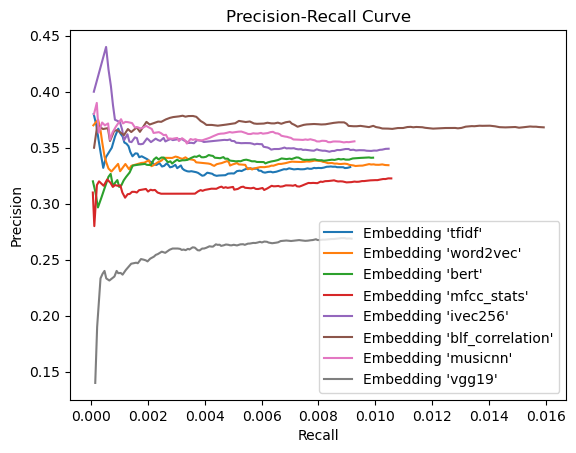

([0.14,
  0.19,
  0.2333333333333333,
  0.2375,
  0.24,
  0.23333333333333336,
  0.23142857142857134,
  0.235,
  0.23999999999999996,
  0.23800000000000002,
  0.2381818181818182,
  0.23666666666666664,
  0.24076923076923076,
  0.24642857142857147,
  0.24733333333333338,
  0.246875,
  0.2505882352941176,
  0.25000000000000006,
  0.2494736842105263,
  0.24849999999999997,
  0.2509523809523809,
  0.25272727272727274,
  0.2543478260869565,
  0.255,
  0.2572,
  0.2561538461538462,
  0.2588888888888889,
  0.26,
  0.26,
  0.25999999999999995,
  0.25967741935483873,
  0.25875,
  0.25909090909090915,
  0.2585294117647059,
  0.2597142857142857,
  0.25916666666666666,
  0.2610810810810811,
  0.26078947368421057,
  0.2597435897435897,
  0.25849999999999995,
  0.2582926829268293,
  0.25999999999999995,
  0.26,
  0.2606818181818182,
  0.262,
  0.26173913043478264,
  0.2617021276595745,
  0.26375,
  0.26326530612244897,
  0.2634,
  0.26235294117647057,
  0.2628846153846154,
  0.26358490566037734,
  0

In [11]:
sample_size = 100
k_range = range(1, 101)

#all feature embeddings
embeddings_list = [tfidf, word2vec,bert,mfcc_stats,ivec256,blf_correlation, musicnn, vgg19]

calc_avg_recall_precision(embeddings_list, k_range, sample_size)

# Early Fusion Plot (and needed functions)

In [16]:
def make2embeddings1(embedding1, embedding2):
    embedding_array = data_fusion(embedding1.head(10094),embedding2 )
    #Apply UMAP
    # Convert to NumPy array
    embedding_array = np.asarray(embedding_array)
    umap_model = umap.UMAP(n_neighbors=4, min_dist=0.8, n_components=100)
    print("Starting UMAP")
    embedding_umap = umap_model.fit_transform(embedding_array)
    print("Stopping UMAP")
    # Convert the UMAP result to a matrix
    embedding_matrix = np.matrix(embedding_umap)
    return embedding_matrix, embedding_matrix.transpose()

In [4]:
def generate_cos_sim_matrix2(embedding1, embedding2):
    print(embedding1.shape)
    print(embedding2.shape)
    #embedding1.drop(7298, axis=0, inplace=True)
    #embedding2.drop(7298, axis=0, inplace=True)
    embedding_matrix,embedding_transpose = make2embeddings1(embedding1, embedding2)
    #embedding_matrix,embedding_transpose = convert2matrix(embedding)


    # Überprüfen Sie die Form der transponierten Matrizen
    print(embedding_matrix.shape) # (1328, 10093)
    #print(len(blf_correlation), len(blf_correlation_transpose_zip[0])) # (1328, 10093)
    # Berechnen Sie die Kosinusähnlichkeitsmatrix
    cos_sim_matrix = np.triu(embedding_matrix.dot(embedding_transpose) / (np.linalg.norm(embedding_matrix, axis=1) * np.linalg.norm(embedding_matrix, axis=1)[:, None]))
    # Fill the lower triangular part with the same values as the upper triangular part
    cos_sim_matrix = cos_sim_matrix + cos_sim_matrix.T - np.diag(cos_sim_matrix.diagonal())

    # Create a dataframe from the numpy matrix
    df = pd.DataFrame(cos_sim_matrix)

    # Assign the ids to the index and columns
    df.index = embedding1.iloc[:, 0]
    #df.index = df.index.str.strip('(),')
    df.columns = embedding1.iloc[:, 0]
    #df.columns = df.columns.str.strip('(),')

    return df

In [5]:
def data_fusion(embedding1, embedding2):
    matrix1, matrix1b = convert2matrix(embedding1)
    matrix2, matrix2b = convert2matrix(embedding2)

    if matrix1.shape[0] != matrix2.shape[0]:
        raise ValueError("Matrices must have the same number of rows for concatenation.")

    # Horizontally stack the matrices
    fused_matrix = np.hstack((matrix1, matrix2))

    return fused_matrix

In [6]:
def convert2matrix(embedding):
    embedding = embedding.sort_values(by='id')
    # Konvertieren Sie den DataFrame in ein NumPy-ndarray
    embedding_array = embedding.iloc[:, 2:].to_numpy()
    # Konvertieren Sie das NumPy-ndarray in eine NumPy-Matrix
    # initialize the LDA model with the desired parameters
    #lda = LatentDirichletAllocation(n_components=50, max_iter=5, learning_method='online', learning_offset=50., random_state=0)

    '''# Apply UMAP
    umap_model = umap.UMAP(n_neighbors=10, min_dist=0.2, n_components=50)  # Adjust parameters as needed
    print("Starting UMAP")
    embedding_umap = umap_model.fit_transform(embedding_array)
    print("Stopping UMAP")'''
    
    # Convert the UMAP result to a matrix
    embedding_matrix = np.matrix(embedding_array)
    
    # Transponieren Sie die Matrix mit der transpose() Methode
    #embedding_transpose = embedding_matrix.transpose()
    #embedding_mm_fused = data_fusion(tfidf[:10094], musicnn)
    # Transponieren Sie die Matrix mit der transpose() Methode
    embedding_transpose = embedding_matrix.transpose()
    return embedding_matrix,embedding_transpose

In [14]:
#preprocess dataset
bert = bert[bert['id'] != '03Oc9WeMEmyLLQbj']

In [39]:
fusion_bert_musicnn = generate_cos_sim_matrix2(bert,musicnn)
fusion_bert_musicnn = pd.merge(fusion_bert_musicnn, genres, on='id')

(10094, 769)
(10094, 51)
Starting UMAP
Stopping UMAP
(10094, 100)


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calc_avg_recall_precision_fusion(cosine_similarity_matrix, k_values, sample_size):
    genres = pd.DataFrame() 

    precision_scores = []
    recall_scores = []

    # Sample a subset of queries
    sampled_queries = np.random.choice(cosine_similarity_matrix['id'], size=sample_size, replace=False)

    for k in k_values:
        results = []
        for query in sampled_queries:
            precision, recall = calc_recall_precision(query, cosine_similarity_matrix, k)
            results.append((precision, recall))
            print(f"Processed query {query} for k={k} - Precision: {precision:.2f}, Recall: {recall:.2f}")

        precision_values, recall_values = zip(*results)

        # Calculate the average precision and recall over all sampled query tracks for the current k
        avg_precision = np.mean(precision_values)
        avg_recall = np.mean(recall_values)

        precision_scores.append(avg_precision)
        recall_scores.append(avg_recall)

        print(f"Avg Precision at k={k}: {avg_precision:.2f}, Avg Recall at k={k}: {avg_recall:.2f}\n")


    plt.plot(recall_scores, precision_scores, label='Given Embedding')

    plt.xlabel('Recall') 
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Fusion: Bert & Musicnn')
    plt.legend()
    plt.show()

    return precision_scores, recall_scores


Processed query 7n1aRZy5nXY7xqzV for k=1 - Precision: 0.00, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=1 - Precision: 1.00, Recall: 0.00
Processed query LFKYue8YlfYi1ILw for k=1 - Precision: 1.00, Recall: 0.00
Processed query svzZTDaQPsbtQCHm for k=1 - Precision: 1.00, Recall: 0.00
Processed query g1Fkyx0T1Ylcw49Z for k=1 - Precision: 0.00, Recall: 0.00
Processed query ZhCpr6rRtB0kKrQg for k=1 - Precision: 0.00, Recall: 0.00
Processed query faaF2qbE6IIgB6FL for k=1 - Precision: 1.00, Recall: 0.00
Processed query PzjMLoz4uryikjBF for k=1 - Precision: 0.00, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=1 - Precision: 0.00, Recall: 0.00
Processed query TwtFpQa2IRpriRlK for k=1 - Precision: 1.00, Recall: 0.00
Processed query 5QfTsiAiONF5lDel for k=1 - Precision: 0.00, Recall: 0.00
Processed query 8nG0vZiRQXrHbrQK for k=1 - Precision: 0.00, Recall: 0.00
Processed query l7JfVRRnkRsaOEXL for k=1 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=1 - Precisio

Processed query l7JfVRRnkRsaOEXL for k=2 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=2 - Precision: 0.50, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=2 - Precision: 1.00, Recall: 0.00
Processed query rlMcTiHz9HSidm55 for k=2 - Precision: 0.00, Recall: 0.00
Processed query TZonZEnh1Vz9OEJn for k=2 - Precision: 0.00, Recall: 0.00
Processed query AsrKO9MIRQVlh1wd for k=2 - Precision: 0.00, Recall: 0.00
Processed query ivpQdsiz0WiyzXvY for k=2 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=2 - Precision: 1.00, Recall: 0.00
Processed query QhAAd1JDJkwkXoT8 for k=2 - Precision: 0.50, Recall: 0.00
Processed query k6LZ32AyVaYRxRqU for k=2 - Precision: 0.00, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=2 - Precision: 0.50, Recall: 0.00
Processed query blC0kW4mYLj4V4u0 for k=2 - Precision: 0.00, Recall: 0.00
Processed query MLekY58IPgdSr5Q3 for k=2 - Precision: 0.00, Recall: 0.00
Processed query Lggy2QpQLVLASQ9Q for k=2 - Precisio

Processed query MLekY58IPgdSr5Q3 for k=3 - Precision: 0.00, Recall: 0.00
Processed query Lggy2QpQLVLASQ9Q for k=3 - Precision: 1.00, Recall: 0.00
Processed query 7D1H0DTrp6sztZeO for k=3 - Precision: 0.67, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=3 - Precision: 0.67, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=3 - Precision: 0.00, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k=3 - Precision: 0.00, Recall: 0.00
Processed query VzY36FO8t9sDy1h9 for k=3 - Precision: 0.67, Recall: 0.00
Processed query TBH4dxkeSVvTsSnV for k=3 - Precision: 0.67, Recall: 0.00
Processed query SbSWtusPY4NzadKD for k=3 - Precision: 0.67, Recall: 0.00
Processed query 4vPCXVXHeoXkniz9 for k=3 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=3 - Precision: 1.00, Recall: 0.00
Processed query Ycdb50MRcHyKljV7 for k=3 - Precision: 0.00, Recall: 0.00
Processed query h1mUlnHQBfZ54dal for k=3 - Precision: 0.00, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=3 - Precisio

Processed query h1mUlnHQBfZ54dal for k=4 - Precision: 0.25, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=4 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=4 - Precision: 0.00, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k=4 - Precision: 0.50, Recall: 0.00
Processed query Bl6czQtTnahOAg2V for k=4 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=4 - Precision: 0.00, Recall: 0.00
Processed query oaIwSbTS5fQjSvtt for k=4 - Precision: 0.75, Recall: 0.00
Processed query EaqvIckagr9dMSmp for k=4 - Precision: 0.00, Recall: 0.00
Processed query hSMhEoHkNC5kdNNs for k=4 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=4 - Precision: 0.75, Recall: 0.00
Processed query WRbNe1wqXuWUlW9n for k=4 - Precision: 0.00, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=4 - Precision: 0.50, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=4 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=4 - Precisio

Processed query 1sptE8wT5XvOvHlW for k=5 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=5 - Precision: 0.00, Recall: 0.00
Processed query 1NmthD0bJAk8r1ZC for k=5 - Precision: 0.00, Recall: 0.00
Processed query KFbfr0fWWCTGXIJj for k=5 - Precision: 0.40, Recall: 0.00
Processed query I1wSAAImrUdZPlY8 for k=5 - Precision: 0.00, Recall: 0.00
Processed query pIO8ObTzkQqowIUy for k=5 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=5 - Precision: 0.20, Recall: 0.00
Processed query BlmfG6VDZhitaVPu for k=5 - Precision: 0.60, Recall: 0.00
Processed query TBJk1gUVEmjT3r7Y for k=5 - Precision: 0.60, Recall: 0.00
Processed query xZxUanP4t55mjPOh for k=5 - Precision: 0.40, Recall: 0.00
Processed query HUOSeI0YAPMQQbBz for k=5 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=5 - Precision: 0.40, Recall: 0.00
Processed query xLYfp2Fb3uZrDME6 for k=5 - Precision: 0.00, Recall: 0.00
Processed query jZIPz5Hs52i4iyvM for k=5 - Precisio

Processed query xLYfp2Fb3uZrDME6 for k=6 - Precision: 0.00, Recall: 0.00
Processed query jZIPz5Hs52i4iyvM for k=6 - Precision: 0.00, Recall: 0.00
Processed query JKxDOWvm2dwbxVGd for k=6 - Precision: 1.00, Recall: 0.00
Processed query Si2wrGw592vjFt1H for k=6 - Precision: 0.00, Recall: 0.00
Processed query E6xyZ7sUHkxSBiIb for k=6 - Precision: 0.50, Recall: 0.00
Processed query B4wNWPzUo2nXhitH for k=6 - Precision: 0.67, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=6 - Precision: 0.33, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=6 - Precision: 0.50, Recall: 0.00
Processed query qxjO99S0R94MTP3S for k=6 - Precision: 0.33, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=6 - Precision: 0.17, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=6 - Precision: 0.33, Recall: 0.00
Processed query VWfPIOxHP1QCuH6W for k=6 - Precision: 0.33, Recall: 0.00
Processed query R9ove8iUd4kTefAc for k=6 - Precision: 0.33, Recall: 0.00
Processed query Ow2JSzIFP0OSj3RK for k=6 - Precisio

Processed query R9ove8iUd4kTefAc for k=7 - Precision: 0.43, Recall: 0.00
Processed query Ow2JSzIFP0OSj3RK for k=7 - Precision: 0.43, Recall: 0.00
Processed query aC6Ayj7JjDNa6oIg for k=7 - Precision: 0.00, Recall: 0.00
Processed query ZHIKHfLyTuRzAcDU for k=7 - Precision: 0.00, Recall: 0.00
Processed query y48SMi67SfMjZfiA for k=7 - Precision: 0.29, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=7 - Precision: 0.57, Recall: 0.00
Processed query 5bVqP2AsQwwTBO1v for k=7 - Precision: 0.71, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k=7 - Precision: 0.14, Recall: 0.00
Processed query hi4bMnNj2515T2lL for k=7 - Precision: 0.14, Recall: 0.00
Processed query zQaORaShg7AJ8qRq for k=7 - Precision: 0.71, Recall: 0.00
Processed query IJRqAdaBcOo7tdJK for k=7 - Precision: 0.71, Recall: 0.00
Processed query RJUjLrAkXV2Jj3qH for k=7 - Precision: 0.29, Recall: 0.00
Processed query FNpS1gA711QdjJpd for k=7 - Precision: 0.71, Recall: 0.00
Processed query Se9KDiwbDwmSEBKh for k=7 - Precisio

Processed query FNpS1gA711QdjJpd for k=8 - Precision: 0.75, Recall: 0.00
Processed query Se9KDiwbDwmSEBKh for k=8 - Precision: 0.88, Recall: 0.00
Processed query dQUNiihhNbCIbtOF for k=8 - Precision: 0.25, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=8 - Precision: 0.50, Recall: 0.00
Processed query VJGJ5KWZYF5FQwNm for k=8 - Precision: 0.00, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k=8 - Precision: 0.00, Recall: 0.00
Processed query CxsmrOAvfp8gDwTM for k=8 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=8 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=8 - Precision: 0.50, Recall: 0.00
Processed query NoWzSl5t6joo1NBH for k=8 - Precision: 0.00, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=8 - Precision: 0.62, Recall: 0.00
Processed query xH6aA7toBHLc2nac for k=8 - Precision: 0.00, Recall: 0.00
Processed query JGkgo4pzrEzCGgJu for k=8 - Precision: 0.50, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=8 - Precisio

Processed query JGkgo4pzrEzCGgJu for k=9 - Precision: 0.44, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=9 - Precision: 0.11, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=9 - Precision: 0.67, Recall: 0.00
Processed query hGKFUbZw45ZvzQjX for k=9 - Precision: 0.78, Recall: 0.00
Avg Precision at k=9: 0.35, Avg Recall at k=9: 0.00

Processed query 7n1aRZy5nXY7xqzV for k=10 - Precision: 0.10, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=10 - Precision: 0.60, Recall: 0.00
Processed query LFKYue8YlfYi1ILw for k=10 - Precision: 0.10, Recall: 0.00
Processed query svzZTDaQPsbtQCHm for k=10 - Precision: 0.10, Recall: 0.00
Processed query g1Fkyx0T1Ylcw49Z for k=10 - Precision: 0.10, Recall: 0.00
Processed query ZhCpr6rRtB0kKrQg for k=10 - Precision: 0.20, Recall: 0.00
Processed query faaF2qbE6IIgB6FL for k=10 - Precision: 0.90, Recall: 0.00
Processed query PzjMLoz4uryikjBF for k=10 - Precision: 0.20, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=10 - Precision: 0.00, Re

Processed query faaF2qbE6IIgB6FL for k=11 - Precision: 0.82, Recall: 0.00
Processed query PzjMLoz4uryikjBF for k=11 - Precision: 0.18, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=11 - Precision: 0.00, Recall: 0.00
Processed query TwtFpQa2IRpriRlK for k=11 - Precision: 0.55, Recall: 0.00
Processed query 5QfTsiAiONF5lDel for k=11 - Precision: 0.18, Recall: 0.00
Processed query 8nG0vZiRQXrHbrQK for k=11 - Precision: 0.64, Recall: 0.00
Processed query l7JfVRRnkRsaOEXL for k=11 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=11 - Precision: 0.36, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=11 - Precision: 0.64, Recall: 0.00
Processed query rlMcTiHz9HSidm55 for k=11 - Precision: 0.18, Recall: 0.00
Processed query TZonZEnh1Vz9OEJn for k=11 - Precision: 0.09, Recall: 0.01
Processed query AsrKO9MIRQVlh1wd for k=11 - Precision: 0.18, Recall: 0.00
Processed query ivpQdsiz0WiyzXvY for k=11 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=12 - Precision: 0.08, Recall: 0.01
Processed query AsrKO9MIRQVlh1wd for k=12 - Precision: 0.25, Recall: 0.00
Processed query ivpQdsiz0WiyzXvY for k=12 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=12 - Precision: 0.67, Recall: 0.00
Processed query QhAAd1JDJkwkXoT8 for k=12 - Precision: 0.58, Recall: 0.00
Processed query k6LZ32AyVaYRxRqU for k=12 - Precision: 0.08, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=12 - Precision: 0.50, Recall: 0.00
Processed query blC0kW4mYLj4V4u0 for k=12 - Precision: 0.17, Recall: 0.00
Processed query MLekY58IPgdSr5Q3 for k=12 - Precision: 0.33, Recall: 0.00
Processed query Lggy2QpQLVLASQ9Q for k=12 - Precision: 0.50, Recall: 0.00
Processed query 7D1H0DTrp6sztZeO for k=12 - Precision: 0.67, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=12 - Precision: 0.42, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=12 - Precision: 0.08, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k

Processed query 7D1H0DTrp6sztZeO for k=13 - Precision: 0.69, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=13 - Precision: 0.46, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=13 - Precision: 0.08, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k=13 - Precision: 0.23, Recall: 0.00
Processed query VzY36FO8t9sDy1h9 for k=13 - Precision: 0.69, Recall: 0.00
Processed query TBH4dxkeSVvTsSnV for k=13 - Precision: 0.69, Recall: 0.00
Processed query SbSWtusPY4NzadKD for k=13 - Precision: 0.54, Recall: 0.00
Processed query 4vPCXVXHeoXkniz9 for k=13 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=13 - Precision: 0.69, Recall: 0.00
Processed query Ycdb50MRcHyKljV7 for k=13 - Precision: 0.23, Recall: 0.00
Processed query h1mUlnHQBfZ54dal for k=13 - Precision: 0.23, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=13 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=13 - Precision: 0.23, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k

Processed query h1mUlnHQBfZ54dal for k=14 - Precision: 0.21, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=14 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=14 - Precision: 0.21, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k=14 - Precision: 0.57, Recall: 0.00
Processed query Bl6czQtTnahOAg2V for k=14 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=14 - Precision: 0.36, Recall: 0.00
Processed query oaIwSbTS5fQjSvtt for k=14 - Precision: 0.79, Recall: 0.00
Processed query EaqvIckagr9dMSmp for k=14 - Precision: 0.07, Recall: 0.00
Processed query hSMhEoHkNC5kdNNs for k=14 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=14 - Precision: 0.57, Recall: 0.00
Processed query WRbNe1wqXuWUlW9n for k=14 - Precision: 0.00, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=14 - Precision: 0.64, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=14 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k

Processed query WRbNe1wqXuWUlW9n for k=15 - Precision: 0.00, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=15 - Precision: 0.67, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=15 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=15 - Precision: 0.00, Recall: 0.00
Processed query 1NmthD0bJAk8r1ZC for k=15 - Precision: 0.07, Recall: 0.01
Processed query KFbfr0fWWCTGXIJj for k=15 - Precision: 0.47, Recall: 0.00
Processed query I1wSAAImrUdZPlY8 for k=15 - Precision: 0.00, Recall: 0.00
Processed query pIO8ObTzkQqowIUy for k=15 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=15 - Precision: 0.13, Recall: 0.00
Processed query BlmfG6VDZhitaVPu for k=15 - Precision: 0.53, Recall: 0.00
Processed query TBJk1gUVEmjT3r7Y for k=15 - Precision: 0.60, Recall: 0.00
Processed query xZxUanP4t55mjPOh for k=15 - Precision: 0.53, Recall: 0.00
Processed query HUOSeI0YAPMQQbBz for k=15 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k

Processed query TBJk1gUVEmjT3r7Y for k=16 - Precision: 0.56, Recall: 0.00
Processed query xZxUanP4t55mjPOh for k=16 - Precision: 0.56, Recall: 0.00
Processed query HUOSeI0YAPMQQbBz for k=16 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=16 - Precision: 0.50, Recall: 0.00
Processed query xLYfp2Fb3uZrDME6 for k=16 - Precision: 0.00, Recall: 0.00
Processed query jZIPz5Hs52i4iyvM for k=16 - Precision: 0.06, Recall: 0.00
Processed query JKxDOWvm2dwbxVGd for k=16 - Precision: 0.81, Recall: 0.00
Processed query Si2wrGw592vjFt1H for k=16 - Precision: 0.25, Recall: 0.00
Processed query E6xyZ7sUHkxSBiIb for k=16 - Precision: 0.50, Recall: 0.00
Processed query B4wNWPzUo2nXhitH for k=16 - Precision: 0.50, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=16 - Precision: 0.31, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=16 - Precision: 0.44, Recall: 0.00
Processed query qxjO99S0R94MTP3S for k=16 - Precision: 0.50, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k

Processed query qia0KEufEPClHrB9 for k=17 - Precision: 0.35, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=17 - Precision: 0.41, Recall: 0.00
Processed query qxjO99S0R94MTP3S for k=17 - Precision: 0.47, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=17 - Precision: 0.24, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=17 - Precision: 0.59, Recall: 0.00
Processed query VWfPIOxHP1QCuH6W for k=17 - Precision: 0.47, Recall: 0.00
Processed query R9ove8iUd4kTefAc for k=17 - Precision: 0.47, Recall: 0.00
Processed query Ow2JSzIFP0OSj3RK for k=17 - Precision: 0.35, Recall: 0.00
Processed query aC6Ayj7JjDNa6oIg for k=17 - Precision: 0.00, Recall: 0.00
Processed query ZHIKHfLyTuRzAcDU for k=17 - Precision: 0.00, Recall: 0.00
Processed query y48SMi67SfMjZfiA for k=17 - Precision: 0.29, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=17 - Precision: 0.59, Recall: 0.00
Processed query 5bVqP2AsQwwTBO1v for k=17 - Precision: 0.65, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k

Processed query y48SMi67SfMjZfiA for k=18 - Precision: 0.28, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=18 - Precision: 0.61, Recall: 0.00
Processed query 5bVqP2AsQwwTBO1v for k=18 - Precision: 0.61, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k=18 - Precision: 0.28, Recall: 0.00
Processed query hi4bMnNj2515T2lL for k=18 - Precision: 0.44, Recall: 0.00
Processed query zQaORaShg7AJ8qRq for k=18 - Precision: 0.67, Recall: 0.00
Processed query IJRqAdaBcOo7tdJK for k=18 - Precision: 0.56, Recall: 0.00
Processed query RJUjLrAkXV2Jj3qH for k=18 - Precision: 0.28, Recall: 0.00
Processed query FNpS1gA711QdjJpd for k=18 - Precision: 0.56, Recall: 0.00
Processed query Se9KDiwbDwmSEBKh for k=18 - Precision: 0.83, Recall: 0.00
Processed query dQUNiihhNbCIbtOF for k=18 - Precision: 0.44, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=18 - Precision: 0.61, Recall: 0.00
Processed query VJGJ5KWZYF5FQwNm for k=18 - Precision: 0.06, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k

Processed query dQUNiihhNbCIbtOF for k=19 - Precision: 0.47, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=19 - Precision: 0.58, Recall: 0.00
Processed query VJGJ5KWZYF5FQwNm for k=19 - Precision: 0.05, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k=19 - Precision: 0.00, Recall: 0.00
Processed query CxsmrOAvfp8gDwTM for k=19 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=19 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=19 - Precision: 0.58, Recall: 0.00
Processed query NoWzSl5t6joo1NBH for k=19 - Precision: 0.00, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=19 - Precision: 0.68, Recall: 0.00
Processed query xH6aA7toBHLc2nac for k=19 - Precision: 0.16, Recall: 0.00
Processed query JGkgo4pzrEzCGgJu for k=19 - Precision: 0.63, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=19 - Precision: 0.16, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=19 - Precision: 0.74, Recall: 0.00
Processed query hGKFUbZw45ZvzQjX for k

Processed query JGkgo4pzrEzCGgJu for k=20 - Precision: 0.65, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=20 - Precision: 0.15, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=20 - Precision: 0.75, Recall: 0.00
Processed query hGKFUbZw45ZvzQjX for k=20 - Precision: 0.60, Recall: 0.00
Avg Precision at k=20: 0.33, Avg Recall at k=20: 0.00

Processed query 7n1aRZy5nXY7xqzV for k=21 - Precision: 0.05, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=21 - Precision: 0.57, Recall: 0.00
Processed query LFKYue8YlfYi1ILw for k=21 - Precision: 0.05, Recall: 0.00
Processed query svzZTDaQPsbtQCHm for k=21 - Precision: 0.14, Recall: 0.00
Processed query g1Fkyx0T1Ylcw49Z for k=21 - Precision: 0.14, Recall: 0.00
Processed query ZhCpr6rRtB0kKrQg for k=21 - Precision: 0.19, Recall: 0.00
Processed query faaF2qbE6IIgB6FL for k=21 - Precision: 0.90, Recall: 0.00
Processed query PzjMLoz4uryikjBF for k=21 - Precision: 0.10, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=21 - Precision: 0.

Processed query faaF2qbE6IIgB6FL for k=22 - Precision: 0.86, Recall: 0.00
Processed query PzjMLoz4uryikjBF for k=22 - Precision: 0.09, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=22 - Precision: 0.00, Recall: 0.00
Processed query TwtFpQa2IRpriRlK for k=22 - Precision: 0.55, Recall: 0.00
Processed query 5QfTsiAiONF5lDel for k=22 - Precision: 0.14, Recall: 0.00
Processed query 8nG0vZiRQXrHbrQK for k=22 - Precision: 0.64, Recall: 0.00
Processed query l7JfVRRnkRsaOEXL for k=22 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=22 - Precision: 0.27, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=22 - Precision: 0.64, Recall: 0.00
Processed query rlMcTiHz9HSidm55 for k=22 - Precision: 0.18, Recall: 0.00
Processed query TZonZEnh1Vz9OEJn for k=22 - Precision: 0.05, Recall: 0.01
Processed query AsrKO9MIRQVlh1wd for k=22 - Precision: 0.18, Recall: 0.00
Processed query ivpQdsiz0WiyzXvY for k=22 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=23 - Precision: 0.09, Recall: 0.01
Processed query AsrKO9MIRQVlh1wd for k=23 - Precision: 0.17, Recall: 0.00
Processed query ivpQdsiz0WiyzXvY for k=23 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=23 - Precision: 0.57, Recall: 0.00
Processed query QhAAd1JDJkwkXoT8 for k=23 - Precision: 0.52, Recall: 0.00
Processed query k6LZ32AyVaYRxRqU for k=23 - Precision: 0.04, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=23 - Precision: 0.48, Recall: 0.00
Processed query blC0kW4mYLj4V4u0 for k=23 - Precision: 0.09, Recall: 0.00
Processed query MLekY58IPgdSr5Q3 for k=23 - Precision: 0.43, Recall: 0.00
Processed query Lggy2QpQLVLASQ9Q for k=23 - Precision: 0.39, Recall: 0.00
Processed query 7D1H0DTrp6sztZeO for k=23 - Precision: 0.65, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=23 - Precision: 0.52, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=23 - Precision: 0.04, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k

Processed query 7D1H0DTrp6sztZeO for k=24 - Precision: 0.67, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=24 - Precision: 0.50, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=24 - Precision: 0.04, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k=24 - Precision: 0.38, Recall: 0.00
Processed query VzY36FO8t9sDy1h9 for k=24 - Precision: 0.62, Recall: 0.00
Processed query TBH4dxkeSVvTsSnV for k=24 - Precision: 0.71, Recall: 0.00
Processed query SbSWtusPY4NzadKD for k=24 - Precision: 0.54, Recall: 0.00
Processed query 4vPCXVXHeoXkniz9 for k=24 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=24 - Precision: 0.67, Recall: 0.00
Processed query Ycdb50MRcHyKljV7 for k=24 - Precision: 0.25, Recall: 0.00
Processed query h1mUlnHQBfZ54dal for k=24 - Precision: 0.21, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=24 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=24 - Precision: 0.21, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k

Processed query h1mUlnHQBfZ54dal for k=25 - Precision: 0.24, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=25 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=25 - Precision: 0.20, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k=25 - Precision: 0.60, Recall: 0.00
Processed query Bl6czQtTnahOAg2V for k=25 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=25 - Precision: 0.40, Recall: 0.00
Processed query oaIwSbTS5fQjSvtt for k=25 - Precision: 0.60, Recall: 0.00
Processed query EaqvIckagr9dMSmp for k=25 - Precision: 0.12, Recall: 0.00
Processed query hSMhEoHkNC5kdNNs for k=25 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=25 - Precision: 0.52, Recall: 0.00
Processed query WRbNe1wqXuWUlW9n for k=25 - Precision: 0.00, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=25 - Precision: 0.56, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=25 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k

Processed query WRbNe1wqXuWUlW9n for k=26 - Precision: 0.00, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=26 - Precision: 0.54, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=26 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=26 - Precision: 0.04, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=26 - Precision: 0.04, Recall: 0.01
Processed query KFbfr0fWWCTGXIJj for k=26 - Precision: 0.42, Recall: 0.00
Processed query I1wSAAImrUdZPlY8 for k=26 - Precision: 0.00, Recall: 0.00
Processed query pIO8ObTzkQqowIUy for k=26 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=26 - Precision: 0.19, Recall: 0.00
Processed query BlmfG6VDZhitaVPu for k=26 - Precision: 0.42, Recall: 0.00
Processed query TBJk1gUVEmjT3r7Y for k=26 - Precision: 0.65, Recall: 0.00
Processed query xZxUanP4t55mjPOh for k=26 - Precision: 0.58, Recall: 0.00
Processed query HUOSeI0YAPMQQbBz for k=26 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k

Processed query TBJk1gUVEmjT3r7Y for k=27 - Precision: 0.67, Recall: 0.00
Processed query xZxUanP4t55mjPOh for k=27 - Precision: 0.59, Recall: 0.00
Processed query HUOSeI0YAPMQQbBz for k=27 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=27 - Precision: 0.59, Recall: 0.00
Processed query xLYfp2Fb3uZrDME6 for k=27 - Precision: 0.00, Recall: 0.00
Processed query jZIPz5Hs52i4iyvM for k=27 - Precision: 0.07, Recall: 0.00
Processed query JKxDOWvm2dwbxVGd for k=27 - Precision: 0.70, Recall: 0.00
Processed query Si2wrGw592vjFt1H for k=27 - Precision: 0.22, Recall: 0.00
Processed query E6xyZ7sUHkxSBiIb for k=27 - Precision: 0.56, Recall: 0.00
Processed query B4wNWPzUo2nXhitH for k=27 - Precision: 0.41, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=27 - Precision: 0.33, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=27 - Precision: 0.41, Recall: 0.00
Processed query qxjO99S0R94MTP3S for k=27 - Precision: 0.48, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k

Processed query qia0KEufEPClHrB9 for k=28 - Precision: 0.32, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=28 - Precision: 0.39, Recall: 0.00
Processed query qxjO99S0R94MTP3S for k=28 - Precision: 0.50, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=28 - Precision: 0.25, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=28 - Precision: 0.61, Recall: 0.00
Processed query VWfPIOxHP1QCuH6W for k=28 - Precision: 0.50, Recall: 0.00
Processed query R9ove8iUd4kTefAc for k=28 - Precision: 0.36, Recall: 0.00
Processed query Ow2JSzIFP0OSj3RK for k=28 - Precision: 0.39, Recall: 0.00
Processed query aC6Ayj7JjDNa6oIg for k=28 - Precision: 0.04, Recall: 0.01
Processed query ZHIKHfLyTuRzAcDU for k=28 - Precision: 0.04, Recall: 0.01
Processed query y48SMi67SfMjZfiA for k=28 - Precision: 0.50, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=28 - Precision: 0.46, Recall: 0.00
Processed query 5bVqP2AsQwwTBO1v for k=28 - Precision: 0.64, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k

Processed query y48SMi67SfMjZfiA for k=29 - Precision: 0.52, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=29 - Precision: 0.45, Recall: 0.00
Processed query 5bVqP2AsQwwTBO1v for k=29 - Precision: 0.66, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k=29 - Precision: 0.31, Recall: 0.00
Processed query hi4bMnNj2515T2lL for k=29 - Precision: 0.52, Recall: 0.00
Processed query zQaORaShg7AJ8qRq for k=29 - Precision: 0.72, Recall: 0.00
Processed query IJRqAdaBcOo7tdJK for k=29 - Precision: 0.48, Recall: 0.00
Processed query RJUjLrAkXV2Jj3qH for k=29 - Precision: 0.28, Recall: 0.00
Processed query FNpS1gA711QdjJpd for k=29 - Precision: 0.48, Recall: 0.00
Processed query Se9KDiwbDwmSEBKh for k=29 - Precision: 0.69, Recall: 0.00
Processed query dQUNiihhNbCIbtOF for k=29 - Precision: 0.45, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=29 - Precision: 0.52, Recall: 0.00
Processed query VJGJ5KWZYF5FQwNm for k=29 - Precision: 0.07, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k

Processed query dQUNiihhNbCIbtOF for k=30 - Precision: 0.43, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=30 - Precision: 0.50, Recall: 0.00
Processed query VJGJ5KWZYF5FQwNm for k=30 - Precision: 0.07, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k=30 - Precision: 0.03, Recall: 0.00
Processed query CxsmrOAvfp8gDwTM for k=30 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=30 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=30 - Precision: 0.60, Recall: 0.00
Processed query NoWzSl5t6joo1NBH for k=30 - Precision: 0.00, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=30 - Precision: 0.63, Recall: 0.00
Processed query xH6aA7toBHLc2nac for k=30 - Precision: 0.13, Recall: 0.00
Processed query JGkgo4pzrEzCGgJu for k=30 - Precision: 0.60, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=30 - Precision: 0.13, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=30 - Precision: 0.73, Recall: 0.00
Processed query hGKFUbZw45ZvzQjX for k

Processed query JGkgo4pzrEzCGgJu for k=31 - Precision: 0.61, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=31 - Precision: 0.13, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=31 - Precision: 0.74, Recall: 0.00
Processed query hGKFUbZw45ZvzQjX for k=31 - Precision: 0.58, Recall: 0.00
Avg Precision at k=31: 0.33, Avg Recall at k=31: 0.00

Processed query 7n1aRZy5nXY7xqzV for k=32 - Precision: 0.03, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=32 - Precision: 0.59, Recall: 0.00
Processed query LFKYue8YlfYi1ILw for k=32 - Precision: 0.03, Recall: 0.00
Processed query svzZTDaQPsbtQCHm for k=32 - Precision: 0.16, Recall: 0.00
Processed query g1Fkyx0T1Ylcw49Z for k=32 - Precision: 0.12, Recall: 0.00
Processed query ZhCpr6rRtB0kKrQg for k=32 - Precision: 0.19, Recall: 0.00
Processed query faaF2qbE6IIgB6FL for k=32 - Precision: 0.78, Recall: 0.00
Processed query PzjMLoz4uryikjBF for k=32 - Precision: 0.09, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=32 - Precision: 0.

Processed query faaF2qbE6IIgB6FL for k=33 - Precision: 0.79, Recall: 0.00
Processed query PzjMLoz4uryikjBF for k=33 - Precision: 0.09, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=33 - Precision: 0.00, Recall: 0.00
Processed query TwtFpQa2IRpriRlK for k=33 - Precision: 0.48, Recall: 0.00
Processed query 5QfTsiAiONF5lDel for k=33 - Precision: 0.15, Recall: 0.00
Processed query 8nG0vZiRQXrHbrQK for k=33 - Precision: 0.64, Recall: 0.00
Processed query l7JfVRRnkRsaOEXL for k=33 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=33 - Precision: 0.30, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=33 - Precision: 0.61, Recall: 0.00
Processed query rlMcTiHz9HSidm55 for k=33 - Precision: 0.30, Recall: 0.01
Processed query TZonZEnh1Vz9OEJn for k=33 - Precision: 0.06, Recall: 0.01
Processed query AsrKO9MIRQVlh1wd for k=33 - Precision: 0.12, Recall: 0.00
Processed query ivpQdsiz0WiyzXvY for k=33 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=34 - Precision: 0.06, Recall: 0.01
Processed query AsrKO9MIRQVlh1wd for k=34 - Precision: 0.12, Recall: 0.00
Processed query ivpQdsiz0WiyzXvY for k=34 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=34 - Precision: 0.50, Recall: 0.00
Processed query QhAAd1JDJkwkXoT8 for k=34 - Precision: 0.47, Recall: 0.00
Processed query k6LZ32AyVaYRxRqU for k=34 - Precision: 0.12, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=34 - Precision: 0.53, Recall: 0.00
Processed query blC0kW4mYLj4V4u0 for k=34 - Precision: 0.12, Recall: 0.01
Processed query MLekY58IPgdSr5Q3 for k=34 - Precision: 0.41, Recall: 0.00
Processed query Lggy2QpQLVLASQ9Q for k=34 - Precision: 0.44, Recall: 0.00
Processed query 7D1H0DTrp6sztZeO for k=34 - Precision: 0.65, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=34 - Precision: 0.53, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=34 - Precision: 0.03, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k

Processed query 7D1H0DTrp6sztZeO for k=35 - Precision: 0.63, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=35 - Precision: 0.51, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=35 - Precision: 0.03, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k=35 - Precision: 0.31, Recall: 0.00
Processed query VzY36FO8t9sDy1h9 for k=35 - Precision: 0.51, Recall: 0.01
Processed query TBH4dxkeSVvTsSnV for k=35 - Precision: 0.71, Recall: 0.00
Processed query SbSWtusPY4NzadKD for k=35 - Precision: 0.51, Recall: 0.00
Processed query 4vPCXVXHeoXkniz9 for k=35 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=35 - Precision: 0.69, Recall: 0.00
Processed query Ycdb50MRcHyKljV7 for k=35 - Precision: 0.23, Recall: 0.00
Processed query h1mUlnHQBfZ54dal for k=35 - Precision: 0.29, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=35 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=35 - Precision: 0.20, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k

Processed query h1mUlnHQBfZ54dal for k=36 - Precision: 0.28, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=36 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=36 - Precision: 0.19, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k=36 - Precision: 0.58, Recall: 0.00
Processed query Bl6czQtTnahOAg2V for k=36 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=36 - Precision: 0.42, Recall: 0.00
Processed query oaIwSbTS5fQjSvtt for k=36 - Precision: 0.64, Recall: 0.00
Processed query EaqvIckagr9dMSmp for k=36 - Precision: 0.08, Recall: 0.00
Processed query hSMhEoHkNC5kdNNs for k=36 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=36 - Precision: 0.61, Recall: 0.00
Processed query WRbNe1wqXuWUlW9n for k=36 - Precision: 0.00, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=36 - Precision: 0.50, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=36 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k

Processed query WRbNe1wqXuWUlW9n for k=37 - Precision: 0.00, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=37 - Precision: 0.51, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=37 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=37 - Precision: 0.03, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=37 - Precision: 0.03, Recall: 0.01
Processed query KFbfr0fWWCTGXIJj for k=37 - Precision: 0.38, Recall: 0.00
Processed query I1wSAAImrUdZPlY8 for k=37 - Precision: 0.05, Recall: 0.00
Processed query pIO8ObTzkQqowIUy for k=37 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=37 - Precision: 0.19, Recall: 0.00
Processed query BlmfG6VDZhitaVPu for k=37 - Precision: 0.43, Recall: 0.00
Processed query TBJk1gUVEmjT3r7Y for k=37 - Precision: 0.65, Recall: 0.00
Processed query xZxUanP4t55mjPOh for k=37 - Precision: 0.59, Recall: 0.00
Processed query HUOSeI0YAPMQQbBz for k=37 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k

Processed query TBJk1gUVEmjT3r7Y for k=38 - Precision: 0.66, Recall: 0.00
Processed query xZxUanP4t55mjPOh for k=38 - Precision: 0.61, Recall: 0.00
Processed query HUOSeI0YAPMQQbBz for k=38 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=38 - Precision: 0.58, Recall: 0.00
Processed query xLYfp2Fb3uZrDME6 for k=38 - Precision: 0.03, Recall: 0.02
Processed query jZIPz5Hs52i4iyvM for k=38 - Precision: 0.08, Recall: 0.01
Processed query JKxDOWvm2dwbxVGd for k=38 - Precision: 0.74, Recall: 0.00
Processed query Si2wrGw592vjFt1H for k=38 - Precision: 0.18, Recall: 0.00
Processed query E6xyZ7sUHkxSBiIb for k=38 - Precision: 0.61, Recall: 0.00
Processed query B4wNWPzUo2nXhitH for k=38 - Precision: 0.37, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=38 - Precision: 0.32, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=38 - Precision: 0.34, Recall: 0.00
Processed query qxjO99S0R94MTP3S for k=38 - Precision: 0.42, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k

Processed query qia0KEufEPClHrB9 for k=39 - Precision: 0.31, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=39 - Precision: 0.33, Recall: 0.00
Processed query qxjO99S0R94MTP3S for k=39 - Precision: 0.41, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=39 - Precision: 0.36, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=39 - Precision: 0.54, Recall: 0.01
Processed query VWfPIOxHP1QCuH6W for k=39 - Precision: 0.54, Recall: 0.00
Processed query R9ove8iUd4kTefAc for k=39 - Precision: 0.38, Recall: 0.00
Processed query Ow2JSzIFP0OSj3RK for k=39 - Precision: 0.31, Recall: 0.00
Processed query aC6Ayj7JjDNa6oIg for k=39 - Precision: 0.03, Recall: 0.01
Processed query ZHIKHfLyTuRzAcDU for k=39 - Precision: 0.03, Recall: 0.01
Processed query y48SMi67SfMjZfiA for k=39 - Precision: 0.46, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=39 - Precision: 0.41, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=39 - Precision: 0.56, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k

Processed query y48SMi67SfMjZfiA for k=40 - Precision: 0.47, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=40 - Precision: 0.40, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=40 - Precision: 0.57, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k=40 - Precision: 0.30, Recall: 0.00
Processed query hi4bMnNj2515T2lL for k=40 - Precision: 0.47, Recall: 0.00
Processed query zQaORaShg7AJ8qRq for k=40 - Precision: 0.70, Recall: 0.00
Processed query IJRqAdaBcOo7tdJK for k=40 - Precision: 0.50, Recall: 0.00
Processed query RJUjLrAkXV2Jj3qH for k=40 - Precision: 0.35, Recall: 0.00
Processed query FNpS1gA711QdjJpd for k=40 - Precision: 0.53, Recall: 0.00
Processed query Se9KDiwbDwmSEBKh for k=40 - Precision: 0.65, Recall: 0.00
Processed query dQUNiihhNbCIbtOF for k=40 - Precision: 0.47, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=40 - Precision: 0.45, Recall: 0.00
Processed query VJGJ5KWZYF5FQwNm for k=40 - Precision: 0.10, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k

Processed query dQUNiihhNbCIbtOF for k=41 - Precision: 0.49, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=41 - Precision: 0.46, Recall: 0.00
Processed query VJGJ5KWZYF5FQwNm for k=41 - Precision: 0.10, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k=41 - Precision: 0.05, Recall: 0.00
Processed query CxsmrOAvfp8gDwTM for k=41 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=41 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=41 - Precision: 0.61, Recall: 0.00
Processed query NoWzSl5t6joo1NBH for k=41 - Precision: 0.00, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=41 - Precision: 0.63, Recall: 0.00
Processed query xH6aA7toBHLc2nac for k=41 - Precision: 0.17, Recall: 0.00
Processed query JGkgo4pzrEzCGgJu for k=41 - Precision: 0.61, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=41 - Precision: 0.12, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=41 - Precision: 0.71, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k

Processed query JGkgo4pzrEzCGgJu for k=42 - Precision: 0.62, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=42 - Precision: 0.12, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=42 - Precision: 0.69, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k=42 - Precision: 0.57, Recall: 0.00
Avg Precision at k=42: 0.32, Avg Recall at k=42: 0.00

Processed query 7n1aRZy5nXY7xqzV for k=43 - Precision: 0.05, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=43 - Precision: 0.67, Recall: 0.00
Processed query LFKYue8YlfYi1ILw for k=43 - Precision: 0.05, Recall: 0.00
Processed query svzZTDaQPsbtQCHm for k=43 - Precision: 0.14, Recall: 0.00
Processed query g1Fkyx0T1Ylcw49Z for k=43 - Precision: 0.21, Recall: 0.00
Processed query ZhCpr6rRtB0kKrQg for k=43 - Precision: 0.16, Recall: 0.00
Processed query faaF2qbE6IIgB6FL for k=43 - Precision: 0.77, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=43 - Precision: 0.07, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=43 - Precision: 0.

Processed query faaF2qbE6IIgB6FL for k=44 - Precision: 0.75, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=44 - Precision: 0.07, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=44 - Precision: 0.02, Recall: 0.00
Processed query TwtFpQa2IRpriRlK for k=44 - Precision: 0.43, Recall: 0.00
Processed query 5QfTsiAiONF5lDel for k=44 - Precision: 0.14, Recall: 0.01
Processed query 8nG0vZiRQXrHbrQK for k=44 - Precision: 0.64, Recall: 0.00
Processed query l7JfVRRnkRsaOEXL for k=44 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=44 - Precision: 0.25, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=44 - Precision: 0.59, Recall: 0.00
Processed query rlMcTiHz9HSidm55 for k=44 - Precision: 0.25, Recall: 0.01
Processed query TZonZEnh1Vz9OEJn for k=44 - Precision: 0.05, Recall: 0.01
Processed query AsrKO9MIRQVlh1wd for k=44 - Precision: 0.14, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=44 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=45 - Precision: 0.04, Recall: 0.01
Processed query AsrKO9MIRQVlh1wd for k=45 - Precision: 0.13, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=45 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=45 - Precision: 0.47, Recall: 0.00
Processed query QhAAd1JDJkwkXoT8 for k=45 - Precision: 0.49, Recall: 0.00
Processed query k6LZ32AyVaYRxRqU for k=45 - Precision: 0.11, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=45 - Precision: 0.58, Recall: 0.01
Processed query blC0kW4mYLj4V4u0 for k=45 - Precision: 0.09, Recall: 0.01
Processed query MLekY58IPgdSr5Q3 for k=45 - Precision: 0.40, Recall: 0.00
Processed query Lggy2QpQLVLASQ9Q for k=45 - Precision: 0.47, Recall: 0.00
Processed query 7D1H0DTrp6sztZeO for k=45 - Precision: 0.56, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=45 - Precision: 0.60, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=45 - Precision: 0.02, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k

Processed query 7D1H0DTrp6sztZeO for k=46 - Precision: 0.57, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=46 - Precision: 0.59, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=46 - Precision: 0.02, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k=46 - Precision: 0.28, Recall: 0.00
Processed query VzY36FO8t9sDy1h9 for k=46 - Precision: 0.46, Recall: 0.01
Processed query TBH4dxkeSVvTsSnV for k=46 - Precision: 0.65, Recall: 0.01
Processed query SbSWtusPY4NzadKD for k=46 - Precision: 0.52, Recall: 0.00
Processed query 4vPCXVXHeoXkniz9 for k=46 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=46 - Precision: 0.63, Recall: 0.00
Processed query Ycdb50MRcHyKljV7 for k=46 - Precision: 0.22, Recall: 0.00
Processed query h1mUlnHQBfZ54dal for k=46 - Precision: 0.39, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=46 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=46 - Precision: 0.17, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k

Processed query h1mUlnHQBfZ54dal for k=47 - Precision: 0.40, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=47 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=47 - Precision: 0.17, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k=47 - Precision: 0.62, Recall: 0.01
Processed query Bl6czQtTnahOAg2V for k=47 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=47 - Precision: 0.43, Recall: 0.00
Processed query oaIwSbTS5fQjSvtt for k=47 - Precision: 0.64, Recall: 0.00
Processed query EaqvIckagr9dMSmp for k=47 - Precision: 0.11, Recall: 0.00
Processed query hSMhEoHkNC5kdNNs for k=47 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=47 - Precision: 0.66, Recall: 0.01
Processed query WRbNe1wqXuWUlW9n for k=47 - Precision: 0.02, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=47 - Precision: 0.49, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=47 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k

Processed query WRbNe1wqXuWUlW9n for k=48 - Precision: 0.02, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=48 - Precision: 0.48, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=48 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=48 - Precision: 0.02, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=48 - Precision: 0.04, Recall: 0.01
Processed query KFbfr0fWWCTGXIJj for k=48 - Precision: 0.40, Recall: 0.00
Processed query I1wSAAImrUdZPlY8 for k=48 - Precision: 0.06, Recall: 0.01
Processed query pIO8ObTzkQqowIUy for k=48 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=48 - Precision: 0.17, Recall: 0.00
Processed query BlmfG6VDZhitaVPu for k=48 - Precision: 0.44, Recall: 0.01
Processed query TBJk1gUVEmjT3r7Y for k=48 - Precision: 0.69, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=48 - Precision: 0.62, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=48 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k

Processed query TBJk1gUVEmjT3r7Y for k=49 - Precision: 0.67, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=49 - Precision: 0.61, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=49 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=49 - Precision: 0.49, Recall: 0.00
Processed query xLYfp2Fb3uZrDME6 for k=49 - Precision: 0.02, Recall: 0.02
Processed query jZIPz5Hs52i4iyvM for k=49 - Precision: 0.06, Recall: 0.01
Processed query JKxDOWvm2dwbxVGd for k=49 - Precision: 0.69, Recall: 0.01
Processed query Si2wrGw592vjFt1H for k=49 - Precision: 0.16, Recall: 0.00
Processed query E6xyZ7sUHkxSBiIb for k=49 - Precision: 0.57, Recall: 0.01
Processed query B4wNWPzUo2nXhitH for k=49 - Precision: 0.39, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=49 - Precision: 0.29, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=49 - Precision: 0.37, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=49 - Precision: 0.43, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k

Processed query qia0KEufEPClHrB9 for k=50 - Precision: 0.30, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=50 - Precision: 0.36, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=50 - Precision: 0.42, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=50 - Precision: 0.34, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=50 - Precision: 0.48, Recall: 0.01
Processed query VWfPIOxHP1QCuH6W for k=50 - Precision: 0.52, Recall: 0.01
Processed query R9ove8iUd4kTefAc for k=50 - Precision: 0.44, Recall: 0.01
Processed query Ow2JSzIFP0OSj3RK for k=50 - Precision: 0.28, Recall: 0.00
Processed query aC6Ayj7JjDNa6oIg for k=50 - Precision: 0.02, Recall: 0.01
Processed query ZHIKHfLyTuRzAcDU for k=50 - Precision: 0.02, Recall: 0.01
Processed query y48SMi67SfMjZfiA for k=50 - Precision: 0.44, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=50 - Precision: 0.38, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=50 - Precision: 0.60, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k

Processed query y48SMi67SfMjZfiA for k=51 - Precision: 0.43, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=51 - Precision: 0.37, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=51 - Precision: 0.61, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k=51 - Precision: 0.37, Recall: 0.01
Processed query hi4bMnNj2515T2lL for k=51 - Precision: 0.47, Recall: 0.00
Processed query zQaORaShg7AJ8qRq for k=51 - Precision: 0.71, Recall: 0.01
Processed query IJRqAdaBcOo7tdJK for k=51 - Precision: 0.49, Recall: 0.00
Processed query RJUjLrAkXV2Jj3qH for k=51 - Precision: 0.35, Recall: 0.01
Processed query FNpS1gA711QdjJpd for k=51 - Precision: 0.51, Recall: 0.01
Processed query Se9KDiwbDwmSEBKh for k=51 - Precision: 0.61, Recall: 0.01
Processed query dQUNiihhNbCIbtOF for k=51 - Precision: 0.55, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=51 - Precision: 0.49, Recall: 0.00
Processed query VJGJ5KWZYF5FQwNm for k=51 - Precision: 0.08, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k

Processed query dQUNiihhNbCIbtOF for k=52 - Precision: 0.54, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=52 - Precision: 0.50, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=52 - Precision: 0.08, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k=52 - Precision: 0.04, Recall: 0.00
Processed query CxsmrOAvfp8gDwTM for k=52 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=52 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=52 - Precision: 0.60, Recall: 0.01
Processed query NoWzSl5t6joo1NBH for k=52 - Precision: 0.02, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=52 - Precision: 0.65, Recall: 0.01
Processed query xH6aA7toBHLc2nac for k=52 - Precision: 0.17, Recall: 0.01
Processed query JGkgo4pzrEzCGgJu for k=52 - Precision: 0.62, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=52 - Precision: 0.19, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=52 - Precision: 0.69, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k

Processed query JGkgo4pzrEzCGgJu for k=53 - Precision: 0.62, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=53 - Precision: 0.19, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=53 - Precision: 0.70, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k=53 - Precision: 0.60, Recall: 0.01
Avg Precision at k=53: 0.32, Avg Recall at k=53: 0.00

Processed query 7n1aRZy5nXY7xqzV for k=54 - Precision: 0.04, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=54 - Precision: 0.65, Recall: 0.01
Processed query LFKYue8YlfYi1ILw for k=54 - Precision: 0.06, Recall: 0.00
Processed query svzZTDaQPsbtQCHm for k=54 - Precision: 0.17, Recall: 0.00
Processed query g1Fkyx0T1Ylcw49Z for k=54 - Precision: 0.30, Recall: 0.00
Processed query ZhCpr6rRtB0kKrQg for k=54 - Precision: 0.17, Recall: 0.00
Processed query faaF2qbE6IIgB6FL for k=54 - Precision: 0.74, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=54 - Precision: 0.06, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=54 - Precision: 0.

Processed query faaF2qbE6IIgB6FL for k=55 - Precision: 0.73, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=55 - Precision: 0.05, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=55 - Precision: 0.02, Recall: 0.00
Processed query TwtFpQa2IRpriRlK for k=55 - Precision: 0.47, Recall: 0.01
Processed query 5QfTsiAiONF5lDel for k=55 - Precision: 0.11, Recall: 0.01
Processed query 8nG0vZiRQXrHbrQK for k=55 - Precision: 0.67, Recall: 0.01
Processed query l7JfVRRnkRsaOEXL for k=55 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=55 - Precision: 0.24, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=55 - Precision: 0.55, Recall: 0.01
Processed query rlMcTiHz9HSidm55 for k=55 - Precision: 0.24, Recall: 0.01
Processed query TZonZEnh1Vz9OEJn for k=55 - Precision: 0.05, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=55 - Precision: 0.11, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=55 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=56 - Precision: 0.05, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=56 - Precision: 0.11, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=56 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=56 - Precision: 0.46, Recall: 0.01
Processed query QhAAd1JDJkwkXoT8 for k=56 - Precision: 0.48, Recall: 0.00
Processed query k6LZ32AyVaYRxRqU for k=56 - Precision: 0.12, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=56 - Precision: 0.57, Recall: 0.01
Processed query blC0kW4mYLj4V4u0 for k=56 - Precision: 0.07, Recall: 0.01
Processed query MLekY58IPgdSr5Q3 for k=56 - Precision: 0.39, Recall: 0.00
Processed query Lggy2QpQLVLASQ9Q for k=56 - Precision: 0.52, Recall: 0.01
Processed query 7D1H0DTrp6sztZeO for k=56 - Precision: 0.54, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=56 - Precision: 0.61, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=56 - Precision: 0.02, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k

Processed query 7D1H0DTrp6sztZeO for k=57 - Precision: 0.53, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=57 - Precision: 0.60, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=57 - Precision: 0.02, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k=57 - Precision: 0.32, Recall: 0.01
Processed query VzY36FO8t9sDy1h9 for k=57 - Precision: 0.40, Recall: 0.01
Processed query TBH4dxkeSVvTsSnV for k=57 - Precision: 0.63, Recall: 0.01
Processed query SbSWtusPY4NzadKD for k=57 - Precision: 0.51, Recall: 0.00
Processed query 4vPCXVXHeoXkniz9 for k=57 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=57 - Precision: 0.63, Recall: 0.01
Processed query Ycdb50MRcHyKljV7 for k=57 - Precision: 0.23, Recall: 0.01
Processed query h1mUlnHQBfZ54dal for k=57 - Precision: 0.46, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=57 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=57 - Precision: 0.16, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k

Processed query h1mUlnHQBfZ54dal for k=58 - Precision: 0.47, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=58 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=58 - Precision: 0.16, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k=58 - Precision: 0.62, Recall: 0.01
Processed query Bl6czQtTnahOAg2V for k=58 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=58 - Precision: 0.40, Recall: 0.00
Processed query oaIwSbTS5fQjSvtt for k=58 - Precision: 0.66, Recall: 0.01
Processed query EaqvIckagr9dMSmp for k=58 - Precision: 0.12, Recall: 0.00
Processed query hSMhEoHkNC5kdNNs for k=58 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=58 - Precision: 0.64, Recall: 0.01
Processed query WRbNe1wqXuWUlW9n for k=58 - Precision: 0.02, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=58 - Precision: 0.50, Recall: 0.01
Processed query 1sptE8wT5XvOvHlW for k=58 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k

Processed query WRbNe1wqXuWUlW9n for k=59 - Precision: 0.02, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=59 - Precision: 0.49, Recall: 0.01
Processed query 1sptE8wT5XvOvHlW for k=59 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=59 - Precision: 0.02, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=59 - Precision: 0.03, Recall: 0.01
Processed query KFbfr0fWWCTGXIJj for k=59 - Precision: 0.41, Recall: 0.01
Processed query I1wSAAImrUdZPlY8 for k=59 - Precision: 0.05, Recall: 0.01
Processed query pIO8ObTzkQqowIUy for k=59 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=59 - Precision: 0.19, Recall: 0.01
Processed query BlmfG6VDZhitaVPu for k=59 - Precision: 0.37, Recall: 0.01
Processed query TBJk1gUVEmjT3r7Y for k=59 - Precision: 0.69, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=59 - Precision: 0.56, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=59 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k

Processed query TBJk1gUVEmjT3r7Y for k=60 - Precision: 0.68, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=60 - Precision: 0.57, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=60 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=60 - Precision: 0.48, Recall: 0.01
Processed query xLYfp2Fb3uZrDME6 for k=60 - Precision: 0.02, Recall: 0.02
Processed query jZIPz5Hs52i4iyvM for k=60 - Precision: 0.05, Recall: 0.01
Processed query JKxDOWvm2dwbxVGd for k=60 - Precision: 0.65, Recall: 0.01
Processed query Si2wrGw592vjFt1H for k=60 - Precision: 0.18, Recall: 0.01
Processed query E6xyZ7sUHkxSBiIb for k=60 - Precision: 0.57, Recall: 0.01
Processed query B4wNWPzUo2nXhitH for k=60 - Precision: 0.38, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=60 - Precision: 0.33, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=60 - Precision: 0.38, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=60 - Precision: 0.47, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k

Processed query qia0KEufEPClHrB9 for k=61 - Precision: 0.33, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=61 - Precision: 0.38, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=61 - Precision: 0.46, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=61 - Precision: 0.34, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=61 - Precision: 0.44, Recall: 0.01
Processed query VWfPIOxHP1QCuH6W for k=61 - Precision: 0.52, Recall: 0.01
Processed query R9ove8iUd4kTefAc for k=61 - Precision: 0.44, Recall: 0.01
Processed query Ow2JSzIFP0OSj3RK for k=61 - Precision: 0.30, Recall: 0.01
Processed query aC6Ayj7JjDNa6oIg for k=61 - Precision: 0.03, Recall: 0.01
Processed query ZHIKHfLyTuRzAcDU for k=61 - Precision: 0.02, Recall: 0.01
Processed query y48SMi67SfMjZfiA for k=61 - Precision: 0.41, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=61 - Precision: 0.36, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=61 - Precision: 0.64, Recall: 0.01
Processed query LAjAikN7XzYRFY1D for k

Processed query y48SMi67SfMjZfiA for k=62 - Precision: 0.42, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=62 - Precision: 0.35, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=62 - Precision: 0.63, Recall: 0.01
Processed query LAjAikN7XzYRFY1D for k=62 - Precision: 0.37, Recall: 0.01
Processed query hi4bMnNj2515T2lL for k=62 - Precision: 0.48, Recall: 0.01
Processed query zQaORaShg7AJ8qRq for k=62 - Precision: 0.69, Recall: 0.01
Processed query IJRqAdaBcOo7tdJK for k=62 - Precision: 0.48, Recall: 0.01
Processed query RJUjLrAkXV2Jj3qH for k=62 - Precision: 0.31, Recall: 0.01
Processed query FNpS1gA711QdjJpd for k=62 - Precision: 0.55, Recall: 0.01
Processed query Se9KDiwbDwmSEBKh for k=62 - Precision: 0.55, Recall: 0.01
Processed query dQUNiihhNbCIbtOF for k=62 - Precision: 0.53, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=62 - Precision: 0.55, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=62 - Precision: 0.06, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k

Processed query dQUNiihhNbCIbtOF for k=63 - Precision: 0.52, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=63 - Precision: 0.56, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=63 - Precision: 0.06, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k=63 - Precision: 0.05, Recall: 0.01
Processed query CxsmrOAvfp8gDwTM for k=63 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=63 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=63 - Precision: 0.57, Recall: 0.01
Processed query NoWzSl5t6joo1NBH for k=63 - Precision: 0.02, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=63 - Precision: 0.68, Recall: 0.01
Processed query xH6aA7toBHLc2nac for k=63 - Precision: 0.16, Recall: 0.01
Processed query JGkgo4pzrEzCGgJu for k=63 - Precision: 0.62, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=63 - Precision: 0.19, Recall: 0.01
Processed query BMEAx3O2KO1Ggpml for k=63 - Precision: 0.67, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k

Processed query JGkgo4pzrEzCGgJu for k=64 - Precision: 0.62, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=64 - Precision: 0.20, Recall: 0.01
Processed query BMEAx3O2KO1Ggpml for k=64 - Precision: 0.67, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k=64 - Precision: 0.58, Recall: 0.01
Avg Precision at k=64: 0.32, Avg Recall at k=64: 0.01

Processed query 7n1aRZy5nXY7xqzV for k=65 - Precision: 0.03, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=65 - Precision: 0.66, Recall: 0.01
Processed query LFKYue8YlfYi1ILw for k=65 - Precision: 0.08, Recall: 0.00
Processed query svzZTDaQPsbtQCHm for k=65 - Precision: 0.20, Recall: 0.01
Processed query g1Fkyx0T1Ylcw49Z for k=65 - Precision: 0.32, Recall: 0.01
Processed query ZhCpr6rRtB0kKrQg for k=65 - Precision: 0.17, Recall: 0.01
Processed query faaF2qbE6IIgB6FL for k=65 - Precision: 0.68, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=65 - Precision: 0.09, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=65 - Precision: 0.

Processed query faaF2qbE6IIgB6FL for k=66 - Precision: 0.68, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=66 - Precision: 0.09, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=66 - Precision: 0.03, Recall: 0.01
Processed query TwtFpQa2IRpriRlK for k=66 - Precision: 0.47, Recall: 0.01
Processed query 5QfTsiAiONF5lDel for k=66 - Precision: 0.12, Recall: 0.01
Processed query 8nG0vZiRQXrHbrQK for k=66 - Precision: 0.70, Recall: 0.01
Processed query l7JfVRRnkRsaOEXL for k=66 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=66 - Precision: 0.23, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=66 - Precision: 0.53, Recall: 0.01
Processed query rlMcTiHz9HSidm55 for k=66 - Precision: 0.23, Recall: 0.01
Processed query TZonZEnh1Vz9OEJn for k=66 - Precision: 0.06, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=66 - Precision: 0.11, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=66 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=67 - Precision: 0.06, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=67 - Precision: 0.10, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=67 - Precision: 0.01, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=67 - Precision: 0.43, Recall: 0.01
Processed query QhAAd1JDJkwkXoT8 for k=67 - Precision: 0.49, Recall: 0.01
Processed query k6LZ32AyVaYRxRqU for k=67 - Precision: 0.10, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=67 - Precision: 0.60, Recall: 0.01
Processed query blC0kW4mYLj4V4u0 for k=67 - Precision: 0.07, Recall: 0.01
Processed query MLekY58IPgdSr5Q3 for k=67 - Precision: 0.43, Recall: 0.01
Processed query Lggy2QpQLVLASQ9Q for k=67 - Precision: 0.52, Recall: 0.01
Processed query 7D1H0DTrp6sztZeO for k=67 - Precision: 0.52, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=67 - Precision: 0.58, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=67 - Precision: 0.03, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k

Processed query 7D1H0DTrp6sztZeO for k=68 - Precision: 0.53, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=68 - Precision: 0.59, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=68 - Precision: 0.03, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k=68 - Precision: 0.32, Recall: 0.01
Processed query VzY36FO8t9sDy1h9 for k=68 - Precision: 0.38, Recall: 0.01
Processed query TBH4dxkeSVvTsSnV for k=68 - Precision: 0.65, Recall: 0.01
Processed query SbSWtusPY4NzadKD for k=68 - Precision: 0.47, Recall: 0.01
Processed query 4vPCXVXHeoXkniz9 for k=68 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=68 - Precision: 0.65, Recall: 0.01
Processed query Ycdb50MRcHyKljV7 for k=68 - Precision: 0.22, Recall: 0.01
Processed query h1mUlnHQBfZ54dal for k=68 - Precision: 0.47, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=68 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=68 - Precision: 0.15, Recall: 0.01
Processed query WpCcJXRIHyPrv2g7 for k

Processed query h1mUlnHQBfZ54dal for k=69 - Precision: 0.48, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=69 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=69 - Precision: 0.14, Recall: 0.01
Processed query WpCcJXRIHyPrv2g7 for k=69 - Precision: 0.61, Recall: 0.01
Processed query Bl6czQtTnahOAg2V for k=69 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=69 - Precision: 0.42, Recall: 0.01
Processed query oaIwSbTS5fQjSvtt for k=69 - Precision: 0.61, Recall: 0.01
Processed query EaqvIckagr9dMSmp for k=69 - Precision: 0.12, Recall: 0.00
Processed query hSMhEoHkNC5kdNNs for k=69 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=69 - Precision: 0.65, Recall: 0.01
Processed query WRbNe1wqXuWUlW9n for k=69 - Precision: 0.03, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=69 - Precision: 0.51, Recall: 0.01
Processed query 1sptE8wT5XvOvHlW for k=69 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k

Processed query WRbNe1wqXuWUlW9n for k=70 - Precision: 0.03, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=70 - Precision: 0.50, Recall: 0.01
Processed query 1sptE8wT5XvOvHlW for k=70 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=70 - Precision: 0.01, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=70 - Precision: 0.03, Recall: 0.01
Processed query KFbfr0fWWCTGXIJj for k=70 - Precision: 0.40, Recall: 0.01
Processed query I1wSAAImrUdZPlY8 for k=70 - Precision: 0.04, Recall: 0.01
Processed query pIO8ObTzkQqowIUy for k=70 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=70 - Precision: 0.20, Recall: 0.01
Processed query BlmfG6VDZhitaVPu for k=70 - Precision: 0.37, Recall: 0.01
Processed query TBJk1gUVEmjT3r7Y for k=70 - Precision: 0.66, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=70 - Precision: 0.57, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=70 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k

Processed query TBJk1gUVEmjT3r7Y for k=71 - Precision: 0.66, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=71 - Precision: 0.56, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=71 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=71 - Precision: 0.48, Recall: 0.01
Processed query xLYfp2Fb3uZrDME6 for k=71 - Precision: 0.01, Recall: 0.02
Processed query jZIPz5Hs52i4iyvM for k=71 - Precision: 0.04, Recall: 0.01
Processed query JKxDOWvm2dwbxVGd for k=71 - Precision: 0.65, Recall: 0.01
Processed query Si2wrGw592vjFt1H for k=71 - Precision: 0.20, Recall: 0.01
Processed query E6xyZ7sUHkxSBiIb for k=71 - Precision: 0.58, Recall: 0.01
Processed query B4wNWPzUo2nXhitH for k=71 - Precision: 0.38, Recall: 0.01
Processed query qia0KEufEPClHrB9 for k=71 - Precision: 0.32, Recall: 0.01
Processed query 5LzHvHAIwDeNxBA0 for k=71 - Precision: 0.35, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=71 - Precision: 0.48, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k

Processed query qia0KEufEPClHrB9 for k=72 - Precision: 0.32, Recall: 0.01
Processed query 5LzHvHAIwDeNxBA0 for k=72 - Precision: 0.35, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=72 - Precision: 0.49, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=72 - Precision: 0.39, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=72 - Precision: 0.44, Recall: 0.01
Processed query VWfPIOxHP1QCuH6W for k=72 - Precision: 0.54, Recall: 0.01
Processed query R9ove8iUd4kTefAc for k=72 - Precision: 0.43, Recall: 0.01
Processed query Ow2JSzIFP0OSj3RK for k=72 - Precision: 0.32, Recall: 0.01
Processed query aC6Ayj7JjDNa6oIg for k=72 - Precision: 0.03, Recall: 0.01
Processed query ZHIKHfLyTuRzAcDU for k=72 - Precision: 0.01, Recall: 0.01
Processed query y48SMi67SfMjZfiA for k=72 - Precision: 0.42, Recall: 0.01
Processed query ZSEP3aLCH5iHcE1p for k=72 - Precision: 0.40, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=72 - Precision: 0.64, Recall: 0.01
Processed query LAjAikN7XzYRFY1D for k

Processed query y48SMi67SfMjZfiA for k=73 - Precision: 0.41, Recall: 0.01
Processed query ZSEP3aLCH5iHcE1p for k=73 - Precision: 0.40, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=73 - Precision: 0.64, Recall: 0.01
Processed query LAjAikN7XzYRFY1D for k=73 - Precision: 0.34, Recall: 0.01
Processed query hi4bMnNj2515T2lL for k=73 - Precision: 0.53, Recall: 0.01
Processed query zQaORaShg7AJ8qRq for k=73 - Precision: 0.66, Recall: 0.01
Processed query IJRqAdaBcOo7tdJK for k=73 - Precision: 0.53, Recall: 0.01
Processed query RJUjLrAkXV2Jj3qH for k=73 - Precision: 0.33, Recall: 0.01
Processed query FNpS1gA711QdjJpd for k=73 - Precision: 0.55, Recall: 0.01
Processed query Se9KDiwbDwmSEBKh for k=73 - Precision: 0.56, Recall: 0.01
Processed query dQUNiihhNbCIbtOF for k=73 - Precision: 0.59, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=73 - Precision: 0.52, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=73 - Precision: 0.07, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k

Processed query dQUNiihhNbCIbtOF for k=74 - Precision: 0.59, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=74 - Precision: 0.51, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=74 - Precision: 0.07, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k=74 - Precision: 0.05, Recall: 0.01
Processed query CxsmrOAvfp8gDwTM for k=74 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=74 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=74 - Precision: 0.62, Recall: 0.01
Processed query NoWzSl5t6joo1NBH for k=74 - Precision: 0.03, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=74 - Precision: 0.70, Recall: 0.01
Processed query xH6aA7toBHLc2nac for k=74 - Precision: 0.16, Recall: 0.01
Processed query JGkgo4pzrEzCGgJu for k=74 - Precision: 0.64, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=74 - Precision: 0.20, Recall: 0.01
Processed query BMEAx3O2KO1Ggpml for k=74 - Precision: 0.66, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k

Processed query JGkgo4pzrEzCGgJu for k=75 - Precision: 0.64, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=75 - Precision: 0.20, Recall: 0.01
Processed query BMEAx3O2KO1Ggpml for k=75 - Precision: 0.67, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k=75 - Precision: 0.59, Recall: 0.01
Avg Precision at k=75: 0.32, Avg Recall at k=75: 0.01

Processed query 7n1aRZy5nXY7xqzV for k=76 - Precision: 0.03, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=76 - Precision: 0.70, Recall: 0.01
Processed query LFKYue8YlfYi1ILw for k=76 - Precision: 0.11, Recall: 0.01
Processed query svzZTDaQPsbtQCHm for k=76 - Precision: 0.20, Recall: 0.01
Processed query g1Fkyx0T1Ylcw49Z for k=76 - Precision: 0.33, Recall: 0.01
Processed query ZhCpr6rRtB0kKrQg for k=76 - Precision: 0.17, Recall: 0.01
Processed query faaF2qbE6IIgB6FL for k=76 - Precision: 0.67, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=76 - Precision: 0.08, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=76 - Precision: 0.

Processed query faaF2qbE6IIgB6FL for k=77 - Precision: 0.68, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=77 - Precision: 0.08, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=77 - Precision: 0.03, Recall: 0.01
Processed query TwtFpQa2IRpriRlK for k=77 - Precision: 0.45, Recall: 0.01
Processed query 5QfTsiAiONF5lDel for k=77 - Precision: 0.13, Recall: 0.01
Processed query 8nG0vZiRQXrHbrQK for k=77 - Precision: 0.71, Recall: 0.01
Processed query l7JfVRRnkRsaOEXL for k=77 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=77 - Precision: 0.21, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=77 - Precision: 0.52, Recall: 0.01
Processed query rlMcTiHz9HSidm55 for k=77 - Precision: 0.21, Recall: 0.01
Processed query TZonZEnh1Vz9OEJn for k=77 - Precision: 0.05, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=77 - Precision: 0.10, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=77 - Precision: 0.01, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=78 - Precision: 0.05, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=78 - Precision: 0.10, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=78 - Precision: 0.01, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=78 - Precision: 0.46, Recall: 0.01
Processed query QhAAd1JDJkwkXoT8 for k=78 - Precision: 0.49, Recall: 0.01
Processed query k6LZ32AyVaYRxRqU for k=78 - Precision: 0.09, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=78 - Precision: 0.62, Recall: 0.01
Processed query blC0kW4mYLj4V4u0 for k=78 - Precision: 0.08, Recall: 0.01
Processed query MLekY58IPgdSr5Q3 for k=78 - Precision: 0.46, Recall: 0.01
Processed query Lggy2QpQLVLASQ9Q for k=78 - Precision: 0.54, Recall: 0.01
Processed query 7D1H0DTrp6sztZeO for k=78 - Precision: 0.53, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=78 - Precision: 0.58, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=78 - Precision: 0.04, Recall: 0.01
Processed query 1ltAp8lN1prwUs6s for k

Processed query 7D1H0DTrp6sztZeO for k=79 - Precision: 0.53, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=79 - Precision: 0.58, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=79 - Precision: 0.05, Recall: 0.01
Processed query 1ltAp8lN1prwUs6s for k=79 - Precision: 0.33, Recall: 0.01
Processed query VzY36FO8t9sDy1h9 for k=79 - Precision: 0.33, Recall: 0.01
Processed query TBH4dxkeSVvTsSnV for k=79 - Precision: 0.61, Recall: 0.01
Processed query SbSWtusPY4NzadKD for k=79 - Precision: 0.47, Recall: 0.01
Processed query 4vPCXVXHeoXkniz9 for k=79 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=79 - Precision: 0.65, Recall: 0.01
Processed query Ycdb50MRcHyKljV7 for k=79 - Precision: 0.23, Recall: 0.01
Processed query h1mUlnHQBfZ54dal for k=79 - Precision: 0.47, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=79 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=79 - Precision: 0.15, Recall: 0.01
Processed query WpCcJXRIHyPrv2g7 for k

Processed query h1mUlnHQBfZ54dal for k=80 - Precision: 0.46, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=80 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=80 - Precision: 0.15, Recall: 0.01
Processed query WpCcJXRIHyPrv2g7 for k=80 - Precision: 0.59, Recall: 0.01
Processed query Bl6czQtTnahOAg2V for k=80 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=80 - Precision: 0.41, Recall: 0.01
Processed query oaIwSbTS5fQjSvtt for k=80 - Precision: 0.61, Recall: 0.01
Processed query EaqvIckagr9dMSmp for k=80 - Precision: 0.12, Recall: 0.01
Processed query hSMhEoHkNC5kdNNs for k=80 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=80 - Precision: 0.60, Recall: 0.01
Processed query WRbNe1wqXuWUlW9n for k=80 - Precision: 0.03, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=80 - Precision: 0.49, Recall: 0.01
Processed query 1sptE8wT5XvOvHlW for k=80 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k

Processed query WRbNe1wqXuWUlW9n for k=81 - Precision: 0.04, Recall: 0.01
Processed query h9UBskhwLJ6lEsgI for k=81 - Precision: 0.49, Recall: 0.01
Processed query 1sptE8wT5XvOvHlW for k=81 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=81 - Precision: 0.01, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=81 - Precision: 0.02, Recall: 0.01
Processed query KFbfr0fWWCTGXIJj for k=81 - Precision: 0.41, Recall: 0.01
Processed query I1wSAAImrUdZPlY8 for k=81 - Precision: 0.06, Recall: 0.01
Processed query pIO8ObTzkQqowIUy for k=81 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=81 - Precision: 0.21, Recall: 0.01
Processed query BlmfG6VDZhitaVPu for k=81 - Precision: 0.41, Recall: 0.01
Processed query TBJk1gUVEmjT3r7Y for k=81 - Precision: 0.65, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=81 - Precision: 0.53, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=81 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k

Processed query TBJk1gUVEmjT3r7Y for k=82 - Precision: 0.66, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=82 - Precision: 0.52, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=82 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=82 - Precision: 0.48, Recall: 0.01
Processed query xLYfp2Fb3uZrDME6 for k=82 - Precision: 0.02, Recall: 0.03
Processed query jZIPz5Hs52i4iyvM for k=82 - Precision: 0.04, Recall: 0.01
Processed query JKxDOWvm2dwbxVGd for k=82 - Precision: 0.62, Recall: 0.01
Processed query Si2wrGw592vjFt1H for k=82 - Precision: 0.22, Recall: 0.01
Processed query E6xyZ7sUHkxSBiIb for k=82 - Precision: 0.59, Recall: 0.01
Processed query B4wNWPzUo2nXhitH for k=82 - Precision: 0.39, Recall: 0.01
Processed query qia0KEufEPClHrB9 for k=82 - Precision: 0.32, Recall: 0.01
Processed query 5LzHvHAIwDeNxBA0 for k=82 - Precision: 0.34, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=82 - Precision: 0.50, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k

Processed query qia0KEufEPClHrB9 for k=83 - Precision: 0.33, Recall: 0.01
Processed query 5LzHvHAIwDeNxBA0 for k=83 - Precision: 0.34, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=83 - Precision: 0.49, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=83 - Precision: 0.37, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=83 - Precision: 0.41, Recall: 0.01
Processed query VWfPIOxHP1QCuH6W for k=83 - Precision: 0.51, Recall: 0.01
Processed query R9ove8iUd4kTefAc for k=83 - Precision: 0.41, Recall: 0.01
Processed query Ow2JSzIFP0OSj3RK for k=83 - Precision: 0.30, Recall: 0.01
Processed query aC6Ayj7JjDNa6oIg for k=83 - Precision: 0.02, Recall: 0.01
Processed query ZHIKHfLyTuRzAcDU for k=83 - Precision: 0.01, Recall: 0.01
Processed query y48SMi67SfMjZfiA for k=83 - Precision: 0.46, Recall: 0.01
Processed query ZSEP3aLCH5iHcE1p for k=83 - Precision: 0.40, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=83 - Precision: 0.64, Recall: 0.01
Processed query LAjAikN7XzYRFY1D for k

Processed query y48SMi67SfMjZfiA for k=84 - Precision: 0.45, Recall: 0.01
Processed query ZSEP3aLCH5iHcE1p for k=84 - Precision: 0.40, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=84 - Precision: 0.64, Recall: 0.01
Processed query LAjAikN7XzYRFY1D for k=84 - Precision: 0.31, Recall: 0.01
Processed query hi4bMnNj2515T2lL for k=84 - Precision: 0.58, Recall: 0.01
Processed query zQaORaShg7AJ8qRq for k=84 - Precision: 0.64, Recall: 0.01
Processed query IJRqAdaBcOo7tdJK for k=84 - Precision: 0.54, Recall: 0.01
Processed query RJUjLrAkXV2Jj3qH for k=84 - Precision: 0.33, Recall: 0.01
Processed query FNpS1gA711QdjJpd for k=84 - Precision: 0.56, Recall: 0.01
Processed query Se9KDiwbDwmSEBKh for k=84 - Precision: 0.56, Recall: 0.01
Processed query dQUNiihhNbCIbtOF for k=84 - Precision: 0.58, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=84 - Precision: 0.52, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=84 - Precision: 0.10, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k

Processed query dQUNiihhNbCIbtOF for k=85 - Precision: 0.58, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=85 - Precision: 0.53, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=85 - Precision: 0.09, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k=85 - Precision: 0.07, Recall: 0.01
Processed query CxsmrOAvfp8gDwTM for k=85 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=85 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=85 - Precision: 0.62, Recall: 0.01
Processed query NoWzSl5t6joo1NBH for k=85 - Precision: 0.02, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=85 - Precision: 0.71, Recall: 0.01
Processed query xH6aA7toBHLc2nac for k=85 - Precision: 0.15, Recall: 0.01
Processed query JGkgo4pzrEzCGgJu for k=85 - Precision: 0.65, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=85 - Precision: 0.20, Recall: 0.01
Processed query BMEAx3O2KO1Ggpml for k=85 - Precision: 0.67, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k

Processed query JGkgo4pzrEzCGgJu for k=86 - Precision: 0.65, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=86 - Precision: 0.20, Recall: 0.01
Processed query BMEAx3O2KO1Ggpml for k=86 - Precision: 0.67, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k=86 - Precision: 0.58, Recall: 0.01
Avg Precision at k=86: 0.33, Avg Recall at k=86: 0.01

Processed query 7n1aRZy5nXY7xqzV for k=87 - Precision: 0.03, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=87 - Precision: 0.70, Recall: 0.01
Processed query LFKYue8YlfYi1ILw for k=87 - Precision: 0.10, Recall: 0.01
Processed query svzZTDaQPsbtQCHm for k=87 - Precision: 0.21, Recall: 0.01
Processed query g1Fkyx0T1Ylcw49Z for k=87 - Precision: 0.36, Recall: 0.01
Processed query ZhCpr6rRtB0kKrQg for k=87 - Precision: 0.22, Recall: 0.01
Processed query faaF2qbE6IIgB6FL for k=87 - Precision: 0.66, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=87 - Precision: 0.13, Recall: 0.01
Processed query Kbf3cPfjxGjRiVTv for k=87 - Precision: 0.

Processed query faaF2qbE6IIgB6FL for k=88 - Precision: 0.65, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=88 - Precision: 0.12, Recall: 0.01
Processed query Kbf3cPfjxGjRiVTv for k=88 - Precision: 0.02, Recall: 0.01
Processed query TwtFpQa2IRpriRlK for k=88 - Precision: 0.48, Recall: 0.01
Processed query 5QfTsiAiONF5lDel for k=88 - Precision: 0.12, Recall: 0.01
Processed query 8nG0vZiRQXrHbrQK for k=88 - Precision: 0.69, Recall: 0.01
Processed query l7JfVRRnkRsaOEXL for k=88 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=88 - Precision: 0.18, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=88 - Precision: 0.52, Recall: 0.01
Processed query rlMcTiHz9HSidm55 for k=88 - Precision: 0.22, Recall: 0.01
Processed query TZonZEnh1Vz9OEJn for k=88 - Precision: 0.05, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=88 - Precision: 0.10, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=88 - Precision: 0.02, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=89 - Precision: 0.04, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=89 - Precision: 0.10, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=89 - Precision: 0.02, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=89 - Precision: 0.45, Recall: 0.01
Processed query QhAAd1JDJkwkXoT8 for k=89 - Precision: 0.51, Recall: 0.01
Processed query k6LZ32AyVaYRxRqU for k=89 - Precision: 0.10, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=89 - Precision: 0.61, Recall: 0.01
Processed query blC0kW4mYLj4V4u0 for k=89 - Precision: 0.07, Recall: 0.01
Processed query MLekY58IPgdSr5Q3 for k=89 - Precision: 0.48, Recall: 0.01
Processed query Lggy2QpQLVLASQ9Q for k=89 - Precision: 0.53, Recall: 0.01
Processed query 7D1H0DTrp6sztZeO for k=89 - Precision: 0.54, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=89 - Precision: 0.57, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=89 - Precision: 0.06, Recall: 0.01
Processed query 1ltAp8lN1prwUs6s for k

Processed query 7D1H0DTrp6sztZeO for k=90 - Precision: 0.53, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=90 - Precision: 0.57, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=90 - Precision: 0.06, Recall: 0.01
Processed query 1ltAp8lN1prwUs6s for k=90 - Precision: 0.29, Recall: 0.01
Processed query VzY36FO8t9sDy1h9 for k=90 - Precision: 0.36, Recall: 0.01
Processed query TBH4dxkeSVvTsSnV for k=90 - Precision: 0.56, Recall: 0.01
Processed query SbSWtusPY4NzadKD for k=90 - Precision: 0.46, Recall: 0.01
Processed query 4vPCXVXHeoXkniz9 for k=90 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=90 - Precision: 0.66, Recall: 0.01
Processed query Ycdb50MRcHyKljV7 for k=90 - Precision: 0.22, Recall: 0.01
Processed query h1mUlnHQBfZ54dal for k=90 - Precision: 0.47, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=90 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=90 - Precision: 0.16, Recall: 0.01
Processed query WpCcJXRIHyPrv2g7 for k

Processed query h1mUlnHQBfZ54dal for k=91 - Precision: 0.47, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=91 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=91 - Precision: 0.15, Recall: 0.01
Processed query WpCcJXRIHyPrv2g7 for k=91 - Precision: 0.58, Recall: 0.01
Processed query Bl6czQtTnahOAg2V for k=91 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=91 - Precision: 0.42, Recall: 0.01
Processed query oaIwSbTS5fQjSvtt for k=91 - Precision: 0.63, Recall: 0.01
Processed query EaqvIckagr9dMSmp for k=91 - Precision: 0.13, Recall: 0.01
Processed query hSMhEoHkNC5kdNNs for k=91 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=91 - Precision: 0.62, Recall: 0.01
Processed query WRbNe1wqXuWUlW9n for k=91 - Precision: 0.04, Recall: 0.01
Processed query h9UBskhwLJ6lEsgI for k=91 - Precision: 0.52, Recall: 0.01
Processed query 1sptE8wT5XvOvHlW for k=91 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k

Processed query WRbNe1wqXuWUlW9n for k=92 - Precision: 0.04, Recall: 0.01
Processed query h9UBskhwLJ6lEsgI for k=92 - Precision: 0.52, Recall: 0.01
Processed query 1sptE8wT5XvOvHlW for k=92 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=92 - Precision: 0.01, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=92 - Precision: 0.02, Recall: 0.01
Processed query KFbfr0fWWCTGXIJj for k=92 - Precision: 0.41, Recall: 0.01
Processed query I1wSAAImrUdZPlY8 for k=92 - Precision: 0.07, Recall: 0.01
Processed query pIO8ObTzkQqowIUy for k=92 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=92 - Precision: 0.23, Recall: 0.01
Processed query BlmfG6VDZhitaVPu for k=92 - Precision: 0.39, Recall: 0.01
Processed query TBJk1gUVEmjT3r7Y for k=92 - Precision: 0.63, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=92 - Precision: 0.55, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=92 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k

Processed query TBJk1gUVEmjT3r7Y for k=93 - Precision: 0.63, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=93 - Precision: 0.56, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=93 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=93 - Precision: 0.49, Recall: 0.01
Processed query xLYfp2Fb3uZrDME6 for k=93 - Precision: 0.02, Recall: 0.03
Processed query jZIPz5Hs52i4iyvM for k=93 - Precision: 0.03, Recall: 0.01
Processed query JKxDOWvm2dwbxVGd for k=93 - Precision: 0.60, Recall: 0.01
Processed query Si2wrGw592vjFt1H for k=93 - Precision: 0.23, Recall: 0.01
Processed query E6xyZ7sUHkxSBiIb for k=93 - Precision: 0.58, Recall: 0.01
Processed query B4wNWPzUo2nXhitH for k=93 - Precision: 0.42, Recall: 0.01
Processed query qia0KEufEPClHrB9 for k=93 - Precision: 0.31, Recall: 0.01
Processed query 5LzHvHAIwDeNxBA0 for k=93 - Precision: 0.33, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=93 - Precision: 0.52, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k

Processed query qia0KEufEPClHrB9 for k=94 - Precision: 0.32, Recall: 0.01
Processed query 5LzHvHAIwDeNxBA0 for k=94 - Precision: 0.33, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=94 - Precision: 0.52, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=94 - Precision: 0.39, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=94 - Precision: 0.44, Recall: 0.01
Processed query VWfPIOxHP1QCuH6W for k=94 - Precision: 0.50, Recall: 0.01
Processed query R9ove8iUd4kTefAc for k=94 - Precision: 0.41, Recall: 0.01
Processed query Ow2JSzIFP0OSj3RK for k=94 - Precision: 0.29, Recall: 0.01
Processed query aC6Ayj7JjDNa6oIg for k=94 - Precision: 0.03, Recall: 0.02
Processed query ZHIKHfLyTuRzAcDU for k=94 - Precision: 0.01, Recall: 0.01
Processed query y48SMi67SfMjZfiA for k=94 - Precision: 0.45, Recall: 0.01
Processed query ZSEP3aLCH5iHcE1p for k=94 - Precision: 0.39, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=94 - Precision: 0.61, Recall: 0.01
Processed query LAjAikN7XzYRFY1D for k

Processed query y48SMi67SfMjZfiA for k=95 - Precision: 0.44, Recall: 0.01
Processed query ZSEP3aLCH5iHcE1p for k=95 - Precision: 0.39, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=95 - Precision: 0.60, Recall: 0.01
Processed query LAjAikN7XzYRFY1D for k=95 - Precision: 0.29, Recall: 0.01
Processed query hi4bMnNj2515T2lL for k=95 - Precision: 0.59, Recall: 0.01
Processed query zQaORaShg7AJ8qRq for k=95 - Precision: 0.64, Recall: 0.01
Processed query IJRqAdaBcOo7tdJK for k=95 - Precision: 0.53, Recall: 0.01
Processed query RJUjLrAkXV2Jj3qH for k=95 - Precision: 0.35, Recall: 0.01
Processed query FNpS1gA711QdjJpd for k=95 - Precision: 0.56, Recall: 0.01
Processed query Se9KDiwbDwmSEBKh for k=95 - Precision: 0.57, Recall: 0.01
Processed query dQUNiihhNbCIbtOF for k=95 - Precision: 0.60, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=95 - Precision: 0.53, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=95 - Precision: 0.09, Recall: 0.01
Processed query b9G2PNb7goUk0T0o for k

Processed query dQUNiihhNbCIbtOF for k=96 - Precision: 0.60, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=96 - Precision: 0.53, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=96 - Precision: 0.10, Recall: 0.01
Processed query b9G2PNb7goUk0T0o for k=96 - Precision: 0.06, Recall: 0.01
Processed query CxsmrOAvfp8gDwTM for k=96 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=96 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=96 - Precision: 0.60, Recall: 0.01
Processed query NoWzSl5t6joo1NBH for k=96 - Precision: 0.02, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=96 - Precision: 0.72, Recall: 0.01
Processed query xH6aA7toBHLc2nac for k=96 - Precision: 0.17, Recall: 0.01
Processed query JGkgo4pzrEzCGgJu for k=96 - Precision: 0.65, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=96 - Precision: 0.18, Recall: 0.01
Processed query BMEAx3O2KO1Ggpml for k=96 - Precision: 0.68, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k

Processed query JGkgo4pzrEzCGgJu for k=97 - Precision: 0.64, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=97 - Precision: 0.18, Recall: 0.01
Processed query BMEAx3O2KO1Ggpml for k=97 - Precision: 0.67, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k=97 - Precision: 0.59, Recall: 0.01
Avg Precision at k=97: 0.33, Avg Recall at k=97: 0.01

Processed query 7n1aRZy5nXY7xqzV for k=98 - Precision: 0.03, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=98 - Precision: 0.65, Recall: 0.01
Processed query LFKYue8YlfYi1ILw for k=98 - Precision: 0.11, Recall: 0.01
Processed query svzZTDaQPsbtQCHm for k=98 - Precision: 0.20, Recall: 0.01
Processed query g1Fkyx0T1Ylcw49Z for k=98 - Precision: 0.36, Recall: 0.01
Processed query ZhCpr6rRtB0kKrQg for k=98 - Precision: 0.19, Recall: 0.01
Processed query faaF2qbE6IIgB6FL for k=98 - Precision: 0.64, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=98 - Precision: 0.13, Recall: 0.01
Processed query Kbf3cPfjxGjRiVTv for k=98 - Precision: 0.

Processed query faaF2qbE6IIgB6FL for k=99 - Precision: 0.65, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=99 - Precision: 0.13, Recall: 0.01
Processed query Kbf3cPfjxGjRiVTv for k=99 - Precision: 0.02, Recall: 0.01
Processed query TwtFpQa2IRpriRlK for k=99 - Precision: 0.45, Recall: 0.01
Processed query 5QfTsiAiONF5lDel for k=99 - Precision: 0.12, Recall: 0.01
Processed query 8nG0vZiRQXrHbrQK for k=99 - Precision: 0.70, Recall: 0.01
Processed query l7JfVRRnkRsaOEXL for k=99 - Precision: 0.01, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=99 - Precision: 0.19, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=99 - Precision: 0.47, Recall: 0.01
Processed query rlMcTiHz9HSidm55 for k=99 - Precision: 0.22, Recall: 0.01
Processed query TZonZEnh1Vz9OEJn for k=99 - Precision: 0.04, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=99 - Precision: 0.10, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=99 - Precision: 0.02, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=100 - Precision: 0.04, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=100 - Precision: 0.10, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=100 - Precision: 0.02, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=100 - Precision: 0.44, Recall: 0.01
Processed query QhAAd1JDJkwkXoT8 for k=100 - Precision: 0.51, Recall: 0.01
Processed query k6LZ32AyVaYRxRqU for k=100 - Precision: 0.13, Recall: 0.01
Processed query Bmaa3poAZVrAgBRC for k=100 - Precision: 0.61, Recall: 0.01
Processed query blC0kW4mYLj4V4u0 for k=100 - Precision: 0.07, Recall: 0.01
Processed query MLekY58IPgdSr5Q3 for k=100 - Precision: 0.49, Recall: 0.01
Processed query Lggy2QpQLVLASQ9Q for k=100 - Precision: 0.55, Recall: 0.01
Processed query 7D1H0DTrp6sztZeO for k=100 - Precision: 0.53, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=100 - Precision: 0.57, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=100 - Precision: 0.05, Recall: 0.01
Processed query 1ltAp8lN1

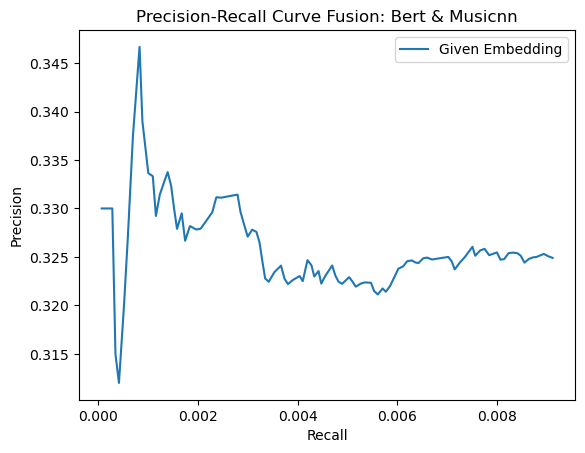

([0.33,
  0.33,
  0.33,
  0.315,
  0.312,
  0.32,
  0.32714285714285707,
  0.3375,
  0.34666666666666673,
  0.3390000000000001,
  0.3336363636363637,
  0.33333333333333326,
  0.3292307692307692,
  0.33142857142857146,
  0.33266666666666667,
  0.33375,
  0.3323529411764706,
  0.33000000000000007,
  0.3278947368421053,
  0.32949999999999996,
  0.32666666666666666,
  0.3281818181818182,
  0.3278260869565217,
  0.32791666666666663,
  0.32960000000000006,
  0.3311538461538462,
  0.33111111111111113,
  0.3314285714285714,
  0.32965517241379305,
  0.32833333333333337,
  0.3270967741935483,
  0.3278125,
  0.3275757575757576,
  0.3264705882352942,
  0.32457142857142857,
  0.3227777777777778,
  0.32243243243243247,
  0.3234210526315789,
  0.3241025641025641,
  0.32275,
  0.3221951219512195,
  0.3226190476190476,
  0.3230232558139535,
  0.3225,
  0.32466666666666666,
  0.32413043478260867,
  0.3229787234042554,
  0.3235416666666666,
  0.32224489795918365,
  0.32300000000000006,
  0.32411764705882

In [41]:
sample_size = 100
k_range = range(1, 101)


calc_avg_recall_precision_fusion(fusion_bert_musicnn, k_range, sample_size)

# Late Fusion Plot

In [36]:
def get_late_fusion(embedding1, embedding2):
    cos_sim_matrix1 = generate_cos_sim_matrix(embedding1)
    cos_sim_matrix2 = generate_cos_sim_matrix(embedding2)
    
    cos_sim_matrix_df = (cos_sim_matrix1 + cos_sim_matrix2)/2
    
    return cos_sim_matrix_df

In [44]:
late_fusion_bert_musicnn = get_late_fusion(bert,musicnn)
late_fusion_bert_musicnn = pd.merge(late_fusion_bert_musicnn, genres, on='id')

(10094, 769)
(10094, 51)


In [ ]:
#Call the function with parameters range and sample size
sample_size = 100
k_range = range(1, 101)


calc_avg_recall_precision_fusion(late_fusion_bert_musicnn, k_range, sample_size)

Processed query K36H0lEtqS3IJgGa for k=1 - Precision: 1.00, Recall: 0.00
Processed query XcDu72gipo0aCTDp for k=1 - Precision: 0.00, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=1 - Precision: 0.00, Recall: 0.00
Processed query R93jlIJhpkr8us7B for k=1 - Precision: 0.00, Recall: 0.00
Processed query lRK06n1HkuHlVdRo for k=1 - Precision: 1.00, Recall: 0.00
Processed query 5ftT5BqtrCNZLduo for k=1 - Precision: 0.00, Recall: 0.00
Processed query 8cuW0Czq9znbWWDF for k=1 - Precision: 0.00, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=1 - Precision: 1.00, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=1 - Precision: 0.00, Recall: 0.00
Processed query 8kVftLAGITZr615k for k=1 - Precision: 1.00, Recall: 0.00
Processed query yWvF1HBSIWXNwU5v for k=1 - Precision: 1.00, Recall: 0.00
Processed query dOZLy4CMYHUeZbGT for k=1 - Precision: 0.00, Recall: 0.00
Processed query 4SWXyQowIzeDzByN for k=1 - Precision: 1.00, Recall: 0.00
Processed query Itah1m1jjfddZ3KW for k=1 - Precisio

Processed query 4SWXyQowIzeDzByN for k=2 - Precision: 0.50, Recall: 0.00
Processed query Itah1m1jjfddZ3KW for k=2 - Precision: 1.00, Recall: 0.00
Processed query QJUOuZ8EDmC080zG for k=2 - Precision: 0.00, Recall: 0.00
Processed query RZFAxeTNHDjiqDDk for k=2 - Precision: 0.50, Recall: 0.00
Processed query IskjrPr0ynMp4cx5 for k=2 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=2 - Precision: 1.00, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=2 - Precision: 1.00, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k=2 - Precision: 1.00, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=2 - Precision: 0.50, Recall: 0.00
Processed query ZVjUg4rlqeq2zk7C for k=2 - Precision: 0.50, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=2 - Precision: 1.00, Recall: 0.00
Processed query 51XYIfDaAUgQXb5u for k=2 - Precision: 0.50, Recall: 0.00
Processed query zu7Ieztdu2L7624a for k=2 - Precision: 0.00, Recall: 0.00
Processed query gMdQONPf9JdWb6MS for k=2 - Precisio

Processed query zu7Ieztdu2L7624a for k=3 - Precision: 0.00, Recall: 0.00
Processed query gMdQONPf9JdWb6MS for k=3 - Precision: 0.67, Recall: 0.00
Processed query 33Dmw7IfH4587uMq for k=3 - Precision: 0.33, Recall: 0.00
Processed query ZLTgggcn9mzPGtBo for k=3 - Precision: 0.33, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=3 - Precision: 0.33, Recall: 0.00
Processed query FNleftK6MGMEccyk for k=3 - Precision: 0.00, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=3 - Precision: 1.00, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=3 - Precision: 1.00, Recall: 0.00
Processed query KcCbr0D0Ns3up2aY for k=3 - Precision: 0.00, Recall: 0.00
Processed query gArfXgzD7shidcGf for k=3 - Precision: 0.33, Recall: 0.00
Processed query 9TFM3GpDFLAJQTQ4 for k=3 - Precision: 0.33, Recall: 0.00
Processed query 0PLdz2RKGsXnnTDO for k=3 - Precision: 0.67, Recall: 0.00
Processed query tbF2tUUkAXDzk7sZ for k=3 - Precision: 0.67, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=3 - Precisio

Processed query tbF2tUUkAXDzk7sZ for k=4 - Precision: 0.50, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=4 - Precision: 0.00, Recall: 0.00
Processed query n1g70shgqaVn2taR for k=4 - Precision: 0.00, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k=4 - Precision: 0.50, Recall: 0.00
Processed query Y39cAEoCjGPvsgXi for k=4 - Precision: 0.00, Recall: 0.00
Processed query PvyKzuD8i6m1qztk for k=4 - Precision: 0.00, Recall: 0.00
Processed query 1H7yQe1NljCbMapi for k=4 - Precision: 0.75, Recall: 0.00
Processed query yY6AbJhiY7HXlPtf for k=4 - Precision: 0.50, Recall: 0.00
Processed query C8hHrdzeQLfPqvL8 for k=4 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=4 - Precision: 0.50, Recall: 0.00
Processed query DrYdSKYlfDS5XiEv for k=4 - Precision: 0.50, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=4 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=4 - Precision: 0.25, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k=4 - Precisio

Processed query myoCvPb1dyaj0Tf0 for k=5 - Precision: 0.20, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k=5 - Precision: 0.40, Recall: 0.00
Processed query VmUbfpibcjjJiEqd for k=5 - Precision: 0.60, Recall: 0.00
Processed query k359CixIFRVz3QHM for k=5 - Precision: 0.60, Recall: 0.00
Processed query QH7tv1qz2s78YuRw for k=5 - Precision: 0.20, Recall: 0.00
Processed query RBel2WHKJHRhFRRd for k=5 - Precision: 0.80, Recall: 0.00
Processed query eA7otcM8UibYxfdU for k=5 - Precision: 0.60, Recall: 0.00
Processed query knNh9yJ5u9gGriJ7 for k=5 - Precision: 0.00, Recall: 0.00
Processed query baerAOUagyrMzFlv for k=5 - Precision: 0.80, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=5 - Precision: 0.00, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=5 - Precision: 0.60, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k=5 - Precision: 0.40, Recall: 0.00
Processed query B73dsXi3KH47rONI for k=5 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=5 - Precisio

Processed query B73dsXi3KH47rONI for k=6 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=6 - Precision: 0.67, Recall: 0.00
Processed query x1lYeflN0UfkRpWY for k=6 - Precision: 0.50, Recall: 0.00
Processed query cP5xGVKo0BK2njzW for k=6 - Precision: 0.17, Recall: 0.00
Processed query SJTKS9aOWdBeKxKG for k=6 - Precision: 0.50, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=6 - Precision: 0.67, Recall: 0.00
Processed query fbjU4wiAgu6prbVW for k=6 - Precision: 0.00, Recall: 0.00
Processed query tpNuKQ6SG36keS38 for k=6 - Precision: 0.67, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=6 - Precision: 0.00, Recall: 0.00
Processed query UtB4uXYVhtq5AVW8 for k=6 - Precision: 0.00, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=6 - Precision: 0.50, Recall: 0.00
Processed query qAYXQNGXXoLd3hyu for k=6 - Precision: 0.00, Recall: 0.00
Processed query S9ppCfJiyWLpqDpD for k=6 - Precision: 0.33, Recall: 0.00
Processed query WAbTyx902fLAd8Q5 for k=6 - Precisio

Processed query S9ppCfJiyWLpqDpD for k=7 - Precision: 0.43, Recall: 0.00
Processed query WAbTyx902fLAd8Q5 for k=7 - Precision: 0.57, Recall: 0.00
Processed query 2Ug2BJtfpP8ZCBEE for k=7 - Precision: 0.00, Recall: 0.00
Processed query rlYEWOpYxNrY5rHO for k=7 - Precision: 0.14, Recall: 0.00
Processed query jGJUNhikVMuw39F5 for k=7 - Precision: 0.14, Recall: 0.00
Processed query jReZjxRp2qpEMyhf for k=7 - Precision: 0.57, Recall: 0.00
Processed query gtOnjIuPPcgLxShP for k=7 - Precision: 0.57, Recall: 0.00
Processed query sg8sZZHqiIEY7D5S for k=7 - Precision: 0.43, Recall: 0.00
Processed query ZbpkHgAWTYhnBNIP for k=7 - Precision: 0.43, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=7 - Precision: 0.57, Recall: 0.00
Processed query y4sQsWQuCX7wYgPt for k=7 - Precision: 0.00, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=7 - Precision: 0.00, Recall: 0.00
Processed query yHeHLXeI0YnQIWhT for k=7 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=7 - Precisio

Processed query yHeHLXeI0YnQIWhT for k=8 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=8 - Precision: 0.38, Recall: 0.00
Processed query 0B2bXOAXyevoV57H for k=8 - Precision: 0.38, Recall: 0.00
Processed query 5r1cmqvduj3t3knp for k=8 - Precision: 0.38, Recall: 0.00
Processed query 8uQDKgYxio9X13mW for k=8 - Precision: 0.50, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k=8 - Precision: 0.00, Recall: 0.00
Processed query losLsXKN1j4HtMYI for k=8 - Precision: 0.00, Recall: 0.00
Processed query JlkdYV1tueKwaHxe for k=8 - Precision: 0.25, Recall: 0.00
Processed query WvOHvXca310ggKom for k=8 - Precision: 0.38, Recall: 0.00
Processed query He8NPqGTttEp5ML0 for k=8 - Precision: 0.50, Recall: 0.00
Processed query OwdptJvVgE53lNhW for k=8 - Precision: 0.38, Recall: 0.00
Processed query mKyhP8m8am4hnodk for k=8 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=8 - Precision: 0.12, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=8 - Precisio

Processed query iJptF9CGibeMr8Hi for k=9 - Precision: 0.11, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=9 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=9 - Precision: 0.56, Recall: 0.00
Processed query C7rdNgxhvWzae6iv for k=9 - Precision: 0.44, Recall: 0.00
Avg Precision at k=9: 0.37, Avg Recall at k=9: 0.00

Processed query K36H0lEtqS3IJgGa for k=10 - Precision: 0.70, Recall: 0.00
Processed query XcDu72gipo0aCTDp for k=10 - Precision: 0.30, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=10 - Precision: 0.50, Recall: 0.00
Processed query R93jlIJhpkr8us7B for k=10 - Precision: 0.30, Recall: 0.00
Processed query lRK06n1HkuHlVdRo for k=10 - Precision: 0.30, Recall: 0.00
Processed query 5ftT5BqtrCNZLduo for k=10 - Precision: 0.20, Recall: 0.00
Processed query 8cuW0Czq9znbWWDF for k=10 - Precision: 0.50, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=10 - Precision: 0.70, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=10 - Precision: 0.40, Re

Processed query 8cuW0Czq9znbWWDF for k=11 - Precision: 0.55, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=11 - Precision: 0.73, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=11 - Precision: 0.45, Recall: 0.00
Processed query 8kVftLAGITZr615k for k=11 - Precision: 0.73, Recall: 0.00
Processed query yWvF1HBSIWXNwU5v for k=11 - Precision: 0.64, Recall: 0.00
Processed query dOZLy4CMYHUeZbGT for k=11 - Precision: 0.00, Recall: 0.00
Processed query 4SWXyQowIzeDzByN for k=11 - Precision: 0.73, Recall: 0.00
Processed query Itah1m1jjfddZ3KW for k=11 - Precision: 0.55, Recall: 0.00
Processed query QJUOuZ8EDmC080zG for k=11 - Precision: 0.55, Recall: 0.00
Processed query RZFAxeTNHDjiqDDk for k=11 - Precision: 0.45, Recall: 0.00
Processed query IskjrPr0ynMp4cx5 for k=11 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=11 - Precision: 0.73, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=11 - Precision: 0.73, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=12 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=12 - Precision: 0.75, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=12 - Precision: 0.67, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k=12 - Precision: 0.58, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=12 - Precision: 0.25, Recall: 0.00
Processed query ZVjUg4rlqeq2zk7C for k=12 - Precision: 0.25, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=12 - Precision: 0.58, Recall: 0.00
Processed query 51XYIfDaAUgQXb5u for k=12 - Precision: 0.58, Recall: 0.00
Processed query zu7Ieztdu2L7624a for k=12 - Precision: 0.08, Recall: 0.00
Processed query gMdQONPf9JdWb6MS for k=12 - Precision: 0.25, Recall: 0.00
Processed query 33Dmw7IfH4587uMq for k=12 - Precision: 0.42, Recall: 0.00
Processed query ZLTgggcn9mzPGtBo for k=12 - Precision: 0.42, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=12 - Precision: 0.25, Recall: 0.00
Processed query FNleftK6MGMEccyk for k

Processed query 33Dmw7IfH4587uMq for k=13 - Precision: 0.38, Recall: 0.00
Processed query ZLTgggcn9mzPGtBo for k=13 - Precision: 0.38, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=13 - Precision: 0.31, Recall: 0.00
Processed query FNleftK6MGMEccyk for k=13 - Precision: 0.08, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=13 - Precision: 0.54, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=13 - Precision: 0.62, Recall: 0.00
Processed query KcCbr0D0Ns3up2aY for k=13 - Precision: 0.00, Recall: 0.00
Processed query gArfXgzD7shidcGf for k=13 - Precision: 0.54, Recall: 0.00
Processed query 9TFM3GpDFLAJQTQ4 for k=13 - Precision: 0.69, Recall: 0.00
Processed query 0PLdz2RKGsXnnTDO for k=13 - Precision: 0.69, Recall: 0.00
Processed query tbF2tUUkAXDzk7sZ for k=13 - Precision: 0.23, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=13 - Precision: 0.31, Recall: 0.00
Processed query n1g70shgqaVn2taR for k=13 - Precision: 0.31, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k

Processed query tbF2tUUkAXDzk7sZ for k=14 - Precision: 0.29, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=14 - Precision: 0.36, Recall: 0.00
Processed query n1g70shgqaVn2taR for k=14 - Precision: 0.36, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k=14 - Precision: 0.43, Recall: 0.00
Processed query Y39cAEoCjGPvsgXi for k=14 - Precision: 0.14, Recall: 0.00
Processed query PvyKzuD8i6m1qztk for k=14 - Precision: 0.00, Recall: 0.00
Processed query 1H7yQe1NljCbMapi for k=14 - Precision: 0.79, Recall: 0.00
Processed query yY6AbJhiY7HXlPtf for k=14 - Precision: 0.50, Recall: 0.00
Processed query C8hHrdzeQLfPqvL8 for k=14 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=14 - Precision: 0.71, Recall: 0.00
Processed query DrYdSKYlfDS5XiEv for k=14 - Precision: 0.21, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=14 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=14 - Precision: 0.36, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k

Processed query DrYdSKYlfDS5XiEv for k=15 - Precision: 0.27, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=15 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=15 - Precision: 0.33, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k=15 - Precision: 0.53, Recall: 0.00
Processed query VmUbfpibcjjJiEqd for k=15 - Precision: 0.33, Recall: 0.00
Processed query k359CixIFRVz3QHM for k=15 - Precision: 0.60, Recall: 0.00
Processed query QH7tv1qz2s78YuRw for k=15 - Precision: 0.20, Recall: 0.00
Processed query RBel2WHKJHRhFRRd for k=15 - Precision: 0.60, Recall: 0.00
Processed query eA7otcM8UibYxfdU for k=15 - Precision: 0.47, Recall: 0.00
Processed query knNh9yJ5u9gGriJ7 for k=15 - Precision: 0.00, Recall: 0.00
Processed query baerAOUagyrMzFlv for k=15 - Precision: 0.73, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=15 - Precision: 0.13, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=15 - Precision: 0.47, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k

Processed query baerAOUagyrMzFlv for k=16 - Precision: 0.69, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=16 - Precision: 0.12, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=16 - Precision: 0.44, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k=16 - Precision: 0.25, Recall: 0.00
Processed query B73dsXi3KH47rONI for k=16 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=16 - Precision: 0.44, Recall: 0.00
Processed query x1lYeflN0UfkRpWY for k=16 - Precision: 0.31, Recall: 0.00
Processed query cP5xGVKo0BK2njzW for k=16 - Precision: 0.25, Recall: 0.00
Processed query SJTKS9aOWdBeKxKG for k=16 - Precision: 0.50, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=16 - Precision: 0.44, Recall: 0.00
Processed query fbjU4wiAgu6prbVW for k=16 - Precision: 0.06, Recall: 0.00
Processed query tpNuKQ6SG36keS38 for k=16 - Precision: 0.62, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=16 - Precision: 0.06, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k

Processed query fbjU4wiAgu6prbVW for k=17 - Precision: 0.06, Recall: 0.00
Processed query tpNuKQ6SG36keS38 for k=17 - Precision: 0.65, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=17 - Precision: 0.06, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k=17 - Precision: 0.06, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=17 - Precision: 0.65, Recall: 0.00
Processed query qAYXQNGXXoLd3hyu for k=17 - Precision: 0.00, Recall: 0.00
Processed query S9ppCfJiyWLpqDpD for k=17 - Precision: 0.47, Recall: 0.00
Processed query WAbTyx902fLAd8Q5 for k=17 - Precision: 0.53, Recall: 0.00
Processed query 2Ug2BJtfpP8ZCBEE for k=17 - Precision: 0.00, Recall: 0.00
Processed query rlYEWOpYxNrY5rHO for k=17 - Precision: 0.18, Recall: 0.00
Processed query jGJUNhikVMuw39F5 for k=17 - Precision: 0.12, Recall: 0.00
Processed query jReZjxRp2qpEMyhf for k=17 - Precision: 0.71, Recall: 0.00
Processed query gtOnjIuPPcgLxShP for k=17 - Precision: 0.47, Recall: 0.00
Processed query sg8sZZHqiIEY7D5S for k

Processed query jGJUNhikVMuw39F5 for k=18 - Precision: 0.11, Recall: 0.00
Processed query jReZjxRp2qpEMyhf for k=18 - Precision: 0.67, Recall: 0.00
Processed query gtOnjIuPPcgLxShP for k=18 - Precision: 0.50, Recall: 0.00
Processed query sg8sZZHqiIEY7D5S for k=18 - Precision: 0.33, Recall: 0.00
Processed query ZbpkHgAWTYhnBNIP for k=18 - Precision: 0.50, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=18 - Precision: 0.61, Recall: 0.00
Processed query y4sQsWQuCX7wYgPt for k=18 - Precision: 0.00, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=18 - Precision: 0.22, Recall: 0.00
Processed query yHeHLXeI0YnQIWhT for k=18 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=18 - Precision: 0.67, Recall: 0.00
Processed query 0B2bXOAXyevoV57H for k=18 - Precision: 0.50, Recall: 0.00
Processed query 5r1cmqvduj3t3knp for k=18 - Precision: 0.33, Recall: 0.00
Processed query 8uQDKgYxio9X13mW for k=18 - Precision: 0.39, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k

Processed query 0B2bXOAXyevoV57H for k=19 - Precision: 0.53, Recall: 0.00
Processed query 5r1cmqvduj3t3knp for k=19 - Precision: 0.37, Recall: 0.00
Processed query 8uQDKgYxio9X13mW for k=19 - Precision: 0.37, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k=19 - Precision: 0.05, Recall: 0.02
Processed query losLsXKN1j4HtMYI for k=19 - Precision: 0.05, Recall: 0.00
Processed query JlkdYV1tueKwaHxe for k=19 - Precision: 0.32, Recall: 0.00
Processed query WvOHvXca310ggKom for k=19 - Precision: 0.32, Recall: 0.00
Processed query He8NPqGTttEp5ML0 for k=19 - Precision: 0.37, Recall: 0.00
Processed query OwdptJvVgE53lNhW for k=19 - Precision: 0.32, Recall: 0.00
Processed query mKyhP8m8am4hnodk for k=19 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=19 - Precision: 0.11, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=19 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=19 - Precision: 0.63, Recall: 0.00
Processed query C7rdNgxhvWzae6iv for k

Processed query iJptF9CGibeMr8Hi for k=20 - Precision: 0.10, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=20 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=20 - Precision: 0.60, Recall: 0.00
Processed query C7rdNgxhvWzae6iv for k=20 - Precision: 0.40, Recall: 0.00
Avg Precision at k=20: 0.36, Avg Recall at k=20: 0.00

Processed query K36H0lEtqS3IJgGa for k=21 - Precision: 0.67, Recall: 0.00
Processed query XcDu72gipo0aCTDp for k=21 - Precision: 0.24, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=21 - Precision: 0.48, Recall: 0.00
Processed query R93jlIJhpkr8us7B for k=21 - Precision: 0.14, Recall: 0.00
Processed query lRK06n1HkuHlVdRo for k=21 - Precision: 0.24, Recall: 0.00
Processed query 5ftT5BqtrCNZLduo for k=21 - Precision: 0.10, Recall: 0.00
Processed query 8cuW0Czq9znbWWDF for k=21 - Precision: 0.62, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=21 - Precision: 0.67, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=21 - Precision: 0.

Processed query 8cuW0Czq9znbWWDF for k=22 - Precision: 0.64, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=22 - Precision: 0.68, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=22 - Precision: 0.55, Recall: 0.00
Processed query 8kVftLAGITZr615k for k=22 - Precision: 0.41, Recall: 0.00
Processed query yWvF1HBSIWXNwU5v for k=22 - Precision: 0.68, Recall: 0.00
Processed query dOZLy4CMYHUeZbGT for k=22 - Precision: 0.14, Recall: 0.00
Processed query 4SWXyQowIzeDzByN for k=22 - Precision: 0.64, Recall: 0.00
Processed query Itah1m1jjfddZ3KW for k=22 - Precision: 0.45, Recall: 0.00
Processed query QJUOuZ8EDmC080zG for k=22 - Precision: 0.55, Recall: 0.00
Processed query RZFAxeTNHDjiqDDk for k=22 - Precision: 0.41, Recall: 0.00
Processed query IskjrPr0ynMp4cx5 for k=22 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=22 - Precision: 0.59, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=22 - Precision: 0.68, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=23 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=23 - Precision: 0.57, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=23 - Precision: 0.65, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k=23 - Precision: 0.48, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=23 - Precision: 0.30, Recall: 0.00
Processed query ZVjUg4rlqeq2zk7C for k=23 - Precision: 0.26, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=23 - Precision: 0.52, Recall: 0.00
Processed query 51XYIfDaAUgQXb5u for k=23 - Precision: 0.52, Recall: 0.00
Processed query zu7Ieztdu2L7624a for k=23 - Precision: 0.13, Recall: 0.00
Processed query gMdQONPf9JdWb6MS for k=23 - Precision: 0.39, Recall: 0.00
Processed query 33Dmw7IfH4587uMq for k=23 - Precision: 0.30, Recall: 0.00
Processed query ZLTgggcn9mzPGtBo for k=23 - Precision: 0.26, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=23 - Precision: 0.39, Recall: 0.00
Processed query FNleftK6MGMEccyk for k

Processed query 33Dmw7IfH4587uMq for k=24 - Precision: 0.29, Recall: 0.00
Processed query ZLTgggcn9mzPGtBo for k=24 - Precision: 0.25, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=24 - Precision: 0.38, Recall: 0.00
Processed query FNleftK6MGMEccyk for k=24 - Precision: 0.04, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=24 - Precision: 0.58, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=24 - Precision: 0.54, Recall: 0.00
Processed query KcCbr0D0Ns3up2aY for k=24 - Precision: 0.00, Recall: 0.00
Processed query gArfXgzD7shidcGf for k=24 - Precision: 0.54, Recall: 0.00
Processed query 9TFM3GpDFLAJQTQ4 for k=24 - Precision: 0.54, Recall: 0.00
Processed query 0PLdz2RKGsXnnTDO for k=24 - Precision: 0.67, Recall: 0.00
Processed query tbF2tUUkAXDzk7sZ for k=24 - Precision: 0.38, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=24 - Precision: 0.42, Recall: 0.00
Processed query n1g70shgqaVn2taR for k=24 - Precision: 0.38, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k

Processed query tbF2tUUkAXDzk7sZ for k=25 - Precision: 0.36, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=25 - Precision: 0.40, Recall: 0.00
Processed query n1g70shgqaVn2taR for k=25 - Precision: 0.40, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k=25 - Precision: 0.32, Recall: 0.00
Processed query Y39cAEoCjGPvsgXi for k=25 - Precision: 0.16, Recall: 0.00
Processed query PvyKzuD8i6m1qztk for k=25 - Precision: 0.04, Recall: 0.00
Processed query 1H7yQe1NljCbMapi for k=25 - Precision: 0.56, Recall: 0.00
Processed query yY6AbJhiY7HXlPtf for k=25 - Precision: 0.52, Recall: 0.00
Processed query C8hHrdzeQLfPqvL8 for k=25 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=25 - Precision: 0.76, Recall: 0.00
Processed query DrYdSKYlfDS5XiEv for k=25 - Precision: 0.20, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=25 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=25 - Precision: 0.40, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k

Processed query DrYdSKYlfDS5XiEv for k=26 - Precision: 0.19, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=26 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=26 - Precision: 0.42, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k=26 - Precision: 0.62, Recall: 0.00
Processed query VmUbfpibcjjJiEqd for k=26 - Precision: 0.38, Recall: 0.00
Processed query k359CixIFRVz3QHM for k=26 - Precision: 0.62, Recall: 0.00
Processed query QH7tv1qz2s78YuRw for k=26 - Precision: 0.23, Recall: 0.00
Processed query RBel2WHKJHRhFRRd for k=26 - Precision: 0.73, Recall: 0.00
Processed query eA7otcM8UibYxfdU for k=26 - Precision: 0.62, Recall: 0.00
Processed query knNh9yJ5u9gGriJ7 for k=26 - Precision: 0.04, Recall: 0.01
Processed query baerAOUagyrMzFlv for k=26 - Precision: 0.58, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=26 - Precision: 0.31, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=26 - Precision: 0.42, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k

Processed query baerAOUagyrMzFlv for k=27 - Precision: 0.59, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=27 - Precision: 0.33, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=27 - Precision: 0.44, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k=27 - Precision: 0.22, Recall: 0.00
Processed query B73dsXi3KH47rONI for k=27 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=27 - Precision: 0.37, Recall: 0.00
Processed query x1lYeflN0UfkRpWY for k=27 - Precision: 0.30, Recall: 0.00
Processed query cP5xGVKo0BK2njzW for k=27 - Precision: 0.37, Recall: 0.00
Processed query SJTKS9aOWdBeKxKG for k=27 - Precision: 0.59, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=27 - Precision: 0.44, Recall: 0.00
Processed query fbjU4wiAgu6prbVW for k=27 - Precision: 0.19, Recall: 0.00
Processed query tpNuKQ6SG36keS38 for k=27 - Precision: 0.56, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=27 - Precision: 0.04, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k

Processed query fbjU4wiAgu6prbVW for k=28 - Precision: 0.18, Recall: 0.00
Processed query tpNuKQ6SG36keS38 for k=28 - Precision: 0.57, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=28 - Precision: 0.04, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k=28 - Precision: 0.04, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=28 - Precision: 0.71, Recall: 0.00
Processed query qAYXQNGXXoLd3hyu for k=28 - Precision: 0.00, Recall: 0.00
Processed query S9ppCfJiyWLpqDpD for k=28 - Precision: 0.29, Recall: 0.00
Processed query WAbTyx902fLAd8Q5 for k=28 - Precision: 0.54, Recall: 0.00
Processed query 2Ug2BJtfpP8ZCBEE for k=28 - Precision: 0.00, Recall: 0.00
Processed query rlYEWOpYxNrY5rHO for k=28 - Precision: 0.29, Recall: 0.00
Processed query jGJUNhikVMuw39F5 for k=28 - Precision: 0.18, Recall: 0.00
Processed query jReZjxRp2qpEMyhf for k=28 - Precision: 0.61, Recall: 0.00
Processed query gtOnjIuPPcgLxShP for k=28 - Precision: 0.50, Recall: 0.00
Processed query sg8sZZHqiIEY7D5S for k

Processed query jGJUNhikVMuw39F5 for k=29 - Precision: 0.17, Recall: 0.00
Processed query jReZjxRp2qpEMyhf for k=29 - Precision: 0.59, Recall: 0.00
Processed query gtOnjIuPPcgLxShP for k=29 - Precision: 0.48, Recall: 0.00
Processed query sg8sZZHqiIEY7D5S for k=29 - Precision: 0.41, Recall: 0.00
Processed query ZbpkHgAWTYhnBNIP for k=29 - Precision: 0.59, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=29 - Precision: 0.55, Recall: 0.00
Processed query y4sQsWQuCX7wYgPt for k=29 - Precision: 0.03, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=29 - Precision: 0.17, Recall: 0.00
Processed query yHeHLXeI0YnQIWhT for k=29 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=29 - Precision: 0.69, Recall: 0.00
Processed query 0B2bXOAXyevoV57H for k=29 - Precision: 0.48, Recall: 0.00
Processed query 5r1cmqvduj3t3knp for k=29 - Precision: 0.31, Recall: 0.00
Processed query 8uQDKgYxio9X13mW for k=29 - Precision: 0.48, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k

Processed query 0B2bXOAXyevoV57H for k=30 - Precision: 0.50, Recall: 0.00
Processed query 5r1cmqvduj3t3knp for k=30 - Precision: 0.30, Recall: 0.00
Processed query 8uQDKgYxio9X13mW for k=30 - Precision: 0.50, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k=30 - Precision: 0.03, Recall: 0.02
Processed query losLsXKN1j4HtMYI for k=30 - Precision: 0.03, Recall: 0.00
Processed query JlkdYV1tueKwaHxe for k=30 - Precision: 0.37, Recall: 0.00
Processed query WvOHvXca310ggKom for k=30 - Precision: 0.37, Recall: 0.00
Processed query He8NPqGTttEp5ML0 for k=30 - Precision: 0.47, Recall: 0.00
Processed query OwdptJvVgE53lNhW for k=30 - Precision: 0.47, Recall: 0.00
Processed query mKyhP8m8am4hnodk for k=30 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=30 - Precision: 0.10, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=30 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=30 - Precision: 0.63, Recall: 0.00
Processed query C7rdNgxhvWzae6iv for k

Processed query iJptF9CGibeMr8Hi for k=31 - Precision: 0.10, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=31 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=31 - Precision: 0.65, Recall: 0.00
Processed query C7rdNgxhvWzae6iv for k=31 - Precision: 0.29, Recall: 0.00
Avg Precision at k=31: 0.36, Avg Recall at k=31: 0.00

Processed query K36H0lEtqS3IJgGa for k=32 - Precision: 0.62, Recall: 0.00
Processed query XcDu72gipo0aCTDp for k=32 - Precision: 0.28, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=32 - Precision: 0.44, Recall: 0.00
Processed query R93jlIJhpkr8us7B for k=32 - Precision: 0.16, Recall: 0.00
Processed query lRK06n1HkuHlVdRo for k=32 - Precision: 0.25, Recall: 0.00
Processed query 5ftT5BqtrCNZLduo for k=32 - Precision: 0.06, Recall: 0.00
Processed query 8cuW0Czq9znbWWDF for k=32 - Precision: 0.75, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=32 - Precision: 0.66, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=32 - Precision: 0.

Processed query 8cuW0Czq9znbWWDF for k=33 - Precision: 0.76, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=33 - Precision: 0.64, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=33 - Precision: 0.67, Recall: 0.00
Processed query 8kVftLAGITZr615k for k=33 - Precision: 0.45, Recall: 0.00
Processed query yWvF1HBSIWXNwU5v for k=33 - Precision: 0.70, Recall: 0.00
Processed query dOZLy4CMYHUeZbGT for k=33 - Precision: 0.15, Recall: 0.00
Processed query 4SWXyQowIzeDzByN for k=33 - Precision: 0.67, Recall: 0.00
Processed query Itah1m1jjfddZ3KW for k=33 - Precision: 0.48, Recall: 0.00
Processed query QJUOuZ8EDmC080zG for k=33 - Precision: 0.48, Recall: 0.00
Processed query RZFAxeTNHDjiqDDk for k=33 - Precision: 0.48, Recall: 0.00
Processed query IskjrPr0ynMp4cx5 for k=33 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=33 - Precision: 0.55, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=33 - Precision: 0.61, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=34 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=34 - Precision: 0.53, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=34 - Precision: 0.59, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k=34 - Precision: 0.41, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=34 - Precision: 0.35, Recall: 0.00
Processed query ZVjUg4rlqeq2zk7C for k=34 - Precision: 0.26, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=34 - Precision: 0.59, Recall: 0.00
Processed query 51XYIfDaAUgQXb5u for k=34 - Precision: 0.59, Recall: 0.00
Processed query zu7Ieztdu2L7624a for k=34 - Precision: 0.15, Recall: 0.00
Processed query gMdQONPf9JdWb6MS for k=34 - Precision: 0.56, Recall: 0.00
Processed query 33Dmw7IfH4587uMq for k=34 - Precision: 0.24, Recall: 0.00
Processed query ZLTgggcn9mzPGtBo for k=34 - Precision: 0.26, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=34 - Precision: 0.35, Recall: 0.00
Processed query FNleftK6MGMEccyk for k

Processed query 33Dmw7IfH4587uMq for k=35 - Precision: 0.23, Recall: 0.00
Processed query ZLTgggcn9mzPGtBo for k=35 - Precision: 0.26, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=35 - Precision: 0.34, Recall: 0.00
Processed query FNleftK6MGMEccyk for k=35 - Precision: 0.06, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=35 - Precision: 0.63, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=35 - Precision: 0.40, Recall: 0.00
Processed query KcCbr0D0Ns3up2aY for k=35 - Precision: 0.03, Recall: 0.00
Processed query gArfXgzD7shidcGf for k=35 - Precision: 0.60, Recall: 0.00
Processed query 9TFM3GpDFLAJQTQ4 for k=35 - Precision: 0.49, Recall: 0.00
Processed query 0PLdz2RKGsXnnTDO for k=35 - Precision: 0.57, Recall: 0.00
Processed query tbF2tUUkAXDzk7sZ for k=35 - Precision: 0.40, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=35 - Precision: 0.40, Recall: 0.00
Processed query n1g70shgqaVn2taR for k=35 - Precision: 0.40, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k

Processed query tbF2tUUkAXDzk7sZ for k=36 - Precision: 0.39, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=36 - Precision: 0.42, Recall: 0.00
Processed query n1g70shgqaVn2taR for k=36 - Precision: 0.42, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k=36 - Precision: 0.31, Recall: 0.00
Processed query Y39cAEoCjGPvsgXi for k=36 - Precision: 0.17, Recall: 0.00
Processed query PvyKzuD8i6m1qztk for k=36 - Precision: 0.03, Recall: 0.00
Processed query 1H7yQe1NljCbMapi for k=36 - Precision: 0.53, Recall: 0.00
Processed query yY6AbJhiY7HXlPtf for k=36 - Precision: 0.56, Recall: 0.00
Processed query C8hHrdzeQLfPqvL8 for k=36 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=36 - Precision: 0.64, Recall: 0.00
Processed query DrYdSKYlfDS5XiEv for k=36 - Precision: 0.19, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=36 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=36 - Precision: 0.36, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k

Processed query DrYdSKYlfDS5XiEv for k=37 - Precision: 0.19, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=37 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=37 - Precision: 0.35, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k=37 - Precision: 0.57, Recall: 0.00
Processed query VmUbfpibcjjJiEqd for k=37 - Precision: 0.32, Recall: 0.00
Processed query k359CixIFRVz3QHM for k=37 - Precision: 0.68, Recall: 0.00
Processed query QH7tv1qz2s78YuRw for k=37 - Precision: 0.19, Recall: 0.00
Processed query RBel2WHKJHRhFRRd for k=37 - Precision: 0.62, Recall: 0.00
Processed query eA7otcM8UibYxfdU for k=37 - Precision: 0.62, Recall: 0.00
Processed query knNh9yJ5u9gGriJ7 for k=37 - Precision: 0.03, Recall: 0.01
Processed query baerAOUagyrMzFlv for k=37 - Precision: 0.59, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=37 - Precision: 0.35, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=37 - Precision: 0.46, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k

Processed query baerAOUagyrMzFlv for k=38 - Precision: 0.61, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=38 - Precision: 0.37, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=38 - Precision: 0.47, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k=38 - Precision: 0.21, Recall: 0.01
Processed query B73dsXi3KH47rONI for k=38 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=38 - Precision: 0.34, Recall: 0.01
Processed query x1lYeflN0UfkRpWY for k=38 - Precision: 0.34, Recall: 0.00
Processed query cP5xGVKo0BK2njzW for k=38 - Precision: 0.34, Recall: 0.00
Processed query SJTKS9aOWdBeKxKG for k=38 - Precision: 0.63, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=38 - Precision: 0.45, Recall: 0.00
Processed query fbjU4wiAgu6prbVW for k=38 - Precision: 0.21, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=38 - Precision: 0.63, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=38 - Precision: 0.03, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k

Processed query fbjU4wiAgu6prbVW for k=39 - Precision: 0.21, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=39 - Precision: 0.64, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=39 - Precision: 0.03, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k=39 - Precision: 0.03, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=39 - Precision: 0.64, Recall: 0.00
Processed query qAYXQNGXXoLd3hyu for k=39 - Precision: 0.03, Recall: 0.01
Processed query S9ppCfJiyWLpqDpD for k=39 - Precision: 0.23, Recall: 0.00
Processed query WAbTyx902fLAd8Q5 for k=39 - Precision: 0.56, Recall: 0.00
Processed query 2Ug2BJtfpP8ZCBEE for k=39 - Precision: 0.03, Recall: 0.01
Processed query rlYEWOpYxNrY5rHO for k=39 - Precision: 0.36, Recall: 0.00
Processed query jGJUNhikVMuw39F5 for k=39 - Precision: 0.13, Recall: 0.00
Processed query jReZjxRp2qpEMyhf for k=39 - Precision: 0.56, Recall: 0.00
Processed query gtOnjIuPPcgLxShP for k=39 - Precision: 0.54, Recall: 0.00
Processed query sg8sZZHqiIEY7D5S for k

Processed query jGJUNhikVMuw39F5 for k=40 - Precision: 0.12, Recall: 0.00
Processed query jReZjxRp2qpEMyhf for k=40 - Precision: 0.57, Recall: 0.00
Processed query gtOnjIuPPcgLxShP for k=40 - Precision: 0.53, Recall: 0.00
Processed query sg8sZZHqiIEY7D5S for k=40 - Precision: 0.50, Recall: 0.00
Processed query ZbpkHgAWTYhnBNIP for k=40 - Precision: 0.60, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=40 - Precision: 0.57, Recall: 0.00
Processed query y4sQsWQuCX7wYgPt for k=40 - Precision: 0.03, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=40 - Precision: 0.15, Recall: 0.00
Processed query yHeHLXeI0YnQIWhT for k=40 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=40 - Precision: 0.70, Recall: 0.00
Processed query 0B2bXOAXyevoV57H for k=40 - Precision: 0.53, Recall: 0.00
Processed query 5r1cmqvduj3t3knp for k=40 - Precision: 0.33, Recall: 0.00
Processed query 8uQDKgYxio9X13mW for k=40 - Precision: 0.47, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k

Processed query 0B2bXOAXyevoV57H for k=41 - Precision: 0.51, Recall: 0.00
Processed query 5r1cmqvduj3t3knp for k=41 - Precision: 0.32, Recall: 0.00
Processed query 8uQDKgYxio9X13mW for k=41 - Precision: 0.46, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k=41 - Precision: 0.02, Recall: 0.02
Processed query losLsXKN1j4HtMYI for k=41 - Precision: 0.10, Recall: 0.00
Processed query JlkdYV1tueKwaHxe for k=41 - Precision: 0.39, Recall: 0.00
Processed query WvOHvXca310ggKom for k=41 - Precision: 0.37, Recall: 0.00
Processed query He8NPqGTttEp5ML0 for k=41 - Precision: 0.51, Recall: 0.00
Processed query OwdptJvVgE53lNhW for k=41 - Precision: 0.49, Recall: 0.00
Processed query mKyhP8m8am4hnodk for k=41 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=41 - Precision: 0.10, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=41 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=41 - Precision: 0.56, Recall: 0.00
Processed query C7rdNgxhvWzae6iv for k

Processed query iJptF9CGibeMr8Hi for k=42 - Precision: 0.10, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=42 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=42 - Precision: 0.57, Recall: 0.00
Processed query C7rdNgxhvWzae6iv for k=42 - Precision: 0.31, Recall: 0.00
Avg Precision at k=42: 0.36, Avg Recall at k=42: 0.00

Processed query K36H0lEtqS3IJgGa for k=43 - Precision: 0.65, Recall: 0.00
Processed query XcDu72gipo0aCTDp for k=43 - Precision: 0.30, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=43 - Precision: 0.44, Recall: 0.00
Processed query R93jlIJhpkr8us7B for k=43 - Precision: 0.12, Recall: 0.00
Processed query lRK06n1HkuHlVdRo for k=43 - Precision: 0.26, Recall: 0.00
Processed query 5ftT5BqtrCNZLduo for k=43 - Precision: 0.05, Recall: 0.00
Processed query 8cuW0Czq9znbWWDF for k=43 - Precision: 0.77, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=43 - Precision: 0.60, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=43 - Precision: 0.

Processed query 8cuW0Czq9znbWWDF for k=44 - Precision: 0.77, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=44 - Precision: 0.59, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=44 - Precision: 0.68, Recall: 0.00
Processed query 8kVftLAGITZr615k for k=44 - Precision: 0.50, Recall: 0.00
Processed query yWvF1HBSIWXNwU5v for k=44 - Precision: 0.70, Recall: 0.00
Processed query dOZLy4CMYHUeZbGT for k=44 - Precision: 0.16, Recall: 0.00
Processed query 4SWXyQowIzeDzByN for k=44 - Precision: 0.68, Recall: 0.01
Processed query Itah1m1jjfddZ3KW for k=44 - Precision: 0.52, Recall: 0.00
Processed query QJUOuZ8EDmC080zG for k=44 - Precision: 0.45, Recall: 0.00
Processed query RZFAxeTNHDjiqDDk for k=44 - Precision: 0.59, Recall: 0.00
Processed query IskjrPr0ynMp4cx5 for k=44 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=44 - Precision: 0.50, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=44 - Precision: 0.57, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=45 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=45 - Precision: 0.49, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=45 - Precision: 0.56, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k=45 - Precision: 0.44, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=45 - Precision: 0.38, Recall: 0.01
Processed query ZVjUg4rlqeq2zk7C for k=45 - Precision: 0.27, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=45 - Precision: 0.62, Recall: 0.00
Processed query 51XYIfDaAUgQXb5u for k=45 - Precision: 0.56, Recall: 0.00
Processed query zu7Ieztdu2L7624a for k=45 - Precision: 0.16, Recall: 0.00
Processed query gMdQONPf9JdWb6MS for k=45 - Precision: 0.56, Recall: 0.00
Processed query 33Dmw7IfH4587uMq for k=45 - Precision: 0.22, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=45 - Precision: 0.24, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=45 - Precision: 0.42, Recall: 0.00
Processed query FNleftK6MGMEccyk for k

Processed query 33Dmw7IfH4587uMq for k=46 - Precision: 0.22, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=46 - Precision: 0.24, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=46 - Precision: 0.43, Recall: 0.00
Processed query FNleftK6MGMEccyk for k=46 - Precision: 0.04, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=46 - Precision: 0.54, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=46 - Precision: 0.43, Recall: 0.00
Processed query KcCbr0D0Ns3up2aY for k=46 - Precision: 0.04, Recall: 0.01
Processed query gArfXgzD7shidcGf for k=46 - Precision: 0.61, Recall: 0.00
Processed query 9TFM3GpDFLAJQTQ4 for k=46 - Precision: 0.52, Recall: 0.00
Processed query 0PLdz2RKGsXnnTDO for k=46 - Precision: 0.61, Recall: 0.00
Processed query tbF2tUUkAXDzk7sZ for k=46 - Precision: 0.35, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=46 - Precision: 0.37, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=46 - Precision: 0.39, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k

Processed query tbF2tUUkAXDzk7sZ for k=47 - Precision: 0.34, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=47 - Precision: 0.38, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=47 - Precision: 0.40, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k=47 - Precision: 0.32, Recall: 0.00
Processed query Y39cAEoCjGPvsgXi for k=47 - Precision: 0.13, Recall: 0.00
Processed query PvyKzuD8i6m1qztk for k=47 - Precision: 0.02, Recall: 0.00
Processed query 1H7yQe1NljCbMapi for k=47 - Precision: 0.51, Recall: 0.01
Processed query yY6AbJhiY7HXlPtf for k=47 - Precision: 0.53, Recall: 0.01
Processed query C8hHrdzeQLfPqvL8 for k=47 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=47 - Precision: 0.60, Recall: 0.01
Processed query DrYdSKYlfDS5XiEv for k=47 - Precision: 0.19, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=47 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=47 - Precision: 0.32, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k

Processed query DrYdSKYlfDS5XiEv for k=48 - Precision: 0.21, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=48 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=48 - Precision: 0.31, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k=48 - Precision: 0.58, Recall: 0.01
Processed query VmUbfpibcjjJiEqd for k=48 - Precision: 0.29, Recall: 0.01
Processed query k359CixIFRVz3QHM for k=48 - Precision: 0.62, Recall: 0.00
Processed query QH7tv1qz2s78YuRw for k=48 - Precision: 0.21, Recall: 0.01
Processed query RBel2WHKJHRhFRRd for k=48 - Precision: 0.60, Recall: 0.01
Processed query eA7otcM8UibYxfdU for k=48 - Precision: 0.62, Recall: 0.00
Processed query knNh9yJ5u9gGriJ7 for k=48 - Precision: 0.02, Recall: 0.01
Processed query baerAOUagyrMzFlv for k=48 - Precision: 0.58, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=48 - Precision: 0.35, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=48 - Precision: 0.44, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k

Processed query baerAOUagyrMzFlv for k=49 - Precision: 0.59, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=49 - Precision: 0.37, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=49 - Precision: 0.43, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k=49 - Precision: 0.16, Recall: 0.01
Processed query B73dsXi3KH47rONI for k=49 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=49 - Precision: 0.37, Recall: 0.01
Processed query x1lYeflN0UfkRpWY for k=49 - Precision: 0.29, Recall: 0.00
Processed query cP5xGVKo0BK2njzW for k=49 - Precision: 0.31, Recall: 0.01
Processed query SJTKS9aOWdBeKxKG for k=49 - Precision: 0.57, Recall: 0.01
Processed query qia0KEufEPClHrB9 for k=49 - Precision: 0.45, Recall: 0.01
Processed query fbjU4wiAgu6prbVW for k=49 - Precision: 0.16, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=49 - Precision: 0.61, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=49 - Precision: 0.02, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k

Processed query fbjU4wiAgu6prbVW for k=50 - Precision: 0.16, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=50 - Precision: 0.60, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=50 - Precision: 0.02, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k=50 - Precision: 0.02, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=50 - Precision: 0.62, Recall: 0.01
Processed query qAYXQNGXXoLd3hyu for k=50 - Precision: 0.02, Recall: 0.01
Processed query S9ppCfJiyWLpqDpD for k=50 - Precision: 0.28, Recall: 0.00
Processed query WAbTyx902fLAd8Q5 for k=50 - Precision: 0.54, Recall: 0.01
Processed query 2Ug2BJtfpP8ZCBEE for k=50 - Precision: 0.02, Recall: 0.01
Processed query rlYEWOpYxNrY5rHO for k=50 - Precision: 0.40, Recall: 0.00
Processed query jGJUNhikVMuw39F5 for k=50 - Precision: 0.16, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=50 - Precision: 0.58, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=50 - Precision: 0.50, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k

Processed query jGJUNhikVMuw39F5 for k=51 - Precision: 0.16, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=51 - Precision: 0.59, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=51 - Precision: 0.49, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k=51 - Precision: 0.45, Recall: 0.00
Processed query ZbpkHgAWTYhnBNIP for k=51 - Precision: 0.57, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=51 - Precision: 0.55, Recall: 0.00
Processed query y4sQsWQuCX7wYgPt for k=51 - Precision: 0.02, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=51 - Precision: 0.18, Recall: 0.01
Processed query yHeHLXeI0YnQIWhT for k=51 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=51 - Precision: 0.67, Recall: 0.01
Processed query 0B2bXOAXyevoV57H for k=51 - Precision: 0.53, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=51 - Precision: 0.33, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=51 - Precision: 0.45, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k

Processed query 0B2bXOAXyevoV57H for k=52 - Precision: 0.52, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=52 - Precision: 0.33, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=52 - Precision: 0.46, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k=52 - Precision: 0.02, Recall: 0.02
Processed query losLsXKN1j4HtMYI for k=52 - Precision: 0.12, Recall: 0.00
Processed query JlkdYV1tueKwaHxe for k=52 - Precision: 0.33, Recall: 0.00
Processed query WvOHvXca310ggKom for k=52 - Precision: 0.37, Recall: 0.00
Processed query He8NPqGTttEp5ML0 for k=52 - Precision: 0.54, Recall: 0.01
Processed query OwdptJvVgE53lNhW for k=52 - Precision: 0.48, Recall: 0.00
Processed query mKyhP8m8am4hnodk for k=52 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=52 - Precision: 0.10, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=52 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=52 - Precision: 0.52, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k

Processed query iJptF9CGibeMr8Hi for k=53 - Precision: 0.09, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=53 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=53 - Precision: 0.51, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k=53 - Precision: 0.28, Recall: 0.01
Avg Precision at k=53: 0.36, Avg Recall at k=53: 0.01

Processed query K36H0lEtqS3IJgGa for k=54 - Precision: 0.65, Recall: 0.01
Processed query XcDu72gipo0aCTDp for k=54 - Precision: 0.31, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=54 - Precision: 0.41, Recall: 0.00
Processed query R93jlIJhpkr8us7B for k=54 - Precision: 0.09, Recall: 0.00
Processed query lRK06n1HkuHlVdRo for k=54 - Precision: 0.24, Recall: 0.00
Processed query 5ftT5BqtrCNZLduo for k=54 - Precision: 0.06, Recall: 0.00
Processed query 8cuW0Czq9znbWWDF for k=54 - Precision: 0.74, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=54 - Precision: 0.56, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=54 - Precision: 0.

Processed query 8cuW0Czq9znbWWDF for k=55 - Precision: 0.73, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=55 - Precision: 0.56, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=55 - Precision: 0.69, Recall: 0.01
Processed query 8kVftLAGITZr615k for k=55 - Precision: 0.49, Recall: 0.01
Processed query yWvF1HBSIWXNwU5v for k=55 - Precision: 0.69, Recall: 0.01
Processed query dOZLy4CMYHUeZbGT for k=55 - Precision: 0.13, Recall: 0.00
Processed query 4SWXyQowIzeDzByN for k=55 - Precision: 0.71, Recall: 0.01
Processed query Itah1m1jjfddZ3KW for k=55 - Precision: 0.53, Recall: 0.01
Processed query QJUOuZ8EDmC080zG for k=55 - Precision: 0.49, Recall: 0.01
Processed query RZFAxeTNHDjiqDDk for k=55 - Precision: 0.60, Recall: 0.01
Processed query IskjrPr0ynMp4cx5 for k=55 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=55 - Precision: 0.49, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=55 - Precision: 0.56, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=56 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=56 - Precision: 0.50, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=56 - Precision: 0.57, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k=56 - Precision: 0.43, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=56 - Precision: 0.43, Recall: 0.01
Processed query ZVjUg4rlqeq2zk7C for k=56 - Precision: 0.29, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=56 - Precision: 0.64, Recall: 0.01
Processed query 51XYIfDaAUgQXb5u for k=56 - Precision: 0.52, Recall: 0.01
Processed query zu7Ieztdu2L7624a for k=56 - Precision: 0.14, Recall: 0.00
Processed query gMdQONPf9JdWb6MS for k=56 - Precision: 0.52, Recall: 0.01
Processed query 33Dmw7IfH4587uMq for k=56 - Precision: 0.20, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=56 - Precision: 0.21, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=56 - Precision: 0.45, Recall: 0.01
Processed query FNleftK6MGMEccyk for k

Processed query 33Dmw7IfH4587uMq for k=57 - Precision: 0.19, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=57 - Precision: 0.21, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=57 - Precision: 0.44, Recall: 0.01
Processed query FNleftK6MGMEccyk for k=57 - Precision: 0.04, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=57 - Precision: 0.56, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=57 - Precision: 0.49, Recall: 0.01
Processed query KcCbr0D0Ns3up2aY for k=57 - Precision: 0.04, Recall: 0.01
Processed query gArfXgzD7shidcGf for k=57 - Precision: 0.63, Recall: 0.01
Processed query 9TFM3GpDFLAJQTQ4 for k=57 - Precision: 0.56, Recall: 0.01
Processed query 0PLdz2RKGsXnnTDO for k=57 - Precision: 0.63, Recall: 0.01
Processed query tbF2tUUkAXDzk7sZ for k=57 - Precision: 0.37, Recall: 0.01
Processed query ZyxiskWJuDvcGTYq for k=57 - Precision: 0.35, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=57 - Precision: 0.39, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k

Processed query tbF2tUUkAXDzk7sZ for k=58 - Precision: 0.38, Recall: 0.01
Processed query ZyxiskWJuDvcGTYq for k=58 - Precision: 0.34, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=58 - Precision: 0.38, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k=58 - Precision: 0.34, Recall: 0.01
Processed query Y39cAEoCjGPvsgXi for k=58 - Precision: 0.12, Recall: 0.01
Processed query PvyKzuD8i6m1qztk for k=58 - Precision: 0.03, Recall: 0.01
Processed query 1H7yQe1NljCbMapi for k=58 - Precision: 0.48, Recall: 0.01
Processed query yY6AbJhiY7HXlPtf for k=58 - Precision: 0.52, Recall: 0.01
Processed query C8hHrdzeQLfPqvL8 for k=58 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=58 - Precision: 0.62, Recall: 0.01
Processed query DrYdSKYlfDS5XiEv for k=58 - Precision: 0.22, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=58 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=58 - Precision: 0.31, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k

Processed query DrYdSKYlfDS5XiEv for k=59 - Precision: 0.22, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=59 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=59 - Precision: 0.31, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k=59 - Precision: 0.58, Recall: 0.01
Processed query VmUbfpibcjjJiEqd for k=59 - Precision: 0.29, Recall: 0.01
Processed query k359CixIFRVz3QHM for k=59 - Precision: 0.68, Recall: 0.01
Processed query QH7tv1qz2s78YuRw for k=59 - Precision: 0.20, Recall: 0.01
Processed query RBel2WHKJHRhFRRd for k=59 - Precision: 0.63, Recall: 0.01
Processed query eA7otcM8UibYxfdU for k=59 - Precision: 0.66, Recall: 0.01
Processed query knNh9yJ5u9gGriJ7 for k=59 - Precision: 0.02, Recall: 0.01
Processed query baerAOUagyrMzFlv for k=59 - Precision: 0.58, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=59 - Precision: 0.34, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=59 - Precision: 0.46, Recall: 0.01
Processed query qgQ0spDgc7ilnN6C for k

Processed query baerAOUagyrMzFlv for k=60 - Precision: 0.57, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=60 - Precision: 0.33, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=60 - Precision: 0.45, Recall: 0.01
Processed query qgQ0spDgc7ilnN6C for k=60 - Precision: 0.13, Recall: 0.01
Processed query B73dsXi3KH47rONI for k=60 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=60 - Precision: 0.32, Recall: 0.01
Processed query x1lYeflN0UfkRpWY for k=60 - Precision: 0.35, Recall: 0.00
Processed query cP5xGVKo0BK2njzW for k=60 - Precision: 0.30, Recall: 0.01
Processed query SJTKS9aOWdBeKxKG for k=60 - Precision: 0.52, Recall: 0.01
Processed query qia0KEufEPClHrB9 for k=60 - Precision: 0.43, Recall: 0.01
Processed query fbjU4wiAgu6prbVW for k=60 - Precision: 0.13, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=60 - Precision: 0.62, Recall: 0.01
Processed query ef0tWEDbpx8cUwAd for k=60 - Precision: 0.02, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k

Processed query fbjU4wiAgu6prbVW for k=61 - Precision: 0.13, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=61 - Precision: 0.61, Recall: 0.01
Processed query ef0tWEDbpx8cUwAd for k=61 - Precision: 0.02, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k=61 - Precision: 0.03, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=61 - Precision: 0.61, Recall: 0.01
Processed query qAYXQNGXXoLd3hyu for k=61 - Precision: 0.02, Recall: 0.01
Processed query S9ppCfJiyWLpqDpD for k=61 - Precision: 0.28, Recall: 0.01
Processed query WAbTyx902fLAd8Q5 for k=61 - Precision: 0.59, Recall: 0.01
Processed query 2Ug2BJtfpP8ZCBEE for k=61 - Precision: 0.02, Recall: 0.01
Processed query rlYEWOpYxNrY5rHO for k=61 - Precision: 0.43, Recall: 0.01
Processed query jGJUNhikVMuw39F5 for k=61 - Precision: 0.18, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=61 - Precision: 0.59, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=61 - Precision: 0.46, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k

Processed query jGJUNhikVMuw39F5 for k=62 - Precision: 0.18, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=62 - Precision: 0.58, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=62 - Precision: 0.47, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k=62 - Precision: 0.45, Recall: 0.01
Processed query ZbpkHgAWTYhnBNIP for k=62 - Precision: 0.55, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=62 - Precision: 0.55, Recall: 0.01
Processed query y4sQsWQuCX7wYgPt for k=62 - Precision: 0.02, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=62 - Precision: 0.16, Recall: 0.01
Processed query yHeHLXeI0YnQIWhT for k=62 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=62 - Precision: 0.65, Recall: 0.01
Processed query 0B2bXOAXyevoV57H for k=62 - Precision: 0.48, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=62 - Precision: 0.32, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=62 - Precision: 0.53, Recall: 0.01
Processed query 1cyfUPFQk1JSdRRw for k

Processed query 0B2bXOAXyevoV57H for k=63 - Precision: 0.48, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=63 - Precision: 0.32, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=63 - Precision: 0.54, Recall: 0.01
Processed query 1cyfUPFQk1JSdRRw for k=63 - Precision: 0.02, Recall: 0.02
Processed query losLsXKN1j4HtMYI for k=63 - Precision: 0.13, Recall: 0.01
Processed query JlkdYV1tueKwaHxe for k=63 - Precision: 0.38, Recall: 0.01
Processed query WvOHvXca310ggKom for k=63 - Precision: 0.38, Recall: 0.01
Processed query He8NPqGTttEp5ML0 for k=63 - Precision: 0.57, Recall: 0.01
Processed query OwdptJvVgE53lNhW for k=63 - Precision: 0.48, Recall: 0.01
Processed query mKyhP8m8am4hnodk for k=63 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=63 - Precision: 0.10, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=63 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=63 - Precision: 0.54, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k

Processed query iJptF9CGibeMr8Hi for k=64 - Precision: 0.11, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=64 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=64 - Precision: 0.55, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k=64 - Precision: 0.31, Recall: 0.01
Avg Precision at k=64: 0.36, Avg Recall at k=64: 0.01

Processed query K36H0lEtqS3IJgGa for k=65 - Precision: 0.66, Recall: 0.01
Processed query XcDu72gipo0aCTDp for k=65 - Precision: 0.29, Recall: 0.01
Processed query 5VWOD4cBhWkrbWet for k=65 - Precision: 0.40, Recall: 0.01
Processed query R93jlIJhpkr8us7B for k=65 - Precision: 0.12, Recall: 0.00
Processed query lRK06n1HkuHlVdRo for k=65 - Precision: 0.25, Recall: 0.01
Processed query 5ftT5BqtrCNZLduo for k=65 - Precision: 0.06, Recall: 0.00
Processed query 8cuW0Czq9znbWWDF for k=65 - Precision: 0.74, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=65 - Precision: 0.62, Recall: 0.01
Processed query 9SrTKZ0x59yxbHEK for k=65 - Precision: 0.

Processed query 8cuW0Czq9znbWWDF for k=66 - Precision: 0.73, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=66 - Precision: 0.62, Recall: 0.01
Processed query 9SrTKZ0x59yxbHEK for k=66 - Precision: 0.71, Recall: 0.01
Processed query 8kVftLAGITZr615k for k=66 - Precision: 0.47, Recall: 0.01
Processed query yWvF1HBSIWXNwU5v for k=66 - Precision: 0.70, Recall: 0.01
Processed query dOZLy4CMYHUeZbGT for k=66 - Precision: 0.15, Recall: 0.01
Processed query 4SWXyQowIzeDzByN for k=66 - Precision: 0.70, Recall: 0.01
Processed query Itah1m1jjfddZ3KW for k=66 - Precision: 0.56, Recall: 0.01
Processed query QJUOuZ8EDmC080zG for k=66 - Precision: 0.50, Recall: 0.01
Processed query RZFAxeTNHDjiqDDk for k=66 - Precision: 0.58, Recall: 0.01
Processed query IskjrPr0ynMp4cx5 for k=66 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=66 - Precision: 0.48, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=66 - Precision: 0.61, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=67 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=67 - Precision: 0.48, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=67 - Precision: 0.61, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k=67 - Precision: 0.42, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=67 - Precision: 0.43, Recall: 0.01
Processed query ZVjUg4rlqeq2zk7C for k=67 - Precision: 0.28, Recall: 0.01
Processed query x6hE6oTh07da0a0f for k=67 - Precision: 0.61, Recall: 0.01
Processed query 51XYIfDaAUgQXb5u for k=67 - Precision: 0.52, Recall: 0.01
Processed query zu7Ieztdu2L7624a for k=67 - Precision: 0.18, Recall: 0.01
Processed query gMdQONPf9JdWb6MS for k=67 - Precision: 0.54, Recall: 0.01
Processed query 33Dmw7IfH4587uMq for k=67 - Precision: 0.21, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=67 - Precision: 0.19, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=67 - Precision: 0.49, Recall: 0.01
Processed query FNleftK6MGMEccyk for k

Processed query 33Dmw7IfH4587uMq for k=68 - Precision: 0.21, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=68 - Precision: 0.21, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=68 - Precision: 0.49, Recall: 0.01
Processed query FNleftK6MGMEccyk for k=68 - Precision: 0.04, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=68 - Precision: 0.57, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=68 - Precision: 0.50, Recall: 0.01
Processed query KcCbr0D0Ns3up2aY for k=68 - Precision: 0.04, Recall: 0.01
Processed query gArfXgzD7shidcGf for k=68 - Precision: 0.65, Recall: 0.01
Processed query 9TFM3GpDFLAJQTQ4 for k=68 - Precision: 0.57, Recall: 0.01
Processed query 0PLdz2RKGsXnnTDO for k=68 - Precision: 0.68, Recall: 0.01
Processed query tbF2tUUkAXDzk7sZ for k=68 - Precision: 0.40, Recall: 0.01
Processed query ZyxiskWJuDvcGTYq for k=68 - Precision: 0.34, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=68 - Precision: 0.38, Recall: 0.01
Processed query JDczWJmb7UM3ckEl for k

Processed query tbF2tUUkAXDzk7sZ for k=69 - Precision: 0.41, Recall: 0.01
Processed query ZyxiskWJuDvcGTYq for k=69 - Precision: 0.33, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=69 - Precision: 0.39, Recall: 0.01
Processed query JDczWJmb7UM3ckEl for k=69 - Precision: 0.32, Recall: 0.01
Processed query Y39cAEoCjGPvsgXi for k=69 - Precision: 0.12, Recall: 0.01
Processed query PvyKzuD8i6m1qztk for k=69 - Precision: 0.03, Recall: 0.01
Processed query 1H7yQe1NljCbMapi for k=69 - Precision: 0.45, Recall: 0.01
Processed query yY6AbJhiY7HXlPtf for k=69 - Precision: 0.52, Recall: 0.01
Processed query C8hHrdzeQLfPqvL8 for k=69 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=69 - Precision: 0.58, Recall: 0.01
Processed query DrYdSKYlfDS5XiEv for k=69 - Precision: 0.20, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=69 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=69 - Precision: 0.30, Recall: 0.01
Processed query CdsH6MgOMLdkY582 for k

Processed query DrYdSKYlfDS5XiEv for k=70 - Precision: 0.20, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=70 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=70 - Precision: 0.30, Recall: 0.01
Processed query CdsH6MgOMLdkY582 for k=70 - Precision: 0.60, Recall: 0.01
Processed query VmUbfpibcjjJiEqd for k=70 - Precision: 0.30, Recall: 0.01
Processed query k359CixIFRVz3QHM for k=70 - Precision: 0.67, Recall: 0.01
Processed query QH7tv1qz2s78YuRw for k=70 - Precision: 0.20, Recall: 0.01
Processed query RBel2WHKJHRhFRRd for k=70 - Precision: 0.63, Recall: 0.01
Processed query eA7otcM8UibYxfdU for k=70 - Precision: 0.66, Recall: 0.01
Processed query knNh9yJ5u9gGriJ7 for k=70 - Precision: 0.01, Recall: 0.01
Processed query baerAOUagyrMzFlv for k=70 - Precision: 0.59, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=70 - Precision: 0.30, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=70 - Precision: 0.41, Recall: 0.01
Processed query qgQ0spDgc7ilnN6C for k

Processed query baerAOUagyrMzFlv for k=71 - Precision: 0.59, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=71 - Precision: 0.30, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=71 - Precision: 0.41, Recall: 0.01
Processed query qgQ0spDgc7ilnN6C for k=71 - Precision: 0.13, Recall: 0.01
Processed query B73dsXi3KH47rONI for k=71 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=71 - Precision: 0.30, Recall: 0.01
Processed query x1lYeflN0UfkRpWY for k=71 - Precision: 0.39, Recall: 0.01
Processed query cP5xGVKo0BK2njzW for k=71 - Precision: 0.27, Recall: 0.01
Processed query SJTKS9aOWdBeKxKG for k=71 - Precision: 0.54, Recall: 0.01
Processed query qia0KEufEPClHrB9 for k=71 - Precision: 0.46, Recall: 0.01
Processed query fbjU4wiAgu6prbVW for k=71 - Precision: 0.11, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=71 - Precision: 0.56, Recall: 0.01
Processed query ef0tWEDbpx8cUwAd for k=71 - Precision: 0.01, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k

Processed query fbjU4wiAgu6prbVW for k=72 - Precision: 0.11, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=72 - Precision: 0.56, Recall: 0.01
Processed query ef0tWEDbpx8cUwAd for k=72 - Precision: 0.01, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k=72 - Precision: 0.03, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=72 - Precision: 0.62, Recall: 0.01
Processed query qAYXQNGXXoLd3hyu for k=72 - Precision: 0.01, Recall: 0.01
Processed query S9ppCfJiyWLpqDpD for k=72 - Precision: 0.26, Recall: 0.01
Processed query WAbTyx902fLAd8Q5 for k=72 - Precision: 0.64, Recall: 0.01
Processed query 2Ug2BJtfpP8ZCBEE for k=72 - Precision: 0.01, Recall: 0.01
Processed query rlYEWOpYxNrY5rHO for k=72 - Precision: 0.44, Recall: 0.01
Processed query jGJUNhikVMuw39F5 for k=72 - Precision: 0.17, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=72 - Precision: 0.60, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=72 - Precision: 0.49, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k

Processed query jGJUNhikVMuw39F5 for k=73 - Precision: 0.16, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=73 - Precision: 0.60, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=73 - Precision: 0.48, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k=73 - Precision: 0.49, Recall: 0.01
Processed query ZbpkHgAWTYhnBNIP for k=73 - Precision: 0.52, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=73 - Precision: 0.53, Recall: 0.01
Processed query y4sQsWQuCX7wYgPt for k=73 - Precision: 0.01, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=73 - Precision: 0.18, Recall: 0.01
Processed query yHeHLXeI0YnQIWhT for k=73 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=73 - Precision: 0.62, Recall: 0.01
Processed query 0B2bXOAXyevoV57H for k=73 - Precision: 0.47, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=73 - Precision: 0.30, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=73 - Precision: 0.55, Recall: 0.01
Processed query 1cyfUPFQk1JSdRRw for k

Processed query 0B2bXOAXyevoV57H for k=74 - Precision: 0.46, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=74 - Precision: 0.31, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=74 - Precision: 0.55, Recall: 0.01
Processed query 1cyfUPFQk1JSdRRw for k=74 - Precision: 0.01, Recall: 0.02
Processed query losLsXKN1j4HtMYI for k=74 - Precision: 0.12, Recall: 0.01
Processed query JlkdYV1tueKwaHxe for k=74 - Precision: 0.38, Recall: 0.01
Processed query WvOHvXca310ggKom for k=74 - Precision: 0.36, Recall: 0.01
Processed query He8NPqGTttEp5ML0 for k=74 - Precision: 0.58, Recall: 0.01
Processed query OwdptJvVgE53lNhW for k=74 - Precision: 0.47, Recall: 0.01
Processed query mKyhP8m8am4hnodk for k=74 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=74 - Precision: 0.11, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=74 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=74 - Precision: 0.54, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k

Processed query iJptF9CGibeMr8Hi for k=75 - Precision: 0.11, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=75 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=75 - Precision: 0.55, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k=75 - Precision: 0.29, Recall: 0.01
Avg Precision at k=75: 0.36, Avg Recall at k=75: 0.01

Processed query K36H0lEtqS3IJgGa for k=76 - Precision: 0.66, Recall: 0.01
Processed query XcDu72gipo0aCTDp for k=76 - Precision: 0.30, Recall: 0.01
Processed query 5VWOD4cBhWkrbWet for k=76 - Precision: 0.41, Recall: 0.01
Processed query R93jlIJhpkr8us7B for k=76 - Precision: 0.14, Recall: 0.01
Processed query lRK06n1HkuHlVdRo for k=76 - Precision: 0.22, Recall: 0.01
Processed query 5ftT5BqtrCNZLduo for k=76 - Precision: 0.08, Recall: 0.00
Processed query 8cuW0Czq9znbWWDF for k=76 - Precision: 0.70, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=76 - Precision: 0.62, Recall: 0.01
Processed query 9SrTKZ0x59yxbHEK for k=76 - Precision: 0.

Processed query 8cuW0Czq9znbWWDF for k=77 - Precision: 0.70, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=77 - Precision: 0.62, Recall: 0.01
Processed query 9SrTKZ0x59yxbHEK for k=77 - Precision: 0.70, Recall: 0.01
Processed query 8kVftLAGITZr615k for k=77 - Precision: 0.44, Recall: 0.01
Processed query yWvF1HBSIWXNwU5v for k=77 - Precision: 0.68, Recall: 0.01
Processed query dOZLy4CMYHUeZbGT for k=77 - Precision: 0.14, Recall: 0.01
Processed query 4SWXyQowIzeDzByN for k=77 - Precision: 0.68, Recall: 0.01
Processed query Itah1m1jjfddZ3KW for k=77 - Precision: 0.53, Recall: 0.01
Processed query QJUOuZ8EDmC080zG for k=77 - Precision: 0.51, Recall: 0.01
Processed query RZFAxeTNHDjiqDDk for k=77 - Precision: 0.58, Recall: 0.01
Processed query IskjrPr0ynMp4cx5 for k=77 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=77 - Precision: 0.42, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=77 - Precision: 0.62, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=78 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=78 - Precision: 0.41, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=78 - Precision: 0.63, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k=78 - Precision: 0.41, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=78 - Precision: 0.42, Recall: 0.01
Processed query ZVjUg4rlqeq2zk7C for k=78 - Precision: 0.28, Recall: 0.01
Processed query x6hE6oTh07da0a0f for k=78 - Precision: 0.59, Recall: 0.01
Processed query 51XYIfDaAUgQXb5u for k=78 - Precision: 0.51, Recall: 0.01
Processed query zu7Ieztdu2L7624a for k=78 - Precision: 0.15, Recall: 0.01
Processed query gMdQONPf9JdWb6MS for k=78 - Precision: 0.56, Recall: 0.01
Processed query 33Dmw7IfH4587uMq for k=78 - Precision: 0.19, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=78 - Precision: 0.19, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=78 - Precision: 0.47, Recall: 0.01
Processed query FNleftK6MGMEccyk for k

Processed query 33Dmw7IfH4587uMq for k=79 - Precision: 0.19, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=79 - Precision: 0.19, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=79 - Precision: 0.47, Recall: 0.01
Processed query FNleftK6MGMEccyk for k=79 - Precision: 0.05, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=79 - Precision: 0.57, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=79 - Precision: 0.48, Recall: 0.01
Processed query KcCbr0D0Ns3up2aY for k=79 - Precision: 0.04, Recall: 0.01
Processed query gArfXgzD7shidcGf for k=79 - Precision: 0.66, Recall: 0.01
Processed query 9TFM3GpDFLAJQTQ4 for k=79 - Precision: 0.61, Recall: 0.01
Processed query 0PLdz2RKGsXnnTDO for k=79 - Precision: 0.70, Recall: 0.01
Processed query tbF2tUUkAXDzk7sZ for k=79 - Precision: 0.41, Recall: 0.01
Processed query ZyxiskWJuDvcGTYq for k=79 - Precision: 0.32, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=79 - Precision: 0.38, Recall: 0.01
Processed query JDczWJmb7UM3ckEl for k

Processed query tbF2tUUkAXDzk7sZ for k=80 - Precision: 0.40, Recall: 0.01
Processed query ZyxiskWJuDvcGTYq for k=80 - Precision: 0.33, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=80 - Precision: 0.39, Recall: 0.01
Processed query JDczWJmb7UM3ckEl for k=80 - Precision: 0.31, Recall: 0.01
Processed query Y39cAEoCjGPvsgXi for k=80 - Precision: 0.11, Recall: 0.01
Processed query PvyKzuD8i6m1qztk for k=80 - Precision: 0.03, Recall: 0.01
Processed query 1H7yQe1NljCbMapi for k=80 - Precision: 0.44, Recall: 0.01
Processed query yY6AbJhiY7HXlPtf for k=80 - Precision: 0.53, Recall: 0.01
Processed query C8hHrdzeQLfPqvL8 for k=80 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=80 - Precision: 0.56, Recall: 0.01
Processed query DrYdSKYlfDS5XiEv for k=80 - Precision: 0.21, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=80 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=80 - Precision: 0.29, Recall: 0.01
Processed query CdsH6MgOMLdkY582 for k

Processed query DrYdSKYlfDS5XiEv for k=81 - Precision: 0.21, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=81 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=81 - Precision: 0.30, Recall: 0.01
Processed query CdsH6MgOMLdkY582 for k=81 - Precision: 0.57, Recall: 0.01
Processed query VmUbfpibcjjJiEqd for k=81 - Precision: 0.32, Recall: 0.01
Processed query k359CixIFRVz3QHM for k=81 - Precision: 0.65, Recall: 0.01
Processed query QH7tv1qz2s78YuRw for k=81 - Precision: 0.20, Recall: 0.01
Processed query RBel2WHKJHRhFRRd for k=81 - Precision: 0.62, Recall: 0.01
Processed query eA7otcM8UibYxfdU for k=81 - Precision: 0.68, Recall: 0.01
Processed query knNh9yJ5u9gGriJ7 for k=81 - Precision: 0.01, Recall: 0.01
Processed query baerAOUagyrMzFlv for k=81 - Precision: 0.57, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=81 - Precision: 0.30, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=81 - Precision: 0.42, Recall: 0.01
Processed query qgQ0spDgc7ilnN6C for k

Processed query baerAOUagyrMzFlv for k=82 - Precision: 0.57, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=82 - Precision: 0.30, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=82 - Precision: 0.43, Recall: 0.01
Processed query qgQ0spDgc7ilnN6C for k=82 - Precision: 0.13, Recall: 0.01
Processed query B73dsXi3KH47rONI for k=82 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=82 - Precision: 0.27, Recall: 0.01
Processed query x1lYeflN0UfkRpWY for k=82 - Precision: 0.38, Recall: 0.01
Processed query cP5xGVKo0BK2njzW for k=82 - Precision: 0.24, Recall: 0.01
Processed query SJTKS9aOWdBeKxKG for k=82 - Precision: 0.52, Recall: 0.01
Processed query qia0KEufEPClHrB9 for k=82 - Precision: 0.49, Recall: 0.01
Processed query fbjU4wiAgu6prbVW for k=82 - Precision: 0.15, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=82 - Precision: 0.56, Recall: 0.01
Processed query ef0tWEDbpx8cUwAd for k=82 - Precision: 0.01, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k

Processed query fbjU4wiAgu6prbVW for k=83 - Precision: 0.16, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=83 - Precision: 0.57, Recall: 0.01
Processed query ef0tWEDbpx8cUwAd for k=83 - Precision: 0.01, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k=83 - Precision: 0.02, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=83 - Precision: 0.65, Recall: 0.01
Processed query qAYXQNGXXoLd3hyu for k=83 - Precision: 0.02, Recall: 0.02
Processed query S9ppCfJiyWLpqDpD for k=83 - Precision: 0.25, Recall: 0.01
Processed query WAbTyx902fLAd8Q5 for k=83 - Precision: 0.63, Recall: 0.01
Processed query 2Ug2BJtfpP8ZCBEE for k=83 - Precision: 0.01, Recall: 0.01
Processed query rlYEWOpYxNrY5rHO for k=83 - Precision: 0.43, Recall: 0.01
Processed query jGJUNhikVMuw39F5 for k=83 - Precision: 0.17, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=83 - Precision: 0.57, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=83 - Precision: 0.47, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k

Processed query jGJUNhikVMuw39F5 for k=84 - Precision: 0.17, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=84 - Precision: 0.56, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=84 - Precision: 0.46, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k=84 - Precision: 0.49, Recall: 0.01
Processed query ZbpkHgAWTYhnBNIP for k=84 - Precision: 0.51, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=84 - Precision: 0.51, Recall: 0.01
Processed query y4sQsWQuCX7wYgPt for k=84 - Precision: 0.01, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=84 - Precision: 0.15, Recall: 0.01
Processed query yHeHLXeI0YnQIWhT for k=84 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=84 - Precision: 0.62, Recall: 0.01
Processed query 0B2bXOAXyevoV57H for k=84 - Precision: 0.51, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=84 - Precision: 0.31, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=84 - Precision: 0.52, Recall: 0.01
Processed query 1cyfUPFQk1JSdRRw for k

Processed query 0B2bXOAXyevoV57H for k=85 - Precision: 0.52, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=85 - Precision: 0.31, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=85 - Precision: 0.53, Recall: 0.01
Processed query 1cyfUPFQk1JSdRRw for k=85 - Precision: 0.01, Recall: 0.02
Processed query losLsXKN1j4HtMYI for k=85 - Precision: 0.13, Recall: 0.01
Processed query JlkdYV1tueKwaHxe for k=85 - Precision: 0.40, Recall: 0.01
Processed query WvOHvXca310ggKom for k=85 - Precision: 0.35, Recall: 0.01
Processed query He8NPqGTttEp5ML0 for k=85 - Precision: 0.61, Recall: 0.01
Processed query OwdptJvVgE53lNhW for k=85 - Precision: 0.46, Recall: 0.01
Processed query mKyhP8m8am4hnodk for k=85 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=85 - Precision: 0.12, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=85 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=85 - Precision: 0.54, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k

Processed query iJptF9CGibeMr8Hi for k=86 - Precision: 0.12, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=86 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=86 - Precision: 0.53, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k=86 - Precision: 0.28, Recall: 0.01
Avg Precision at k=86: 0.36, Avg Recall at k=86: 0.01

Processed query K36H0lEtqS3IJgGa for k=87 - Precision: 0.64, Recall: 0.01
Processed query XcDu72gipo0aCTDp for k=87 - Precision: 0.31, Recall: 0.01
Processed query 5VWOD4cBhWkrbWet for k=87 - Precision: 0.40, Recall: 0.01
Processed query R93jlIJhpkr8us7B for k=87 - Precision: 0.15, Recall: 0.01
Processed query lRK06n1HkuHlVdRo for k=87 - Precision: 0.25, Recall: 0.01
Processed query 5ftT5BqtrCNZLduo for k=87 - Precision: 0.09, Recall: 0.01
Processed query 8cuW0Czq9znbWWDF for k=87 - Precision: 0.68, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=87 - Precision: 0.61, Recall: 0.01
Processed query 9SrTKZ0x59yxbHEK for k=87 - Precision: 0.

Processed query 8cuW0Czq9znbWWDF for k=88 - Precision: 0.68, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=88 - Precision: 0.60, Recall: 0.01
Processed query 9SrTKZ0x59yxbHEK for k=88 - Precision: 0.67, Recall: 0.01
Processed query 8kVftLAGITZr615k for k=88 - Precision: 0.42, Recall: 0.01
Processed query yWvF1HBSIWXNwU5v for k=88 - Precision: 0.70, Recall: 0.01
Processed query dOZLy4CMYHUeZbGT for k=88 - Precision: 0.14, Recall: 0.01
Processed query 4SWXyQowIzeDzByN for k=88 - Precision: 0.67, Recall: 0.01
Processed query Itah1m1jjfddZ3KW for k=88 - Precision: 0.51, Recall: 0.01
Processed query QJUOuZ8EDmC080zG for k=88 - Precision: 0.51, Recall: 0.01
Processed query RZFAxeTNHDjiqDDk for k=88 - Precision: 0.60, Recall: 0.01
Processed query IskjrPr0ynMp4cx5 for k=88 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=88 - Precision: 0.41, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=88 - Precision: 0.64, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=89 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=89 - Precision: 0.42, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=89 - Precision: 0.64, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k=89 - Precision: 0.44, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=89 - Precision: 0.42, Recall: 0.01
Processed query ZVjUg4rlqeq2zk7C for k=89 - Precision: 0.28, Recall: 0.01
Processed query x6hE6oTh07da0a0f for k=89 - Precision: 0.60, Recall: 0.01
Processed query 51XYIfDaAUgQXb5u for k=89 - Precision: 0.55, Recall: 0.01
Processed query zu7Ieztdu2L7624a for k=89 - Precision: 0.15, Recall: 0.01
Processed query gMdQONPf9JdWb6MS for k=89 - Precision: 0.56, Recall: 0.01
Processed query 33Dmw7IfH4587uMq for k=89 - Precision: 0.18, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=89 - Precision: 0.18, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=89 - Precision: 0.48, Recall: 0.01
Processed query FNleftK6MGMEccyk for k

Processed query 33Dmw7IfH4587uMq for k=90 - Precision: 0.18, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=90 - Precision: 0.18, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=90 - Precision: 0.48, Recall: 0.01
Processed query FNleftK6MGMEccyk for k=90 - Precision: 0.04, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=90 - Precision: 0.58, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=90 - Precision: 0.48, Recall: 0.01
Processed query KcCbr0D0Ns3up2aY for k=90 - Precision: 0.03, Recall: 0.01
Processed query gArfXgzD7shidcGf for k=90 - Precision: 0.64, Recall: 0.01
Processed query 9TFM3GpDFLAJQTQ4 for k=90 - Precision: 0.62, Recall: 0.01
Processed query 0PLdz2RKGsXnnTDO for k=90 - Precision: 0.68, Recall: 0.01
Processed query tbF2tUUkAXDzk7sZ for k=90 - Precision: 0.39, Recall: 0.01
Processed query ZyxiskWJuDvcGTYq for k=90 - Precision: 0.32, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=90 - Precision: 0.39, Recall: 0.01
Processed query JDczWJmb7UM3ckEl for k

Processed query tbF2tUUkAXDzk7sZ for k=91 - Precision: 0.40, Recall: 0.01
Processed query ZyxiskWJuDvcGTYq for k=91 - Precision: 0.32, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=91 - Precision: 0.38, Recall: 0.01
Processed query JDczWJmb7UM3ckEl for k=91 - Precision: 0.33, Recall: 0.01
Processed query Y39cAEoCjGPvsgXi for k=91 - Precision: 0.11, Recall: 0.01
Processed query PvyKzuD8i6m1qztk for k=91 - Precision: 0.03, Recall: 0.01
Processed query 1H7yQe1NljCbMapi for k=91 - Precision: 0.43, Recall: 0.01
Processed query yY6AbJhiY7HXlPtf for k=91 - Precision: 0.52, Recall: 0.01
Processed query C8hHrdzeQLfPqvL8 for k=91 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=91 - Precision: 0.54, Recall: 0.01
Processed query DrYdSKYlfDS5XiEv for k=91 - Precision: 0.22, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=91 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=91 - Precision: 0.34, Recall: 0.01
Processed query CdsH6MgOMLdkY582 for k

Processed query DrYdSKYlfDS5XiEv for k=92 - Precision: 0.23, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=92 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=92 - Precision: 0.34, Recall: 0.01
Processed query CdsH6MgOMLdkY582 for k=92 - Precision: 0.50, Recall: 0.01
Processed query VmUbfpibcjjJiEqd for k=92 - Precision: 0.33, Recall: 0.01
Processed query k359CixIFRVz3QHM for k=92 - Precision: 0.64, Recall: 0.01
Processed query QH7tv1qz2s78YuRw for k=92 - Precision: 0.18, Recall: 0.01
Processed query RBel2WHKJHRhFRRd for k=92 - Precision: 0.64, Recall: 0.01
Processed query eA7otcM8UibYxfdU for k=92 - Precision: 0.68, Recall: 0.01
Processed query knNh9yJ5u9gGriJ7 for k=92 - Precision: 0.01, Recall: 0.01
Processed query baerAOUagyrMzFlv for k=92 - Precision: 0.55, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=92 - Precision: 0.30, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=92 - Precision: 0.40, Recall: 0.01
Processed query qgQ0spDgc7ilnN6C for k

Processed query baerAOUagyrMzFlv for k=93 - Precision: 0.56, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=93 - Precision: 0.30, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=93 - Precision: 0.40, Recall: 0.01
Processed query qgQ0spDgc7ilnN6C for k=93 - Precision: 0.14, Recall: 0.01
Processed query B73dsXi3KH47rONI for k=93 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=93 - Precision: 0.24, Recall: 0.01
Processed query x1lYeflN0UfkRpWY for k=93 - Precision: 0.42, Recall: 0.01
Processed query cP5xGVKo0BK2njzW for k=93 - Precision: 0.24, Recall: 0.01
Processed query SJTKS9aOWdBeKxKG for k=93 - Precision: 0.47, Recall: 0.01
Processed query qia0KEufEPClHrB9 for k=93 - Precision: 0.48, Recall: 0.01
Processed query fbjU4wiAgu6prbVW for k=93 - Precision: 0.14, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=93 - Precision: 0.56, Recall: 0.01
Processed query ef0tWEDbpx8cUwAd for k=93 - Precision: 0.03, Recall: 0.02
Processed query UtB4uXYVhtq5AVW8 for k

Processed query fbjU4wiAgu6prbVW for k=94 - Precision: 0.14, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=94 - Precision: 0.55, Recall: 0.01
Processed query ef0tWEDbpx8cUwAd for k=94 - Precision: 0.03, Recall: 0.02
Processed query UtB4uXYVhtq5AVW8 for k=94 - Precision: 0.02, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=94 - Precision: 0.61, Recall: 0.01
Processed query qAYXQNGXXoLd3hyu for k=94 - Precision: 0.02, Recall: 0.02
Processed query S9ppCfJiyWLpqDpD for k=94 - Precision: 0.23, Recall: 0.01
Processed query WAbTyx902fLAd8Q5 for k=94 - Precision: 0.61, Recall: 0.01
Processed query 2Ug2BJtfpP8ZCBEE for k=94 - Precision: 0.01, Recall: 0.01
Processed query rlYEWOpYxNrY5rHO for k=94 - Precision: 0.43, Recall: 0.01
Processed query jGJUNhikVMuw39F5 for k=94 - Precision: 0.17, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=94 - Precision: 0.56, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=94 - Precision: 0.45, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k

Processed query jGJUNhikVMuw39F5 for k=95 - Precision: 0.17, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=95 - Precision: 0.57, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=95 - Precision: 0.45, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k=95 - Precision: 0.51, Recall: 0.01
Processed query ZbpkHgAWTYhnBNIP for k=95 - Precision: 0.49, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=95 - Precision: 0.53, Recall: 0.01
Processed query y4sQsWQuCX7wYgPt for k=95 - Precision: 0.01, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=95 - Precision: 0.15, Recall: 0.01
Processed query yHeHLXeI0YnQIWhT for k=95 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=95 - Precision: 0.64, Recall: 0.01
Processed query 0B2bXOAXyevoV57H for k=95 - Precision: 0.54, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=95 - Precision: 0.33, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=95 - Precision: 0.54, Recall: 0.01
Processed query 1cyfUPFQk1JSdRRw for k

Processed query 0B2bXOAXyevoV57H for k=96 - Precision: 0.54, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=96 - Precision: 0.32, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=96 - Precision: 0.53, Recall: 0.01
Processed query 1cyfUPFQk1JSdRRw for k=96 - Precision: 0.01, Recall: 0.02
Processed query losLsXKN1j4HtMYI for k=96 - Precision: 0.15, Recall: 0.01
Processed query JlkdYV1tueKwaHxe for k=96 - Precision: 0.41, Recall: 0.01
Processed query WvOHvXca310ggKom for k=96 - Precision: 0.34, Recall: 0.01
Processed query He8NPqGTttEp5ML0 for k=96 - Precision: 0.60, Recall: 0.01
Processed query OwdptJvVgE53lNhW for k=96 - Precision: 0.48, Recall: 0.01
Processed query mKyhP8m8am4hnodk for k=96 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=96 - Precision: 0.10, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=96 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=96 - Precision: 0.53, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k

Processed query iJptF9CGibeMr8Hi for k=97 - Precision: 0.10, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=97 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=97 - Precision: 0.54, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k=97 - Precision: 0.31, Recall: 0.01
Avg Precision at k=97: 0.36, Avg Recall at k=97: 0.01

Processed query K36H0lEtqS3IJgGa for k=98 - Precision: 0.67, Recall: 0.01
Processed query XcDu72gipo0aCTDp for k=98 - Precision: 0.31, Recall: 0.01
Processed query 5VWOD4cBhWkrbWet for k=98 - Precision: 0.42, Recall: 0.01
Processed query R93jlIJhpkr8us7B for k=98 - Precision: 0.13, Recall: 0.01
Processed query lRK06n1HkuHlVdRo for k=98 - Precision: 0.26, Recall: 0.01
Processed query 5ftT5BqtrCNZLduo for k=98 - Precision: 0.11, Recall: 0.01
Processed query 8cuW0Czq9znbWWDF for k=98 - Precision: 0.68, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=98 - Precision: 0.59, Recall: 0.01
Processed query 9SrTKZ0x59yxbHEK for k=98 - Precision: 0.

Processed query 8cuW0Czq9znbWWDF for k=99 - Precision: 0.69, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=99 - Precision: 0.60, Recall: 0.01
Processed query 9SrTKZ0x59yxbHEK for k=99 - Precision: 0.69, Recall: 0.01
Processed query 8kVftLAGITZr615k for k=99 - Precision: 0.44, Recall: 0.01
Processed query yWvF1HBSIWXNwU5v for k=99 - Precision: 0.70, Recall: 0.01
Processed query dOZLy4CMYHUeZbGT for k=99 - Precision: 0.14, Recall: 0.01
Processed query 4SWXyQowIzeDzByN for k=99 - Precision: 0.68, Recall: 0.01
Processed query Itah1m1jjfddZ3KW for k=99 - Precision: 0.54, Recall: 0.01
Processed query QJUOuZ8EDmC080zG for k=99 - Precision: 0.47, Recall: 0.01
Processed query RZFAxeTNHDjiqDDk for k=99 - Precision: 0.61, Recall: 0.01
Processed query IskjrPr0ynMp4cx5 for k=99 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=99 - Precision: 0.41, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=99 - Precision: 0.61, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=100 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=100 - Precision: 0.42, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=100 - Precision: 0.60, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k=100 - Precision: 0.44, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=100 - Precision: 0.41, Recall: 0.01
Processed query ZVjUg4rlqeq2zk7C for k=100 - Precision: 0.30, Recall: 0.01
Processed query x6hE6oTh07da0a0f for k=100 - Precision: 0.61, Recall: 0.01
Processed query 51XYIfDaAUgQXb5u for k=100 - Precision: 0.55, Recall: 0.01
Processed query zu7Ieztdu2L7624a for k=100 - Precision: 0.15, Recall: 0.01
Processed query gMdQONPf9JdWb6MS for k=100 - Precision: 0.54, Recall: 0.01
Processed query 33Dmw7IfH4587uMq for k=100 - Precision: 0.18, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=100 - Precision: 0.20, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=100 - Precision: 0.46, Recall: 0.01
Processed query FNleftK6M

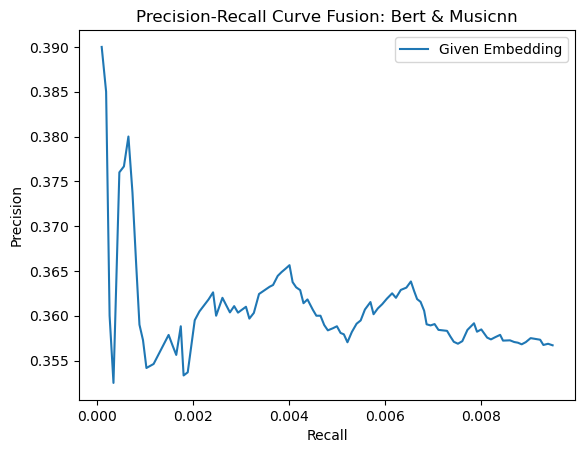

([0.39,
  0.385,
  0.3600000000000001,
  0.3525,
  0.3760000000000001,
  0.37666666666666665,
  0.38,
  0.37375,
  0.3655555555555556,
  0.359,
  0.35727272727272724,
  0.35416666666666663,
  0.35461538461538467,
  0.3578571428571429,
  0.35666666666666663,
  0.355625,
  0.3588235294117647,
  0.35333333333333344,
  0.35368421052631577,
  0.35950000000000004,
  0.36047619047619045,
  0.3618181818181818,
  0.3626086956521739,
  0.3600000000000001,
  0.36200000000000004,
  0.36115384615384605,
  0.3603703703703704,
  0.36107142857142854,
  0.3603448275862069,
  0.36099999999999993,
  0.3596774193548387,
  0.3603125,
  0.3624242424242425,
  0.3632352941176471,
  0.36342857142857143,
  0.3644444444444445,
  0.36486486486486486,
  0.3652631578947369,
  0.3656410256410257,
  0.36375,
  0.3631707317073171,
  0.3628571428571428,
  0.36139534883720936,
  0.36181818181818187,
  0.3606666666666667,
  0.35999999999999993,
  0.36,
  0.3589583333333334,
  0.3583673469387755,
  0.3585999999999999,
  0

In [45]:
calc_avg_recall_precision_fusion(late_fusion_bert_musicnn, k_range, sample_size)